In [1]:
!cd /Users/yhk/Desktop/大三上/HTML/FP


In [2]:
!ls

AdamW_train_val_loss_log.csv          best_model.pth
RNN.ipynb                             nn.ipynb
attention.ipynb                       same_season_test_data_predictions.csv



[1] Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11067 entries, 0 to 11066
Columns: 167 entries, id to away_pitcher_wpa_def_skew
dtypes: bool(1), float64(157), int64(1), object(8)
memory usage: 14.0+ MB
None

[2] Missing Value Statistics:
id                                         0
home_team_abbr                             0
away_team_abbr                             0
date                                       0
is_night_game                            553
                                        ... 
away_pitcher_leverage_index_avg_std     1974
away_pitcher_leverage_index_avg_skew    2646
away_pitcher_wpa_def_mean               1296
away_pitcher_wpa_def_std                1960
away_pitcher_wpa_def_skew               2647
Length: 167, dtype: int64

[3] Descriptive Statistics:
                  id home_team_abbr away_team_abbr        date is_night_game  \
count   11067.000000          11067          11067       11067         10514   
unique           NaN          

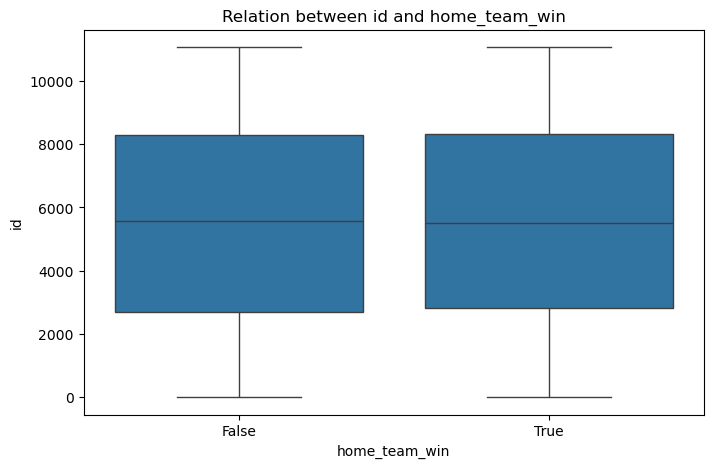

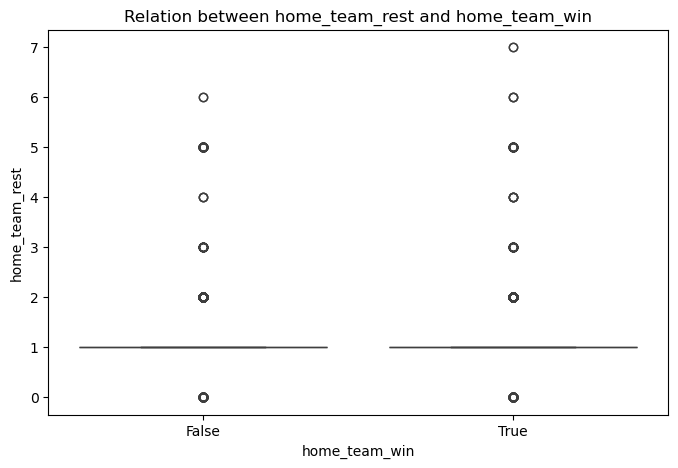

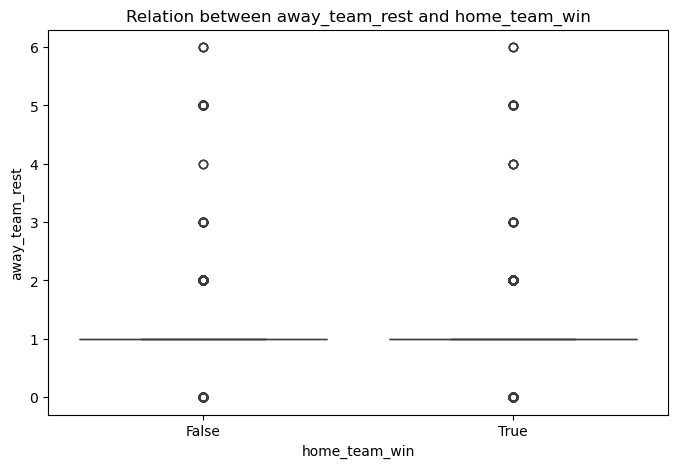

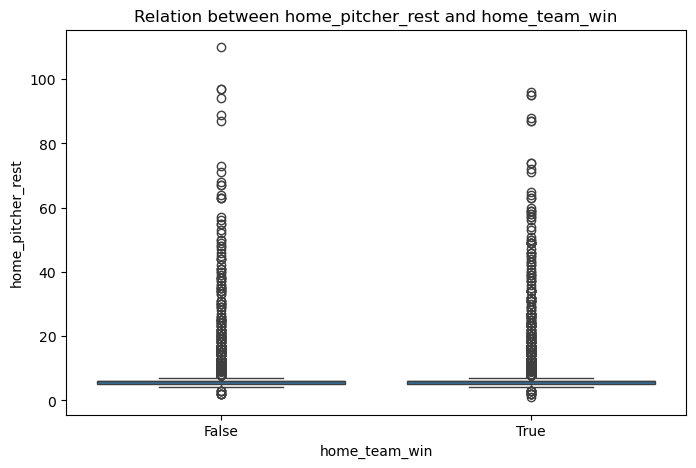

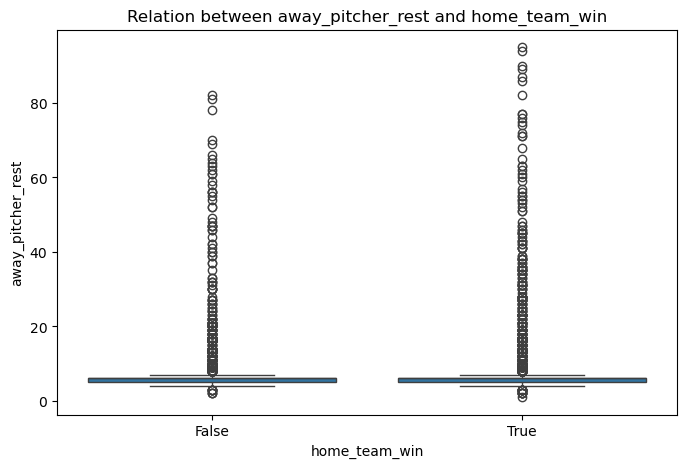

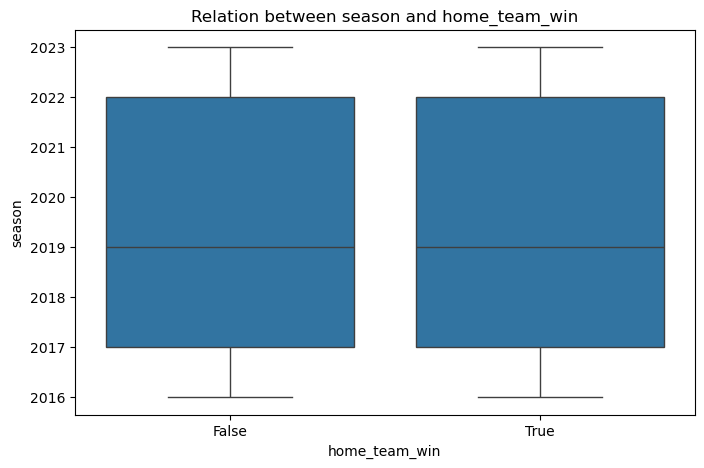

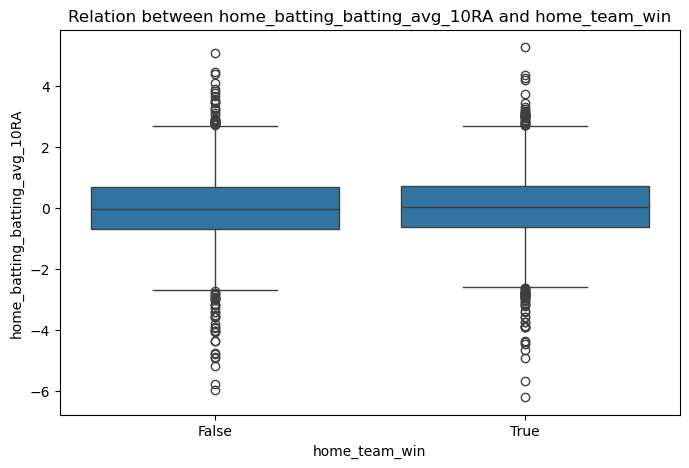

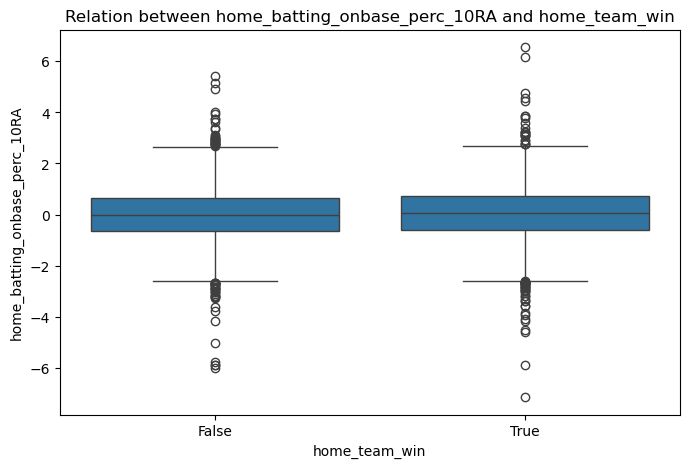

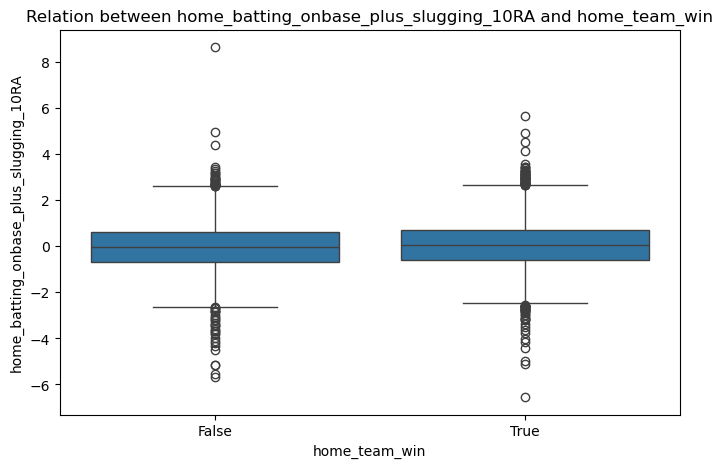

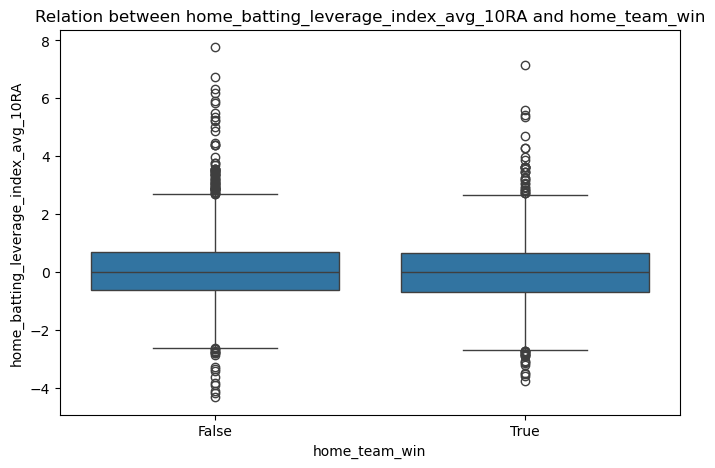

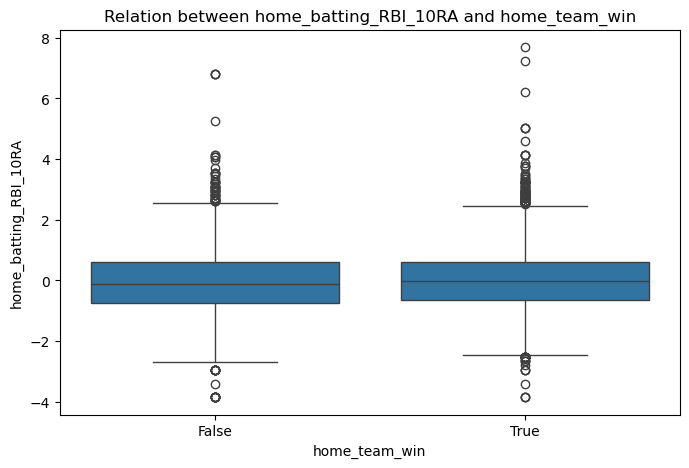

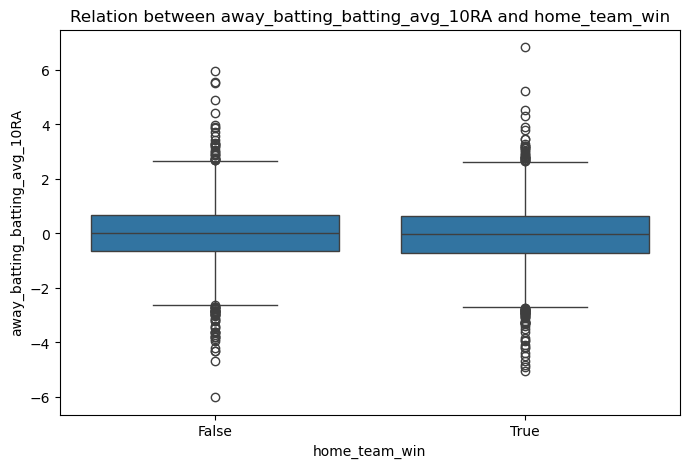

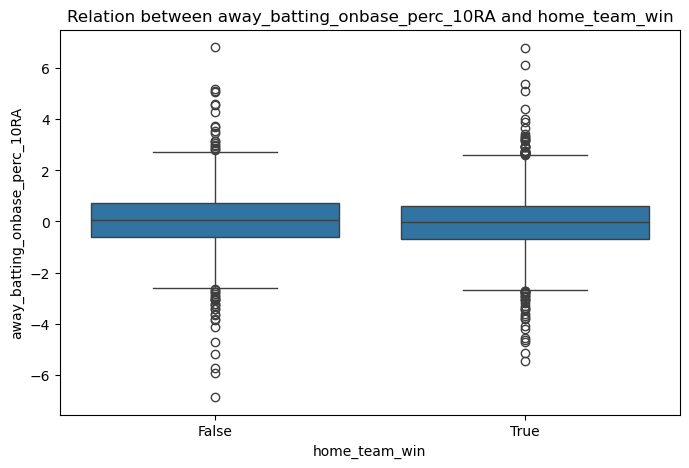

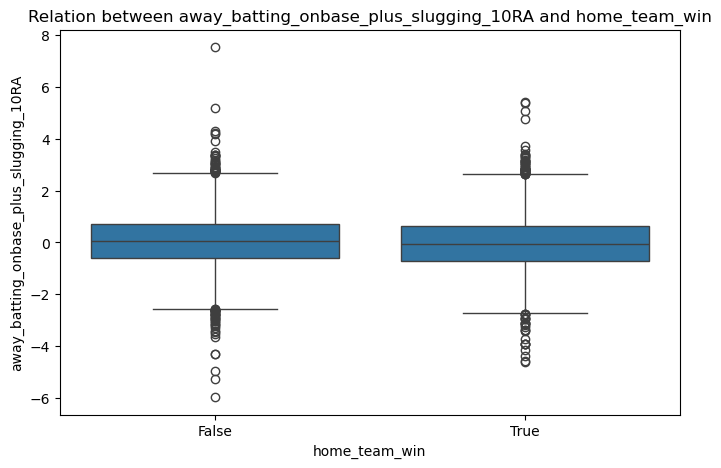

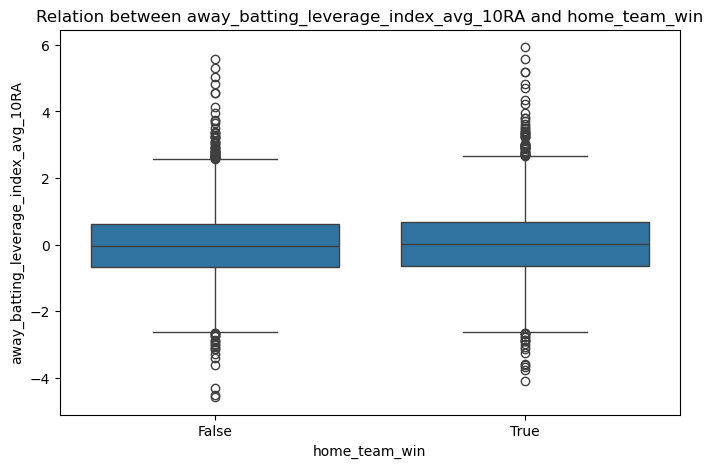

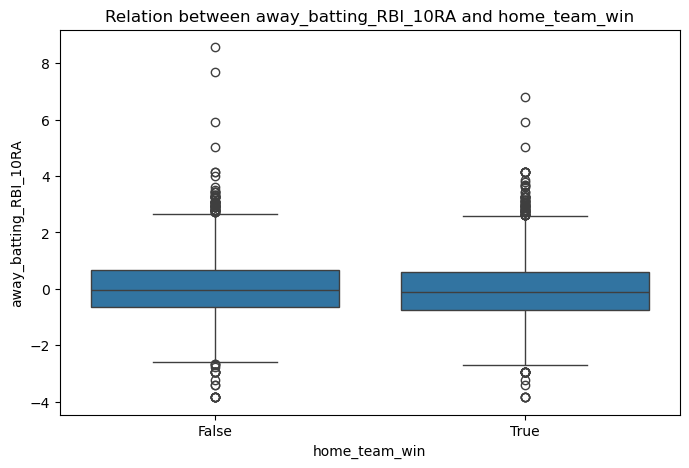

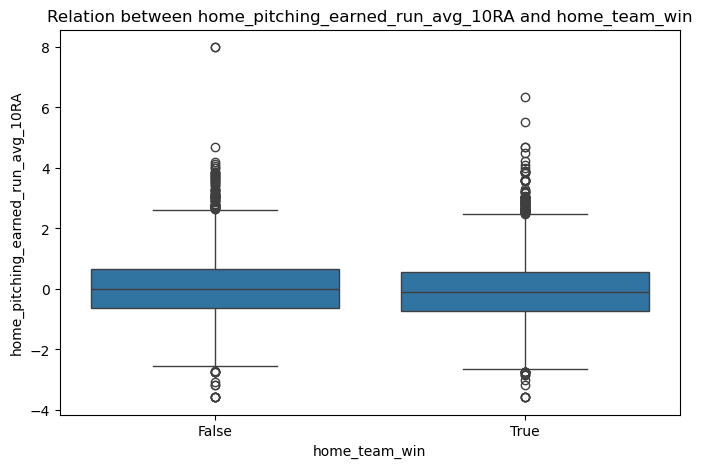

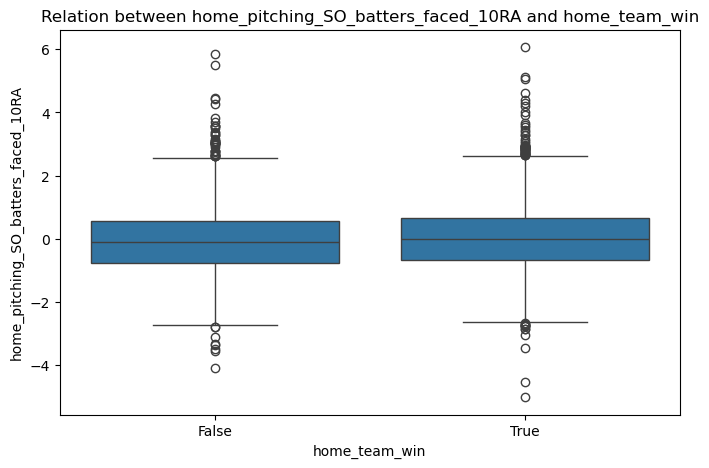

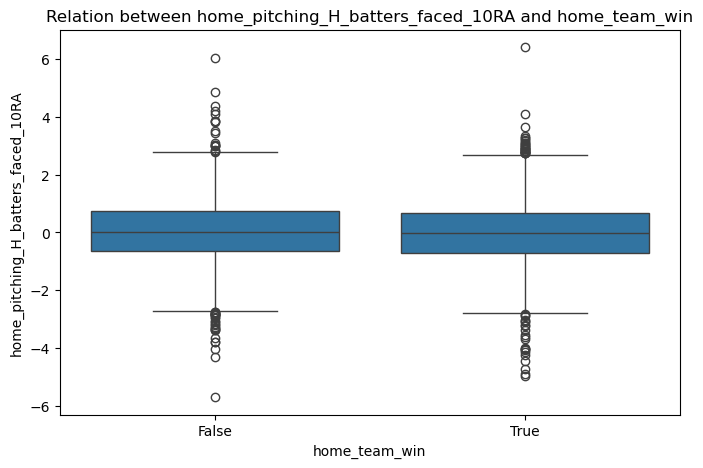

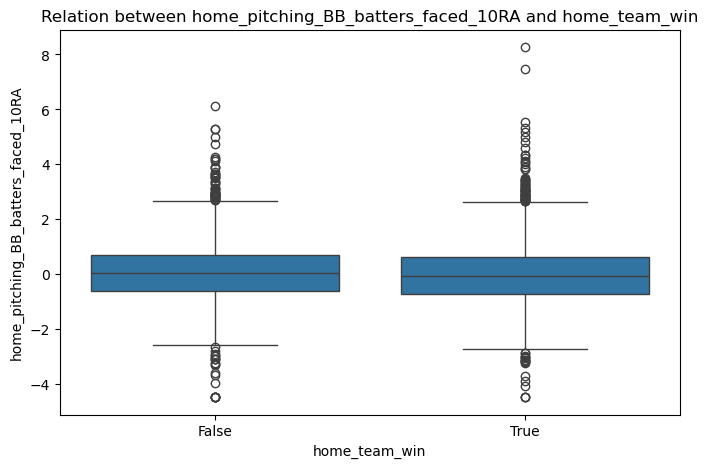

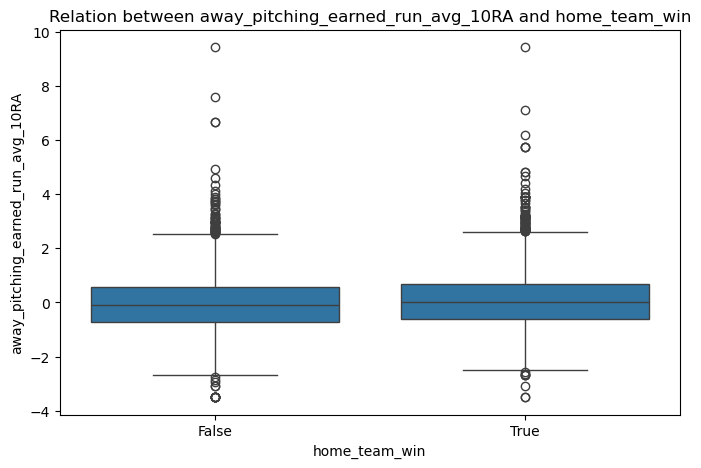

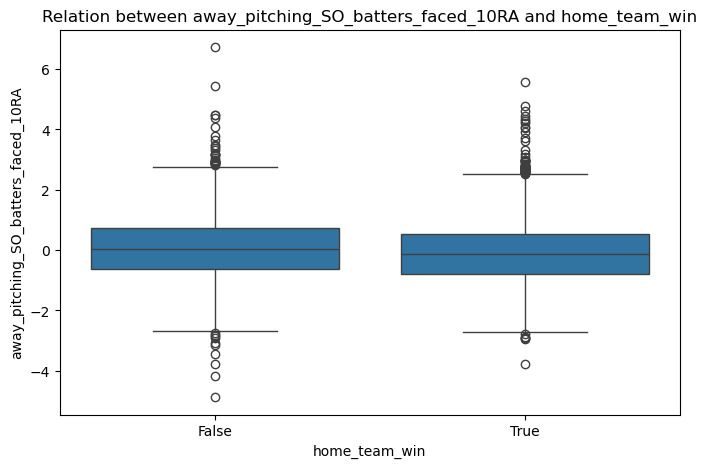

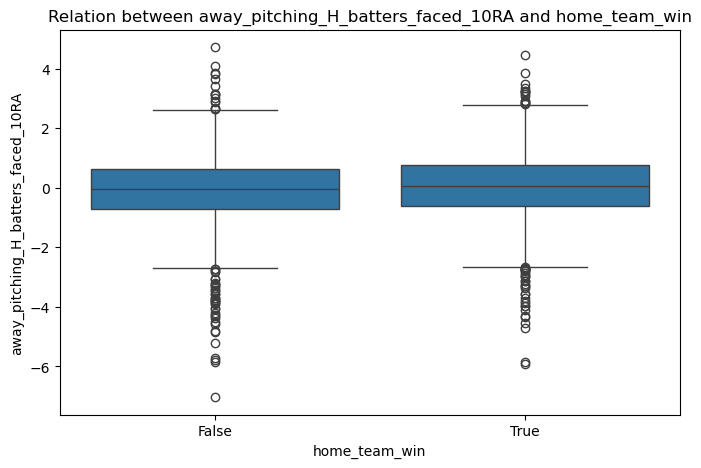

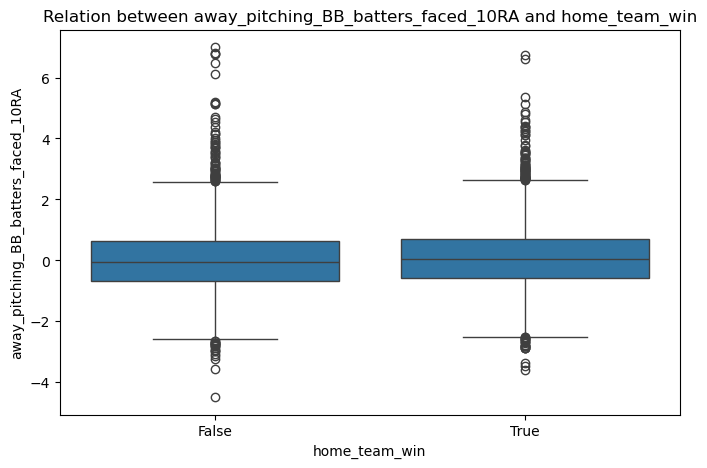

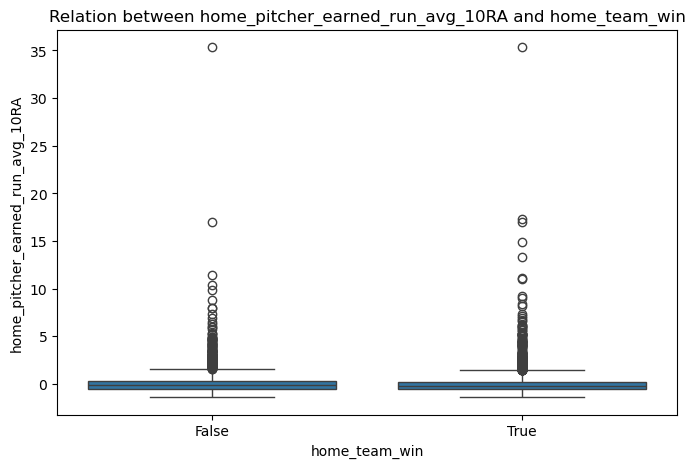

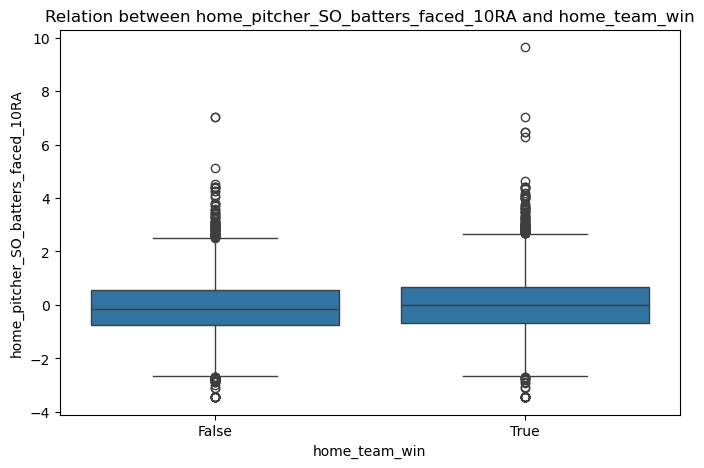

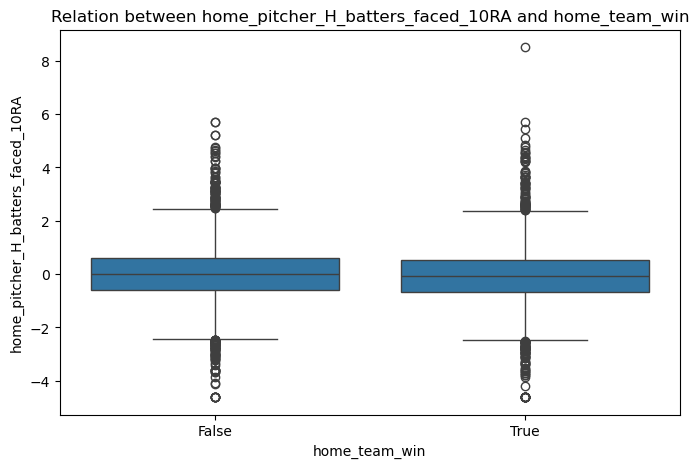

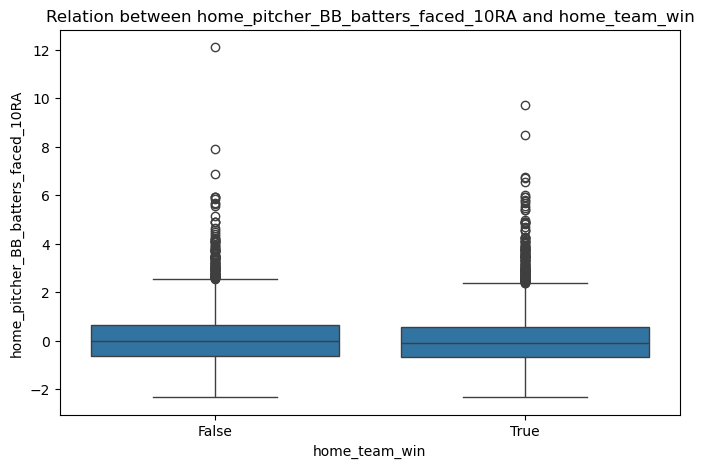

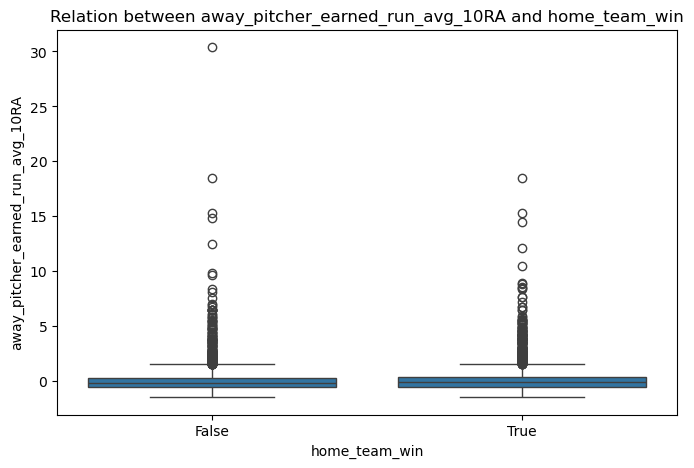

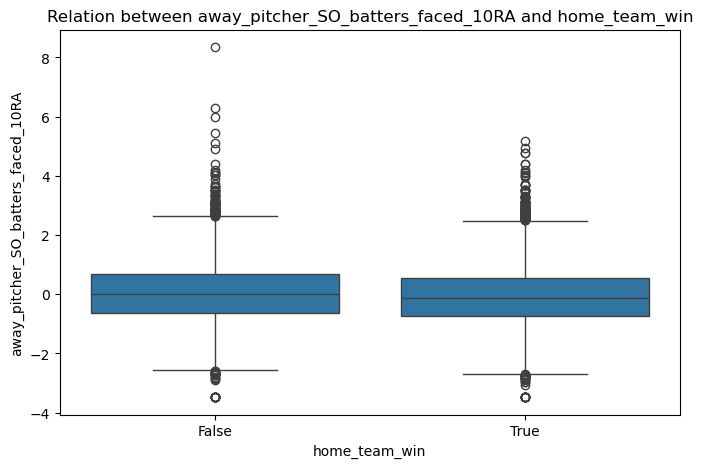

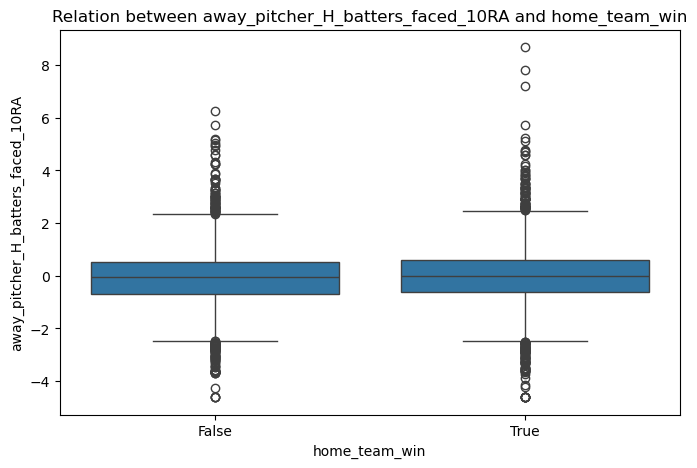

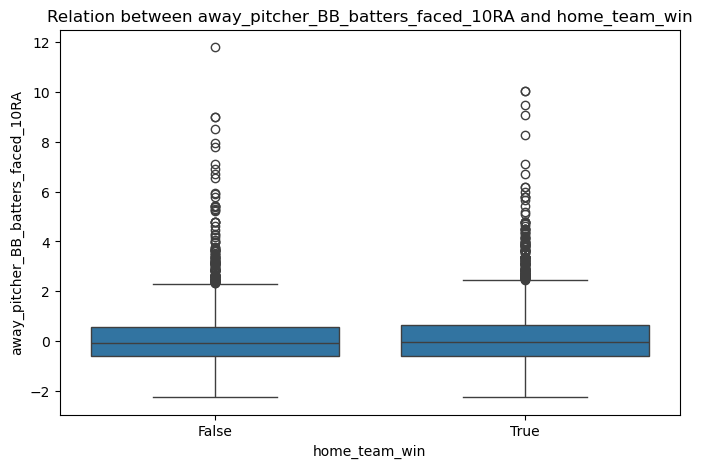

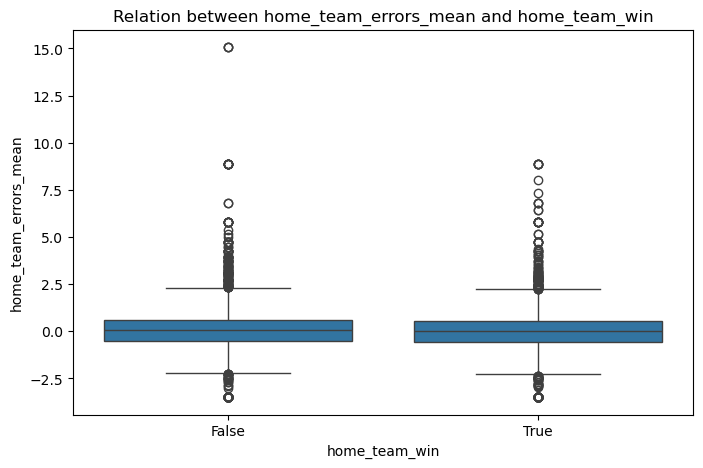

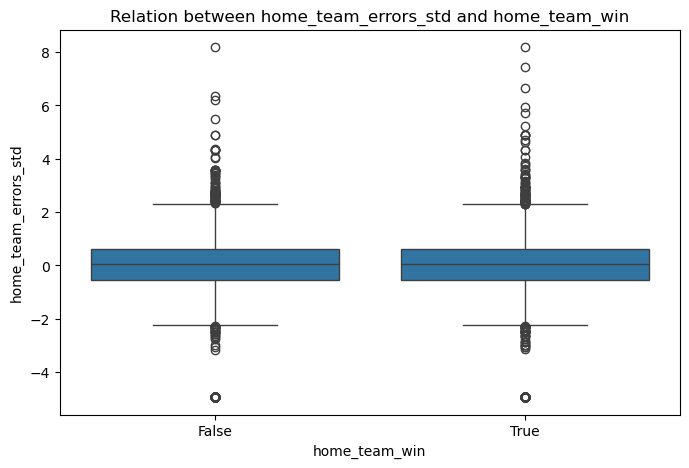

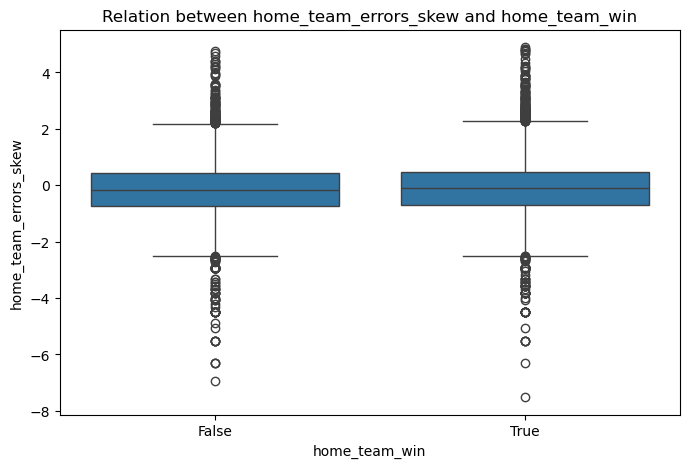

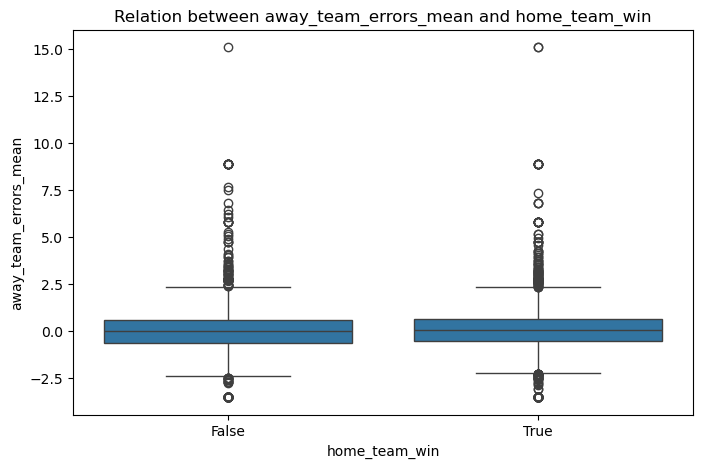

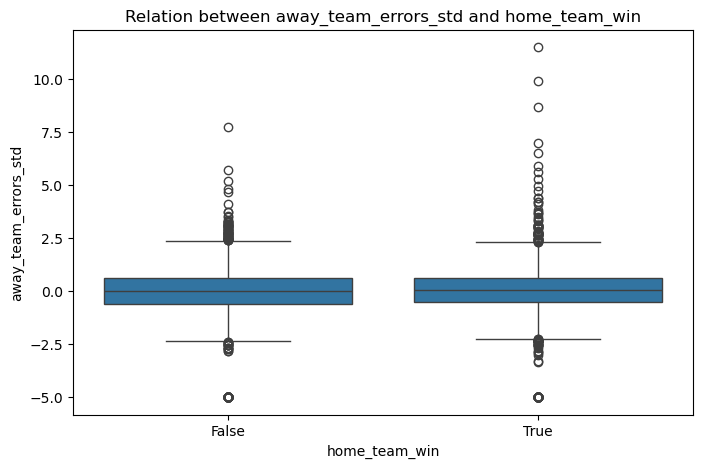

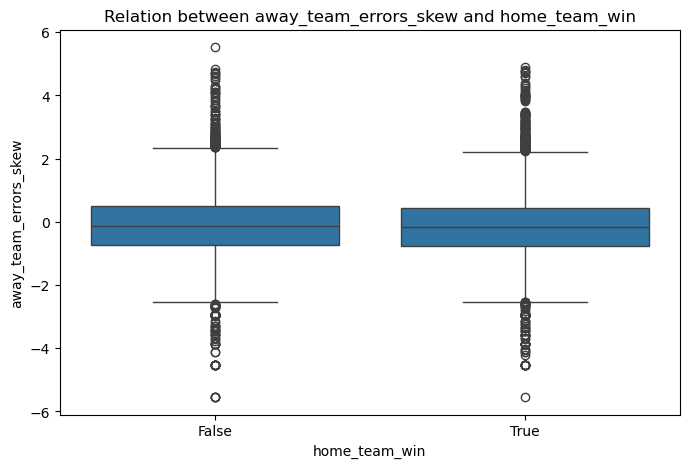

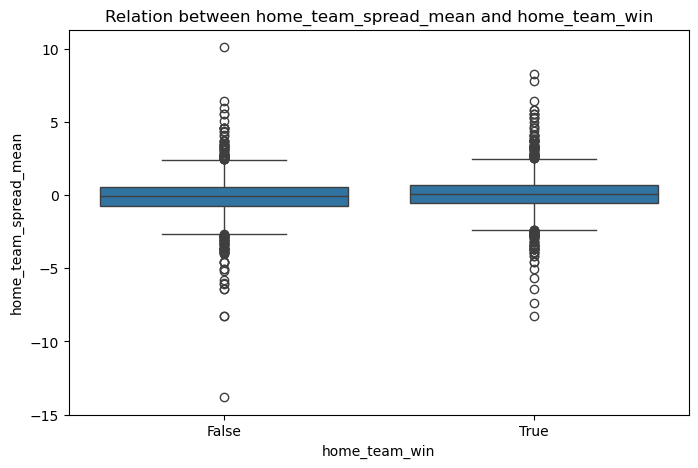

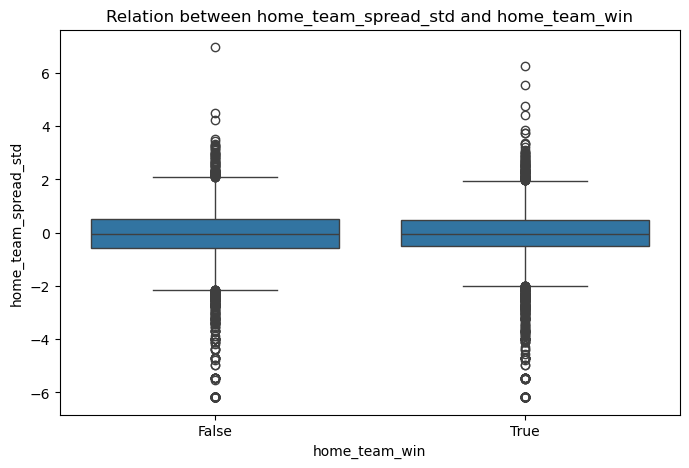

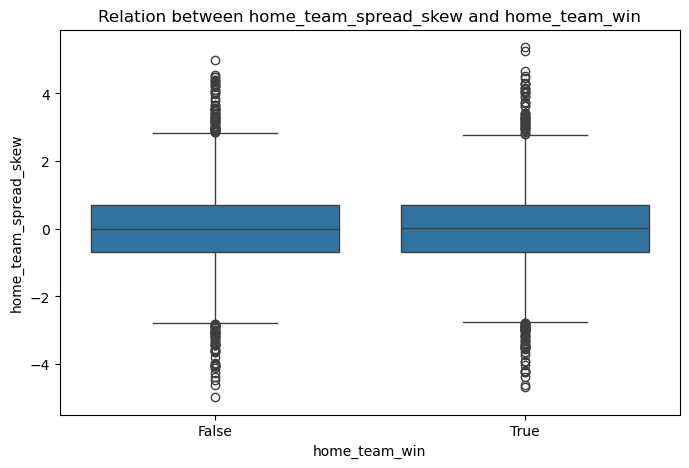

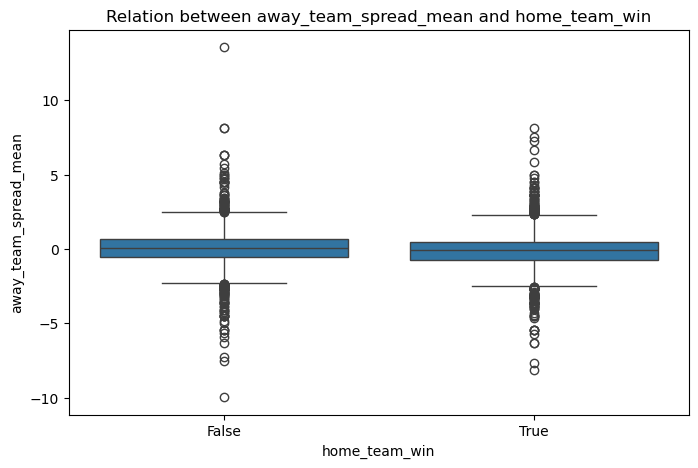

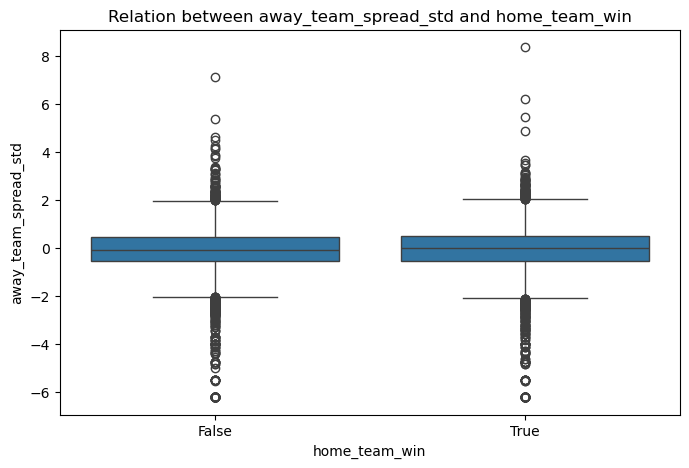

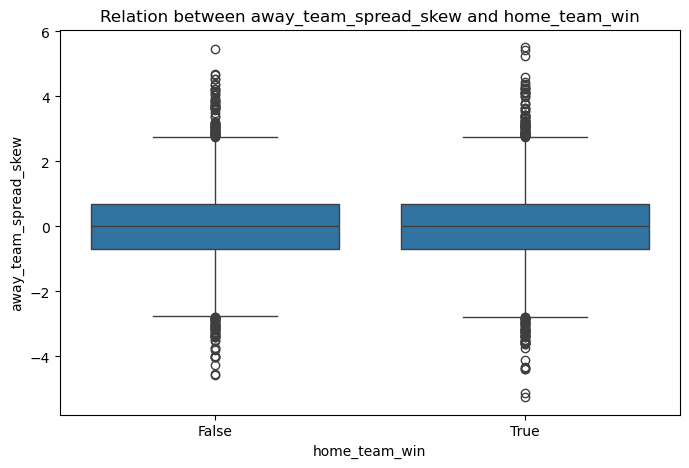

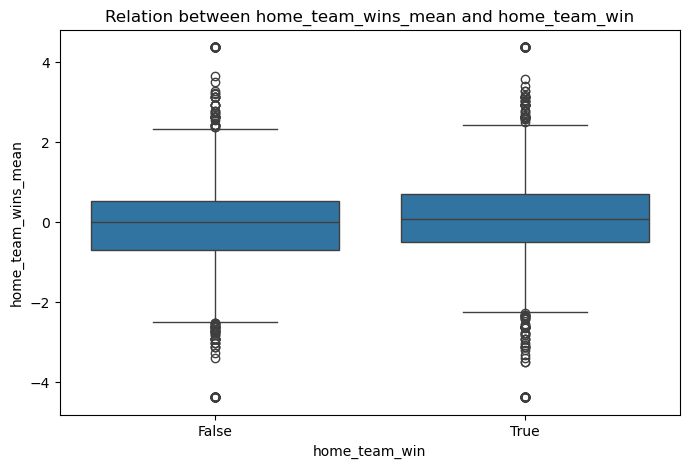

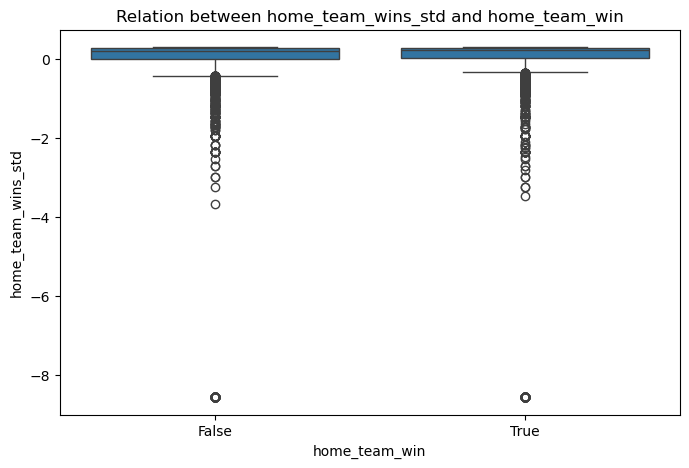

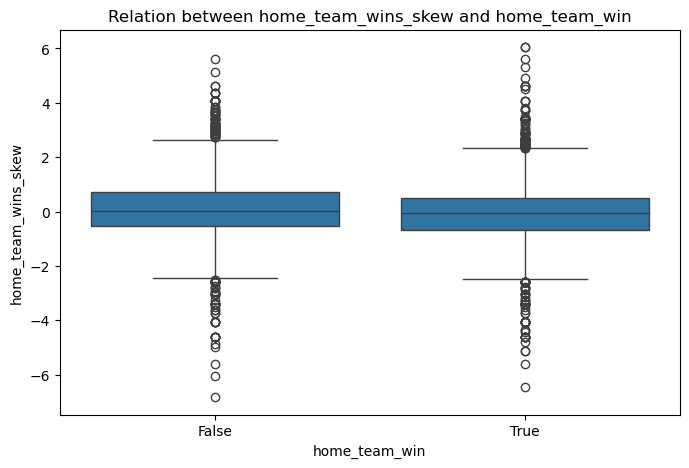

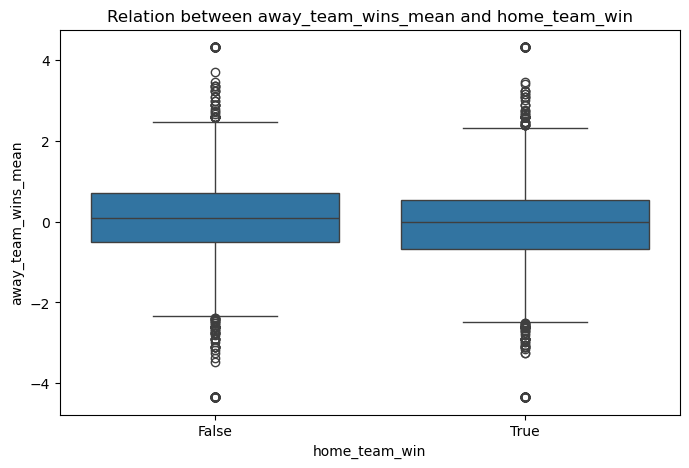

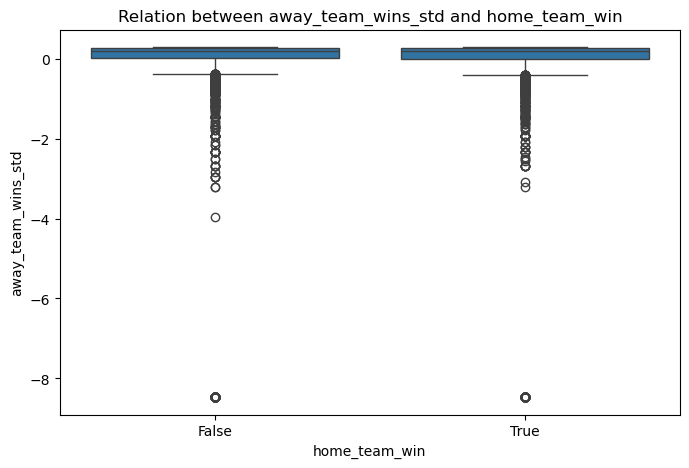

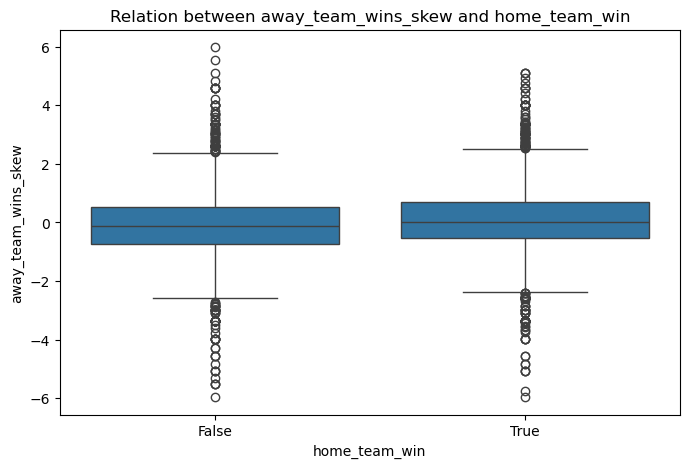

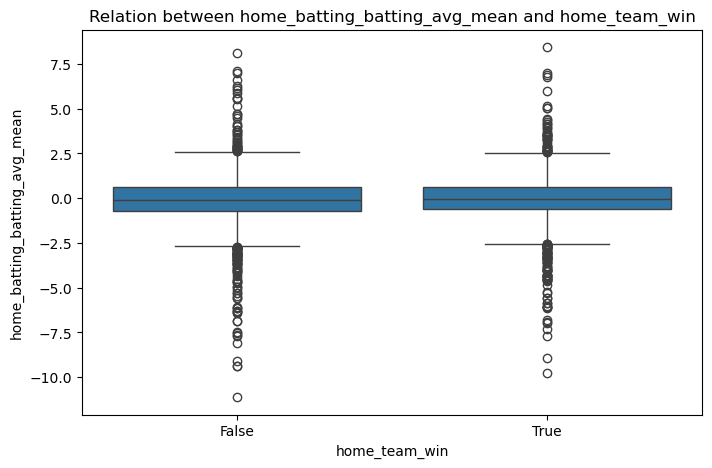

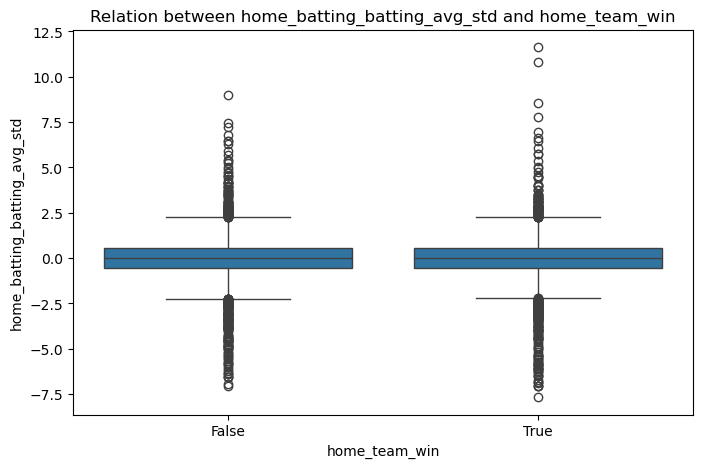

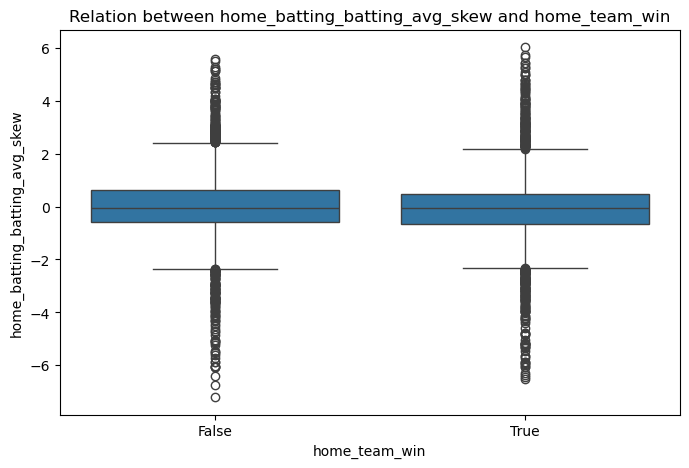

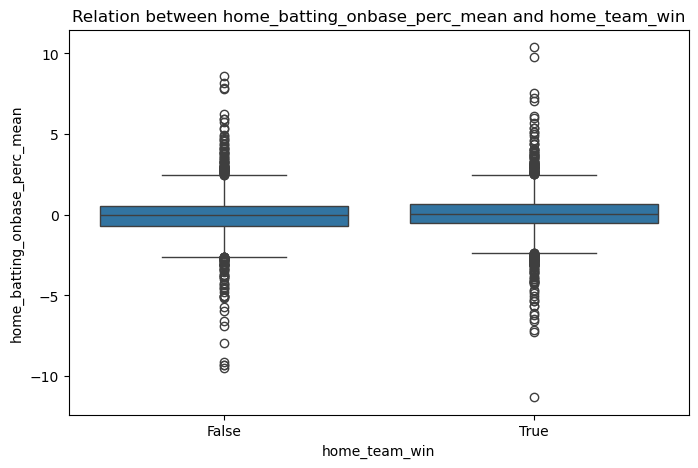

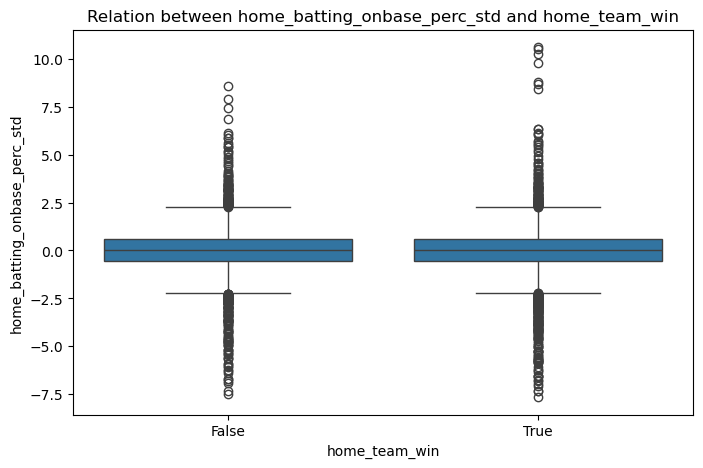

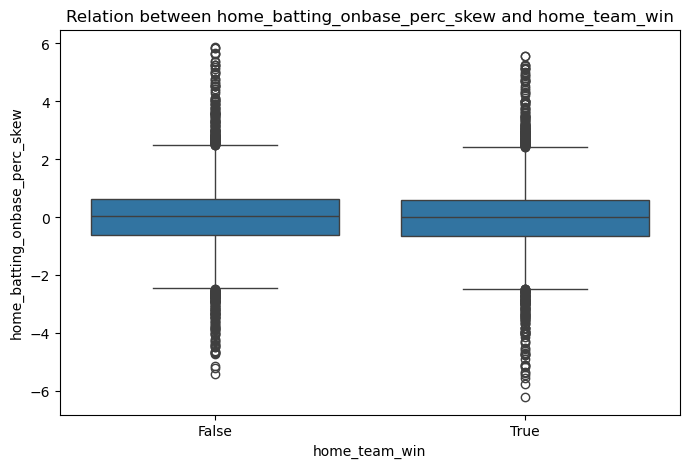

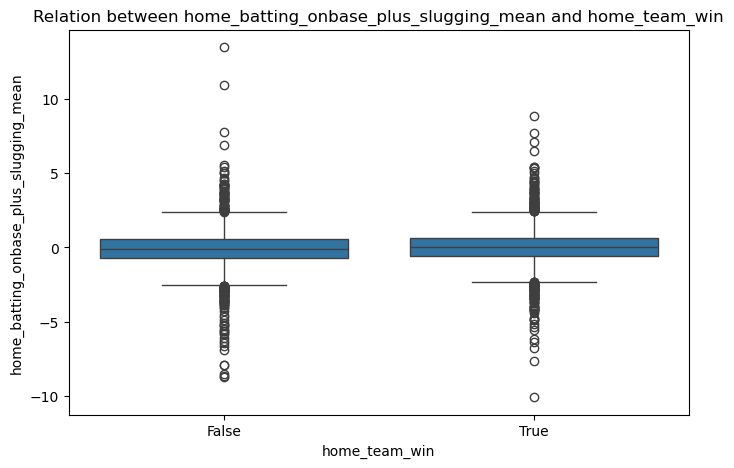

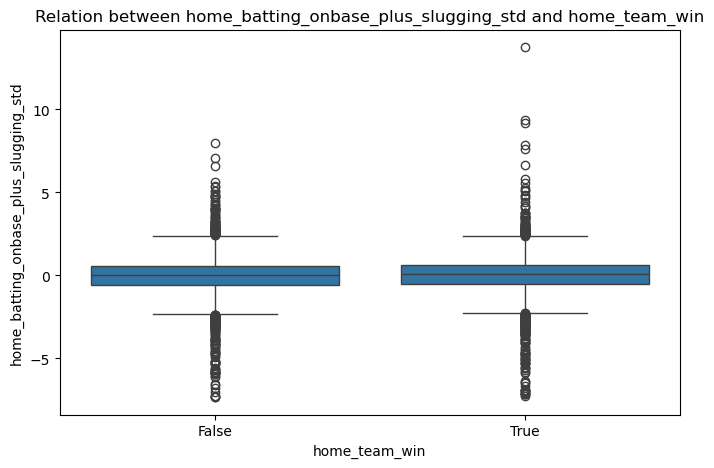

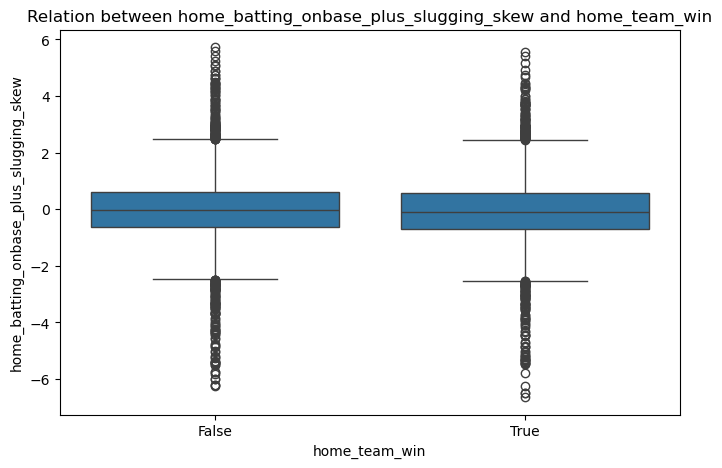

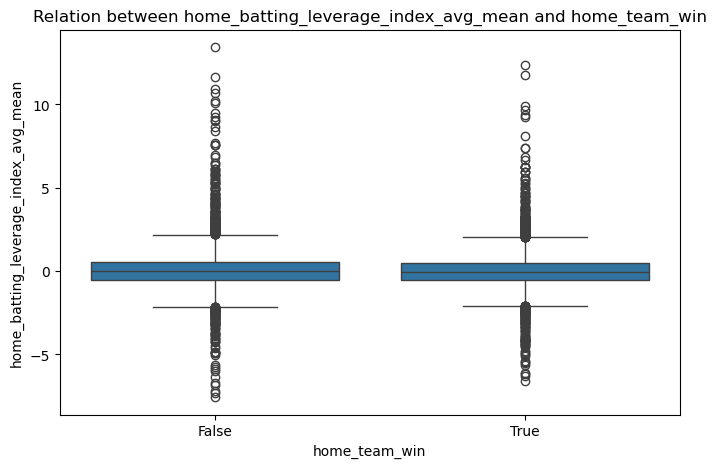

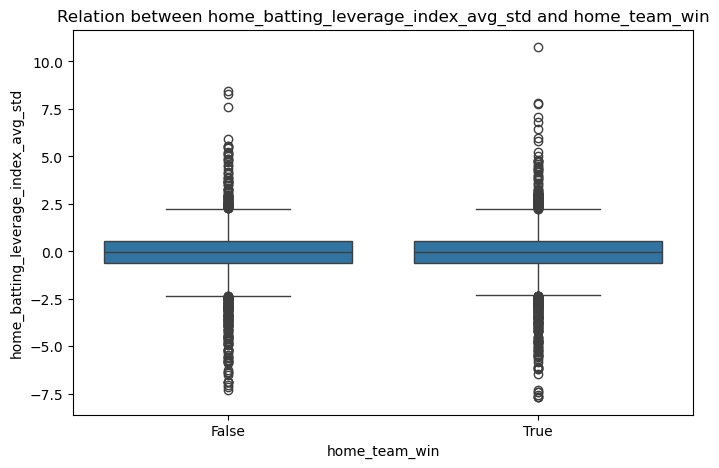

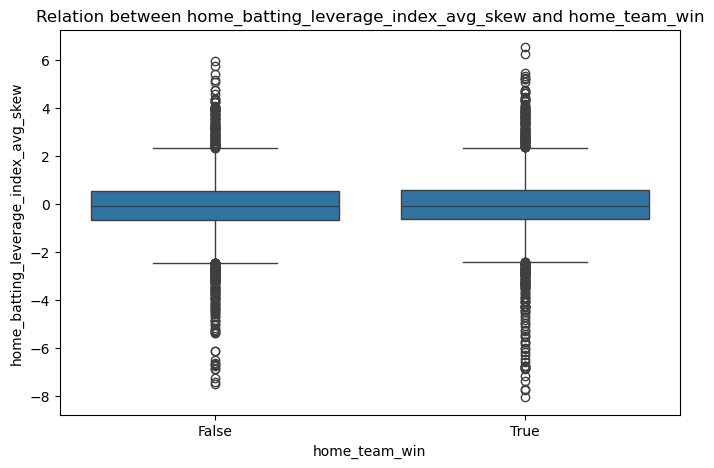

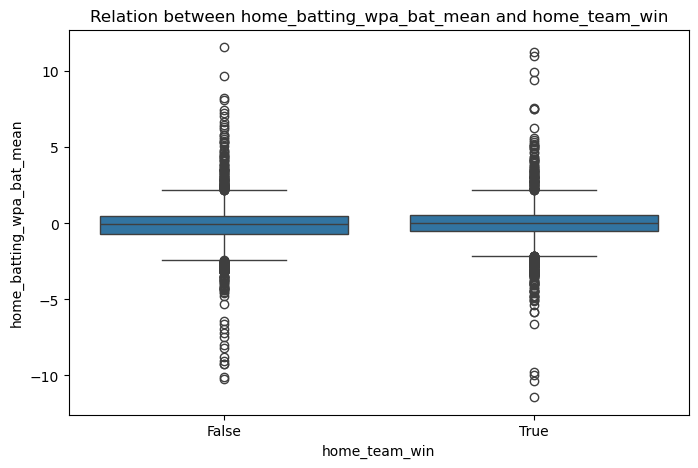

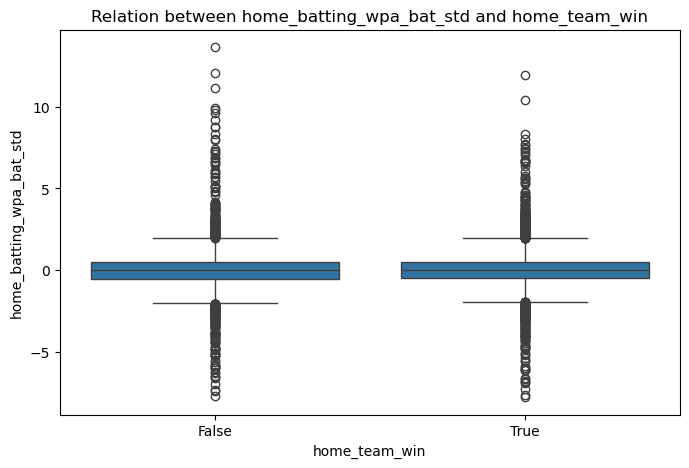

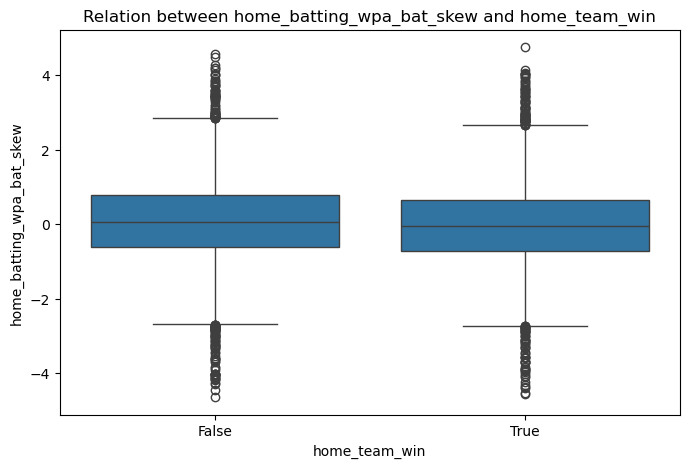

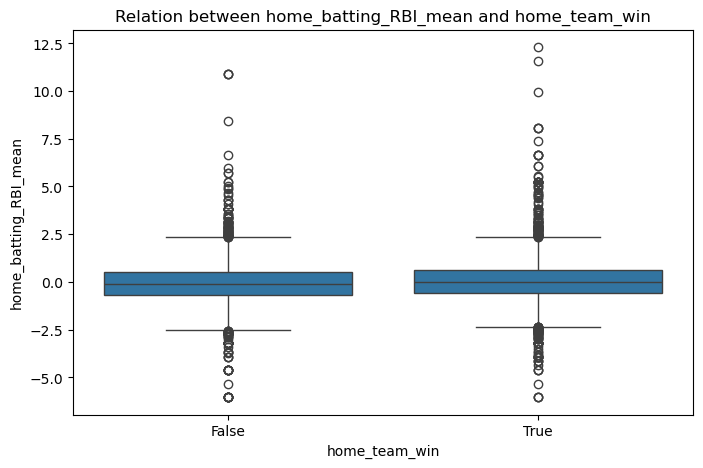

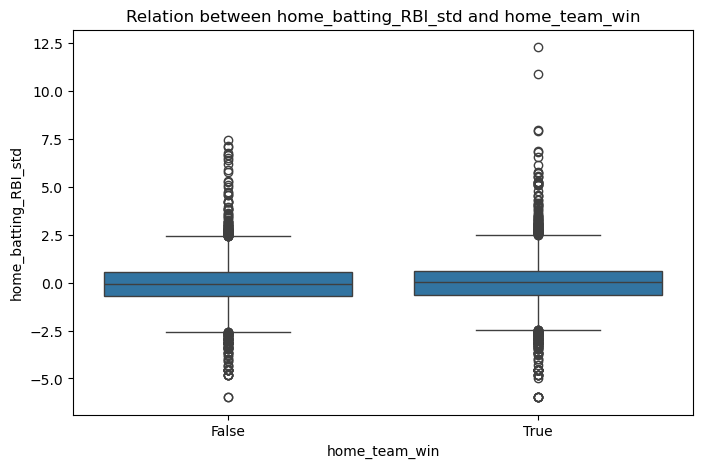

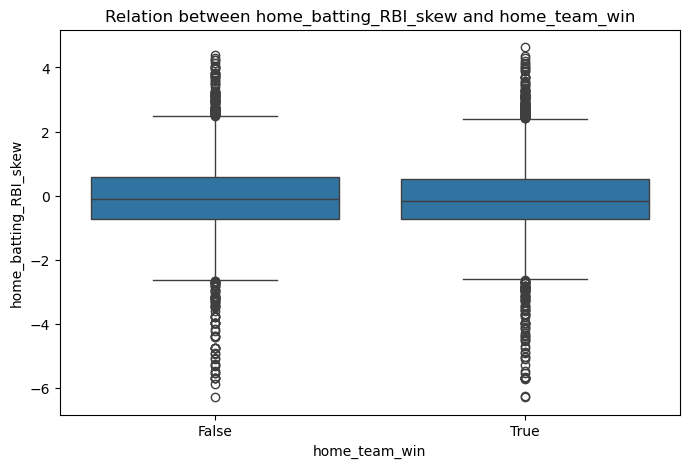

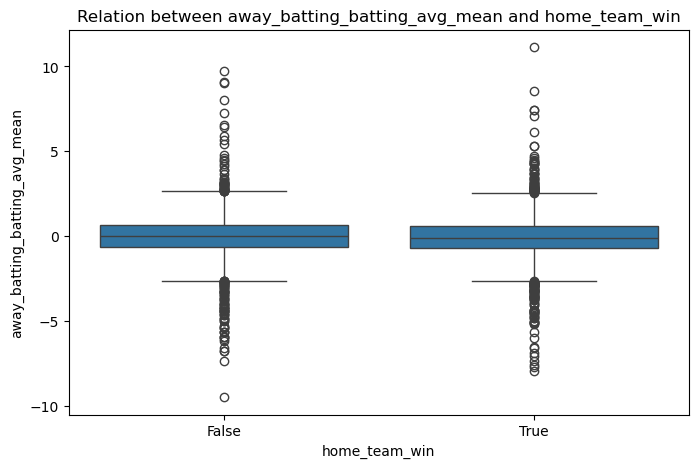

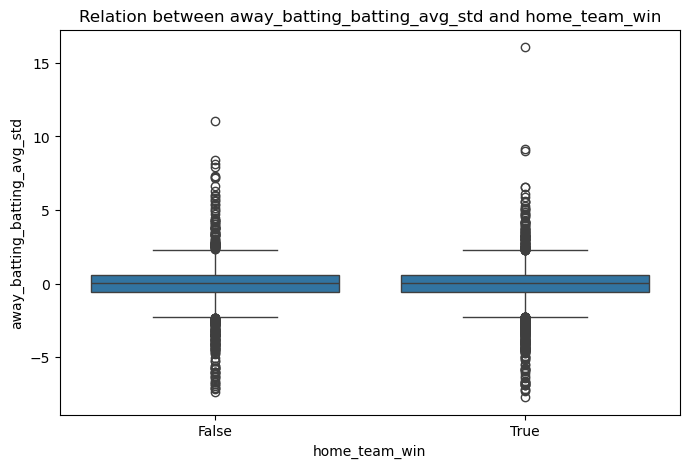

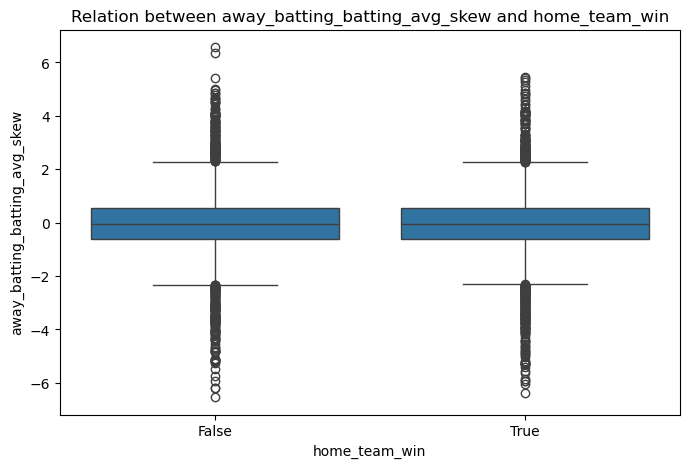

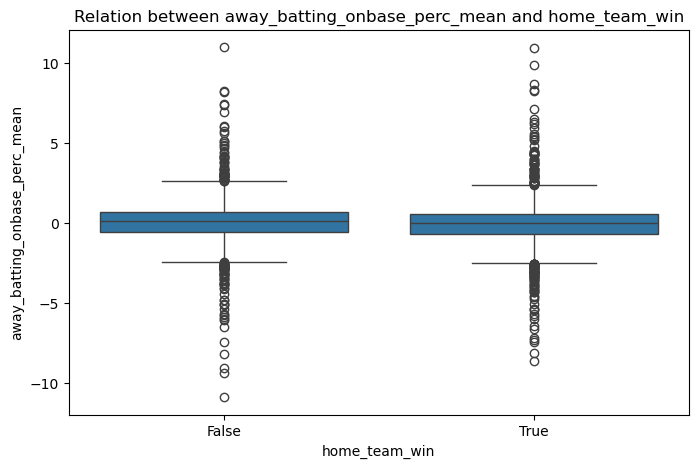

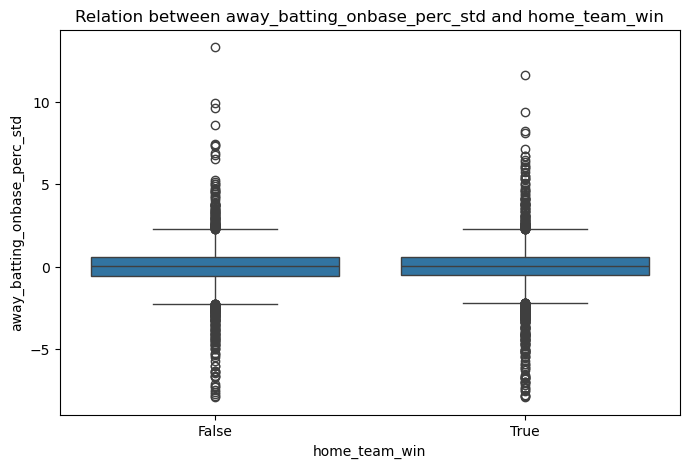

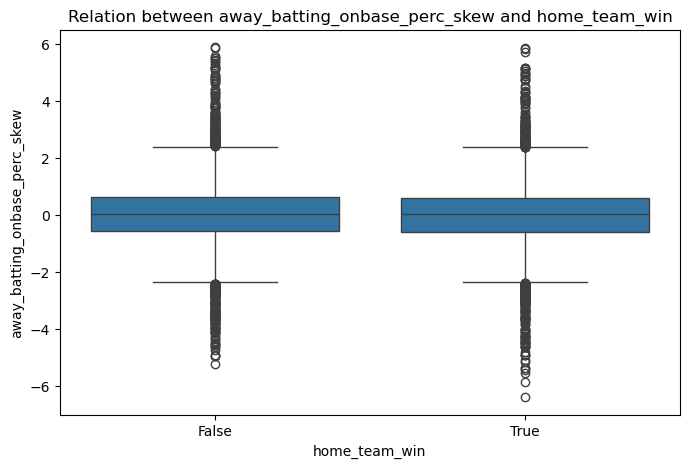

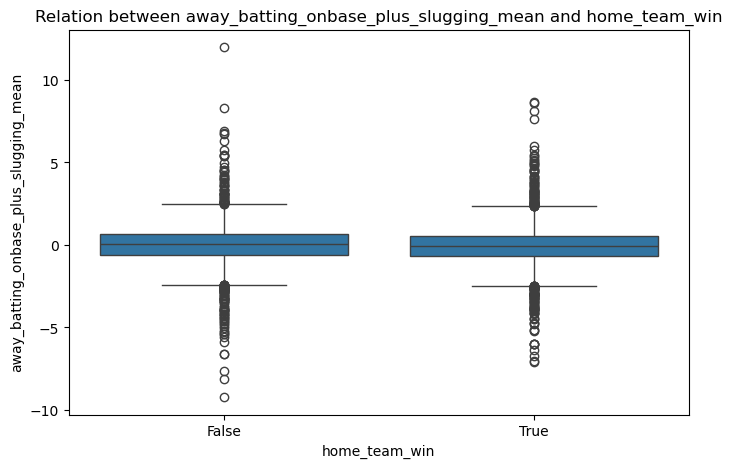

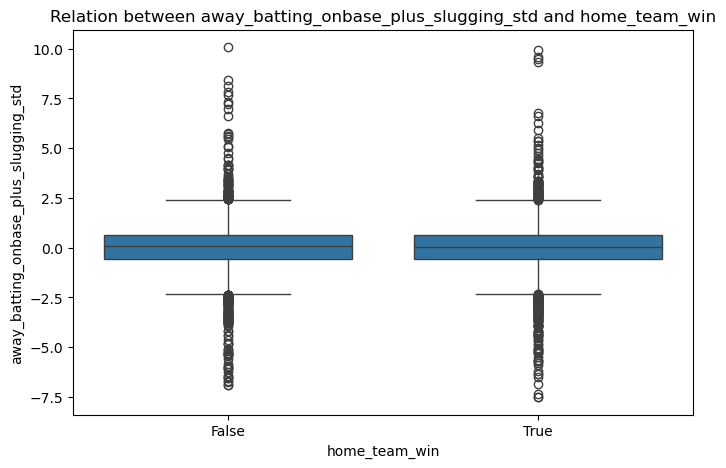

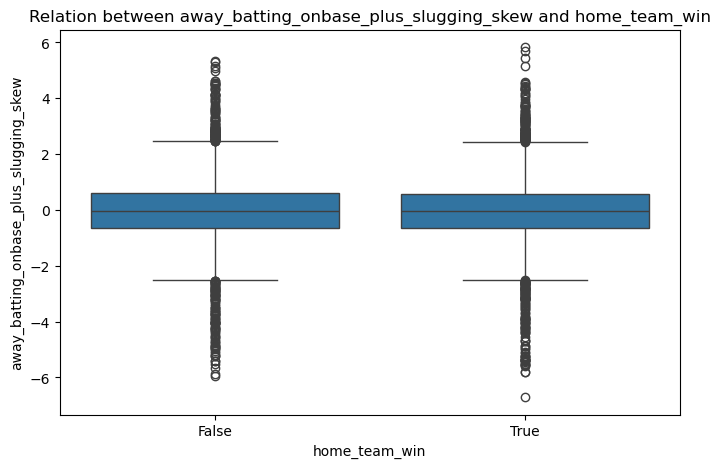

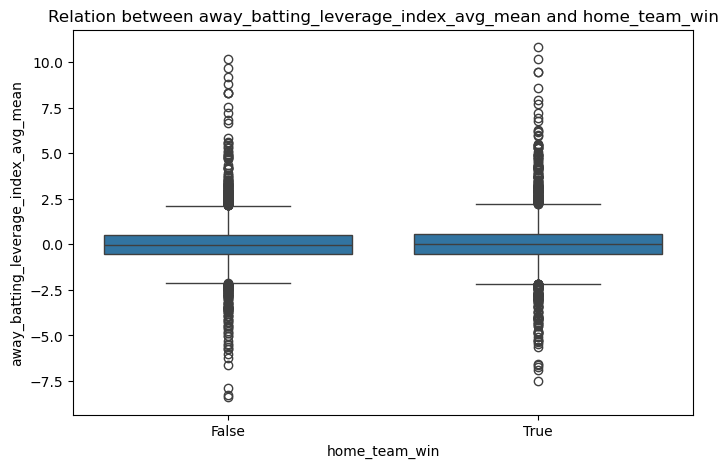

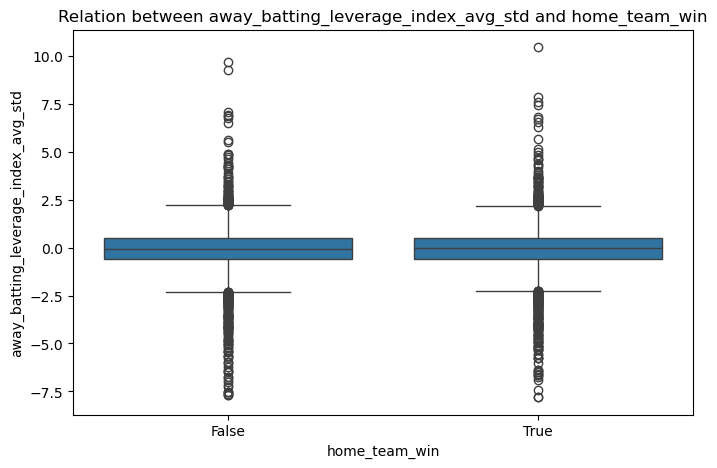

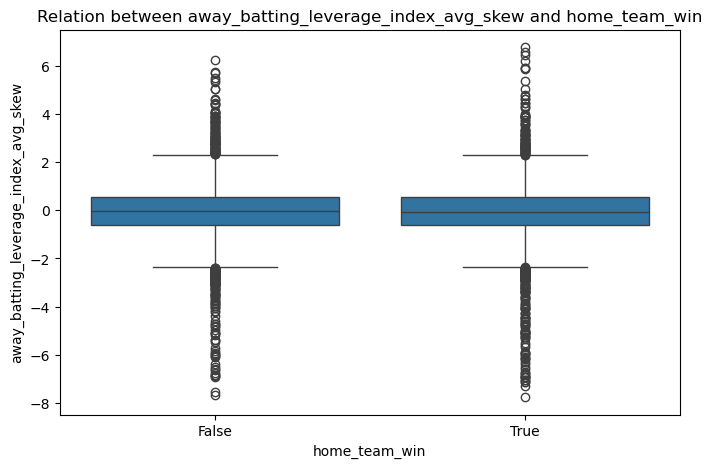

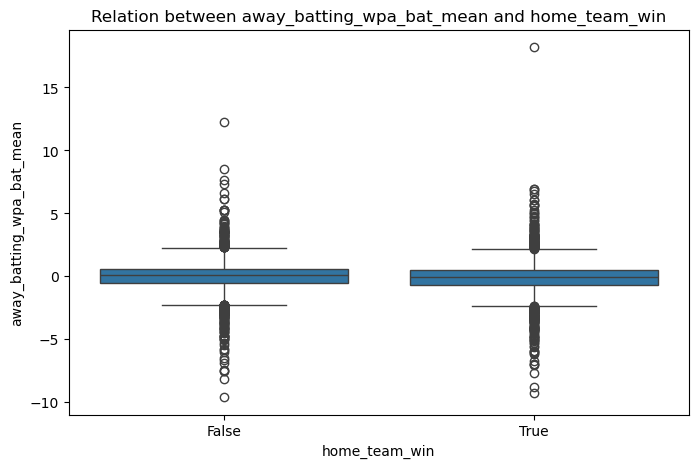

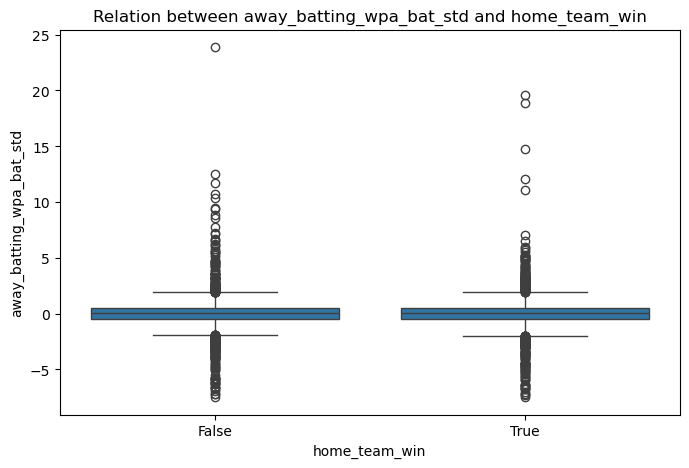

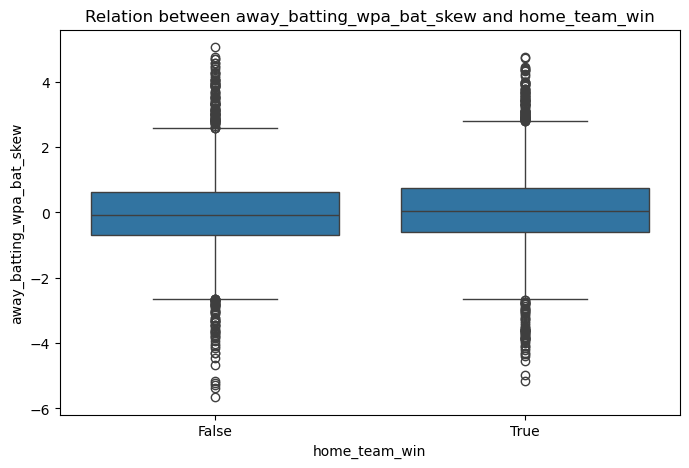

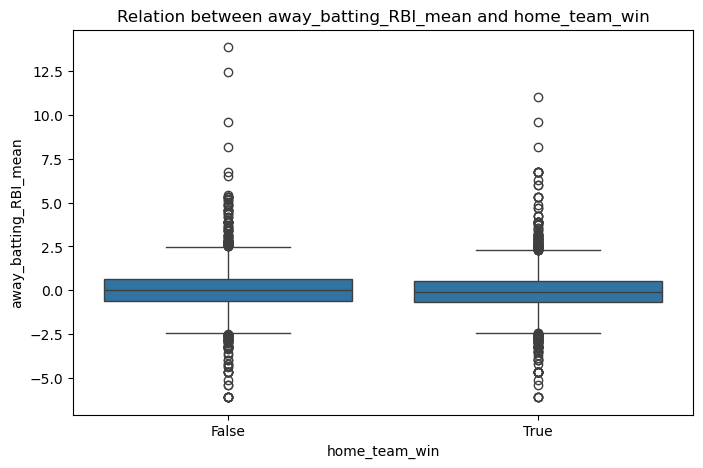

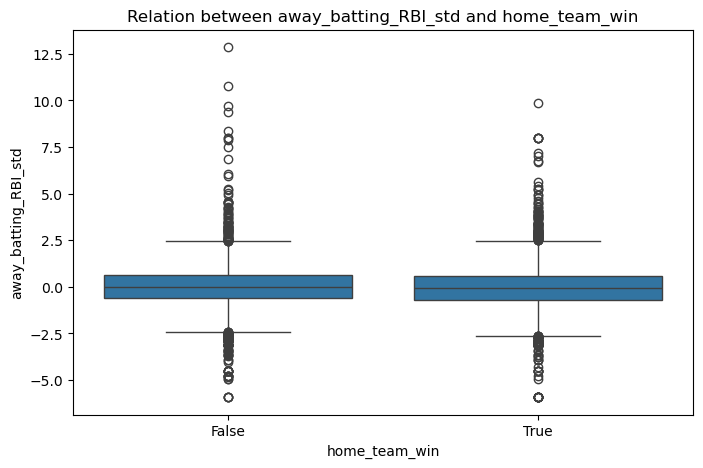

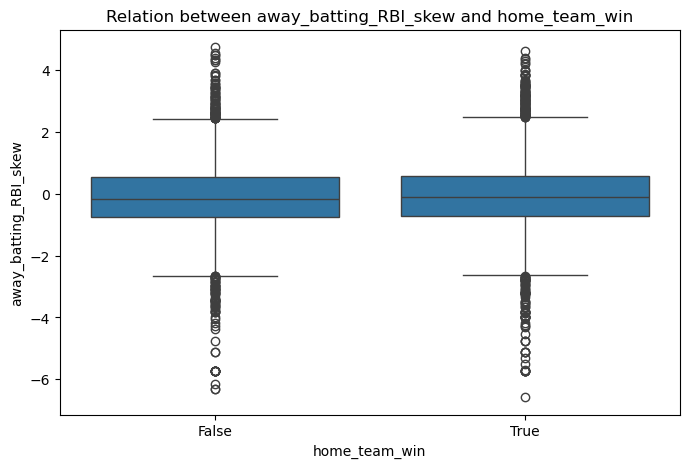

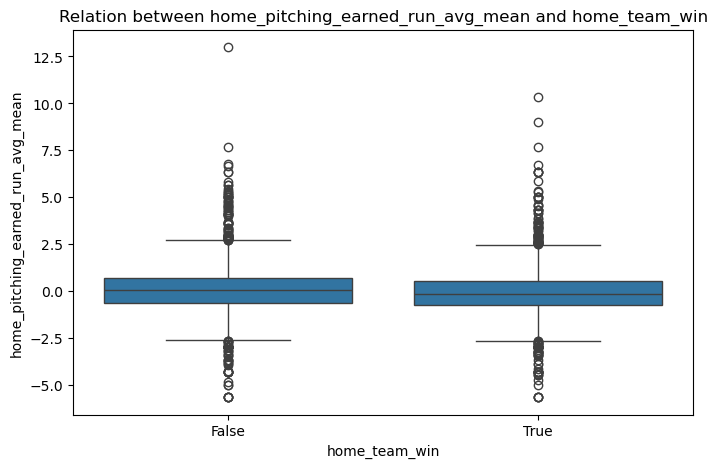

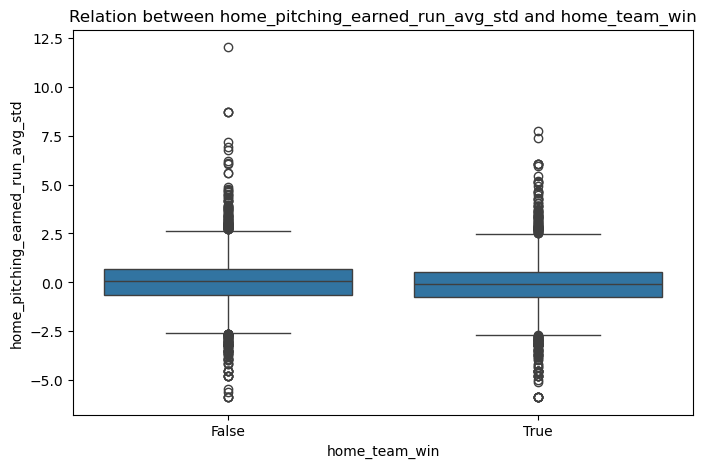

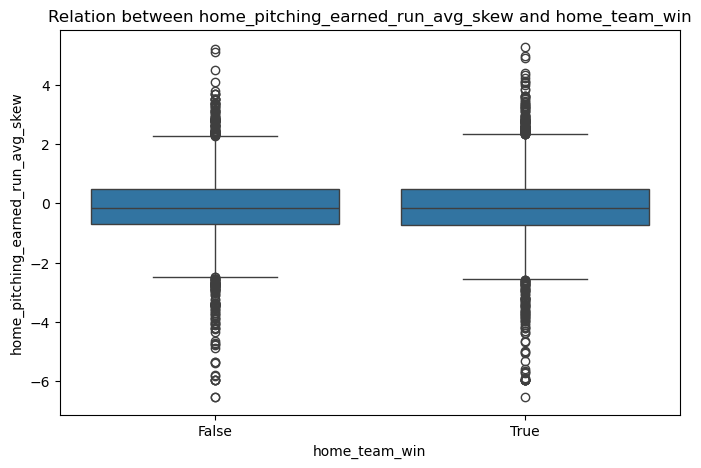

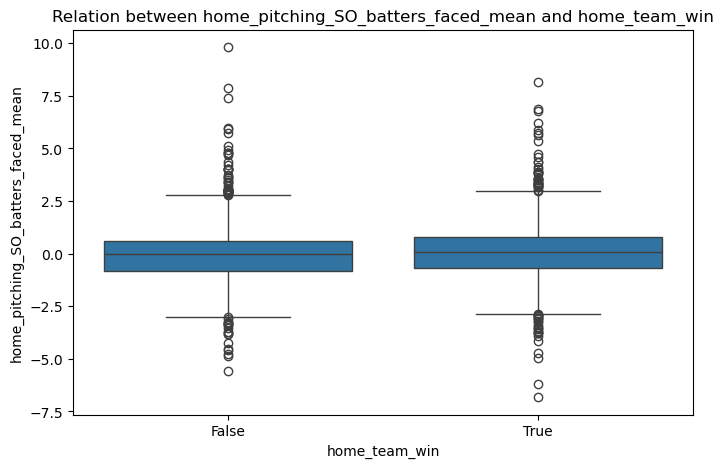

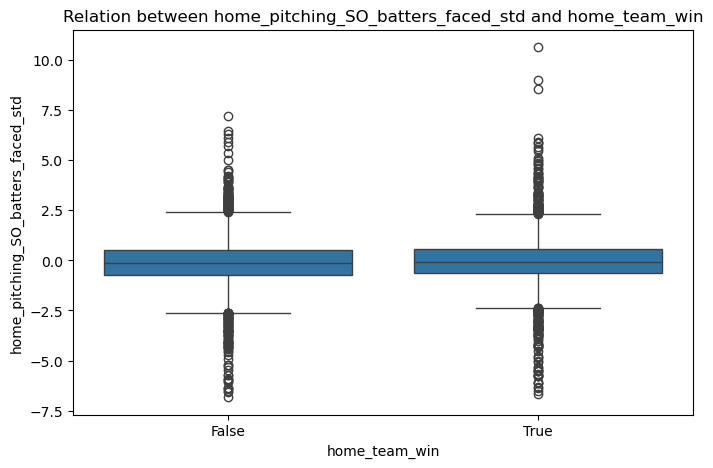

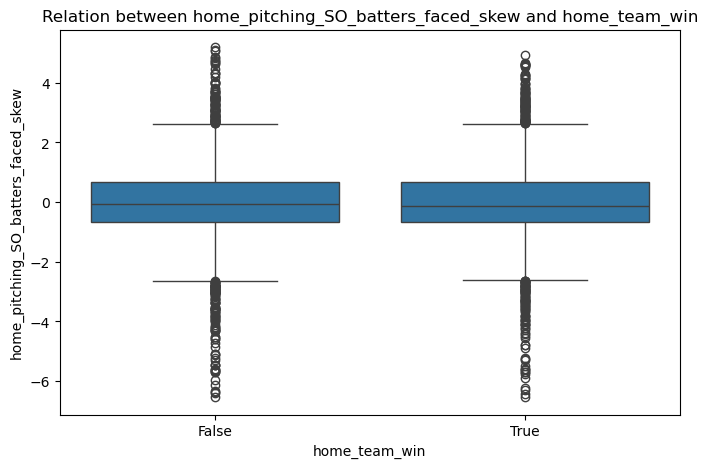

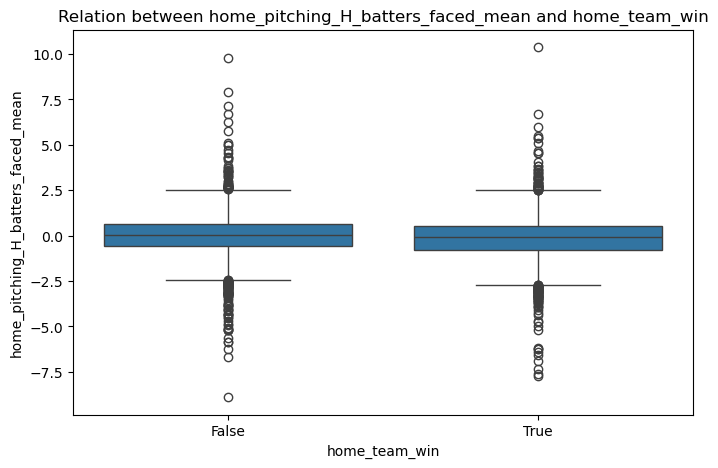

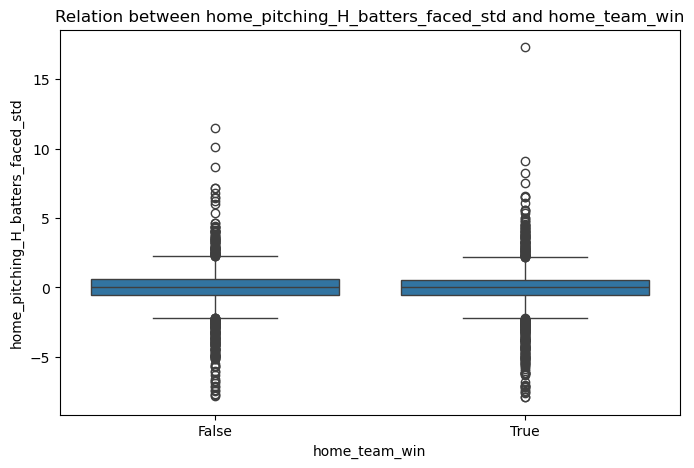

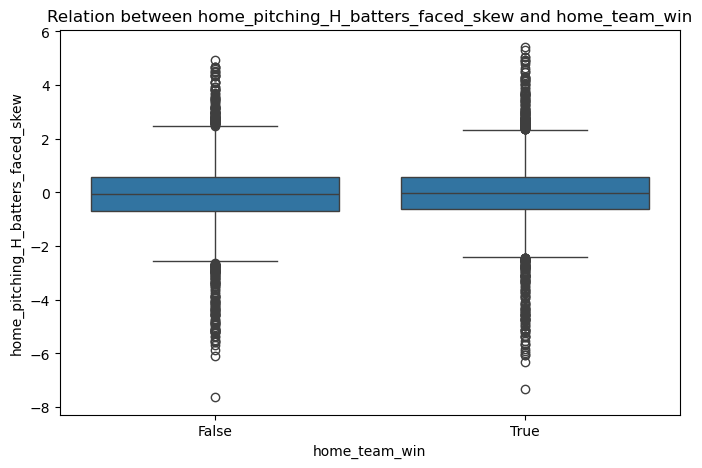

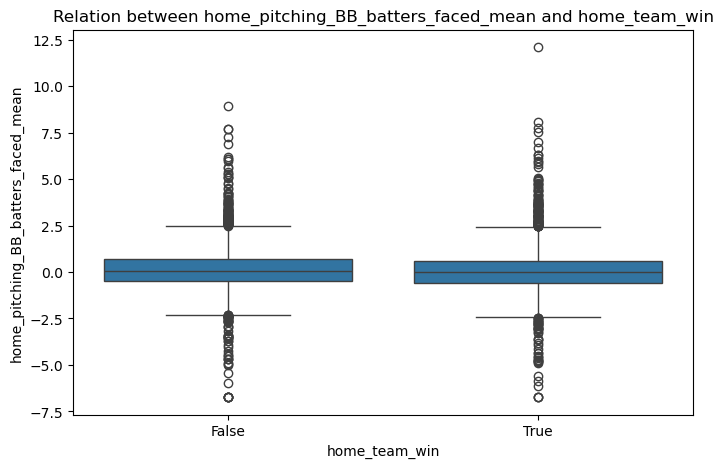

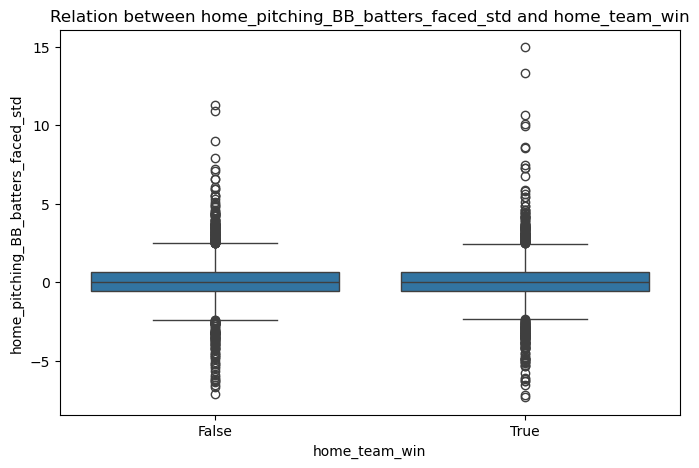

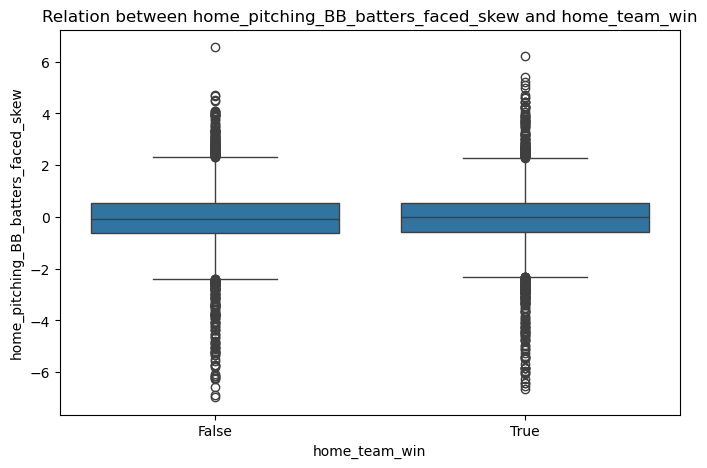

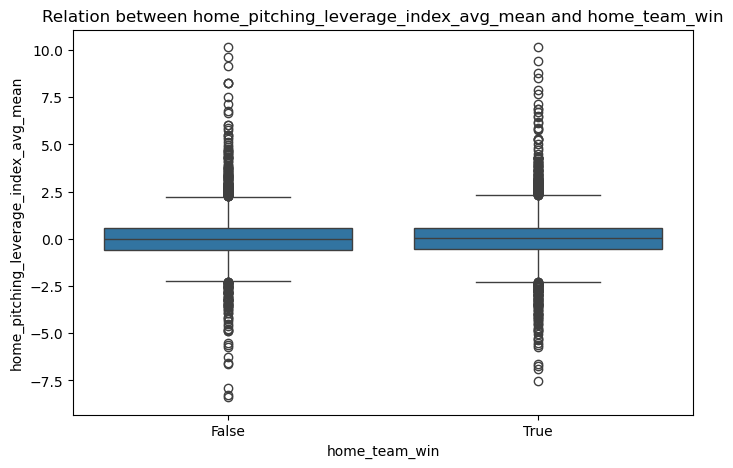

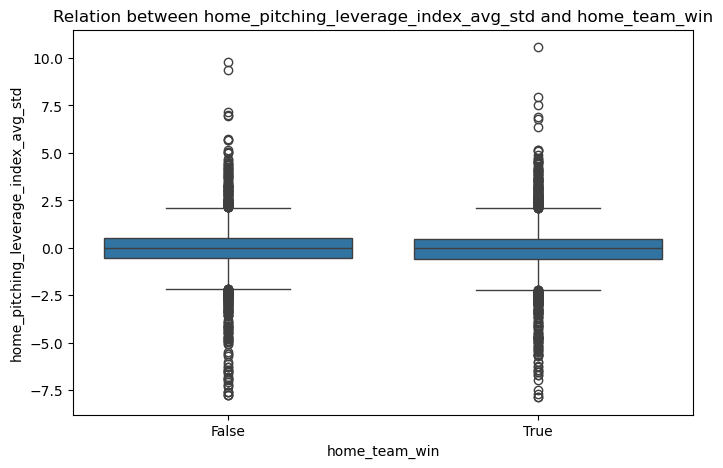

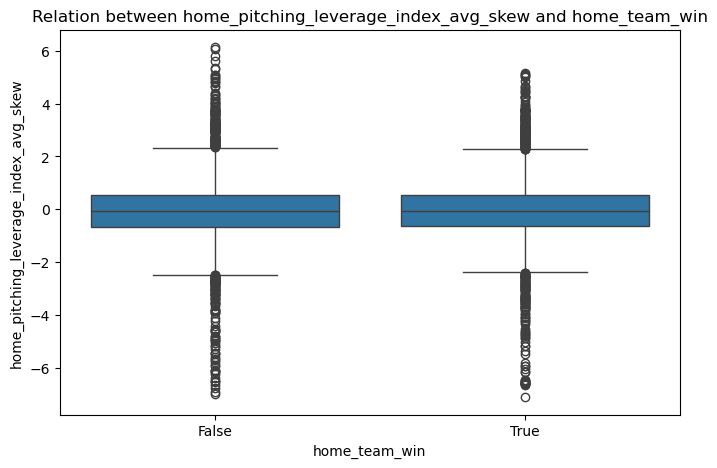

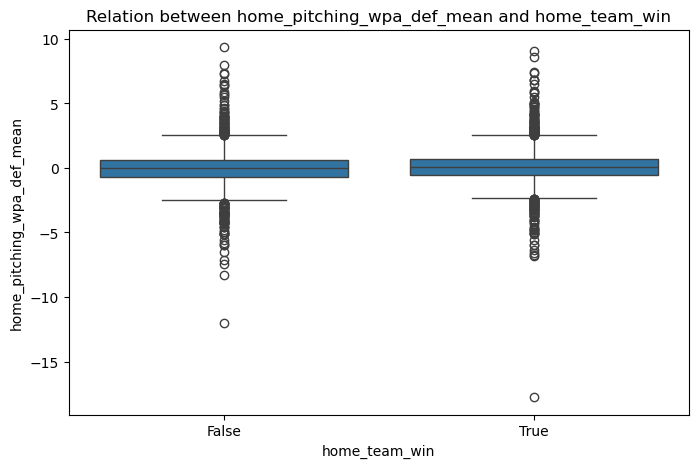

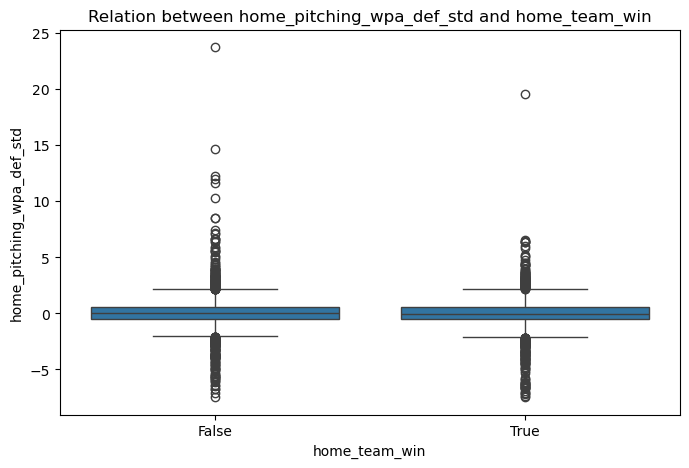

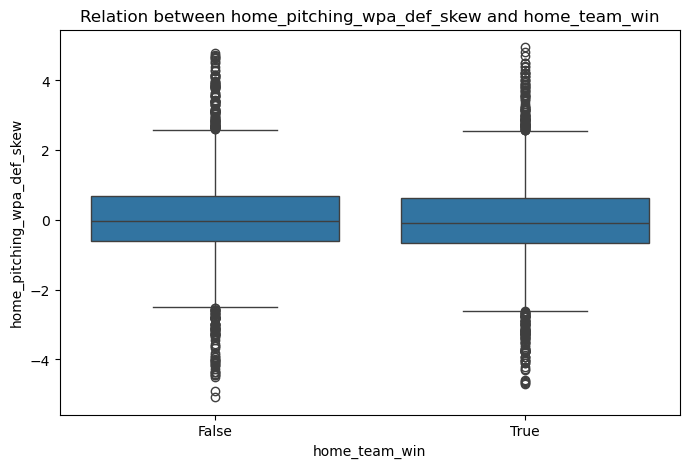

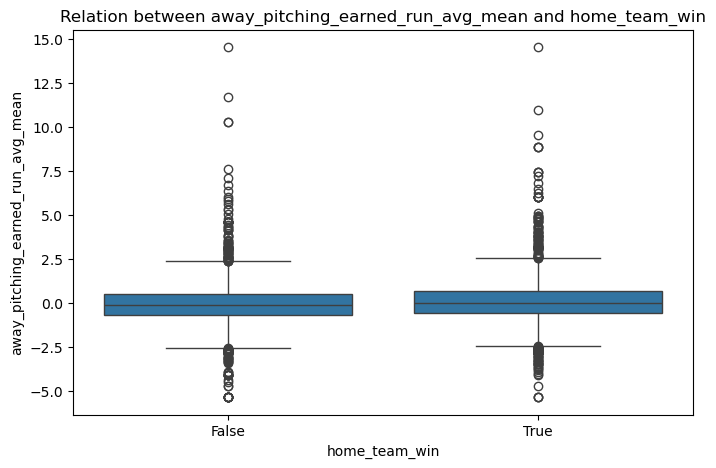

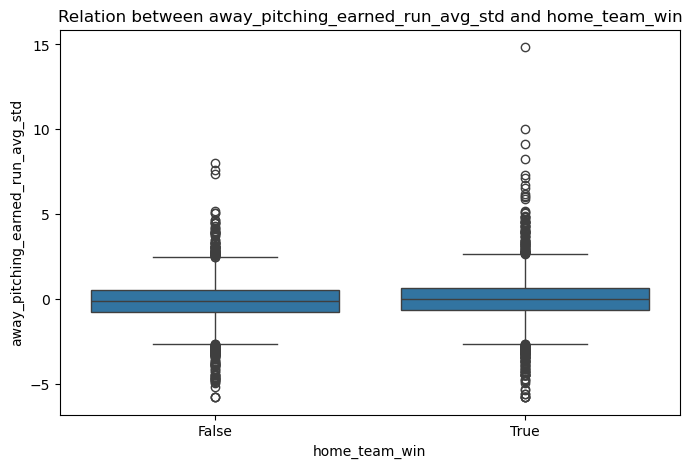

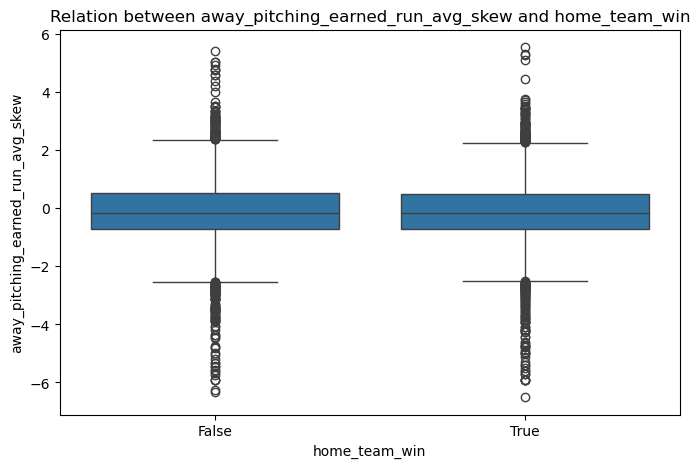

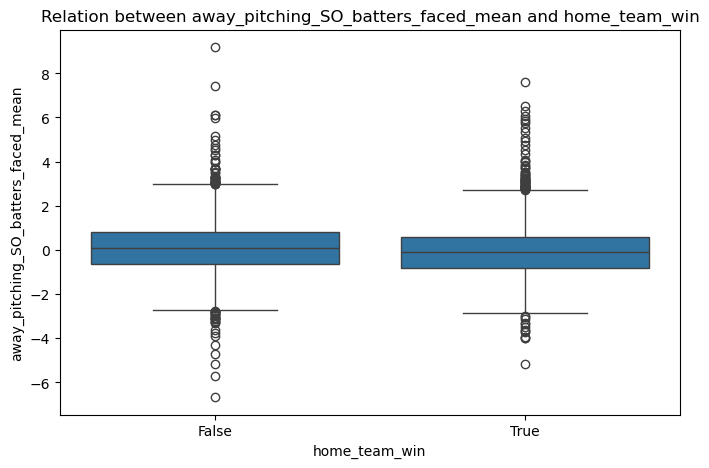

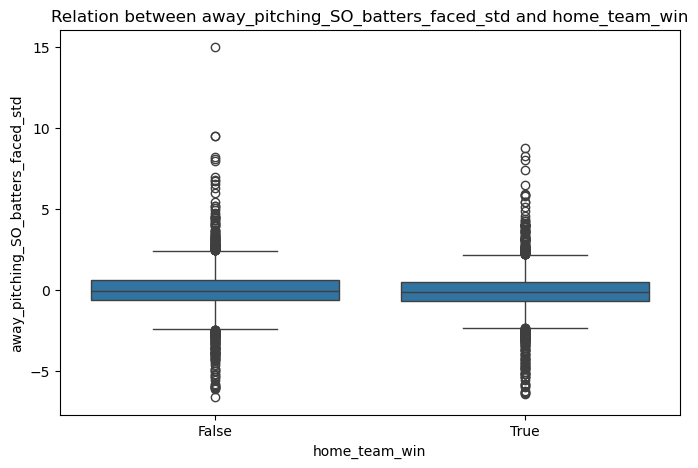

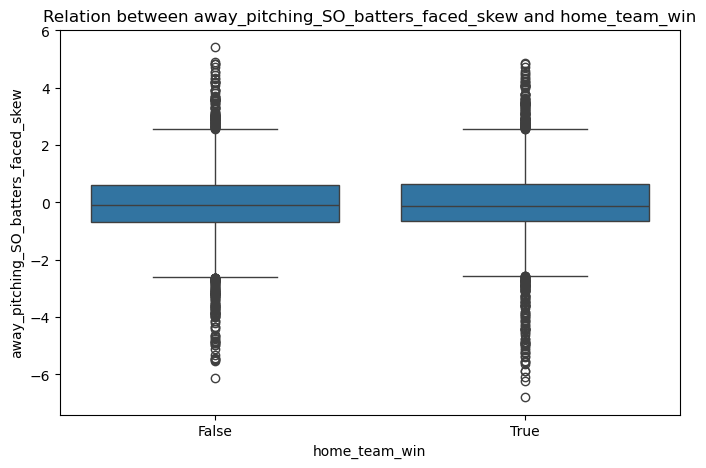

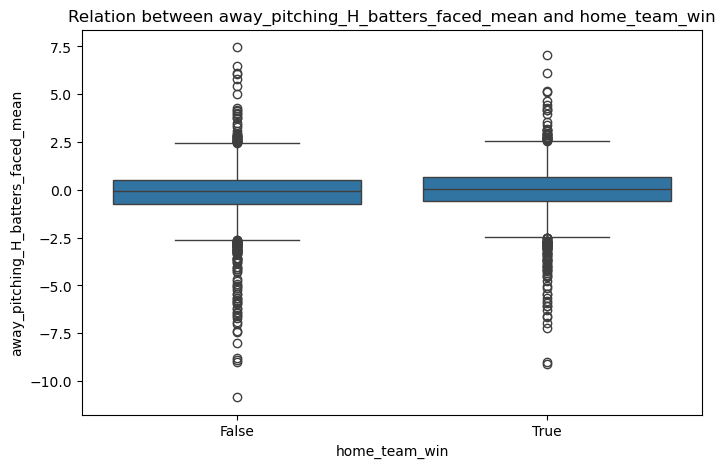

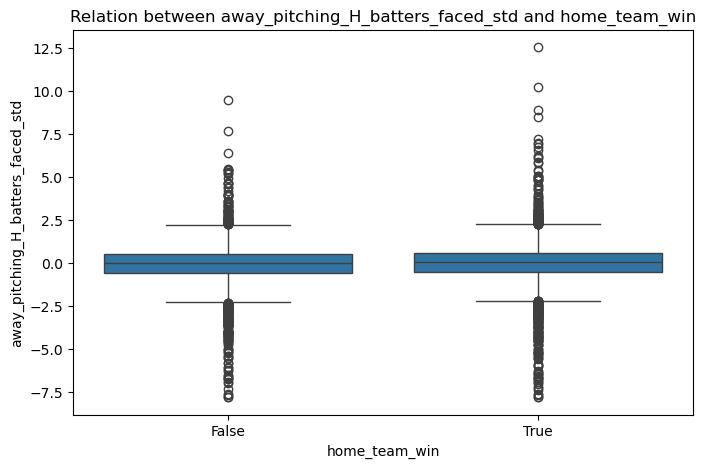

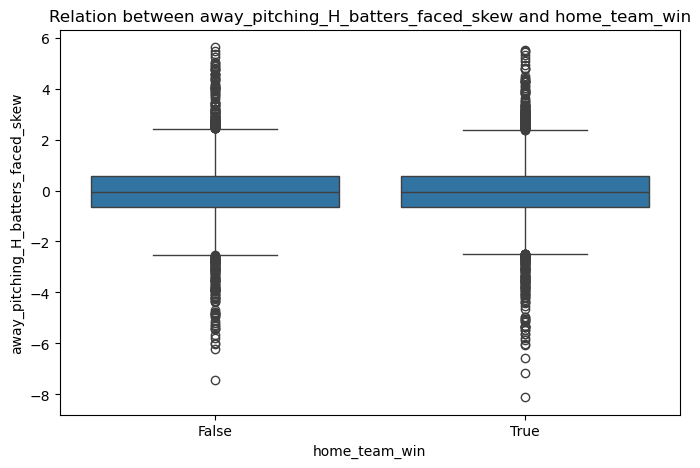

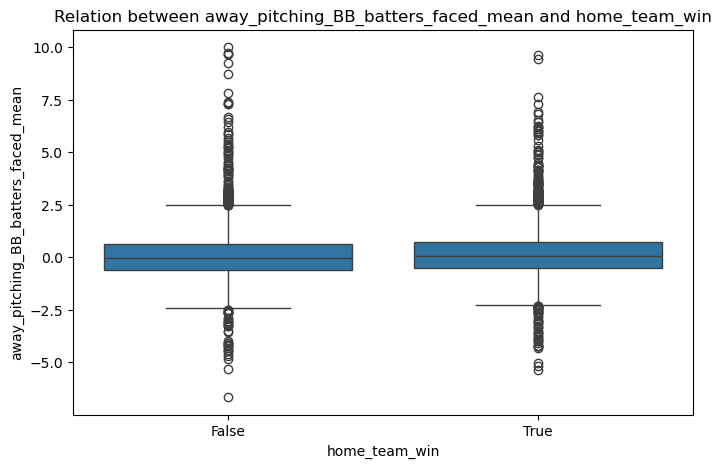

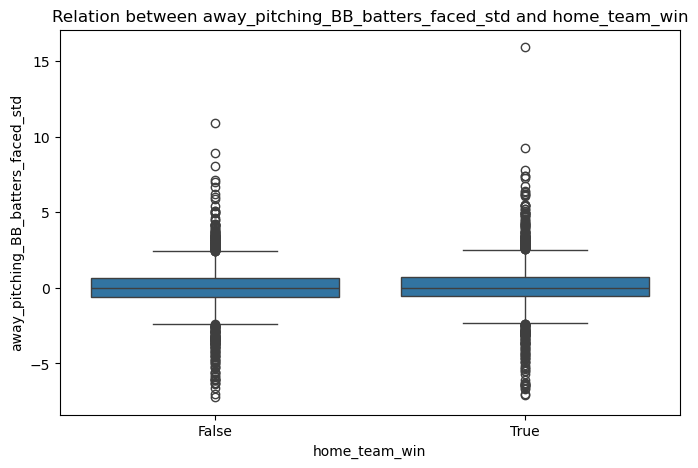

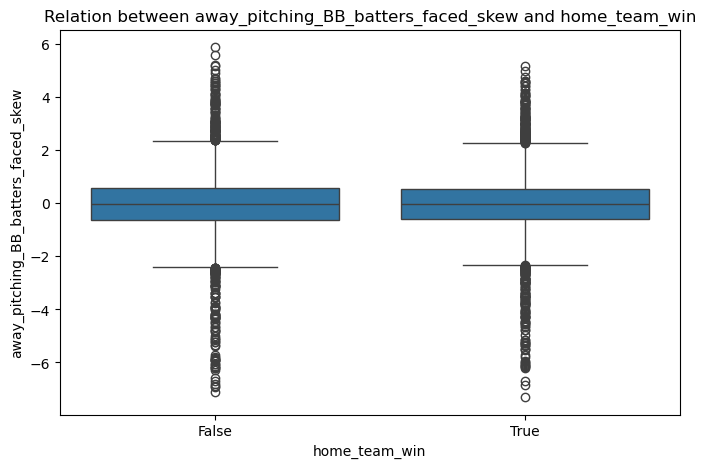

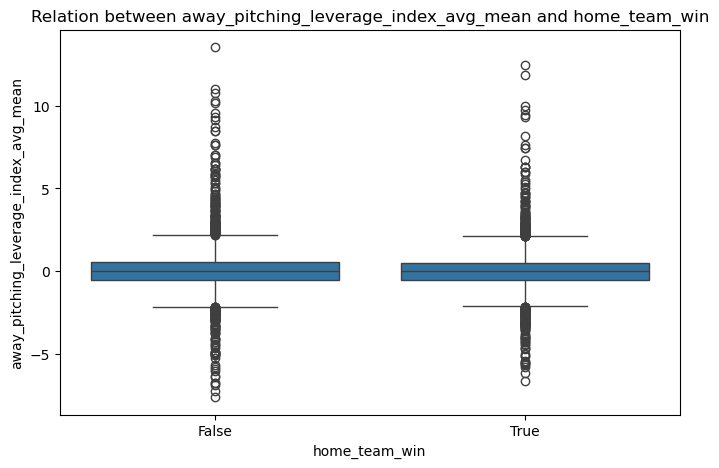

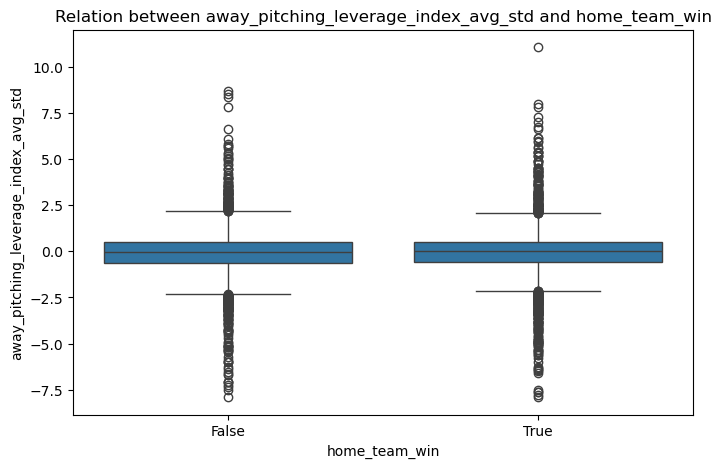

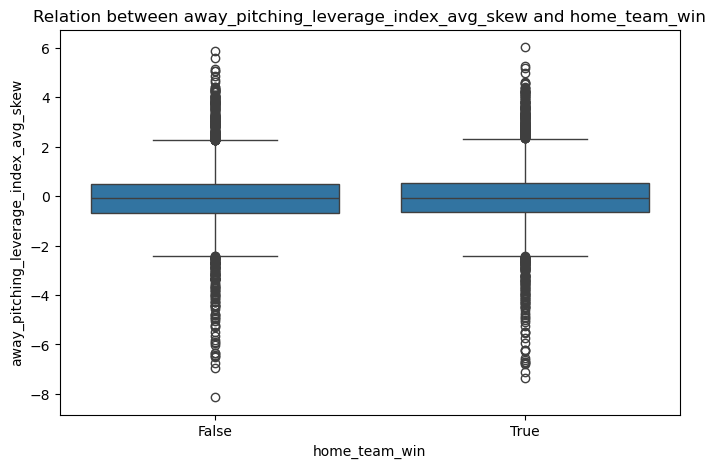

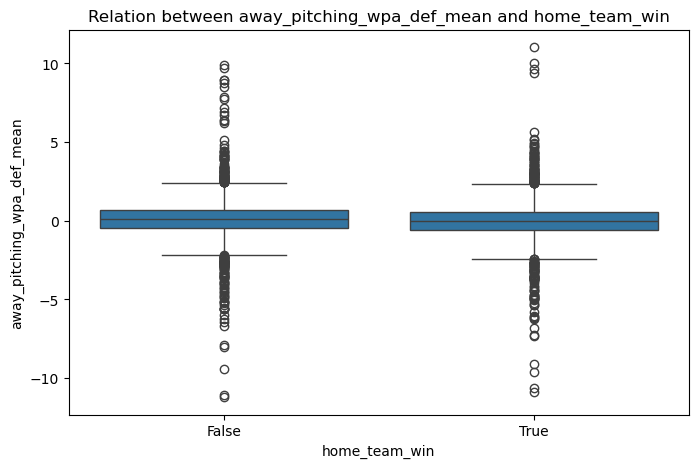

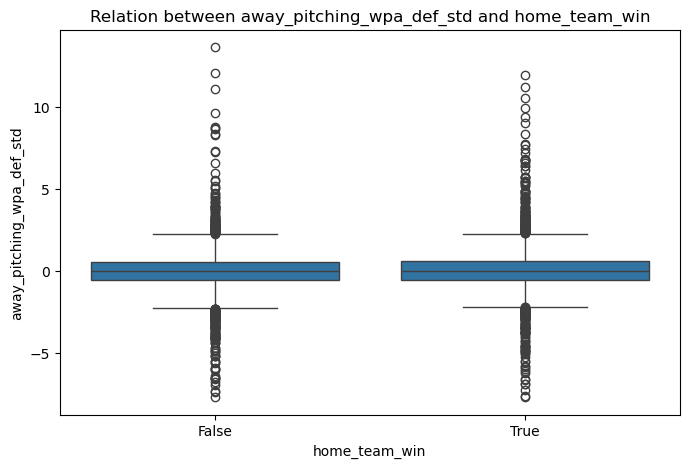

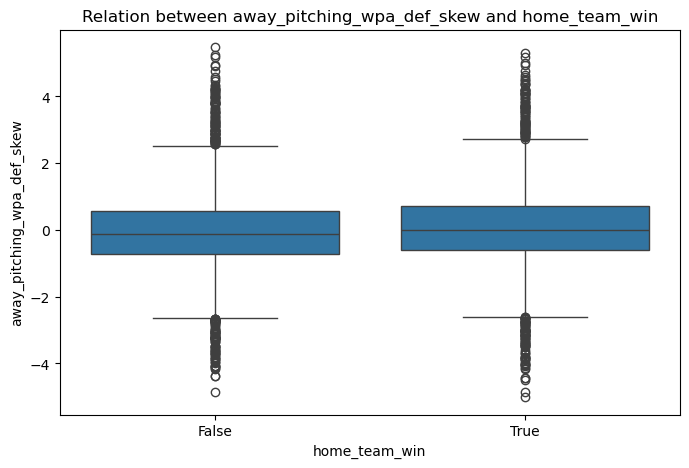

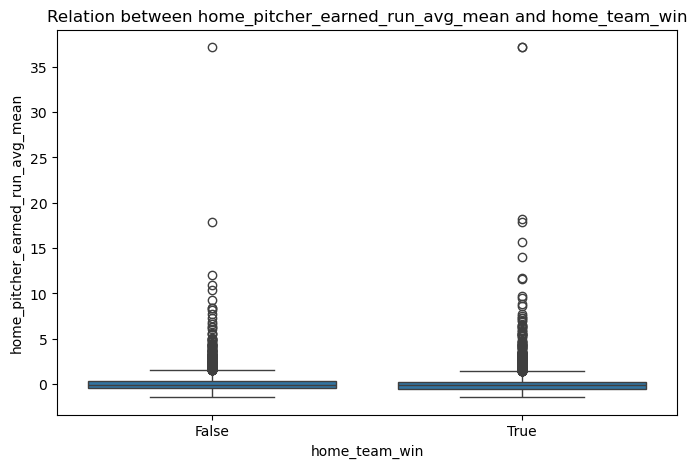

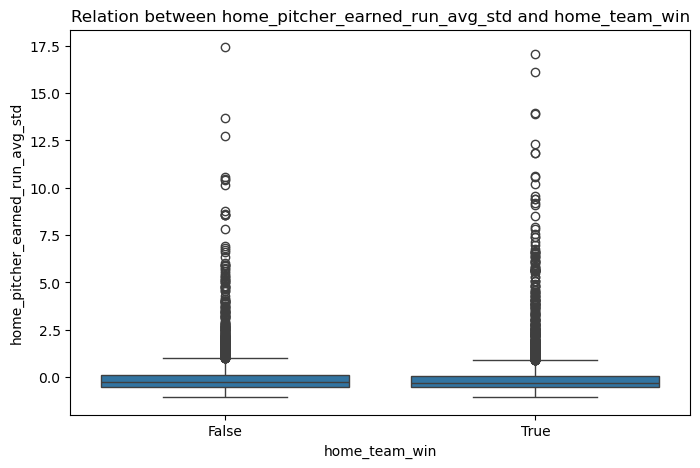

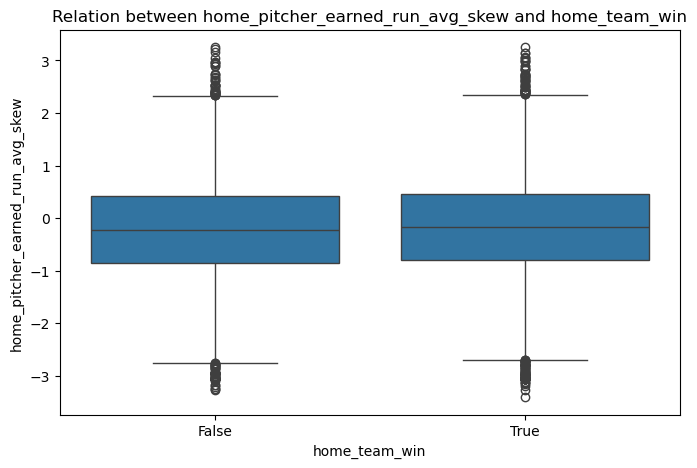

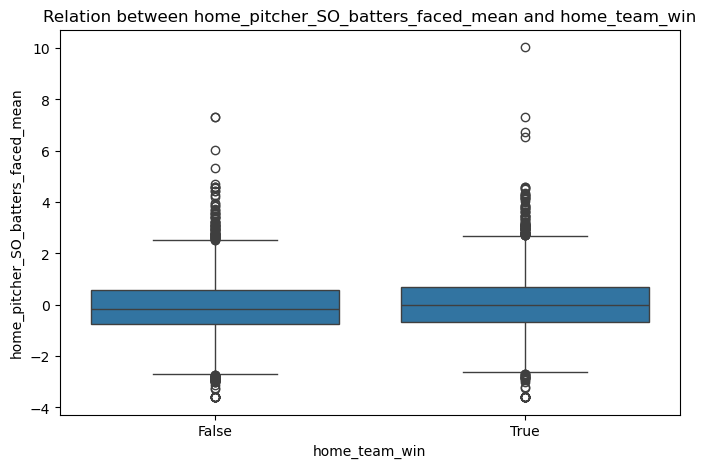

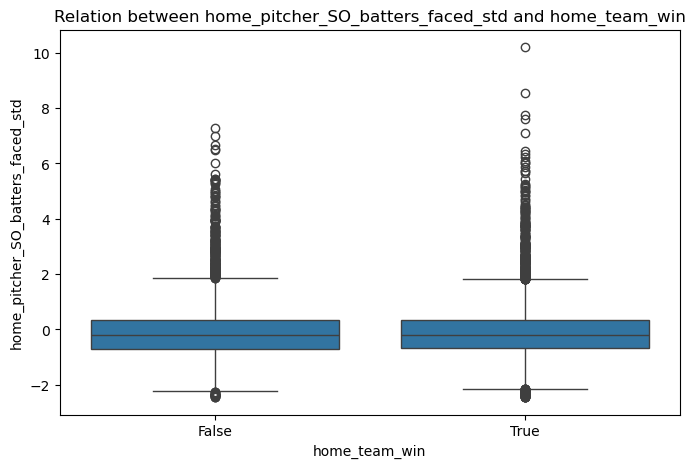

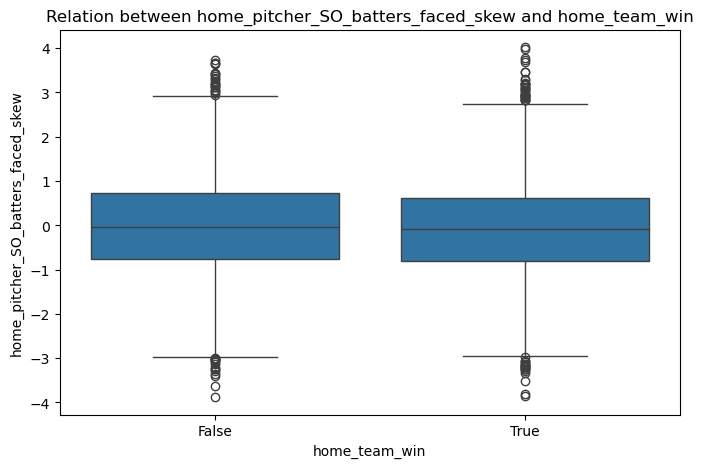

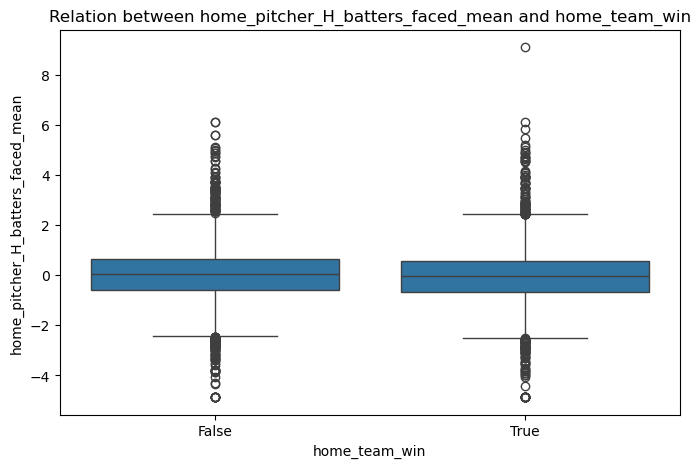

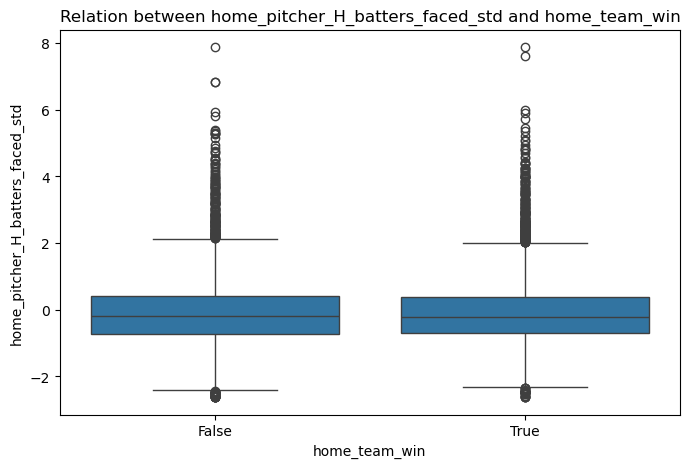

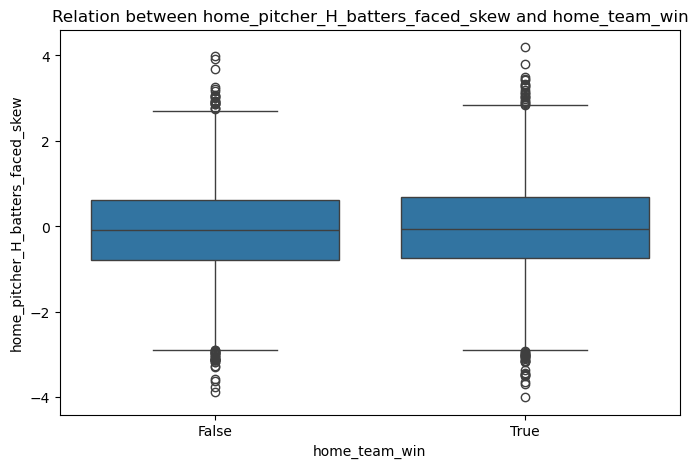

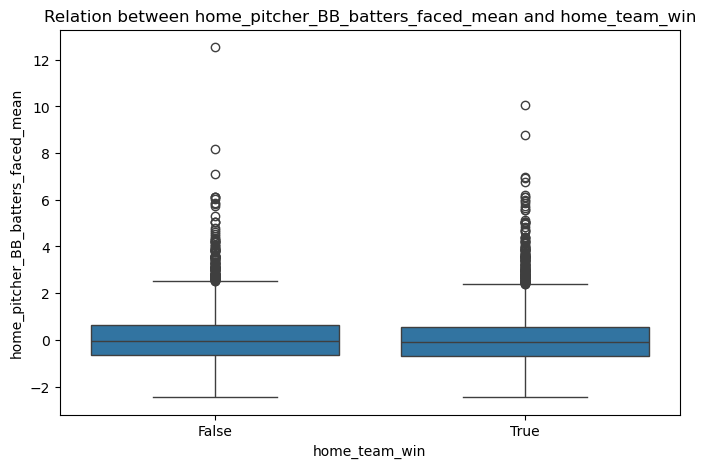

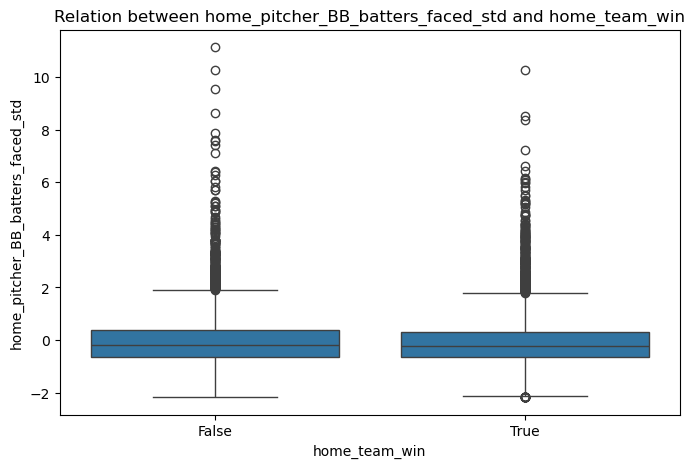

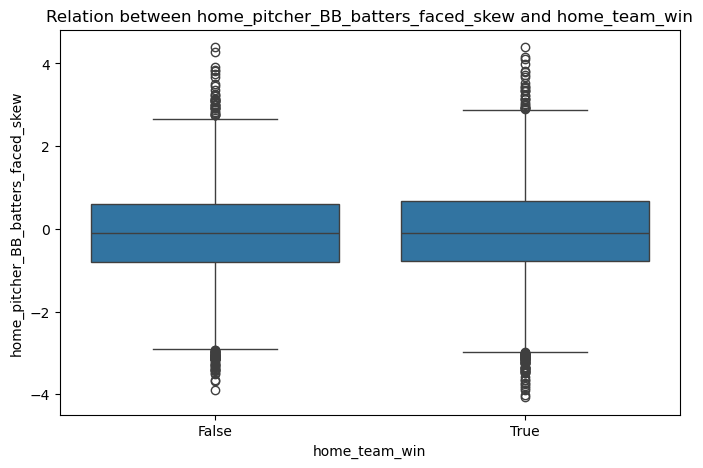

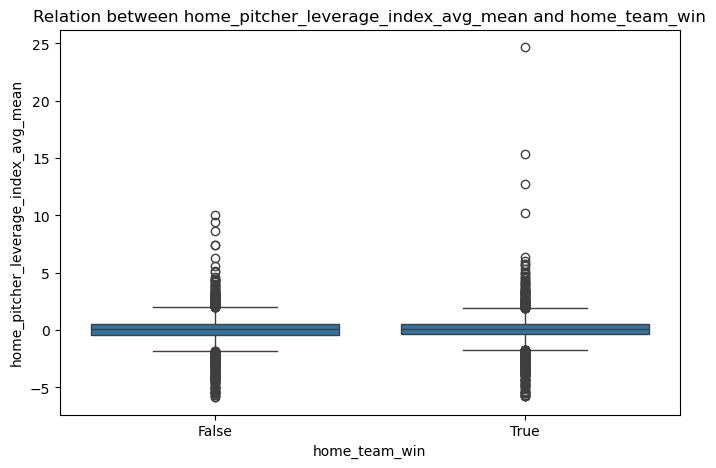

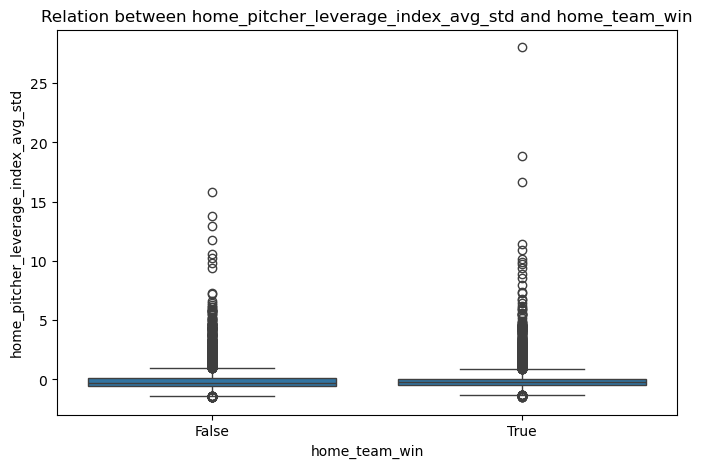

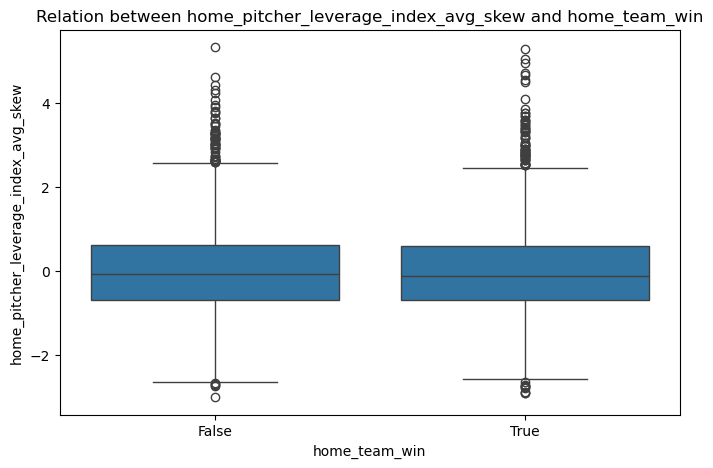

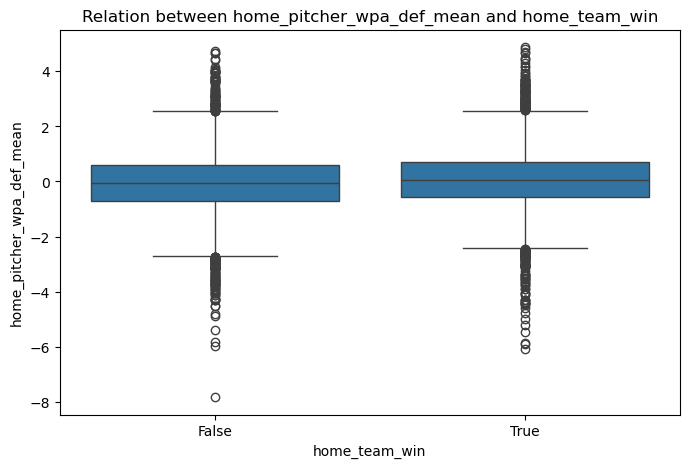

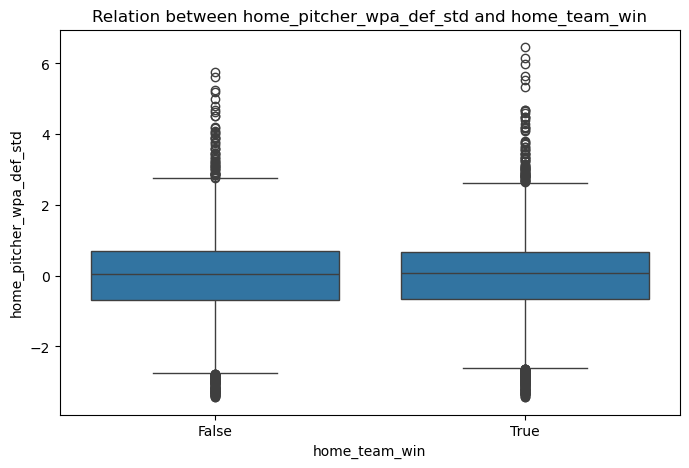

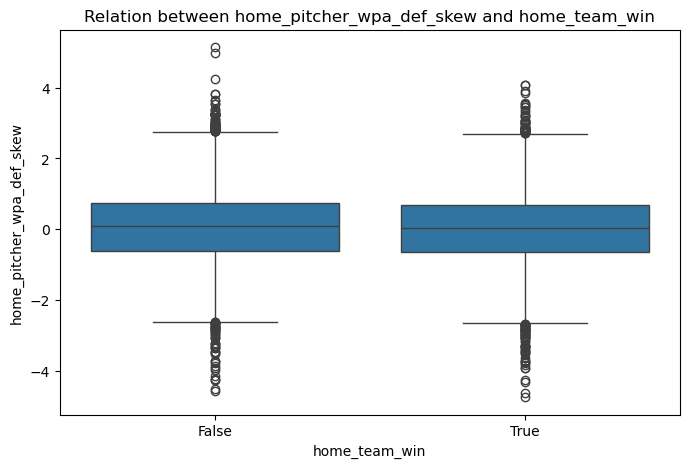

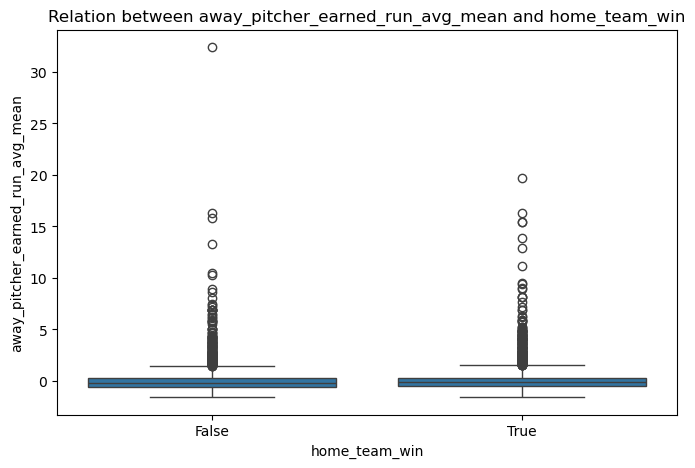

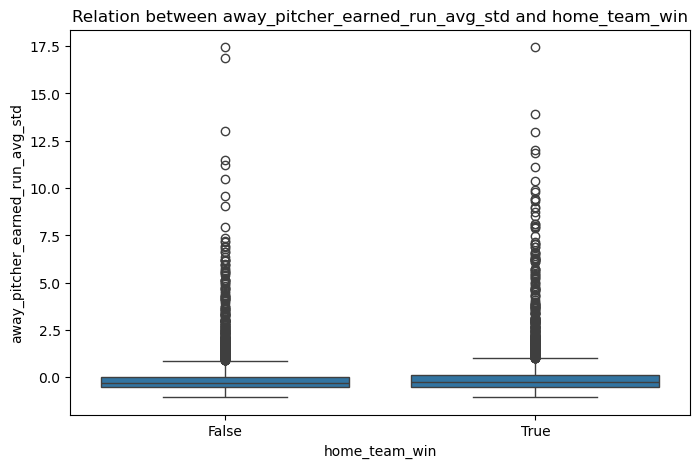

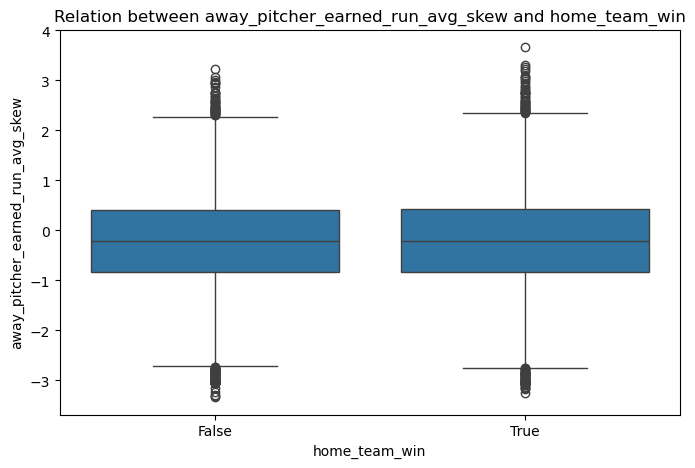

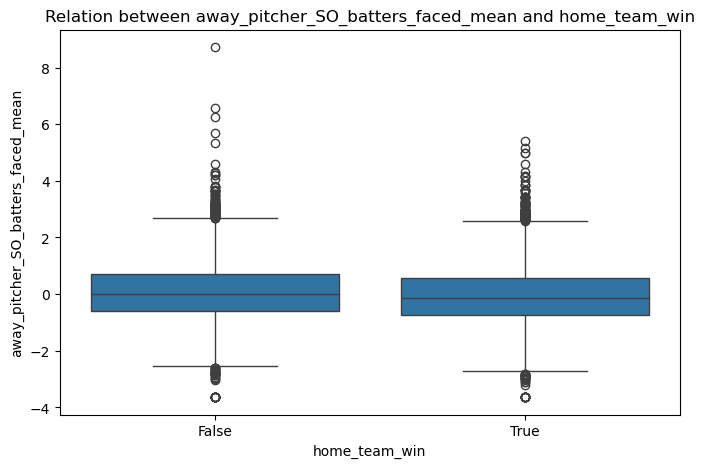

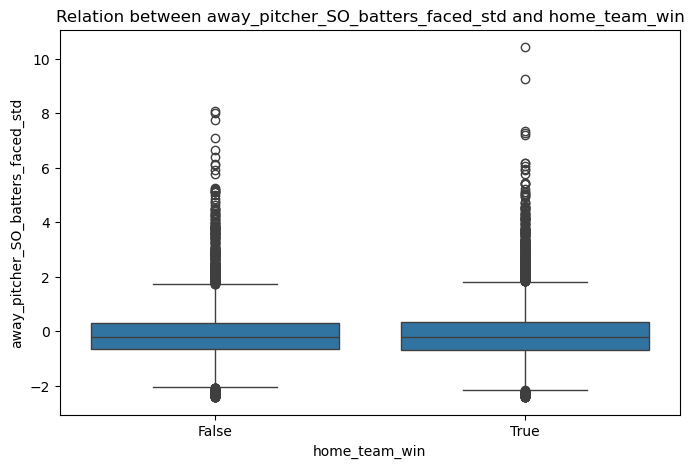

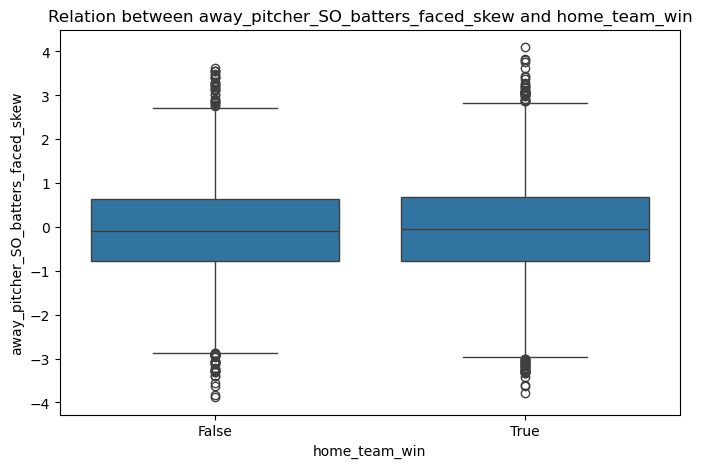

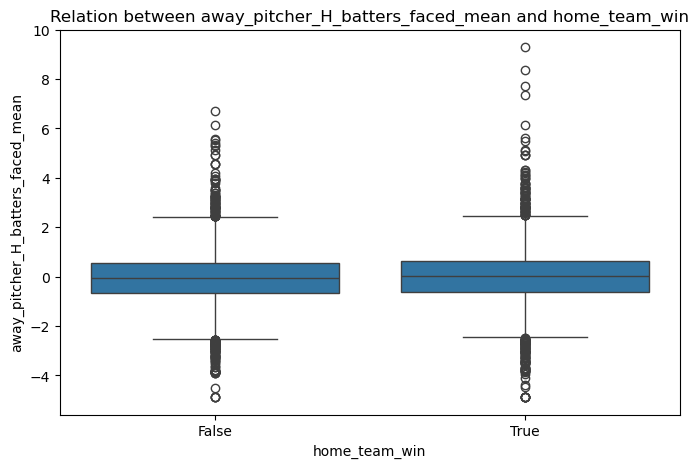

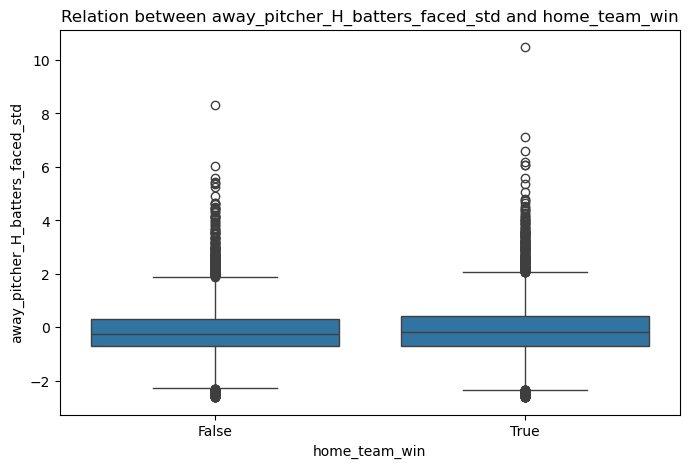

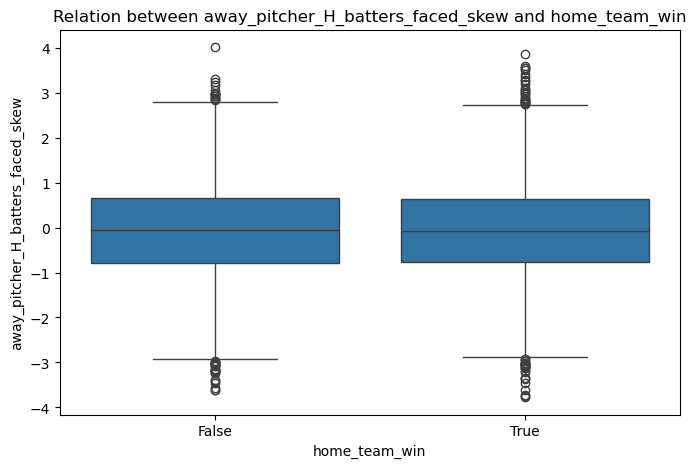

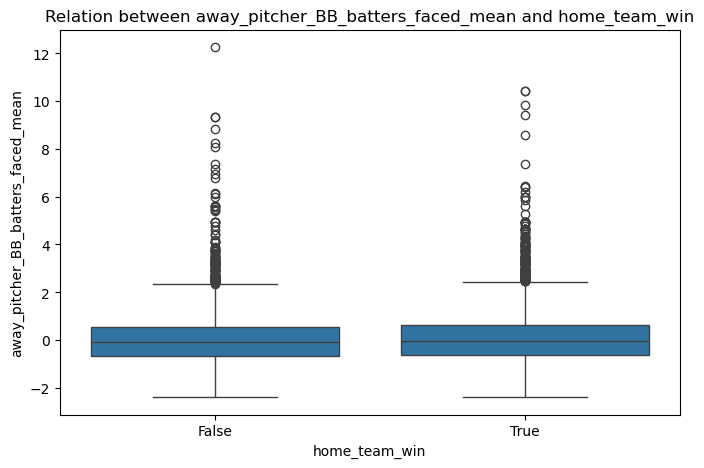

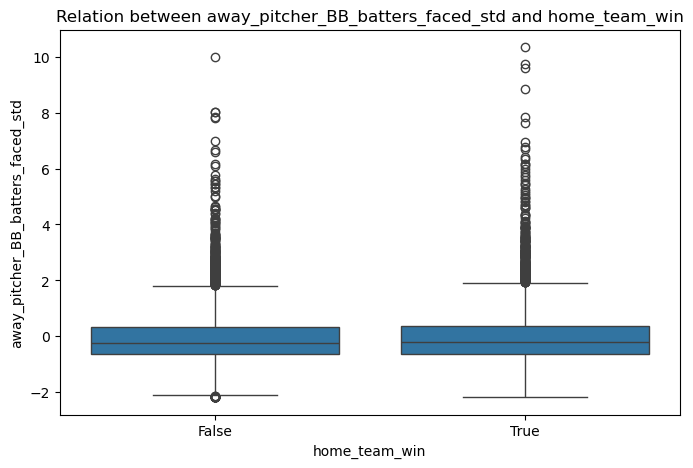

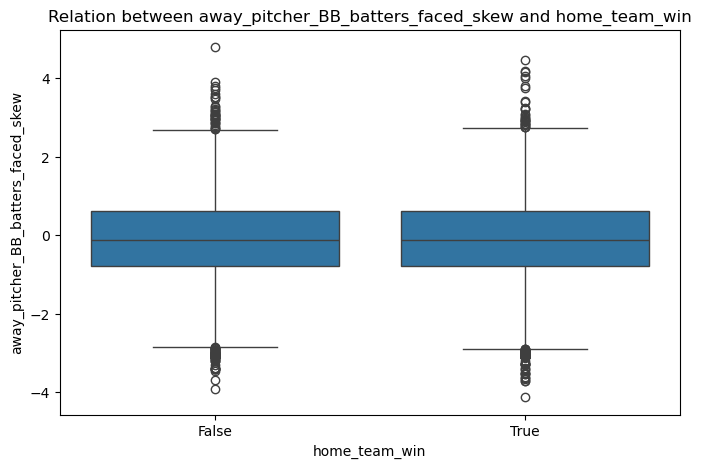

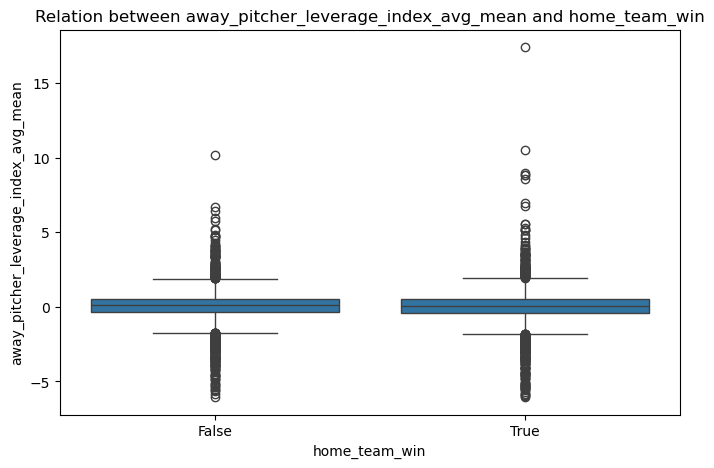

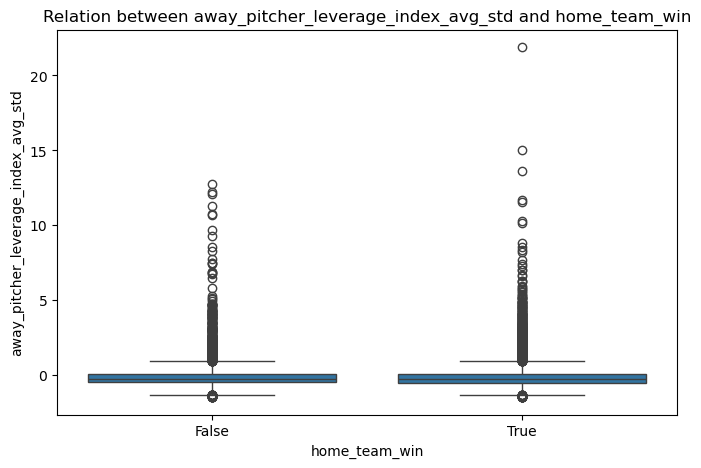

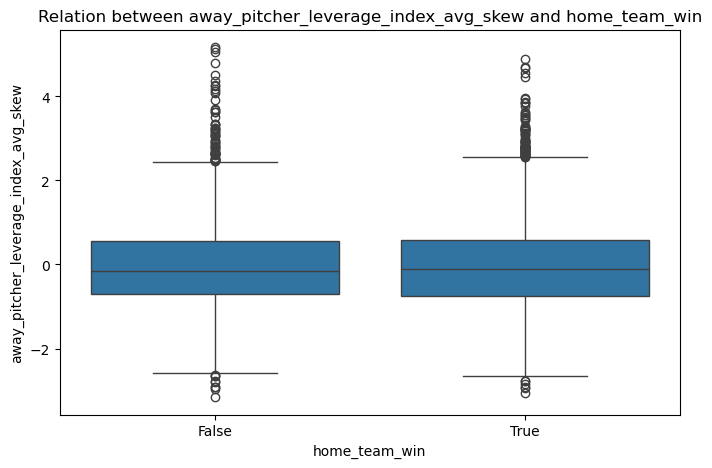

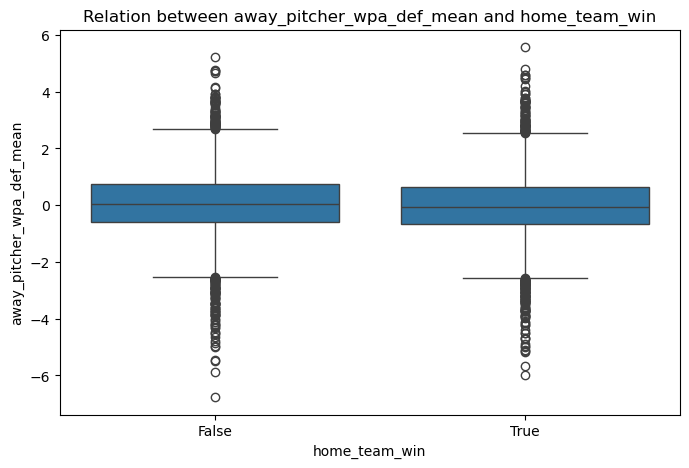

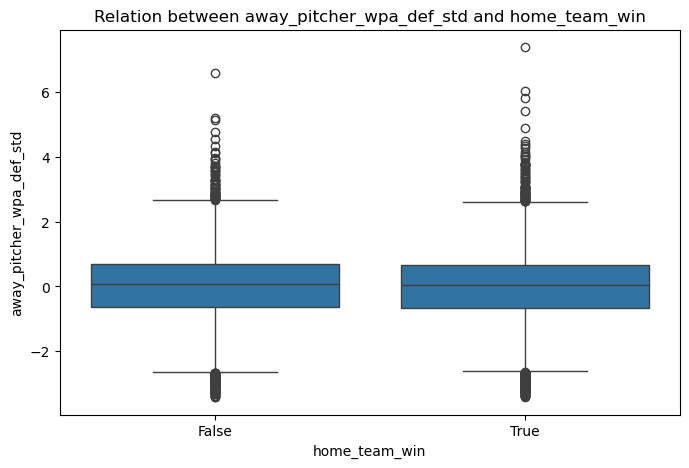

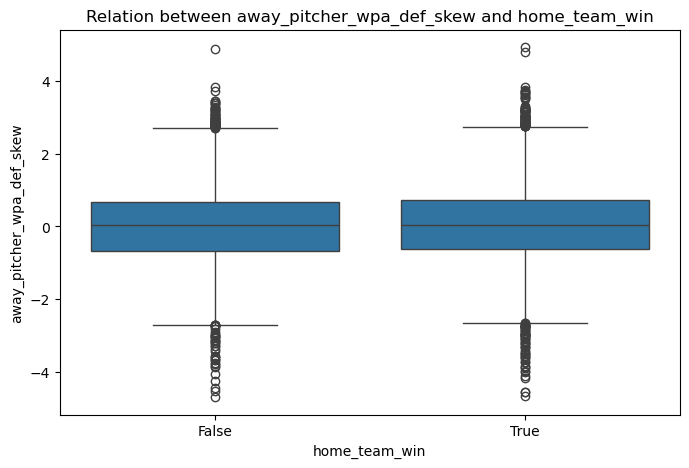

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 加載數據
df = pd.read_csv("/Users/yhk/Desktop/大三上/HTML/FP/HTML 2024 Fall Final Project Stage 1/train_data.csv")

# 檢查數據的基本資訊
def data_overview(df):
    print("\n[1] Data Overview:")
    print(df.info())
    
    print("\n[2] Missing Value Statistics:")
    print(df.isnull().sum())
    
    print("\n[3] Descriptive Statistics:")
    print(df.describe(include='all'))

def analyze_variable_types(df):
    numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
    print("\n[4] Data Type Analysis:")
    print(f"Numerical Variables: {numerical_vars}")
    print(f"Categorical Variables: {categorical_vars}")
    return numerical_vars, categorical_vars

# 可視化目標變數
def visualize_target_distribution(df, target_column):
    plt.figure(figsize=(8, 5))
    if df[target_column].dtype == 'object' or df[target_column].nunique() < 10:
        sns.countplot(data=df, x=target_column)
    else:
        sns.histplot(df[target_column], bins=30, kde=True)
    plt.title(f'Distribution of {target_column}')
    plt.show()

# 變數與目標變數的關係分析
def analyze_correlations(df, numerical_vars, target_column):
    if target_column in numerical_vars:
        correlation_matrix = df[numerical_vars].corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation between Numerical Variables')
        plt.show()
    else:
        print("\n[5] Relation between Categorical and Numerical Variables:")
        for col in numerical_vars:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x=df[target_column], y=df[col])
            plt.title(f'Relation between {col} and {target_column}')
            plt.show()

# 主函數，執行所有分析
def main_analysis(df, target_column):
    data_overview(df)
    numerical_vars, categorical_vars = analyze_variable_types(df)
    # visualize_target_distribution(df, target_column)
    analyze_correlations(df, numerical_vars, target_column)

# 示例調用
main_analysis(df, 'home_team_win')


In [3]:
!cd /Users/yhk/Desktop/大三上/HTML/FP
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import optuna
from datetime import datetime

# 設置隨機種子以確保結果可重現
torch.manual_seed(42)
np.random.seed(42)

# 1. 讀取數據
data = pd.read_csv("/Users/yhk/Desktop/大三上/HTML/FP/HTML 2024 Fall Final Project Stage 1/train_data.csv")
test_data_pred = pd.read_csv("/Users/yhk/Desktop/大三上/HTML/FP/HTML 2024 Fall Final Project Stage 1/same_season_test_dataset.csv")  # 預測數據

numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# 填補數值欄位
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
test_data_pred[numeric_cols] = test_data_pred[numeric_cols].fillna(test_data_pred[numeric_cols].mean())

# 填補非數值欄位（選擇使用眾數或 'Unknown'）
for col in categorical_cols:
    if data[col].isnull().any():
        mode = data[col].mode()[0]  # 或者使用 'Unknown'
        data[col].fillna(mode, inplace=True)
    if col in test_data_pred.columns and test_data_pred[col].isnull().any():
        mode = test_data_pred[col].mode()[0]
        test_data_pred[col].fillna(mode, inplace=True)

# 2. 計算差異欄位
difference_columns = [
    'team_rest_diff', "pitcher_rest_diff", "batting_batting_avg_10RA_diff","batting_onbase_perc_10RA_diff","batting_onbase_plus_slugging_10RA_diff","batting_leverage_index_avg_10RA_diff","batting_RBI_10RA_diff",
    "pitching_earned_run_avg_10RA_diff","pitching_SO_batters_faced_10RA_diff","pitching_H_batters_faced_10RA_diff","pitching_BB_batters_faced_10RA_diff","pitcher_earned_run_avg_10RA_diff","pitcher_SO_batters_faced_10RA_diff","pitcher_H_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff",
    "batting_batting_avg_mean_diff", "batting_onbase_perc_mean_diff", "batting_onbase_plus_slugging_mean_diff", "batting_leverage_index_avg_mean_diff", "batting_wpa_bat_mean_diff", "batting_RBI_mean_diff",
    "pitching_earned_run_avg_mean_diff", "pitching_SO_batters_faced_mean_diff", "pitching_H_batters_faced_mean_diff", "pitching_BB_batters_faced_mean_diff", "pitching_leverage_index_avg_mean_diff", "pitching_wpa_def_mean_diff",
    "pitcher_earned_run_avg_mean_diff"  ,"pitcher_SO_batters_faced_mean_diff"   ,"pitcher_H_batters_faced_mean_diff"   ,"pitcher_BB_batters_faced_mean_diff"   ,"pitcher_leverage_index_avg_mean_diff"   ,"pitcher_wpa_def_mean_diff","date"           
]


for col in difference_columns:
    if col not in data.columns:
        # 假設原始數據中存在相應的欄位，計算差異
        home_col = 'home_' + col.split('_diff')[0]
        away_col = 'away_' + col.split('_diff')[0]
        data[col] = data[home_col] - data[away_col]
        if home_col in test_data_pred.columns and away_col in test_data_pred.columns:
            test_data_pred[col] = test_data_pred[home_col] - test_data_pred[away_col]

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/3806293331.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col] = data[home_col] - data[away_col]
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/3806293331.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data_pred[col] = test_data_pred[home_col] - test_data_pred[away_col]
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/3806293331.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

In [4]:
!pip install torch_optimizer
import torch_optimizer


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# NN

In [5]:
!pip install lion-pytorch
from lion_pytorch import Lion


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import torch_optimizer
# 4. 定義特徵和標籤
features = [
    "is_night_game","home_team_rest","away_team_rest","home_pitcher_rest", "away_pitcher_rest","season","home_batting_batting_avg_10RA","home_batting_onbase_perc_10RA","home_batting_onbase_plus_slugging_10RA","home_batting_leverage_index_avg_10RA","home_batting_RBI_10RA","away_batting_batting_avg_10RA",
    "away_batting_onbase_perc_10RA","away_batting_onbase_plus_slugging_10RA","away_batting_leverage_index_avg_10RA","away_batting_RBI_10RA","home_pitching_earned_run_avg_10RA","home_pitching_SO_batters_faced_10RA","home_pitching_H_batters_faced_10RA","home_pitching_BB_batters_faced_10RA","away_pitching_earned_run_avg_10RA","away_pitching_SO_batters_faced_10RA","away_pitching_H_batters_faced_10RA","away_pitching_BB_batters_faced_10RA","home_pitcher_earned_run_avg_10RA","home_pitcher_SO_batters_faced_10RA","home_pitcher_H_batters_faced_10RA","home_pitcher_BB_batters_faced_10RA","away_pitcher_earned_run_avg_10RA","away_pitcher_SO_batters_faced_10RA",
    'away_pitcher_H_batters_faced_10RA','away_pitcher_BB_batters_faced_10RA','home_team_errors_mean','home_team_errors_std','home_team_errors_skew','away_team_errors_mean','away_team_errors_std','away_team_errors_skew','home_team_spread_mean','home_team_spread_std','home_team_spread_skew','away_team_spread_mean','away_team_spread_std','away_team_spread_skew','home_team_wins_mean','home_team_wins_std','home_team_wins_skew','away_team_wins_mean','away_team_wins_std','away_team_wins_skew','home_batting_batting_avg_mean','home_batting_batting_avg_std','home_batting_batting_avg_skew','home_batting_onbase_perc_mean','home_batting_onbase_perc_std','home_batting_onbase_perc_skew','home_batting_onbase_plus_slugging_mean','home_batting_onbase_plus_slugging_std','home_batting_onbase_plus_slugging_skew','home_batting_leverage_index_avg_mean','home_batting_leverage_index_avg_std','home_batting_leverage_index_avg_skew','home_batting_wpa_bat_mean','home_batting_wpa_bat_std','home_batting_wpa_bat_skew','home_batting_RBI_mean','home_batting_RBI_std','home_batting_RBI_skew','away_batting_batting_avg_mean','away_batting_batting_avg_std',
    'away_batting_batting_avg_skew','away_batting_onbase_perc_mean','away_batting_onbase_perc_std','away_batting_onbase_perc_skew','away_batting_onbase_plus_slugging_mean','away_batting_onbase_plus_slugging_std','away_batting_onbase_plus_slugging_skew','away_batting_leverage_index_avg_mean','away_batting_leverage_index_avg_std','away_batting_leverage_index_avg_skew','away_batting_wpa_bat_mean','away_batting_wpa_bat_std','away_batting_wpa_bat_skew','away_batting_RBI_mean','away_batting_RBI_std','away_batting_RBI_skew','home_pitching_earned_run_avg_mean','home_pitching_earned_run_avg_std','home_pitching_earned_run_avg_skew','home_pitching_SO_batters_faced_mean','home_pitching_SO_batters_faced_std','home_pitching_SO_batters_faced_skew','home_pitching_H_batters_faced_mean','home_pitching_H_batters_faced_std','home_pitching_H_batters_faced_skew','home_pitching_BB_batters_faced_mean','home_pitching_BB_batters_faced_std','home_pitching_BB_batters_faced_skew','home_pitching_leverage_index_avg_mean','home_pitching_leverage_index_avg_std','home_pitching_leverage_index_avg_skew','home_pitching_wpa_def_mean','home_pitching_wpa_def_std','home_pitching_wpa_def_skew','away_pitching_earned_run_avg_mean','away_pitching_earned_run_avg_std','away_pitching_earned_run_avg_skew','away_pitching_SO_batters_faced_mean','away_pitching_SO_batters_faced_std','away_pitching_SO_batters_faced_skew','away_pitching_H_batters_faced_mean','away_pitching_H_batters_faced_std','away_pitching_H_batters_faced_skew','away_pitching_BB_batters_faced_mean','away_pitching_BB_batters_faced_std','away_pitching_BB_batters_faced_skew','away_pitching_leverage_index_avg_mean','away_pitching_leverage_index_avg_std',
    'away_pitching_leverage_index_avg_skew','away_pitching_wpa_def_mean','away_pitching_wpa_def_std','away_pitching_wpa_def_skew','home_pitcher_earned_run_avg_mean','home_pitcher_earned_run_avg_std','home_pitcher_earned_run_avg_skew','home_pitcher_SO_batters_faced_mean','home_pitcher_SO_batters_faced_std','home_pitcher_SO_batters_faced_skew','home_pitcher_H_batters_faced_mean','home_pitcher_H_batters_faced_std','home_pitcher_H_batters_faced_skew','home_pitcher_BB_batters_faced_mean','home_pitcher_BB_batters_faced_std','home_pitcher_BB_batters_faced_skew','home_pitcher_leverage_index_avg_mean','home_pitcher_leverage_index_avg_std','home_pitcher_leverage_index_avg_skew','home_pitcher_wpa_def_mean','home_pitcher_wpa_def_std','home_pitcher_wpa_def_skew','away_pitcher_earned_run_avg_mean',"away_pitcher_earned_run_avg_std","away_pitcher_earned_run_avg_skew","away_pitcher_SO_batters_faced_mean","away_pitcher_SO_batters_faced_std","away_pitcher_SO_batters_faced_skew","away_pitcher_H_batters_faced_mean","away_pitcher_H_batters_faced_std","away_pitcher_H_batters_faced_skew","away_pitcher_BB_batters_faced_mean","away_pitcher_BB_batters_faced_std","away_pitcher_BB_batters_faced_skew","away_pitcher_leverage_index_avg_mean","away_pitcher_leverage_index_avg_std","away_pitcher_leverage_index_avg_skew","away_pitcher_wpa_def_mean","away_pitcher_wpa_def_std","away_pitcher_wpa_def_skew", 'team_rest_diff', "pitcher_rest_diff", "batting_batting_avg_10RA_diff","batting_onbase_perc_10RA_diff","batting_onbase_plus_slugging_10RA_diff","batting_leverage_index_avg_10RA_diff","batting_RBI_10RA_diff",
    "pitching_earned_run_avg_10RA_diff","pitching_SO_batters_faced_10RA_diff","pitching_H_batters_faced_10RA_diff","pitching_BB_batters_faced_10RA_diff","pitcher_earned_run_avg_10RA_diff","pitcher_SO_batters_faced_10RA_diff","pitcher_H_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff",
    "batting_batting_avg_mean_diff", "batting_onbase_perc_mean_diff", "batting_onbase_plus_slugging_mean_diff", "batting_leverage_index_avg_mean_diff", "batting_wpa_bat_mean_diff", "batting_RBI_mean_diff",
    "pitching_earned_run_avg_mean_diff", "pitching_SO_batters_faced_mean_diff", "pitching_H_batters_faced_mean_diff", "pitching_BB_batters_faced_mean_diff", "pitching_leverage_index_avg_mean_diff", "pitching_wpa_def_mean_diff",
    "pitcher_earned_run_avg_mean_diff"  ,"pitcher_SO_batters_faced_mean_diff"   ,"pitcher_H_batters_faced_mean_diff"   ,"pitcher_BB_batters_faced_mean_diff"   ,"pitcher_leverage_index_avg_mean_diff"   ,"pitcher_wpa_def_mean_diff"           

]
# 主訓練數據的特徵和標籤
X = data[features]
y = data['home_team_win']

# 填補缺失值
X.fillna(X.mean(), inplace=True)
X_pred = test_data_pred[features]
X_pred.fillna(X_pred.mean(), inplace=True)

# 5. 數據標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pred_scaled = scaler.transform(X_pred)


# 7. 將數據轉換為 PyTorch 張量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# 將所有數據放在同一設備上
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# 準備預測數據張量
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32).to(device)

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/3325096972.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/3325096972.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred.fillna(X_pred.mean(), inplace=True)


In [11]:


# 8. 定義神經網絡模型
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation_fn):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.activation = activation_fn
        
        # 第一層：從輸入到第一個隱藏層
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rates[0]))
        
        # 中間的隱藏層
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rates[i]))
        
        # 輸出層：最後一個隱藏層到輸出
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        
    def forward(self, x):
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = layer(x)
            x = bn(x)
            x = self.activation(x)
            x = dropout(x)
        x = self.output_layer(x)
        return x  # Raw logits

# 9. 定義Optuna目標函數
def objective(trial):
    # 建議隱藏層的數量（1到5層）
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    # 為每一層建議隱藏單元數和dropout率
    hidden_sizes = []
    dropout_rates = []
    for i in range(n_layers):
        hidden_size = trial.suggest_int(f"hidden_size_l{i}", 16, 256, step=16)
        dropout_rate = trial.suggest_float(f"dropout_rate_l{i}", 0.0, 0.5)
        hidden_sizes.append(hidden_size)
        dropout_rates.append(dropout_rate)
    
    # 學習率
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    # 權重衰減（L2正則化）
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    # 激活函數
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])
    if activation_name == "ReLU":
        activation_fn = nn.ReLU()
    elif activation_name == "LeakyReLU":
        activation_fn = nn.LeakyReLU()
    elif activation_name == "ELU":
        activation_fn = nn.ELU()
    
    # 建議批量大小
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512, 1024])
    
    # 初始化模型
    model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    # 損失函數和優化器
    # pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
    
    # 定義學習率調度器
# 根據選擇的 optimizer_name 建立對應的優化器
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
    elif optimizer_name == "RAdam":
        optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "AdaBound":
        optimizer = torch_optimizer.AdaBound(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "Ranger":
        optimizer = torch_optimizer.Ranger(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "Lion":
        optimizer = Lion(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # 定義 LR 調度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    # 數據加載器，劃分為訓練集和驗證集（80-20分割）
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 訓練過程
    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            if torch.isnan(loss):
                return float('inf')  # 如果出現NaN，給予極大損失
            
            loss.backward()
            # 梯度裁剪以防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # 驗證過程
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # 計算 accuracy
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).int()
                correct_predictions += (predicted == targets.int()).sum().item()
                total_predictions += targets.size(0)
        
        # 計算驗證準確率
        val_accuracy = correct_predictions / total_predictions
        average_val_loss = val_loss / len(val_loader)
        
        # 打印每輪驗證結果
        print(f"Epoch {epoch+1}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # 調整學習率調度器
        scheduler.step(val_loss)
    
    # 報告驗證損失並檢查是否應該剪枝
    trial.report(average_val_loss, 0)  # 這裡epoch為0，因為我們只計算一次驗證
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return average_val_loss


# 10. 開始調參
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None)

# 11. 輸出最佳結果
print("最佳參數:", study.best_params)
best_params = study.best_params

# 使用最佳參數構建最終模型

[I 2025-02-26 22:24:55,652] A new study created in memory with name: no-name-219bd695-dcb3-4ac4-b0c2-8e7dd27b5a0b


Epoch 1, Val Loss: 0.7099, Val Accuracy: 0.4941
Epoch 2, Val Loss: 0.6944, Val Accuracy: 0.5411
Epoch 3, Val Loss: 0.6920, Val Accuracy: 0.5569
Epoch 4, Val Loss: 0.6927, Val Accuracy: 0.5578
Epoch 5, Val Loss: 0.6927, Val Accuracy: 0.5583
Epoch 6, Val Loss: 0.6932, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6935, Val Accuracy: 0.5465
Epoch 8, Val Loss: 0.6931, Val Accuracy: 0.5474
Epoch 9, Val Loss: 0.6941, Val Accuracy: 0.5425
Epoch 10, Val Loss: 0.6944, Val Accuracy: 0.5447
Epoch 11, Val Loss: 0.6951, Val Accuracy: 0.5425
Epoch 12, Val Loss: 0.6955, Val Accuracy: 0.5397
Epoch 13, Val Loss: 0.6954, Val Accuracy: 0.5411
Epoch 14, Val Loss: 0.6958, Val Accuracy: 0.5456
Epoch 15, Val Loss: 0.6970, Val Accuracy: 0.5397
Epoch 16, Val Loss: 0.6965, Val Accuracy: 0.5425
Epoch 17, Val Loss: 0.6965, Val Accuracy: 0.5443
Epoch 18, Val Loss: 0.6968, Val Accuracy: 0.5425
Epoch 19, Val Loss: 0.6968, Val Accuracy: 0.5425


[I 2025-02-26 22:24:57,645] Trial 0 finished with value: 0.6972764001952277 and parameters: {'n_layers': 1, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.21911842500436501, 'learning_rate': 9.53973871679048e-05, 'weight_decay': 3.412862770973735e-05, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6972764001952277.


Epoch 20, Val Loss: 0.6973, Val Accuracy: 0.5434
Epoch 1, Val Loss: 0.6915, Val Accuracy: 0.5479
Epoch 2, Val Loss: 0.6898, Val Accuracy: 0.5533
Epoch 3, Val Loss: 0.6914, Val Accuracy: 0.5592
Epoch 4, Val Loss: 0.6894, Val Accuracy: 0.5605
Epoch 5, Val Loss: 0.6900, Val Accuracy: 0.5551
Epoch 6, Val Loss: 0.6909, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6914, Val Accuracy: 0.5519
Epoch 8, Val Loss: 0.6910, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6914, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6912, Val Accuracy: 0.5537
Epoch 11, Val Loss: 0.6918, Val Accuracy: 0.5515
Epoch 12, Val Loss: 0.6923, Val Accuracy: 0.5519
Epoch 13, Val Loss: 0.6920, Val Accuracy: 0.5533
Epoch 14, Val Loss: 0.6919, Val Accuracy: 0.5537
Epoch 15, Val Loss: 0.6923, Val Accuracy: 0.5492
Epoch 16, Val Loss: 0.6915, Val Accuracy: 0.5510
Epoch 17, Val Loss: 0.6919, Val Accuracy: 0.5474
Epoch 18, Val Loss: 0.6916, Val Accuracy: 0.5488
Epoch 19, Val Loss: 0.6922, Val Accuracy: 0.5497


[I 2025-02-26 22:25:05,798] Trial 1 finished with value: 0.6928056137902396 and parameters: {'n_layers': 3, 'hidden_size_l0': 240, 'dropout_rate_l0': 0.0934762013675553, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.11774230619789666, 'hidden_size_l2': 96, 'dropout_rate_l2': 0.2617384007888505, 'learning_rate': 2.1693798575121226e-05, 'weight_decay': 0.0009854163566730446, 'activation': 'ELU', 'batch_size': 64, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.6928056137902396.


Epoch 20, Val Loss: 0.6928, Val Accuracy: 0.5497
Epoch 1, Val Loss: 0.6973, Val Accuracy: 0.5443
Epoch 2, Val Loss: 0.7008, Val Accuracy: 0.5416
Epoch 3, Val Loss: 0.6992, Val Accuracy: 0.5425
Epoch 4, Val Loss: 0.7055, Val Accuracy: 0.5379
Epoch 5, Val Loss: 0.7033, Val Accuracy: 0.5375
Epoch 6, Val Loss: 0.7167, Val Accuracy: 0.5099
Epoch 7, Val Loss: 0.7116, Val Accuracy: 0.5375
Epoch 8, Val Loss: 0.7248, Val Accuracy: 0.5348
Epoch 9, Val Loss: 0.7300, Val Accuracy: 0.5199
Epoch 10, Val Loss: 0.7491, Val Accuracy: 0.5226
Epoch 11, Val Loss: 0.7436, Val Accuracy: 0.5361
Epoch 12, Val Loss: 0.7543, Val Accuracy: 0.5185
Epoch 13, Val Loss: 0.7609, Val Accuracy: 0.5339
Epoch 14, Val Loss: 0.7700, Val Accuracy: 0.5307
Epoch 15, Val Loss: 0.7724, Val Accuracy: 0.5266
Epoch 16, Val Loss: 0.7772, Val Accuracy: 0.5303
Epoch 17, Val Loss: 0.7832, Val Accuracy: 0.5307
Epoch 18, Val Loss: 0.7888, Val Accuracy: 0.5303
Epoch 19, Val Loss: 0.7964, Val Accuracy: 0.5330


[I 2025-02-26 22:25:14,357] Trial 2 finished with value: 0.8029547612444102 and parameters: {'n_layers': 1, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.1695114838647072, 'learning_rate': 0.0012515988084639022, 'weight_decay': 2.3338106887755987e-06, 'activation': 'ReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.6928056137902396.


Epoch 20, Val Loss: 0.8030, Val Accuracy: 0.5167
Epoch 1, Val Loss: 0.6915, Val Accuracy: 0.5361
Epoch 2, Val Loss: 0.6927, Val Accuracy: 0.5379
Epoch 3, Val Loss: 0.6930, Val Accuracy: 0.5384
Epoch 4, Val Loss: 0.6932, Val Accuracy: 0.5375
Epoch 5, Val Loss: 0.6931, Val Accuracy: 0.5375
Epoch 6, Val Loss: 0.6930, Val Accuracy: 0.5379
Epoch 7, Val Loss: 0.6929, Val Accuracy: 0.5375
Epoch 8, Val Loss: 0.6930, Val Accuracy: 0.5384
Epoch 9, Val Loss: 0.6929, Val Accuracy: 0.5384
Epoch 10, Val Loss: 0.6928, Val Accuracy: 0.5375
Epoch 11, Val Loss: 0.6927, Val Accuracy: 0.5375
Epoch 12, Val Loss: 0.6928, Val Accuracy: 0.5379
Epoch 13, Val Loss: 0.6924, Val Accuracy: 0.5379
Epoch 14, Val Loss: 0.6924, Val Accuracy: 0.5366
Epoch 15, Val Loss: 0.6923, Val Accuracy: 0.5361
Epoch 16, Val Loss: 0.6923, Val Accuracy: 0.5361
Epoch 17, Val Loss: 0.6925, Val Accuracy: 0.5361
Epoch 18, Val Loss: 0.6922, Val Accuracy: 0.5366
Epoch 19, Val Loss: 0.6921, Val Accuracy: 0.5361


[I 2025-02-26 22:25:17,323] Trial 3 finished with value: 0.692094373703003 and parameters: {'n_layers': 5, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.4789534583439592, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.48298682272395854, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.4724916405841781, 'hidden_size_l3': 208, 'dropout_rate_l3': 0.3360362736609546, 'hidden_size_l4': 96, 'dropout_rate_l4': 0.11210292644054914, 'learning_rate': 1.970320565483462e-05, 'weight_decay': 6.180609916782553e-06, 'activation': 'ReLU', 'batch_size': 512, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.692094373703003.


Epoch 20, Val Loss: 0.6921, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.7018, Val Accuracy: 0.5266
Epoch 2, Val Loss: 0.6992, Val Accuracy: 0.5325
Epoch 3, Val Loss: 0.6987, Val Accuracy: 0.5312
Epoch 4, Val Loss: 0.6978, Val Accuracy: 0.5402
Epoch 5, Val Loss: 0.6957, Val Accuracy: 0.5384
Epoch 6, Val Loss: 0.6940, Val Accuracy: 0.5416
Epoch 7, Val Loss: 0.6948, Val Accuracy: 0.5393
Epoch 8, Val Loss: 0.6944, Val Accuracy: 0.5402
Epoch 9, Val Loss: 0.6941, Val Accuracy: 0.5402
Epoch 10, Val Loss: 0.6939, Val Accuracy: 0.5361
Epoch 11, Val Loss: 0.6938, Val Accuracy: 0.5411
Epoch 12, Val Loss: 0.6947, Val Accuracy: 0.5393
Epoch 13, Val Loss: 0.6933, Val Accuracy: 0.5416
Epoch 14, Val Loss: 0.6940, Val Accuracy: 0.5407
Epoch 15, Val Loss: 0.6940, Val Accuracy: 0.5465
Epoch 16, Val Loss: 0.6938, Val Accuracy: 0.5438
Epoch 17, Val Loss: 0.6934, Val Accuracy: 0.5388
Epoch 18, Val Loss: 0.6936, Val Accuracy: 0.5425
Epoch 19, Val Loss: 0.6936, Val Accuracy: 0.5425


[I 2025-02-26 22:25:19,878] Trial 4 finished with value: 0.6942724193845476 and parameters: {'n_layers': 1, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.26583941310093606, 'learning_rate': 8.452863943228834e-05, 'weight_decay': 3.977869811783321e-05, 'activation': 'ELU', 'batch_size': 64, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.692094373703003.


Epoch 20, Val Loss: 0.6943, Val Accuracy: 0.5411
Epoch 1, Val Loss: 0.6994, Val Accuracy: 0.5321
Epoch 2, Val Loss: 0.6843, Val Accuracy: 0.5596
Epoch 3, Val Loss: 0.6874, Val Accuracy: 0.5664
Epoch 4, Val Loss: 0.6886, Val Accuracy: 0.5637
Epoch 5, Val Loss: 0.6890, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6917, Val Accuracy: 0.5397
Epoch 7, Val Loss: 0.6927, Val Accuracy: 0.5366
Epoch 8, Val Loss: 0.6913, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6951, Val Accuracy: 0.5366
Epoch 10, Val Loss: 0.7129, Val Accuracy: 0.5312
Epoch 11, Val Loss: 0.7017, Val Accuracy: 0.5420
Epoch 12, Val Loss: 0.7039, Val Accuracy: 0.5443
Epoch 13, Val Loss: 0.7148, Val Accuracy: 0.5434
Epoch 14, Val Loss: 0.7157, Val Accuracy: 0.5397
Epoch 15, Val Loss: 0.7350, Val Accuracy: 0.5379
Epoch 16, Val Loss: 0.7379, Val Accuracy: 0.5330
Epoch 17, Val Loss: 0.7536, Val Accuracy: 0.5407
Epoch 18, Val Loss: 0.7594, Val Accuracy: 0.5384
Epoch 19, Val Loss: 0.7602, Val Accuracy: 0.5172


[I 2025-02-26 22:25:22,503] Trial 5 pruned. 


Epoch 20, Val Loss: 0.7715, Val Accuracy: 0.5397
Epoch 1, Val Loss: 0.7260, Val Accuracy: 0.5036
Epoch 2, Val Loss: 0.6901, Val Accuracy: 0.5533
Epoch 3, Val Loss: 0.6981, Val Accuracy: 0.5565
Epoch 4, Val Loss: 0.7068, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.7026, Val Accuracy: 0.5434
Epoch 6, Val Loss: 0.7109, Val Accuracy: 0.5388
Epoch 7, Val Loss: 0.7133, Val Accuracy: 0.5438
Epoch 8, Val Loss: 0.7519, Val Accuracy: 0.5388
Epoch 9, Val Loss: 0.7524, Val Accuracy: 0.5375
Epoch 10, Val Loss: 0.7689, Val Accuracy: 0.5379
Epoch 11, Val Loss: 0.7876, Val Accuracy: 0.5370
Epoch 12, Val Loss: 0.7991, Val Accuracy: 0.5276
Epoch 13, Val Loss: 0.8050, Val Accuracy: 0.5167
Epoch 14, Val Loss: 0.8729, Val Accuracy: 0.5172
Epoch 15, Val Loss: 0.8783, Val Accuracy: 0.5244
Epoch 16, Val Loss: 0.9047, Val Accuracy: 0.5239
Epoch 17, Val Loss: 0.9332, Val Accuracy: 0.5266
Epoch 18, Val Loss: 0.9290, Val Accuracy: 0.5325
Epoch 19, Val Loss: 0.9679, Val Accuracy: 0.5208


[I 2025-02-26 22:25:24,771] Trial 6 pruned. 


Epoch 20, Val Loss: 1.0049, Val Accuracy: 0.5212
Epoch 1, Val Loss: 0.6994, Val Accuracy: 0.5090
Epoch 2, Val Loss: 0.6999, Val Accuracy: 0.5163
Epoch 3, Val Loss: 0.6990, Val Accuracy: 0.5145
Epoch 4, Val Loss: 0.6973, Val Accuracy: 0.5185
Epoch 5, Val Loss: 0.6963, Val Accuracy: 0.5226
Epoch 6, Val Loss: 0.6953, Val Accuracy: 0.5253
Epoch 7, Val Loss: 0.6943, Val Accuracy: 0.5262
Epoch 8, Val Loss: 0.6936, Val Accuracy: 0.5312
Epoch 9, Val Loss: 0.6928, Val Accuracy: 0.5343
Epoch 10, Val Loss: 0.6922, Val Accuracy: 0.5361
Epoch 11, Val Loss: 0.6917, Val Accuracy: 0.5397
Epoch 12, Val Loss: 0.6912, Val Accuracy: 0.5379
Epoch 13, Val Loss: 0.6908, Val Accuracy: 0.5411
Epoch 14, Val Loss: 0.6905, Val Accuracy: 0.5443
Epoch 15, Val Loss: 0.6902, Val Accuracy: 0.5470


[I 2025-02-26 22:25:25,890] Trial 7 finished with value: 0.6891907572746276 and parameters: {'n_layers': 1, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.32564182314133244, 'learning_rate': 1.0203684242096461e-05, 'weight_decay': 4.9251449440878475e-06, 'activation': 'LeakyReLU', 'batch_size': 512, 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.6891907572746276.


Epoch 16, Val Loss: 0.6898, Val Accuracy: 0.5474
Epoch 17, Val Loss: 0.6897, Val Accuracy: 0.5515
Epoch 18, Val Loss: 0.6894, Val Accuracy: 0.5506
Epoch 19, Val Loss: 0.6893, Val Accuracy: 0.5515
Epoch 20, Val Loss: 0.6892, Val Accuracy: 0.5524
Epoch 1, Val Loss: 0.6888, Val Accuracy: 0.5578
Epoch 2, Val Loss: 0.6880, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6890, Val Accuracy: 0.5519
Epoch 4, Val Loss: 0.6893, Val Accuracy: 0.5587
Epoch 5, Val Loss: 0.6895, Val Accuracy: 0.5596
Epoch 6, Val Loss: 0.6896, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.6900, Val Accuracy: 0.5551
Epoch 8, Val Loss: 0.6906, Val Accuracy: 0.5528
Epoch 9, Val Loss: 0.6905, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6912, Val Accuracy: 0.5592
Epoch 11, Val Loss: 0.6914, Val Accuracy: 0.5551
Epoch 12, Val Loss: 0.6919, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6919, Val Accuracy: 0.5537
Epoch 14, Val Loss: 0.6923, Val Accuracy: 0.5515
Epoch 15, Val Loss: 0.6924, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6930, V

[I 2025-02-26 22:25:28,277] Trial 8 pruned. 


Epoch 19, Val Loss: 0.6937, Val Accuracy: 0.5479
Epoch 20, Val Loss: 0.6938, Val Accuracy: 0.5501
Epoch 1, Val Loss: 0.6918, Val Accuracy: 0.5339
Epoch 2, Val Loss: 0.6907, Val Accuracy: 0.5348
Epoch 3, Val Loss: 0.6898, Val Accuracy: 0.5420
Epoch 4, Val Loss: 0.6893, Val Accuracy: 0.5420
Epoch 5, Val Loss: 0.6878, Val Accuracy: 0.5506
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5474
Epoch 7, Val Loss: 0.6878, Val Accuracy: 0.5479
Epoch 8, Val Loss: 0.6874, Val Accuracy: 0.5470
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6866, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5565
Epoch 12, Val Loss: 0.6861, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6859, Val Accuracy: 0.5574
Epoch 14, Val Loss: 0.6861, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6863, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6854, Val Accuracy: 0.5565
Epoch 17, Val Loss: 0.6855, Val Accuracy: 0.5619
Epoch 18, Val Loss: 0.6853, Val Accuracy: 0.5614


[I 2025-02-26 22:25:31,961] Trial 9 finished with value: 0.68482063876258 and parameters: {'n_layers': 3, 'hidden_size_l0': 208, 'dropout_rate_l0': 0.19764567978880282, 'hidden_size_l1': 16, 'dropout_rate_l1': 0.46529967161810915, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.43915311447220245, 'learning_rate': 1.4538381583442897e-05, 'weight_decay': 0.0009213219683487631, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.68482063876258.


Epoch 19, Val Loss: 0.6851, Val Accuracy: 0.5601
Epoch 20, Val Loss: 0.6848, Val Accuracy: 0.5587
Epoch 1, Val Loss: 0.6867, Val Accuracy: 0.5619
Epoch 2, Val Loss: 0.6876, Val Accuracy: 0.5343
Epoch 3, Val Loss: 0.6848, Val Accuracy: 0.5623
Epoch 4, Val Loss: 0.6892, Val Accuracy: 0.5506
Epoch 5, Val Loss: 0.6912, Val Accuracy: 0.5592
Epoch 6, Val Loss: 0.6975, Val Accuracy: 0.5465
Epoch 7, Val Loss: 0.6940, Val Accuracy: 0.5465
Epoch 8, Val Loss: 0.6934, Val Accuracy: 0.5411
Epoch 9, Val Loss: 0.6949, Val Accuracy: 0.5461
Epoch 10, Val Loss: 0.7111, Val Accuracy: 0.5388
Epoch 11, Val Loss: 0.7020, Val Accuracy: 0.5547
Epoch 12, Val Loss: 0.7078, Val Accuracy: 0.5569
Epoch 13, Val Loss: 0.7192, Val Accuracy: 0.5420
Epoch 14, Val Loss: 0.7240, Val Accuracy: 0.5370
Epoch 15, Val Loss: 0.7251, Val Accuracy: 0.5474
Epoch 16, Val Loss: 0.7423, Val Accuracy: 0.5515
Epoch 17, Val Loss: 0.7484, Val Accuracy: 0.5470
Epoch 18, Val Loss: 0.7578, Val Accuracy: 0.5434
Epoch 19, Val Loss: 0.7820, V

[I 2025-02-26 22:25:38,243] Trial 10 pruned. 


Epoch 20, Val Loss: 0.7843, Val Accuracy: 0.5461
Epoch 1, Val Loss: 0.6928, Val Accuracy: 0.5203
Epoch 2, Val Loss: 0.6924, Val Accuracy: 0.5194
Epoch 3, Val Loss: 0.6932, Val Accuracy: 0.5239
Epoch 4, Val Loss: 0.6945, Val Accuracy: 0.5253
Epoch 5, Val Loss: 0.6955, Val Accuracy: 0.5257
Epoch 6, Val Loss: 0.6956, Val Accuracy: 0.5239
Epoch 7, Val Loss: 0.6958, Val Accuracy: 0.5266
Epoch 8, Val Loss: 0.6955, Val Accuracy: 0.5257
Epoch 9, Val Loss: 0.6954, Val Accuracy: 0.5244
Epoch 10, Val Loss: 0.6954, Val Accuracy: 0.5262
Epoch 11, Val Loss: 0.6952, Val Accuracy: 0.5257
Epoch 12, Val Loss: 0.6951, Val Accuracy: 0.5271
Epoch 13, Val Loss: 0.6950, Val Accuracy: 0.5298
Epoch 14, Val Loss: 0.6948, Val Accuracy: 0.5285
Epoch 15, Val Loss: 0.6950, Val Accuracy: 0.5285
Epoch 16, Val Loss: 0.6950, Val Accuracy: 0.5276
Epoch 17, Val Loss: 0.6950, Val Accuracy: 0.5303


[I 2025-02-26 22:25:39,577] Trial 11 pruned. 


Epoch 18, Val Loss: 0.6949, Val Accuracy: 0.5303
Epoch 19, Val Loss: 0.6949, Val Accuracy: 0.5280
Epoch 20, Val Loss: 0.6948, Val Accuracy: 0.5285
Epoch 1, Val Loss: 0.6889, Val Accuracy: 0.5569
Epoch 2, Val Loss: 0.6885, Val Accuracy: 0.5547
Epoch 3, Val Loss: 0.6885, Val Accuracy: 0.5605
Epoch 4, Val Loss: 0.6892, Val Accuracy: 0.5528
Epoch 5, Val Loss: 0.6910, Val Accuracy: 0.5474
Epoch 6, Val Loss: 0.6952, Val Accuracy: 0.5474
Epoch 7, Val Loss: 0.7002, Val Accuracy: 0.5461
Epoch 8, Val Loss: 0.7004, Val Accuracy: 0.5456
Epoch 9, Val Loss: 0.6999, Val Accuracy: 0.5429
Epoch 10, Val Loss: 0.7050, Val Accuracy: 0.5429
Epoch 11, Val Loss: 0.7053, Val Accuracy: 0.5402
Epoch 12, Val Loss: 0.7098, Val Accuracy: 0.5334
Epoch 13, Val Loss: 0.7042, Val Accuracy: 0.5488
Epoch 14, Val Loss: 0.7092, Val Accuracy: 0.5420
Epoch 15, Val Loss: 0.7138, Val Accuracy: 0.5366
Epoch 16, Val Loss: 0.7136, Val Accuracy: 0.5429
Epoch 17, Val Loss: 0.7133, Val Accuracy: 0.5339
Epoch 18, Val Loss: 0.7189, V

[I 2025-02-26 22:25:49,136] Trial 12 pruned. 


Epoch 20, Val Loss: 0.7208, Val Accuracy: 0.5361
Epoch 1, Val Loss: 0.6934, Val Accuracy: 0.5330
Epoch 2, Val Loss: 0.6927, Val Accuracy: 0.5343
Epoch 3, Val Loss: 0.6926, Val Accuracy: 0.5361
Epoch 4, Val Loss: 0.6901, Val Accuracy: 0.5497
Epoch 5, Val Loss: 0.6887, Val Accuracy: 0.5497
Epoch 6, Val Loss: 0.6890, Val Accuracy: 0.5492
Epoch 7, Val Loss: 0.6866, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6866, Val Accuracy: 0.5587
Epoch 9, Val Loss: 0.6872, Val Accuracy: 0.5583
Epoch 10, Val Loss: 0.6864, Val Accuracy: 0.5610
Epoch 11, Val Loss: 0.6862, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5628
Epoch 13, Val Loss: 0.6854, Val Accuracy: 0.5682
Epoch 14, Val Loss: 0.6855, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6852, Val Accuracy: 0.5678
Epoch 16, Val Loss: 0.6853, Val Accuracy: 0.5668
Epoch 17, Val Loss: 0.6849, Val Accuracy: 0.5659
Epoch 18, Val Loss: 0.6854, Val Accuracy: 0.5659
Epoch 19, Val Loss: 0.6854, Val Accuracy: 0.5623


[I 2025-02-26 22:25:51,894] Trial 13 finished with value: 0.6852467623021867 and parameters: {'n_layers': 2, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.3572570925785483, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.1733712914562433, 'learning_rate': 1.0097322783066912e-05, 'weight_decay': 0.0029725478844686796, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.68482063876258.


Epoch 20, Val Loss: 0.6852, Val Accuracy: 0.5732
Epoch 1, Val Loss: 0.6840, Val Accuracy: 0.5632
Epoch 2, Val Loss: 0.6848, Val Accuracy: 0.5574
Epoch 3, Val Loss: 0.6916, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.6890, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.6959, Val Accuracy: 0.5461
Epoch 6, Val Loss: 0.6894, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.6941, Val Accuracy: 0.5425
Epoch 8, Val Loss: 0.7010, Val Accuracy: 0.5330
Epoch 9, Val Loss: 0.6988, Val Accuracy: 0.5316
Epoch 10, Val Loss: 0.7035, Val Accuracy: 0.5330
Epoch 11, Val Loss: 0.7044, Val Accuracy: 0.5384
Epoch 12, Val Loss: 0.7074, Val Accuracy: 0.5280
Epoch 13, Val Loss: 0.7033, Val Accuracy: 0.5425
Epoch 14, Val Loss: 0.7142, Val Accuracy: 0.5321
Epoch 15, Val Loss: 0.7162, Val Accuracy: 0.5285
Epoch 16, Val Loss: 0.7176, Val Accuracy: 0.5316
Epoch 17, Val Loss: 0.7180, Val Accuracy: 0.5325
Epoch 18, Val Loss: 0.7197, Val Accuracy: 0.5298
Epoch 19, Val Loss: 0.7237, Val Accuracy: 0.5298


[I 2025-02-26 22:25:54,522] Trial 14 pruned. 


Epoch 20, Val Loss: 0.7286, Val Accuracy: 0.5334
Epoch 1, Val Loss: 0.6952, Val Accuracy: 0.5357
Epoch 2, Val Loss: 0.6902, Val Accuracy: 0.5542
Epoch 3, Val Loss: 0.7036, Val Accuracy: 0.5447
Epoch 4, Val Loss: 0.6934, Val Accuracy: 0.5388
Epoch 5, Val Loss: 0.6983, Val Accuracy: 0.5447
Epoch 6, Val Loss: 0.7031, Val Accuracy: 0.5366
Epoch 7, Val Loss: 0.6993, Val Accuracy: 0.5474
Epoch 8, Val Loss: 0.7046, Val Accuracy: 0.5407
Epoch 9, Val Loss: 0.7052, Val Accuracy: 0.5370
Epoch 10, Val Loss: 0.7092, Val Accuracy: 0.5339
Epoch 11, Val Loss: 0.7080, Val Accuracy: 0.5370
Epoch 12, Val Loss: 0.7127, Val Accuracy: 0.5303
Epoch 13, Val Loss: 0.7133, Val Accuracy: 0.5384
Epoch 14, Val Loss: 0.7094, Val Accuracy: 0.5343
Epoch 15, Val Loss: 0.7168, Val Accuracy: 0.5307
Epoch 16, Val Loss: 0.7215, Val Accuracy: 0.5325
Epoch 17, Val Loss: 0.7210, Val Accuracy: 0.5325
Epoch 18, Val Loss: 0.7246, Val Accuracy: 0.5366
Epoch 19, Val Loss: 0.7265, Val Accuracy: 0.5221


[I 2025-02-26 22:26:00,402] Trial 15 pruned. 


Epoch 20, Val Loss: 0.7298, Val Accuracy: 0.5348
Epoch 1, Val Loss: 0.6909, Val Accuracy: 0.5434
Epoch 2, Val Loss: 0.6877, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6857, Val Accuracy: 0.5650
Epoch 4, Val Loss: 0.6843, Val Accuracy: 0.5741
Epoch 5, Val Loss: 0.6839, Val Accuracy: 0.5678
Epoch 6, Val Loss: 0.6840, Val Accuracy: 0.5705
Epoch 7, Val Loss: 0.6841, Val Accuracy: 0.5727
Epoch 8, Val Loss: 0.6837, Val Accuracy: 0.5754
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5763
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5768
Epoch 11, Val Loss: 0.6837, Val Accuracy: 0.5709
Epoch 12, Val Loss: 0.6836, Val Accuracy: 0.5723
Epoch 13, Val Loss: 0.6843, Val Accuracy: 0.5709
Epoch 14, Val Loss: 0.6840, Val Accuracy: 0.5678
Epoch 15, Val Loss: 0.6837, Val Accuracy: 0.5678
Epoch 16, Val Loss: 0.6838, Val Accuracy: 0.5709
Epoch 17, Val Loss: 0.6837, Val Accuracy: 0.5691
Epoch 18, Val Loss: 0.6837, Val Accuracy: 0.5709
Epoch 19, Val Loss: 0.6833, Val Accuracy: 0.5691


[I 2025-02-26 22:26:05,157] Trial 16 finished with value: 0.6838062935405307 and parameters: {'n_layers': 4, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.3972403289095368, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.22639476158139116, 'hidden_size_l2': 48, 'dropout_rate_l2': 0.1478197526419563, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.20393243670519656, 'learning_rate': 4.4566706035943956e-05, 'weight_decay': 0.0001911397619219572, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 16 with value: 0.6838062935405307.


Epoch 20, Val Loss: 0.6838, Val Accuracy: 0.5632
Epoch 1, Val Loss: 0.6916, Val Accuracy: 0.5212
Epoch 2, Val Loss: 0.6878, Val Accuracy: 0.5510
Epoch 3, Val Loss: 0.6858, Val Accuracy: 0.5578
Epoch 4, Val Loss: 0.6855, Val Accuracy: 0.5668
Epoch 5, Val Loss: 0.6860, Val Accuracy: 0.5678
Epoch 6, Val Loss: 0.6855, Val Accuracy: 0.5673
Epoch 7, Val Loss: 0.6846, Val Accuracy: 0.5723
Epoch 8, Val Loss: 0.6835, Val Accuracy: 0.5777
Epoch 9, Val Loss: 0.6840, Val Accuracy: 0.5700
Epoch 10, Val Loss: 0.6860, Val Accuracy: 0.5596
Epoch 11, Val Loss: 0.6838, Val Accuracy: 0.5668
Epoch 12, Val Loss: 0.6852, Val Accuracy: 0.5691
Epoch 13, Val Loss: 0.6850, Val Accuracy: 0.5614
Epoch 14, Val Loss: 0.6862, Val Accuracy: 0.5646
Epoch 15, Val Loss: 0.6871, Val Accuracy: 0.5497
Epoch 16, Val Loss: 0.6856, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6872, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6865, Val Accuracy: 0.5632
Epoch 19, Val Loss: 0.6868, Val Accuracy: 0.5650


[I 2025-02-26 22:26:34,134] Trial 17 finished with value: 0.6875447708068134 and parameters: {'n_layers': 4, 'hidden_size_l0': 256, 'dropout_rate_l0': 0.4295775978807398, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.3840799541307802, 'hidden_size_l2': 32, 'dropout_rate_l2': 0.14414968034505646, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.21385460904733522, 'learning_rate': 4.990594447647028e-05, 'weight_decay': 0.00017718310616606466, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 16 with value: 0.6838062935405307.


Epoch 20, Val Loss: 0.6875, Val Accuracy: 0.5605
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5343
Epoch 2, Val Loss: 0.6900, Val Accuracy: 0.5357
Epoch 3, Val Loss: 0.6894, Val Accuracy: 0.5465
Epoch 4, Val Loss: 0.6904, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6913, Val Accuracy: 0.5483
Epoch 6, Val Loss: 0.6922, Val Accuracy: 0.5497
Epoch 7, Val Loss: 0.6929, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6938, Val Accuracy: 0.5547
Epoch 9, Val Loss: 0.6950, Val Accuracy: 0.5547
Epoch 10, Val Loss: 0.6957, Val Accuracy: 0.5547
Epoch 11, Val Loss: 0.6964, Val Accuracy: 0.5497
Epoch 12, Val Loss: 0.6970, Val Accuracy: 0.5515
Epoch 13, Val Loss: 0.6979, Val Accuracy: 0.5524
Epoch 14, Val Loss: 0.6989, Val Accuracy: 0.5524
Epoch 15, Val Loss: 0.7003, Val Accuracy: 0.5492
Epoch 16, Val Loss: 0.7009, Val Accuracy: 0.5488
Epoch 17, Val Loss: 0.7016, Val Accuracy: 0.5474


[I 2025-02-26 22:26:35,934] Trial 18 pruned. 


Epoch 18, Val Loss: 0.7022, Val Accuracy: 0.5452
Epoch 19, Val Loss: 0.7028, Val Accuracy: 0.5483
Epoch 20, Val Loss: 0.7034, Val Accuracy: 0.5506
Epoch 1, Val Loss: 0.6968, Val Accuracy: 0.5208
Epoch 2, Val Loss: 0.6954, Val Accuracy: 0.5154
Epoch 3, Val Loss: 0.6958, Val Accuracy: 0.5208
Epoch 4, Val Loss: 0.6934, Val Accuracy: 0.5253
Epoch 5, Val Loss: 0.6924, Val Accuracy: 0.5384
Epoch 6, Val Loss: 0.6899, Val Accuracy: 0.5325
Epoch 7, Val Loss: 0.6921, Val Accuracy: 0.5298
Epoch 8, Val Loss: 0.6896, Val Accuracy: 0.5447
Epoch 9, Val Loss: 0.6917, Val Accuracy: 0.5434
Epoch 10, Val Loss: 0.6919, Val Accuracy: 0.5474
Epoch 11, Val Loss: 0.6902, Val Accuracy: 0.5506
Epoch 12, Val Loss: 0.6902, Val Accuracy: 0.5447
Epoch 13, Val Loss: 0.6927, Val Accuracy: 0.5397
Epoch 14, Val Loss: 0.6934, Val Accuracy: 0.5388
Epoch 15, Val Loss: 0.6924, Val Accuracy: 0.5452
Epoch 16, Val Loss: 0.6929, Val Accuracy: 0.5465
Epoch 17, Val Loss: 0.6935, Val Accuracy: 0.5443
Epoch 18, Val Loss: 0.6949, V

[I 2025-02-26 22:26:57,692] Trial 19 pruned. 


Epoch 20, Val Loss: 0.6948, Val Accuracy: 0.5425
Epoch 1, Val Loss: 0.6833, Val Accuracy: 0.5601
Epoch 2, Val Loss: 0.6845, Val Accuracy: 0.5596
Epoch 3, Val Loss: 0.6876, Val Accuracy: 0.5515
Epoch 4, Val Loss: 0.6925, Val Accuracy: 0.5470
Epoch 5, Val Loss: 0.6905, Val Accuracy: 0.5506
Epoch 6, Val Loss: 0.6965, Val Accuracy: 0.5456
Epoch 7, Val Loss: 0.6893, Val Accuracy: 0.5519
Epoch 8, Val Loss: 0.7026, Val Accuracy: 0.5343
Epoch 9, Val Loss: 0.7062, Val Accuracy: 0.5537
Epoch 10, Val Loss: 0.7047, Val Accuracy: 0.5307
Epoch 11, Val Loss: 0.6915, Val Accuracy: 0.5506
Epoch 12, Val Loss: 0.6961, Val Accuracy: 0.5452
Epoch 13, Val Loss: 0.7055, Val Accuracy: 0.5420
Epoch 14, Val Loss: 0.7183, Val Accuracy: 0.5402
Epoch 15, Val Loss: 0.7280, Val Accuracy: 0.5384
Epoch 16, Val Loss: 0.7264, Val Accuracy: 0.5343
Epoch 17, Val Loss: 0.7349, Val Accuracy: 0.5312
Epoch 18, Val Loss: 0.7354, Val Accuracy: 0.5438
Epoch 19, Val Loss: 0.7340, Val Accuracy: 0.5379


[I 2025-02-26 22:27:02,895] Trial 20 pruned. 


Epoch 20, Val Loss: 0.7566, Val Accuracy: 0.5339
Epoch 1, Val Loss: 0.6958, Val Accuracy: 0.5208
Epoch 2, Val Loss: 0.6927, Val Accuracy: 0.5330
Epoch 3, Val Loss: 0.6907, Val Accuracy: 0.5407
Epoch 4, Val Loss: 0.6899, Val Accuracy: 0.5447
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5447
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5506
Epoch 7, Val Loss: 0.6869, Val Accuracy: 0.5528
Epoch 8, Val Loss: 0.6867, Val Accuracy: 0.5528
Epoch 9, Val Loss: 0.6865, Val Accuracy: 0.5528
Epoch 10, Val Loss: 0.6860, Val Accuracy: 0.5492
Epoch 11, Val Loss: 0.6854, Val Accuracy: 0.5542
Epoch 12, Val Loss: 0.6857, Val Accuracy: 0.5556
Epoch 13, Val Loss: 0.6854, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.6853, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6850, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6847, Val Accuracy: 0.5619
Epoch 17, Val Loss: 0.6852, Val Accuracy: 0.5641
Epoch 18, Val Loss: 0.6853, Val Accuracy: 0.5632


[I 2025-02-26 22:27:06,947] Trial 21 finished with value: 0.685340060128106 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.3860626265791943, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.19040047701131535, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.3868168487235648, 'learning_rate': 3.482742495031183e-05, 'weight_decay': 0.0026231101107789365, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 16 with value: 0.6838062935405307.


Epoch 19, Val Loss: 0.6851, Val Accuracy: 0.5596
Epoch 20, Val Loss: 0.6853, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.7661, Val Accuracy: 0.4652
Epoch 2, Val Loss: 0.7548, Val Accuracy: 0.4657
Epoch 3, Val Loss: 0.7558, Val Accuracy: 0.4661
Epoch 4, Val Loss: 0.7476, Val Accuracy: 0.4675
Epoch 5, Val Loss: 0.7455, Val Accuracy: 0.4693
Epoch 6, Val Loss: 0.7431, Val Accuracy: 0.4711
Epoch 7, Val Loss: 0.7418, Val Accuracy: 0.4720
Epoch 8, Val Loss: 0.7375, Val Accuracy: 0.4720
Epoch 9, Val Loss: 0.7341, Val Accuracy: 0.4706
Epoch 10, Val Loss: 0.7341, Val Accuracy: 0.4697
Epoch 11, Val Loss: 0.7306, Val Accuracy: 0.4747
Epoch 12, Val Loss: 0.7281, Val Accuracy: 0.4770
Epoch 13, Val Loss: 0.7268, Val Accuracy: 0.4819
Epoch 14, Val Loss: 0.7226, Val Accuracy: 0.4801
Epoch 15, Val Loss: 0.7238, Val Accuracy: 0.4824
Epoch 16, Val Loss: 0.7207, Val Accuracy: 0.4828
Epoch 17, Val Loss: 0.7198, Val Accuracy: 0.4815
Epoch 18, Val Loss: 0.7177, Val Accuracy: 0.4846


[I 2025-02-26 22:27:10,281] Trial 22 pruned. 


Epoch 19, Val Loss: 0.7172, Val Accuracy: 0.4837
Epoch 20, Val Loss: 0.7163, Val Accuracy: 0.4869
Epoch 1, Val Loss: 0.6867, Val Accuracy: 0.5533
Epoch 2, Val Loss: 0.6836, Val Accuracy: 0.5623
Epoch 3, Val Loss: 0.6829, Val Accuracy: 0.5655
Epoch 4, Val Loss: 0.6828, Val Accuracy: 0.5650
Epoch 5, Val Loss: 0.6827, Val Accuracy: 0.5537
Epoch 6, Val Loss: 0.6832, Val Accuracy: 0.5659
Epoch 7, Val Loss: 0.6849, Val Accuracy: 0.5556
Epoch 8, Val Loss: 0.6849, Val Accuracy: 0.5614
Epoch 9, Val Loss: 0.6875, Val Accuracy: 0.5664
Epoch 10, Val Loss: 0.6897, Val Accuracy: 0.5578
Epoch 11, Val Loss: 0.6890, Val Accuracy: 0.5601
Epoch 12, Val Loss: 0.6892, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6893, Val Accuracy: 0.5506
Epoch 14, Val Loss: 0.6898, Val Accuracy: 0.5569
Epoch 15, Val Loss: 0.6911, Val Accuracy: 0.5569
Epoch 16, Val Loss: 0.6916, Val Accuracy: 0.5583
Epoch 17, Val Loss: 0.6912, Val Accuracy: 0.5556
Epoch 18, Val Loss: 0.6915, Val Accuracy: 0.5560
Epoch 19, Val Loss: 0.6913, V

[I 2025-02-26 22:27:14,205] Trial 23 pruned. 


Epoch 20, Val Loss: 0.6914, Val Accuracy: 0.5483
Epoch 1, Val Loss: 0.7000, Val Accuracy: 0.5041
Epoch 2, Val Loss: 0.6950, Val Accuracy: 0.5289
Epoch 3, Val Loss: 0.6923, Val Accuracy: 0.5465
Epoch 4, Val Loss: 0.6915, Val Accuracy: 0.5628
Epoch 5, Val Loss: 0.6907, Val Accuracy: 0.5601
Epoch 6, Val Loss: 0.6906, Val Accuracy: 0.5601
Epoch 7, Val Loss: 0.6907, Val Accuracy: 0.5587
Epoch 8, Val Loss: 0.6902, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6900, Val Accuracy: 0.5578
Epoch 10, Val Loss: 0.6911, Val Accuracy: 0.5551
Epoch 11, Val Loss: 0.6908, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6910, Val Accuracy: 0.5565
Epoch 13, Val Loss: 0.6913, Val Accuracy: 0.5592
Epoch 14, Val Loss: 0.6914, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6914, Val Accuracy: 0.5578
Epoch 16, Val Loss: 0.6915, Val Accuracy: 0.5569
Epoch 17, Val Loss: 0.6921, Val Accuracy: 0.5574
Epoch 18, Val Loss: 0.6922, Val Accuracy: 0.5560
Epoch 19, Val Loss: 0.6929, Val Accuracy: 0.5542


[I 2025-02-26 22:27:17,067] Trial 24 pruned. 


Epoch 20, Val Loss: 0.6931, Val Accuracy: 0.5560
Epoch 1, Val Loss: 0.6970, Val Accuracy: 0.4738
Epoch 2, Val Loss: 0.6946, Val Accuracy: 0.4905
Epoch 3, Val Loss: 0.6925, Val Accuracy: 0.5032
Epoch 4, Val Loss: 0.6909, Val Accuracy: 0.5285
Epoch 5, Val Loss: 0.6902, Val Accuracy: 0.5321
Epoch 6, Val Loss: 0.6895, Val Accuracy: 0.5425
Epoch 7, Val Loss: 0.6889, Val Accuracy: 0.5506
Epoch 8, Val Loss: 0.6881, Val Accuracy: 0.5510
Epoch 9, Val Loss: 0.6873, Val Accuracy: 0.5515
Epoch 10, Val Loss: 0.6870, Val Accuracy: 0.5501
Epoch 11, Val Loss: 0.6866, Val Accuracy: 0.5524
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5560
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5556
Epoch 14, Val Loss: 0.6857, Val Accuracy: 0.5524
Epoch 15, Val Loss: 0.6856, Val Accuracy: 0.5560
Epoch 16, Val Loss: 0.6858, Val Accuracy: 0.5497
Epoch 17, Val Loss: 0.6852, Val Accuracy: 0.5533
Epoch 18, Val Loss: 0.6851, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6848, Val Accuracy: 0.5551


[I 2025-02-26 22:27:21,510] Trial 25 finished with value: 0.6848215063412985 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.30337549645143214, 'hidden_size_l1': 48, 'dropout_rate_l1': 0.28433236579007426, 'hidden_size_l2': 144, 'dropout_rate_l2': 0.2519125032317003, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.11026984019418622, 'learning_rate': 2.4443504728310975e-05, 'weight_decay': 0.003725450505950224, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 16 with value: 0.6838062935405307.


Epoch 20, Val Loss: 0.6848, Val Accuracy: 0.5574
Epoch 1, Val Loss: 0.6942, Val Accuracy: 0.5226
Epoch 2, Val Loss: 0.6917, Val Accuracy: 0.5402
Epoch 3, Val Loss: 0.6908, Val Accuracy: 0.5492
Epoch 4, Val Loss: 0.6900, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6888, Val Accuracy: 0.5569
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6887, Val Accuracy: 0.5587
Epoch 8, Val Loss: 0.6880, Val Accuracy: 0.5551
Epoch 9, Val Loss: 0.6874, Val Accuracy: 0.5583
Epoch 10, Val Loss: 0.6873, Val Accuracy: 0.5641
Epoch 11, Val Loss: 0.6868, Val Accuracy: 0.5623
Epoch 12, Val Loss: 0.6863, Val Accuracy: 0.5641
Epoch 13, Val Loss: 0.6861, Val Accuracy: 0.5668
Epoch 14, Val Loss: 0.6858, Val Accuracy: 0.5727
Epoch 15, Val Loss: 0.6855, Val Accuracy: 0.5696
Epoch 16, Val Loss: 0.6852, Val Accuracy: 0.5723
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5705
Epoch 18, Val Loss: 0.6849, Val Accuracy: 0.5727
Epoch 19, Val Loss: 0.6843, Val Accuracy: 0.5705


[I 2025-02-26 22:27:26,171] Trial 26 finished with value: 0.6839306023385789 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.3020702004463699, 'hidden_size_l1': 48, 'dropout_rate_l1': 0.4378926579383185, 'hidden_size_l2': 144, 'dropout_rate_l2': 0.24483424445978386, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.11467177708114579, 'learning_rate': 2.8048298344016728e-05, 'weight_decay': 6.812886588912816e-05, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 16 with value: 0.6838062935405307.


Epoch 20, Val Loss: 0.6839, Val Accuracy: 0.5754
Epoch 1, Val Loss: 0.6876, Val Accuracy: 0.5420
Epoch 2, Val Loss: 0.6900, Val Accuracy: 0.5470
Epoch 3, Val Loss: 0.6845, Val Accuracy: 0.5682
Epoch 4, Val Loss: 0.6841, Val Accuracy: 0.5578
Epoch 5, Val Loss: 0.6827, Val Accuracy: 0.5759
Epoch 6, Val Loss: 0.6834, Val Accuracy: 0.5619
Epoch 7, Val Loss: 0.6828, Val Accuracy: 0.5632
Epoch 8, Val Loss: 0.6857, Val Accuracy: 0.5515
Epoch 9, Val Loss: 0.6873, Val Accuracy: 0.5524
Epoch 10, Val Loss: 0.6849, Val Accuracy: 0.5551
Epoch 11, Val Loss: 0.6860, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6864, Val Accuracy: 0.5583
Epoch 13, Val Loss: 0.6866, Val Accuracy: 0.5601
Epoch 14, Val Loss: 0.6878, Val Accuracy: 0.5565
Epoch 15, Val Loss: 0.6871, Val Accuracy: 0.5565
Epoch 16, Val Loss: 0.6880, Val Accuracy: 0.5583
Epoch 17, Val Loss: 0.6887, Val Accuracy: 0.5556
Epoch 18, Val Loss: 0.6894, Val Accuracy: 0.5537
Epoch 19, Val Loss: 0.6894, Val Accuracy: 0.5574


[I 2025-02-26 22:27:30,139] Trial 27 pruned. 


Epoch 20, Val Loss: 0.6894, Val Accuracy: 0.5547
Epoch 1, Val Loss: 0.6871, Val Accuracy: 0.5641
Epoch 2, Val Loss: 0.6859, Val Accuracy: 0.5682
Epoch 3, Val Loss: 0.6840, Val Accuracy: 0.5700
Epoch 4, Val Loss: 0.6847, Val Accuracy: 0.5637
Epoch 5, Val Loss: 0.6847, Val Accuracy: 0.5682
Epoch 6, Val Loss: 0.6845, Val Accuracy: 0.5650
Epoch 7, Val Loss: 0.6845, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6837, Val Accuracy: 0.5682
Epoch 9, Val Loss: 0.6846, Val Accuracy: 0.5646
Epoch 10, Val Loss: 0.6840, Val Accuracy: 0.5655
Epoch 11, Val Loss: 0.6847, Val Accuracy: 0.5673
Epoch 12, Val Loss: 0.6866, Val Accuracy: 0.5682
Epoch 13, Val Loss: 0.6879, Val Accuracy: 0.5610
Epoch 14, Val Loss: 0.6864, Val Accuracy: 0.5623
Epoch 15, Val Loss: 0.6884, Val Accuracy: 0.5605
Epoch 16, Val Loss: 0.6883, Val Accuracy: 0.5601
Epoch 17, Val Loss: 0.6889, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6895, Val Accuracy: 0.5547
Epoch 19, Val Loss: 0.6899, Val Accuracy: 0.5551


[I 2025-02-26 22:27:46,191] Trial 28 pruned. 


Epoch 20, Val Loss: 0.6896, Val Accuracy: 0.5519
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5443
Epoch 2, Val Loss: 0.6894, Val Accuracy: 0.5456
Epoch 3, Val Loss: 0.6880, Val Accuracy: 0.5443
Epoch 4, Val Loss: 0.6874, Val Accuracy: 0.5547
Epoch 5, Val Loss: 0.6881, Val Accuracy: 0.5506
Epoch 6, Val Loss: 0.6883, Val Accuracy: 0.5483
Epoch 7, Val Loss: 0.6882, Val Accuracy: 0.5488
Epoch 8, Val Loss: 0.6880, Val Accuracy: 0.5461
Epoch 9, Val Loss: 0.6883, Val Accuracy: 0.5479
Epoch 10, Val Loss: 0.6885, Val Accuracy: 0.5461
Epoch 11, Val Loss: 0.6889, Val Accuracy: 0.5470
Epoch 12, Val Loss: 0.6891, Val Accuracy: 0.5443
Epoch 13, Val Loss: 0.6893, Val Accuracy: 0.5483
Epoch 14, Val Loss: 0.6892, Val Accuracy: 0.5456
Epoch 15, Val Loss: 0.6898, Val Accuracy: 0.5456
Epoch 16, Val Loss: 0.6896, Val Accuracy: 0.5470
Epoch 17, Val Loss: 0.6899, Val Accuracy: 0.5420
Epoch 18, Val Loss: 0.6904, Val Accuracy: 0.5452


[I 2025-02-26 22:27:49,973] Trial 29 pruned. 


Epoch 19, Val Loss: 0.6903, Val Accuracy: 0.5443
Epoch 20, Val Loss: 0.6898, Val Accuracy: 0.5434
Epoch 1, Val Loss: 0.6846, Val Accuracy: 0.5709
Epoch 2, Val Loss: 0.6839, Val Accuracy: 0.5655
Epoch 3, Val Loss: 0.6831, Val Accuracy: 0.5687
Epoch 4, Val Loss: 0.6849, Val Accuracy: 0.5650
Epoch 5, Val Loss: 0.6882, Val Accuracy: 0.5506
Epoch 6, Val Loss: 0.6905, Val Accuracy: 0.5492
Epoch 7, Val Loss: 0.6892, Val Accuracy: 0.5479
Epoch 8, Val Loss: 0.6921, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6938, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.7005, Val Accuracy: 0.5456
Epoch 11, Val Loss: 0.7020, Val Accuracy: 0.5420
Epoch 12, Val Loss: 0.7045, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.7042, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.7093, Val Accuracy: 0.5416
Epoch 15, Val Loss: 0.7057, Val Accuracy: 0.5461
Epoch 16, Val Loss: 0.7075, Val Accuracy: 0.5574
Epoch 17, Val Loss: 0.7104, Val Accuracy: 0.5519
Epoch 18, Val Loss: 0.7121, Val Accuracy: 0.5497
Epoch 19, Val Loss: 0.7110, V

[I 2025-02-26 22:28:19,756] Trial 30 pruned. 


Epoch 20, Val Loss: 0.7147, Val Accuracy: 0.5533
Epoch 1, Val Loss: 0.7011, Val Accuracy: 0.4792
Epoch 2, Val Loss: 0.6998, Val Accuracy: 0.4819
Epoch 3, Val Loss: 0.6966, Val Accuracy: 0.4919
Epoch 4, Val Loss: 0.6952, Val Accuracy: 0.5027
Epoch 5, Val Loss: 0.6942, Val Accuracy: 0.5086
Epoch 6, Val Loss: 0.6940, Val Accuracy: 0.5136
Epoch 7, Val Loss: 0.6928, Val Accuracy: 0.5140
Epoch 8, Val Loss: 0.6923, Val Accuracy: 0.5257
Epoch 9, Val Loss: 0.6918, Val Accuracy: 0.5330
Epoch 10, Val Loss: 0.6916, Val Accuracy: 0.5330
Epoch 11, Val Loss: 0.6920, Val Accuracy: 0.5357
Epoch 12, Val Loss: 0.6914, Val Accuracy: 0.5339
Epoch 13, Val Loss: 0.6914, Val Accuracy: 0.5330
Epoch 14, Val Loss: 0.6910, Val Accuracy: 0.5334
Epoch 15, Val Loss: 0.6906, Val Accuracy: 0.5384
Epoch 16, Val Loss: 0.6905, Val Accuracy: 0.5407
Epoch 17, Val Loss: 0.6905, Val Accuracy: 0.5443
Epoch 18, Val Loss: 0.6901, Val Accuracy: 0.5452
Epoch 19, Val Loss: 0.6901, Val Accuracy: 0.5447


[I 2025-02-26 22:28:24,088] Trial 31 pruned. 


Epoch 20, Val Loss: 0.6896, Val Accuracy: 0.5434
Epoch 1, Val Loss: 0.7080, Val Accuracy: 0.4729
Epoch 2, Val Loss: 0.7034, Val Accuracy: 0.4941
Epoch 3, Val Loss: 0.6980, Val Accuracy: 0.5000
Epoch 4, Val Loss: 0.6960, Val Accuracy: 0.5063
Epoch 5, Val Loss: 0.6926, Val Accuracy: 0.5194
Epoch 6, Val Loss: 0.6913, Val Accuracy: 0.5226
Epoch 7, Val Loss: 0.6900, Val Accuracy: 0.5307
Epoch 8, Val Loss: 0.6889, Val Accuracy: 0.5348
Epoch 9, Val Loss: 0.6882, Val Accuracy: 0.5425
Epoch 10, Val Loss: 0.6879, Val Accuracy: 0.5366
Epoch 11, Val Loss: 0.6871, Val Accuracy: 0.5465
Epoch 12, Val Loss: 0.6863, Val Accuracy: 0.5488
Epoch 13, Val Loss: 0.6868, Val Accuracy: 0.5483
Epoch 14, Val Loss: 0.6859, Val Accuracy: 0.5483
Epoch 15, Val Loss: 0.6860, Val Accuracy: 0.5537
Epoch 16, Val Loss: 0.6855, Val Accuracy: 0.5569
Epoch 17, Val Loss: 0.6859, Val Accuracy: 0.5574
Epoch 18, Val Loss: 0.6855, Val Accuracy: 0.5560
Epoch 19, Val Loss: 0.6850, Val Accuracy: 0.5556


[I 2025-02-26 22:28:29,893] Trial 32 finished with value: 0.6853284239768982 and parameters: {'n_layers': 3, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.3050622907654932, 'hidden_size_l1': 48, 'dropout_rate_l1': 0.3116560212418732, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.4124724804045645, 'learning_rate': 2.795544396812993e-05, 'weight_decay': 0.00042719073368831055, 'activation': 'LeakyReLU', 'batch_size': 64, 'optimizer': 'AdamW'}. Best is trial 16 with value: 0.6838062935405307.


Epoch 20, Val Loss: 0.6853, Val Accuracy: 0.5565
Epoch 1, Val Loss: 0.6915, Val Accuracy: 0.5366
Epoch 2, Val Loss: 0.6908, Val Accuracy: 0.5470
Epoch 3, Val Loss: 0.6905, Val Accuracy: 0.5438
Epoch 4, Val Loss: 0.6898, Val Accuracy: 0.5506
Epoch 5, Val Loss: 0.6897, Val Accuracy: 0.5474
Epoch 6, Val Loss: 0.6894, Val Accuracy: 0.5497
Epoch 7, Val Loss: 0.6888, Val Accuracy: 0.5501
Epoch 8, Val Loss: 0.6887, Val Accuracy: 0.5470
Epoch 9, Val Loss: 0.6883, Val Accuracy: 0.5465
Epoch 10, Val Loss: 0.6884, Val Accuracy: 0.5501
Epoch 11, Val Loss: 0.6885, Val Accuracy: 0.5474
Epoch 12, Val Loss: 0.6882, Val Accuracy: 0.5515
Epoch 13, Val Loss: 0.6881, Val Accuracy: 0.5506
Epoch 14, Val Loss: 0.6881, Val Accuracy: 0.5528
Epoch 15, Val Loss: 0.6876, Val Accuracy: 0.5528
Epoch 16, Val Loss: 0.6878, Val Accuracy: 0.5479
Epoch 17, Val Loss: 0.6873, Val Accuracy: 0.5537
Epoch 18, Val Loss: 0.6875, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6876, Val Accuracy: 0.5565


[I 2025-02-26 22:28:34,438] Trial 33 pruned. 


Epoch 20, Val Loss: 0.6873, Val Accuracy: 0.5569
Epoch 1, Val Loss: 0.6971, Val Accuracy: 0.5054
Epoch 2, Val Loss: 0.6892, Val Accuracy: 0.5443
Epoch 3, Val Loss: 0.6872, Val Accuracy: 0.5492
Epoch 4, Val Loss: 0.6857, Val Accuracy: 0.5519
Epoch 5, Val Loss: 0.6857, Val Accuracy: 0.5542
Epoch 6, Val Loss: 0.6847, Val Accuracy: 0.5596
Epoch 7, Val Loss: 0.6841, Val Accuracy: 0.5574
Epoch 8, Val Loss: 0.6845, Val Accuracy: 0.5547
Epoch 9, Val Loss: 0.6836, Val Accuracy: 0.5619
Epoch 10, Val Loss: 0.6842, Val Accuracy: 0.5628
Epoch 11, Val Loss: 0.6835, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6831, Val Accuracy: 0.5646
Epoch 13, Val Loss: 0.6825, Val Accuracy: 0.5682
Epoch 14, Val Loss: 0.6824, Val Accuracy: 0.5741
Epoch 15, Val Loss: 0.6817, Val Accuracy: 0.5741
Epoch 16, Val Loss: 0.6818, Val Accuracy: 0.5777
Epoch 17, Val Loss: 0.6813, Val Accuracy: 0.5709
Epoch 18, Val Loss: 0.6811, Val Accuracy: 0.5790
Epoch 19, Val Loss: 0.6810, Val Accuracy: 0.5741


[I 2025-02-26 22:28:39,934] Trial 34 finished with value: 0.681345115105311 and parameters: {'n_layers': 5, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.19612278706933314, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.41861539015591853, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.18237903949509543, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.08158587156061138, 'hidden_size_l4': 160, 'dropout_rate_l4': 0.2539197231098106, 'learning_rate': 6.481269298548902e-05, 'weight_decay': 0.005283535171404545, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 34 with value: 0.681345115105311.


Epoch 20, Val Loss: 0.6813, Val Accuracy: 0.5732
Epoch 1, Val Loss: 0.6937, Val Accuracy: 0.4806
Epoch 2, Val Loss: 0.6914, Val Accuracy: 0.5172
Epoch 3, Val Loss: 0.6907, Val Accuracy: 0.5257
Epoch 4, Val Loss: 0.6905, Val Accuracy: 0.5352
Epoch 5, Val Loss: 0.6904, Val Accuracy: 0.5425
Epoch 6, Val Loss: 0.6901, Val Accuracy: 0.5515
Epoch 7, Val Loss: 0.6902, Val Accuracy: 0.5533
Epoch 8, Val Loss: 0.6901, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6902, Val Accuracy: 0.5578
Epoch 10, Val Loss: 0.6904, Val Accuracy: 0.5587
Epoch 11, Val Loss: 0.6908, Val Accuracy: 0.5578
Epoch 12, Val Loss: 0.6909, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6909, Val Accuracy: 0.5574
Epoch 14, Val Loss: 0.6906, Val Accuracy: 0.5637
Epoch 15, Val Loss: 0.6905, Val Accuracy: 0.5632
Epoch 16, Val Loss: 0.6906, Val Accuracy: 0.5655
Epoch 17, Val Loss: 0.6905, Val Accuracy: 0.5682
Epoch 18, Val Loss: 0.6903, Val Accuracy: 0.5668


[I 2025-02-26 22:28:41,896] Trial 35 pruned. 


Epoch 19, Val Loss: 0.6904, Val Accuracy: 0.5655
Epoch 20, Val Loss: 0.6904, Val Accuracy: 0.5659
Epoch 1, Val Loss: 0.6887, Val Accuracy: 0.5551
Epoch 2, Val Loss: 0.6880, Val Accuracy: 0.5542
Epoch 3, Val Loss: 0.6856, Val Accuracy: 0.5646
Epoch 4, Val Loss: 0.6864, Val Accuracy: 0.5664
Epoch 5, Val Loss: 0.6874, Val Accuracy: 0.5592
Epoch 6, Val Loss: 0.6926, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6910, Val Accuracy: 0.5601
Epoch 8, Val Loss: 0.6907, Val Accuracy: 0.5668
Epoch 9, Val Loss: 0.6949, Val Accuracy: 0.5537
Epoch 10, Val Loss: 0.6920, Val Accuracy: 0.5510
Epoch 11, Val Loss: 0.6970, Val Accuracy: 0.5492
Epoch 12, Val Loss: 0.6985, Val Accuracy: 0.5574
Epoch 13, Val Loss: 0.6979, Val Accuracy: 0.5492
Epoch 14, Val Loss: 0.6995, Val Accuracy: 0.5443
Epoch 15, Val Loss: 0.7001, Val Accuracy: 0.5425
Epoch 16, Val Loss: 0.7007, Val Accuracy: 0.5407
Epoch 17, Val Loss: 0.7006, Val Accuracy: 0.5393
Epoch 18, Val Loss: 0.7029, Val Accuracy: 0.5429
Epoch 19, Val Loss: 0.7036, V

[I 2025-02-26 22:28:47,140] Trial 36 pruned. 


Epoch 20, Val Loss: 0.7042, Val Accuracy: 0.5384
Epoch 1, Val Loss: 0.6902, Val Accuracy: 0.5334
Epoch 2, Val Loss: 0.6876, Val Accuracy: 0.5438
Epoch 3, Val Loss: 0.6862, Val Accuracy: 0.5447
Epoch 4, Val Loss: 0.6849, Val Accuracy: 0.5533
Epoch 5, Val Loss: 0.6846, Val Accuracy: 0.5474
Epoch 6, Val Loss: 0.6834, Val Accuracy: 0.5515
Epoch 7, Val Loss: 0.6838, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6839, Val Accuracy: 0.5655
Epoch 9, Val Loss: 0.6842, Val Accuracy: 0.5619
Epoch 10, Val Loss: 0.6837, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6838, Val Accuracy: 0.5700
Epoch 12, Val Loss: 0.6846, Val Accuracy: 0.5659
Epoch 13, Val Loss: 0.6849, Val Accuracy: 0.5650
Epoch 14, Val Loss: 0.6865, Val Accuracy: 0.5596
Epoch 15, Val Loss: 0.6855, Val Accuracy: 0.5646
Epoch 16, Val Loss: 0.6871, Val Accuracy: 0.5659
Epoch 17, Val Loss: 0.6872, Val Accuracy: 0.5587
Epoch 18, Val Loss: 0.6883, Val Accuracy: 0.5533
Epoch 19, Val Loss: 0.6875, Val Accuracy: 0.5556


[I 2025-02-26 22:28:57,305] Trial 37 pruned. 


Epoch 20, Val Loss: 0.6878, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6945, Val Accuracy: 0.4842
Epoch 2, Val Loss: 0.6954, Val Accuracy: 0.4842
Epoch 3, Val Loss: 0.6957, Val Accuracy: 0.4819
Epoch 4, Val Loss: 0.6955, Val Accuracy: 0.4810
Epoch 5, Val Loss: 0.6955, Val Accuracy: 0.4837
Epoch 6, Val Loss: 0.6954, Val Accuracy: 0.4806
Epoch 7, Val Loss: 0.6953, Val Accuracy: 0.4810
Epoch 8, Val Loss: 0.6951, Val Accuracy: 0.4851
Epoch 9, Val Loss: 0.6952, Val Accuracy: 0.4801
Epoch 10, Val Loss: 0.6951, Val Accuracy: 0.4806
Epoch 11, Val Loss: 0.6950, Val Accuracy: 0.4806
Epoch 12, Val Loss: 0.6947, Val Accuracy: 0.4860
Epoch 13, Val Loss: 0.6945, Val Accuracy: 0.4869
Epoch 14, Val Loss: 0.6947, Val Accuracy: 0.4833
Epoch 15, Val Loss: 0.6949, Val Accuracy: 0.4788
Epoch 16, Val Loss: 0.6947, Val Accuracy: 0.4824
Epoch 17, Val Loss: 0.6949, Val Accuracy: 0.4824


[I 2025-02-26 22:28:58,608] Trial 38 pruned. 


Epoch 18, Val Loss: 0.6947, Val Accuracy: 0.4783
Epoch 19, Val Loss: 0.6945, Val Accuracy: 0.4801
Epoch 20, Val Loss: 0.6946, Val Accuracy: 0.4824
Epoch 1, Val Loss: 0.6919, Val Accuracy: 0.5352
Epoch 2, Val Loss: 0.6949, Val Accuracy: 0.4670
Epoch 3, Val Loss: 0.6922, Val Accuracy: 0.5352
Epoch 4, Val Loss: 0.7036, Val Accuracy: 0.5352
Epoch 5, Val Loss: 0.6912, Val Accuracy: 0.5352
Epoch 6, Val Loss: 0.6944, Val Accuracy: 0.5352
Epoch 7, Val Loss: 0.6908, Val Accuracy: 0.5352
Epoch 8, Val Loss: 0.6943, Val Accuracy: 0.4648
Epoch 9, Val Loss: 0.7012, Val Accuracy: 0.4648
Epoch 10, Val Loss: 0.6922, Val Accuracy: 0.5361
Epoch 11, Val Loss: 0.6915, Val Accuracy: 0.5357
Epoch 12, Val Loss: 0.6921, Val Accuracy: 0.5361
Epoch 13, Val Loss: 0.6939, Val Accuracy: 0.4643
Epoch 14, Val Loss: 0.6924, Val Accuracy: 0.5352
Epoch 15, Val Loss: 0.6916, Val Accuracy: 0.5357
Epoch 16, Val Loss: 0.6929, Val Accuracy: 0.5357
Epoch 17, Val Loss: 0.6918, Val Accuracy: 0.5352
Epoch 18, Val Loss: 0.6910, V

[I 2025-02-26 22:29:35,731] Trial 39 pruned. 


Epoch 20, Val Loss: 0.6906, Val Accuracy: 0.5366
Epoch 1, Val Loss: 0.6939, Val Accuracy: 0.5262
Epoch 2, Val Loss: 0.6923, Val Accuracy: 0.5303
Epoch 3, Val Loss: 0.6908, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.6898, Val Accuracy: 0.5402
Epoch 5, Val Loss: 0.6890, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6881, Val Accuracy: 0.5479
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5515
Epoch 8, Val Loss: 0.6869, Val Accuracy: 0.5492
Epoch 9, Val Loss: 0.6864, Val Accuracy: 0.5528
Epoch 10, Val Loss: 0.6860, Val Accuracy: 0.5592
Epoch 11, Val Loss: 0.6856, Val Accuracy: 0.5623
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5637
Epoch 13, Val Loss: 0.6853, Val Accuracy: 0.5664
Epoch 14, Val Loss: 0.6852, Val Accuracy: 0.5659
Epoch 15, Val Loss: 0.6852, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6849, Val Accuracy: 0.5668
Epoch 17, Val Loss: 0.6847, Val Accuracy: 0.5646
Epoch 18, Val Loss: 0.6847, Val Accuracy: 0.5650
Epoch 19, Val Loss: 0.6844, Val Accuracy: 0.5678


[I 2025-02-26 22:29:38,082] Trial 40 finished with value: 0.6844479640324911 and parameters: {'n_layers': 3, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.4966633877262994, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.46206320177243415, 'hidden_size_l2': 96, 'dropout_rate_l2': 0.494524803293912, 'learning_rate': 4.286245174764496e-05, 'weight_decay': 0.0050000158749476335, 'activation': 'LeakyReLU', 'batch_size': 256, 'optimizer': 'AdamW'}. Best is trial 34 with value: 0.681345115105311.


Epoch 20, Val Loss: 0.6844, Val Accuracy: 0.5682
Epoch 1, Val Loss: 0.6986, Val Accuracy: 0.4815
Epoch 2, Val Loss: 0.6970, Val Accuracy: 0.4959
Epoch 3, Val Loss: 0.6953, Val Accuracy: 0.4977
Epoch 4, Val Loss: 0.6942, Val Accuracy: 0.5027
Epoch 5, Val Loss: 0.6931, Val Accuracy: 0.5122
Epoch 6, Val Loss: 0.6921, Val Accuracy: 0.5208
Epoch 7, Val Loss: 0.6915, Val Accuracy: 0.5221
Epoch 8, Val Loss: 0.6905, Val Accuracy: 0.5262
Epoch 9, Val Loss: 0.6897, Val Accuracy: 0.5330
Epoch 10, Val Loss: 0.6897, Val Accuracy: 0.5402
Epoch 11, Val Loss: 0.6886, Val Accuracy: 0.5452
Epoch 12, Val Loss: 0.6885, Val Accuracy: 0.5470
Epoch 13, Val Loss: 0.6881, Val Accuracy: 0.5456
Epoch 14, Val Loss: 0.6880, Val Accuracy: 0.5452
Epoch 15, Val Loss: 0.6875, Val Accuracy: 0.5488
Epoch 16, Val Loss: 0.6874, Val Accuracy: 0.5528
Epoch 17, Val Loss: 0.6870, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6866, Val Accuracy: 0.5610
Epoch 19, Val Loss: 0.6865, Val Accuracy: 0.5610


[I 2025-02-26 22:29:40,507] Trial 41 pruned. 


Epoch 20, Val Loss: 0.6866, Val Accuracy: 0.5596
Epoch 1, Val Loss: 0.6928, Val Accuracy: 0.5248
Epoch 2, Val Loss: 0.6918, Val Accuracy: 0.5294
Epoch 3, Val Loss: 0.6907, Val Accuracy: 0.5425
Epoch 4, Val Loss: 0.6902, Val Accuracy: 0.5420
Epoch 5, Val Loss: 0.6897, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6890, Val Accuracy: 0.5551
Epoch 7, Val Loss: 0.6887, Val Accuracy: 0.5583
Epoch 8, Val Loss: 0.6881, Val Accuracy: 0.5569
Epoch 9, Val Loss: 0.6879, Val Accuracy: 0.5524
Epoch 10, Val Loss: 0.6877, Val Accuracy: 0.5519
Epoch 11, Val Loss: 0.6872, Val Accuracy: 0.5547
Epoch 12, Val Loss: 0.6869, Val Accuracy: 0.5569
Epoch 13, Val Loss: 0.6868, Val Accuracy: 0.5592
Epoch 14, Val Loss: 0.6868, Val Accuracy: 0.5592
Epoch 15, Val Loss: 0.6865, Val Accuracy: 0.5587
Epoch 16, Val Loss: 0.6865, Val Accuracy: 0.5614
Epoch 17, Val Loss: 0.6866, Val Accuracy: 0.5614
Epoch 18, Val Loss: 0.6864, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5556


[I 2025-02-26 22:29:42,693] Trial 42 pruned. 


Epoch 20, Val Loss: 0.6860, Val Accuracy: 0.5592
Epoch 1, Val Loss: 0.7028, Val Accuracy: 0.4706
Epoch 2, Val Loss: 0.7020, Val Accuracy: 0.4824
Epoch 3, Val Loss: 0.7006, Val Accuracy: 0.4842
Epoch 4, Val Loss: 0.6998, Val Accuracy: 0.4887
Epoch 5, Val Loss: 0.6989, Val Accuracy: 0.4905
Epoch 6, Val Loss: 0.6984, Val Accuracy: 0.4905
Epoch 7, Val Loss: 0.6974, Val Accuracy: 0.4905
Epoch 8, Val Loss: 0.6971, Val Accuracy: 0.4932
Epoch 9, Val Loss: 0.6964, Val Accuracy: 0.4973
Epoch 10, Val Loss: 0.6957, Val Accuracy: 0.5054
Epoch 11, Val Loss: 0.6953, Val Accuracy: 0.5063
Epoch 12, Val Loss: 0.6946, Val Accuracy: 0.5099
Epoch 13, Val Loss: 0.6940, Val Accuracy: 0.5081
Epoch 14, Val Loss: 0.6934, Val Accuracy: 0.5122
Epoch 15, Val Loss: 0.6932, Val Accuracy: 0.5136
Epoch 16, Val Loss: 0.6926, Val Accuracy: 0.5190
Epoch 17, Val Loss: 0.6923, Val Accuracy: 0.5212
Epoch 18, Val Loss: 0.6922, Val Accuracy: 0.5203
Epoch 19, Val Loss: 0.6917, Val Accuracy: 0.5298


[I 2025-02-26 22:29:45,253] Trial 43 pruned. 


Epoch 20, Val Loss: 0.6914, Val Accuracy: 0.5339
Epoch 1, Val Loss: 0.6937, Val Accuracy: 0.5271
Epoch 2, Val Loss: 0.6926, Val Accuracy: 0.5366
Epoch 3, Val Loss: 0.6919, Val Accuracy: 0.5402
Epoch 4, Val Loss: 0.6911, Val Accuracy: 0.5384
Epoch 5, Val Loss: 0.6904, Val Accuracy: 0.5429
Epoch 6, Val Loss: 0.6896, Val Accuracy: 0.5461
Epoch 7, Val Loss: 0.6889, Val Accuracy: 0.5537
Epoch 8, Val Loss: 0.6885, Val Accuracy: 0.5479
Epoch 9, Val Loss: 0.6887, Val Accuracy: 0.5515
Epoch 10, Val Loss: 0.6884, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6882, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.6880, Val Accuracy: 0.5619
Epoch 13, Val Loss: 0.6880, Val Accuracy: 0.5610
Epoch 14, Val Loss: 0.6880, Val Accuracy: 0.5565
Epoch 15, Val Loss: 0.6881, Val Accuracy: 0.5587
Epoch 16, Val Loss: 0.6882, Val Accuracy: 0.5583
Epoch 17, Val Loss: 0.6882, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6883, Val Accuracy: 0.5556
Epoch 19, Val Loss: 0.6885, Val Accuracy: 0.5542


[I 2025-02-26 22:29:47,396] Trial 44 pruned. 


Epoch 20, Val Loss: 0.6884, Val Accuracy: 0.5565
Epoch 1, Val Loss: 0.6959, Val Accuracy: 0.4955
Epoch 2, Val Loss: 0.6928, Val Accuracy: 0.5158
Epoch 3, Val Loss: 0.6914, Val Accuracy: 0.5312
Epoch 4, Val Loss: 0.6898, Val Accuracy: 0.5407
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5492
Epoch 6, Val Loss: 0.6877, Val Accuracy: 0.5510
Epoch 7, Val Loss: 0.6869, Val Accuracy: 0.5569
Epoch 8, Val Loss: 0.6868, Val Accuracy: 0.5565
Epoch 9, Val Loss: 0.6863, Val Accuracy: 0.5542
Epoch 10, Val Loss: 0.6860, Val Accuracy: 0.5691
Epoch 11, Val Loss: 0.6857, Val Accuracy: 0.5628
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5664
Epoch 13, Val Loss: 0.6851, Val Accuracy: 0.5678
Epoch 14, Val Loss: 0.6844, Val Accuracy: 0.5709
Epoch 15, Val Loss: 0.6847, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6840, Val Accuracy: 0.5659
Epoch 17, Val Loss: 0.6839, Val Accuracy: 0.5668
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5700
Epoch 19, Val Loss: 0.6837, Val Accuracy: 0.5732


[I 2025-02-26 22:29:53,167] Trial 45 finished with value: 0.6839806801742978 and parameters: {'n_layers': 4, 'hidden_size_l0': 240, 'dropout_rate_l0': 0.4538495035855479, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.47239065124767216, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.2832771527286882, 'hidden_size_l3': 208, 'dropout_rate_l3': 0.1463517535990021, 'learning_rate': 3.176857014839296e-05, 'weight_decay': 0.00011249119607687909, 'activation': 'LeakyReLU', 'batch_size': 128, 'optimizer': 'AdamW'}. Best is trial 34 with value: 0.681345115105311.


Epoch 20, Val Loss: 0.6840, Val Accuracy: 0.5718
Epoch 1, Val Loss: 0.6931, Val Accuracy: 0.5203
Epoch 2, Val Loss: 0.6944, Val Accuracy: 0.5221
Epoch 3, Val Loss: 0.6939, Val Accuracy: 0.5339
Epoch 4, Val Loss: 0.6931, Val Accuracy: 0.5384
Epoch 5, Val Loss: 0.6924, Val Accuracy: 0.5393
Epoch 6, Val Loss: 0.6919, Val Accuracy: 0.5425
Epoch 7, Val Loss: 0.6914, Val Accuracy: 0.5519
Epoch 8, Val Loss: 0.6913, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6908, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6906, Val Accuracy: 0.5565
Epoch 11, Val Loss: 0.6903, Val Accuracy: 0.5542
Epoch 12, Val Loss: 0.6903, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6900, Val Accuracy: 0.5551
Epoch 14, Val Loss: 0.6899, Val Accuracy: 0.5565
Epoch 15, Val Loss: 0.6899, Val Accuracy: 0.5578
Epoch 16, Val Loss: 0.6897, Val Accuracy: 0.5560
Epoch 17, Val Loss: 0.6897, Val Accuracy: 0.5578
Epoch 18, Val Loss: 0.6895, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6890, Val Accuracy: 0.5596


[I 2025-02-26 22:29:55,954] Trial 46 pruned. 


Epoch 20, Val Loss: 0.6890, Val Accuracy: 0.5574
Epoch 1, Val Loss: 0.6871, Val Accuracy: 0.5547
Epoch 2, Val Loss: 0.6867, Val Accuracy: 0.5601
Epoch 3, Val Loss: 0.6874, Val Accuracy: 0.5691
Epoch 4, Val Loss: 0.6875, Val Accuracy: 0.5673
Epoch 5, Val Loss: 0.6879, Val Accuracy: 0.5623
Epoch 6, Val Loss: 0.6877, Val Accuracy: 0.5664
Epoch 7, Val Loss: 0.6883, Val Accuracy: 0.5628
Epoch 8, Val Loss: 0.6884, Val Accuracy: 0.5574
Epoch 9, Val Loss: 0.6889, Val Accuracy: 0.5641
Epoch 10, Val Loss: 0.6891, Val Accuracy: 0.5596
Epoch 11, Val Loss: 0.6890, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6910, Val Accuracy: 0.5587
Epoch 13, Val Loss: 0.6901, Val Accuracy: 0.5551
Epoch 14, Val Loss: 0.6905, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6910, Val Accuracy: 0.5533
Epoch 16, Val Loss: 0.6900, Val Accuracy: 0.5578
Epoch 17, Val Loss: 0.6905, Val Accuracy: 0.5551
Epoch 18, Val Loss: 0.6919, Val Accuracy: 0.5506
Epoch 19, Val Loss: 0.6929, Val Accuracy: 0.5452


[I 2025-02-26 22:30:01,822] Trial 47 pruned. 


Epoch 20, Val Loss: 0.6924, Val Accuracy: 0.5483
Epoch 1, Val Loss: 0.6902, Val Accuracy: 0.5709
Epoch 2, Val Loss: 0.6864, Val Accuracy: 0.5655
Epoch 3, Val Loss: 0.6903, Val Accuracy: 0.5696
Epoch 4, Val Loss: 0.6845, Val Accuracy: 0.5696
Epoch 5, Val Loss: 0.6885, Val Accuracy: 0.5569
Epoch 6, Val Loss: 0.6899, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6839, Val Accuracy: 0.5610
Epoch 8, Val Loss: 0.6911, Val Accuracy: 0.5488
Epoch 9, Val Loss: 0.6925, Val Accuracy: 0.5506
Epoch 10, Val Loss: 0.6983, Val Accuracy: 0.5434
Epoch 11, Val Loss: 0.7003, Val Accuracy: 0.5533
Epoch 12, Val Loss: 0.7045, Val Accuracy: 0.5253
Epoch 13, Val Loss: 0.7052, Val Accuracy: 0.5474
Epoch 14, Val Loss: 0.7103, Val Accuracy: 0.5411
Epoch 15, Val Loss: 0.7074, Val Accuracy: 0.5388
Epoch 16, Val Loss: 0.7106, Val Accuracy: 0.5479
Epoch 17, Val Loss: 0.7101, Val Accuracy: 0.5515
Epoch 18, Val Loss: 0.7099, Val Accuracy: 0.5461
Epoch 19, Val Loss: 0.7218, Val Accuracy: 0.5429


[I 2025-02-26 22:30:13,292] Trial 48 pruned. 


Epoch 20, Val Loss: 0.7166, Val Accuracy: 0.5416
Epoch 1, Val Loss: 0.6834, Val Accuracy: 0.5709
Epoch 2, Val Loss: 0.6918, Val Accuracy: 0.5361
Epoch 3, Val Loss: 0.6888, Val Accuracy: 0.5569
Epoch 4, Val Loss: 0.6885, Val Accuracy: 0.5465
Epoch 5, Val Loss: 0.6969, Val Accuracy: 0.5361
Epoch 6, Val Loss: 0.6967, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.7040, Val Accuracy: 0.5465
Epoch 8, Val Loss: 0.7110, Val Accuracy: 0.5330
Epoch 9, Val Loss: 0.7116, Val Accuracy: 0.5397
Epoch 10, Val Loss: 0.7193, Val Accuracy: 0.5393
Epoch 11, Val Loss: 0.7177, Val Accuracy: 0.5497
Epoch 12, Val Loss: 0.7266, Val Accuracy: 0.5307
Epoch 13, Val Loss: 0.7440, Val Accuracy: 0.5452
Epoch 14, Val Loss: 0.7520, Val Accuracy: 0.5325
Epoch 15, Val Loss: 0.7491, Val Accuracy: 0.5357
Epoch 16, Val Loss: 0.7472, Val Accuracy: 0.5271
Epoch 17, Val Loss: 0.7603, Val Accuracy: 0.5375
Epoch 18, Val Loss: 0.7570, Val Accuracy: 0.5285
Epoch 19, Val Loss: 0.7787, Val Accuracy: 0.5217


[I 2025-02-26 22:30:18,475] Trial 49 pruned. 


Epoch 20, Val Loss: 0.7844, Val Accuracy: 0.5339
Epoch 1, Val Loss: 0.7049, Val Accuracy: 0.4648
Epoch 2, Val Loss: 0.7156, Val Accuracy: 0.4643
Epoch 3, Val Loss: 0.7222, Val Accuracy: 0.4643
Epoch 4, Val Loss: 0.7239, Val Accuracy: 0.4684
Epoch 5, Val Loss: 0.7232, Val Accuracy: 0.4684
Epoch 6, Val Loss: 0.7209, Val Accuracy: 0.4693
Epoch 7, Val Loss: 0.7184, Val Accuracy: 0.4706
Epoch 8, Val Loss: 0.7174, Val Accuracy: 0.4693
Epoch 9, Val Loss: 0.7169, Val Accuracy: 0.4711
Epoch 10, Val Loss: 0.7156, Val Accuracy: 0.4711
Epoch 11, Val Loss: 0.7142, Val Accuracy: 0.4720
Epoch 12, Val Loss: 0.7126, Val Accuracy: 0.4738
Epoch 13, Val Loss: 0.7109, Val Accuracy: 0.4738
Epoch 14, Val Loss: 0.7097, Val Accuracy: 0.4756
Epoch 15, Val Loss: 0.7090, Val Accuracy: 0.4761
Epoch 16, Val Loss: 0.7086, Val Accuracy: 0.4752
Epoch 17, Val Loss: 0.7078, Val Accuracy: 0.4761
Epoch 18, Val Loss: 0.7079, Val Accuracy: 0.4765


[I 2025-02-26 22:30:20,610] Trial 50 pruned. 


Epoch 19, Val Loss: 0.7073, Val Accuracy: 0.4770
Epoch 20, Val Loss: 0.7073, Val Accuracy: 0.4783
Epoch 1, Val Loss: 0.6941, Val Accuracy: 0.5009
Epoch 2, Val Loss: 0.6936, Val Accuracy: 0.5000
Epoch 3, Val Loss: 0.6928, Val Accuracy: 0.5122
Epoch 4, Val Loss: 0.6925, Val Accuracy: 0.5131
Epoch 5, Val Loss: 0.6919, Val Accuracy: 0.5185
Epoch 6, Val Loss: 0.6915, Val Accuracy: 0.5226
Epoch 7, Val Loss: 0.6910, Val Accuracy: 0.5194
Epoch 8, Val Loss: 0.6905, Val Accuracy: 0.5217
Epoch 9, Val Loss: 0.6905, Val Accuracy: 0.5248
Epoch 10, Val Loss: 0.6900, Val Accuracy: 0.5253
Epoch 11, Val Loss: 0.6901, Val Accuracy: 0.5303
Epoch 12, Val Loss: 0.6894, Val Accuracy: 0.5276
Epoch 13, Val Loss: 0.6892, Val Accuracy: 0.5294
Epoch 14, Val Loss: 0.6890, Val Accuracy: 0.5262
Epoch 15, Val Loss: 0.6890, Val Accuracy: 0.5294
Epoch 16, Val Loss: 0.6890, Val Accuracy: 0.5280
Epoch 17, Val Loss: 0.6885, Val Accuracy: 0.5334
Epoch 18, Val Loss: 0.6884, Val Accuracy: 0.5248
Epoch 19, Val Loss: 0.6882, V

[I 2025-02-26 22:30:25,480] Trial 51 pruned. 


Epoch 20, Val Loss: 0.6882, Val Accuracy: 0.5361
Epoch 1, Val Loss: 0.7064, Val Accuracy: 0.4729
Epoch 2, Val Loss: 0.7018, Val Accuracy: 0.4702
Epoch 3, Val Loss: 0.6997, Val Accuracy: 0.4779
Epoch 4, Val Loss: 0.6964, Val Accuracy: 0.4833
Epoch 5, Val Loss: 0.6940, Val Accuracy: 0.5000
Epoch 6, Val Loss: 0.6929, Val Accuracy: 0.5104
Epoch 7, Val Loss: 0.6912, Val Accuracy: 0.5199
Epoch 8, Val Loss: 0.6894, Val Accuracy: 0.5321
Epoch 9, Val Loss: 0.6889, Val Accuracy: 0.5483
Epoch 10, Val Loss: 0.6887, Val Accuracy: 0.5497
Epoch 11, Val Loss: 0.6888, Val Accuracy: 0.5443
Epoch 12, Val Loss: 0.6879, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6873, Val Accuracy: 0.5510
Epoch 14, Val Loss: 0.6867, Val Accuracy: 0.5537
Epoch 15, Val Loss: 0.6869, Val Accuracy: 0.5501
Epoch 16, Val Loss: 0.6868, Val Accuracy: 0.5551
Epoch 17, Val Loss: 0.6863, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6862, Val Accuracy: 0.5592
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5524


[I 2025-02-26 22:30:29,917] Trial 52 pruned. 


Epoch 20, Val Loss: 0.6859, Val Accuracy: 0.5610
Epoch 1, Val Loss: 0.6890, Val Accuracy: 0.5447
Epoch 2, Val Loss: 0.6866, Val Accuracy: 0.5565
Epoch 3, Val Loss: 0.6854, Val Accuracy: 0.5646
Epoch 4, Val Loss: 0.6856, Val Accuracy: 0.5596
Epoch 5, Val Loss: 0.6852, Val Accuracy: 0.5632
Epoch 6, Val Loss: 0.6851, Val Accuracy: 0.5614
Epoch 7, Val Loss: 0.6855, Val Accuracy: 0.5569
Epoch 8, Val Loss: 0.6854, Val Accuracy: 0.5574
Epoch 9, Val Loss: 0.6854, Val Accuracy: 0.5632
Epoch 10, Val Loss: 0.6860, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6859, Val Accuracy: 0.5619
Epoch 12, Val Loss: 0.6855, Val Accuracy: 0.5682
Epoch 13, Val Loss: 0.6858, Val Accuracy: 0.5668
Epoch 14, Val Loss: 0.6855, Val Accuracy: 0.5696
Epoch 15, Val Loss: 0.6860, Val Accuracy: 0.5691
Epoch 16, Val Loss: 0.6860, Val Accuracy: 0.5650
Epoch 17, Val Loss: 0.6857, Val Accuracy: 0.5678
Epoch 18, Val Loss: 0.6859, Val Accuracy: 0.5641
Epoch 19, Val Loss: 0.6862, Val Accuracy: 0.5659


[I 2025-02-26 22:30:33,913] Trial 53 pruned. 


Epoch 20, Val Loss: 0.6857, Val Accuracy: 0.5659
Epoch 1, Val Loss: 0.6932, Val Accuracy: 0.5402
Epoch 2, Val Loss: 0.6926, Val Accuracy: 0.5379
Epoch 3, Val Loss: 0.6914, Val Accuracy: 0.5407
Epoch 4, Val Loss: 0.6915, Val Accuracy: 0.5416
Epoch 5, Val Loss: 0.6913, Val Accuracy: 0.5402
Epoch 6, Val Loss: 0.6906, Val Accuracy: 0.5465
Epoch 7, Val Loss: 0.6908, Val Accuracy: 0.5438
Epoch 8, Val Loss: 0.6902, Val Accuracy: 0.5461
Epoch 9, Val Loss: 0.6902, Val Accuracy: 0.5407
Epoch 10, Val Loss: 0.6900, Val Accuracy: 0.5452
Epoch 11, Val Loss: 0.6892, Val Accuracy: 0.5501
Epoch 12, Val Loss: 0.6892, Val Accuracy: 0.5479
Epoch 13, Val Loss: 0.6892, Val Accuracy: 0.5488
Epoch 14, Val Loss: 0.6888, Val Accuracy: 0.5479
Epoch 15, Val Loss: 0.6886, Val Accuracy: 0.5506
Epoch 16, Val Loss: 0.6882, Val Accuracy: 0.5510
Epoch 17, Val Loss: 0.6885, Val Accuracy: 0.5474
Epoch 18, Val Loss: 0.6884, Val Accuracy: 0.5479
Epoch 19, Val Loss: 0.6882, Val Accuracy: 0.5542


[I 2025-02-26 22:30:50,502] Trial 54 pruned. 


Epoch 20, Val Loss: 0.6882, Val Accuracy: 0.5483
Epoch 1, Val Loss: 0.6961, Val Accuracy: 0.5176
Epoch 2, Val Loss: 0.6922, Val Accuracy: 0.5348
Epoch 3, Val Loss: 0.6904, Val Accuracy: 0.5397
Epoch 4, Val Loss: 0.6890, Val Accuracy: 0.5452
Epoch 5, Val Loss: 0.6893, Val Accuracy: 0.5510
Epoch 6, Val Loss: 0.6887, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6885, Val Accuracy: 0.5533
Epoch 8, Val Loss: 0.6885, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6882, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6881, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6886, Val Accuracy: 0.5578
Epoch 12, Val Loss: 0.6883, Val Accuracy: 0.5556
Epoch 13, Val Loss: 0.6886, Val Accuracy: 0.5565
Epoch 14, Val Loss: 0.6885, Val Accuracy: 0.5596
Epoch 15, Val Loss: 0.6885, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6889, Val Accuracy: 0.5569
Epoch 17, Val Loss: 0.6893, Val Accuracy: 0.5587
Epoch 18, Val Loss: 0.6894, Val Accuracy: 0.5592
Epoch 19, Val Loss: 0.6891, Val Accuracy: 0.5565


[I 2025-02-26 22:30:54,211] Trial 55 pruned. 


Epoch 20, Val Loss: 0.6889, Val Accuracy: 0.5556
Epoch 1, Val Loss: 0.7034, Val Accuracy: 0.5244
Epoch 2, Val Loss: 0.6963, Val Accuracy: 0.5416
Epoch 3, Val Loss: 0.6931, Val Accuracy: 0.5560
Epoch 4, Val Loss: 0.6910, Val Accuracy: 0.5664
Epoch 5, Val Loss: 0.6909, Val Accuracy: 0.5632
Epoch 6, Val Loss: 0.6905, Val Accuracy: 0.5691
Epoch 7, Val Loss: 0.6907, Val Accuracy: 0.5772
Epoch 8, Val Loss: 0.6900, Val Accuracy: 0.5763
Epoch 9, Val Loss: 0.6904, Val Accuracy: 0.5718
Epoch 10, Val Loss: 0.6905, Val Accuracy: 0.5723
Epoch 11, Val Loss: 0.6911, Val Accuracy: 0.5673
Epoch 12, Val Loss: 0.6911, Val Accuracy: 0.5641
Epoch 13, Val Loss: 0.6912, Val Accuracy: 0.5596
Epoch 14, Val Loss: 0.6917, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6911, Val Accuracy: 0.5583
Epoch 16, Val Loss: 0.6913, Val Accuracy: 0.5596
Epoch 17, Val Loss: 0.6915, Val Accuracy: 0.5556


[I 2025-02-26 22:30:56,003] Trial 56 pruned. 


Epoch 18, Val Loss: 0.6913, Val Accuracy: 0.5605
Epoch 19, Val Loss: 0.6917, Val Accuracy: 0.5592
Epoch 20, Val Loss: 0.6916, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.6912, Val Accuracy: 0.5348
Epoch 2, Val Loss: 0.6900, Val Accuracy: 0.5402
Epoch 3, Val Loss: 0.6893, Val Accuracy: 0.5474
Epoch 4, Val Loss: 0.6891, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6888, Val Accuracy: 0.5479
Epoch 6, Val Loss: 0.6882, Val Accuracy: 0.5465
Epoch 7, Val Loss: 0.6880, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6880, Val Accuracy: 0.5492
Epoch 9, Val Loss: 0.6880, Val Accuracy: 0.5506
Epoch 10, Val Loss: 0.6882, Val Accuracy: 0.5492
Epoch 11, Val Loss: 0.6878, Val Accuracy: 0.5465
Epoch 12, Val Loss: 0.6880, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6876, Val Accuracy: 0.5519
Epoch 14, Val Loss: 0.6876, Val Accuracy: 0.5497
Epoch 15, Val Loss: 0.6877, Val Accuracy: 0.5452
Epoch 16, Val Loss: 0.6876, Val Accuracy: 0.5501
Epoch 17, Val Loss: 0.6877, Val Accuracy: 0.5456
Epoch 18, Val Loss: 0.6879, V

[I 2025-02-26 22:30:59,078] Trial 57 pruned. 


Epoch 19, Val Loss: 0.6880, Val Accuracy: 0.5429
Epoch 20, Val Loss: 0.6880, Val Accuracy: 0.5434
Epoch 1, Val Loss: 0.6883, Val Accuracy: 0.5614
Epoch 2, Val Loss: 0.6876, Val Accuracy: 0.5596
Epoch 3, Val Loss: 0.6876, Val Accuracy: 0.5601
Epoch 4, Val Loss: 0.6879, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6873, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6873, Val Accuracy: 0.5619
Epoch 7, Val Loss: 0.6865, Val Accuracy: 0.5696
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5646
Epoch 9, Val Loss: 0.6872, Val Accuracy: 0.5659
Epoch 10, Val Loss: 0.6875, Val Accuracy: 0.5628
Epoch 11, Val Loss: 0.6857, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6878, Val Accuracy: 0.5537
Epoch 13, Val Loss: 0.6850, Val Accuracy: 0.5641
Epoch 14, Val Loss: 0.6857, Val Accuracy: 0.5565
Epoch 15, Val Loss: 0.6869, Val Accuracy: 0.5528
Epoch 16, Val Loss: 0.6907, Val Accuracy: 0.5537
Epoch 17, Val Loss: 0.6890, Val Accuracy: 0.5506
Epoch 18, Val Loss: 0.6898, Val Accuracy: 0.5528
Epoch 19, Val Loss: 0.6889, V

[I 2025-02-26 22:31:04,640] Trial 58 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5556
Epoch 1, Val Loss: 0.6989, Val Accuracy: 0.5230
Epoch 2, Val Loss: 0.6931, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6928, Val Accuracy: 0.5528
Epoch 4, Val Loss: 0.6907, Val Accuracy: 0.5574
Epoch 5, Val Loss: 0.6903, Val Accuracy: 0.5637
Epoch 6, Val Loss: 0.6890, Val Accuracy: 0.5587
Epoch 7, Val Loss: 0.6880, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6891, Val Accuracy: 0.5528
Epoch 9, Val Loss: 0.6917, Val Accuracy: 0.5501
Epoch 10, Val Loss: 0.6895, Val Accuracy: 0.5556
Epoch 11, Val Loss: 0.6904, Val Accuracy: 0.5515
Epoch 12, Val Loss: 0.6898, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6913, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.6908, Val Accuracy: 0.5479
Epoch 15, Val Loss: 0.6905, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6909, Val Accuracy: 0.5524
Epoch 17, Val Loss: 0.6903, Val Accuracy: 0.5501
Epoch 18, Val Loss: 0.6927, Val Accuracy: 0.5474
Epoch 19, Val Loss: 0.6922, Val Accuracy: 0.5578


[I 2025-02-26 22:31:18,019] Trial 59 pruned. 


Epoch 20, Val Loss: 0.6920, Val Accuracy: 0.5474
Epoch 1, Val Loss: 0.6967, Val Accuracy: 0.5312
Epoch 2, Val Loss: 0.6954, Val Accuracy: 0.5407
Epoch 3, Val Loss: 0.6953, Val Accuracy: 0.5352
Epoch 4, Val Loss: 0.6946, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.6947, Val Accuracy: 0.5330
Epoch 6, Val Loss: 0.6939, Val Accuracy: 0.5321
Epoch 7, Val Loss: 0.6933, Val Accuracy: 0.5425
Epoch 8, Val Loss: 0.6931, Val Accuracy: 0.5429
Epoch 9, Val Loss: 0.6930, Val Accuracy: 0.5239
Epoch 10, Val Loss: 0.6927, Val Accuracy: 0.5370
Epoch 11, Val Loss: 0.6926, Val Accuracy: 0.5384
Epoch 12, Val Loss: 0.6923, Val Accuracy: 0.5384
Epoch 13, Val Loss: 0.6917, Val Accuracy: 0.5429
Epoch 14, Val Loss: 0.6916, Val Accuracy: 0.5370
Epoch 15, Val Loss: 0.6910, Val Accuracy: 0.5375
Epoch 16, Val Loss: 0.6913, Val Accuracy: 0.5334
Epoch 17, Val Loss: 0.6911, Val Accuracy: 0.5330
Epoch 18, Val Loss: 0.6909, Val Accuracy: 0.5375
Epoch 19, Val Loss: 0.6903, Val Accuracy: 0.5407


[I 2025-02-26 22:31:23,599] Trial 60 pruned. 


Epoch 20, Val Loss: 0.6905, Val Accuracy: 0.5375
Epoch 1, Val Loss: 0.6993, Val Accuracy: 0.4657
Epoch 2, Val Loss: 0.6976, Val Accuracy: 0.4797
Epoch 3, Val Loss: 0.6958, Val Accuracy: 0.5027
Epoch 4, Val Loss: 0.6944, Val Accuracy: 0.5221
Epoch 5, Val Loss: 0.6929, Val Accuracy: 0.5253
Epoch 6, Val Loss: 0.6920, Val Accuracy: 0.5307
Epoch 7, Val Loss: 0.6918, Val Accuracy: 0.5357
Epoch 8, Val Loss: 0.6905, Val Accuracy: 0.5429
Epoch 9, Val Loss: 0.6903, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.6900, Val Accuracy: 0.5407
Epoch 11, Val Loss: 0.6900, Val Accuracy: 0.5407
Epoch 12, Val Loss: 0.6892, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.6897, Val Accuracy: 0.5402
Epoch 14, Val Loss: 0.6892, Val Accuracy: 0.5438
Epoch 15, Val Loss: 0.6895, Val Accuracy: 0.5411
Epoch 16, Val Loss: 0.6886, Val Accuracy: 0.5452
Epoch 17, Val Loss: 0.6884, Val Accuracy: 0.5434
Epoch 18, Val Loss: 0.6885, Val Accuracy: 0.5416
Epoch 19, Val Loss: 0.6878, Val Accuracy: 0.5501


[I 2025-02-26 22:31:28,008] Trial 61 pruned. 


Epoch 20, Val Loss: 0.6878, Val Accuracy: 0.5519
Epoch 1, Val Loss: 0.6903, Val Accuracy: 0.5316
Epoch 2, Val Loss: 0.6892, Val Accuracy: 0.5411
Epoch 3, Val Loss: 0.6896, Val Accuracy: 0.5348
Epoch 4, Val Loss: 0.6888, Val Accuracy: 0.5348
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5271
Epoch 6, Val Loss: 0.6883, Val Accuracy: 0.5420
Epoch 7, Val Loss: 0.6882, Val Accuracy: 0.5397
Epoch 8, Val Loss: 0.6877, Val Accuracy: 0.5447
Epoch 9, Val Loss: 0.6882, Val Accuracy: 0.5479
Epoch 10, Val Loss: 0.6877, Val Accuracy: 0.5519
Epoch 11, Val Loss: 0.6879, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6874, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6875, Val Accuracy: 0.5519
Epoch 14, Val Loss: 0.6873, Val Accuracy: 0.5510
Epoch 15, Val Loss: 0.6867, Val Accuracy: 0.5556
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5551
Epoch 17, Val Loss: 0.6865, Val Accuracy: 0.5515
Epoch 18, Val Loss: 0.6862, Val Accuracy: 0.5515
Epoch 19, Val Loss: 0.6859, Val Accuracy: 0.5565


[I 2025-02-26 22:31:32,566] Trial 62 pruned. 


Epoch 20, Val Loss: 0.6861, Val Accuracy: 0.5565
Epoch 1, Val Loss: 0.7006, Val Accuracy: 0.4729
Epoch 2, Val Loss: 0.6974, Val Accuracy: 0.4919
Epoch 3, Val Loss: 0.6953, Val Accuracy: 0.5068
Epoch 4, Val Loss: 0.6935, Val Accuracy: 0.5172
Epoch 5, Val Loss: 0.6931, Val Accuracy: 0.5226
Epoch 6, Val Loss: 0.6921, Val Accuracy: 0.5312
Epoch 7, Val Loss: 0.6907, Val Accuracy: 0.5407
Epoch 8, Val Loss: 0.6903, Val Accuracy: 0.5397
Epoch 9, Val Loss: 0.6898, Val Accuracy: 0.5470
Epoch 10, Val Loss: 0.6892, Val Accuracy: 0.5470
Epoch 11, Val Loss: 0.6888, Val Accuracy: 0.5479
Epoch 12, Val Loss: 0.6884, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6881, Val Accuracy: 0.5524
Epoch 14, Val Loss: 0.6877, Val Accuracy: 0.5547
Epoch 15, Val Loss: 0.6871, Val Accuracy: 0.5614
Epoch 16, Val Loss: 0.6868, Val Accuracy: 0.5696
Epoch 17, Val Loss: 0.6868, Val Accuracy: 0.5574
Epoch 18, Val Loss: 0.6864, Val Accuracy: 0.5547
Epoch 19, Val Loss: 0.6863, Val Accuracy: 0.5619


[I 2025-02-26 22:31:37,190] Trial 63 pruned. 


Epoch 20, Val Loss: 0.6862, Val Accuracy: 0.5623
Epoch 1, Val Loss: 0.6971, Val Accuracy: 0.5104
Epoch 2, Val Loss: 0.6960, Val Accuracy: 0.5176
Epoch 3, Val Loss: 0.6947, Val Accuracy: 0.5145
Epoch 4, Val Loss: 0.6937, Val Accuracy: 0.5172
Epoch 5, Val Loss: 0.6936, Val Accuracy: 0.5185
Epoch 6, Val Loss: 0.6925, Val Accuracy: 0.5230
Epoch 7, Val Loss: 0.6923, Val Accuracy: 0.5208
Epoch 8, Val Loss: 0.6912, Val Accuracy: 0.5276
Epoch 9, Val Loss: 0.6913, Val Accuracy: 0.5266
Epoch 10, Val Loss: 0.6912, Val Accuracy: 0.5239
Epoch 11, Val Loss: 0.6905, Val Accuracy: 0.5339
Epoch 12, Val Loss: 0.6895, Val Accuracy: 0.5312
Epoch 13, Val Loss: 0.6893, Val Accuracy: 0.5330
Epoch 14, Val Loss: 0.6896, Val Accuracy: 0.5384
Epoch 15, Val Loss: 0.6891, Val Accuracy: 0.5352
Epoch 16, Val Loss: 0.6887, Val Accuracy: 0.5393
Epoch 17, Val Loss: 0.6885, Val Accuracy: 0.5443
Epoch 18, Val Loss: 0.6881, Val Accuracy: 0.5407
Epoch 19, Val Loss: 0.6881, Val Accuracy: 0.5447


[I 2025-02-26 22:31:40,594] Trial 64 pruned. 


Epoch 20, Val Loss: 0.6876, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.6958, Val Accuracy: 0.4801
Epoch 2, Val Loss: 0.6975, Val Accuracy: 0.4964
Epoch 3, Val Loss: 0.6965, Val Accuracy: 0.5095
Epoch 4, Val Loss: 0.6957, Val Accuracy: 0.5163
Epoch 5, Val Loss: 0.6946, Val Accuracy: 0.5280
Epoch 6, Val Loss: 0.6938, Val Accuracy: 0.5226
Epoch 7, Val Loss: 0.6936, Val Accuracy: 0.5280
Epoch 8, Val Loss: 0.6931, Val Accuracy: 0.5325
Epoch 9, Val Loss: 0.6927, Val Accuracy: 0.5343
Epoch 10, Val Loss: 0.6921, Val Accuracy: 0.5375
Epoch 11, Val Loss: 0.6919, Val Accuracy: 0.5384
Epoch 12, Val Loss: 0.6916, Val Accuracy: 0.5407
Epoch 13, Val Loss: 0.6918, Val Accuracy: 0.5425
Epoch 14, Val Loss: 0.6916, Val Accuracy: 0.5438
Epoch 15, Val Loss: 0.6916, Val Accuracy: 0.5407
Epoch 16, Val Loss: 0.6910, Val Accuracy: 0.5416
Epoch 17, Val Loss: 0.6910, Val Accuracy: 0.5447
Epoch 18, Val Loss: 0.6907, Val Accuracy: 0.5452
Epoch 19, Val Loss: 0.6909, Val Accuracy: 0.5425


[I 2025-02-26 22:31:42,568] Trial 65 pruned. 


Epoch 20, Val Loss: 0.6906, Val Accuracy: 0.5434
Epoch 1, Val Loss: 0.6950, Val Accuracy: 0.5145
Epoch 2, Val Loss: 0.6936, Val Accuracy: 0.5330
Epoch 3, Val Loss: 0.6931, Val Accuracy: 0.5289
Epoch 4, Val Loss: 0.6917, Val Accuracy: 0.5370
Epoch 5, Val Loss: 0.6911, Val Accuracy: 0.5330
Epoch 6, Val Loss: 0.6910, Val Accuracy: 0.5420
Epoch 7, Val Loss: 0.6903, Val Accuracy: 0.5379
Epoch 8, Val Loss: 0.6900, Val Accuracy: 0.5434
Epoch 9, Val Loss: 0.6899, Val Accuracy: 0.5456
Epoch 10, Val Loss: 0.6888, Val Accuracy: 0.5506
Epoch 11, Val Loss: 0.6892, Val Accuracy: 0.5492
Epoch 12, Val Loss: 0.6887, Val Accuracy: 0.5556
Epoch 13, Val Loss: 0.6888, Val Accuracy: 0.5456
Epoch 14, Val Loss: 0.6889, Val Accuracy: 0.5488
Epoch 15, Val Loss: 0.6886, Val Accuracy: 0.5528
Epoch 16, Val Loss: 0.6887, Val Accuracy: 0.5537
Epoch 17, Val Loss: 0.6881, Val Accuracy: 0.5537
Epoch 18, Val Loss: 0.6891, Val Accuracy: 0.5443
Epoch 19, Val Loss: 0.6882, Val Accuracy: 0.5470


[I 2025-02-26 22:31:59,635] Trial 66 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5578
Epoch 1, Val Loss: 0.6925, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6942, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6912, Val Accuracy: 0.5456
Epoch 4, Val Loss: 0.6884, Val Accuracy: 0.5542
Epoch 5, Val Loss: 0.6901, Val Accuracy: 0.5434
Epoch 6, Val Loss: 0.6889, Val Accuracy: 0.5420
Epoch 7, Val Loss: 0.6956, Val Accuracy: 0.5434
Epoch 8, Val Loss: 0.6902, Val Accuracy: 0.5420
Epoch 9, Val Loss: 0.6998, Val Accuracy: 0.5384
Epoch 10, Val Loss: 0.6975, Val Accuracy: 0.5343
Epoch 11, Val Loss: 0.6994, Val Accuracy: 0.5411
Epoch 12, Val Loss: 0.6976, Val Accuracy: 0.5280
Epoch 13, Val Loss: 0.7073, Val Accuracy: 0.5474
Epoch 14, Val Loss: 0.7153, Val Accuracy: 0.5330
Epoch 15, Val Loss: 0.7068, Val Accuracy: 0.5343
Epoch 16, Val Loss: 0.7234, Val Accuracy: 0.5452
Epoch 17, Val Loss: 0.7376, Val Accuracy: 0.5348
Epoch 18, Val Loss: 0.7382, Val Accuracy: 0.5221
Epoch 19, Val Loss: 0.7351, Val Accuracy: 0.5289


[I 2025-02-26 22:32:03,013] Trial 67 pruned. 


Epoch 20, Val Loss: 0.7489, Val Accuracy: 0.5420
Epoch 1, Val Loss: 0.6922, Val Accuracy: 0.5357
Epoch 2, Val Loss: 0.6926, Val Accuracy: 0.5352
Epoch 3, Val Loss: 0.6930, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.6929, Val Accuracy: 0.5393
Epoch 5, Val Loss: 0.6928, Val Accuracy: 0.5361
Epoch 6, Val Loss: 0.6925, Val Accuracy: 0.5339
Epoch 7, Val Loss: 0.6921, Val Accuracy: 0.5352
Epoch 8, Val Loss: 0.6919, Val Accuracy: 0.5375
Epoch 9, Val Loss: 0.6917, Val Accuracy: 0.5384
Epoch 10, Val Loss: 0.6914, Val Accuracy: 0.5416
Epoch 11, Val Loss: 0.6914, Val Accuracy: 0.5425
Epoch 12, Val Loss: 0.6914, Val Accuracy: 0.5429
Epoch 13, Val Loss: 0.6912, Val Accuracy: 0.5447
Epoch 14, Val Loss: 0.6909, Val Accuracy: 0.5483
Epoch 15, Val Loss: 0.6907, Val Accuracy: 0.5492
Epoch 16, Val Loss: 0.6906, Val Accuracy: 0.5501
Epoch 17, Val Loss: 0.6905, Val Accuracy: 0.5510
Epoch 18, Val Loss: 0.6905, Val Accuracy: 0.5528


[I 2025-02-26 22:32:04,989] Trial 68 pruned. 


Epoch 19, Val Loss: 0.6904, Val Accuracy: 0.5560
Epoch 20, Val Loss: 0.6902, Val Accuracy: 0.5547
Epoch 1, Val Loss: 0.6850, Val Accuracy: 0.5601
Epoch 2, Val Loss: 0.6876, Val Accuracy: 0.5438
Epoch 3, Val Loss: 0.6915, Val Accuracy: 0.5447
Epoch 4, Val Loss: 0.6972, Val Accuracy: 0.5370
Epoch 5, Val Loss: 0.7005, Val Accuracy: 0.5357
Epoch 6, Val Loss: 0.7053, Val Accuracy: 0.5316
Epoch 7, Val Loss: 0.7143, Val Accuracy: 0.5370
Epoch 8, Val Loss: 0.7172, Val Accuracy: 0.5343
Epoch 9, Val Loss: 0.7230, Val Accuracy: 0.5253
Epoch 10, Val Loss: 0.7249, Val Accuracy: 0.5226
Epoch 11, Val Loss: 0.7326, Val Accuracy: 0.5280
Epoch 12, Val Loss: 0.7401, Val Accuracy: 0.5262
Epoch 13, Val Loss: 0.7420, Val Accuracy: 0.5266
Epoch 14, Val Loss: 0.7462, Val Accuracy: 0.5298
Epoch 15, Val Loss: 0.7499, Val Accuracy: 0.5244
Epoch 16, Val Loss: 0.7545, Val Accuracy: 0.5271
Epoch 17, Val Loss: 0.7584, Val Accuracy: 0.5262
Epoch 18, Val Loss: 0.7631, Val Accuracy: 0.5239
Epoch 19, Val Loss: 0.7676, V

[I 2025-02-26 22:32:09,297] Trial 69 pruned. 


Epoch 20, Val Loss: 0.7668, Val Accuracy: 0.5212
Epoch 1, Val Loss: 0.6903, Val Accuracy: 0.5438
Epoch 2, Val Loss: 0.6900, Val Accuracy: 0.5470
Epoch 3, Val Loss: 0.6891, Val Accuracy: 0.5461
Epoch 4, Val Loss: 0.6888, Val Accuracy: 0.5443
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5470
Epoch 6, Val Loss: 0.6882, Val Accuracy: 0.5429
Epoch 7, Val Loss: 0.6882, Val Accuracy: 0.5443
Epoch 8, Val Loss: 0.6879, Val Accuracy: 0.5461
Epoch 9, Val Loss: 0.6875, Val Accuracy: 0.5479
Epoch 10, Val Loss: 0.6874, Val Accuracy: 0.5465
Epoch 11, Val Loss: 0.6873, Val Accuracy: 0.5397
Epoch 12, Val Loss: 0.6869, Val Accuracy: 0.5452
Epoch 13, Val Loss: 0.6867, Val Accuracy: 0.5465
Epoch 14, Val Loss: 0.6865, Val Accuracy: 0.5501
Epoch 15, Val Loss: 0.6867, Val Accuracy: 0.5474
Epoch 16, Val Loss: 0.6864, Val Accuracy: 0.5492
Epoch 17, Val Loss: 0.6863, Val Accuracy: 0.5483
Epoch 18, Val Loss: 0.6862, Val Accuracy: 0.5528
Epoch 19, Val Loss: 0.6860, Val Accuracy: 0.5565


[I 2025-02-26 22:32:12,662] Trial 70 pruned. 


Epoch 20, Val Loss: 0.6860, Val Accuracy: 0.5560
Epoch 1, Val Loss: 0.6973, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6966, Val Accuracy: 0.5434
Epoch 3, Val Loss: 0.6945, Val Accuracy: 0.5447
Epoch 4, Val Loss: 0.6939, Val Accuracy: 0.5470
Epoch 5, Val Loss: 0.6931, Val Accuracy: 0.5474
Epoch 6, Val Loss: 0.6922, Val Accuracy: 0.5497
Epoch 7, Val Loss: 0.6912, Val Accuracy: 0.5443
Epoch 8, Val Loss: 0.6910, Val Accuracy: 0.5456
Epoch 9, Val Loss: 0.6911, Val Accuracy: 0.5510
Epoch 10, Val Loss: 0.6902, Val Accuracy: 0.5465
Epoch 11, Val Loss: 0.6900, Val Accuracy: 0.5465
Epoch 12, Val Loss: 0.6903, Val Accuracy: 0.5497
Epoch 13, Val Loss: 0.6898, Val Accuracy: 0.5528
Epoch 14, Val Loss: 0.6894, Val Accuracy: 0.5524
Epoch 15, Val Loss: 0.6896, Val Accuracy: 0.5510
Epoch 16, Val Loss: 0.6894, Val Accuracy: 0.5488
Epoch 17, Val Loss: 0.6895, Val Accuracy: 0.5492
Epoch 18, Val Loss: 0.6894, Val Accuracy: 0.5510
Epoch 19, Val Loss: 0.6892, Val Accuracy: 0.5506


[I 2025-02-26 22:32:15,360] Trial 71 pruned. 


Epoch 20, Val Loss: 0.6889, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.7033, Val Accuracy: 0.5163
Epoch 2, Val Loss: 0.6990, Val Accuracy: 0.5262
Epoch 3, Val Loss: 0.6958, Val Accuracy: 0.5325
Epoch 4, Val Loss: 0.6949, Val Accuracy: 0.5434
Epoch 5, Val Loss: 0.6931, Val Accuracy: 0.5479
Epoch 6, Val Loss: 0.6928, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6925, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6914, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6916, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6911, Val Accuracy: 0.5596
Epoch 11, Val Loss: 0.6906, Val Accuracy: 0.5583
Epoch 12, Val Loss: 0.6909, Val Accuracy: 0.5574
Epoch 13, Val Loss: 0.6905, Val Accuracy: 0.5587
Epoch 14, Val Loss: 0.6907, Val Accuracy: 0.5614
Epoch 15, Val Loss: 0.6906, Val Accuracy: 0.5623
Epoch 16, Val Loss: 0.6904, Val Accuracy: 0.5641
Epoch 17, Val Loss: 0.6910, Val Accuracy: 0.5610


[I 2025-02-26 22:32:17,117] Trial 72 pruned. 


Epoch 18, Val Loss: 0.6911, Val Accuracy: 0.5623
Epoch 19, Val Loss: 0.6909, Val Accuracy: 0.5655
Epoch 20, Val Loss: 0.6909, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6928, Val Accuracy: 0.5244
Epoch 2, Val Loss: 0.6913, Val Accuracy: 0.5208
Epoch 3, Val Loss: 0.6899, Val Accuracy: 0.5343
Epoch 4, Val Loss: 0.6886, Val Accuracy: 0.5443
Epoch 5, Val Loss: 0.6878, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6866, Val Accuracy: 0.5551
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5619
Epoch 9, Val Loss: 0.6862, Val Accuracy: 0.5637
Epoch 10, Val Loss: 0.6857, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6860, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6861, Val Accuracy: 0.5623
Epoch 13, Val Loss: 0.6859, Val Accuracy: 0.5696
Epoch 14, Val Loss: 0.6854, Val Accuracy: 0.5687
Epoch 15, Val Loss: 0.6857, Val Accuracy: 0.5646
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5650
Epoch 17, Val Loss: 0.6859, Val Accuracy: 0.5709
Epoch 18, Val Loss: 0.6859, V

[I 2025-02-26 22:32:19,861] Trial 73 pruned. 


Epoch 19, Val Loss: 0.6859, Val Accuracy: 0.5650
Epoch 20, Val Loss: 0.6862, Val Accuracy: 0.5709
Epoch 1, Val Loss: 0.7022, Val Accuracy: 0.5185
Epoch 2, Val Loss: 0.6983, Val Accuracy: 0.5303
Epoch 3, Val Loss: 0.6946, Val Accuracy: 0.5379
Epoch 4, Val Loss: 0.6924, Val Accuracy: 0.5429
Epoch 5, Val Loss: 0.6901, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6896, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6890, Val Accuracy: 0.5492
Epoch 8, Val Loss: 0.6888, Val Accuracy: 0.5524
Epoch 9, Val Loss: 0.6883, Val Accuracy: 0.5560
Epoch 10, Val Loss: 0.6873, Val Accuracy: 0.5583
Epoch 11, Val Loss: 0.6870, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6871, Val Accuracy: 0.5583
Epoch 13, Val Loss: 0.6866, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6865, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6869, Val Accuracy: 0.5556
Epoch 16, Val Loss: 0.6864, Val Accuracy: 0.5556
Epoch 17, Val Loss: 0.6864, Val Accuracy: 0.5565
Epoch 18, Val Loss: 0.6859, Val Accuracy: 0.5610
Epoch 19, Val Loss: 0.6858, V

[I 2025-02-26 22:32:24,126] Trial 74 pruned. 


Epoch 20, Val Loss: 0.6867, Val Accuracy: 0.5537
Epoch 1, Val Loss: 0.7403, Val Accuracy: 0.5330
Epoch 2, Val Loss: 0.7316, Val Accuracy: 0.5343
Epoch 3, Val Loss: 0.7278, Val Accuracy: 0.5348
Epoch 4, Val Loss: 0.7213, Val Accuracy: 0.5325
Epoch 5, Val Loss: 0.7192, Val Accuracy: 0.5307
Epoch 6, Val Loss: 0.7173, Val Accuracy: 0.5294
Epoch 7, Val Loss: 0.7158, Val Accuracy: 0.5294
Epoch 8, Val Loss: 0.7104, Val Accuracy: 0.5298
Epoch 9, Val Loss: 0.7097, Val Accuracy: 0.5303
Epoch 10, Val Loss: 0.7095, Val Accuracy: 0.5334
Epoch 11, Val Loss: 0.7079, Val Accuracy: 0.5348
Epoch 12, Val Loss: 0.7061, Val Accuracy: 0.5334
Epoch 13, Val Loss: 0.7031, Val Accuracy: 0.5334
Epoch 14, Val Loss: 0.7038, Val Accuracy: 0.5307
Epoch 15, Val Loss: 0.7011, Val Accuracy: 0.5384
Epoch 16, Val Loss: 0.7008, Val Accuracy: 0.5397
Epoch 17, Val Loss: 0.6990, Val Accuracy: 0.5420


[I 2025-02-26 22:32:25,494] Trial 75 pruned. 


Epoch 18, Val Loss: 0.6989, Val Accuracy: 0.5488
Epoch 19, Val Loss: 0.6987, Val Accuracy: 0.5501
Epoch 20, Val Loss: 0.6974, Val Accuracy: 0.5497
Epoch 1, Val Loss: 0.6976, Val Accuracy: 0.4896
Epoch 2, Val Loss: 0.6958, Val Accuracy: 0.5041
Epoch 3, Val Loss: 0.6952, Val Accuracy: 0.5095
Epoch 4, Val Loss: 0.6956, Val Accuracy: 0.5014
Epoch 5, Val Loss: 0.6948, Val Accuracy: 0.5027
Epoch 6, Val Loss: 0.6938, Val Accuracy: 0.5117
Epoch 7, Val Loss: 0.6943, Val Accuracy: 0.5059
Epoch 8, Val Loss: 0.6932, Val Accuracy: 0.5108
Epoch 9, Val Loss: 0.6923, Val Accuracy: 0.5212
Epoch 10, Val Loss: 0.6917, Val Accuracy: 0.5145
Epoch 11, Val Loss: 0.6912, Val Accuracy: 0.5203
Epoch 12, Val Loss: 0.6908, Val Accuracy: 0.5280
Epoch 13, Val Loss: 0.6907, Val Accuracy: 0.5172
Epoch 14, Val Loss: 0.6902, Val Accuracy: 0.5248
Epoch 15, Val Loss: 0.6898, Val Accuracy: 0.5271
Epoch 16, Val Loss: 0.6899, Val Accuracy: 0.5248
Epoch 17, Val Loss: 0.6891, Val Accuracy: 0.5307
Epoch 18, Val Loss: 0.6892, V

[I 2025-02-26 22:32:30,885] Trial 76 pruned. 


Epoch 20, Val Loss: 0.6895, Val Accuracy: 0.5294
Epoch 1, Val Loss: 0.6836, Val Accuracy: 0.5668
Epoch 2, Val Loss: 0.6805, Val Accuracy: 0.5659
Epoch 3, Val Loss: 0.6812, Val Accuracy: 0.5646
Epoch 4, Val Loss: 0.6806, Val Accuracy: 0.5700
Epoch 5, Val Loss: 0.6805, Val Accuracy: 0.5718
Epoch 6, Val Loss: 0.6810, Val Accuracy: 0.5691
Epoch 7, Val Loss: 0.6811, Val Accuracy: 0.5673
Epoch 8, Val Loss: 0.6822, Val Accuracy: 0.5678
Epoch 9, Val Loss: 0.6814, Val Accuracy: 0.5763
Epoch 10, Val Loss: 0.6828, Val Accuracy: 0.5687
Epoch 11, Val Loss: 0.6823, Val Accuracy: 0.5682
Epoch 12, Val Loss: 0.6822, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6814, Val Accuracy: 0.5736
Epoch 14, Val Loss: 0.6810, Val Accuracy: 0.5727
Epoch 15, Val Loss: 0.6809, Val Accuracy: 0.5759
Epoch 16, Val Loss: 0.6814, Val Accuracy: 0.5709
Epoch 17, Val Loss: 0.6803, Val Accuracy: 0.5736
Epoch 18, Val Loss: 0.6812, Val Accuracy: 0.5718
Epoch 19, Val Loss: 0.6805, Val Accuracy: 0.5736


[I 2025-02-26 22:32:58,827] Trial 77 finished with value: 0.6806388788943668 and parameters: {'n_layers': 4, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.4479570297315949, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.43300417872919245, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.09919746347765801, 'hidden_size_l3': 240, 'dropout_rate_l3': 0.21258982084626216, 'learning_rate': 6.880255044914896e-05, 'weight_decay': 0.005012275262699447, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 77 with value: 0.6806388788943668.


Epoch 20, Val Loss: 0.6806, Val Accuracy: 0.5768
Epoch 1, Val Loss: 0.6891, Val Accuracy: 0.5411
Epoch 2, Val Loss: 0.6874, Val Accuracy: 0.5447
Epoch 3, Val Loss: 0.6900, Val Accuracy: 0.5375
Epoch 4, Val Loss: 0.6867, Val Accuracy: 0.5637
Epoch 5, Val Loss: 0.6867, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6865, Val Accuracy: 0.5619
Epoch 7, Val Loss: 0.6844, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6857, Val Accuracy: 0.5601
Epoch 9, Val Loss: 0.6862, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6862, Val Accuracy: 0.5605
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5650
Epoch 12, Val Loss: 0.6864, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6877, Val Accuracy: 0.5556
Epoch 14, Val Loss: 0.6874, Val Accuracy: 0.5542
Epoch 15, Val Loss: 0.6858, Val Accuracy: 0.5537
Epoch 16, Val Loss: 0.6874, Val Accuracy: 0.5542
Epoch 17, Val Loss: 0.6884, Val Accuracy: 0.5569
Epoch 18, Val Loss: 0.6882, Val Accuracy: 0.5596
Epoch 19, Val Loss: 0.6895, Val Accuracy: 0.5506


[I 2025-02-26 22:33:26,484] Trial 78 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5560
Epoch 1, Val Loss: 0.6917, Val Accuracy: 0.5307
Epoch 2, Val Loss: 0.6905, Val Accuracy: 0.5474
Epoch 3, Val Loss: 0.6884, Val Accuracy: 0.5488
Epoch 4, Val Loss: 0.6896, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6889, Val Accuracy: 0.5479
Epoch 6, Val Loss: 0.6905, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.6871, Val Accuracy: 0.5560
Epoch 8, Val Loss: 0.6883, Val Accuracy: 0.5551
Epoch 9, Val Loss: 0.6873, Val Accuracy: 0.5596
Epoch 10, Val Loss: 0.6872, Val Accuracy: 0.5542
Epoch 11, Val Loss: 0.6864, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5668
Epoch 13, Val Loss: 0.6850, Val Accuracy: 0.5673
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5687
Epoch 15, Val Loss: 0.6854, Val Accuracy: 0.5673
Epoch 16, Val Loss: 0.6864, Val Accuracy: 0.5614
Epoch 17, Val Loss: 0.6864, Val Accuracy: 0.5678
Epoch 18, Val Loss: 0.6867, Val Accuracy: 0.5574
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5650


[I 2025-02-26 22:33:54,229] Trial 79 pruned. 


Epoch 20, Val Loss: 0.6871, Val Accuracy: 0.5628
Epoch 1, Val Loss: 0.6862, Val Accuracy: 0.5560
Epoch 2, Val Loss: 0.6855, Val Accuracy: 0.5678
Epoch 3, Val Loss: 0.6849, Val Accuracy: 0.5632
Epoch 4, Val Loss: 0.6857, Val Accuracy: 0.5632
Epoch 5, Val Loss: 0.6863, Val Accuracy: 0.5628
Epoch 6, Val Loss: 0.6897, Val Accuracy: 0.5488
Epoch 7, Val Loss: 0.6893, Val Accuracy: 0.5655
Epoch 8, Val Loss: 0.6889, Val Accuracy: 0.5650
Epoch 9, Val Loss: 0.6912, Val Accuracy: 0.5420
Epoch 10, Val Loss: 0.6935, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6947, Val Accuracy: 0.5388
Epoch 12, Val Loss: 0.6920, Val Accuracy: 0.5547
Epoch 13, Val Loss: 0.6917, Val Accuracy: 0.5537
Epoch 14, Val Loss: 0.6957, Val Accuracy: 0.5438
Epoch 15, Val Loss: 0.6951, Val Accuracy: 0.5479
Epoch 16, Val Loss: 0.6997, Val Accuracy: 0.5497
Epoch 17, Val Loss: 0.6962, Val Accuracy: 0.5470
Epoch 18, Val Loss: 0.6985, Val Accuracy: 0.5452
Epoch 19, Val Loss: 0.6994, Val Accuracy: 0.5407


[I 2025-02-26 22:34:25,103] Trial 80 pruned. 


Epoch 20, Val Loss: 0.6976, Val Accuracy: 0.5501
Epoch 1, Val Loss: 0.6945, Val Accuracy: 0.5122
Epoch 2, Val Loss: 0.6895, Val Accuracy: 0.5397
Epoch 3, Val Loss: 0.6894, Val Accuracy: 0.5402
Epoch 4, Val Loss: 0.6866, Val Accuracy: 0.5528
Epoch 5, Val Loss: 0.6856, Val Accuracy: 0.5483
Epoch 6, Val Loss: 0.6859, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6862, Val Accuracy: 0.5528
Epoch 8, Val Loss: 0.6860, Val Accuracy: 0.5542
Epoch 9, Val Loss: 0.6847, Val Accuracy: 0.5619
Epoch 10, Val Loss: 0.6841, Val Accuracy: 0.5610
Epoch 11, Val Loss: 0.6853, Val Accuracy: 0.5574
Epoch 12, Val Loss: 0.6846, Val Accuracy: 0.5619
Epoch 13, Val Loss: 0.6836, Val Accuracy: 0.5718
Epoch 14, Val Loss: 0.6841, Val Accuracy: 0.5623
Epoch 15, Val Loss: 0.6839, Val Accuracy: 0.5650
Epoch 16, Val Loss: 0.6832, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6831, Val Accuracy: 0.5628
Epoch 18, Val Loss: 0.6824, Val Accuracy: 0.5687
Epoch 19, Val Loss: 0.6836, Val Accuracy: 0.5682


[I 2025-02-26 22:34:54,886] Trial 81 finished with value: 0.6833105854850878 and parameters: {'n_layers': 4, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.4215960890291406, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.003453966232855099, 'hidden_size_l2': 144, 'dropout_rate_l2': 0.08199973427287031, 'hidden_size_l3': 256, 'dropout_rate_l3': 0.22699834241057656, 'learning_rate': 1.733473806503392e-05, 'weight_decay': 0.0018983125270404134, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 77 with value: 0.6806388788943668.


Epoch 20, Val Loss: 0.6833, Val Accuracy: 0.5641
Epoch 1, Val Loss: 0.6888, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6878, Val Accuracy: 0.5452
Epoch 3, Val Loss: 0.6864, Val Accuracy: 0.5483
Epoch 4, Val Loss: 0.6840, Val Accuracy: 0.5646
Epoch 5, Val Loss: 0.6846, Val Accuracy: 0.5592
Epoch 6, Val Loss: 0.6842, Val Accuracy: 0.5650
Epoch 7, Val Loss: 0.6853, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6862, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6848, Val Accuracy: 0.5605
Epoch 10, Val Loss: 0.6850, Val Accuracy: 0.5614
Epoch 11, Val Loss: 0.6842, Val Accuracy: 0.5605
Epoch 12, Val Loss: 0.6852, Val Accuracy: 0.5569
Epoch 13, Val Loss: 0.6845, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6868, Val Accuracy: 0.5488
Epoch 15, Val Loss: 0.6862, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6847, Val Accuracy: 0.5587
Epoch 17, Val Loss: 0.6853, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6854, Val Accuracy: 0.5528
Epoch 19, Val Loss: 0.6850, Val Accuracy: 0.5650


[I 2025-02-26 22:35:23,329] Trial 82 finished with value: 0.6851678842263256 and parameters: {'n_layers': 4, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.4239332992842657, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.09972175903115778, 'hidden_size_l2': 144, 'dropout_rate_l2': 0.08770854726891249, 'hidden_size_l3': 256, 'dropout_rate_l3': 0.23560562414142278, 'learning_rate': 5.345259343349822e-05, 'weight_decay': 0.002312342486208245, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 77 with value: 0.6806388788943668.


Epoch 20, Val Loss: 0.6852, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6901, Val Accuracy: 0.5411
Epoch 2, Val Loss: 0.6881, Val Accuracy: 0.5393
Epoch 3, Val Loss: 0.6860, Val Accuracy: 0.5537
Epoch 4, Val Loss: 0.6862, Val Accuracy: 0.5560
Epoch 5, Val Loss: 0.6861, Val Accuracy: 0.5619
Epoch 6, Val Loss: 0.6855, Val Accuracy: 0.5569
Epoch 7, Val Loss: 0.6861, Val Accuracy: 0.5556
Epoch 8, Val Loss: 0.6866, Val Accuracy: 0.5619
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5682
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5705
Epoch 11, Val Loss: 0.6836, Val Accuracy: 0.5655
Epoch 12, Val Loss: 0.6830, Val Accuracy: 0.5664
Epoch 13, Val Loss: 0.6827, Val Accuracy: 0.5659
Epoch 14, Val Loss: 0.6827, Val Accuracy: 0.5650
Epoch 15, Val Loss: 0.6824, Val Accuracy: 0.5659
Epoch 16, Val Loss: 0.6841, Val Accuracy: 0.5592
Epoch 17, Val Loss: 0.6833, Val Accuracy: 0.5668
Epoch 18, Val Loss: 0.6836, Val Accuracy: 0.5705
Epoch 19, Val Loss: 0.6831, Val Accuracy: 0.5619


[I 2025-02-26 22:35:50,248] Trial 83 finished with value: 0.6833584330064787 and parameters: {'n_layers': 4, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.45899738984370037, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.04899193689349312, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.042478562843340444, 'hidden_size_l3': 240, 'dropout_rate_l3': 0.280265025084223, 'learning_rate': 3.5718836153427434e-05, 'weight_decay': 0.00422607044397396, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 77 with value: 0.6806388788943668.


Epoch 20, Val Loss: 0.6834, Val Accuracy: 0.5601
Epoch 1, Val Loss: 0.6916, Val Accuracy: 0.5303
Epoch 2, Val Loss: 0.6884, Val Accuracy: 0.5601
Epoch 3, Val Loss: 0.6877, Val Accuracy: 0.5628
Epoch 4, Val Loss: 0.6888, Val Accuracy: 0.5605
Epoch 5, Val Loss: 0.6881, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6868, Val Accuracy: 0.5619
Epoch 7, Val Loss: 0.6865, Val Accuracy: 0.5668
Epoch 8, Val Loss: 0.6871, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6866, Val Accuracy: 0.5637
Epoch 10, Val Loss: 0.6858, Val Accuracy: 0.5632
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6870, Val Accuracy: 0.5668
Epoch 13, Val Loss: 0.6871, Val Accuracy: 0.5650
Epoch 14, Val Loss: 0.6862, Val Accuracy: 0.5705
Epoch 15, Val Loss: 0.6863, Val Accuracy: 0.5650
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6861, Val Accuracy: 0.5610
Epoch 18, Val Loss: 0.6868, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6862, Val Accuracy: 0.5605


[I 2025-02-26 22:36:09,732] Trial 84 pruned. 


Epoch 20, Val Loss: 0.6870, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6896, Val Accuracy: 0.5262
Epoch 2, Val Loss: 0.6864, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6844, Val Accuracy: 0.5528
Epoch 4, Val Loss: 0.6859, Val Accuracy: 0.5438
Epoch 5, Val Loss: 0.6849, Val Accuracy: 0.5565
Epoch 6, Val Loss: 0.6842, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6828, Val Accuracy: 0.5628
Epoch 8, Val Loss: 0.6832, Val Accuracy: 0.5705
Epoch 9, Val Loss: 0.6837, Val Accuracy: 0.5696
Epoch 10, Val Loss: 0.6820, Val Accuracy: 0.5750
Epoch 11, Val Loss: 0.6834, Val Accuracy: 0.5714
Epoch 12, Val Loss: 0.6823, Val Accuracy: 0.5678
Epoch 13, Val Loss: 0.6818, Val Accuracy: 0.5637
Epoch 14, Val Loss: 0.6825, Val Accuracy: 0.5705
Epoch 15, Val Loss: 0.6819, Val Accuracy: 0.5750
Epoch 16, Val Loss: 0.6821, Val Accuracy: 0.5682
Epoch 17, Val Loss: 0.6816, Val Accuracy: 0.5741
Epoch 18, Val Loss: 0.6824, Val Accuracy: 0.5641
Epoch 19, Val Loss: 0.6818, Val Accuracy: 0.5718


[I 2025-02-26 22:36:36,797] Trial 85 finished with value: 0.6810516011800697 and parameters: {'n_layers': 4, 'hidden_size_l0': 48, 'dropout_rate_l0': 0.4407282166961314, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.025199320863261345, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.07569845954819318, 'hidden_size_l3': 256, 'dropout_rate_l3': 0.2902416178276909, 'learning_rate': 1.866856897844378e-05, 'weight_decay': 0.0017426506586664273, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 77 with value: 0.6806388788943668.


Epoch 20, Val Loss: 0.6811, Val Accuracy: 0.5732
Epoch 1, Val Loss: 0.6931, Val Accuracy: 0.5348
Epoch 2, Val Loss: 0.6914, Val Accuracy: 0.5348
Epoch 3, Val Loss: 0.6885, Val Accuracy: 0.5425
Epoch 4, Val Loss: 0.6883, Val Accuracy: 0.5483
Epoch 5, Val Loss: 0.6887, Val Accuracy: 0.5574
Epoch 6, Val Loss: 0.6884, Val Accuracy: 0.5461
Epoch 7, Val Loss: 0.6887, Val Accuracy: 0.5483
Epoch 8, Val Loss: 0.6868, Val Accuracy: 0.5497
Epoch 9, Val Loss: 0.6871, Val Accuracy: 0.5470
Epoch 10, Val Loss: 0.6868, Val Accuracy: 0.5569
Epoch 11, Val Loss: 0.6849, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6851, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6849, Val Accuracy: 0.5569
Epoch 14, Val Loss: 0.6854, Val Accuracy: 0.5637
Epoch 15, Val Loss: 0.6843, Val Accuracy: 0.5628
Epoch 16, Val Loss: 0.6845, Val Accuracy: 0.5583
Epoch 17, Val Loss: 0.6853, Val Accuracy: 0.5601
Epoch 18, Val Loss: 0.6848, Val Accuracy: 0.5637
Epoch 19, Val Loss: 0.6862, Val Accuracy: 0.5560


[I 2025-02-26 22:37:04,021] Trial 86 pruned. 


Epoch 20, Val Loss: 0.6854, Val Accuracy: 0.5565
Epoch 1, Val Loss: 0.6896, Val Accuracy: 0.5537
Epoch 2, Val Loss: 0.6865, Val Accuracy: 0.5587
Epoch 3, Val Loss: 0.6869, Val Accuracy: 0.5560
Epoch 4, Val Loss: 0.6872, Val Accuracy: 0.5492
Epoch 5, Val Loss: 0.6854, Val Accuracy: 0.5542
Epoch 6, Val Loss: 0.6860, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6851, Val Accuracy: 0.5687
Epoch 8, Val Loss: 0.6857, Val Accuracy: 0.5736
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5700
Epoch 10, Val Loss: 0.6865, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5528
Epoch 12, Val Loss: 0.6867, Val Accuracy: 0.5547
Epoch 13, Val Loss: 0.6863, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6857, Val Accuracy: 0.5619
Epoch 15, Val Loss: 0.6862, Val Accuracy: 0.5583
Epoch 16, Val Loss: 0.6864, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6860, Val Accuracy: 0.5664
Epoch 18, Val Loss: 0.6867, Val Accuracy: 0.5664
Epoch 19, Val Loss: 0.6849, Val Accuracy: 0.5655


[I 2025-02-26 22:37:30,987] Trial 87 pruned. 


Epoch 20, Val Loss: 0.6857, Val Accuracy: 0.5714
Epoch 1, Val Loss: 0.6921, Val Accuracy: 0.5280
Epoch 2, Val Loss: 0.6918, Val Accuracy: 0.5361
Epoch 3, Val Loss: 0.6903, Val Accuracy: 0.5452
Epoch 4, Val Loss: 0.6908, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6879, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6869, Val Accuracy: 0.5483
Epoch 7, Val Loss: 0.6858, Val Accuracy: 0.5533
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5578
Epoch 9, Val Loss: 0.6855, Val Accuracy: 0.5628
Epoch 10, Val Loss: 0.6854, Val Accuracy: 0.5605
Epoch 11, Val Loss: 0.6852, Val Accuracy: 0.5632
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5687
Epoch 13, Val Loss: 0.6865, Val Accuracy: 0.5569
Epoch 14, Val Loss: 0.6846, Val Accuracy: 0.5668
Epoch 15, Val Loss: 0.6851, Val Accuracy: 0.5533
Epoch 16, Val Loss: 0.6844, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5619
Epoch 18, Val Loss: 0.6835, Val Accuracy: 0.5583
Epoch 19, Val Loss: 0.6838, Val Accuracy: 0.5741


[I 2025-02-26 22:37:57,905] Trial 88 finished with value: 0.6842571055288795 and parameters: {'n_layers': 4, 'hidden_size_l0': 48, 'dropout_rate_l0': 0.441864422143307, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.014103965728166527, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.09822245184192292, 'hidden_size_l3': 240, 'dropout_rate_l3': 0.34464131959976246, 'learning_rate': 3.20410900663559e-05, 'weight_decay': 0.007101193633522403, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 77 with value: 0.6806388788943668.


Epoch 20, Val Loss: 0.6843, Val Accuracy: 0.5641
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5393
Epoch 2, Val Loss: 0.6880, Val Accuracy: 0.5479
Epoch 3, Val Loss: 0.6864, Val Accuracy: 0.5623
Epoch 4, Val Loss: 0.6879, Val Accuracy: 0.5592
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6869, Val Accuracy: 0.5628
Epoch 7, Val Loss: 0.6864, Val Accuracy: 0.5664
Epoch 8, Val Loss: 0.6871, Val Accuracy: 0.5610
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5619
Epoch 10, Val Loss: 0.6856, Val Accuracy: 0.5592
Epoch 11, Val Loss: 0.6857, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6855, Val Accuracy: 0.5510
Epoch 13, Val Loss: 0.6856, Val Accuracy: 0.5655
Epoch 14, Val Loss: 0.6869, Val Accuracy: 0.5619
Epoch 15, Val Loss: 0.6857, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6853, Val Accuracy: 0.5619
Epoch 17, Val Loss: 0.6862, Val Accuracy: 0.5619
Epoch 18, Val Loss: 0.6874, Val Accuracy: 0.5623
Epoch 19, Val Loss: 0.6878, Val Accuracy: 0.5565


[I 2025-02-26 22:38:24,973] Trial 89 pruned. 


Epoch 20, Val Loss: 0.6874, Val Accuracy: 0.5497
Epoch 1, Val Loss: 0.6873, Val Accuracy: 0.5492
Epoch 2, Val Loss: 0.6844, Val Accuracy: 0.5619
Epoch 3, Val Loss: 0.6828, Val Accuracy: 0.5696
Epoch 4, Val Loss: 0.6872, Val Accuracy: 0.5519
Epoch 5, Val Loss: 0.6863, Val Accuracy: 0.5587
Epoch 6, Val Loss: 0.6866, Val Accuracy: 0.5628
Epoch 7, Val Loss: 0.6870, Val Accuracy: 0.5610
Epoch 8, Val Loss: 0.6868, Val Accuracy: 0.5650
Epoch 9, Val Loss: 0.6888, Val Accuracy: 0.5547
Epoch 10, Val Loss: 0.6898, Val Accuracy: 0.5565
Epoch 11, Val Loss: 0.6913, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6918, Val Accuracy: 0.5565
Epoch 13, Val Loss: 0.6934, Val Accuracy: 0.5547
Epoch 14, Val Loss: 0.6910, Val Accuracy: 0.5524
Epoch 15, Val Loss: 0.6946, Val Accuracy: 0.5429
Epoch 16, Val Loss: 0.6947, Val Accuracy: 0.5542
Epoch 17, Val Loss: 0.6946, Val Accuracy: 0.5510
Epoch 18, Val Loss: 0.6957, Val Accuracy: 0.5479
Epoch 19, Val Loss: 0.6947, Val Accuracy: 0.5452


[I 2025-02-26 22:38:53,145] Trial 90 pruned. 


Epoch 20, Val Loss: 0.6995, Val Accuracy: 0.5461
Epoch 1, Val Loss: 0.6926, Val Accuracy: 0.5325
Epoch 2, Val Loss: 0.6905, Val Accuracy: 0.5497
Epoch 3, Val Loss: 0.6887, Val Accuracy: 0.5456
Epoch 4, Val Loss: 0.6877, Val Accuracy: 0.5524
Epoch 5, Val Loss: 0.6854, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6858, Val Accuracy: 0.5515
Epoch 7, Val Loss: 0.6865, Val Accuracy: 0.5438
Epoch 8, Val Loss: 0.6855, Val Accuracy: 0.5497
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5515
Epoch 10, Val Loss: 0.6864, Val Accuracy: 0.5452
Epoch 11, Val Loss: 0.6854, Val Accuracy: 0.5479
Epoch 12, Val Loss: 0.6852, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6858, Val Accuracy: 0.5569
Epoch 14, Val Loss: 0.6862, Val Accuracy: 0.5506
Epoch 15, Val Loss: 0.6861, Val Accuracy: 0.5479
Epoch 16, Val Loss: 0.6845, Val Accuracy: 0.5578
Epoch 17, Val Loss: 0.6863, Val Accuracy: 0.5587
Epoch 18, Val Loss: 0.6847, Val Accuracy: 0.5587
Epoch 19, Val Loss: 0.6852, Val Accuracy: 0.5547


[I 2025-02-26 22:39:19,680] Trial 91 pruned. 


Epoch 20, Val Loss: 0.6865, Val Accuracy: 0.5533
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5474
Epoch 2, Val Loss: 0.6855, Val Accuracy: 0.5601
Epoch 3, Val Loss: 0.6854, Val Accuracy: 0.5659
Epoch 4, Val Loss: 0.6859, Val Accuracy: 0.5659
Epoch 5, Val Loss: 0.6855, Val Accuracy: 0.5587
Epoch 6, Val Loss: 0.6862, Val Accuracy: 0.5610
Epoch 7, Val Loss: 0.6870, Val Accuracy: 0.5556
Epoch 8, Val Loss: 0.6859, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6850, Val Accuracy: 0.5614
Epoch 10, Val Loss: 0.6849, Val Accuracy: 0.5542
Epoch 11, Val Loss: 0.6850, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6855, Val Accuracy: 0.5623
Epoch 13, Val Loss: 0.6840, Val Accuracy: 0.5718
Epoch 14, Val Loss: 0.6843, Val Accuracy: 0.5592
Epoch 15, Val Loss: 0.6859, Val Accuracy: 0.5510
Epoch 16, Val Loss: 0.6862, Val Accuracy: 0.5574
Epoch 17, Val Loss: 0.6865, Val Accuracy: 0.5574
Epoch 18, Val Loss: 0.6865, Val Accuracy: 0.5614
Epoch 19, Val Loss: 0.6876, Val Accuracy: 0.5533


[I 2025-02-26 22:39:46,289] Trial 92 pruned. 


Epoch 20, Val Loss: 0.6871, Val Accuracy: 0.5574
Epoch 1, Val Loss: 0.6969, Val Accuracy: 0.5081
Epoch 2, Val Loss: 0.6917, Val Accuracy: 0.5407
Epoch 3, Val Loss: 0.6915, Val Accuracy: 0.5425
Epoch 4, Val Loss: 0.6900, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6908, Val Accuracy: 0.5447
Epoch 6, Val Loss: 0.6912, Val Accuracy: 0.5438
Epoch 7, Val Loss: 0.6898, Val Accuracy: 0.5434
Epoch 8, Val Loss: 0.6898, Val Accuracy: 0.5479
Epoch 9, Val Loss: 0.6889, Val Accuracy: 0.5569
Epoch 10, Val Loss: 0.6888, Val Accuracy: 0.5519
Epoch 11, Val Loss: 0.6889, Val Accuracy: 0.5488
Epoch 12, Val Loss: 0.6892, Val Accuracy: 0.5528
Epoch 13, Val Loss: 0.6882, Val Accuracy: 0.5515
Epoch 14, Val Loss: 0.6894, Val Accuracy: 0.5479
Epoch 15, Val Loss: 0.6875, Val Accuracy: 0.5560
Epoch 16, Val Loss: 0.6881, Val Accuracy: 0.5501
Epoch 17, Val Loss: 0.6880, Val Accuracy: 0.5556
Epoch 18, Val Loss: 0.6884, Val Accuracy: 0.5574
Epoch 19, Val Loss: 0.6881, Val Accuracy: 0.5547


[I 2025-02-26 22:40:12,624] Trial 93 pruned. 


Epoch 20, Val Loss: 0.6884, Val Accuracy: 0.5443
Epoch 1, Val Loss: 0.6927, Val Accuracy: 0.5303
Epoch 2, Val Loss: 0.6904, Val Accuracy: 0.5397
Epoch 3, Val Loss: 0.6891, Val Accuracy: 0.5407
Epoch 4, Val Loss: 0.6888, Val Accuracy: 0.5501
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5501
Epoch 6, Val Loss: 0.6880, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6875, Val Accuracy: 0.5592
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6875, Val Accuracy: 0.5547
Epoch 10, Val Loss: 0.6876, Val Accuracy: 0.5524
Epoch 11, Val Loss: 0.6878, Val Accuracy: 0.5574
Epoch 12, Val Loss: 0.6874, Val Accuracy: 0.5574
Epoch 13, Val Loss: 0.6877, Val Accuracy: 0.5547
Epoch 14, Val Loss: 0.6898, Val Accuracy: 0.5533
Epoch 15, Val Loss: 0.6896, Val Accuracy: 0.5470
Epoch 16, Val Loss: 0.6897, Val Accuracy: 0.5565
Epoch 17, Val Loss: 0.6889, Val Accuracy: 0.5492
Epoch 18, Val Loss: 0.6884, Val Accuracy: 0.5537
Epoch 19, Val Loss: 0.6884, Val Accuracy: 0.5578


[I 2025-02-26 22:40:48,656] Trial 94 pruned. 


Epoch 20, Val Loss: 0.6889, Val Accuracy: 0.5519
Epoch 1, Val Loss: 0.6865, Val Accuracy: 0.5510
Epoch 2, Val Loss: 0.6850, Val Accuracy: 0.5723
Epoch 3, Val Loss: 0.6849, Val Accuracy: 0.5678
Epoch 4, Val Loss: 0.6839, Val Accuracy: 0.5709
Epoch 5, Val Loss: 0.6835, Val Accuracy: 0.5718
Epoch 6, Val Loss: 0.6830, Val Accuracy: 0.5736
Epoch 7, Val Loss: 0.6826, Val Accuracy: 0.5718
Epoch 8, Val Loss: 0.6834, Val Accuracy: 0.5763
Epoch 9, Val Loss: 0.6832, Val Accuracy: 0.5763
Epoch 10, Val Loss: 0.6836, Val Accuracy: 0.5664
Epoch 11, Val Loss: 0.6829, Val Accuracy: 0.5768
Epoch 12, Val Loss: 0.6856, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6842, Val Accuracy: 0.5687
Epoch 14, Val Loss: 0.6844, Val Accuracy: 0.5714
Epoch 15, Val Loss: 0.6847, Val Accuracy: 0.5714
Epoch 16, Val Loss: 0.6847, Val Accuracy: 0.5673
Epoch 17, Val Loss: 0.6844, Val Accuracy: 0.5641
Epoch 18, Val Loss: 0.6845, Val Accuracy: 0.5646
Epoch 19, Val Loss: 0.6844, Val Accuracy: 0.5696


[I 2025-02-26 22:41:15,395] Trial 95 finished with value: 0.6837092535101252 and parameters: {'n_layers': 4, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.4803321291949424, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.058292791789147924, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.10399283045764182, 'hidden_size_l3': 240, 'dropout_rate_l3': 0.32754285313219755, 'learning_rate': 8.550858883857909e-05, 'weight_decay': 3.530398924552076e-05, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 77 with value: 0.6806388788943668.


Epoch 20, Val Loss: 0.6837, Val Accuracy: 0.5668
Epoch 1, Val Loss: 0.6883, Val Accuracy: 0.5601
Epoch 2, Val Loss: 0.6882, Val Accuracy: 0.5574
Epoch 3, Val Loss: 0.6881, Val Accuracy: 0.5587
Epoch 4, Val Loss: 0.6869, Val Accuracy: 0.5592
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6868, Val Accuracy: 0.5664
Epoch 7, Val Loss: 0.6865, Val Accuracy: 0.5700
Epoch 8, Val Loss: 0.6863, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6862, Val Accuracy: 0.5533
Epoch 10, Val Loss: 0.6882, Val Accuracy: 0.5565
Epoch 11, Val Loss: 0.6873, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6876, Val Accuracy: 0.5614
Epoch 13, Val Loss: 0.6891, Val Accuracy: 0.5578
Epoch 14, Val Loss: 0.6883, Val Accuracy: 0.5610
Epoch 15, Val Loss: 0.6883, Val Accuracy: 0.5628
Epoch 16, Val Loss: 0.6889, Val Accuracy: 0.5501
Epoch 17, Val Loss: 0.6908, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6889, Val Accuracy: 0.5456
Epoch 19, Val Loss: 0.6896, Val Accuracy: 0.5601


[I 2025-02-26 22:41:44,355] Trial 96 pruned. 


Epoch 20, Val Loss: 0.6895, Val Accuracy: 0.5623
Epoch 1, Val Loss: 0.6967, Val Accuracy: 0.5050
Epoch 2, Val Loss: 0.6904, Val Accuracy: 0.5334
Epoch 3, Val Loss: 0.6895, Val Accuracy: 0.5416
Epoch 4, Val Loss: 0.6873, Val Accuracy: 0.5497
Epoch 5, Val Loss: 0.6878, Val Accuracy: 0.5470
Epoch 6, Val Loss: 0.6884, Val Accuracy: 0.5488
Epoch 7, Val Loss: 0.6862, Val Accuracy: 0.5587
Epoch 8, Val Loss: 0.6858, Val Accuracy: 0.5610
Epoch 9, Val Loss: 0.6863, Val Accuracy: 0.5605
Epoch 10, Val Loss: 0.6870, Val Accuracy: 0.5452
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5574
Epoch 12, Val Loss: 0.6852, Val Accuracy: 0.5569
Epoch 13, Val Loss: 0.6868, Val Accuracy: 0.5479
Epoch 14, Val Loss: 0.6863, Val Accuracy: 0.5646
Epoch 15, Val Loss: 0.6865, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6864, Val Accuracy: 0.5515
Epoch 17, Val Loss: 0.6870, Val Accuracy: 0.5425
Epoch 18, Val Loss: 0.6869, Val Accuracy: 0.5519
Epoch 19, Val Loss: 0.6865, Val Accuracy: 0.5547


[I 2025-02-26 22:42:11,290] Trial 97 pruned. 


Epoch 20, Val Loss: 0.6861, Val Accuracy: 0.5565
Epoch 1, Val Loss: 0.6888, Val Accuracy: 0.5542
Epoch 2, Val Loss: 0.6853, Val Accuracy: 0.5587
Epoch 3, Val Loss: 0.6860, Val Accuracy: 0.5741
Epoch 4, Val Loss: 0.6851, Val Accuracy: 0.5605
Epoch 5, Val Loss: 0.6839, Val Accuracy: 0.5637
Epoch 6, Val Loss: 0.6870, Val Accuracy: 0.5515
Epoch 7, Val Loss: 0.6864, Val Accuracy: 0.5637
Epoch 8, Val Loss: 0.6875, Val Accuracy: 0.5547
Epoch 9, Val Loss: 0.6897, Val Accuracy: 0.5470
Epoch 10, Val Loss: 0.6899, Val Accuracy: 0.5519
Epoch 11, Val Loss: 0.6898, Val Accuracy: 0.5483
Epoch 12, Val Loss: 0.6931, Val Accuracy: 0.5407
Epoch 13, Val Loss: 0.6962, Val Accuracy: 0.5339
Epoch 14, Val Loss: 0.6914, Val Accuracy: 0.5411
Epoch 15, Val Loss: 0.6938, Val Accuracy: 0.5407
Epoch 16, Val Loss: 0.6936, Val Accuracy: 0.5312
Epoch 17, Val Loss: 0.6927, Val Accuracy: 0.5361
Epoch 18, Val Loss: 0.6933, Val Accuracy: 0.5515
Epoch 19, Val Loss: 0.6967, Val Accuracy: 0.5361


[I 2025-02-26 22:42:38,794] Trial 98 pruned. 


Epoch 20, Val Loss: 0.6987, Val Accuracy: 0.5411
Epoch 1, Val Loss: 0.6877, Val Accuracy: 0.5452
Epoch 2, Val Loss: 0.6849, Val Accuracy: 0.5583
Epoch 3, Val Loss: 0.6848, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6862, Val Accuracy: 0.5673
Epoch 5, Val Loss: 0.6847, Val Accuracy: 0.5696
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5632
Epoch 7, Val Loss: 0.6856, Val Accuracy: 0.5646
Epoch 8, Val Loss: 0.6861, Val Accuracy: 0.5596
Epoch 9, Val Loss: 0.6861, Val Accuracy: 0.5646
Epoch 10, Val Loss: 0.6883, Val Accuracy: 0.5691
Epoch 11, Val Loss: 0.6870, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5601
Epoch 13, Val Loss: 0.6866, Val Accuracy: 0.5515
Epoch 14, Val Loss: 0.6879, Val Accuracy: 0.5668
Epoch 15, Val Loss: 0.6883, Val Accuracy: 0.5628
Epoch 16, Val Loss: 0.6878, Val Accuracy: 0.5596
Epoch 17, Val Loss: 0.6881, Val Accuracy: 0.5583
Epoch 18, Val Loss: 0.6902, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6876, Val Accuracy: 0.5705


[I 2025-02-26 22:43:06,458] Trial 99 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5574
最佳參數: {'n_layers': 4, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.4479570297315949, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.43300417872919245, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.09919746347765801, 'hidden_size_l3': 240, 'dropout_rate_l3': 0.21258982084626216, 'learning_rate': 6.880255044914896e-05, 'weight_decay': 0.005012275262699447, 'activation': 'LeakyReLU', 'batch_size': 16, 'optimizer': 'AdamW'}


In [13]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# 假設以下為你原先完整訓練資料的 Tensor
# X_tensor.shape = (N, num_features)
# y_tensor.shape = (N,)
# time_weight_tensor.shape = (N,)

# 你可以自行用 sklearn 來做資料切分，這邊僅示範概念
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 建立 Dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)

# 參數設定（來自 best_params，或你自行定義）
n_layers       = best_params['n_layers']
hidden_sizes   = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates  = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate  = best_params['learning_rate']
weight_decay   = best_params['weight_decay']
activation_name= best_params['activation']
batch_size     = best_params['batch_size']

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# 依你的需求定義 NeuralNet (此處僅示範結構)
# hidden_sizes: List[int]
# dropout_rates: List[float]
# activation_fn: nn.Module
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation_fn):
        super(NeuralNet, self).__init__()
        layers = []
        
        in_dim = input_size
        for i, (h, d) in enumerate(zip(hidden_sizes, dropout_rates)):
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation_fn)
            layers.append(nn.Dropout(d))
            in_dim = h
        
        # 最後輸出為 1 個 logit
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 依 activation_name 決定激活函數
if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()
elif activation_name == "SELU":
    activation_fn = nn.SELU()
elif activation_name == "GELU":
    activation_fn = nn.GELU()
elif activation_name == "Swish":
    # PyTorch中Swish對應SiLU
    activation_fn = nn.SiLU()
else:
    # 預設用 ReLU（或你自己想要的函數）
    activation_fn = nn.ReLU()

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(X_train.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
# (如果你需要 pos_weight，可用 pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
#  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
#  這裡暫時示範一般情況)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)

# 學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early Stopping 相關參數
epochs = 500
best_val_loss = float('inf')
patience = 20
trigger_times = 0

# 用來紀錄每個 epoch 的 Ein / Evalout
train_loss_list = []
val_loss_list   = []

for epoch in range(epochs):
    ##############
    #   Training #
    ##############
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs  = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(dim=1)
        loss = criterion(outputs, targets.float())

        # 反向傳播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    # 計算本 epoch 的平均訓練損失 (Ein)
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    ###############
    #   Validate  #
    ###############
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs  = val_inputs.to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_inputs).squeeze(dim=1)
            loss = criterion(val_outputs, val_targets.float())
            val_loss += loss.item()

    # 計算本 epoch 的平均驗證損失 (Evalout)
    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)

    # Step for scheduler
    scheduler.step(avg_val_loss)

    # 每隔幾個 epoch 印出一次 (或每個 epoch 都印)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")

# 確認每個 epoch 的 Ein/Evalout 已經記錄在 train_loss_list, val_loss_list
import pandas as pd

history_df = pd.DataFrame({
    'epoch': np.arange(len(train_loss_list)) + 1,
    'train_loss': train_loss_list,
    'val_loss': val_loss_list
})

history_df.to_csv("AdamW_train_val_loss_log.csv", index=False)


Epoch 1/500, Train Loss: 0.6917, Val Loss: 0.6881, Best Val Loss: inf
Epoch 10/500, Train Loss: 0.6772, Val Loss: 0.6773, Best Val Loss: inf
Epoch 00019: reducing learning rate of group 0 to 3.4401e-05.
Epoch 20/500, Train Loss: 0.6637, Val Loss: 0.6802, Best Val Loss: inf
Epoch 00025: reducing learning rate of group 0 to 1.7201e-05.
Epoch 30/500, Train Loss: 0.6610, Val Loss: 0.6827, Best Val Loss: inf
Epoch 00031: reducing learning rate of group 0 to 8.6003e-06.
Epoch 00037: reducing learning rate of group 0 to 4.3002e-06.
Epoch 40/500, Train Loss: 0.6562, Val Loss: 0.6841, Best Val Loss: inf
Epoch 00043: reducing learning rate of group 0 to 2.1501e-06.
Epoch 00049: reducing learning rate of group 0 to 1.0750e-06.
Epoch 50/500, Train Loss: 0.6563, Val Loss: 0.6839, Best Val Loss: inf
Epoch 00055: reducing learning rate of group 0 to 5.3752e-07.
Epoch 60/500, Train Loss: 0.6561, Val Loss: 0.6839, Best Val Loss: inf
Epoch 00061: reducing learning rate of group 0 to 2.6876e-07.
Epoch 00

In [18]:
Adamw_Ein = train_loss_list
Adamw_Eout = val_loss_list
n_layers = best_params['n_layers']
hidden_sizes = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
activation_name = best_params['activation']
batch_size = best_params['batch_size']

if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()
elif activation_name == "SELU":
    activation_fn = nn.SELU()
elif activation_name == "GELU":
    activation_fn = nn.GELU()
elif activation_name == "Swish":
    # PyTorch中Swish等同於SiLU
    activation_fn = nn.SiLU()

# 初始化模型
model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)

# 定義學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 準備最終訓練集的 DataLoader（使用所有數據）
final_dataset = TensorDataset(X_tensor, y_tensor)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

# 訓練模型（使用早停機制）
epochs = 500  # 設置最終訓練的 epochs
best_train_loss = float('inf')
patience = 20  # 早停耐心值
trigger_times = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in final_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}")
            break  # 如果出現NaN，退出訓練
        
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    average_train_loss = train_loss / len(final_loader)
    
    # 調整學習率調度器
    scheduler.step(average_train_loss)
    
    # 早停機制（基於訓練損失）
    if average_train_loss < best_train_loss:
        best_train_loss = average_train_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Best model saved with Train Loss: {average_train_loss:.4f}")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}, Best Train Loss: {best_train_loss:.4f}")

# 加載最佳模型
model.load_state_dict(torch.load("best_model.pth"))

# 預測部分
model.eval()
with torch.no_grad():
    predictions = model(X_pred_tensor).squeeze()
    probabilities = torch.sigmoid(predictions).cpu().numpy()
    predictions_binary = (probabilities > 0.5).astype(int)

# 將預測結果添加到預測數據中
test_data_pred['home_team_win'] = predictions_binary.astype(bool)

# 選擇需要的列
output_df = test_data_pred[['id', 'home_team_win']]

# 保存預測結果
output_df.to_csv("same_season_test_data_predictions_adamW.csv", index=False)


Epoch 1: Best model saved with Train Loss: 0.6910
Epoch 1/500, Train Loss: 0.6910, Best Train Loss: 0.6910
Epoch 2: Best model saved with Train Loss: 0.6869
Epoch 3: Best model saved with Train Loss: 0.6839
Epoch 4: Best model saved with Train Loss: 0.6817
Epoch 5: Best model saved with Train Loss: 0.6802
Epoch 6: Best model saved with Train Loss: 0.6787
Epoch 8: Best model saved with Train Loss: 0.6767
Epoch 10: Best model saved with Train Loss: 0.6751
Epoch 10/500, Train Loss: 0.6751, Best Train Loss: 0.6751
Epoch 11: Best model saved with Train Loss: 0.6737
Epoch 13: Best model saved with Train Loss: 0.6720
Epoch 14: Best model saved with Train Loss: 0.6704
Epoch 15: Best model saved with Train Loss: 0.6695
Epoch 16: Best model saved with Train Loss: 0.6685
Epoch 17: Best model saved with Train Loss: 0.6664
Epoch 19: Best model saved with Train Loss: 0.6653
Epoch 20/500, Train Loss: 0.6661, Best Train Loss: 0.6653
Epoch 21: Best model saved with Train Loss: 0.6625
Epoch 22: Best mod

In [13]:
final = pd.read_csv("/Users/yhk/Desktop/大三上/HTML/FP/HTML 2024 Fall Final Project Stage 1/same_season_test_dataset.csv")
acc = sum(output_df['home_team_win'] == final['home_team_win']) / len(output_df)
print(acc)

0.570250606305578


In [104]:
test_data_pred['home_team_win']

0        True
1       False
2        True
3        True
4       False
        ...  
6180     True
6181     True
6182     True
6183    False
6184     True
Name: home_team_win, Length: 6185, dtype: bool

Radam

In [19]:
# 4. 定義特徵和標籤
features = [
    "is_night_game","home_team_rest","away_team_rest","home_pitcher_rest", "away_pitcher_rest","season","home_batting_batting_avg_10RA","home_batting_onbase_perc_10RA","home_batting_onbase_plus_slugging_10RA","home_batting_leverage_index_avg_10RA","home_batting_RBI_10RA","away_batting_batting_avg_10RA",
    "away_batting_onbase_perc_10RA","away_batting_onbase_plus_slugging_10RA","away_batting_leverage_index_avg_10RA","away_batting_RBI_10RA","home_pitching_earned_run_avg_10RA","home_pitching_SO_batters_faced_10RA","home_pitching_H_batters_faced_10RA","home_pitching_BB_batters_faced_10RA","away_pitching_earned_run_avg_10RA","away_pitching_SO_batters_faced_10RA","away_pitching_H_batters_faced_10RA","away_pitching_BB_batters_faced_10RA","home_pitcher_earned_run_avg_10RA","home_pitcher_SO_batters_faced_10RA","home_pitcher_H_batters_faced_10RA","home_pitcher_BB_batters_faced_10RA","away_pitcher_earned_run_avg_10RA","away_pitcher_SO_batters_faced_10RA",
    'away_pitcher_H_batters_faced_10RA','away_pitcher_BB_batters_faced_10RA','home_team_errors_mean','home_team_errors_std','home_team_errors_skew','away_team_errors_mean','away_team_errors_std','away_team_errors_skew','home_team_spread_mean','home_team_spread_std','home_team_spread_skew','away_team_spread_mean','away_team_spread_std','away_team_spread_skew','home_team_wins_mean','home_team_wins_std','home_team_wins_skew','away_team_wins_mean','away_team_wins_std','away_team_wins_skew','home_batting_batting_avg_mean','home_batting_batting_avg_std','home_batting_batting_avg_skew','home_batting_onbase_perc_mean','home_batting_onbase_perc_std','home_batting_onbase_perc_skew','home_batting_onbase_plus_slugging_mean','home_batting_onbase_plus_slugging_std','home_batting_onbase_plus_slugging_skew','home_batting_leverage_index_avg_mean','home_batting_leverage_index_avg_std','home_batting_leverage_index_avg_skew','home_batting_wpa_bat_mean','home_batting_wpa_bat_std','home_batting_wpa_bat_skew','home_batting_RBI_mean','home_batting_RBI_std','home_batting_RBI_skew','away_batting_batting_avg_mean','away_batting_batting_avg_std',
    'away_batting_batting_avg_skew','away_batting_onbase_perc_mean','away_batting_onbase_perc_std','away_batting_onbase_perc_skew','away_batting_onbase_plus_slugging_mean','away_batting_onbase_plus_slugging_std','away_batting_onbase_plus_slugging_skew','away_batting_leverage_index_avg_mean','away_batting_leverage_index_avg_std','away_batting_leverage_index_avg_skew','away_batting_wpa_bat_mean','away_batting_wpa_bat_std','away_batting_wpa_bat_skew','away_batting_RBI_mean','away_batting_RBI_std','away_batting_RBI_skew','home_pitching_earned_run_avg_mean','home_pitching_earned_run_avg_std','home_pitching_earned_run_avg_skew','home_pitching_SO_batters_faced_mean','home_pitching_SO_batters_faced_std','home_pitching_SO_batters_faced_skew','home_pitching_H_batters_faced_mean','home_pitching_H_batters_faced_std','home_pitching_H_batters_faced_skew','home_pitching_BB_batters_faced_mean','home_pitching_BB_batters_faced_std','home_pitching_BB_batters_faced_skew','home_pitching_leverage_index_avg_mean','home_pitching_leverage_index_avg_std','home_pitching_leverage_index_avg_skew','home_pitching_wpa_def_mean','home_pitching_wpa_def_std','home_pitching_wpa_def_skew','away_pitching_earned_run_avg_mean','away_pitching_earned_run_avg_std','away_pitching_earned_run_avg_skew','away_pitching_SO_batters_faced_mean','away_pitching_SO_batters_faced_std','away_pitching_SO_batters_faced_skew','away_pitching_H_batters_faced_mean','away_pitching_H_batters_faced_std','away_pitching_H_batters_faced_skew','away_pitching_BB_batters_faced_mean','away_pitching_BB_batters_faced_std','away_pitching_BB_batters_faced_skew','away_pitching_leverage_index_avg_mean','away_pitching_leverage_index_avg_std',
    'away_pitching_leverage_index_avg_skew','away_pitching_wpa_def_mean','away_pitching_wpa_def_std','away_pitching_wpa_def_skew','home_pitcher_earned_run_avg_mean','home_pitcher_earned_run_avg_std','home_pitcher_earned_run_avg_skew','home_pitcher_SO_batters_faced_mean','home_pitcher_SO_batters_faced_std','home_pitcher_SO_batters_faced_skew','home_pitcher_H_batters_faced_mean','home_pitcher_H_batters_faced_std','home_pitcher_H_batters_faced_skew','home_pitcher_BB_batters_faced_mean','home_pitcher_BB_batters_faced_std','home_pitcher_BB_batters_faced_skew','home_pitcher_leverage_index_avg_mean','home_pitcher_leverage_index_avg_std','home_pitcher_leverage_index_avg_skew','home_pitcher_wpa_def_mean','home_pitcher_wpa_def_std','home_pitcher_wpa_def_skew','away_pitcher_earned_run_avg_mean',"away_pitcher_earned_run_avg_std","away_pitcher_earned_run_avg_skew","away_pitcher_SO_batters_faced_mean","away_pitcher_SO_batters_faced_std","away_pitcher_SO_batters_faced_skew","away_pitcher_H_batters_faced_mean","away_pitcher_H_batters_faced_std","away_pitcher_H_batters_faced_skew","away_pitcher_BB_batters_faced_mean","away_pitcher_BB_batters_faced_std","away_pitcher_BB_batters_faced_skew","away_pitcher_leverage_index_avg_mean","away_pitcher_leverage_index_avg_std","away_pitcher_leverage_index_avg_skew","away_pitcher_wpa_def_mean","away_pitcher_wpa_def_std","away_pitcher_wpa_def_skew", 'team_rest_diff', "pitcher_rest_diff", "batting_batting_avg_10RA_diff","batting_onbase_perc_10RA_diff","batting_onbase_plus_slugging_10RA_diff","batting_leverage_index_avg_10RA_diff","batting_RBI_10RA_diff",
    "pitching_earned_run_avg_10RA_diff","pitching_SO_batters_faced_10RA_diff","pitching_H_batters_faced_10RA_diff","pitching_BB_batters_faced_10RA_diff","pitcher_earned_run_avg_10RA_diff","pitcher_SO_batters_faced_10RA_diff","pitcher_H_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff",
    "batting_batting_avg_mean_diff", "batting_onbase_perc_mean_diff", "batting_onbase_plus_slugging_mean_diff", "batting_leverage_index_avg_mean_diff", "batting_wpa_bat_mean_diff", "batting_RBI_mean_diff",
    "pitching_earned_run_avg_mean_diff", "pitching_SO_batters_faced_mean_diff", "pitching_H_batters_faced_mean_diff", "pitching_BB_batters_faced_mean_diff", "pitching_leverage_index_avg_mean_diff", "pitching_wpa_def_mean_diff",
    "pitcher_earned_run_avg_mean_diff"  ,"pitcher_SO_batters_faced_mean_diff"   ,"pitcher_H_batters_faced_mean_diff"   ,"pitcher_BB_batters_faced_mean_diff"   ,"pitcher_leverage_index_avg_mean_diff"   ,"pitcher_wpa_def_mean_diff"           

]
# 主訓練數據的特徵和標籤
X = data[features]
y = data['home_team_win']

# 填補缺失值
X.fillna(X.mean(), inplace=True)
X_pred = test_data_pred[features]
X_pred.fillna(X_pred.mean(), inplace=True)

# 5. 數據標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pred_scaled = scaler.transform(X_pred)

# 7. 將數據轉換為 PyTorch 張量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# 將所有數據放在同一設備上
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# 準備預測數據張量
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32).to(device)

# 8. 定義神經網絡模型
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation_fn):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.activation = activation_fn
        
        # 第一層：從輸入到第一個隱藏層
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rates[0]))
        
        # 中間的隱藏層
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rates[i]))
        
        # 輸出層：最後一個隱藏層到輸出
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        
    def forward(self, x):
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = layer(x)
            x = bn(x)
            x = self.activation(x)
            x = dropout(x)
        x = self.output_layer(x)
        return x  # Raw logits

# 9. 定義Optuna目標函數
def objective(trial):
    # 建議隱藏層的數量（1到5層）
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    # 為每一層建議隱藏單元數和dropout率
    hidden_sizes = []
    dropout_rates = []
    for i in range(n_layers):
        hidden_size = trial.suggest_int(f"hidden_size_l{i}", 16, 256, step=16)
        dropout_rate = trial.suggest_float(f"dropout_rate_l{i}", 0.0, 0.5)
        hidden_sizes.append(hidden_size)
        dropout_rates.append(dropout_rate)
    
    # 學習率
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    # 權重衰減（L2正則化）
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["RAdam"])

    # 激活函數
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])
    if activation_name == "ReLU":
        activation_fn = nn.ReLU()
    elif activation_name == "LeakyReLU":
        activation_fn = nn.LeakyReLU()
    elif activation_name == "ELU":
        activation_fn = nn.ELU()
    elif activation_name == "SELU":
        activation_fn = nn.SELU()
    elif activation_name == "GELU":
        activation_fn = nn.GELU()
    elif activation_name == "Swish":
        # PyTorch中Swish等同於SiLU
        activation_fn = nn.SiLU()
    
    # 建議批量大小
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512, 1024])
    
    # 初始化模型
    model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)
    
    # 損失函數和優化器
    # pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
    
    # 定義學習率調度器
# 根據選擇的 optimizer_name 建立對應的優化器
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
    elif optimizer_name == "RAdam":
        optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "AdaBound":
        optimizer = torch_optimizer.AdaBound(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "Ranger":
        optimizer = torch_optimizer.Ranger(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "Lion":
        optimizer = Lion(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # 定義 LR 調度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    # 數據加載器，劃分為訓練集和驗證集（80-20分割）
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 訓練過程
    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            if torch.isnan(loss):
                return float('inf')  # 如果出現NaN，給予極大損失
            
            loss.backward()
            # 梯度裁剪以防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # 驗證過程
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # 計算 accuracy
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).int()
                correct_predictions += (predicted == targets.int()).sum().item()
                total_predictions += targets.size(0)
        
        # 計算驗證準確率
        val_accuracy = correct_predictions / total_predictions
        average_val_loss = val_loss / len(val_loader)
        
        # 打印每輪驗證結果
        print(f"Epoch {epoch+1}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # 調整學習率調度器
        scheduler.step(val_loss)
    
    # 報告驗證損失並檢查是否應該剪枝
    trial.report(average_val_loss, 0)  # 這裡epoch為0，因為我們只計算一次驗證
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return average_val_loss


# 10. 開始調參
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None)

# 11. 輸出最佳結果
print("最佳參數:", study.best_params)
best_params = study.best_params

# 使用最佳參數構建最終模型

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/3909189099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/3909189099.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred.fillna(X_pred.mean(), inplace=True)
[I 2025-02-26 22:55:03,378] A new study created in memory with name: no-name-d9b1954b-4630-4933-936b-14a44a4d317e


Epoch 1, Val Loss: 0.7041, Val Accuracy: 0.4666
Epoch 2, Val Loss: 0.7033, Val Accuracy: 0.4697
Epoch 3, Val Loss: 0.7006, Val Accuracy: 0.4824
Epoch 4, Val Loss: 0.7003, Val Accuracy: 0.4801
Epoch 5, Val Loss: 0.6976, Val Accuracy: 0.4923
Epoch 6, Val Loss: 0.6970, Val Accuracy: 0.4923
Epoch 7, Val Loss: 0.6948, Val Accuracy: 0.5117
Epoch 8, Val Loss: 0.6945, Val Accuracy: 0.5090
Epoch 9, Val Loss: 0.6946, Val Accuracy: 0.5145
Epoch 10, Val Loss: 0.6932, Val Accuracy: 0.5230
Epoch 11, Val Loss: 0.6908, Val Accuracy: 0.5343
Epoch 12, Val Loss: 0.6908, Val Accuracy: 0.5266
Epoch 13, Val Loss: 0.6902, Val Accuracy: 0.5289
Epoch 14, Val Loss: 0.6898, Val Accuracy: 0.5357
Epoch 15, Val Loss: 0.6892, Val Accuracy: 0.5357
Epoch 16, Val Loss: 0.6886, Val Accuracy: 0.5416
Epoch 17, Val Loss: 0.6893, Val Accuracy: 0.5420
Epoch 18, Val Loss: 0.6888, Val Accuracy: 0.5447
Epoch 19, Val Loss: 0.6883, Val Accuracy: 0.5447


[I 2025-02-26 22:55:13,474] Trial 0 finished with value: 0.6883818098476955 and parameters: {'n_layers': 4, 'hidden_size_l0': 256, 'dropout_rate_l0': 0.33029036582899507, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.13228057183855635, 'hidden_size_l2': 80, 'dropout_rate_l2': 0.3306992406209815, 'hidden_size_l3': 16, 'dropout_rate_l3': 0.08150044108915244, 'learning_rate': 3.346626900292453e-05, 'weight_decay': 4.072483420348125e-05, 'optimizer': 'RAdam', 'activation': 'LeakyReLU', 'batch_size': 64}. Best is trial 0 with value: 0.6883818098476955.


Epoch 20, Val Loss: 0.6884, Val Accuracy: 0.5416
Epoch 1, Val Loss: 0.7000, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6920, Val Accuracy: 0.5497
Epoch 3, Val Loss: 0.7013, Val Accuracy: 0.5339
Epoch 4, Val Loss: 0.6891, Val Accuracy: 0.5623
Epoch 5, Val Loss: 0.6922, Val Accuracy: 0.5542
Epoch 6, Val Loss: 0.6989, Val Accuracy: 0.5528
Epoch 7, Val Loss: 0.7041, Val Accuracy: 0.5501
Epoch 8, Val Loss: 0.6940, Val Accuracy: 0.5515
Epoch 9, Val Loss: 0.7082, Val Accuracy: 0.5370
Epoch 10, Val Loss: 0.6930, Val Accuracy: 0.5519
Epoch 11, Val Loss: 0.7089, Val Accuracy: 0.5497
Epoch 12, Val Loss: 0.7115, Val Accuracy: 0.5510
Epoch 13, Val Loss: 0.7414, Val Accuracy: 0.5294
Epoch 14, Val Loss: 0.7176, Val Accuracy: 0.5294
Epoch 15, Val Loss: 0.7298, Val Accuracy: 0.5492
Epoch 16, Val Loss: 0.7212, Val Accuracy: 0.5578
Epoch 17, Val Loss: 0.7487, Val Accuracy: 0.5307
Epoch 18, Val Loss: 0.7323, Val Accuracy: 0.5361
Epoch 19, Val Loss: 0.7608, Val Accuracy: 0.5416


[I 2025-02-26 22:55:16,432] Trial 1 finished with value: 0.7699589541980199 and parameters: {'n_layers': 1, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.009393015721247178, 'learning_rate': 0.07932758647533535, 'weight_decay': 1.2454770161083987e-05, 'optimizer': 'RAdam', 'activation': 'ReLU', 'batch_size': 64}. Best is trial 0 with value: 0.6883818098476955.


Epoch 20, Val Loss: 0.7700, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.7148, Val Accuracy: 0.5388
Epoch 2, Val Loss: 0.7002, Val Accuracy: 0.5199
Epoch 3, Val Loss: 0.6897, Val Accuracy: 0.5772
Epoch 4, Val Loss: 0.6935, Val Accuracy: 0.5352
Epoch 5, Val Loss: 0.6869, Val Accuracy: 0.5510
Epoch 6, Val Loss: 0.7001, Val Accuracy: 0.5312
Epoch 7, Val Loss: 0.6999, Val Accuracy: 0.5172
Epoch 8, Val Loss: 0.6933, Val Accuracy: 0.5537
Epoch 9, Val Loss: 0.7132, Val Accuracy: 0.5095
Epoch 10, Val Loss: 0.6924, Val Accuracy: 0.5429
Epoch 11, Val Loss: 0.7057, Val Accuracy: 0.5456
Epoch 12, Val Loss: 0.6982, Val Accuracy: 0.5257
Epoch 13, Val Loss: 0.6904, Val Accuracy: 0.5397
Epoch 14, Val Loss: 0.6910, Val Accuracy: 0.5357
Epoch 15, Val Loss: 0.6933, Val Accuracy: 0.5474
Epoch 16, Val Loss: 0.7031, Val Accuracy: 0.5515
Epoch 17, Val Loss: 0.6958, Val Accuracy: 0.5352
Epoch 18, Val Loss: 0.6926, Val Accuracy: 0.5379
Epoch 19, Val Loss: 0.6897, Val Accuracy: 0.5434


[I 2025-02-26 22:55:18,495] Trial 2 finished with value: 0.6933988730112711 and parameters: {'n_layers': 1, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.3897369194277408, 'learning_rate': 0.08774626319841032, 'weight_decay': 4.6560255117310884e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 0 with value: 0.6883818098476955.


Epoch 20, Val Loss: 0.6934, Val Accuracy: 0.5384
Epoch 1, Val Loss: 0.6875, Val Accuracy: 0.5623
Epoch 2, Val Loss: 0.6884, Val Accuracy: 0.5560
Epoch 3, Val Loss: 0.6849, Val Accuracy: 0.5537
Epoch 4, Val Loss: 0.6873, Val Accuracy: 0.5501
Epoch 5, Val Loss: 0.6968, Val Accuracy: 0.5357
Epoch 6, Val Loss: 0.6968, Val Accuracy: 0.5339
Epoch 7, Val Loss: 0.6934, Val Accuracy: 0.5565
Epoch 8, Val Loss: 0.6942, Val Accuracy: 0.5402
Epoch 9, Val Loss: 0.6919, Val Accuracy: 0.5429
Epoch 10, Val Loss: 0.7034, Val Accuracy: 0.5411
Epoch 11, Val Loss: 0.7104, Val Accuracy: 0.5402
Epoch 12, Val Loss: 0.7155, Val Accuracy: 0.5375
Epoch 13, Val Loss: 0.7112, Val Accuracy: 0.5438
Epoch 14, Val Loss: 0.7181, Val Accuracy: 0.5285
Epoch 15, Val Loss: 0.7236, Val Accuracy: 0.5506
Epoch 16, Val Loss: 0.7321, Val Accuracy: 0.5298
Epoch 17, Val Loss: 0.7301, Val Accuracy: 0.5285
Epoch 18, Val Loss: 0.7408, Val Accuracy: 0.5339
Epoch 19, Val Loss: 0.7456, Val Accuracy: 0.5361


[I 2025-02-26 22:55:31,584] Trial 3 finished with value: 0.7368101323251244 and parameters: {'n_layers': 2, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.267919955460067, 'hidden_size_l1': 16, 'dropout_rate_l1': 0.05188595412836028, 'learning_rate': 0.0017372138450281113, 'weight_decay': 0.0003796032594961054, 'optimizer': 'RAdam', 'activation': 'ReLU', 'batch_size': 16}. Best is trial 0 with value: 0.6883818098476955.


Epoch 20, Val Loss: 0.7368, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.6941, Val Accuracy: 0.5560
Epoch 2, Val Loss: 0.6847, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6934, Val Accuracy: 0.5443
Epoch 4, Val Loss: 0.6980, Val Accuracy: 0.5352
Epoch 5, Val Loss: 0.6895, Val Accuracy: 0.5388
Epoch 6, Val Loss: 0.7076, Val Accuracy: 0.5443
Epoch 7, Val Loss: 0.7057, Val Accuracy: 0.5483
Epoch 8, Val Loss: 0.7042, Val Accuracy: 0.5501
Epoch 9, Val Loss: 0.7151, Val Accuracy: 0.5339
Epoch 10, Val Loss: 0.7420, Val Accuracy: 0.5298
Epoch 11, Val Loss: 0.7348, Val Accuracy: 0.5334
Epoch 12, Val Loss: 0.7532, Val Accuracy: 0.5375
Epoch 13, Val Loss: 0.7536, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.7945, Val Accuracy: 0.5379
Epoch 15, Val Loss: 0.8715, Val Accuracy: 0.5416
Epoch 16, Val Loss: 0.8930, Val Accuracy: 0.5285
Epoch 17, Val Loss: 0.9363, Val Accuracy: 0.5239
Epoch 18, Val Loss: 0.9614, Val Accuracy: 0.5257
Epoch 19, Val Loss: 1.0330, Val Accuracy: 0.5063


[I 2025-02-26 22:55:39,391] Trial 4 finished with value: 1.032052038397108 and parameters: {'n_layers': 3, 'hidden_size_l0': 208, 'dropout_rate_l0': 0.10332903163429463, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.34327908432016796, 'hidden_size_l2': 144, 'dropout_rate_l2': 0.33817454015527953, 'learning_rate': 0.013467742108413552, 'weight_decay': 3.646853124802938e-05, 'optimizer': 'RAdam', 'activation': 'ReLU', 'batch_size': 64}. Best is trial 0 with value: 0.6883818098476955.


Epoch 20, Val Loss: 1.0321, Val Accuracy: 0.5163
Epoch 1, Val Loss: 0.6905, Val Accuracy: 0.5375
Epoch 2, Val Loss: 0.6875, Val Accuracy: 0.5537
Epoch 3, Val Loss: 0.6882, Val Accuracy: 0.5483
Epoch 4, Val Loss: 0.6945, Val Accuracy: 0.5402
Epoch 5, Val Loss: 0.6915, Val Accuracy: 0.5397
Epoch 6, Val Loss: 0.6903, Val Accuracy: 0.5470
Epoch 7, Val Loss: 0.6962, Val Accuracy: 0.5456
Epoch 8, Val Loss: 0.6973, Val Accuracy: 0.5402
Epoch 9, Val Loss: 0.7045, Val Accuracy: 0.5307
Epoch 10, Val Loss: 0.7066, Val Accuracy: 0.5425
Epoch 11, Val Loss: 0.7142, Val Accuracy: 0.5366
Epoch 12, Val Loss: 0.7160, Val Accuracy: 0.5307
Epoch 13, Val Loss: 0.7251, Val Accuracy: 0.5248
Epoch 14, Val Loss: 0.7208, Val Accuracy: 0.5312
Epoch 15, Val Loss: 0.7233, Val Accuracy: 0.5316
Epoch 16, Val Loss: 0.7326, Val Accuracy: 0.5361
Epoch 17, Val Loss: 0.7316, Val Accuracy: 0.5357
Epoch 18, Val Loss: 0.7254, Val Accuracy: 0.5339
Epoch 19, Val Loss: 0.7341, Val Accuracy: 0.5348


[I 2025-02-26 22:56:00,111] Trial 5 pruned. 


Epoch 20, Val Loss: 0.7419, Val Accuracy: 0.5388
Epoch 1, Val Loss: 0.6834, Val Accuracy: 0.5583
Epoch 2, Val Loss: 0.6860, Val Accuracy: 0.5510
Epoch 3, Val Loss: 0.6875, Val Accuracy: 0.5443
Epoch 4, Val Loss: 0.6854, Val Accuracy: 0.5560
Epoch 5, Val Loss: 0.7004, Val Accuracy: 0.5352
Epoch 6, Val Loss: 0.6925, Val Accuracy: 0.5447
Epoch 7, Val Loss: 0.6945, Val Accuracy: 0.5447
Epoch 8, Val Loss: 0.6959, Val Accuracy: 0.5465
Epoch 9, Val Loss: 0.7013, Val Accuracy: 0.5294
Epoch 10, Val Loss: 0.7110, Val Accuracy: 0.5325
Epoch 11, Val Loss: 0.7086, Val Accuracy: 0.5533
Epoch 12, Val Loss: 0.7180, Val Accuracy: 0.5497
Epoch 13, Val Loss: 0.7267, Val Accuracy: 0.5325
Epoch 14, Val Loss: 0.7456, Val Accuracy: 0.5298
Epoch 15, Val Loss: 0.7528, Val Accuracy: 0.5303
Epoch 16, Val Loss: 0.7243, Val Accuracy: 0.5307
Epoch 17, Val Loss: 0.7353, Val Accuracy: 0.5330
Epoch 18, Val Loss: 0.7243, Val Accuracy: 0.5384
Epoch 19, Val Loss: 0.7499, Val Accuracy: 0.5230


[I 2025-02-26 22:56:37,371] Trial 6 pruned. 


Epoch 20, Val Loss: 0.7431, Val Accuracy: 0.5375
Epoch 1, Val Loss: 0.6905, Val Accuracy: 0.5416
Epoch 2, Val Loss: 0.6856, Val Accuracy: 0.5777
Epoch 3, Val Loss: 0.6883, Val Accuracy: 0.5560
Epoch 4, Val Loss: 0.6887, Val Accuracy: 0.5619
Epoch 5, Val Loss: 0.6895, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6932, Val Accuracy: 0.4878
Epoch 7, Val Loss: 0.6978, Val Accuracy: 0.5497
Epoch 8, Val Loss: 0.6912, Val Accuracy: 0.5474
Epoch 9, Val Loss: 0.6935, Val Accuracy: 0.5443
Epoch 10, Val Loss: 0.6912, Val Accuracy: 0.5420
Epoch 11, Val Loss: 0.6914, Val Accuracy: 0.5510
Epoch 12, Val Loss: 0.6933, Val Accuracy: 0.5312
Epoch 13, Val Loss: 0.6925, Val Accuracy: 0.5488
Epoch 14, Val Loss: 0.6899, Val Accuracy: 0.5438
Epoch 15, Val Loss: 0.6976, Val Accuracy: 0.5425
Epoch 16, Val Loss: 0.6962, Val Accuracy: 0.5447
Epoch 17, Val Loss: 0.6963, Val Accuracy: 0.5447
Epoch 18, Val Loss: 0.6931, Val Accuracy: 0.5542
Epoch 19, Val Loss: 0.6999, Val Accuracy: 0.5528


[I 2025-02-26 22:56:45,639] Trial 7 finished with value: 0.6978015771015085 and parameters: {'n_layers': 1, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.2757817625627645, 'learning_rate': 0.027624208736008335, 'weight_decay': 0.009941285125167015, 'optimizer': 'RAdam', 'activation': 'ReLU', 'batch_size': 16}. Best is trial 0 with value: 0.6883818098476955.


Epoch 20, Val Loss: 0.6978, Val Accuracy: 0.5375
Epoch 1, Val Loss: 0.7082, Val Accuracy: 0.5257
Epoch 2, Val Loss: 0.7124, Val Accuracy: 0.5303
Epoch 3, Val Loss: 0.7120, Val Accuracy: 0.5307
Epoch 4, Val Loss: 0.7108, Val Accuracy: 0.5298
Epoch 5, Val Loss: 0.7101, Val Accuracy: 0.5307
Epoch 6, Val Loss: 0.7091, Val Accuracy: 0.5330
Epoch 7, Val Loss: 0.7084, Val Accuracy: 0.5348
Epoch 8, Val Loss: 0.7076, Val Accuracy: 0.5334
Epoch 9, Val Loss: 0.7069, Val Accuracy: 0.5361
Epoch 10, Val Loss: 0.7068, Val Accuracy: 0.5370
Epoch 11, Val Loss: 0.7066, Val Accuracy: 0.5361
Epoch 12, Val Loss: 0.7057, Val Accuracy: 0.5393
Epoch 13, Val Loss: 0.7053, Val Accuracy: 0.5370
Epoch 14, Val Loss: 0.7051, Val Accuracy: 0.5361
Epoch 15, Val Loss: 0.7045, Val Accuracy: 0.5361
Epoch 16, Val Loss: 0.7044, Val Accuracy: 0.5375
Epoch 17, Val Loss: 0.7040, Val Accuracy: 0.5402
Epoch 18, Val Loss: 0.7036, Val Accuracy: 0.5379


[I 2025-02-26 22:56:46,812] Trial 8 finished with value: 0.7028099536895752 and parameters: {'n_layers': 1, 'hidden_size_l0': 192, 'dropout_rate_l0': 0.20337115116870497, 'learning_rate': 3.204858030174842e-05, 'weight_decay': 1.0160957803167046e-05, 'optimizer': 'RAdam', 'activation': 'LeakyReLU', 'batch_size': 512}. Best is trial 0 with value: 0.6883818098476955.


Epoch 19, Val Loss: 0.7033, Val Accuracy: 0.5397
Epoch 20, Val Loss: 0.7028, Val Accuracy: 0.5407
Epoch 1, Val Loss: 0.6865, Val Accuracy: 0.5510
Epoch 2, Val Loss: 0.7190, Val Accuracy: 0.5248
Epoch 3, Val Loss: 0.6909, Val Accuracy: 0.5352
Epoch 4, Val Loss: 0.6927, Val Accuracy: 0.5343
Epoch 5, Val Loss: 0.6976, Val Accuracy: 0.4648
Epoch 6, Val Loss: 0.7142, Val Accuracy: 0.5352
Epoch 7, Val Loss: 0.6976, Val Accuracy: 0.5352
Epoch 8, Val Loss: 0.7400, Val Accuracy: 0.5352
Epoch 9, Val Loss: 0.6895, Val Accuracy: 0.5370
Epoch 10, Val Loss: 0.7024, Val Accuracy: 0.4869
Epoch 11, Val Loss: 0.7552, Val Accuracy: 0.4648
Epoch 12, Val Loss: 0.6990, Val Accuracy: 0.5081
Epoch 13, Val Loss: 0.7150, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.6923, Val Accuracy: 0.5565
Epoch 15, Val Loss: 0.6876, Val Accuracy: 0.5366
Epoch 16, Val Loss: 0.6984, Val Accuracy: 0.5443
Epoch 17, Val Loss: 0.7020, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6901, Val Accuracy: 0.5456
Epoch 19, Val Loss: 0.6866, V

[I 2025-02-26 22:57:06,934] Trial 9 pruned. 


Epoch 20, Val Loss: 0.7080, Val Accuracy: 0.5438
Epoch 1, Val Loss: 0.6932, Val Accuracy: 0.5352
Epoch 2, Val Loss: 0.6940, Val Accuracy: 0.5352
Epoch 3, Val Loss: 0.6959, Val Accuracy: 0.5348
Epoch 4, Val Loss: 0.6977, Val Accuracy: 0.5352
Epoch 5, Val Loss: 0.6989, Val Accuracy: 0.5366
Epoch 6, Val Loss: 0.6994, Val Accuracy: 0.5366
Epoch 7, Val Loss: 0.6994, Val Accuracy: 0.5366
Epoch 8, Val Loss: 0.6997, Val Accuracy: 0.5366
Epoch 9, Val Loss: 0.6997, Val Accuracy: 0.5366
Epoch 10, Val Loss: 0.6996, Val Accuracy: 0.5366
Epoch 11, Val Loss: 0.6996, Val Accuracy: 0.5366
Epoch 12, Val Loss: 0.6995, Val Accuracy: 0.5366
Epoch 13, Val Loss: 0.6996, Val Accuracy: 0.5366
Epoch 14, Val Loss: 0.6997, Val Accuracy: 0.5366
Epoch 15, Val Loss: 0.6994, Val Accuracy: 0.5366
Epoch 16, Val Loss: 0.6996, Val Accuracy: 0.5366
Epoch 17, Val Loss: 0.6996, Val Accuracy: 0.5370
Epoch 18, Val Loss: 0.6996, Val Accuracy: 0.5370
Epoch 19, Val Loss: 0.6996, Val Accuracy: 0.5370


[I 2025-02-26 22:57:08,829] Trial 10 finished with value: 0.6994918386141459 and parameters: {'n_layers': 4, 'hidden_size_l0': 256, 'dropout_rate_l0': 0.45830878684659127, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.0003004543350346722, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.018493852061135407, 'hidden_size_l3': 16, 'dropout_rate_l3': 0.0755873968581171, 'learning_rate': 1.0336956826216371e-05, 'weight_decay': 1.0069593937164686e-06, 'optimizer': 'RAdam', 'activation': 'LeakyReLU', 'batch_size': 1024}. Best is trial 0 with value: 0.6883818098476955.


Epoch 20, Val Loss: 0.6995, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.6903, Val Accuracy: 0.5343
Epoch 2, Val Loss: 0.6860, Val Accuracy: 0.5452
Epoch 3, Val Loss: 0.6836, Val Accuracy: 0.5533
Epoch 4, Val Loss: 0.6826, Val Accuracy: 0.5574
Epoch 5, Val Loss: 0.6820, Val Accuracy: 0.5583
Epoch 6, Val Loss: 0.6822, Val Accuracy: 0.5655
Epoch 7, Val Loss: 0.6825, Val Accuracy: 0.5687
Epoch 8, Val Loss: 0.6823, Val Accuracy: 0.5628
Epoch 9, Val Loss: 0.6826, Val Accuracy: 0.5641
Epoch 10, Val Loss: 0.6832, Val Accuracy: 0.5687
Epoch 11, Val Loss: 0.6832, Val Accuracy: 0.5705
Epoch 12, Val Loss: 0.6833, Val Accuracy: 0.5687
Epoch 13, Val Loss: 0.6834, Val Accuracy: 0.5673
Epoch 14, Val Loss: 0.6835, Val Accuracy: 0.5687
Epoch 15, Val Loss: 0.6834, Val Accuracy: 0.5714
Epoch 16, Val Loss: 0.6837, Val Accuracy: 0.5705
Epoch 17, Val Loss: 0.6834, Val Accuracy: 0.5700
Epoch 18, Val Loss: 0.6839, Val Accuracy: 0.5664
Epoch 19, Val Loss: 0.6836, Val Accuracy: 0.5691


[I 2025-02-26 22:57:14,684] Trial 11 finished with value: 0.683778272734748 and parameters: {'n_layers': 4, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.41532116228183996, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.48236736386685836, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.49010136890960737, 'hidden_size_l3': 32, 'dropout_rate_l3': 0.21341787257269482, 'learning_rate': 0.00010487950177031666, 'weight_decay': 0.0003053420812921787, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 11 with value: 0.683778272734748.


Epoch 20, Val Loss: 0.6838, Val Accuracy: 0.5700
Epoch 1, Val Loss: 0.6990, Val Accuracy: 0.5262
Epoch 2, Val Loss: 0.6974, Val Accuracy: 0.5316
Epoch 3, Val Loss: 0.6950, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.6935, Val Accuracy: 0.5411
Epoch 5, Val Loss: 0.6914, Val Accuracy: 0.5452
Epoch 6, Val Loss: 0.6902, Val Accuracy: 0.5510
Epoch 7, Val Loss: 0.6893, Val Accuracy: 0.5506
Epoch 8, Val Loss: 0.6887, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6884, Val Accuracy: 0.5623
Epoch 10, Val Loss: 0.6872, Val Accuracy: 0.5646
Epoch 11, Val Loss: 0.6868, Val Accuracy: 0.5632
Epoch 12, Val Loss: 0.6859, Val Accuracy: 0.5619
Epoch 13, Val Loss: 0.6855, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6854, Val Accuracy: 0.5628
Epoch 15, Val Loss: 0.6850, Val Accuracy: 0.5664
Epoch 16, Val Loss: 0.6846, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6845, Val Accuracy: 0.5687
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5705


[I 2025-02-26 22:57:17,789] Trial 12 finished with value: 0.6836358706156412 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.49299684322510967, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.4866136153362762, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.48904665021588833, 'hidden_size_l3': 16, 'dropout_rate_l3': 0.18902192539261004, 'learning_rate': 0.00013545184804524945, 'weight_decay': 0.0005171506690423007, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 12 with value: 0.6836358706156412.


Epoch 19, Val Loss: 0.6842, Val Accuracy: 0.5678
Epoch 20, Val Loss: 0.6836, Val Accuracy: 0.5682
Epoch 1, Val Loss: 0.6970, Val Accuracy: 0.5036
Epoch 2, Val Loss: 0.6944, Val Accuracy: 0.5050
Epoch 3, Val Loss: 0.6916, Val Accuracy: 0.5248
Epoch 4, Val Loss: 0.6896, Val Accuracy: 0.5411
Epoch 5, Val Loss: 0.6877, Val Accuracy: 0.5542
Epoch 6, Val Loss: 0.6868, Val Accuracy: 0.5637
Epoch 7, Val Loss: 0.6861, Val Accuracy: 0.5623
Epoch 8, Val Loss: 0.6854, Val Accuracy: 0.5641
Epoch 9, Val Loss: 0.6851, Val Accuracy: 0.5646
Epoch 10, Val Loss: 0.6848, Val Accuracy: 0.5632
Epoch 11, Val Loss: 0.6845, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6843, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6844, Val Accuracy: 0.5655
Epoch 14, Val Loss: 0.6844, Val Accuracy: 0.5650
Epoch 15, Val Loss: 0.6840, Val Accuracy: 0.5637
Epoch 16, Val Loss: 0.6843, Val Accuracy: 0.5659
Epoch 17, Val Loss: 0.6840, Val Accuracy: 0.5673
Epoch 18, Val Loss: 0.6839, Val Accuracy: 0.5664
Epoch 19, Val Loss: 0.6839, V

[I 2025-02-26 22:57:21,145] Trial 13 finished with value: 0.6834850774870979 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.49070915795720066, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.49401145759644916, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.49882752209213105, 'hidden_size_l3': 96, 'dropout_rate_l3': 0.2746591312165771, 'learning_rate': 0.00011570106001434362, 'weight_decay': 0.0004144475620869377, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6835, Val Accuracy: 0.5678
Epoch 1, Val Loss: 0.6961, Val Accuracy: 0.5217
Epoch 2, Val Loss: 0.6938, Val Accuracy: 0.5239
Epoch 3, Val Loss: 0.6912, Val Accuracy: 0.5397
Epoch 4, Val Loss: 0.6898, Val Accuracy: 0.5452
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5465
Epoch 6, Val Loss: 0.6886, Val Accuracy: 0.5497
Epoch 7, Val Loss: 0.6886, Val Accuracy: 0.5474
Epoch 8, Val Loss: 0.6876, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6873, Val Accuracy: 0.5542
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6866, Val Accuracy: 0.5537
Epoch 12, Val Loss: 0.6866, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6860, Val Accuracy: 0.5551
Epoch 14, Val Loss: 0.6858, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6856, Val Accuracy: 0.5569
Epoch 16, Val Loss: 0.6853, Val Accuracy: 0.5542
Epoch 17, Val Loss: 0.6851, Val Accuracy: 0.5578
Epoch 18, Val Loss: 0.6852, Val Accuracy: 0.5569
Epoch 19, Val Loss: 0.6853, Val Accuracy: 0.5565


[I 2025-02-26 22:57:24,546] Trial 14 finished with value: 0.6853909757402208 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.49658369557781695, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.47724535060948664, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.4923805045023986, 'hidden_size_l3': 96, 'dropout_rate_l3': 0.2765911404953631, 'learning_rate': 0.0001623562226757607, 'weight_decay': 0.0007199376634074166, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6854, Val Accuracy: 0.5587
Epoch 1, Val Loss: 0.6941, Val Accuracy: 0.5266
Epoch 2, Val Loss: 0.6911, Val Accuracy: 0.5388
Epoch 3, Val Loss: 0.6901, Val Accuracy: 0.5397
Epoch 4, Val Loss: 0.6880, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.6871, Val Accuracy: 0.5411
Epoch 6, Val Loss: 0.6864, Val Accuracy: 0.5397
Epoch 7, Val Loss: 0.6860, Val Accuracy: 0.5429
Epoch 8, Val Loss: 0.6841, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6839, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6841, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6835, Val Accuracy: 0.5619
Epoch 12, Val Loss: 0.6841, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6837, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6834, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6842, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6845, Val Accuracy: 0.5614
Epoch 17, Val Loss: 0.6838, Val Accuracy: 0.5601
Epoch 18, Val Loss: 0.6840, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6844, Val Accuracy: 0.5565


[I 2025-02-26 22:57:29,223] Trial 15 finished with value: 0.6841499739223056 and parameters: {'n_layers': 5, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.3890834469504635, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.38460934687196735, 'hidden_size_l2': 256, 'dropout_rate_l2': 0.4282859399767388, 'hidden_size_l3': 96, 'dropout_rate_l3': 0.23051270680827737, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.021427995056974625, 'learning_rate': 0.0002063869619840098, 'weight_decay': 0.002341662741495003, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6841, Val Accuracy: 0.5628
Epoch 1, Val Loss: 0.6896, Val Accuracy: 0.5366
Epoch 2, Val Loss: 0.6874, Val Accuracy: 0.5533
Epoch 3, Val Loss: 0.6844, Val Accuracy: 0.5750
Epoch 4, Val Loss: 0.6838, Val Accuracy: 0.5610
Epoch 5, Val Loss: 0.6871, Val Accuracy: 0.5641
Epoch 6, Val Loss: 0.6862, Val Accuracy: 0.5605
Epoch 7, Val Loss: 0.6849, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6859, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6907, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6924, Val Accuracy: 0.5465
Epoch 11, Val Loss: 0.6898, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.6883, Val Accuracy: 0.5443
Epoch 13, Val Loss: 0.6897, Val Accuracy: 0.5438
Epoch 14, Val Loss: 0.6885, Val Accuracy: 0.5488
Epoch 15, Val Loss: 0.6878, Val Accuracy: 0.5456
Epoch 16, Val Loss: 0.6910, Val Accuracy: 0.5379
Epoch 17, Val Loss: 0.6914, Val Accuracy: 0.5456
Epoch 18, Val Loss: 0.6922, Val Accuracy: 0.5429
Epoch 19, Val Loss: 0.6917, Val Accuracy: 0.5443


[I 2025-02-26 22:57:31,669] Trial 16 finished with value: 0.6920651462343004 and parameters: {'n_layers': 3, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.47417448728231515, 'hidden_size_l1': 80, 'dropout_rate_l1': 0.3955636462119893, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.13339317942060286, 'learning_rate': 0.002915211441615164, 'weight_decay': 0.0002812271863743032, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6921, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.7093, Val Accuracy: 0.5194
Epoch 2, Val Loss: 0.7069, Val Accuracy: 0.5262
Epoch 3, Val Loss: 0.7029, Val Accuracy: 0.5280
Epoch 4, Val Loss: 0.6998, Val Accuracy: 0.5280
Epoch 5, Val Loss: 0.6976, Val Accuracy: 0.5325
Epoch 6, Val Loss: 0.6960, Val Accuracy: 0.5384
Epoch 7, Val Loss: 0.6943, Val Accuracy: 0.5492
Epoch 8, Val Loss: 0.6934, Val Accuracy: 0.5501
Epoch 9, Val Loss: 0.6929, Val Accuracy: 0.5515
Epoch 10, Val Loss: 0.6919, Val Accuracy: 0.5574
Epoch 11, Val Loss: 0.6916, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6913, Val Accuracy: 0.5610
Epoch 13, Val Loss: 0.6911, Val Accuracy: 0.5628
Epoch 14, Val Loss: 0.6908, Val Accuracy: 0.5601
Epoch 15, Val Loss: 0.6909, Val Accuracy: 0.5583
Epoch 16, Val Loss: 0.6909, Val Accuracy: 0.5569
Epoch 17, Val Loss: 0.6912, Val Accuracy: 0.5569
Epoch 18, Val Loss: 0.6912, Val Accuracy: 0.5565
Epoch 19, Val Loss: 0.6903, Val Accuracy: 0.5515


[I 2025-02-26 22:57:34,008] Trial 17 finished with value: 0.6909692022535536 and parameters: {'n_layers': 2, 'hidden_size_l0': 128, 'dropout_rate_l0': 0.18414166373383895, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.3216718929431456, 'learning_rate': 5.7599282495645524e-05, 'weight_decay': 0.0015566582647583628, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6910, Val Accuracy: 0.5492
Epoch 1, Val Loss: 0.7057, Val Accuracy: 0.4946
Epoch 2, Val Loss: 0.7068, Val Accuracy: 0.4932
Epoch 3, Val Loss: 0.7057, Val Accuracy: 0.4968
Epoch 4, Val Loss: 0.7053, Val Accuracy: 0.4986
Epoch 5, Val Loss: 0.7040, Val Accuracy: 0.5054
Epoch 6, Val Loss: 0.7036, Val Accuracy: 0.5023
Epoch 7, Val Loss: 0.7031, Val Accuracy: 0.5041
Epoch 8, Val Loss: 0.7025, Val Accuracy: 0.5063
Epoch 9, Val Loss: 0.7008, Val Accuracy: 0.5104
Epoch 10, Val Loss: 0.7000, Val Accuracy: 0.5126
Epoch 11, Val Loss: 0.6991, Val Accuracy: 0.5163
Epoch 12, Val Loss: 0.6990, Val Accuracy: 0.5149
Epoch 13, Val Loss: 0.6986, Val Accuracy: 0.5176
Epoch 14, Val Loss: 0.6983, Val Accuracy: 0.5217
Epoch 15, Val Loss: 0.6974, Val Accuracy: 0.5230
Epoch 16, Val Loss: 0.6967, Val Accuracy: 0.5235
Epoch 17, Val Loss: 0.6962, Val Accuracy: 0.5262
Epoch 18, Val Loss: 0.6951, Val Accuracy: 0.5289
Epoch 19, Val Loss: 0.6949, Val Accuracy: 0.5312


[I 2025-02-26 22:57:37,281] Trial 18 pruned. 


Epoch 20, Val Loss: 0.6939, Val Accuracy: 0.5298
Epoch 1, Val Loss: 0.6932, Val Accuracy: 0.5357
Epoch 2, Val Loss: 0.6938, Val Accuracy: 0.5361
Epoch 3, Val Loss: 0.6925, Val Accuracy: 0.5452
Epoch 4, Val Loss: 0.6914, Val Accuracy: 0.5488
Epoch 5, Val Loss: 0.6904, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6895, Val Accuracy: 0.5556
Epoch 7, Val Loss: 0.6891, Val Accuracy: 0.5583
Epoch 8, Val Loss: 0.6889, Val Accuracy: 0.5565
Epoch 9, Val Loss: 0.6884, Val Accuracy: 0.5578
Epoch 10, Val Loss: 0.6884, Val Accuracy: 0.5578
Epoch 11, Val Loss: 0.6883, Val Accuracy: 0.5528
Epoch 12, Val Loss: 0.6884, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6884, Val Accuracy: 0.5497
Epoch 14, Val Loss: 0.6882, Val Accuracy: 0.5537
Epoch 15, Val Loss: 0.6883, Val Accuracy: 0.5488
Epoch 16, Val Loss: 0.6883, Val Accuracy: 0.5533
Epoch 17, Val Loss: 0.6883, Val Accuracy: 0.5474
Epoch 18, Val Loss: 0.6879, Val Accuracy: 0.5510
Epoch 19, Val Loss: 0.6878, Val Accuracy: 0.5537


[I 2025-02-26 22:57:39,329] Trial 19 finished with value: 0.6881755709648132 and parameters: {'n_layers': 3, 'hidden_size_l0': 48, 'dropout_rate_l0': 0.45499760007273304, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.49902149644706806, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.4948045519509809, 'learning_rate': 0.000353494520499968, 'weight_decay': 0.0001663062303930604, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 512}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6882, Val Accuracy: 0.5524
Epoch 1, Val Loss: 0.6865, Val Accuracy: 0.5483
Epoch 2, Val Loss: 0.6887, Val Accuracy: 0.5506
Epoch 3, Val Loss: 0.6934, Val Accuracy: 0.5352
Epoch 4, Val Loss: 0.6908, Val Accuracy: 0.5379
Epoch 5, Val Loss: 0.6933, Val Accuracy: 0.5397
Epoch 6, Val Loss: 0.6899, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6874, Val Accuracy: 0.5447
Epoch 8, Val Loss: 0.6847, Val Accuracy: 0.5632
Epoch 9, Val Loss: 0.6915, Val Accuracy: 0.5650
Epoch 10, Val Loss: 0.6984, Val Accuracy: 0.5443
Epoch 11, Val Loss: 0.6888, Val Accuracy: 0.5420
Epoch 12, Val Loss: 0.6899, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6899, Val Accuracy: 0.5560
Epoch 14, Val Loss: 0.6913, Val Accuracy: 0.5470
Epoch 15, Val Loss: 0.6920, Val Accuracy: 0.5447
Epoch 16, Val Loss: 0.6928, Val Accuracy: 0.5465
Epoch 17, Val Loss: 0.6926, Val Accuracy: 0.5565
Epoch 18, Val Loss: 0.6908, Val Accuracy: 0.5524
Epoch 19, Val Loss: 0.6922, Val Accuracy: 0.5452


[I 2025-02-26 22:57:47,588] Trial 20 pruned. 


Epoch 20, Val Loss: 0.6925, Val Accuracy: 0.5569
Epoch 1, Val Loss: 0.6953, Val Accuracy: 0.5203
Epoch 2, Val Loss: 0.6911, Val Accuracy: 0.5379
Epoch 3, Val Loss: 0.6895, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.6873, Val Accuracy: 0.5465
Epoch 5, Val Loss: 0.6875, Val Accuracy: 0.5443
Epoch 6, Val Loss: 0.6865, Val Accuracy: 0.5443
Epoch 7, Val Loss: 0.6877, Val Accuracy: 0.5370
Epoch 8, Val Loss: 0.6862, Val Accuracy: 0.5407
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5429
Epoch 10, Val Loss: 0.6855, Val Accuracy: 0.5456
Epoch 11, Val Loss: 0.6862, Val Accuracy: 0.5447
Epoch 12, Val Loss: 0.6863, Val Accuracy: 0.5425
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5519
Epoch 14, Val Loss: 0.6845, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6853, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6857, Val Accuracy: 0.5533
Epoch 17, Val Loss: 0.6862, Val Accuracy: 0.5519
Epoch 18, Val Loss: 0.6849, Val Accuracy: 0.5596
Epoch 19, Val Loss: 0.6854, Val Accuracy: 0.5547


[I 2025-02-26 22:57:52,846] Trial 21 finished with value: 0.6862915919886695 and parameters: {'n_layers': 4, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.427594740923921, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.4459479840030443, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.499591042200708, 'hidden_size_l3': 48, 'dropout_rate_l3': 0.21423740727857857, 'learning_rate': 8.113323018383328e-05, 'weight_decay': 0.00022202338362462362, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6863, Val Accuracy: 0.5528
Epoch 1, Val Loss: 0.6932, Val Accuracy: 0.5411
Epoch 2, Val Loss: 0.6899, Val Accuracy: 0.5479
Epoch 3, Val Loss: 0.6888, Val Accuracy: 0.5488
Epoch 4, Val Loss: 0.6867, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6858, Val Accuracy: 0.5655
Epoch 6, Val Loss: 0.6859, Val Accuracy: 0.5646
Epoch 7, Val Loss: 0.6851, Val Accuracy: 0.5632
Epoch 8, Val Loss: 0.6854, Val Accuracy: 0.5601
Epoch 9, Val Loss: 0.6850, Val Accuracy: 0.5641
Epoch 10, Val Loss: 0.6853, Val Accuracy: 0.5673
Epoch 11, Val Loss: 0.6849, Val Accuracy: 0.5664
Epoch 12, Val Loss: 0.6846, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6847, Val Accuracy: 0.5646
Epoch 14, Val Loss: 0.6852, Val Accuracy: 0.5655
Epoch 15, Val Loss: 0.6848, Val Accuracy: 0.5605
Epoch 16, Val Loss: 0.6851, Val Accuracy: 0.5623
Epoch 17, Val Loss: 0.6857, Val Accuracy: 0.5569
Epoch 18, Val Loss: 0.6860, Val Accuracy: 0.5587
Epoch 19, Val Loss: 0.6860, Val Accuracy: 0.5587


[I 2025-02-26 22:57:58,263] Trial 22 finished with value: 0.6859716011418237 and parameters: {'n_layers': 4, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.49834655450873466, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.49227263910417235, 'hidden_size_l2': 96, 'dropout_rate_l2': 0.43142427314036663, 'hidden_size_l3': 48, 'dropout_rate_l3': 0.16923878399419, 'learning_rate': 9.411300326439037e-05, 'weight_decay': 0.0005691127463911564, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6860, Val Accuracy: 0.5605
Epoch 1, Val Loss: 0.7008, Val Accuracy: 0.4693
Epoch 2, Val Loss: 0.7021, Val Accuracy: 0.4765
Epoch 3, Val Loss: 0.7026, Val Accuracy: 0.4842
Epoch 4, Val Loss: 0.7020, Val Accuracy: 0.4892
Epoch 5, Val Loss: 0.7013, Val Accuracy: 0.4968
Epoch 6, Val Loss: 0.7011, Val Accuracy: 0.4977
Epoch 7, Val Loss: 0.6999, Val Accuracy: 0.5018
Epoch 8, Val Loss: 0.6993, Val Accuracy: 0.5063
Epoch 9, Val Loss: 0.6987, Val Accuracy: 0.5099
Epoch 10, Val Loss: 0.6986, Val Accuracy: 0.5081
Epoch 11, Val Loss: 0.6985, Val Accuracy: 0.5099
Epoch 12, Val Loss: 0.6984, Val Accuracy: 0.5126
Epoch 13, Val Loss: 0.6981, Val Accuracy: 0.5199
Epoch 14, Val Loss: 0.6983, Val Accuracy: 0.5194
Epoch 15, Val Loss: 0.6981, Val Accuracy: 0.5235
Epoch 16, Val Loss: 0.6979, Val Accuracy: 0.5226
Epoch 17, Val Loss: 0.6981, Val Accuracy: 0.5266
Epoch 18, Val Loss: 0.6986, Val Accuracy: 0.5271
Epoch 19, Val Loss: 0.6985, Val Accuracy: 0.5253


[I 2025-02-26 22:58:00,236] Trial 23 pruned. 


Epoch 20, Val Loss: 0.6987, Val Accuracy: 0.5271
Epoch 1, Val Loss: 0.7078, Val Accuracy: 0.4801
Epoch 2, Val Loss: 0.7045, Val Accuracy: 0.4883
Epoch 3, Val Loss: 0.6988, Val Accuracy: 0.5068
Epoch 4, Val Loss: 0.6985, Val Accuracy: 0.5063
Epoch 5, Val Loss: 0.6953, Val Accuracy: 0.5230
Epoch 6, Val Loss: 0.6935, Val Accuracy: 0.5235
Epoch 7, Val Loss: 0.6914, Val Accuracy: 0.5276
Epoch 8, Val Loss: 0.6906, Val Accuracy: 0.5298
Epoch 9, Val Loss: 0.6893, Val Accuracy: 0.5312
Epoch 10, Val Loss: 0.6896, Val Accuracy: 0.5334
Epoch 11, Val Loss: 0.6897, Val Accuracy: 0.5325
Epoch 12, Val Loss: 0.6886, Val Accuracy: 0.5370
Epoch 13, Val Loss: 0.6880, Val Accuracy: 0.5357
Epoch 14, Val Loss: 0.6872, Val Accuracy: 0.5470
Epoch 15, Val Loss: 0.6870, Val Accuracy: 0.5506
Epoch 16, Val Loss: 0.6869, Val Accuracy: 0.5528
Epoch 17, Val Loss: 0.6865, Val Accuracy: 0.5565
Epoch 18, Val Loss: 0.6870, Val Accuracy: 0.5483
Epoch 19, Val Loss: 0.6862, Val Accuracy: 0.5592


[I 2025-02-26 22:58:06,259] Trial 24 finished with value: 0.687366826666726 and parameters: {'n_layers': 4, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.36417543419542886, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.4518805495580587, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.4524038317741217, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.15951600701316862, 'learning_rate': 2.754101982983288e-05, 'weight_decay': 0.0010975108017289574, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6874, Val Accuracy: 0.5438
Epoch 1, Val Loss: 0.6879, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6856, Val Accuracy: 0.5519
Epoch 3, Val Loss: 0.6841, Val Accuracy: 0.5578
Epoch 4, Val Loss: 0.6839, Val Accuracy: 0.5574
Epoch 5, Val Loss: 0.6840, Val Accuracy: 0.5691
Epoch 6, Val Loss: 0.6838, Val Accuracy: 0.5637
Epoch 7, Val Loss: 0.6836, Val Accuracy: 0.5727
Epoch 8, Val Loss: 0.6832, Val Accuracy: 0.5687
Epoch 9, Val Loss: 0.6832, Val Accuracy: 0.5705
Epoch 10, Val Loss: 0.6829, Val Accuracy: 0.5696
Epoch 11, Val Loss: 0.6827, Val Accuracy: 0.5700
Epoch 12, Val Loss: 0.6830, Val Accuracy: 0.5741
Epoch 13, Val Loss: 0.6833, Val Accuracy: 0.5736
Epoch 14, Val Loss: 0.6836, Val Accuracy: 0.5714
Epoch 15, Val Loss: 0.6833, Val Accuracy: 0.5736
Epoch 16, Val Loss: 0.6846, Val Accuracy: 0.5727
Epoch 17, Val Loss: 0.6835, Val Accuracy: 0.5709
Epoch 18, Val Loss: 0.6838, Val Accuracy: 0.5709


[I 2025-02-26 22:58:10,562] Trial 25 finished with value: 0.6849064760737948 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.4955291868747872, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.36494271119057575, 'hidden_size_l2': 80, 'dropout_rate_l2': 0.4580696689309361, 'hidden_size_l3': 16, 'dropout_rate_l3': 0.49670749753884186, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.04958040801780483, 'learning_rate': 0.00033303400976401437, 'weight_decay': 0.0004204388774059784, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 19, Val Loss: 0.6846, Val Accuracy: 0.5723
Epoch 20, Val Loss: 0.6849, Val Accuracy: 0.5664
Epoch 1, Val Loss: 0.7014, Val Accuracy: 0.4968
Epoch 2, Val Loss: 0.6982, Val Accuracy: 0.5140
Epoch 3, Val Loss: 0.6949, Val Accuracy: 0.5244
Epoch 4, Val Loss: 0.6911, Val Accuracy: 0.5452
Epoch 5, Val Loss: 0.6897, Val Accuracy: 0.5456
Epoch 6, Val Loss: 0.6887, Val Accuracy: 0.5470
Epoch 7, Val Loss: 0.6879, Val Accuracy: 0.5510
Epoch 8, Val Loss: 0.6872, Val Accuracy: 0.5551
Epoch 9, Val Loss: 0.6870, Val Accuracy: 0.5587
Epoch 10, Val Loss: 0.6866, Val Accuracy: 0.5587
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.6858, Val Accuracy: 0.5623
Epoch 13, Val Loss: 0.6854, Val Accuracy: 0.5637
Epoch 14, Val Loss: 0.6850, Val Accuracy: 0.5650
Epoch 15, Val Loss: 0.6850, Val Accuracy: 0.5659
Epoch 16, Val Loss: 0.6849, Val Accuracy: 0.5664
Epoch 17, Val Loss: 0.6851, Val Accuracy: 0.5632
Epoch 18, Val Loss: 0.6852, Val Accuracy: 0.5628
Epoch 19, Val Loss: 0.6849, V

[I 2025-02-26 22:58:14,425] Trial 26 finished with value: 0.6847020387649536 and parameters: {'n_layers': 4, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.41456551140315845, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.43083326509586956, 'hidden_size_l2': 144, 'dropout_rate_l2': 0.37314918478072306, 'hidden_size_l3': 64, 'dropout_rate_l3': 0.3458575072491607, 'learning_rate': 0.00010001764754760274, 'weight_decay': 0.00015448877137219403, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6847, Val Accuracy: 0.5655
Epoch 1, Val Loss: 0.6885, Val Accuracy: 0.5470
Epoch 2, Val Loss: 0.6872, Val Accuracy: 0.5474
Epoch 3, Val Loss: 0.6864, Val Accuracy: 0.5551
Epoch 4, Val Loss: 0.6858, Val Accuracy: 0.5619
Epoch 5, Val Loss: 0.6864, Val Accuracy: 0.5646
Epoch 6, Val Loss: 0.6858, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6901, Val Accuracy: 0.5578
Epoch 8, Val Loss: 0.6885, Val Accuracy: 0.5592
Epoch 9, Val Loss: 0.6885, Val Accuracy: 0.5533
Epoch 10, Val Loss: 0.6899, Val Accuracy: 0.5659
Epoch 11, Val Loss: 0.6884, Val Accuracy: 0.5556
Epoch 12, Val Loss: 0.6886, Val Accuracy: 0.5619
Epoch 13, Val Loss: 0.6891, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.6906, Val Accuracy: 0.5515
Epoch 15, Val Loss: 0.6938, Val Accuracy: 0.5524
Epoch 16, Val Loss: 0.6908, Val Accuracy: 0.5537
Epoch 17, Val Loss: 0.6907, Val Accuracy: 0.5483
Epoch 18, Val Loss: 0.6918, Val Accuracy: 0.5497
Epoch 19, Val Loss: 0.6907, Val Accuracy: 0.5519


[I 2025-02-26 22:58:18,557] Trial 27 pruned. 


Epoch 20, Val Loss: 0.6919, Val Accuracy: 0.5497
Epoch 1, Val Loss: 0.6936, Val Accuracy: 0.5158
Epoch 2, Val Loss: 0.6939, Val Accuracy: 0.5122
Epoch 3, Val Loss: 0.6933, Val Accuracy: 0.5145
Epoch 4, Val Loss: 0.6931, Val Accuracy: 0.5176
Epoch 5, Val Loss: 0.6925, Val Accuracy: 0.5203
Epoch 6, Val Loss: 0.6920, Val Accuracy: 0.5230
Epoch 7, Val Loss: 0.6913, Val Accuracy: 0.5262
Epoch 8, Val Loss: 0.6909, Val Accuracy: 0.5271
Epoch 9, Val Loss: 0.6904, Val Accuracy: 0.5334
Epoch 10, Val Loss: 0.6901, Val Accuracy: 0.5321
Epoch 11, Val Loss: 0.6896, Val Accuracy: 0.5316
Epoch 12, Val Loss: 0.6893, Val Accuracy: 0.5330
Epoch 13, Val Loss: 0.6890, Val Accuracy: 0.5330
Epoch 14, Val Loss: 0.6886, Val Accuracy: 0.5379
Epoch 15, Val Loss: 0.6882, Val Accuracy: 0.5352
Epoch 16, Val Loss: 0.6881, Val Accuracy: 0.5438
Epoch 17, Val Loss: 0.6878, Val Accuracy: 0.5429
Epoch 18, Val Loss: 0.6874, Val Accuracy: 0.5425
Epoch 19, Val Loss: 0.6872, Val Accuracy: 0.5402


[I 2025-02-26 22:58:21,483] Trial 28 finished with value: 0.6868932512071397 and parameters: {'n_layers': 3, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.4603459393129472, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.49967081305484495, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.18283705686403706, 'learning_rate': 4.671809383795037e-05, 'weight_decay': 1.7089569403231483e-05, 'optimizer': 'RAdam', 'activation': 'LeakyReLU', 'batch_size': 256}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6869, Val Accuracy: 0.5429
Epoch 1, Val Loss: 0.6906, Val Accuracy: 0.5289
Epoch 2, Val Loss: 0.6904, Val Accuracy: 0.5266
Epoch 3, Val Loss: 0.6904, Val Accuracy: 0.5285
Epoch 4, Val Loss: 0.6903, Val Accuracy: 0.5289
Epoch 5, Val Loss: 0.6901, Val Accuracy: 0.5307
Epoch 6, Val Loss: 0.6899, Val Accuracy: 0.5312
Epoch 7, Val Loss: 0.6895, Val Accuracy: 0.5361
Epoch 8, Val Loss: 0.6891, Val Accuracy: 0.5411
Epoch 9, Val Loss: 0.6887, Val Accuracy: 0.5420
Epoch 10, Val Loss: 0.6884, Val Accuracy: 0.5452
Epoch 11, Val Loss: 0.6881, Val Accuracy: 0.5443
Epoch 12, Val Loss: 0.6878, Val Accuracy: 0.5456
Epoch 13, Val Loss: 0.6874, Val Accuracy: 0.5474
Epoch 14, Val Loss: 0.6870, Val Accuracy: 0.5483
Epoch 15, Val Loss: 0.6867, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6866, Val Accuracy: 0.5524
Epoch 17, Val Loss: 0.6862, Val Accuracy: 0.5551
Epoch 18, Val Loss: 0.6860, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6857, Val Accuracy: 0.5601


[I 2025-02-26 22:58:23,876] Trial 29 finished with value: 0.6855654915173849 and parameters: {'n_layers': 4, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.3900576476922737, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.45366964326129694, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.4641619114834923, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.16594014170908244, 'learning_rate': 2.1525629907844308e-05, 'weight_decay': 3.998704059829653e-06, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 1024}. Best is trial 13 with value: 0.6834850774870979.


Epoch 20, Val Loss: 0.6856, Val Accuracy: 0.5592
Epoch 1, Val Loss: 0.6900, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6862, Val Accuracy: 0.5551
Epoch 3, Val Loss: 0.6819, Val Accuracy: 0.5601
Epoch 4, Val Loss: 0.6828, Val Accuracy: 0.5650
Epoch 5, Val Loss: 0.6859, Val Accuracy: 0.5628
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6877, Val Accuracy: 0.5569
Epoch 8, Val Loss: 0.6895, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6911, Val Accuracy: 0.5465
Epoch 10, Val Loss: 0.6942, Val Accuracy: 0.5393
Epoch 11, Val Loss: 0.6962, Val Accuracy: 0.5375
Epoch 12, Val Loss: 0.6975, Val Accuracy: 0.5425
Epoch 13, Val Loss: 0.7017, Val Accuracy: 0.5411
Epoch 14, Val Loss: 0.7094, Val Accuracy: 0.5429
Epoch 15, Val Loss: 0.7107, Val Accuracy: 0.5438
Epoch 16, Val Loss: 0.7140, Val Accuracy: 0.5361
Epoch 17, Val Loss: 0.7162, Val Accuracy: 0.5361
Epoch 18, Val Loss: 0.7185, Val Accuracy: 0.5370
Epoch 19, Val Loss: 0.7172, Val Accuracy: 0.5379


[I 2025-02-26 22:58:44,824] Trial 30 pruned. 


Epoch 20, Val Loss: 0.7174, Val Accuracy: 0.5388
Epoch 1, Val Loss: 0.7001, Val Accuracy: 0.4932
Epoch 2, Val Loss: 0.6926, Val Accuracy: 0.5158
Epoch 3, Val Loss: 0.6876, Val Accuracy: 0.5357
Epoch 4, Val Loss: 0.6860, Val Accuracy: 0.5510
Epoch 5, Val Loss: 0.6851, Val Accuracy: 0.5569
Epoch 6, Val Loss: 0.6847, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.6845, Val Accuracy: 0.5605
Epoch 8, Val Loss: 0.6840, Val Accuracy: 0.5655
Epoch 9, Val Loss: 0.6838, Val Accuracy: 0.5659
Epoch 10, Val Loss: 0.6826, Val Accuracy: 0.5678
Epoch 11, Val Loss: 0.6823, Val Accuracy: 0.5700
Epoch 12, Val Loss: 0.6820, Val Accuracy: 0.5723
Epoch 13, Val Loss: 0.6823, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6821, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6826, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6817, Val Accuracy: 0.5687
Epoch 17, Val Loss: 0.6817, Val Accuracy: 0.5687
Epoch 18, Val Loss: 0.6819, Val Accuracy: 0.5673
Epoch 19, Val Loss: 0.6815, Val Accuracy: 0.5727


[I 2025-02-26 22:58:49,197] Trial 31 finished with value: 0.6821157733599345 and parameters: {'n_layers': 5, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.37830129542590946, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.3793627707234387, 'hidden_size_l2': 256, 'dropout_rate_l2': 0.4460903810960164, 'hidden_size_l3': 96, 'dropout_rate_l3': 0.2274550244926491, 'hidden_size_l4': 224, 'dropout_rate_l4': 0.008803381386914399, 'learning_rate': 0.00017385790629138615, 'weight_decay': 0.0026514199872933507, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6821, Val Accuracy: 0.5687
Epoch 1, Val Loss: 0.6998, Val Accuracy: 0.4914
Epoch 2, Val Loss: 0.6941, Val Accuracy: 0.5266
Epoch 3, Val Loss: 0.6907, Val Accuracy: 0.5397
Epoch 4, Val Loss: 0.6891, Val Accuracy: 0.5542
Epoch 5, Val Loss: 0.6879, Val Accuracy: 0.5596
Epoch 6, Val Loss: 0.6870, Val Accuracy: 0.5628
Epoch 7, Val Loss: 0.6867, Val Accuracy: 0.5641
Epoch 8, Val Loss: 0.6863, Val Accuracy: 0.5655
Epoch 9, Val Loss: 0.6861, Val Accuracy: 0.5646
Epoch 10, Val Loss: 0.6859, Val Accuracy: 0.5596
Epoch 11, Val Loss: 0.6860, Val Accuracy: 0.5601
Epoch 12, Val Loss: 0.6857, Val Accuracy: 0.5601
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5646
Epoch 14, Val Loss: 0.6856, Val Accuracy: 0.5646
Epoch 15, Val Loss: 0.6860, Val Accuracy: 0.5650
Epoch 16, Val Loss: 0.6859, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6854, Val Accuracy: 0.5709
Epoch 18, Val Loss: 0.6861, Val Accuracy: 0.5700
Epoch 19, Val Loss: 0.6862, Val Accuracy: 0.5605


[I 2025-02-26 22:58:53,830] Trial 32 finished with value: 0.686005347304874 and parameters: {'n_layers': 5, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.3396704988660526, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.4641175415594098, 'hidden_size_l2': 256, 'dropout_rate_l2': 0.46442449253024076, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.2793531149323971, 'hidden_size_l4': 192, 'dropout_rate_l4': 0.15228840065707983, 'learning_rate': 0.00017105398118459026, 'weight_decay': 0.0032623021414438054, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6860, Val Accuracy: 0.5632
Epoch 1, Val Loss: 0.7017, Val Accuracy: 0.5068
Epoch 2, Val Loss: 0.6944, Val Accuracy: 0.5235
Epoch 3, Val Loss: 0.6908, Val Accuracy: 0.5334
Epoch 4, Val Loss: 0.6898, Val Accuracy: 0.5330
Epoch 5, Val Loss: 0.6876, Val Accuracy: 0.5416
Epoch 6, Val Loss: 0.6873, Val Accuracy: 0.5438
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5501
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5515
Epoch 9, Val Loss: 0.6861, Val Accuracy: 0.5569
Epoch 10, Val Loss: 0.6869, Val Accuracy: 0.5470
Epoch 11, Val Loss: 0.6860, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6869, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6858, Val Accuracy: 0.5646
Epoch 14, Val Loss: 0.6860, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6866, Val Accuracy: 0.5574
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5601
Epoch 17, Val Loss: 0.6867, Val Accuracy: 0.5637
Epoch 18, Val Loss: 0.6874, Val Accuracy: 0.5537
Epoch 19, Val Loss: 0.6881, Val Accuracy: 0.5537


[I 2025-02-26 22:59:02,039] Trial 33 pruned. 


Epoch 20, Val Loss: 0.6874, Val Accuracy: 0.5551
Epoch 1, Val Loss: 0.6989, Val Accuracy: 0.4874
Epoch 2, Val Loss: 0.6918, Val Accuracy: 0.5167
Epoch 3, Val Loss: 0.6871, Val Accuracy: 0.5542
Epoch 4, Val Loss: 0.6849, Val Accuracy: 0.5696
Epoch 5, Val Loss: 0.6847, Val Accuracy: 0.5537
Epoch 6, Val Loss: 0.6839, Val Accuracy: 0.5619
Epoch 7, Val Loss: 0.6830, Val Accuracy: 0.5601
Epoch 8, Val Loss: 0.6828, Val Accuracy: 0.5641
Epoch 9, Val Loss: 0.6828, Val Accuracy: 0.5664
Epoch 10, Val Loss: 0.6827, Val Accuracy: 0.5614
Epoch 11, Val Loss: 0.6826, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6831, Val Accuracy: 0.5646
Epoch 13, Val Loss: 0.6827, Val Accuracy: 0.5641
Epoch 14, Val Loss: 0.6825, Val Accuracy: 0.5696
Epoch 15, Val Loss: 0.6831, Val Accuracy: 0.5664
Epoch 16, Val Loss: 0.6827, Val Accuracy: 0.5632
Epoch 17, Val Loss: 0.6827, Val Accuracy: 0.5619
Epoch 18, Val Loss: 0.6826, Val Accuracy: 0.5673
Epoch 19, Val Loss: 0.6829, Val Accuracy: 0.5682


[I 2025-02-26 22:59:05,864] Trial 34 finished with value: 0.6827084819475809 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.4368916152230552, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.41642652006299163, 'hidden_size_l2': 240, 'dropout_rate_l2': 0.4429401169790281, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.13517388240119257, 'learning_rate': 0.0001372955238734301, 'weight_decay': 0.0002768513937915737, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6827, Val Accuracy: 0.5714
Epoch 1, Val Loss: 0.6918, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6908, Val Accuracy: 0.5488
Epoch 3, Val Loss: 0.6889, Val Accuracy: 0.5578
Epoch 4, Val Loss: 0.6882, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6874, Val Accuracy: 0.5632
Epoch 6, Val Loss: 0.6858, Val Accuracy: 0.5587
Epoch 7, Val Loss: 0.6850, Val Accuracy: 0.5592
Epoch 8, Val Loss: 0.6853, Val Accuracy: 0.5537
Epoch 9, Val Loss: 0.6847, Val Accuracy: 0.5547
Epoch 10, Val Loss: 0.6864, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6864, Val Accuracy: 0.5587
Epoch 12, Val Loss: 0.6873, Val Accuracy: 0.5528
Epoch 13, Val Loss: 0.6883, Val Accuracy: 0.5551
Epoch 14, Val Loss: 0.6896, Val Accuracy: 0.5524
Epoch 15, Val Loss: 0.6903, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6907, Val Accuracy: 0.5551
Epoch 17, Val Loss: 0.6909, Val Accuracy: 0.5506
Epoch 18, Val Loss: 0.6913, Val Accuracy: 0.5551


[I 2025-02-26 22:59:10,290] Trial 35 pruned. 


Epoch 19, Val Loss: 0.6917, Val Accuracy: 0.5551
Epoch 20, Val Loss: 0.6924, Val Accuracy: 0.5547
Epoch 1, Val Loss: 0.6861, Val Accuracy: 0.5479
Epoch 2, Val Loss: 0.6837, Val Accuracy: 0.5691
Epoch 3, Val Loss: 0.6844, Val Accuracy: 0.5691
Epoch 4, Val Loss: 0.6816, Val Accuracy: 0.5772
Epoch 5, Val Loss: 0.6836, Val Accuracy: 0.5637
Epoch 6, Val Loss: 0.6810, Val Accuracy: 0.5772
Epoch 7, Val Loss: 0.6844, Val Accuracy: 0.5632
Epoch 8, Val Loss: 0.6866, Val Accuracy: 0.5646
Epoch 9, Val Loss: 0.6845, Val Accuracy: 0.5790
Epoch 10, Val Loss: 0.6842, Val Accuracy: 0.5754
Epoch 11, Val Loss: 0.6858, Val Accuracy: 0.5682
Epoch 12, Val Loss: 0.6862, Val Accuracy: 0.5610
Epoch 13, Val Loss: 0.6883, Val Accuracy: 0.5610
Epoch 14, Val Loss: 0.6869, Val Accuracy: 0.5659
Epoch 15, Val Loss: 0.6865, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6877, Val Accuracy: 0.5628
Epoch 17, Val Loss: 0.6891, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6875, Val Accuracy: 0.5551


[I 2025-02-26 22:59:13,438] Trial 36 pruned. 


Epoch 19, Val Loss: 0.6872, Val Accuracy: 0.5614
Epoch 20, Val Loss: 0.6873, Val Accuracy: 0.5610
Epoch 1, Val Loss: 0.6919, Val Accuracy: 0.5230
Epoch 2, Val Loss: 0.6927, Val Accuracy: 0.5280
Epoch 3, Val Loss: 0.6921, Val Accuracy: 0.5307
Epoch 4, Val Loss: 0.6920, Val Accuracy: 0.5289
Epoch 5, Val Loss: 0.6919, Val Accuracy: 0.5253
Epoch 6, Val Loss: 0.6913, Val Accuracy: 0.5253
Epoch 7, Val Loss: 0.6910, Val Accuracy: 0.5244
Epoch 8, Val Loss: 0.6910, Val Accuracy: 0.5257
Epoch 9, Val Loss: 0.6904, Val Accuracy: 0.5244
Epoch 10, Val Loss: 0.6902, Val Accuracy: 0.5280
Epoch 11, Val Loss: 0.6899, Val Accuracy: 0.5266
Epoch 12, Val Loss: 0.6895, Val Accuracy: 0.5321
Epoch 13, Val Loss: 0.6892, Val Accuracy: 0.5321
Epoch 14, Val Loss: 0.6889, Val Accuracy: 0.5357
Epoch 15, Val Loss: 0.6888, Val Accuracy: 0.5425
Epoch 16, Val Loss: 0.6885, Val Accuracy: 0.5370
Epoch 17, Val Loss: 0.6882, Val Accuracy: 0.5384
Epoch 18, Val Loss: 0.6878, Val Accuracy: 0.5420


[I 2025-02-26 22:59:17,364] Trial 37 pruned. 


Epoch 19, Val Loss: 0.6879, Val Accuracy: 0.5402
Epoch 20, Val Loss: 0.6877, Val Accuracy: 0.5420
Epoch 1, Val Loss: 0.6977, Val Accuracy: 0.4955
Epoch 2, Val Loss: 0.6956, Val Accuracy: 0.5122
Epoch 3, Val Loss: 0.6927, Val Accuracy: 0.5266
Epoch 4, Val Loss: 0.6928, Val Accuracy: 0.5285
Epoch 5, Val Loss: 0.6907, Val Accuracy: 0.5357
Epoch 6, Val Loss: 0.6903, Val Accuracy: 0.5384
Epoch 7, Val Loss: 0.6902, Val Accuracy: 0.5370
Epoch 8, Val Loss: 0.6903, Val Accuracy: 0.5334
Epoch 9, Val Loss: 0.6894, Val Accuracy: 0.5411
Epoch 10, Val Loss: 0.6881, Val Accuracy: 0.5465
Epoch 11, Val Loss: 0.6882, Val Accuracy: 0.5470
Epoch 12, Val Loss: 0.6879, Val Accuracy: 0.5479
Epoch 13, Val Loss: 0.6877, Val Accuracy: 0.5452
Epoch 14, Val Loss: 0.6876, Val Accuracy: 0.5497
Epoch 15, Val Loss: 0.6877, Val Accuracy: 0.5465
Epoch 16, Val Loss: 0.6868, Val Accuracy: 0.5461
Epoch 17, Val Loss: 0.6871, Val Accuracy: 0.5506
Epoch 18, Val Loss: 0.6872, Val Accuracy: 0.5501
Epoch 19, Val Loss: 0.6876, V

[I 2025-02-26 22:59:21,764] Trial 38 pruned. 


Epoch 20, Val Loss: 0.6866, Val Accuracy: 0.5537
Epoch 1, Val Loss: 0.7007, Val Accuracy: 0.4648
Epoch 2, Val Loss: 0.7067, Val Accuracy: 0.4648
Epoch 3, Val Loss: 0.7077, Val Accuracy: 0.4661
Epoch 4, Val Loss: 0.7079, Val Accuracy: 0.4670
Epoch 5, Val Loss: 0.7077, Val Accuracy: 0.4661
Epoch 6, Val Loss: 0.7070, Val Accuracy: 0.4652
Epoch 7, Val Loss: 0.7067, Val Accuracy: 0.4643
Epoch 8, Val Loss: 0.7067, Val Accuracy: 0.4648
Epoch 9, Val Loss: 0.7066, Val Accuracy: 0.4634
Epoch 10, Val Loss: 0.7063, Val Accuracy: 0.4612
Epoch 11, Val Loss: 0.7067, Val Accuracy: 0.4621
Epoch 12, Val Loss: 0.7056, Val Accuracy: 0.4648
Epoch 13, Val Loss: 0.7058, Val Accuracy: 0.4621
Epoch 14, Val Loss: 0.7063, Val Accuracy: 0.4634
Epoch 15, Val Loss: 0.7058, Val Accuracy: 0.4648
Epoch 16, Val Loss: 0.7061, Val Accuracy: 0.4630
Epoch 17, Val Loss: 0.7063, Val Accuracy: 0.4612
Epoch 18, Val Loss: 0.7051, Val Accuracy: 0.4625
Epoch 19, Val Loss: 0.7054, Val Accuracy: 0.4616


[I 2025-02-26 22:59:24,028] Trial 39 pruned. 


Epoch 20, Val Loss: 0.7052, Val Accuracy: 0.4652
Epoch 1, Val Loss: 0.7012, Val Accuracy: 0.5619
Epoch 2, Val Loss: 0.7135, Val Accuracy: 0.5515
Epoch 3, Val Loss: 0.6877, Val Accuracy: 0.5578
Epoch 4, Val Loss: 0.6909, Val Accuracy: 0.5316
Epoch 5, Val Loss: 0.6859, Val Accuracy: 0.5601
Epoch 6, Val Loss: 0.6925, Val Accuracy: 0.5298
Epoch 7, Val Loss: 0.6992, Val Accuracy: 0.5470
Epoch 8, Val Loss: 0.6882, Val Accuracy: 0.5510
Epoch 9, Val Loss: 0.6895, Val Accuracy: 0.5506
Epoch 10, Val Loss: 0.6925, Val Accuracy: 0.5488
Epoch 11, Val Loss: 0.6872, Val Accuracy: 0.5510
Epoch 12, Val Loss: 0.6893, Val Accuracy: 0.5474
Epoch 13, Val Loss: 0.6926, Val Accuracy: 0.5348
Epoch 14, Val Loss: 0.6923, Val Accuracy: 0.5456
Epoch 15, Val Loss: 0.6925, Val Accuracy: 0.5407
Epoch 16, Val Loss: 0.7042, Val Accuracy: 0.5492
Epoch 17, Val Loss: 0.7107, Val Accuracy: 0.5501
Epoch 18, Val Loss: 0.7026, Val Accuracy: 0.5416
Epoch 19, Val Loss: 0.6962, Val Accuracy: 0.5470


[I 2025-02-26 22:59:36,681] Trial 40 pruned. 


Epoch 20, Val Loss: 0.6939, Val Accuracy: 0.5416
Epoch 1, Val Loss: 0.6917, Val Accuracy: 0.5474
Epoch 2, Val Loss: 0.6884, Val Accuracy: 0.5547
Epoch 3, Val Loss: 0.6856, Val Accuracy: 0.5687
Epoch 4, Val Loss: 0.6848, Val Accuracy: 0.5632
Epoch 5, Val Loss: 0.6842, Val Accuracy: 0.5718
Epoch 6, Val Loss: 0.6837, Val Accuracy: 0.5736
Epoch 7, Val Loss: 0.6833, Val Accuracy: 0.5714
Epoch 8, Val Loss: 0.6832, Val Accuracy: 0.5673
Epoch 9, Val Loss: 0.6829, Val Accuracy: 0.5705
Epoch 10, Val Loss: 0.6828, Val Accuracy: 0.5687
Epoch 11, Val Loss: 0.6830, Val Accuracy: 0.5687
Epoch 12, Val Loss: 0.6828, Val Accuracy: 0.5659
Epoch 13, Val Loss: 0.6828, Val Accuracy: 0.5664
Epoch 14, Val Loss: 0.6824, Val Accuracy: 0.5678
Epoch 15, Val Loss: 0.6827, Val Accuracy: 0.5628
Epoch 16, Val Loss: 0.6825, Val Accuracy: 0.5641
Epoch 17, Val Loss: 0.6826, Val Accuracy: 0.5619
Epoch 18, Val Loss: 0.6829, Val Accuracy: 0.5659
Epoch 19, Val Loss: 0.6837, Val Accuracy: 0.5673


[I 2025-02-26 22:59:41,469] Trial 41 finished with value: 0.6835376587178972 and parameters: {'n_layers': 4, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.307638523698661, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.4754793320071083, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.47042033043610976, 'hidden_size_l3': 32, 'dropout_rate_l3': 0.20186456039857967, 'learning_rate': 0.00011343610920803468, 'weight_decay': 0.00024676799926437427, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6835, Val Accuracy: 0.5678
Epoch 1, Val Loss: 0.6867, Val Accuracy: 0.5438
Epoch 2, Val Loss: 0.6837, Val Accuracy: 0.5619
Epoch 3, Val Loss: 0.6829, Val Accuracy: 0.5682
Epoch 4, Val Loss: 0.6835, Val Accuracy: 0.5583
Epoch 5, Val Loss: 0.6863, Val Accuracy: 0.5592
Epoch 6, Val Loss: 0.6873, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6869, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6870, Val Accuracy: 0.5515
Epoch 9, Val Loss: 0.6859, Val Accuracy: 0.5524
Epoch 10, Val Loss: 0.6887, Val Accuracy: 0.5542
Epoch 11, Val Loss: 0.6879, Val Accuracy: 0.5483
Epoch 12, Val Loss: 0.6907, Val Accuracy: 0.5483
Epoch 13, Val Loss: 0.6908, Val Accuracy: 0.5434
Epoch 14, Val Loss: 0.6905, Val Accuracy: 0.5425
Epoch 15, Val Loss: 0.6906, Val Accuracy: 0.5425
Epoch 16, Val Loss: 0.6921, Val Accuracy: 0.5447
Epoch 17, Val Loss: 0.6942, Val Accuracy: 0.5361
Epoch 18, Val Loss: 0.6933, Val Accuracy: 0.5434
Epoch 19, Val Loss: 0.6928, Val Accuracy: 0.5461


[I 2025-02-26 23:00:01,754] Trial 42 pruned. 


Epoch 20, Val Loss: 0.6918, Val Accuracy: 0.5456
Epoch 1, Val Loss: 0.6974, Val Accuracy: 0.5298
Epoch 2, Val Loss: 0.6933, Val Accuracy: 0.5397
Epoch 3, Val Loss: 0.6905, Val Accuracy: 0.5465
Epoch 4, Val Loss: 0.6897, Val Accuracy: 0.5465
Epoch 5, Val Loss: 0.6896, Val Accuracy: 0.5519
Epoch 6, Val Loss: 0.6886, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6871, Val Accuracy: 0.5601
Epoch 8, Val Loss: 0.6886, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5632
Epoch 10, Val Loss: 0.6886, Val Accuracy: 0.5556
Epoch 11, Val Loss: 0.6886, Val Accuracy: 0.5614
Epoch 12, Val Loss: 0.6897, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6901, Val Accuracy: 0.5524
Epoch 14, Val Loss: 0.6887, Val Accuracy: 0.5470
Epoch 15, Val Loss: 0.6901, Val Accuracy: 0.5452
Epoch 16, Val Loss: 0.6912, Val Accuracy: 0.5492
Epoch 17, Val Loss: 0.6908, Val Accuracy: 0.5474
Epoch 18, Val Loss: 0.6915, Val Accuracy: 0.5402
Epoch 19, Val Loss: 0.6927, Val Accuracy: 0.5465


[I 2025-02-26 23:00:04,953] Trial 43 pruned. 


Epoch 20, Val Loss: 0.6927, Val Accuracy: 0.5416
Epoch 1, Val Loss: 0.7037, Val Accuracy: 0.4625
Epoch 2, Val Loss: 0.6995, Val Accuracy: 0.4688
Epoch 3, Val Loss: 0.6952, Val Accuracy: 0.5041
Epoch 4, Val Loss: 0.6930, Val Accuracy: 0.5208
Epoch 5, Val Loss: 0.6921, Val Accuracy: 0.5271
Epoch 6, Val Loss: 0.6912, Val Accuracy: 0.5276
Epoch 7, Val Loss: 0.6910, Val Accuracy: 0.5330
Epoch 8, Val Loss: 0.6907, Val Accuracy: 0.5352
Epoch 9, Val Loss: 0.6902, Val Accuracy: 0.5384
Epoch 10, Val Loss: 0.6899, Val Accuracy: 0.5393
Epoch 11, Val Loss: 0.6897, Val Accuracy: 0.5420
Epoch 12, Val Loss: 0.6898, Val Accuracy: 0.5443
Epoch 13, Val Loss: 0.6897, Val Accuracy: 0.5393
Epoch 14, Val Loss: 0.6896, Val Accuracy: 0.5361
Epoch 15, Val Loss: 0.6891, Val Accuracy: 0.5416
Epoch 16, Val Loss: 0.6890, Val Accuracy: 0.5416
Epoch 17, Val Loss: 0.6886, Val Accuracy: 0.5379
Epoch 18, Val Loss: 0.6881, Val Accuracy: 0.5506
Epoch 19, Val Loss: 0.6880, Val Accuracy: 0.5542


[I 2025-02-26 23:00:09,416] Trial 44 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5519
Epoch 1, Val Loss: 0.6984, Val Accuracy: 0.4883
Epoch 2, Val Loss: 0.6923, Val Accuracy: 0.5176
Epoch 3, Val Loss: 0.6898, Val Accuracy: 0.5393
Epoch 4, Val Loss: 0.6878, Val Accuracy: 0.5488
Epoch 5, Val Loss: 0.6860, Val Accuracy: 0.5524
Epoch 6, Val Loss: 0.6848, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6844, Val Accuracy: 0.5610
Epoch 8, Val Loss: 0.6844, Val Accuracy: 0.5646
Epoch 9, Val Loss: 0.6841, Val Accuracy: 0.5641
Epoch 10, Val Loss: 0.6839, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6839, Val Accuracy: 0.5682
Epoch 12, Val Loss: 0.6838, Val Accuracy: 0.5641
Epoch 13, Val Loss: 0.6846, Val Accuracy: 0.5650
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5709
Epoch 15, Val Loss: 0.6858, Val Accuracy: 0.5650
Epoch 16, Val Loss: 0.6865, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6856, Val Accuracy: 0.5650
Epoch 18, Val Loss: 0.6860, Val Accuracy: 0.5637
Epoch 19, Val Loss: 0.6851, Val Accuracy: 0.5646


[I 2025-02-26 23:00:11,924] Trial 45 pruned. 


Epoch 20, Val Loss: 0.6868, Val Accuracy: 0.5587
Epoch 1, Val Loss: 0.7124, Val Accuracy: 0.4761
Epoch 2, Val Loss: 0.7008, Val Accuracy: 0.5045
Epoch 3, Val Loss: 0.6938, Val Accuracy: 0.5158
Epoch 4, Val Loss: 0.6888, Val Accuracy: 0.5434
Epoch 5, Val Loss: 0.6868, Val Accuracy: 0.5583
Epoch 6, Val Loss: 0.6858, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6836, Val Accuracy: 0.5718
Epoch 8, Val Loss: 0.6827, Val Accuracy: 0.5678
Epoch 9, Val Loss: 0.6825, Val Accuracy: 0.5691
Epoch 10, Val Loss: 0.6827, Val Accuracy: 0.5678
Epoch 11, Val Loss: 0.6820, Val Accuracy: 0.5714
Epoch 12, Val Loss: 0.6819, Val Accuracy: 0.5741
Epoch 13, Val Loss: 0.6818, Val Accuracy: 0.5804
Epoch 14, Val Loss: 0.6816, Val Accuracy: 0.5777
Epoch 15, Val Loss: 0.6820, Val Accuracy: 0.5718
Epoch 16, Val Loss: 0.6814, Val Accuracy: 0.5709
Epoch 17, Val Loss: 0.6815, Val Accuracy: 0.5745
Epoch 18, Val Loss: 0.6823, Val Accuracy: 0.5727
Epoch 19, Val Loss: 0.6823, Val Accuracy: 0.5736


[I 2025-02-26 23:00:18,997] Trial 46 finished with value: 0.6821389981678554 and parameters: {'n_layers': 3, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.3485723977913916, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.47612768025578794, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.46960344039443874, 'learning_rate': 3.747484094774943e-05, 'weight_decay': 6.2191423971028e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 64}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6821, Val Accuracy: 0.5759
Epoch 1, Val Loss: 0.7132, Val Accuracy: 0.4896
Epoch 2, Val Loss: 0.7053, Val Accuracy: 0.5045
Epoch 3, Val Loss: 0.7020, Val Accuracy: 0.5045
Epoch 4, Val Loss: 0.6974, Val Accuracy: 0.5257
Epoch 5, Val Loss: 0.6944, Val Accuracy: 0.5285
Epoch 6, Val Loss: 0.6918, Val Accuracy: 0.5348
Epoch 7, Val Loss: 0.6890, Val Accuracy: 0.5452
Epoch 8, Val Loss: 0.6879, Val Accuracy: 0.5510
Epoch 9, Val Loss: 0.6867, Val Accuracy: 0.5524
Epoch 10, Val Loss: 0.6866, Val Accuracy: 0.5547
Epoch 11, Val Loss: 0.6859, Val Accuracy: 0.5547
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6849, Val Accuracy: 0.5556
Epoch 14, Val Loss: 0.6851, Val Accuracy: 0.5537
Epoch 15, Val Loss: 0.6848, Val Accuracy: 0.5533
Epoch 16, Val Loss: 0.6846, Val Accuracy: 0.5574
Epoch 17, Val Loss: 0.6848, Val Accuracy: 0.5610
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6842, Val Accuracy: 0.5569


[I 2025-02-26 23:00:23,571] Trial 47 finished with value: 0.6839924148150853 and parameters: {'n_layers': 2, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.35883157056225684, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.3377788880393519, 'learning_rate': 3.345296104678201e-05, 'weight_decay': 2.720599547950227e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 64}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6840, Val Accuracy: 0.5592
Epoch 1, Val Loss: 0.7066, Val Accuracy: 0.5524
Epoch 2, Val Loss: 0.6922, Val Accuracy: 0.5483
Epoch 3, Val Loss: 0.6856, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6949, Val Accuracy: 0.5280
Epoch 5, Val Loss: 0.6933, Val Accuracy: 0.5429
Epoch 6, Val Loss: 0.6846, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6897, Val Accuracy: 0.5479
Epoch 8, Val Loss: 0.6895, Val Accuracy: 0.5384
Epoch 9, Val Loss: 0.6924, Val Accuracy: 0.5339
Epoch 10, Val Loss: 0.6853, Val Accuracy: 0.5528
Epoch 11, Val Loss: 0.6916, Val Accuracy: 0.5434
Epoch 12, Val Loss: 0.7013, Val Accuracy: 0.5569
Epoch 13, Val Loss: 0.7102, Val Accuracy: 0.5388
Epoch 14, Val Loss: 0.6949, Val Accuracy: 0.5343
Epoch 15, Val Loss: 0.7134, Val Accuracy: 0.5456
Epoch 16, Val Loss: 0.7088, Val Accuracy: 0.5397
Epoch 17, Val Loss: 0.7283, Val Accuracy: 0.5361
Epoch 18, Val Loss: 0.7092, Val Accuracy: 0.5280
Epoch 19, Val Loss: 0.7106, Val Accuracy: 0.5357


[I 2025-02-26 23:00:30,624] Trial 48 pruned. 


Epoch 20, Val Loss: 0.7305, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.7118, Val Accuracy: 0.4648
Epoch 2, Val Loss: 0.7044, Val Accuracy: 0.4824
Epoch 3, Val Loss: 0.6992, Val Accuracy: 0.5063
Epoch 4, Val Loss: 0.6949, Val Accuracy: 0.5244
Epoch 5, Val Loss: 0.6933, Val Accuracy: 0.5294
Epoch 6, Val Loss: 0.6907, Val Accuracy: 0.5416
Epoch 7, Val Loss: 0.6904, Val Accuracy: 0.5438
Epoch 8, Val Loss: 0.6903, Val Accuracy: 0.5429
Epoch 9, Val Loss: 0.6884, Val Accuracy: 0.5569
Epoch 10, Val Loss: 0.6888, Val Accuracy: 0.5510
Epoch 11, Val Loss: 0.6896, Val Accuracy: 0.5470
Epoch 12, Val Loss: 0.6881, Val Accuracy: 0.5519
Epoch 13, Val Loss: 0.6885, Val Accuracy: 0.5488
Epoch 14, Val Loss: 0.6881, Val Accuracy: 0.5565
Epoch 15, Val Loss: 0.6890, Val Accuracy: 0.5483
Epoch 16, Val Loss: 0.6887, Val Accuracy: 0.5515
Epoch 17, Val Loss: 0.6883, Val Accuracy: 0.5596
Epoch 18, Val Loss: 0.6885, Val Accuracy: 0.5524
Epoch 19, Val Loss: 0.6885, Val Accuracy: 0.5560


[I 2025-02-26 23:00:38,653] Trial 49 pruned. 


Epoch 20, Val Loss: 0.6879, Val Accuracy: 0.5596
Epoch 1, Val Loss: 0.6923, Val Accuracy: 0.5352
Epoch 2, Val Loss: 0.6870, Val Accuracy: 0.5515
Epoch 3, Val Loss: 0.6869, Val Accuracy: 0.5528
Epoch 4, Val Loss: 0.6850, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6855, Val Accuracy: 0.5528
Epoch 6, Val Loss: 0.6840, Val Accuracy: 0.5605
Epoch 7, Val Loss: 0.6833, Val Accuracy: 0.5601
Epoch 8, Val Loss: 0.6832, Val Accuracy: 0.5587
Epoch 9, Val Loss: 0.6841, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6842, Val Accuracy: 0.5551
Epoch 11, Val Loss: 0.6837, Val Accuracy: 0.5587
Epoch 12, Val Loss: 0.6848, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6849, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.6857, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6854, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6852, Val Accuracy: 0.5547
Epoch 17, Val Loss: 0.6851, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6851, Val Accuracy: 0.5488
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5524


[I 2025-02-26 23:00:51,908] Trial 50 finished with value: 0.685852615524539 and parameters: {'n_layers': 2, 'hidden_size_l0': 48, 'dropout_rate_l0': 0.34150787386722176, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.37250323121110923, 'learning_rate': 4.6631446653980506e-05, 'weight_decay': 5.6872343863341305e-05, 'optimizer': 'RAdam', 'activation': 'LeakyReLU', 'batch_size': 16}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6859, Val Accuracy: 0.5506
Epoch 1, Val Loss: 0.6986, Val Accuracy: 0.5136
Epoch 2, Val Loss: 0.6973, Val Accuracy: 0.5199
Epoch 3, Val Loss: 0.6953, Val Accuracy: 0.5226
Epoch 4, Val Loss: 0.6940, Val Accuracy: 0.5298
Epoch 5, Val Loss: 0.6930, Val Accuracy: 0.5343
Epoch 6, Val Loss: 0.6911, Val Accuracy: 0.5425
Epoch 7, Val Loss: 0.6911, Val Accuracy: 0.5434
Epoch 8, Val Loss: 0.6904, Val Accuracy: 0.5438
Epoch 9, Val Loss: 0.6899, Val Accuracy: 0.5510
Epoch 10, Val Loss: 0.6895, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6896, Val Accuracy: 0.5488
Epoch 12, Val Loss: 0.6889, Val Accuracy: 0.5528
Epoch 13, Val Loss: 0.6889, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.6889, Val Accuracy: 0.5501
Epoch 15, Val Loss: 0.6887, Val Accuracy: 0.5524
Epoch 16, Val Loss: 0.6883, Val Accuracy: 0.5524
Epoch 17, Val Loss: 0.6888, Val Accuracy: 0.5528
Epoch 18, Val Loss: 0.6887, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6885, Val Accuracy: 0.5551


[I 2025-02-26 23:00:54,726] Trial 51 pruned. 


Epoch 20, Val Loss: 0.6886, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.6968, Val Accuracy: 0.4892
Epoch 2, Val Loss: 0.6971, Val Accuracy: 0.4982
Epoch 3, Val Loss: 0.6974, Val Accuracy: 0.5027
Epoch 4, Val Loss: 0.6958, Val Accuracy: 0.5059
Epoch 5, Val Loss: 0.6947, Val Accuracy: 0.5050
Epoch 6, Val Loss: 0.6935, Val Accuracy: 0.5072
Epoch 7, Val Loss: 0.6923, Val Accuracy: 0.5140
Epoch 8, Val Loss: 0.6920, Val Accuracy: 0.5194
Epoch 9, Val Loss: 0.6917, Val Accuracy: 0.5212
Epoch 10, Val Loss: 0.6919, Val Accuracy: 0.5122
Epoch 11, Val Loss: 0.6914, Val Accuracy: 0.5248
Epoch 12, Val Loss: 0.6910, Val Accuracy: 0.5298
Epoch 13, Val Loss: 0.6901, Val Accuracy: 0.5312
Epoch 14, Val Loss: 0.6903, Val Accuracy: 0.5271
Epoch 15, Val Loss: 0.6900, Val Accuracy: 0.5307
Epoch 16, Val Loss: 0.6897, Val Accuracy: 0.5366
Epoch 17, Val Loss: 0.6889, Val Accuracy: 0.5388
Epoch 18, Val Loss: 0.6888, Val Accuracy: 0.5397


[I 2025-02-26 23:00:56,827] Trial 52 pruned. 


Epoch 19, Val Loss: 0.6886, Val Accuracy: 0.5397
Epoch 20, Val Loss: 0.6884, Val Accuracy: 0.5425
Epoch 1, Val Loss: 0.6955, Val Accuracy: 0.5230
Epoch 2, Val Loss: 0.6937, Val Accuracy: 0.5289
Epoch 3, Val Loss: 0.6864, Val Accuracy: 0.5542
Epoch 4, Val Loss: 0.6845, Val Accuracy: 0.5691
Epoch 5, Val Loss: 0.6839, Val Accuracy: 0.5565
Epoch 6, Val Loss: 0.6846, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6853, Val Accuracy: 0.5537
Epoch 8, Val Loss: 0.6852, Val Accuracy: 0.5655
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5605
Epoch 10, Val Loss: 0.6869, Val Accuracy: 0.5610
Epoch 11, Val Loss: 0.6853, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6863, Val Accuracy: 0.5583
Epoch 13, Val Loss: 0.6869, Val Accuracy: 0.5524
Epoch 14, Val Loss: 0.6875, Val Accuracy: 0.5537
Epoch 15, Val Loss: 0.6873, Val Accuracy: 0.5542
Epoch 16, Val Loss: 0.6870, Val Accuracy: 0.5533
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5461
Epoch 18, Val Loss: 0.6874, Val Accuracy: 0.5537
Epoch 19, Val Loss: 0.6873, V

[I 2025-02-26 23:01:11,954] Trial 53 pruned. 


Epoch 20, Val Loss: 0.6883, Val Accuracy: 0.5461
Epoch 1, Val Loss: 0.6981, Val Accuracy: 0.4928
Epoch 2, Val Loss: 0.6905, Val Accuracy: 0.5348
Epoch 3, Val Loss: 0.6862, Val Accuracy: 0.5556
Epoch 4, Val Loss: 0.6846, Val Accuracy: 0.5596
Epoch 5, Val Loss: 0.6840, Val Accuracy: 0.5587
Epoch 6, Val Loss: 0.6841, Val Accuracy: 0.5632
Epoch 7, Val Loss: 0.6835, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6833, Val Accuracy: 0.5628
Epoch 9, Val Loss: 0.6833, Val Accuracy: 0.5610
Epoch 10, Val Loss: 0.6826, Val Accuracy: 0.5705
Epoch 11, Val Loss: 0.6832, Val Accuracy: 0.5678
Epoch 12, Val Loss: 0.6827, Val Accuracy: 0.5678
Epoch 13, Val Loss: 0.6833, Val Accuracy: 0.5623
Epoch 14, Val Loss: 0.6837, Val Accuracy: 0.5574
Epoch 15, Val Loss: 0.6835, Val Accuracy: 0.5650
Epoch 16, Val Loss: 0.6833, Val Accuracy: 0.5614
Epoch 17, Val Loss: 0.6836, Val Accuracy: 0.5637
Epoch 18, Val Loss: 0.6837, Val Accuracy: 0.5583
Epoch 19, Val Loss: 0.6835, Val Accuracy: 0.5623


[I 2025-02-26 23:01:18,517] Trial 54 finished with value: 0.6837074654442924 and parameters: {'n_layers': 3, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.3731974926456355, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.4743087308345937, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.4425367446635057, 'learning_rate': 6.252617069886814e-05, 'weight_decay': 7.862718361853132e-06, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 64}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6837, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6944, Val Accuracy: 0.5334
Epoch 2, Val Loss: 0.6979, Val Accuracy: 0.5149
Epoch 3, Val Loss: 0.7007, Val Accuracy: 0.5154
Epoch 4, Val Loss: 0.7014, Val Accuracy: 0.5176
Epoch 5, Val Loss: 0.7007, Val Accuracy: 0.5194
Epoch 6, Val Loss: 0.6994, Val Accuracy: 0.5235
Epoch 7, Val Loss: 0.6981, Val Accuracy: 0.5253
Epoch 8, Val Loss: 0.6976, Val Accuracy: 0.5312
Epoch 9, Val Loss: 0.6971, Val Accuracy: 0.5307
Epoch 10, Val Loss: 0.6966, Val Accuracy: 0.5397
Epoch 11, Val Loss: 0.6962, Val Accuracy: 0.5438
Epoch 12, Val Loss: 0.6958, Val Accuracy: 0.5456
Epoch 13, Val Loss: 0.6954, Val Accuracy: 0.5515
Epoch 14, Val Loss: 0.6952, Val Accuracy: 0.5519
Epoch 15, Val Loss: 0.6950, Val Accuracy: 0.5515
Epoch 16, Val Loss: 0.6948, Val Accuracy: 0.5510
Epoch 17, Val Loss: 0.6947, Val Accuracy: 0.5524
Epoch 18, Val Loss: 0.6945, Val Accuracy: 0.5542
Epoch 19, Val Loss: 0.6943, Val Accuracy: 0.5515


[I 2025-02-26 23:01:20,901] Trial 55 pruned. 


Epoch 20, Val Loss: 0.6941, Val Accuracy: 0.5510
Epoch 1, Val Loss: 0.6972, Val Accuracy: 0.5077
Epoch 2, Val Loss: 0.6956, Val Accuracy: 0.5117
Epoch 3, Val Loss: 0.6936, Val Accuracy: 0.5190
Epoch 4, Val Loss: 0.6922, Val Accuracy: 0.5221
Epoch 5, Val Loss: 0.6911, Val Accuracy: 0.5303
Epoch 6, Val Loss: 0.6904, Val Accuracy: 0.5271
Epoch 7, Val Loss: 0.6898, Val Accuracy: 0.5266
Epoch 8, Val Loss: 0.6894, Val Accuracy: 0.5266
Epoch 9, Val Loss: 0.6881, Val Accuracy: 0.5397
Epoch 10, Val Loss: 0.6880, Val Accuracy: 0.5370
Epoch 11, Val Loss: 0.6878, Val Accuracy: 0.5434
Epoch 12, Val Loss: 0.6883, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.6873, Val Accuracy: 0.5416
Epoch 14, Val Loss: 0.6873, Val Accuracy: 0.5407
Epoch 15, Val Loss: 0.6876, Val Accuracy: 0.5425
Epoch 16, Val Loss: 0.6876, Val Accuracy: 0.5425
Epoch 17, Val Loss: 0.6872, Val Accuracy: 0.5438
Epoch 18, Val Loss: 0.6871, Val Accuracy: 0.5452
Epoch 19, Val Loss: 0.6870, Val Accuracy: 0.5434


[I 2025-02-26 23:01:26,544] Trial 56 pruned. 


Epoch 20, Val Loss: 0.6871, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.7006, Val Accuracy: 0.4819
Epoch 2, Val Loss: 0.6935, Val Accuracy: 0.5221
Epoch 3, Val Loss: 0.6911, Val Accuracy: 0.5294
Epoch 4, Val Loss: 0.6907, Val Accuracy: 0.5357
Epoch 5, Val Loss: 0.6878, Val Accuracy: 0.5393
Epoch 6, Val Loss: 0.6868, Val Accuracy: 0.5443
Epoch 7, Val Loss: 0.6862, Val Accuracy: 0.5452
Epoch 8, Val Loss: 0.6842, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6845, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6849, Val Accuracy: 0.5569
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6859, Val Accuracy: 0.5610
Epoch 13, Val Loss: 0.6858, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6858, Val Accuracy: 0.5614
Epoch 15, Val Loss: 0.6861, Val Accuracy: 0.5637
Epoch 16, Val Loss: 0.6865, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6864, Val Accuracy: 0.5596
Epoch 18, Val Loss: 0.6861, Val Accuracy: 0.5610


[I 2025-02-26 23:01:30,362] Trial 57 pruned. 


Epoch 19, Val Loss: 0.6866, Val Accuracy: 0.5596
Epoch 20, Val Loss: 0.6870, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.6970, Val Accuracy: 0.4973
Epoch 2, Val Loss: 0.6941, Val Accuracy: 0.5113
Epoch 3, Val Loss: 0.6913, Val Accuracy: 0.5208
Epoch 4, Val Loss: 0.6899, Val Accuracy: 0.5285
Epoch 5, Val Loss: 0.6890, Val Accuracy: 0.5321
Epoch 6, Val Loss: 0.6884, Val Accuracy: 0.5443
Epoch 7, Val Loss: 0.6879, Val Accuracy: 0.5438
Epoch 8, Val Loss: 0.6871, Val Accuracy: 0.5524
Epoch 9, Val Loss: 0.6870, Val Accuracy: 0.5420
Epoch 10, Val Loss: 0.6872, Val Accuracy: 0.5447
Epoch 11, Val Loss: 0.6868, Val Accuracy: 0.5528
Epoch 12, Val Loss: 0.6868, Val Accuracy: 0.5470
Epoch 13, Val Loss: 0.6862, Val Accuracy: 0.5524
Epoch 14, Val Loss: 0.6863, Val Accuracy: 0.5492
Epoch 15, Val Loss: 0.6855, Val Accuracy: 0.5533
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5574
Epoch 17, Val Loss: 0.6860, Val Accuracy: 0.5528
Epoch 18, Val Loss: 0.6863, Val Accuracy: 0.5578


[I 2025-02-26 23:01:32,680] Trial 58 finished with value: 0.6858898401260376 and parameters: {'n_layers': 3, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.3541380175259573, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.38801571122316714, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.44382282363275827, 'learning_rate': 0.00022443085759687317, 'weight_decay': 0.00012206357896291274, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 256}. Best is trial 31 with value: 0.6821157733599345.


Epoch 19, Val Loss: 0.6861, Val Accuracy: 0.5556
Epoch 20, Val Loss: 0.6859, Val Accuracy: 0.5655
Epoch 1, Val Loss: 0.6955, Val Accuracy: 0.5158
Epoch 2, Val Loss: 0.6909, Val Accuracy: 0.5330
Epoch 3, Val Loss: 0.6890, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.6874, Val Accuracy: 0.5501
Epoch 5, Val Loss: 0.6871, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6850, Val Accuracy: 0.5682
Epoch 8, Val Loss: 0.6841, Val Accuracy: 0.5650
Epoch 9, Val Loss: 0.6837, Val Accuracy: 0.5659
Epoch 10, Val Loss: 0.6839, Val Accuracy: 0.5691
Epoch 11, Val Loss: 0.6845, Val Accuracy: 0.5668
Epoch 12, Val Loss: 0.6849, Val Accuracy: 0.5646
Epoch 13, Val Loss: 0.6844, Val Accuracy: 0.5682
Epoch 14, Val Loss: 0.6844, Val Accuracy: 0.5650
Epoch 15, Val Loss: 0.6836, Val Accuracy: 0.5678
Epoch 16, Val Loss: 0.6827, Val Accuracy: 0.5691
Epoch 17, Val Loss: 0.6833, Val Accuracy: 0.5641
Epoch 18, Val Loss: 0.6832, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6826, V

[I 2025-02-26 23:01:37,991] Trial 59 finished with value: 0.6833547254403433 and parameters: {'n_layers': 4, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.48485685202007367, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.4811246090905838, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.20927188775684, 'hidden_size_l3': 176, 'dropout_rate_l3': 0.24152702229022094, 'learning_rate': 8.385999234787558e-05, 'weight_decay': 0.000197546299788154, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6834, Val Accuracy: 0.5723
Epoch 1, Val Loss: 0.7195, Val Accuracy: 0.4919
Epoch 2, Val Loss: 0.7142, Val Accuracy: 0.4977
Epoch 3, Val Loss: 0.7085, Val Accuracy: 0.5068
Epoch 4, Val Loss: 0.7049, Val Accuracy: 0.5199
Epoch 5, Val Loss: 0.7017, Val Accuracy: 0.5253
Epoch 6, Val Loss: 0.6988, Val Accuracy: 0.5262
Epoch 7, Val Loss: 0.6961, Val Accuracy: 0.5271
Epoch 8, Val Loss: 0.6937, Val Accuracy: 0.5321
Epoch 9, Val Loss: 0.6934, Val Accuracy: 0.5348
Epoch 10, Val Loss: 0.6917, Val Accuracy: 0.5416
Epoch 11, Val Loss: 0.6906, Val Accuracy: 0.5501
Epoch 12, Val Loss: 0.6898, Val Accuracy: 0.5470
Epoch 13, Val Loss: 0.6893, Val Accuracy: 0.5452
Epoch 14, Val Loss: 0.6883, Val Accuracy: 0.5492
Epoch 15, Val Loss: 0.6875, Val Accuracy: 0.5560
Epoch 16, Val Loss: 0.6875, Val Accuracy: 0.5501
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5501
Epoch 18, Val Loss: 0.6864, Val Accuracy: 0.5542
Epoch 19, Val Loss: 0.6866, Val Accuracy: 0.5528


[I 2025-02-26 23:01:40,722] Trial 60 pruned. 


Epoch 20, Val Loss: 0.6869, Val Accuracy: 0.5537
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5348
Epoch 2, Val Loss: 0.6882, Val Accuracy: 0.5470
Epoch 3, Val Loss: 0.6867, Val Accuracy: 0.5542
Epoch 4, Val Loss: 0.6855, Val Accuracy: 0.5560
Epoch 5, Val Loss: 0.6856, Val Accuracy: 0.5605
Epoch 6, Val Loss: 0.6855, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6845, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6848, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6841, Val Accuracy: 0.5601
Epoch 10, Val Loss: 0.6846, Val Accuracy: 0.5659
Epoch 11, Val Loss: 0.6846, Val Accuracy: 0.5673
Epoch 12, Val Loss: 0.6838, Val Accuracy: 0.5641
Epoch 13, Val Loss: 0.6834, Val Accuracy: 0.5682
Epoch 14, Val Loss: 0.6838, Val Accuracy: 0.5709
Epoch 15, Val Loss: 0.6835, Val Accuracy: 0.5727
Epoch 16, Val Loss: 0.6829, Val Accuracy: 0.5682
Epoch 17, Val Loss: 0.6839, Val Accuracy: 0.5668
Epoch 18, Val Loss: 0.6837, Val Accuracy: 0.5641
Epoch 19, Val Loss: 0.6843, Val Accuracy: 0.5623


[I 2025-02-26 23:01:46,151] Trial 61 finished with value: 0.683327317237854 and parameters: {'n_layers': 4, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.48499466482051373, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.47999171065930724, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.16163955368260974, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.2445558470120605, 'learning_rate': 8.593275222762594e-05, 'weight_decay': 0.00033579857176467635, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6833, Val Accuracy: 0.5682
Epoch 1, Val Loss: 0.6933, Val Accuracy: 0.5348
Epoch 2, Val Loss: 0.6876, Val Accuracy: 0.5479
Epoch 3, Val Loss: 0.6852, Val Accuracy: 0.5659
Epoch 4, Val Loss: 0.6853, Val Accuracy: 0.5659
Epoch 5, Val Loss: 0.6849, Val Accuracy: 0.5614
Epoch 6, Val Loss: 0.6861, Val Accuracy: 0.5650
Epoch 7, Val Loss: 0.6862, Val Accuracy: 0.5596
Epoch 8, Val Loss: 0.6862, Val Accuracy: 0.5578
Epoch 9, Val Loss: 0.6867, Val Accuracy: 0.5610
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5619
Epoch 11, Val Loss: 0.6870, Val Accuracy: 0.5619
Epoch 12, Val Loss: 0.6871, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6869, Val Accuracy: 0.5623
Epoch 14, Val Loss: 0.6871, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6870, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6873, Val Accuracy: 0.5623
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5592
Epoch 18, Val Loss: 0.6873, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6872, Val Accuracy: 0.5614


[I 2025-02-26 23:01:51,590] Trial 62 pruned. 


Epoch 20, Val Loss: 0.6875, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6971, Val Accuracy: 0.5149
Epoch 2, Val Loss: 0.6932, Val Accuracy: 0.5325
Epoch 3, Val Loss: 0.6900, Val Accuracy: 0.5325
Epoch 4, Val Loss: 0.6876, Val Accuracy: 0.5474
Epoch 5, Val Loss: 0.6856, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6843, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6839, Val Accuracy: 0.5650
Epoch 8, Val Loss: 0.6831, Val Accuracy: 0.5687
Epoch 9, Val Loss: 0.6826, Val Accuracy: 0.5668
Epoch 10, Val Loss: 0.6825, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6827, Val Accuracy: 0.5632
Epoch 12, Val Loss: 0.6825, Val Accuracy: 0.5763
Epoch 13, Val Loss: 0.6823, Val Accuracy: 0.5709
Epoch 14, Val Loss: 0.6819, Val Accuracy: 0.5700
Epoch 15, Val Loss: 0.6823, Val Accuracy: 0.5673
Epoch 16, Val Loss: 0.6822, Val Accuracy: 0.5682
Epoch 17, Val Loss: 0.6821, Val Accuracy: 0.5696
Epoch 18, Val Loss: 0.6825, Val Accuracy: 0.5682
Epoch 19, Val Loss: 0.6820, Val Accuracy: 0.5691


[I 2025-02-26 23:01:57,099] Trial 63 finished with value: 0.6824285123083327 and parameters: {'n_layers': 4, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.4823473344284178, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.4773307586202435, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.2092580204170357, 'hidden_size_l3': 176, 'dropout_rate_l3': 0.27512625432021026, 'learning_rate': 3.0881564151309555e-05, 'weight_decay': 0.0003434490863632414, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6824, Val Accuracy: 0.5628
Epoch 1, Val Loss: 0.6911, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6894, Val Accuracy: 0.5420
Epoch 3, Val Loss: 0.6880, Val Accuracy: 0.5510
Epoch 4, Val Loss: 0.6872, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6868, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6861, Val Accuracy: 0.5641
Epoch 7, Val Loss: 0.6858, Val Accuracy: 0.5628
Epoch 8, Val Loss: 0.6849, Val Accuracy: 0.5569
Epoch 9, Val Loss: 0.6849, Val Accuracy: 0.5574
Epoch 10, Val Loss: 0.6847, Val Accuracy: 0.5641
Epoch 11, Val Loss: 0.6840, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6837, Val Accuracy: 0.5601
Epoch 13, Val Loss: 0.6834, Val Accuracy: 0.5637
Epoch 14, Val Loss: 0.6840, Val Accuracy: 0.5592
Epoch 15, Val Loss: 0.6840, Val Accuracy: 0.5556
Epoch 16, Val Loss: 0.6842, Val Accuracy: 0.5510
Epoch 17, Val Loss: 0.6839, Val Accuracy: 0.5574
Epoch 18, Val Loss: 0.6838, Val Accuracy: 0.5605
Epoch 19, Val Loss: 0.6835, Val Accuracy: 0.5524


[I 2025-02-26 23:02:02,369] Trial 64 finished with value: 0.6829190320438809 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.48045631694070395, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.48537255869816714, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.21051412486743817, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.2718737308201029, 'learning_rate': 2.7111769411276128e-05, 'weight_decay': 0.0003671601709915167, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6829, Val Accuracy: 0.5587
Epoch 1, Val Loss: 0.7138, Val Accuracy: 0.4702
Epoch 2, Val Loss: 0.7067, Val Accuracy: 0.4883
Epoch 3, Val Loss: 0.7014, Val Accuracy: 0.5027
Epoch 4, Val Loss: 0.6976, Val Accuracy: 0.5203
Epoch 5, Val Loss: 0.6957, Val Accuracy: 0.5212
Epoch 6, Val Loss: 0.6940, Val Accuracy: 0.5298
Epoch 7, Val Loss: 0.6930, Val Accuracy: 0.5366
Epoch 8, Val Loss: 0.6919, Val Accuracy: 0.5456
Epoch 9, Val Loss: 0.6906, Val Accuracy: 0.5443
Epoch 10, Val Loss: 0.6895, Val Accuracy: 0.5443
Epoch 11, Val Loss: 0.6889, Val Accuracy: 0.5474
Epoch 12, Val Loss: 0.6884, Val Accuracy: 0.5461
Epoch 13, Val Loss: 0.6881, Val Accuracy: 0.5483
Epoch 14, Val Loss: 0.6872, Val Accuracy: 0.5488
Epoch 15, Val Loss: 0.6874, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6874, Val Accuracy: 0.5483
Epoch 17, Val Loss: 0.6869, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6871, Val Accuracy: 0.5578
Epoch 19, Val Loss: 0.6873, Val Accuracy: 0.5519


[I 2025-02-26 23:02:08,050] Trial 65 pruned. 


Epoch 20, Val Loss: 0.6863, Val Accuracy: 0.5547
Epoch 1, Val Loss: 0.7144, Val Accuracy: 0.5149
Epoch 2, Val Loss: 0.7146, Val Accuracy: 0.5158
Epoch 3, Val Loss: 0.7145, Val Accuracy: 0.5203
Epoch 4, Val Loss: 0.7130, Val Accuracy: 0.5212
Epoch 5, Val Loss: 0.7128, Val Accuracy: 0.5235
Epoch 6, Val Loss: 0.7112, Val Accuracy: 0.5253
Epoch 7, Val Loss: 0.7105, Val Accuracy: 0.5262
Epoch 8, Val Loss: 0.7093, Val Accuracy: 0.5271
Epoch 9, Val Loss: 0.7084, Val Accuracy: 0.5303
Epoch 10, Val Loss: 0.7072, Val Accuracy: 0.5316
Epoch 11, Val Loss: 0.7072, Val Accuracy: 0.5307
Epoch 12, Val Loss: 0.7064, Val Accuracy: 0.5339
Epoch 13, Val Loss: 0.7046, Val Accuracy: 0.5298
Epoch 14, Val Loss: 0.7053, Val Accuracy: 0.5321
Epoch 15, Val Loss: 0.7048, Val Accuracy: 0.5312
Epoch 16, Val Loss: 0.7047, Val Accuracy: 0.5280
Epoch 17, Val Loss: 0.7037, Val Accuracy: 0.5334


[I 2025-02-26 23:02:09,619] Trial 66 pruned. 


Epoch 18, Val Loss: 0.7026, Val Accuracy: 0.5370
Epoch 19, Val Loss: 0.7026, Val Accuracy: 0.5276
Epoch 20, Val Loss: 0.7033, Val Accuracy: 0.5280
Epoch 1, Val Loss: 0.7049, Val Accuracy: 0.4941
Epoch 2, Val Loss: 0.7027, Val Accuracy: 0.5045
Epoch 3, Val Loss: 0.7009, Val Accuracy: 0.5140
Epoch 4, Val Loss: 0.6987, Val Accuracy: 0.5262
Epoch 5, Val Loss: 0.6970, Val Accuracy: 0.5285
Epoch 6, Val Loss: 0.6956, Val Accuracy: 0.5266
Epoch 7, Val Loss: 0.6939, Val Accuracy: 0.5325
Epoch 8, Val Loss: 0.6930, Val Accuracy: 0.5379
Epoch 9, Val Loss: 0.6913, Val Accuracy: 0.5402
Epoch 10, Val Loss: 0.6908, Val Accuracy: 0.5407
Epoch 11, Val Loss: 0.6906, Val Accuracy: 0.5384
Epoch 12, Val Loss: 0.6899, Val Accuracy: 0.5407
Epoch 13, Val Loss: 0.6894, Val Accuracy: 0.5407
Epoch 14, Val Loss: 0.6891, Val Accuracy: 0.5443
Epoch 15, Val Loss: 0.6893, Val Accuracy: 0.5348
Epoch 16, Val Loss: 0.6888, Val Accuracy: 0.5397
Epoch 17, Val Loss: 0.6884, Val Accuracy: 0.5361
Epoch 18, Val Loss: 0.6880, V

[I 2025-02-26 23:02:14,055] Trial 67 pruned. 


Epoch 20, Val Loss: 0.6877, Val Accuracy: 0.5375
Epoch 1, Val Loss: 0.6925, Val Accuracy: 0.5307
Epoch 2, Val Loss: 0.6925, Val Accuracy: 0.5303
Epoch 3, Val Loss: 0.6918, Val Accuracy: 0.5343
Epoch 4, Val Loss: 0.6919, Val Accuracy: 0.5334
Epoch 5, Val Loss: 0.6920, Val Accuracy: 0.5325
Epoch 6, Val Loss: 0.6918, Val Accuracy: 0.5334
Epoch 7, Val Loss: 0.6920, Val Accuracy: 0.5321
Epoch 8, Val Loss: 0.6917, Val Accuracy: 0.5334
Epoch 9, Val Loss: 0.6915, Val Accuracy: 0.5334
Epoch 10, Val Loss: 0.6913, Val Accuracy: 0.5343
Epoch 11, Val Loss: 0.6915, Val Accuracy: 0.5303
Epoch 12, Val Loss: 0.6909, Val Accuracy: 0.5330
Epoch 13, Val Loss: 0.6905, Val Accuracy: 0.5366
Epoch 14, Val Loss: 0.6910, Val Accuracy: 0.5307
Epoch 15, Val Loss: 0.6908, Val Accuracy: 0.5339
Epoch 16, Val Loss: 0.6908, Val Accuracy: 0.5348
Epoch 17, Val Loss: 0.6904, Val Accuracy: 0.5339
Epoch 18, Val Loss: 0.6905, Val Accuracy: 0.5343
Epoch 19, Val Loss: 0.6906, Val Accuracy: 0.5357


[I 2025-02-26 23:02:18,986] Trial 68 pruned. 


Epoch 20, Val Loss: 0.6907, Val Accuracy: 0.5334
Epoch 1, Val Loss: 0.6947, Val Accuracy: 0.5339
Epoch 2, Val Loss: 0.6938, Val Accuracy: 0.5330
Epoch 3, Val Loss: 0.6936, Val Accuracy: 0.5321
Epoch 4, Val Loss: 0.6925, Val Accuracy: 0.5339
Epoch 5, Val Loss: 0.6917, Val Accuracy: 0.5321
Epoch 6, Val Loss: 0.6917, Val Accuracy: 0.5276
Epoch 7, Val Loss: 0.6916, Val Accuracy: 0.5244
Epoch 8, Val Loss: 0.6914, Val Accuracy: 0.5253
Epoch 9, Val Loss: 0.6921, Val Accuracy: 0.5226
Epoch 10, Val Loss: 0.6912, Val Accuracy: 0.5217
Epoch 11, Val Loss: 0.6913, Val Accuracy: 0.5298
Epoch 12, Val Loss: 0.6907, Val Accuracy: 0.5307
Epoch 13, Val Loss: 0.6905, Val Accuracy: 0.5416
Epoch 14, Val Loss: 0.6912, Val Accuracy: 0.5289
Epoch 15, Val Loss: 0.6908, Val Accuracy: 0.5294
Epoch 16, Val Loss: 0.6911, Val Accuracy: 0.5298
Epoch 17, Val Loss: 0.6904, Val Accuracy: 0.5298
Epoch 18, Val Loss: 0.6909, Val Accuracy: 0.5276
Epoch 19, Val Loss: 0.6911, Val Accuracy: 0.5280


[I 2025-02-26 23:02:25,226] Trial 69 pruned. 


Epoch 20, Val Loss: 0.6900, Val Accuracy: 0.5330
Epoch 1, Val Loss: 0.7006, Val Accuracy: 0.5054
Epoch 2, Val Loss: 0.6965, Val Accuracy: 0.5117
Epoch 3, Val Loss: 0.6926, Val Accuracy: 0.5280
Epoch 4, Val Loss: 0.6896, Val Accuracy: 0.5497
Epoch 5, Val Loss: 0.6877, Val Accuracy: 0.5637
Epoch 6, Val Loss: 0.6857, Val Accuracy: 0.5659
Epoch 7, Val Loss: 0.6848, Val Accuracy: 0.5705
Epoch 8, Val Loss: 0.6839, Val Accuracy: 0.5637
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5655
Epoch 10, Val Loss: 0.6830, Val Accuracy: 0.5759
Epoch 11, Val Loss: 0.6827, Val Accuracy: 0.5759
Epoch 12, Val Loss: 0.6823, Val Accuracy: 0.5750
Epoch 13, Val Loss: 0.6823, Val Accuracy: 0.5763
Epoch 14, Val Loss: 0.6825, Val Accuracy: 0.5754
Epoch 15, Val Loss: 0.6821, Val Accuracy: 0.5741
Epoch 16, Val Loss: 0.6821, Val Accuracy: 0.5727
Epoch 17, Val Loss: 0.6822, Val Accuracy: 0.5723
Epoch 18, Val Loss: 0.6823, Val Accuracy: 0.5759
Epoch 19, Val Loss: 0.6822, Val Accuracy: 0.5687


[I 2025-02-26 23:02:30,562] Trial 70 finished with value: 0.6825417644447751 and parameters: {'n_layers': 4, 'hidden_size_l0': 48, 'dropout_rate_l0': 0.414131094865757, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.4331584512925255, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.23318076845743976, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.34502805706314144, 'learning_rate': 2.8874948880729627e-05, 'weight_decay': 0.00016258078519195, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 31 with value: 0.6821157733599345.


Epoch 20, Val Loss: 0.6825, Val Accuracy: 0.5678
Epoch 1, Val Loss: 0.6973, Val Accuracy: 0.5099
Epoch 2, Val Loss: 0.6941, Val Accuracy: 0.5330
Epoch 3, Val Loss: 0.6912, Val Accuracy: 0.5411
Epoch 4, Val Loss: 0.6891, Val Accuracy: 0.5465
Epoch 5, Val Loss: 0.6880, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6873, Val Accuracy: 0.5510
Epoch 7, Val Loss: 0.6870, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6869, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6866, Val Accuracy: 0.5592
Epoch 10, Val Loss: 0.6873, Val Accuracy: 0.5632
Epoch 11, Val Loss: 0.6870, Val Accuracy: 0.5641
Epoch 12, Val Loss: 0.6871, Val Accuracy: 0.5583
Epoch 13, Val Loss: 0.6870, Val Accuracy: 0.5623
Epoch 14, Val Loss: 0.6872, Val Accuracy: 0.5664
Epoch 15, Val Loss: 0.6870, Val Accuracy: 0.5614
Epoch 16, Val Loss: 0.6870, Val Accuracy: 0.5664
Epoch 17, Val Loss: 0.6872, Val Accuracy: 0.5628
Epoch 18, Val Loss: 0.6873, Val Accuracy: 0.5673
Epoch 19, Val Loss: 0.6872, Val Accuracy: 0.5637


[I 2025-02-26 23:02:35,899] Trial 71 pruned. 


Epoch 20, Val Loss: 0.6873, Val Accuracy: 0.5668
Epoch 1, Val Loss: 0.7004, Val Accuracy: 0.4968
Epoch 2, Val Loss: 0.6966, Val Accuracy: 0.5090
Epoch 3, Val Loss: 0.6937, Val Accuracy: 0.5194
Epoch 4, Val Loss: 0.6906, Val Accuracy: 0.5276
Epoch 5, Val Loss: 0.6882, Val Accuracy: 0.5339
Epoch 6, Val Loss: 0.6861, Val Accuracy: 0.5366
Epoch 7, Val Loss: 0.6852, Val Accuracy: 0.5461
Epoch 8, Val Loss: 0.6838, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6833, Val Accuracy: 0.5488
Epoch 10, Val Loss: 0.6830, Val Accuracy: 0.5528
Epoch 11, Val Loss: 0.6830, Val Accuracy: 0.5587
Epoch 12, Val Loss: 0.6821, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6821, Val Accuracy: 0.5623
Epoch 14, Val Loss: 0.6819, Val Accuracy: 0.5574
Epoch 15, Val Loss: 0.6818, Val Accuracy: 0.5578
Epoch 16, Val Loss: 0.6814, Val Accuracy: 0.5605
Epoch 17, Val Loss: 0.6816, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6817, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6815, Val Accuracy: 0.5646


[I 2025-02-26 23:02:41,323] Trial 72 finished with value: 0.6814925273259481 and parameters: {'n_layers': 4, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.4831647654492817, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.4564820400640371, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.15143874310139754, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.35264181233400443, 'learning_rate': 1.699360209709124e-05, 'weight_decay': 0.00011462557366859582, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 72 with value: 0.6814925273259481.


Epoch 20, Val Loss: 0.6815, Val Accuracy: 0.5641
Epoch 1, Val Loss: 0.7012, Val Accuracy: 0.5099
Epoch 2, Val Loss: 0.6983, Val Accuracy: 0.5086
Epoch 3, Val Loss: 0.6957, Val Accuracy: 0.5203
Epoch 4, Val Loss: 0.6939, Val Accuracy: 0.5158
Epoch 5, Val Loss: 0.6924, Val Accuracy: 0.5176
Epoch 6, Val Loss: 0.6906, Val Accuracy: 0.5248
Epoch 7, Val Loss: 0.6886, Val Accuracy: 0.5348
Epoch 8, Val Loss: 0.6874, Val Accuracy: 0.5425
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5461
Epoch 10, Val Loss: 0.6866, Val Accuracy: 0.5510
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5547
Epoch 12, Val Loss: 0.6851, Val Accuracy: 0.5614
Epoch 13, Val Loss: 0.6846, Val Accuracy: 0.5646
Epoch 14, Val Loss: 0.6848, Val Accuracy: 0.5632
Epoch 15, Val Loss: 0.6839, Val Accuracy: 0.5700
Epoch 16, Val Loss: 0.6841, Val Accuracy: 0.5714
Epoch 17, Val Loss: 0.6838, Val Accuracy: 0.5714
Epoch 18, Val Loss: 0.6839, Val Accuracy: 0.5763
Epoch 19, Val Loss: 0.6843, Val Accuracy: 0.5709


[I 2025-02-26 23:02:46,744] Trial 73 finished with value: 0.6837470564577315 and parameters: {'n_layers': 4, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.40642819338282216, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.45875058426541515, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.09685552995003927, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.3385984243549781, 'learning_rate': 1.6476014526173514e-05, 'weight_decay': 6.962438230328375e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 72 with value: 0.6814925273259481.


Epoch 20, Val Loss: 0.6837, Val Accuracy: 0.5700
Epoch 1, Val Loss: 0.6910, Val Accuracy: 0.5330
Epoch 2, Val Loss: 0.6889, Val Accuracy: 0.5397
Epoch 3, Val Loss: 0.6878, Val Accuracy: 0.5379
Epoch 4, Val Loss: 0.6857, Val Accuracy: 0.5470
Epoch 5, Val Loss: 0.6855, Val Accuracy: 0.5447
Epoch 6, Val Loss: 0.6852, Val Accuracy: 0.5483
Epoch 7, Val Loss: 0.6847, Val Accuracy: 0.5578
Epoch 8, Val Loss: 0.6842, Val Accuracy: 0.5646
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5637
Epoch 10, Val Loss: 0.6839, Val Accuracy: 0.5673
Epoch 11, Val Loss: 0.6838, Val Accuracy: 0.5650
Epoch 12, Val Loss: 0.6842, Val Accuracy: 0.5610
Epoch 13, Val Loss: 0.6840, Val Accuracy: 0.5687
Epoch 14, Val Loss: 0.6838, Val Accuracy: 0.5619
Epoch 15, Val Loss: 0.6833, Val Accuracy: 0.5741
Epoch 16, Val Loss: 0.6835, Val Accuracy: 0.5709
Epoch 17, Val Loss: 0.6840, Val Accuracy: 0.5673
Epoch 18, Val Loss: 0.6835, Val Accuracy: 0.5646
Epoch 19, Val Loss: 0.6835, Val Accuracy: 0.5668


[I 2025-02-26 23:02:51,782] Trial 74 finished with value: 0.6832434601253934 and parameters: {'n_layers': 4, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.46302912924941636, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.43606417221301796, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.24867879387840242, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.40057879268609087, 'learning_rate': 2.5411236360326708e-05, 'weight_decay': 4.686317969757415e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 128}. Best is trial 72 with value: 0.6814925273259481.


Epoch 20, Val Loss: 0.6832, Val Accuracy: 0.5646
Epoch 1, Val Loss: 0.6929, Val Accuracy: 0.5289
Epoch 2, Val Loss: 0.6913, Val Accuracy: 0.5339
Epoch 3, Val Loss: 0.6902, Val Accuracy: 0.5397
Epoch 4, Val Loss: 0.6898, Val Accuracy: 0.5366
Epoch 5, Val Loss: 0.6894, Val Accuracy: 0.5357
Epoch 6, Val Loss: 0.6890, Val Accuracy: 0.5348
Epoch 7, Val Loss: 0.6881, Val Accuracy: 0.5397
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5515
Epoch 9, Val Loss: 0.6882, Val Accuracy: 0.5352
Epoch 10, Val Loss: 0.6877, Val Accuracy: 0.5370
Epoch 11, Val Loss: 0.6881, Val Accuracy: 0.5339
Epoch 12, Val Loss: 0.6875, Val Accuracy: 0.5402
Epoch 13, Val Loss: 0.6886, Val Accuracy: 0.5325
Epoch 14, Val Loss: 0.6885, Val Accuracy: 0.5384
Epoch 15, Val Loss: 0.6878, Val Accuracy: 0.5384
Epoch 16, Val Loss: 0.6880, Val Accuracy: 0.5334
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5407
Epoch 18, Val Loss: 0.6879, Val Accuracy: 0.5388


[I 2025-02-26 23:02:55,458] Trial 75 pruned. 


Epoch 19, Val Loss: 0.6880, Val Accuracy: 0.5370
Epoch 20, Val Loss: 0.6879, Val Accuracy: 0.5411
Epoch 1, Val Loss: 0.7021, Val Accuracy: 0.4688
Epoch 2, Val Loss: 0.7018, Val Accuracy: 0.4770
Epoch 3, Val Loss: 0.6981, Val Accuracy: 0.4752
Epoch 4, Val Loss: 0.6950, Val Accuracy: 0.4824
Epoch 5, Val Loss: 0.6938, Val Accuracy: 0.5045
Epoch 6, Val Loss: 0.6920, Val Accuracy: 0.5077
Epoch 7, Val Loss: 0.6908, Val Accuracy: 0.5136
Epoch 8, Val Loss: 0.6878, Val Accuracy: 0.5420
Epoch 9, Val Loss: 0.6879, Val Accuracy: 0.5438
Epoch 10, Val Loss: 0.6872, Val Accuracy: 0.5456
Epoch 11, Val Loss: 0.6866, Val Accuracy: 0.5497
Epoch 12, Val Loss: 0.6859, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5506
Epoch 14, Val Loss: 0.6860, Val Accuracy: 0.5438
Epoch 15, Val Loss: 0.6846, Val Accuracy: 0.5515
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5388
Epoch 17, Val Loss: 0.6848, Val Accuracy: 0.5510
Epoch 18, Val Loss: 0.6845, Val Accuracy: 0.5510
Epoch 19, Val Loss: 0.6834, V

[I 2025-02-26 23:03:13,514] Trial 76 finished with value: 0.6845438889094762 and parameters: {'n_layers': 5, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.43624784507922826, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.40342426737244597, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.2836729967504465, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.41660612911845674, 'hidden_size_l4': 16, 'dropout_rate_l4': 0.3840237803800262, 'learning_rate': 1.2871923943968986e-05, 'weight_decay': 0.00010510092246435873, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 32}. Best is trial 72 with value: 0.6814925273259481.


Epoch 20, Val Loss: 0.6845, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.6986, Val Accuracy: 0.4729
Epoch 2, Val Loss: 0.7023, Val Accuracy: 0.4792
Epoch 3, Val Loss: 0.7042, Val Accuracy: 0.4797
Epoch 4, Val Loss: 0.7052, Val Accuracy: 0.4806
Epoch 5, Val Loss: 0.7054, Val Accuracy: 0.4815
Epoch 6, Val Loss: 0.7050, Val Accuracy: 0.4869
Epoch 7, Val Loss: 0.7046, Val Accuracy: 0.4874
Epoch 8, Val Loss: 0.7045, Val Accuracy: 0.4860
Epoch 9, Val Loss: 0.7041, Val Accuracy: 0.4874
Epoch 10, Val Loss: 0.7040, Val Accuracy: 0.4905
Epoch 11, Val Loss: 0.7038, Val Accuracy: 0.4896
Epoch 12, Val Loss: 0.7032, Val Accuracy: 0.4914
Epoch 13, Val Loss: 0.7030, Val Accuracy: 0.4901
Epoch 14, Val Loss: 0.7027, Val Accuracy: 0.4914
Epoch 15, Val Loss: 0.7025, Val Accuracy: 0.4910
Epoch 16, Val Loss: 0.7021, Val Accuracy: 0.4923
Epoch 17, Val Loss: 0.7020, Val Accuracy: 0.4932
Epoch 18, Val Loss: 0.7019, Val Accuracy: 0.4941


[I 2025-02-26 23:03:15,457] Trial 77 pruned. 


Epoch 19, Val Loss: 0.7017, Val Accuracy: 0.4964
Epoch 20, Val Loss: 0.7019, Val Accuracy: 0.4964
Epoch 1, Val Loss: 0.6886, Val Accuracy: 0.5375
Epoch 2, Val Loss: 0.6835, Val Accuracy: 0.5655
Epoch 3, Val Loss: 0.6829, Val Accuracy: 0.5646
Epoch 4, Val Loss: 0.6834, Val Accuracy: 0.5772
Epoch 5, Val Loss: 0.6825, Val Accuracy: 0.5754
Epoch 6, Val Loss: 0.6848, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6825, Val Accuracy: 0.5732
Epoch 8, Val Loss: 0.6812, Val Accuracy: 0.5736
Epoch 9, Val Loss: 0.6823, Val Accuracy: 0.5668
Epoch 10, Val Loss: 0.6811, Val Accuracy: 0.5736
Epoch 11, Val Loss: 0.6823, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6826, Val Accuracy: 0.5659
Epoch 13, Val Loss: 0.6812, Val Accuracy: 0.5700
Epoch 14, Val Loss: 0.6822, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6834, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6839, Val Accuracy: 0.5556
Epoch 17, Val Loss: 0.6817, Val Accuracy: 0.5705
Epoch 18, Val Loss: 0.6820, Val Accuracy: 0.5632
Epoch 19, Val Loss: 0.6825, V

[I 2025-02-26 23:03:34,652] Trial 78 finished with value: 0.6819413613072403 and parameters: {'n_layers': 3, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.41950521059747276, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.4483756493306945, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.11303485111921559, 'learning_rate': 2.473608491158559e-05, 'weight_decay': 2.9745735707656845e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 16}. Best is trial 72 with value: 0.6814925273259481.


Epoch 20, Val Loss: 0.6819, Val Accuracy: 0.5682
Epoch 1, Val Loss: 0.6885, Val Accuracy: 0.5316
Epoch 2, Val Loss: 0.6871, Val Accuracy: 0.5592
Epoch 3, Val Loss: 0.6845, Val Accuracy: 0.5678
Epoch 4, Val Loss: 0.6854, Val Accuracy: 0.5569
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5587
Epoch 6, Val Loss: 0.6862, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6840, Val Accuracy: 0.5664
Epoch 8, Val Loss: 0.6876, Val Accuracy: 0.5501
Epoch 9, Val Loss: 0.6853, Val Accuracy: 0.5664
Epoch 10, Val Loss: 0.6885, Val Accuracy: 0.5474
Epoch 11, Val Loss: 0.6911, Val Accuracy: 0.5578
Epoch 12, Val Loss: 0.6874, Val Accuracy: 0.5714
Epoch 13, Val Loss: 0.6899, Val Accuracy: 0.5547
Epoch 14, Val Loss: 0.6883, Val Accuracy: 0.5569
Epoch 15, Val Loss: 0.6878, Val Accuracy: 0.5569
Epoch 16, Val Loss: 0.6890, Val Accuracy: 0.5506
Epoch 17, Val Loss: 0.6884, Val Accuracy: 0.5556
Epoch 18, Val Loss: 0.6882, Val Accuracy: 0.5628
Epoch 19, Val Loss: 0.6877, Val Accuracy: 0.5623


[I 2025-02-26 23:03:55,900] Trial 79 pruned. 


Epoch 20, Val Loss: 0.6877, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6909, Val Accuracy: 0.5289
Epoch 2, Val Loss: 0.6865, Val Accuracy: 0.5542
Epoch 3, Val Loss: 0.6852, Val Accuracy: 0.5610
Epoch 4, Val Loss: 0.6815, Val Accuracy: 0.5745
Epoch 5, Val Loss: 0.6802, Val Accuracy: 0.5741
Epoch 6, Val Loss: 0.6816, Val Accuracy: 0.5813
Epoch 7, Val Loss: 0.6819, Val Accuracy: 0.5709
Epoch 8, Val Loss: 0.6814, Val Accuracy: 0.5836
Epoch 9, Val Loss: 0.6810, Val Accuracy: 0.5808
Epoch 10, Val Loss: 0.6803, Val Accuracy: 0.5741
Epoch 11, Val Loss: 0.6802, Val Accuracy: 0.5745
Epoch 12, Val Loss: 0.6807, Val Accuracy: 0.5808
Epoch 13, Val Loss: 0.6795, Val Accuracy: 0.5777
Epoch 14, Val Loss: 0.6805, Val Accuracy: 0.5768
Epoch 15, Val Loss: 0.6800, Val Accuracy: 0.5786
Epoch 16, Val Loss: 0.6808, Val Accuracy: 0.5705
Epoch 17, Val Loss: 0.6815, Val Accuracy: 0.5678
Epoch 18, Val Loss: 0.6810, Val Accuracy: 0.5628
Epoch 19, Val Loss: 0.6824, Val Accuracy: 0.5574


[I 2025-02-26 23:04:15,945] Trial 80 finished with value: 0.6804157624141776 and parameters: {'n_layers': 3, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.41847769245293576, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.35006886986324204, 'hidden_size_l2': 240, 'dropout_rate_l2': 0.05278364813925969, 'learning_rate': 3.842550734483145e-05, 'weight_decay': 1.1637055803518403e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 16}. Best is trial 80 with value: 0.6804157624141776.


Epoch 20, Val Loss: 0.6804, Val Accuracy: 0.5754
Epoch 1, Val Loss: 0.6966, Val Accuracy: 0.5126
Epoch 2, Val Loss: 0.6910, Val Accuracy: 0.5217
Epoch 3, Val Loss: 0.6914, Val Accuracy: 0.5248
Epoch 4, Val Loss: 0.6876, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5434
Epoch 6, Val Loss: 0.6867, Val Accuracy: 0.5542
Epoch 7, Val Loss: 0.6854, Val Accuracy: 0.5637
Epoch 8, Val Loss: 0.6877, Val Accuracy: 0.5601
Epoch 9, Val Loss: 0.6866, Val Accuracy: 0.5632
Epoch 10, Val Loss: 0.6864, Val Accuracy: 0.5574
Epoch 11, Val Loss: 0.6868, Val Accuracy: 0.5574
Epoch 12, Val Loss: 0.6868, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6859, Val Accuracy: 0.5655
Epoch 14, Val Loss: 0.6862, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6870, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6863, Val Accuracy: 0.5587
Epoch 17, Val Loss: 0.6873, Val Accuracy: 0.5650
Epoch 18, Val Loss: 0.6872, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6865, Val Accuracy: 0.5632


[I 2025-02-26 23:04:36,236] Trial 81 pruned. 


Epoch 20, Val Loss: 0.6869, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6927, Val Accuracy: 0.5289
Epoch 2, Val Loss: 0.6867, Val Accuracy: 0.5456
Epoch 3, Val Loss: 0.6838, Val Accuracy: 0.5533
Epoch 4, Val Loss: 0.6842, Val Accuracy: 0.5623
Epoch 5, Val Loss: 0.6848, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6852, Val Accuracy: 0.5632
Epoch 7, Val Loss: 0.6839, Val Accuracy: 0.5628
Epoch 8, Val Loss: 0.6832, Val Accuracy: 0.5623
Epoch 9, Val Loss: 0.6850, Val Accuracy: 0.5601
Epoch 10, Val Loss: 0.6837, Val Accuracy: 0.5610
Epoch 11, Val Loss: 0.6830, Val Accuracy: 0.5646
Epoch 12, Val Loss: 0.6826, Val Accuracy: 0.5696
Epoch 13, Val Loss: 0.6846, Val Accuracy: 0.5574
Epoch 14, Val Loss: 0.6872, Val Accuracy: 0.5596
Epoch 15, Val Loss: 0.6850, Val Accuracy: 0.5614
Epoch 16, Val Loss: 0.6851, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6851, Val Accuracy: 0.5628
Epoch 18, Val Loss: 0.6844, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6839, Val Accuracy: 0.5574


[I 2025-02-26 23:04:57,259] Trial 82 finished with value: 0.6844541374727976 and parameters: {'n_layers': 3, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.41124322423827875, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.35941542298715373, 'hidden_size_l2': 256, 'dropout_rate_l2': 0.04672708313661199, 'learning_rate': 3.797446238417921e-05, 'weight_decay': 1.497896203642465e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 16}. Best is trial 80 with value: 0.6804157624141776.


Epoch 20, Val Loss: 0.6845, Val Accuracy: 0.5560
Epoch 1, Val Loss: 0.6964, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6903, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6879, Val Accuracy: 0.5547
Epoch 4, Val Loss: 0.6867, Val Accuracy: 0.5632
Epoch 5, Val Loss: 0.6862, Val Accuracy: 0.5556
Epoch 6, Val Loss: 0.6850, Val Accuracy: 0.5614
Epoch 7, Val Loss: 0.6851, Val Accuracy: 0.5641
Epoch 8, Val Loss: 0.6854, Val Accuracy: 0.5601
Epoch 9, Val Loss: 0.6847, Val Accuracy: 0.5619
Epoch 10, Val Loss: 0.6852, Val Accuracy: 0.5646
Epoch 11, Val Loss: 0.6846, Val Accuracy: 0.5614
Epoch 12, Val Loss: 0.6852, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6843, Val Accuracy: 0.5587
Epoch 14, Val Loss: 0.6836, Val Accuracy: 0.5614
Epoch 15, Val Loss: 0.6840, Val Accuracy: 0.5619
Epoch 16, Val Loss: 0.6834, Val Accuracy: 0.5601
Epoch 17, Val Loss: 0.6848, Val Accuracy: 0.5592
Epoch 18, Val Loss: 0.6845, Val Accuracy: 0.5659
Epoch 19, Val Loss: 0.6840, Val Accuracy: 0.5646


[I 2025-02-26 23:05:16,240] Trial 83 pruned. 


Epoch 20, Val Loss: 0.6850, Val Accuracy: 0.5628
Epoch 1, Val Loss: 0.6886, Val Accuracy: 0.5560
Epoch 2, Val Loss: 0.6840, Val Accuracy: 0.5632
Epoch 3, Val Loss: 0.6845, Val Accuracy: 0.5691
Epoch 4, Val Loss: 0.6822, Val Accuracy: 0.5673
Epoch 5, Val Loss: 0.6843, Val Accuracy: 0.5664
Epoch 6, Val Loss: 0.6824, Val Accuracy: 0.5763
Epoch 7, Val Loss: 0.6833, Val Accuracy: 0.5732
Epoch 8, Val Loss: 0.6843, Val Accuracy: 0.5705
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5668
Epoch 10, Val Loss: 0.6838, Val Accuracy: 0.5714
Epoch 11, Val Loss: 0.6838, Val Accuracy: 0.5754
Epoch 12, Val Loss: 0.6835, Val Accuracy: 0.5772
Epoch 13, Val Loss: 0.6831, Val Accuracy: 0.5714
Epoch 14, Val Loss: 0.6830, Val Accuracy: 0.5736
Epoch 15, Val Loss: 0.6830, Val Accuracy: 0.5687
Epoch 16, Val Loss: 0.6832, Val Accuracy: 0.5790
Epoch 17, Val Loss: 0.6842, Val Accuracy: 0.5682
Epoch 18, Val Loss: 0.6841, Val Accuracy: 0.5678
Epoch 19, Val Loss: 0.6838, Val Accuracy: 0.5745


[I 2025-02-26 23:05:34,811] Trial 84 finished with value: 0.6840933248293486 and parameters: {'n_layers': 3, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.3748761123361636, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.2859666119691171, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.012249348969273356, 'learning_rate': 3.047682001705356e-05, 'weight_decay': 0.0001435976698794198, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 16}. Best is trial 80 with value: 0.6804157624141776.


Epoch 20, Val Loss: 0.6841, Val Accuracy: 0.5673
Epoch 1, Val Loss: 0.6964, Val Accuracy: 0.5226
Epoch 2, Val Loss: 0.6923, Val Accuracy: 0.5316
Epoch 3, Val Loss: 0.6907, Val Accuracy: 0.5447
Epoch 4, Val Loss: 0.6887, Val Accuracy: 0.5447
Epoch 5, Val Loss: 0.6883, Val Accuracy: 0.5497
Epoch 6, Val Loss: 0.6886, Val Accuracy: 0.5456
Epoch 7, Val Loss: 0.6881, Val Accuracy: 0.5492
Epoch 8, Val Loss: 0.6884, Val Accuracy: 0.5425
Epoch 9, Val Loss: 0.6877, Val Accuracy: 0.5497
Epoch 10, Val Loss: 0.6880, Val Accuracy: 0.5492
Epoch 11, Val Loss: 0.6889, Val Accuracy: 0.5474
Epoch 12, Val Loss: 0.6881, Val Accuracy: 0.5560
Epoch 13, Val Loss: 0.6888, Val Accuracy: 0.5470
Epoch 14, Val Loss: 0.6893, Val Accuracy: 0.5574
Epoch 15, Val Loss: 0.6894, Val Accuracy: 0.5515
Epoch 16, Val Loss: 0.6899, Val Accuracy: 0.5515
Epoch 17, Val Loss: 0.6886, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6902, Val Accuracy: 0.5438
Epoch 19, Val Loss: 0.6891, Val Accuracy: 0.5515


[I 2025-02-26 23:05:54,367] Trial 85 pruned. 


Epoch 20, Val Loss: 0.6899, Val Accuracy: 0.5519
Epoch 1, Val Loss: 0.6989, Val Accuracy: 0.5126
Epoch 2, Val Loss: 0.7031, Val Accuracy: 0.5122
Epoch 3, Val Loss: 0.7037, Val Accuracy: 0.5136
Epoch 4, Val Loss: 0.7033, Val Accuracy: 0.5136
Epoch 5, Val Loss: 0.7035, Val Accuracy: 0.5149
Epoch 6, Val Loss: 0.7029, Val Accuracy: 0.5181
Epoch 7, Val Loss: 0.7023, Val Accuracy: 0.5176
Epoch 8, Val Loss: 0.7027, Val Accuracy: 0.5199
Epoch 9, Val Loss: 0.7019, Val Accuracy: 0.5185
Epoch 10, Val Loss: 0.7012, Val Accuracy: 0.5190
Epoch 11, Val Loss: 0.7013, Val Accuracy: 0.5172
Epoch 12, Val Loss: 0.7013, Val Accuracy: 0.5190
Epoch 13, Val Loss: 0.7009, Val Accuracy: 0.5199
Epoch 14, Val Loss: 0.7007, Val Accuracy: 0.5217
Epoch 15, Val Loss: 0.7005, Val Accuracy: 0.5208
Epoch 16, Val Loss: 0.7005, Val Accuracy: 0.5203
Epoch 17, Val Loss: 0.7003, Val Accuracy: 0.5203
Epoch 18, Val Loss: 0.7003, Val Accuracy: 0.5208
Epoch 19, Val Loss: 0.7002, Val Accuracy: 0.5262


[I 2025-02-26 23:05:55,501] Trial 86 pruned. 


Epoch 20, Val Loss: 0.7001, Val Accuracy: 0.5221
Epoch 1, Val Loss: 0.6902, Val Accuracy: 0.5479
Epoch 2, Val Loss: 0.6896, Val Accuracy: 0.5470
Epoch 3, Val Loss: 0.6893, Val Accuracy: 0.5452
Epoch 4, Val Loss: 0.6881, Val Accuracy: 0.5497
Epoch 5, Val Loss: 0.6883, Val Accuracy: 0.5537
Epoch 6, Val Loss: 0.6866, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6863, Val Accuracy: 0.5605
Epoch 8, Val Loss: 0.6854, Val Accuracy: 0.5614
Epoch 9, Val Loss: 0.6853, Val Accuracy: 0.5623
Epoch 10, Val Loss: 0.6846, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6843, Val Accuracy: 0.5619
Epoch 12, Val Loss: 0.6842, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6845, Val Accuracy: 0.5556
Epoch 14, Val Loss: 0.6839, Val Accuracy: 0.5556
Epoch 15, Val Loss: 0.6832, Val Accuracy: 0.5623
Epoch 16, Val Loss: 0.6842, Val Accuracy: 0.5623
Epoch 17, Val Loss: 0.6831, Val Accuracy: 0.5610
Epoch 18, Val Loss: 0.6836, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6828, Val Accuracy: 0.5605


[I 2025-02-26 23:06:02,564] Trial 87 finished with value: 0.6832751955304827 and parameters: {'n_layers': 3, 'hidden_size_l0': 128, 'dropout_rate_l0': 0.4151928169780302, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.49156897832431085, 'hidden_size_l2': 256, 'dropout_rate_l2': 0.197081004199533, 'learning_rate': 1.0408980975964969e-05, 'weight_decay': 2.7873608900995345e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 64}. Best is trial 80 with value: 0.6804157624141776.


Epoch 20, Val Loss: 0.6833, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6940, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6888, Val Accuracy: 0.5519
Epoch 3, Val Loss: 0.6870, Val Accuracy: 0.5519
Epoch 4, Val Loss: 0.6847, Val Accuracy: 0.5587
Epoch 5, Val Loss: 0.6868, Val Accuracy: 0.5565
Epoch 6, Val Loss: 0.6839, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6855, Val Accuracy: 0.5537
Epoch 8, Val Loss: 0.6841, Val Accuracy: 0.5574
Epoch 9, Val Loss: 0.6832, Val Accuracy: 0.5596
Epoch 10, Val Loss: 0.6842, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6853, Val Accuracy: 0.5483
Epoch 12, Val Loss: 0.6839, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6843, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6841, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6858, Val Accuracy: 0.5587
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5537
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5637
Epoch 18, Val Loss: 0.6845, Val Accuracy: 0.5628
Epoch 19, Val Loss: 0.6860, Val Accuracy: 0.5492


[I 2025-02-26 23:06:22,247] Trial 88 pruned. 


Epoch 20, Val Loss: 0.6859, Val Accuracy: 0.5547
Epoch 1, Val Loss: 0.6982, Val Accuracy: 0.5176
Epoch 2, Val Loss: 0.6945, Val Accuracy: 0.5271
Epoch 3, Val Loss: 0.6893, Val Accuracy: 0.5402
Epoch 4, Val Loss: 0.6875, Val Accuracy: 0.5420
Epoch 5, Val Loss: 0.6858, Val Accuracy: 0.5456
Epoch 6, Val Loss: 0.6849, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6851, Val Accuracy: 0.5515
Epoch 8, Val Loss: 0.6842, Val Accuracy: 0.5547
Epoch 9, Val Loss: 0.6836, Val Accuracy: 0.5610
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6831, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6828, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6828, Val Accuracy: 0.5623
Epoch 14, Val Loss: 0.6831, Val Accuracy: 0.5632
Epoch 15, Val Loss: 0.6835, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6837, Val Accuracy: 0.5556
Epoch 17, Val Loss: 0.6839, Val Accuracy: 0.5601
Epoch 18, Val Loss: 0.6838, Val Accuracy: 0.5614
Epoch 19, Val Loss: 0.6828, Val Accuracy: 0.5659


[I 2025-02-26 23:06:30,615] Trial 89 finished with value: 0.6822631512369428 and parameters: {'n_layers': 4, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.4377692691947498, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.22157768789140325, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.13643195555729298, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.4603148056060414, 'learning_rate': 1.991370305604013e-05, 'weight_decay': 1.279341723738827e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 64}. Best is trial 80 with value: 0.6804157624141776.


Epoch 20, Val Loss: 0.6823, Val Accuracy: 0.5691
Epoch 1, Val Loss: 0.7127, Val Accuracy: 0.4887
Epoch 2, Val Loss: 0.7063, Val Accuracy: 0.5045
Epoch 3, Val Loss: 0.6995, Val Accuracy: 0.5217
Epoch 4, Val Loss: 0.6956, Val Accuracy: 0.5262
Epoch 5, Val Loss: 0.6921, Val Accuracy: 0.5379
Epoch 6, Val Loss: 0.6897, Val Accuracy: 0.5429
Epoch 7, Val Loss: 0.6880, Val Accuracy: 0.5515
Epoch 8, Val Loss: 0.6871, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6864, Val Accuracy: 0.5537
Epoch 10, Val Loss: 0.6856, Val Accuracy: 0.5537
Epoch 11, Val Loss: 0.6858, Val Accuracy: 0.5614
Epoch 12, Val Loss: 0.6849, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6849, Val Accuracy: 0.5614
Epoch 14, Val Loss: 0.6851, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6851, Val Accuracy: 0.5646
Epoch 16, Val Loss: 0.6844, Val Accuracy: 0.5623
Epoch 17, Val Loss: 0.6835, Val Accuracy: 0.5655
Epoch 18, Val Loss: 0.6839, Val Accuracy: 0.5659
Epoch 19, Val Loss: 0.6834, Val Accuracy: 0.5655


[I 2025-02-26 23:06:36,941] Trial 90 finished with value: 0.6840076582772391 and parameters: {'n_layers': 3, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.4325528832252073, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.2559636007995784, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.14354271747434044, 'learning_rate': 1.9833356936112887e-05, 'weight_decay': 1.0783671891876454e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 64}. Best is trial 80 with value: 0.6804157624141776.


Epoch 20, Val Loss: 0.6840, Val Accuracy: 0.5659
Epoch 1, Val Loss: 0.7036, Val Accuracy: 0.4824
Epoch 2, Val Loss: 0.6986, Val Accuracy: 0.5090
Epoch 3, Val Loss: 0.6937, Val Accuracy: 0.5266
Epoch 4, Val Loss: 0.6910, Val Accuracy: 0.5370
Epoch 5, Val Loss: 0.6884, Val Accuracy: 0.5429
Epoch 6, Val Loss: 0.6881, Val Accuracy: 0.5420
Epoch 7, Val Loss: 0.6867, Val Accuracy: 0.5438
Epoch 8, Val Loss: 0.6872, Val Accuracy: 0.5388
Epoch 9, Val Loss: 0.6850, Val Accuracy: 0.5528
Epoch 10, Val Loss: 0.6854, Val Accuracy: 0.5447
Epoch 11, Val Loss: 0.6850, Val Accuracy: 0.5515
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5438
Epoch 13, Val Loss: 0.6840, Val Accuracy: 0.5492
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5425
Epoch 15, Val Loss: 0.6850, Val Accuracy: 0.5465
Epoch 16, Val Loss: 0.6841, Val Accuracy: 0.5560
Epoch 17, Val Loss: 0.6837, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6837, Val Accuracy: 0.5524
Epoch 19, Val Loss: 0.6833, Val Accuracy: 0.5506


[I 2025-02-26 23:06:45,516] Trial 91 finished with value: 0.6830757975578308 and parameters: {'n_layers': 4, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.4534007257987256, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.4171848884578806, 'hidden_size_l2': 240, 'dropout_rate_l2': 0.13540366681087374, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.433244473038022, 'learning_rate': 2.7673295746853206e-05, 'weight_decay': 1.4207088498521223e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 64}. Best is trial 80 with value: 0.6804157624141776.


Epoch 20, Val Loss: 0.6831, Val Accuracy: 0.5605
Epoch 1, Val Loss: 0.7140, Val Accuracy: 0.4815
Epoch 2, Val Loss: 0.6999, Val Accuracy: 0.5009
Epoch 3, Val Loss: 0.6936, Val Accuracy: 0.5280
Epoch 4, Val Loss: 0.6902, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.6888, Val Accuracy: 0.5447
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5574
Epoch 7, Val Loss: 0.6881, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6862, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6865, Val Accuracy: 0.5537
Epoch 10, Val Loss: 0.6854, Val Accuracy: 0.5565
Epoch 11, Val Loss: 0.6850, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6856, Val Accuracy: 0.5537
Epoch 13, Val Loss: 0.6850, Val Accuracy: 0.5574
Epoch 14, Val Loss: 0.6849, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6847, Val Accuracy: 0.5628
Epoch 16, Val Loss: 0.6863, Val Accuracy: 0.5592
Epoch 17, Val Loss: 0.6843, Val Accuracy: 0.5668
Epoch 18, Val Loss: 0.6857, Val Accuracy: 0.5610
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5560


[I 2025-02-26 23:06:54,002] Trial 92 pruned. 


Epoch 20, Val Loss: 0.6864, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6960, Val Accuracy: 0.5113
Epoch 2, Val Loss: 0.6904, Val Accuracy: 0.5443
Epoch 3, Val Loss: 0.6888, Val Accuracy: 0.5488
Epoch 4, Val Loss: 0.6888, Val Accuracy: 0.5578
Epoch 5, Val Loss: 0.6883, Val Accuracy: 0.5528
Epoch 6, Val Loss: 0.6869, Val Accuracy: 0.5574
Epoch 7, Val Loss: 0.6859, Val Accuracy: 0.5592
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6850, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6850, Val Accuracy: 0.5659
Epoch 11, Val Loss: 0.6850, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6861, Val Accuracy: 0.5700
Epoch 13, Val Loss: 0.6847, Val Accuracy: 0.5678
Epoch 14, Val Loss: 0.6843, Val Accuracy: 0.5687
Epoch 15, Val Loss: 0.6855, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6852, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6865, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6860, Val Accuracy: 0.5605
Epoch 19, Val Loss: 0.6852, Val Accuracy: 0.5605


[I 2025-02-26 23:07:02,572] Trial 93 pruned. 


Epoch 20, Val Loss: 0.6866, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6953, Val Accuracy: 0.5077
Epoch 2, Val Loss: 0.6931, Val Accuracy: 0.5208
Epoch 3, Val Loss: 0.6898, Val Accuracy: 0.5276
Epoch 4, Val Loss: 0.6894, Val Accuracy: 0.5334
Epoch 5, Val Loss: 0.6890, Val Accuracy: 0.5285
Epoch 6, Val Loss: 0.6894, Val Accuracy: 0.5248
Epoch 7, Val Loss: 0.6873, Val Accuracy: 0.5361
Epoch 8, Val Loss: 0.6863, Val Accuracy: 0.5416
Epoch 9, Val Loss: 0.6865, Val Accuracy: 0.5343
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5330
Epoch 11, Val Loss: 0.6852, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6858, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6853, Val Accuracy: 0.5574
Epoch 14, Val Loss: 0.6866, Val Accuracy: 0.5388
Epoch 15, Val Loss: 0.6843, Val Accuracy: 0.5646
Epoch 16, Val Loss: 0.6846, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6859, Val Accuracy: 0.5474
Epoch 18, Val Loss: 0.6860, Val Accuracy: 0.5515
Epoch 19, Val Loss: 0.6850, Val Accuracy: 0.5461


[I 2025-02-26 23:07:29,951] Trial 94 pruned. 


Epoch 20, Val Loss: 0.6842, Val Accuracy: 0.5628
Epoch 1, Val Loss: 0.7011, Val Accuracy: 0.5090
Epoch 2, Val Loss: 0.6971, Val Accuracy: 0.5185
Epoch 3, Val Loss: 0.6933, Val Accuracy: 0.5244
Epoch 4, Val Loss: 0.6916, Val Accuracy: 0.5307
Epoch 5, Val Loss: 0.6899, Val Accuracy: 0.5370
Epoch 6, Val Loss: 0.6899, Val Accuracy: 0.5397
Epoch 7, Val Loss: 0.6896, Val Accuracy: 0.5429
Epoch 8, Val Loss: 0.6880, Val Accuracy: 0.5434
Epoch 9, Val Loss: 0.6896, Val Accuracy: 0.5434
Epoch 10, Val Loss: 0.6872, Val Accuracy: 0.5497
Epoch 11, Val Loss: 0.6873, Val Accuracy: 0.5452
Epoch 12, Val Loss: 0.6870, Val Accuracy: 0.5492
Epoch 13, Val Loss: 0.6884, Val Accuracy: 0.5537
Epoch 14, Val Loss: 0.6886, Val Accuracy: 0.5492
Epoch 15, Val Loss: 0.6881, Val Accuracy: 0.5456
Epoch 16, Val Loss: 0.6870, Val Accuracy: 0.5524
Epoch 17, Val Loss: 0.6861, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6873, Val Accuracy: 0.5528
Epoch 19, Val Loss: 0.6870, Val Accuracy: 0.5510


[I 2025-02-26 23:07:45,868] Trial 95 pruned. 


Epoch 20, Val Loss: 0.6864, Val Accuracy: 0.5547
Epoch 1, Val Loss: 0.6998, Val Accuracy: 0.4720
Epoch 2, Val Loss: 0.7052, Val Accuracy: 0.4756
Epoch 3, Val Loss: 0.7054, Val Accuracy: 0.4869
Epoch 4, Val Loss: 0.7041, Val Accuracy: 0.4874
Epoch 5, Val Loss: 0.7024, Val Accuracy: 0.4928
Epoch 6, Val Loss: 0.7011, Val Accuracy: 0.5014
Epoch 7, Val Loss: 0.6997, Val Accuracy: 0.5045
Epoch 8, Val Loss: 0.6987, Val Accuracy: 0.5086
Epoch 9, Val Loss: 0.6980, Val Accuracy: 0.5122
Epoch 10, Val Loss: 0.6975, Val Accuracy: 0.5113
Epoch 11, Val Loss: 0.6967, Val Accuracy: 0.5126
Epoch 12, Val Loss: 0.6960, Val Accuracy: 0.5167
Epoch 13, Val Loss: 0.6956, Val Accuracy: 0.5181
Epoch 14, Val Loss: 0.6948, Val Accuracy: 0.5235
Epoch 15, Val Loss: 0.6943, Val Accuracy: 0.5298
Epoch 16, Val Loss: 0.6939, Val Accuracy: 0.5298
Epoch 17, Val Loss: 0.6935, Val Accuracy: 0.5330
Epoch 18, Val Loss: 0.6929, Val Accuracy: 0.5357
Epoch 19, Val Loss: 0.6925, Val Accuracy: 0.5330


[I 2025-02-26 23:07:48,173] Trial 96 pruned. 


Epoch 20, Val Loss: 0.6923, Val Accuracy: 0.5339
Epoch 1, Val Loss: 0.6842, Val Accuracy: 0.5655
Epoch 2, Val Loss: 0.6888, Val Accuracy: 0.5678
Epoch 3, Val Loss: 0.6836, Val Accuracy: 0.5551
Epoch 4, Val Loss: 0.6889, Val Accuracy: 0.5537
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6866, Val Accuracy: 0.5601
Epoch 7, Val Loss: 0.6869, Val Accuracy: 0.5533
Epoch 8, Val Loss: 0.6918, Val Accuracy: 0.5325
Epoch 9, Val Loss: 0.6906, Val Accuracy: 0.5474
Epoch 10, Val Loss: 0.6935, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.7083, Val Accuracy: 0.5429
Epoch 12, Val Loss: 0.6952, Val Accuracy: 0.5438
Epoch 13, Val Loss: 0.6928, Val Accuracy: 0.5420
Epoch 14, Val Loss: 0.6977, Val Accuracy: 0.5443
Epoch 15, Val Loss: 0.6954, Val Accuracy: 0.5361
Epoch 16, Val Loss: 0.7016, Val Accuracy: 0.5420
Epoch 17, Val Loss: 0.6954, Val Accuracy: 0.5384
Epoch 18, Val Loss: 0.6978, Val Accuracy: 0.5375
Epoch 19, Val Loss: 0.6989, Val Accuracy: 0.5352


[I 2025-02-26 23:07:58,888] Trial 97 pruned. 


Epoch 20, Val Loss: 0.7042, Val Accuracy: 0.5366
Epoch 1, Val Loss: 0.6966, Val Accuracy: 0.5018
Epoch 2, Val Loss: 0.6997, Val Accuracy: 0.5023
Epoch 3, Val Loss: 0.7019, Val Accuracy: 0.5027
Epoch 4, Val Loss: 0.7026, Val Accuracy: 0.5014
Epoch 5, Val Loss: 0.7027, Val Accuracy: 0.5023
Epoch 6, Val Loss: 0.7023, Val Accuracy: 0.5036
Epoch 7, Val Loss: 0.7016, Val Accuracy: 0.5050
Epoch 8, Val Loss: 0.7013, Val Accuracy: 0.5072
Epoch 9, Val Loss: 0.7010, Val Accuracy: 0.5068
Epoch 10, Val Loss: 0.7006, Val Accuracy: 0.5063
Epoch 11, Val Loss: 0.7002, Val Accuracy: 0.5063
Epoch 12, Val Loss: 0.6997, Val Accuracy: 0.5068
Epoch 13, Val Loss: 0.6993, Val Accuracy: 0.5081
Epoch 14, Val Loss: 0.6992, Val Accuracy: 0.5059
Epoch 15, Val Loss: 0.6989, Val Accuracy: 0.5063
Epoch 16, Val Loss: 0.6988, Val Accuracy: 0.5041
Epoch 17, Val Loss: 0.6986, Val Accuracy: 0.5072


[I 2025-02-26 23:08:00,425] Trial 98 pruned. 


Epoch 18, Val Loss: 0.6984, Val Accuracy: 0.5077
Epoch 19, Val Loss: 0.6982, Val Accuracy: 0.5090
Epoch 20, Val Loss: 0.6981, Val Accuracy: 0.5072
Epoch 1, Val Loss: 0.6997, Val Accuracy: 0.5005
Epoch 2, Val Loss: 0.6990, Val Accuracy: 0.4986
Epoch 3, Val Loss: 0.6973, Val Accuracy: 0.4982
Epoch 4, Val Loss: 0.6958, Val Accuracy: 0.5122
Epoch 5, Val Loss: 0.6945, Val Accuracy: 0.5167
Epoch 6, Val Loss: 0.6934, Val Accuracy: 0.5194
Epoch 7, Val Loss: 0.6924, Val Accuracy: 0.5312
Epoch 8, Val Loss: 0.6913, Val Accuracy: 0.5370
Epoch 9, Val Loss: 0.6907, Val Accuracy: 0.5393
Epoch 10, Val Loss: 0.6904, Val Accuracy: 0.5425
Epoch 11, Val Loss: 0.6901, Val Accuracy: 0.5370
Epoch 12, Val Loss: 0.6891, Val Accuracy: 0.5416
Epoch 13, Val Loss: 0.6890, Val Accuracy: 0.5397
Epoch 14, Val Loss: 0.6886, Val Accuracy: 0.5452
Epoch 15, Val Loss: 0.6877, Val Accuracy: 0.5470
Epoch 16, Val Loss: 0.6875, Val Accuracy: 0.5483
Epoch 17, Val Loss: 0.6869, Val Accuracy: 0.5524
Epoch 18, Val Loss: 0.6868, V

[I 2025-02-26 23:08:04,311] Trial 99 pruned. 


Epoch 20, Val Loss: 0.6861, Val Accuracy: 0.5551
最佳參數: {'n_layers': 3, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.41847769245293576, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.35006886986324204, 'hidden_size_l2': 240, 'dropout_rate_l2': 0.05278364813925969, 'learning_rate': 3.842550734483145e-05, 'weight_decay': 1.1637055803518403e-05, 'optimizer': 'RAdam', 'activation': 'ELU', 'batch_size': 16}


In [21]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 建立 Dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)

# 參數設定（來自 best_params，或你自行定義）
n_layers       = best_params['n_layers']
hidden_sizes   = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates  = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate  = best_params['learning_rate']
weight_decay   = best_params['weight_decay']
activation_name= best_params['activation']
batch_size     = best_params['batch_size']

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# 依你的需求定義 NeuralNet (此處僅示範結構)
# hidden_sizes: List[int]
# dropout_rates: List[float]
# activation_fn: nn.Module
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation_fn):
        super(NeuralNet, self).__init__()
        layers = []
        
        in_dim = input_size
        for i, (h, d) in enumerate(zip(hidden_sizes, dropout_rates)):
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation_fn)
            layers.append(nn.Dropout(d))
            in_dim = h
        
        # 最後輸出為 1 個 logit
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 依 activation_name 決定激活函數
if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()
elif activation_name == "SELU":
    activation_fn = nn.SELU()
elif activation_name == "GELU":
    activation_fn = nn.GELU()
elif activation_name == "Swish":
    # PyTorch中Swish對應SiLU
    activation_fn = nn.SiLU()
else:
    # 預設用 ReLU（或你自己想要的函數）
    activation_fn = nn.ReLU()

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(X_train.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
# (如果你需要 pos_weight，可用 pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
#  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
#  這裡暫時示範一般情況)
criterion = nn.BCEWithLogitsLoss()

optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early Stopping 相關參數
epochs = 500
best_val_loss = float('inf')
patience = 20
trigger_times = 0

# 用來紀錄每個 epoch 的 Ein / Evalout
train_loss_list = []
val_loss_list   = []

for epoch in range(epochs):
    ##############
    #   Training #
    ##############
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs  = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(dim=1)
        loss = criterion(outputs, targets.float())

        # 反向傳播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    # 計算本 epoch 的平均訓練損失 (Ein)
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    ###############
    #   Validate  #
    ###############
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs  = val_inputs.to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_inputs).squeeze(dim=1)
            loss = criterion(val_outputs, val_targets.float())
            val_loss += loss.item()

    # 計算本 epoch 的平均驗證損失 (Evalout)
    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)

    # Step for scheduler
    scheduler.step(avg_val_loss)


    # 每隔幾個 epoch 印出一次 (或每個 epoch 都印)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")

# 確認每個 epoch 的 Ein/Evalout 已經記錄在 train_loss_list, val_loss_list
import pandas as pd

history_df = pd.DataFrame({
    'epoch': np.arange(len(train_loss_list)) + 1,
    'train_loss': train_loss_list,
    'val_loss': val_loss_list
})

history_df.to_csv("RAdam_train_val_loss_log.csv", index=False)


Epoch 1/500, Train Loss: 0.6955, Val Loss: 0.6889, Best Val Loss: inf
Epoch 10/500, Train Loss: 0.6821, Val Loss: 0.6775, Best Val Loss: inf
Epoch 20/500, Train Loss: 0.6790, Val Loss: 0.6775, Best Val Loss: inf
Epoch 00024: reducing learning rate of group 0 to 1.9213e-05.
Epoch 00030: reducing learning rate of group 0 to 9.6064e-06.
Epoch 30/500, Train Loss: 0.6786, Val Loss: 0.6775, Best Val Loss: inf
Epoch 00036: reducing learning rate of group 0 to 4.8032e-06.
Epoch 40/500, Train Loss: 0.6788, Val Loss: 0.6777, Best Val Loss: inf
Epoch 00042: reducing learning rate of group 0 to 2.4016e-06.
Epoch 00048: reducing learning rate of group 0 to 1.2008e-06.
Epoch 50/500, Train Loss: 0.6780, Val Loss: 0.6777, Best Val Loss: inf
Epoch 00054: reducing learning rate of group 0 to 6.0040e-07.
Epoch 00060: reducing learning rate of group 0 to 3.0020e-07.
Epoch 60/500, Train Loss: 0.6789, Val Loss: 0.6777, Best Val Loss: inf
Epoch 00066: reducing learning rate of group 0 to 1.5010e-07.
Epoch 70

In [22]:
Radam_Ein = train_loss_list
Radam_Eout = val_loss_list
n_layers = best_params['n_layers']
hidden_sizes = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
activation_name = best_params['activation']
batch_size = best_params['batch_size']

if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()
elif activation_name == "SELU":
    activation_fn = nn.SELU()
elif activation_name == "GELU":
    activation_fn = nn.GELU()
elif activation_name == "Swish":
    # PyTorch中Swish等同於SiLU
    activation_fn = nn.SiLU()

# 初始化模型
model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 定義學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 準備最終訓練集的 DataLoader（使用所有數據）
final_dataset = TensorDataset(X_tensor, y_tensor)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

# 訓練模型（使用早停機制）
epochs = 500  # 設置最終訓練的 epochs
best_train_loss = float('inf')
patience = 20  # 早停耐心值
trigger_times = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in final_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}")
            break  # 如果出現NaN，退出訓練
        
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    average_train_loss = train_loss / len(final_loader)
    
    # 調整學習率調度器
    scheduler.step(average_train_loss)
    
    # 早停機制（基於訓練損失）
    if average_train_loss < best_train_loss:
        best_train_loss = average_train_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Best model saved with Train Loss: {average_train_loss:.4f}")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}, Best Train Loss: {best_train_loss:.4f}")

# 加載最佳模型
model.load_state_dict(torch.load("best_model.pth"))

# 預測部分
model.eval()
with torch.no_grad():
    predictions = model(X_pred_tensor).squeeze()
    probabilities = torch.sigmoid(predictions).cpu().numpy()
    predictions_binary = (probabilities > 0.5).astype(int)

# 將預測結果添加到預測數據中
test_data_pred['home_team_win'] = predictions_binary.astype(bool)

# 選擇需要的列
output_df = test_data_pred[['id', 'home_team_win']]

# 保存預測結果
output_df.to_csv("Radam_same_season_test_data_predictions.csv", index=False)


Epoch 1: Best model saved with Train Loss: 0.6939
Epoch 1/500, Train Loss: 0.6939, Best Train Loss: 0.6939
Epoch 2: Best model saved with Train Loss: 0.6894
Epoch 3: Best model saved with Train Loss: 0.6872
Epoch 4: Best model saved with Train Loss: 0.6853
Epoch 5: Best model saved with Train Loss: 0.6846
Epoch 6: Best model saved with Train Loss: 0.6826
Epoch 8: Best model saved with Train Loss: 0.6819
Epoch 9: Best model saved with Train Loss: 0.6811
Epoch 10/500, Train Loss: 0.6813, Best Train Loss: 0.6811
Epoch 11: Best model saved with Train Loss: 0.6807
Epoch 12: Best model saved with Train Loss: 0.6806
Epoch 15: Best model saved with Train Loss: 0.6799
Epoch 18: Best model saved with Train Loss: 0.6797
Epoch 19: Best model saved with Train Loss: 0.6796
Epoch 20/500, Train Loss: 0.6797, Best Train Loss: 0.6796
Epoch 21: Best model saved with Train Loss: 0.6788
Epoch 24: Best model saved with Train Loss: 0.6779
Epoch 26: Best model saved with Train Loss: 0.6775
Epoch 28: Best mode

In [109]:
final = pd.read_csv("/Users/yhk/Desktop/大三上/HTML/FP/HTML 2024 Fall Final Project Stage 1/same_season_test_dataset.csv")
acc = sum(output_df['home_team_win'] == final['home_team_win']) / len(output_df)
print(acc)

0.5796281325788197


Adabound

In [23]:
# 4. 定義特徵和標籤
features = [
    "is_night_game","home_team_rest","away_team_rest","home_pitcher_rest", "away_pitcher_rest","season","home_batting_batting_avg_10RA","home_batting_onbase_perc_10RA","home_batting_onbase_plus_slugging_10RA","home_batting_leverage_index_avg_10RA","home_batting_RBI_10RA","away_batting_batting_avg_10RA",
    "away_batting_onbase_perc_10RA","away_batting_onbase_plus_slugging_10RA","away_batting_leverage_index_avg_10RA","away_batting_RBI_10RA","home_pitching_earned_run_avg_10RA","home_pitching_SO_batters_faced_10RA","home_pitching_H_batters_faced_10RA","home_pitching_BB_batters_faced_10RA","away_pitching_earned_run_avg_10RA","away_pitching_SO_batters_faced_10RA","away_pitching_H_batters_faced_10RA","away_pitching_BB_batters_faced_10RA","home_pitcher_earned_run_avg_10RA","home_pitcher_SO_batters_faced_10RA","home_pitcher_H_batters_faced_10RA","home_pitcher_BB_batters_faced_10RA","away_pitcher_earned_run_avg_10RA","away_pitcher_SO_batters_faced_10RA",
    'away_pitcher_H_batters_faced_10RA','away_pitcher_BB_batters_faced_10RA','home_team_errors_mean','home_team_errors_std','home_team_errors_skew','away_team_errors_mean','away_team_errors_std','away_team_errors_skew','home_team_spread_mean','home_team_spread_std','home_team_spread_skew','away_team_spread_mean','away_team_spread_std','away_team_spread_skew','home_team_wins_mean','home_team_wins_std','home_team_wins_skew','away_team_wins_mean','away_team_wins_std','away_team_wins_skew','home_batting_batting_avg_mean','home_batting_batting_avg_std','home_batting_batting_avg_skew','home_batting_onbase_perc_mean','home_batting_onbase_perc_std','home_batting_onbase_perc_skew','home_batting_onbase_plus_slugging_mean','home_batting_onbase_plus_slugging_std','home_batting_onbase_plus_slugging_skew','home_batting_leverage_index_avg_mean','home_batting_leverage_index_avg_std','home_batting_leverage_index_avg_skew','home_batting_wpa_bat_mean','home_batting_wpa_bat_std','home_batting_wpa_bat_skew','home_batting_RBI_mean','home_batting_RBI_std','home_batting_RBI_skew','away_batting_batting_avg_mean','away_batting_batting_avg_std',
    'away_batting_batting_avg_skew','away_batting_onbase_perc_mean','away_batting_onbase_perc_std','away_batting_onbase_perc_skew','away_batting_onbase_plus_slugging_mean','away_batting_onbase_plus_slugging_std','away_batting_onbase_plus_slugging_skew','away_batting_leverage_index_avg_mean','away_batting_leverage_index_avg_std','away_batting_leverage_index_avg_skew','away_batting_wpa_bat_mean','away_batting_wpa_bat_std','away_batting_wpa_bat_skew','away_batting_RBI_mean','away_batting_RBI_std','away_batting_RBI_skew','home_pitching_earned_run_avg_mean','home_pitching_earned_run_avg_std','home_pitching_earned_run_avg_skew','home_pitching_SO_batters_faced_mean','home_pitching_SO_batters_faced_std','home_pitching_SO_batters_faced_skew','home_pitching_H_batters_faced_mean','home_pitching_H_batters_faced_std','home_pitching_H_batters_faced_skew','home_pitching_BB_batters_faced_mean','home_pitching_BB_batters_faced_std','home_pitching_BB_batters_faced_skew','home_pitching_leverage_index_avg_mean','home_pitching_leverage_index_avg_std','home_pitching_leverage_index_avg_skew','home_pitching_wpa_def_mean','home_pitching_wpa_def_std','home_pitching_wpa_def_skew','away_pitching_earned_run_avg_mean','away_pitching_earned_run_avg_std','away_pitching_earned_run_avg_skew','away_pitching_SO_batters_faced_mean','away_pitching_SO_batters_faced_std','away_pitching_SO_batters_faced_skew','away_pitching_H_batters_faced_mean','away_pitching_H_batters_faced_std','away_pitching_H_batters_faced_skew','away_pitching_BB_batters_faced_mean','away_pitching_BB_batters_faced_std','away_pitching_BB_batters_faced_skew','away_pitching_leverage_index_avg_mean','away_pitching_leverage_index_avg_std',
    'away_pitching_leverage_index_avg_skew','away_pitching_wpa_def_mean','away_pitching_wpa_def_std','away_pitching_wpa_def_skew','home_pitcher_earned_run_avg_mean','home_pitcher_earned_run_avg_std','home_pitcher_earned_run_avg_skew','home_pitcher_SO_batters_faced_mean','home_pitcher_SO_batters_faced_std','home_pitcher_SO_batters_faced_skew','home_pitcher_H_batters_faced_mean','home_pitcher_H_batters_faced_std','home_pitcher_H_batters_faced_skew','home_pitcher_BB_batters_faced_mean','home_pitcher_BB_batters_faced_std','home_pitcher_BB_batters_faced_skew','home_pitcher_leverage_index_avg_mean','home_pitcher_leverage_index_avg_std','home_pitcher_leverage_index_avg_skew','home_pitcher_wpa_def_mean','home_pitcher_wpa_def_std','home_pitcher_wpa_def_skew','away_pitcher_earned_run_avg_mean',"away_pitcher_earned_run_avg_std","away_pitcher_earned_run_avg_skew","away_pitcher_SO_batters_faced_mean","away_pitcher_SO_batters_faced_std","away_pitcher_SO_batters_faced_skew","away_pitcher_H_batters_faced_mean","away_pitcher_H_batters_faced_std","away_pitcher_H_batters_faced_skew","away_pitcher_BB_batters_faced_mean","away_pitcher_BB_batters_faced_std","away_pitcher_BB_batters_faced_skew","away_pitcher_leverage_index_avg_mean","away_pitcher_leverage_index_avg_std","away_pitcher_leverage_index_avg_skew","away_pitcher_wpa_def_mean","away_pitcher_wpa_def_std","away_pitcher_wpa_def_skew", 'team_rest_diff', "pitcher_rest_diff", "batting_batting_avg_10RA_diff","batting_onbase_perc_10RA_diff","batting_onbase_plus_slugging_10RA_diff","batting_leverage_index_avg_10RA_diff","batting_RBI_10RA_diff",
    "pitching_earned_run_avg_10RA_diff","pitching_SO_batters_faced_10RA_diff","pitching_H_batters_faced_10RA_diff","pitching_BB_batters_faced_10RA_diff","pitcher_earned_run_avg_10RA_diff","pitcher_SO_batters_faced_10RA_diff","pitcher_H_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff",
    "batting_batting_avg_mean_diff", "batting_onbase_perc_mean_diff", "batting_onbase_plus_slugging_mean_diff", "batting_leverage_index_avg_mean_diff", "batting_wpa_bat_mean_diff", "batting_RBI_mean_diff",
    "pitching_earned_run_avg_mean_diff", "pitching_SO_batters_faced_mean_diff", "pitching_H_batters_faced_mean_diff", "pitching_BB_batters_faced_mean_diff", "pitching_leverage_index_avg_mean_diff", "pitching_wpa_def_mean_diff",
    "pitcher_earned_run_avg_mean_diff"  ,"pitcher_SO_batters_faced_mean_diff"   ,"pitcher_H_batters_faced_mean_diff"   ,"pitcher_BB_batters_faced_mean_diff"   ,"pitcher_leverage_index_avg_mean_diff"   ,"pitcher_wpa_def_mean_diff"           

]
# 主訓練數據的特徵和標籤
X = data[features]
y = data['home_team_win']

# 填補缺失值
X.fillna(X.mean(), inplace=True)
X_pred = test_data_pred[features]
X_pred.fillna(X_pred.mean(), inplace=True)

# 5. 數據標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pred_scaled = scaler.transform(X_pred)


# 7. 將數據轉換為 PyTorch 張量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# 將所有數據放在同一設備上
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# 準備預測數據張量
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32).to(device)

# 8. 定義神經網絡模型
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation_fn):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.activation = activation_fn
        
        # 第一層：從輸入到第一個隱藏層
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rates[0]))
        
        # 中間的隱藏層
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rates[i]))
        
        # 輸出層：最後一個隱藏層到輸出
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        
    def forward(self, x):
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = layer(x)
            x = bn(x)
            x = self.activation(x)
            x = dropout(x)
        x = self.output_layer(x)
        return x  # Raw logits

# 9. 定義Optuna目標函數
def objective(trial):
    # 建議隱藏層的數量（1到5層）
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    # 為每一層建議隱藏單元數和dropout率
    hidden_sizes = []
    dropout_rates = []
    for i in range(n_layers):
        hidden_size = trial.suggest_int(f"hidden_size_l{i}", 16, 256, step=16)
        dropout_rate = trial.suggest_float(f"dropout_rate_l{i}", 0.0, 0.5)
        hidden_sizes.append(hidden_size)
        dropout_rates.append(dropout_rate)
    
    # 學習率
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    # 權重衰減（L2正則化）
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdaBound"])

    # 激活函數
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])
    if activation_name == "ReLU":
        activation_fn = nn.ReLU()
    elif activation_name == "LeakyReLU":
        activation_fn = nn.LeakyReLU()
    elif activation_name == "ELU":
        activation_fn = nn.ELU()
    elif activation_name == "SELU":
        activation_fn = nn.SELU()
    elif activation_name == "GELU":
        activation_fn = nn.GELU()
    elif activation_name == "Swish":
        # PyTorch中Swish等同於SiLU
        activation_fn = nn.SiLU()
    
    # 建議批量大小
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512, 1024])
    
    # 初始化模型
    model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)
    
    # 損失函數和優化器
    # pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
    
    # 定義學習率調度器
# 根據選擇的 optimizer_name 建立對應的優化器
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
    elif optimizer_name == "RAdam":
        optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "AdaBound":
        optimizer = torch_optimizer.AdaBound(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "Ranger":
        optimizer = torch_optimizer.Ranger(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "Lion":
        optimizer = Lion(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # 定義 LR 調度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    # 數據加載器，劃分為訓練集和驗證集（80-20分割）
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 訓練過程
    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            if torch.isnan(loss):
                return float('inf')  # 如果出現NaN，給予極大損失
            
            loss.backward()
            # 梯度裁剪以防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # 驗證過程
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # 計算 accuracy
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).int()
                correct_predictions += (predicted == targets.int()).sum().item()
                total_predictions += targets.size(0)
        
        # 計算驗證準確率
        val_accuracy = correct_predictions / total_predictions
        average_val_loss = val_loss / len(val_loader)
        
        # 打印每輪驗證結果
        print(f"Epoch {epoch+1}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # 調整學習率調度器
        scheduler.step(val_loss)
    
    # 報告驗證損失並檢查是否應該剪枝
    trial.report(average_val_loss, 0)  # 這裡epoch為0，因為我們只計算一次驗證
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return average_val_loss


# 10. 開始調參
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None)

# 11. 輸出最佳結果
print("最佳參數:", study.best_params)
best_params = study.best_params

# 使用最佳參數構建最終模型

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/2079408634.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_19068/2079408634.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred.fillna(X_pred.mean(), inplace=True)
[I 2025-02-26 23:41:19,658] A new study created in memory with name: no-name-efff8dee-9591-4c41-b97c-289c0f719f26


Epoch 1, Val Loss: 0.6898, Val Accuracy: 0.5366
Epoch 2, Val Loss: 0.6898, Val Accuracy: 0.5560
Epoch 3, Val Loss: 0.6886, Val Accuracy: 0.5556
Epoch 4, Val Loss: 0.6868, Val Accuracy: 0.5492
Epoch 5, Val Loss: 0.6965, Val Accuracy: 0.5533
Epoch 6, Val Loss: 0.6930, Val Accuracy: 0.5556
Epoch 7, Val Loss: 0.7101, Val Accuracy: 0.5592
Epoch 8, Val Loss: 0.6970, Val Accuracy: 0.5361
Epoch 9, Val Loss: 0.7087, Val Accuracy: 0.5397
Epoch 10, Val Loss: 0.6977, Val Accuracy: 0.5569
Epoch 11, Val Loss: 0.7141, Val Accuracy: 0.5447
Epoch 12, Val Loss: 0.7142, Val Accuracy: 0.5479
Epoch 13, Val Loss: 0.7114, Val Accuracy: 0.5456
Epoch 14, Val Loss: 0.7468, Val Accuracy: 0.5316
Epoch 15, Val Loss: 0.7290, Val Accuracy: 0.5492
Epoch 16, Val Loss: 0.7584, Val Accuracy: 0.5474
Epoch 17, Val Loss: 0.7671, Val Accuracy: 0.5307
Epoch 18, Val Loss: 0.7657, Val Accuracy: 0.5425
Epoch 19, Val Loss: 0.7695, Val Accuracy: 0.5298


[I 2025-02-26 23:41:35,688] Trial 0 finished with value: 0.8066189629690987 and parameters: {'n_layers': 4, 'hidden_size_l0': 256, 'dropout_rate_l0': 0.02244828773521995, 'hidden_size_l1': 48, 'dropout_rate_l1': 0.24199824675357312, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.3342876711453906, 'hidden_size_l3': 256, 'dropout_rate_l3': 0.3033631938781596, 'learning_rate': 9.437142000482761e-05, 'weight_decay': 5.6600450158702354e-05, 'optimizer': 'AdaBound', 'activation': 'LeakyReLU', 'batch_size': 32}. Best is trial 0 with value: 0.8066189629690987.


Epoch 20, Val Loss: 0.8066, Val Accuracy: 0.5190
Epoch 1, Val Loss: 0.6857, Val Accuracy: 0.5619
Epoch 2, Val Loss: 0.6924, Val Accuracy: 0.5366
Epoch 3, Val Loss: 0.6855, Val Accuracy: 0.5551
Epoch 4, Val Loss: 0.6871, Val Accuracy: 0.5461
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5587
Epoch 6, Val Loss: 0.6845, Val Accuracy: 0.5678
Epoch 7, Val Loss: 0.6850, Val Accuracy: 0.5614
Epoch 8, Val Loss: 0.6855, Val Accuracy: 0.5542
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5506
Epoch 10, Val Loss: 0.6859, Val Accuracy: 0.5682
Epoch 11, Val Loss: 0.6868, Val Accuracy: 0.5524
Epoch 12, Val Loss: 0.6886, Val Accuracy: 0.5361
Epoch 13, Val Loss: 0.6848, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.6854, Val Accuracy: 0.5547
Epoch 15, Val Loss: 0.6856, Val Accuracy: 0.5556
Epoch 16, Val Loss: 0.6874, Val Accuracy: 0.5479
Epoch 17, Val Loss: 0.6863, Val Accuracy: 0.5632
Epoch 18, Val Loss: 0.6868, Val Accuracy: 0.5542
Epoch 19, Val Loss: 0.6883, Val Accuracy: 0.5501


[I 2025-02-26 23:42:09,061] Trial 1 finished with value: 0.689516977440539 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.49684427847566365, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.43141311458553594, 'hidden_size_l2': 48, 'dropout_rate_l2': 0.26332813311450076, 'hidden_size_l3': 64, 'dropout_rate_l3': 0.3273962608917541, 'hidden_size_l4': 144, 'dropout_rate_l4': 0.4622014848996115, 'learning_rate': 0.017828984975201016, 'weight_decay': 0.006208281034968874, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 16}. Best is trial 1 with value: 0.689516977440539.


Epoch 20, Val Loss: 0.6895, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.6858, Val Accuracy: 0.5533
Epoch 2, Val Loss: 0.6855, Val Accuracy: 0.5632
Epoch 3, Val Loss: 0.6855, Val Accuracy: 0.5700
Epoch 4, Val Loss: 0.6868, Val Accuracy: 0.5578
Epoch 5, Val Loss: 0.6873, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6912, Val Accuracy: 0.5370
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6889, Val Accuracy: 0.5497
Epoch 9, Val Loss: 0.6893, Val Accuracy: 0.5483
Epoch 10, Val Loss: 0.6876, Val Accuracy: 0.5456
Epoch 11, Val Loss: 0.6909, Val Accuracy: 0.5402
Epoch 12, Val Loss: 0.6888, Val Accuracy: 0.5456
Epoch 13, Val Loss: 0.6913, Val Accuracy: 0.5479
Epoch 14, Val Loss: 0.6921, Val Accuracy: 0.5447
Epoch 15, Val Loss: 0.6918, Val Accuracy: 0.5510
Epoch 16, Val Loss: 0.6926, Val Accuracy: 0.5461
Epoch 17, Val Loss: 0.6926, Val Accuracy: 0.5420
Epoch 18, Val Loss: 0.6922, Val Accuracy: 0.5443
Epoch 19, Val Loss: 0.6933, Val Accuracy: 0.5447


[I 2025-02-26 23:42:13,735] Trial 2 finished with value: 0.6950047714369637 and parameters: {'n_layers': 1, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.4907564188899677, 'learning_rate': 0.008317482950474252, 'weight_decay': 0.005254420550589409, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 32}. Best is trial 1 with value: 0.689516977440539.


Epoch 20, Val Loss: 0.6950, Val Accuracy: 0.5434
Epoch 1, Val Loss: 0.6890, Val Accuracy: 0.5479
Epoch 2, Val Loss: 0.6848, Val Accuracy: 0.5736
Epoch 3, Val Loss: 0.6877, Val Accuracy: 0.5605
Epoch 4, Val Loss: 0.6874, Val Accuracy: 0.5583
Epoch 5, Val Loss: 0.6944, Val Accuracy: 0.5619
Epoch 6, Val Loss: 0.6975, Val Accuracy: 0.5465
Epoch 7, Val Loss: 0.7006, Val Accuracy: 0.5425
Epoch 8, Val Loss: 0.7097, Val Accuracy: 0.5537
Epoch 9, Val Loss: 0.7081, Val Accuracy: 0.5352
Epoch 10, Val Loss: 0.7085, Val Accuracy: 0.5537
Epoch 11, Val Loss: 0.7113, Val Accuracy: 0.5352
Epoch 12, Val Loss: 0.7067, Val Accuracy: 0.5393
Epoch 13, Val Loss: 0.7169, Val Accuracy: 0.5411
Epoch 14, Val Loss: 0.7288, Val Accuracy: 0.5479
Epoch 15, Val Loss: 0.7270, Val Accuracy: 0.5303
Epoch 16, Val Loss: 0.7277, Val Accuracy: 0.5366
Epoch 17, Val Loss: 0.7315, Val Accuracy: 0.5325
Epoch 18, Val Loss: 0.7355, Val Accuracy: 0.5303
Epoch 19, Val Loss: 0.7349, Val Accuracy: 0.5366


[I 2025-02-26 23:42:25,757] Trial 3 finished with value: 0.7392265609332493 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.10715484678725978, 'hidden_size_l1': 32, 'dropout_rate_l1': 0.3504714553982959, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.0829522645191536, 'learning_rate': 1.3755965672601166e-05, 'weight_decay': 1.6094773596620118e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 32}. Best is trial 1 with value: 0.689516977440539.


Epoch 20, Val Loss: 0.7392, Val Accuracy: 0.5429
Epoch 1, Val Loss: 0.6938, Val Accuracy: 0.5312
Epoch 2, Val Loss: 0.6946, Val Accuracy: 0.5298
Epoch 3, Val Loss: 0.6953, Val Accuracy: 0.5379
Epoch 4, Val Loss: 0.6953, Val Accuracy: 0.5429
Epoch 5, Val Loss: 0.6949, Val Accuracy: 0.5461
Epoch 6, Val Loss: 0.6945, Val Accuracy: 0.5510
Epoch 7, Val Loss: 0.6942, Val Accuracy: 0.5519
Epoch 8, Val Loss: 0.6940, Val Accuracy: 0.5551
Epoch 9, Val Loss: 0.6938, Val Accuracy: 0.5578
Epoch 10, Val Loss: 0.6936, Val Accuracy: 0.5583
Epoch 11, Val Loss: 0.6935, Val Accuracy: 0.5574
Epoch 12, Val Loss: 0.6933, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6931, Val Accuracy: 0.5578
Epoch 14, Val Loss: 0.6929, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6928, Val Accuracy: 0.5592
Epoch 16, Val Loss: 0.6926, Val Accuracy: 0.5587
Epoch 17, Val Loss: 0.6926, Val Accuracy: 0.5578
Epoch 18, Val Loss: 0.6925, Val Accuracy: 0.5569


[I 2025-02-26 23:42:26,701] Trial 4 finished with value: 0.6920979420344034 and parameters: {'n_layers': 2, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.3680040042920824, 'hidden_size_l1': 48, 'dropout_rate_l1': 0.23341193337945465, 'learning_rate': 8.186763050258818e-05, 'weight_decay': 9.584852682717529e-05, 'optimizer': 'AdaBound', 'activation': 'LeakyReLU', 'batch_size': 1024}. Best is trial 1 with value: 0.689516977440539.


Epoch 19, Val Loss: 0.6922, Val Accuracy: 0.5578
Epoch 20, Val Loss: 0.6921, Val Accuracy: 0.5565
Epoch 1, Val Loss: 0.6904, Val Accuracy: 0.5447
Epoch 2, Val Loss: 0.6877, Val Accuracy: 0.5641
Epoch 3, Val Loss: 0.6880, Val Accuracy: 0.5547
Epoch 4, Val Loss: 0.6870, Val Accuracy: 0.5542
Epoch 5, Val Loss: 0.6858, Val Accuracy: 0.5420
Epoch 6, Val Loss: 0.6842, Val Accuracy: 0.5501
Epoch 7, Val Loss: 0.6842, Val Accuracy: 0.5623
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5614
Epoch 9, Val Loss: 0.6879, Val Accuracy: 0.5425
Epoch 10, Val Loss: 0.6895, Val Accuracy: 0.5510
Epoch 11, Val Loss: 0.6918, Val Accuracy: 0.5438
Epoch 12, Val Loss: 0.6909, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6917, Val Accuracy: 0.5361
Epoch 14, Val Loss: 0.6906, Val Accuracy: 0.5411
Epoch 15, Val Loss: 0.6976, Val Accuracy: 0.5280
Epoch 16, Val Loss: 0.6954, Val Accuracy: 0.5298
Epoch 17, Val Loss: 0.6971, Val Accuracy: 0.5357
Epoch 18, Val Loss: 0.7002, Val Accuracy: 0.5244
Epoch 19, Val Loss: 0.6994, V

[I 2025-02-26 23:42:35,030] Trial 5 pruned. 


Epoch 20, Val Loss: 0.7023, Val Accuracy: 0.5316
Epoch 1, Val Loss: 0.6968, Val Accuracy: 0.5416
Epoch 2, Val Loss: 0.6991, Val Accuracy: 0.5474
Epoch 3, Val Loss: 0.7017, Val Accuracy: 0.5343
Epoch 4, Val Loss: 0.7029, Val Accuracy: 0.5325
Epoch 5, Val Loss: 0.7046, Val Accuracy: 0.5366
Epoch 6, Val Loss: 0.7074, Val Accuracy: 0.5325
Epoch 7, Val Loss: 0.7095, Val Accuracy: 0.5262
Epoch 8, Val Loss: 0.7116, Val Accuracy: 0.5221
Epoch 9, Val Loss: 0.7111, Val Accuracy: 0.5253
Epoch 10, Val Loss: 0.7122, Val Accuracy: 0.5271
Epoch 11, Val Loss: 0.7144, Val Accuracy: 0.5145
Epoch 12, Val Loss: 0.7153, Val Accuracy: 0.5226
Epoch 13, Val Loss: 0.7155, Val Accuracy: 0.5239
Epoch 14, Val Loss: 0.7159, Val Accuracy: 0.5244
Epoch 15, Val Loss: 0.7162, Val Accuracy: 0.5230
Epoch 16, Val Loss: 0.7175, Val Accuracy: 0.5226
Epoch 17, Val Loss: 0.7189, Val Accuracy: 0.5230
Epoch 18, Val Loss: 0.7199, Val Accuracy: 0.5239


[I 2025-02-26 23:42:36,154] Trial 6 pruned. 


Epoch 19, Val Loss: 0.7199, Val Accuracy: 0.5212
Epoch 20, Val Loss: 0.7206, Val Accuracy: 0.5235
Epoch 1, Val Loss: 0.6866, Val Accuracy: 0.5623
Epoch 2, Val Loss: 0.6933, Val Accuracy: 0.5587
Epoch 3, Val Loss: 0.6892, Val Accuracy: 0.5479
Epoch 4, Val Loss: 0.6890, Val Accuracy: 0.5497
Epoch 5, Val Loss: 0.6967, Val Accuracy: 0.5217
Epoch 6, Val Loss: 0.6931, Val Accuracy: 0.5411
Epoch 7, Val Loss: 0.6863, Val Accuracy: 0.5578
Epoch 8, Val Loss: 0.6905, Val Accuracy: 0.5402
Epoch 9, Val Loss: 0.6896, Val Accuracy: 0.5370
Epoch 10, Val Loss: 0.6966, Val Accuracy: 0.5239
Epoch 11, Val Loss: 0.6892, Val Accuracy: 0.5452
Epoch 12, Val Loss: 0.6882, Val Accuracy: 0.5384
Epoch 13, Val Loss: 0.6907, Val Accuracy: 0.5492
Epoch 14, Val Loss: 0.6908, Val Accuracy: 0.5470
Epoch 15, Val Loss: 0.6905, Val Accuracy: 0.5438
Epoch 16, Val Loss: 0.6910, Val Accuracy: 0.5438
Epoch 17, Val Loss: 0.6908, Val Accuracy: 0.5393
Epoch 18, Val Loss: 0.6933, Val Accuracy: 0.5425
Epoch 19, Val Loss: 0.6912, V

[I 2025-02-26 23:42:46,590] Trial 7 finished with value: 0.6927179166738936 and parameters: {'n_layers': 1, 'hidden_size_l0': 224, 'dropout_rate_l0': 0.09306893331400184, 'learning_rate': 0.019462265107346183, 'weight_decay': 0.0019534954568067135, 'optimizer': 'AdaBound', 'activation': 'ELU', 'batch_size': 16}. Best is trial 1 with value: 0.689516977440539.


Epoch 20, Val Loss: 0.6927, Val Accuracy: 0.5438
Epoch 1, Val Loss: 0.6916, Val Accuracy: 0.5199
Epoch 2, Val Loss: 0.6871, Val Accuracy: 0.5641
Epoch 3, Val Loss: 0.6861, Val Accuracy: 0.5659
Epoch 4, Val Loss: 0.6860, Val Accuracy: 0.5583
Epoch 5, Val Loss: 0.6860, Val Accuracy: 0.5628
Epoch 6, Val Loss: 0.6872, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6892, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6897, Val Accuracy: 0.5497
Epoch 9, Val Loss: 0.6912, Val Accuracy: 0.5587
Epoch 10, Val Loss: 0.6948, Val Accuracy: 0.5510
Epoch 11, Val Loss: 0.6960, Val Accuracy: 0.5447
Epoch 12, Val Loss: 0.6961, Val Accuracy: 0.5443
Epoch 13, Val Loss: 0.6978, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.6979, Val Accuracy: 0.5325
Epoch 15, Val Loss: 0.7000, Val Accuracy: 0.5447
Epoch 16, Val Loss: 0.7027, Val Accuracy: 0.5361
Epoch 17, Val Loss: 0.7042, Val Accuracy: 0.5375
Epoch 18, Val Loss: 0.7023, Val Accuracy: 0.5456
Epoch 19, Val Loss: 0.7058, Val Accuracy: 0.5429


[I 2025-02-26 23:42:50,520] Trial 8 pruned. 


Epoch 20, Val Loss: 0.7067, Val Accuracy: 0.5416
Epoch 1, Val Loss: 0.6994, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6963, Val Accuracy: 0.5447
Epoch 3, Val Loss: 0.6962, Val Accuracy: 0.5510
Epoch 4, Val Loss: 0.7023, Val Accuracy: 0.5578
Epoch 5, Val Loss: 0.7090, Val Accuracy: 0.5321
Epoch 6, Val Loss: 0.7060, Val Accuracy: 0.5506
Epoch 7, Val Loss: 0.7063, Val Accuracy: 0.5488
Epoch 8, Val Loss: 0.7049, Val Accuracy: 0.5637
Epoch 9, Val Loss: 0.7006, Val Accuracy: 0.5501
Epoch 10, Val Loss: 0.6999, Val Accuracy: 0.5542
Epoch 11, Val Loss: 0.7015, Val Accuracy: 0.5438
Epoch 12, Val Loss: 0.7087, Val Accuracy: 0.5280
Epoch 13, Val Loss: 0.7025, Val Accuracy: 0.5321
Epoch 14, Val Loss: 0.7067, Val Accuracy: 0.5438
Epoch 15, Val Loss: 0.7044, Val Accuracy: 0.5289
Epoch 16, Val Loss: 0.7018, Val Accuracy: 0.5321
Epoch 17, Val Loss: 0.7001, Val Accuracy: 0.5425
Epoch 18, Val Loss: 0.7009, Val Accuracy: 0.5366
Epoch 19, Val Loss: 0.7025, Val Accuracy: 0.5438


[I 2025-02-26 23:42:59,108] Trial 9 pruned. 


Epoch 20, Val Loss: 0.7045, Val Accuracy: 0.5524
Epoch 1, Val Loss: 0.6891, Val Accuracy: 0.5420
Epoch 2, Val Loss: 0.6838, Val Accuracy: 0.5551
Epoch 3, Val Loss: 0.6829, Val Accuracy: 0.5668
Epoch 4, Val Loss: 0.6847, Val Accuracy: 0.5632
Epoch 5, Val Loss: 0.6833, Val Accuracy: 0.5673
Epoch 6, Val Loss: 0.6827, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6827, Val Accuracy: 0.5583
Epoch 8, Val Loss: 0.6828, Val Accuracy: 0.5659
Epoch 9, Val Loss: 0.6838, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6839, Val Accuracy: 0.5614
Epoch 11, Val Loss: 0.6845, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5407
Epoch 13, Val Loss: 0.6847, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.6848, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6852, Val Accuracy: 0.5587
Epoch 16, Val Loss: 0.6862, Val Accuracy: 0.5384
Epoch 17, Val Loss: 0.6869, Val Accuracy: 0.5456
Epoch 18, Val Loss: 0.6885, Val Accuracy: 0.5393
Epoch 19, Val Loss: 0.6877, Val Accuracy: 0.5479


[I 2025-02-26 23:43:33,491] Trial 10 finished with value: 0.6882856908462031 and parameters: {'n_layers': 5, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.2661655865249777, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.49932552324334967, 'hidden_size_l2': 144, 'dropout_rate_l2': 0.2982657345110033, 'hidden_size_l3': 16, 'dropout_rate_l3': 0.009048525273505914, 'hidden_size_l4': 144, 'dropout_rate_l4': 0.4888339187279523, 'learning_rate': 0.044205692690243346, 'weight_decay': 0.0006701875031535347, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 16}. Best is trial 10 with value: 0.6882856908462031.


Epoch 20, Val Loss: 0.6883, Val Accuracy: 0.5483
Epoch 1, Val Loss: 0.6955, Val Accuracy: 0.5623
Epoch 2, Val Loss: 0.6858, Val Accuracy: 0.5443
Epoch 3, Val Loss: 0.6839, Val Accuracy: 0.5610
Epoch 4, Val Loss: 0.6853, Val Accuracy: 0.5673
Epoch 5, Val Loss: 0.6836, Val Accuracy: 0.5745
Epoch 6, Val Loss: 0.6853, Val Accuracy: 0.5772
Epoch 7, Val Loss: 0.6849, Val Accuracy: 0.5610
Epoch 8, Val Loss: 0.6840, Val Accuracy: 0.5786
Epoch 9, Val Loss: 0.6823, Val Accuracy: 0.5786
Epoch 10, Val Loss: 0.6828, Val Accuracy: 0.5772
Epoch 11, Val Loss: 0.6834, Val Accuracy: 0.5696
Epoch 12, Val Loss: 0.6844, Val Accuracy: 0.5655
Epoch 13, Val Loss: 0.6831, Val Accuracy: 0.5736
Epoch 14, Val Loss: 0.6850, Val Accuracy: 0.5772
Epoch 15, Val Loss: 0.6836, Val Accuracy: 0.5799
Epoch 16, Val Loss: 0.6837, Val Accuracy: 0.5772
Epoch 17, Val Loss: 0.6844, Val Accuracy: 0.5781
Epoch 18, Val Loss: 0.6838, Val Accuracy: 0.5804


[I 2025-02-26 23:43:37,308] Trial 11 finished with value: 0.6845167146788703 and parameters: {'n_layers': 5, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.24464818620748283, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.4887992502381871, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.28724105402335354, 'hidden_size_l3': 16, 'dropout_rate_l3': 0.022903760111703253, 'hidden_size_l4': 144, 'dropout_rate_l4': 0.48832842828151585, 'learning_rate': 0.09760694589159155, 'weight_decay': 0.0006844834467394757, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 11 with value: 0.6845167146788703.


Epoch 19, Val Loss: 0.6853, Val Accuracy: 0.5786
Epoch 20, Val Loss: 0.6845, Val Accuracy: 0.5790
Epoch 1, Val Loss: 0.7295, Val Accuracy: 0.5664
Epoch 2, Val Loss: 0.6906, Val Accuracy: 0.5610
Epoch 3, Val Loss: 0.6898, Val Accuracy: 0.5700
Epoch 4, Val Loss: 0.6843, Val Accuracy: 0.5727
Epoch 5, Val Loss: 0.6875, Val Accuracy: 0.5682
Epoch 6, Val Loss: 0.6839, Val Accuracy: 0.5741
Epoch 7, Val Loss: 0.6834, Val Accuracy: 0.5687
Epoch 8, Val Loss: 0.6833, Val Accuracy: 0.5763
Epoch 9, Val Loss: 0.6829, Val Accuracy: 0.5741
Epoch 10, Val Loss: 0.6824, Val Accuracy: 0.5750
Epoch 11, Val Loss: 0.6834, Val Accuracy: 0.5813
Epoch 12, Val Loss: 0.6839, Val Accuracy: 0.5763
Epoch 13, Val Loss: 0.6829, Val Accuracy: 0.5745
Epoch 14, Val Loss: 0.6825, Val Accuracy: 0.5691
Epoch 15, Val Loss: 0.6828, Val Accuracy: 0.5705
Epoch 16, Val Loss: 0.6833, Val Accuracy: 0.5822
Epoch 17, Val Loss: 0.6826, Val Accuracy: 0.5795
Epoch 18, Val Loss: 0.6826, Val Accuracy: 0.5790
Epoch 19, Val Loss: 0.6822, V

[I 2025-02-26 23:43:41,181] Trial 12 finished with value: 0.6826022068659464 and parameters: {'n_layers': 5, 'hidden_size_l0': 192, 'dropout_rate_l0': 0.25873787222089445, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.4816222580767312, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.33274344131707745, 'hidden_size_l3': 16, 'dropout_rate_l3': 0.004260623603752865, 'hidden_size_l4': 144, 'dropout_rate_l4': 0.49562373424325545, 'learning_rate': 0.09718262722710214, 'weight_decay': 0.0005785820511730456, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6826, Val Accuracy: 0.5772
Epoch 1, Val Loss: 0.6878, Val Accuracy: 0.5610
Epoch 2, Val Loss: 0.6848, Val Accuracy: 0.5528
Epoch 3, Val Loss: 0.6901, Val Accuracy: 0.5528
Epoch 4, Val Loss: 0.6898, Val Accuracy: 0.5420
Epoch 5, Val Loss: 0.7050, Val Accuracy: 0.5384
Epoch 6, Val Loss: 0.6990, Val Accuracy: 0.5388
Epoch 7, Val Loss: 0.7078, Val Accuracy: 0.5370
Epoch 8, Val Loss: 0.7105, Val Accuracy: 0.5298
Epoch 9, Val Loss: 0.7136, Val Accuracy: 0.5397
Epoch 10, Val Loss: 0.7157, Val Accuracy: 0.5348
Epoch 11, Val Loss: 0.7158, Val Accuracy: 0.5316
Epoch 12, Val Loss: 0.7180, Val Accuracy: 0.5298
Epoch 13, Val Loss: 0.7220, Val Accuracy: 0.5285
Epoch 14, Val Loss: 0.7209, Val Accuracy: 0.5312
Epoch 15, Val Loss: 0.7228, Val Accuracy: 0.5316
Epoch 16, Val Loss: 0.7256, Val Accuracy: 0.5348
Epoch 17, Val Loss: 0.7264, Val Accuracy: 0.5307
Epoch 18, Val Loss: 0.7292, Val Accuracy: 0.5370


[I 2025-02-26 23:43:45,083] Trial 13 pruned. 


Epoch 19, Val Loss: 0.7277, Val Accuracy: 0.5375
Epoch 20, Val Loss: 0.7277, Val Accuracy: 0.5348
Epoch 1, Val Loss: 0.6861, Val Accuracy: 0.5542
Epoch 2, Val Loss: 0.6861, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6859, Val Accuracy: 0.5659
Epoch 4, Val Loss: 0.6871, Val Accuracy: 0.5596
Epoch 5, Val Loss: 0.6879, Val Accuracy: 0.5574
Epoch 6, Val Loss: 0.6892, Val Accuracy: 0.5483
Epoch 7, Val Loss: 0.6923, Val Accuracy: 0.5587
Epoch 8, Val Loss: 0.6915, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6934, Val Accuracy: 0.5488
Epoch 10, Val Loss: 0.6937, Val Accuracy: 0.5438
Epoch 11, Val Loss: 0.6953, Val Accuracy: 0.5407
Epoch 12, Val Loss: 0.6957, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.6956, Val Accuracy: 0.5425
Epoch 14, Val Loss: 0.6953, Val Accuracy: 0.5434
Epoch 15, Val Loss: 0.6961, Val Accuracy: 0.5407
Epoch 16, Val Loss: 0.6960, Val Accuracy: 0.5420
Epoch 17, Val Loss: 0.6971, Val Accuracy: 0.5379
Epoch 18, Val Loss: 0.6973, Val Accuracy: 0.5343


[I 2025-02-26 23:43:48,292] Trial 14 pruned. 


Epoch 19, Val Loss: 0.6977, Val Accuracy: 0.5429
Epoch 20, Val Loss: 0.6970, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.8620, Val Accuracy: 0.5587
Epoch 2, Val Loss: 0.7129, Val Accuracy: 0.5723
Epoch 3, Val Loss: 0.6845, Val Accuracy: 0.5763
Epoch 4, Val Loss: 0.6891, Val Accuracy: 0.5718
Epoch 5, Val Loss: 0.6902, Val Accuracy: 0.5763
Epoch 6, Val Loss: 0.6878, Val Accuracy: 0.5777
Epoch 7, Val Loss: 0.6831, Val Accuracy: 0.5754
Epoch 8, Val Loss: 0.6837, Val Accuracy: 0.5754
Epoch 9, Val Loss: 0.6839, Val Accuracy: 0.5736
Epoch 10, Val Loss: 0.6830, Val Accuracy: 0.5759
Epoch 11, Val Loss: 0.6834, Val Accuracy: 0.5781
Epoch 12, Val Loss: 0.6846, Val Accuracy: 0.5714
Epoch 13, Val Loss: 0.6834, Val Accuracy: 0.5790
Epoch 14, Val Loss: 0.6846, Val Accuracy: 0.5741
Epoch 15, Val Loss: 0.6834, Val Accuracy: 0.5781
Epoch 16, Val Loss: 0.6831, Val Accuracy: 0.5777
Epoch 17, Val Loss: 0.6835, Val Accuracy: 0.5804
Epoch 18, Val Loss: 0.6830, Val Accuracy: 0.5768
Epoch 19, Val Loss: 0.6833, V

[I 2025-02-26 23:43:52,552] Trial 15 finished with value: 0.683000836107466 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.2974634205462262, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.029096042317657778, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.3644642990249938, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.14441191430313524, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.35104588074379905, 'learning_rate': 0.09783797270430526, 'weight_decay': 0.0003595030356193794, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6830, Val Accuracy: 0.5750
Epoch 1, Val Loss: 0.6901, Val Accuracy: 0.5506
Epoch 2, Val Loss: 0.6913, Val Accuracy: 0.5501
Epoch 3, Val Loss: 0.6938, Val Accuracy: 0.5501
Epoch 4, Val Loss: 0.6959, Val Accuracy: 0.5388
Epoch 5, Val Loss: 0.7067, Val Accuracy: 0.5366
Epoch 6, Val Loss: 0.6930, Val Accuracy: 0.5407
Epoch 7, Val Loss: 0.6930, Val Accuracy: 0.5393
Epoch 8, Val Loss: 0.6961, Val Accuracy: 0.5379
Epoch 9, Val Loss: 0.6956, Val Accuracy: 0.5416
Epoch 10, Val Loss: 0.6987, Val Accuracy: 0.5420
Epoch 11, Val Loss: 0.6983, Val Accuracy: 0.5429
Epoch 12, Val Loss: 0.6980, Val Accuracy: 0.5393
Epoch 13, Val Loss: 0.6941, Val Accuracy: 0.5348
Epoch 14, Val Loss: 0.6990, Val Accuracy: 0.5325
Epoch 15, Val Loss: 0.6999, Val Accuracy: 0.5370
Epoch 16, Val Loss: 0.6992, Val Accuracy: 0.5397
Epoch 17, Val Loss: 0.6984, Val Accuracy: 0.5357
Epoch 18, Val Loss: 0.6965, Val Accuracy: 0.5379


[I 2025-02-26 23:43:56,256] Trial 16 pruned. 


Epoch 19, Val Loss: 0.6979, Val Accuracy: 0.5407
Epoch 20, Val Loss: 0.6988, Val Accuracy: 0.5407
Epoch 1, Val Loss: 0.6899, Val Accuracy: 0.5443
Epoch 2, Val Loss: 0.6894, Val Accuracy: 0.5330
Epoch 3, Val Loss: 0.6865, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6872, Val Accuracy: 0.5501
Epoch 5, Val Loss: 0.6878, Val Accuracy: 0.5510
Epoch 6, Val Loss: 0.6890, Val Accuracy: 0.5425
Epoch 7, Val Loss: 0.6901, Val Accuracy: 0.5443
Epoch 8, Val Loss: 0.6942, Val Accuracy: 0.5407
Epoch 9, Val Loss: 0.6949, Val Accuracy: 0.5483
Epoch 10, Val Loss: 0.6957, Val Accuracy: 0.5501
Epoch 11, Val Loss: 0.6969, Val Accuracy: 0.5397
Epoch 12, Val Loss: 0.6968, Val Accuracy: 0.5479
Epoch 13, Val Loss: 0.7018, Val Accuracy: 0.5339
Epoch 14, Val Loss: 0.7019, Val Accuracy: 0.5420
Epoch 15, Val Loss: 0.7035, Val Accuracy: 0.5330
Epoch 16, Val Loss: 0.7060, Val Accuracy: 0.5330
Epoch 17, Val Loss: 0.7081, Val Accuracy: 0.5321
Epoch 18, Val Loss: 0.7087, Val Accuracy: 0.5325
Epoch 19, Val Loss: 0.7108, V

[I 2025-02-26 23:44:00,368] Trial 17 pruned. 


Epoch 20, Val Loss: 0.7111, Val Accuracy: 0.5307
Epoch 1, Val Loss: 0.6879, Val Accuracy: 0.5596
Epoch 2, Val Loss: 0.6982, Val Accuracy: 0.5217
Epoch 3, Val Loss: 0.6954, Val Accuracy: 0.5452
Epoch 4, Val Loss: 0.7033, Val Accuracy: 0.5542
Epoch 5, Val Loss: 0.7172, Val Accuracy: 0.5456
Epoch 6, Val Loss: 0.7184, Val Accuracy: 0.5230
Epoch 7, Val Loss: 0.7115, Val Accuracy: 0.5556
Epoch 8, Val Loss: 0.7174, Val Accuracy: 0.5438
Epoch 9, Val Loss: 0.7156, Val Accuracy: 0.5420
Epoch 10, Val Loss: 0.7280, Val Accuracy: 0.5397
Epoch 11, Val Loss: 0.7338, Val Accuracy: 0.5145
Epoch 12, Val Loss: 0.7370, Val Accuracy: 0.5221
Epoch 13, Val Loss: 0.7314, Val Accuracy: 0.5276
Epoch 14, Val Loss: 0.7488, Val Accuracy: 0.5316
Epoch 15, Val Loss: 0.7518, Val Accuracy: 0.5262
Epoch 16, Val Loss: 0.7564, Val Accuracy: 0.5294
Epoch 17, Val Loss: 0.7571, Val Accuracy: 0.5330
Epoch 18, Val Loss: 0.7592, Val Accuracy: 0.5266
Epoch 19, Val Loss: 0.7629, Val Accuracy: 0.5294


[I 2025-02-26 23:44:07,610] Trial 18 pruned. 


Epoch 20, Val Loss: 0.7679, Val Accuracy: 0.5276
Epoch 1, Val Loss: 0.9640, Val Accuracy: 0.4575
Epoch 2, Val Loss: 0.7004, Val Accuracy: 0.5542
Epoch 3, Val Loss: 0.6929, Val Accuracy: 0.5434
Epoch 4, Val Loss: 0.6890, Val Accuracy: 0.5664
Epoch 5, Val Loss: 0.6916, Val Accuracy: 0.5556
Epoch 6, Val Loss: 0.6975, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6929, Val Accuracy: 0.5515
Epoch 8, Val Loss: 0.6923, Val Accuracy: 0.5601
Epoch 9, Val Loss: 0.6909, Val Accuracy: 0.5614
Epoch 10, Val Loss: 0.6911, Val Accuracy: 0.5596
Epoch 11, Val Loss: 0.6885, Val Accuracy: 0.5646
Epoch 12, Val Loss: 0.6885, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6888, Val Accuracy: 0.5623
Epoch 14, Val Loss: 0.6950, Val Accuracy: 0.5569
Epoch 15, Val Loss: 0.6886, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6899, Val Accuracy: 0.5623
Epoch 17, Val Loss: 0.6899, Val Accuracy: 0.5623
Epoch 18, Val Loss: 0.6911, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6897, Val Accuracy: 0.5614


[I 2025-02-26 23:44:09,537] Trial 19 finished with value: 0.6901911894480387 and parameters: {'n_layers': 4, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.3052590255202715, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.13727065518676984, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.2024237684151095, 'hidden_size_l3': 112, 'dropout_rate_l3': 0.09390899011797416, 'learning_rate': 0.03795725160325105, 'weight_decay': 0.0014185300112109693, 'optimizer': 'AdaBound', 'activation': 'ELU', 'batch_size': 1024}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6902, Val Accuracy: 0.5596
Epoch 1, Val Loss: 0.6900, Val Accuracy: 0.5547
Epoch 2, Val Loss: 0.6955, Val Accuracy: 0.5506
Epoch 3, Val Loss: 0.6978, Val Accuracy: 0.5388
Epoch 4, Val Loss: 0.6995, Val Accuracy: 0.5461
Epoch 5, Val Loss: 0.6986, Val Accuracy: 0.5316
Epoch 6, Val Loss: 0.7019, Val Accuracy: 0.5366
Epoch 7, Val Loss: 0.7082, Val Accuracy: 0.5388
Epoch 8, Val Loss: 0.7102, Val Accuracy: 0.5397
Epoch 9, Val Loss: 0.7159, Val Accuracy: 0.5239
Epoch 10, Val Loss: 0.7147, Val Accuracy: 0.5257
Epoch 11, Val Loss: 0.7180, Val Accuracy: 0.5321
Epoch 12, Val Loss: 0.7155, Val Accuracy: 0.5325
Epoch 13, Val Loss: 0.7173, Val Accuracy: 0.5384
Epoch 14, Val Loss: 0.7215, Val Accuracy: 0.5303
Epoch 15, Val Loss: 0.7201, Val Accuracy: 0.5303
Epoch 16, Val Loss: 0.7231, Val Accuracy: 0.5330
Epoch 17, Val Loss: 0.7210, Val Accuracy: 0.5330
Epoch 18, Val Loss: 0.7236, Val Accuracy: 0.5325
Epoch 19, Val Loss: 0.7267, Val Accuracy: 0.5316


[I 2025-02-26 23:44:12,551] Trial 20 pruned. 


Epoch 20, Val Loss: 0.7265, Val Accuracy: 0.5312
Epoch 1, Val Loss: 0.6975, Val Accuracy: 0.5447
Epoch 2, Val Loss: 0.6991, Val Accuracy: 0.5628
Epoch 3, Val Loss: 0.7011, Val Accuracy: 0.5678
Epoch 4, Val Loss: 0.6846, Val Accuracy: 0.5641
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5678
Epoch 6, Val Loss: 0.6848, Val Accuracy: 0.5641
Epoch 7, Val Loss: 0.6832, Val Accuracy: 0.5678
Epoch 8, Val Loss: 0.6859, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6833, Val Accuracy: 0.5641
Epoch 10, Val Loss: 0.6848, Val Accuracy: 0.5641
Epoch 11, Val Loss: 0.6867, Val Accuracy: 0.5619
Epoch 12, Val Loss: 0.6844, Val Accuracy: 0.5632
Epoch 13, Val Loss: 0.6864, Val Accuracy: 0.5628
Epoch 14, Val Loss: 0.6843, Val Accuracy: 0.5655
Epoch 15, Val Loss: 0.6861, Val Accuracy: 0.5632
Epoch 16, Val Loss: 0.6862, Val Accuracy: 0.5628
Epoch 17, Val Loss: 0.6842, Val Accuracy: 0.5628
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5641
Epoch 19, Val Loss: 0.6858, Val Accuracy: 0.5659


[I 2025-02-26 23:44:16,569] Trial 21 finished with value: 0.683834605746799 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.17727914238229772, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.4447014278878202, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.3163826028260738, 'hidden_size_l3': 48, 'dropout_rate_l3': 0.005007607385364474, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.4136984550741288, 'learning_rate': 0.09634261032486767, 'weight_decay': 0.00026016326433368943, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6838, Val Accuracy: 0.5650
Epoch 1, Val Loss: 0.7422, Val Accuracy: 0.5416
Epoch 2, Val Loss: 0.7131, Val Accuracy: 0.5027
Epoch 3, Val Loss: 0.6943, Val Accuracy: 0.5542
Epoch 4, Val Loss: 0.7032, Val Accuracy: 0.5628
Epoch 5, Val Loss: 0.6880, Val Accuracy: 0.5741
Epoch 6, Val Loss: 0.6879, Val Accuracy: 0.5628
Epoch 7, Val Loss: 0.6871, Val Accuracy: 0.5668
Epoch 8, Val Loss: 0.7126, Val Accuracy: 0.5732
Epoch 9, Val Loss: 0.6847, Val Accuracy: 0.5754
Epoch 10, Val Loss: 0.6853, Val Accuracy: 0.5587
Epoch 11, Val Loss: 0.6847, Val Accuracy: 0.5533
Epoch 12, Val Loss: 0.6884, Val Accuracy: 0.5781
Epoch 13, Val Loss: 0.6896, Val Accuracy: 0.5659
Epoch 14, Val Loss: 0.6856, Val Accuracy: 0.5637
Epoch 15, Val Loss: 0.6858, Val Accuracy: 0.5623
Epoch 16, Val Loss: 0.6908, Val Accuracy: 0.5614
Epoch 17, Val Loss: 0.6887, Val Accuracy: 0.5632
Epoch 18, Val Loss: 0.6855, Val Accuracy: 0.5650


[I 2025-02-26 23:44:20,550] Trial 22 finished with value: 0.6854799257384406 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.17966969891431173, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.429037772300049, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.35824235162355694, 'hidden_size_l3': 64, 'dropout_rate_l3': 0.21752068851405731, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.31058871266286703, 'learning_rate': 0.03682788909464631, 'weight_decay': 0.00027157604211709707, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5628
Epoch 20, Val Loss: 0.6855, Val Accuracy: 0.5641
Epoch 1, Val Loss: 0.6867, Val Accuracy: 0.5542
Epoch 2, Val Loss: 0.6862, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6846, Val Accuracy: 0.5759
Epoch 4, Val Loss: 0.6847, Val Accuracy: 0.5714
Epoch 5, Val Loss: 0.6840, Val Accuracy: 0.5682
Epoch 6, Val Loss: 0.6841, Val Accuracy: 0.5741
Epoch 7, Val Loss: 0.6848, Val Accuracy: 0.5763
Epoch 8, Val Loss: 0.6850, Val Accuracy: 0.5763
Epoch 9, Val Loss: 0.6851, Val Accuracy: 0.5596
Epoch 10, Val Loss: 0.6845, Val Accuracy: 0.5623
Epoch 11, Val Loss: 0.6843, Val Accuracy: 0.5650
Epoch 12, Val Loss: 0.6840, Val Accuracy: 0.5641
Epoch 13, Val Loss: 0.6839, Val Accuracy: 0.5641
Epoch 14, Val Loss: 0.6838, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6839, Val Accuracy: 0.5623
Epoch 16, Val Loss: 0.6840, Val Accuracy: 0.5632
Epoch 17, Val Loss: 0.6841, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6838, Val Accuracy: 0.5655
Epoch 19, Val Loss: 0.6839, V

[I 2025-02-26 23:44:24,802] Trial 23 finished with value: 0.6839235424995422 and parameters: {'n_layers': 5, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.18142032419049103, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.42576321332147393, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.33334876390384305, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.08125620082412888, 'hidden_size_l4': 16, 'dropout_rate_l4': 0.3715069603620037, 'learning_rate': 0.0950794256718079, 'weight_decay': 0.0001459462046422876, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6839, Val Accuracy: 0.5646
Epoch 1, Val Loss: 0.6900, Val Accuracy: 0.5596
Epoch 2, Val Loss: 0.6855, Val Accuracy: 0.5732
Epoch 3, Val Loss: 0.6886, Val Accuracy: 0.5678
Epoch 4, Val Loss: 0.6887, Val Accuracy: 0.5474
Epoch 5, Val Loss: 0.6898, Val Accuracy: 0.5687
Epoch 6, Val Loss: 0.6963, Val Accuracy: 0.5673
Epoch 7, Val Loss: 0.6919, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6949, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6970, Val Accuracy: 0.5646
Epoch 10, Val Loss: 0.6969, Val Accuracy: 0.5537
Epoch 11, Val Loss: 0.6981, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.7015, Val Accuracy: 0.5583
Epoch 13, Val Loss: 0.7004, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.7019, Val Accuracy: 0.5497
Epoch 15, Val Loss: 0.7051, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.7027, Val Accuracy: 0.5479
Epoch 17, Val Loss: 0.7040, Val Accuracy: 0.5438
Epoch 18, Val Loss: 0.7026, Val Accuracy: 0.5488
Epoch 19, Val Loss: 0.7057, Val Accuracy: 0.5452


[I 2025-02-26 23:44:27,350] Trial 24 pruned. 


Epoch 20, Val Loss: 0.7058, Val Accuracy: 0.5447
Epoch 1, Val Loss: 0.6890, Val Accuracy: 0.5352
Epoch 2, Val Loss: 0.6880, Val Accuracy: 0.5447
Epoch 3, Val Loss: 0.6870, Val Accuracy: 0.5623
Epoch 4, Val Loss: 0.6924, Val Accuracy: 0.5510
Epoch 5, Val Loss: 0.6909, Val Accuracy: 0.5479
Epoch 6, Val Loss: 0.6946, Val Accuracy: 0.5316
Epoch 7, Val Loss: 0.6943, Val Accuracy: 0.5298
Epoch 8, Val Loss: 0.7035, Val Accuracy: 0.5461
Epoch 9, Val Loss: 0.7100, Val Accuracy: 0.5307
Epoch 10, Val Loss: 0.7168, Val Accuracy: 0.5515
Epoch 11, Val Loss: 0.7309, Val Accuracy: 0.5248
Epoch 12, Val Loss: 0.7289, Val Accuracy: 0.5411
Epoch 13, Val Loss: 0.7467, Val Accuracy: 0.5203
Epoch 14, Val Loss: 0.7548, Val Accuracy: 0.5271
Epoch 15, Val Loss: 0.7754, Val Accuracy: 0.5181
Epoch 16, Val Loss: 0.7693, Val Accuracy: 0.5194
Epoch 17, Val Loss: 0.7802, Val Accuracy: 0.5357
Epoch 18, Val Loss: 0.7995, Val Accuracy: 0.5289


[I 2025-02-26 23:44:30,903] Trial 25 pruned. 


Epoch 19, Val Loss: 0.8108, Val Accuracy: 0.5190
Epoch 20, Val Loss: 0.8100, Val Accuracy: 0.5312
Epoch 1, Val Loss: 0.6877, Val Accuracy: 0.5673
Epoch 2, Val Loss: 0.6856, Val Accuracy: 0.5655
Epoch 3, Val Loss: 0.6860, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6894, Val Accuracy: 0.5488
Epoch 5, Val Loss: 0.6920, Val Accuracy: 0.5384
Epoch 6, Val Loss: 0.6946, Val Accuracy: 0.5447
Epoch 7, Val Loss: 0.6973, Val Accuracy: 0.5474
Epoch 8, Val Loss: 0.7011, Val Accuracy: 0.5420
Epoch 9, Val Loss: 0.7008, Val Accuracy: 0.5402
Epoch 10, Val Loss: 0.7040, Val Accuracy: 0.5388
Epoch 11, Val Loss: 0.7087, Val Accuracy: 0.5352
Epoch 12, Val Loss: 0.7089, Val Accuracy: 0.5312
Epoch 13, Val Loss: 0.7109, Val Accuracy: 0.5330
Epoch 14, Val Loss: 0.7101, Val Accuracy: 0.5316
Epoch 15, Val Loss: 0.7096, Val Accuracy: 0.5334
Epoch 16, Val Loss: 0.7127, Val Accuracy: 0.5366
Epoch 17, Val Loss: 0.7134, Val Accuracy: 0.5343
Epoch 18, Val Loss: 0.7150, Val Accuracy: 0.5316


[I 2025-02-26 23:44:33,822] Trial 26 pruned. 


Epoch 19, Val Loss: 0.7155, Val Accuracy: 0.5307
Epoch 20, Val Loss: 0.7172, Val Accuracy: 0.5330
Epoch 1, Val Loss: 0.7441, Val Accuracy: 0.5361
Epoch 2, Val Loss: 0.7037, Val Accuracy: 0.5646
Epoch 3, Val Loss: 0.7280, Val Accuracy: 0.5596
Epoch 4, Val Loss: 0.7238, Val Accuracy: 0.5664
Epoch 5, Val Loss: 0.6927, Val Accuracy: 0.5664
Epoch 6, Val Loss: 0.6949, Val Accuracy: 0.5524
Epoch 7, Val Loss: 0.6869, Val Accuracy: 0.5659
Epoch 8, Val Loss: 0.6918, Val Accuracy: 0.5637
Epoch 9, Val Loss: 0.6897, Val Accuracy: 0.5619
Epoch 10, Val Loss: 0.6857, Val Accuracy: 0.5700
Epoch 11, Val Loss: 0.6916, Val Accuracy: 0.5628
Epoch 12, Val Loss: 0.6918, Val Accuracy: 0.5565
Epoch 13, Val Loss: 0.6985, Val Accuracy: 0.5537
Epoch 14, Val Loss: 0.7008, Val Accuracy: 0.5574
Epoch 15, Val Loss: 0.6877, Val Accuracy: 0.5601
Epoch 16, Val Loss: 0.6909, Val Accuracy: 0.5619
Epoch 17, Val Loss: 0.6872, Val Accuracy: 0.5574
Epoch 18, Val Loss: 0.6875, Val Accuracy: 0.5583
Epoch 19, Val Loss: 0.6873, V

[I 2025-02-26 23:44:37,479] Trial 27 finished with value: 0.6869121392567953 and parameters: {'n_layers': 5, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.1472924404520321, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.05653431489656344, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.3099472105159748, 'hidden_size_l3': 48, 'dropout_rate_l3': 0.06833978772865906, 'hidden_size_l4': 208, 'dropout_rate_l4': 0.3829706394095126, 'learning_rate': 0.052714038302888136, 'weight_decay': 0.00010607645150892682, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6869, Val Accuracy: 0.5673
Epoch 1, Val Loss: 0.6909, Val Accuracy: 0.5474
Epoch 2, Val Loss: 0.7060, Val Accuracy: 0.5551
Epoch 3, Val Loss: 0.7276, Val Accuracy: 0.5556
Epoch 4, Val Loss: 0.7047, Val Accuracy: 0.5470
Epoch 5, Val Loss: 0.7011, Val Accuracy: 0.5425
Epoch 6, Val Loss: 0.7101, Val Accuracy: 0.5221
Epoch 7, Val Loss: 0.7121, Val Accuracy: 0.5375
Epoch 8, Val Loss: 0.7181, Val Accuracy: 0.5217
Epoch 9, Val Loss: 0.7240, Val Accuracy: 0.5158
Epoch 10, Val Loss: 0.7332, Val Accuracy: 0.5361
Epoch 11, Val Loss: 0.7321, Val Accuracy: 0.5244
Epoch 12, Val Loss: 0.7306, Val Accuracy: 0.5217
Epoch 13, Val Loss: 0.7365, Val Accuracy: 0.5154
Epoch 14, Val Loss: 0.7409, Val Accuracy: 0.5145
Epoch 15, Val Loss: 0.7447, Val Accuracy: 0.5235
Epoch 16, Val Loss: 0.7422, Val Accuracy: 0.5248
Epoch 17, Val Loss: 0.7490, Val Accuracy: 0.5167
Epoch 18, Val Loss: 0.7516, Val Accuracy: 0.5190
Epoch 19, Val Loss: 0.7551, Val Accuracy: 0.5235


[I 2025-02-26 23:44:39,737] Trial 28 pruned. 


Epoch 20, Val Loss: 0.7564, Val Accuracy: 0.5154
Epoch 1, Val Loss: 0.6891, Val Accuracy: 0.5519
Epoch 2, Val Loss: 0.6899, Val Accuracy: 0.5465
Epoch 3, Val Loss: 0.6913, Val Accuracy: 0.5524
Epoch 4, Val Loss: 0.6929, Val Accuracy: 0.5596
Epoch 5, Val Loss: 0.6936, Val Accuracy: 0.5578
Epoch 6, Val Loss: 0.6949, Val Accuracy: 0.5488
Epoch 7, Val Loss: 0.6950, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6953, Val Accuracy: 0.5501
Epoch 9, Val Loss: 0.6956, Val Accuracy: 0.5515
Epoch 10, Val Loss: 0.6962, Val Accuracy: 0.5474
Epoch 11, Val Loss: 0.6964, Val Accuracy: 0.5465
Epoch 12, Val Loss: 0.6966, Val Accuracy: 0.5474
Epoch 13, Val Loss: 0.6969, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.6974, Val Accuracy: 0.5420
Epoch 15, Val Loss: 0.6977, Val Accuracy: 0.5397
Epoch 16, Val Loss: 0.6976, Val Accuracy: 0.5384
Epoch 17, Val Loss: 0.6976, Val Accuracy: 0.5366
Epoch 18, Val Loss: 0.6977, Val Accuracy: 0.5361
Epoch 19, Val Loss: 0.6980, Val Accuracy: 0.5370


[I 2025-02-26 23:44:42,084] Trial 29 pruned. 


Epoch 20, Val Loss: 0.6981, Val Accuracy: 0.5375
Epoch 1, Val Loss: 0.6882, Val Accuracy: 0.5623
Epoch 2, Val Loss: 0.6925, Val Accuracy: 0.5569
Epoch 3, Val Loss: 0.6910, Val Accuracy: 0.5474
Epoch 4, Val Loss: 0.6911, Val Accuracy: 0.5443
Epoch 5, Val Loss: 0.6965, Val Accuracy: 0.5334
Epoch 6, Val Loss: 0.6987, Val Accuracy: 0.5325
Epoch 7, Val Loss: 0.7001, Val Accuracy: 0.5325
Epoch 8, Val Loss: 0.6984, Val Accuracy: 0.5393
Epoch 9, Val Loss: 0.7002, Val Accuracy: 0.5407
Epoch 10, Val Loss: 0.7016, Val Accuracy: 0.5465
Epoch 11, Val Loss: 0.7008, Val Accuracy: 0.5357
Epoch 12, Val Loss: 0.7023, Val Accuracy: 0.5465
Epoch 13, Val Loss: 0.7042, Val Accuracy: 0.5470
Epoch 14, Val Loss: 0.7073, Val Accuracy: 0.5393
Epoch 15, Val Loss: 0.7065, Val Accuracy: 0.5312
Epoch 16, Val Loss: 0.7065, Val Accuracy: 0.5352
Epoch 17, Val Loss: 0.7076, Val Accuracy: 0.5352
Epoch 18, Val Loss: 0.7085, Val Accuracy: 0.5343
Epoch 19, Val Loss: 0.7066, Val Accuracy: 0.5366


[I 2025-02-26 23:44:44,300] Trial 30 pruned. 


Epoch 20, Val Loss: 0.7066, Val Accuracy: 0.5361
Epoch 1, Val Loss: 0.6899, Val Accuracy: 0.5673
Epoch 2, Val Loss: 0.6843, Val Accuracy: 0.5754
Epoch 3, Val Loss: 0.6836, Val Accuracy: 0.5687
Epoch 4, Val Loss: 0.6836, Val Accuracy: 0.5736
Epoch 5, Val Loss: 0.6826, Val Accuracy: 0.5691
Epoch 6, Val Loss: 0.6826, Val Accuracy: 0.5691
Epoch 7, Val Loss: 0.6826, Val Accuracy: 0.5714
Epoch 8, Val Loss: 0.6821, Val Accuracy: 0.5687
Epoch 9, Val Loss: 0.6827, Val Accuracy: 0.5736
Epoch 10, Val Loss: 0.6834, Val Accuracy: 0.5768
Epoch 11, Val Loss: 0.6831, Val Accuracy: 0.5745
Epoch 12, Val Loss: 0.6837, Val Accuracy: 0.5745
Epoch 13, Val Loss: 0.6836, Val Accuracy: 0.5714
Epoch 14, Val Loss: 0.6829, Val Accuracy: 0.5700
Epoch 15, Val Loss: 0.6830, Val Accuracy: 0.5714
Epoch 16, Val Loss: 0.6828, Val Accuracy: 0.5700
Epoch 17, Val Loss: 0.6833, Val Accuracy: 0.5714
Epoch 18, Val Loss: 0.6833, Val Accuracy: 0.5723
Epoch 19, Val Loss: 0.6836, Val Accuracy: 0.5732


[I 2025-02-26 23:44:48,597] Trial 31 finished with value: 0.6834168169233534 and parameters: {'n_layers': 5, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.19713108439937133, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.4433516412508497, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.3341018593635108, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.10045822664678125, 'hidden_size_l4': 48, 'dropout_rate_l4': 0.3757862503536561, 'learning_rate': 0.09660442345430847, 'weight_decay': 0.00014676495890099023, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6834, Val Accuracy: 0.5705
Epoch 1, Val Loss: 0.6884, Val Accuracy: 0.5650
Epoch 2, Val Loss: 0.6838, Val Accuracy: 0.5718
Epoch 3, Val Loss: 0.6847, Val Accuracy: 0.5777
Epoch 4, Val Loss: 0.6841, Val Accuracy: 0.5700
Epoch 5, Val Loss: 0.6838, Val Accuracy: 0.5601
Epoch 6, Val Loss: 0.6832, Val Accuracy: 0.5727
Epoch 7, Val Loss: 0.6835, Val Accuracy: 0.5650
Epoch 8, Val Loss: 0.6836, Val Accuracy: 0.5641
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5705
Epoch 10, Val Loss: 0.6837, Val Accuracy: 0.5723
Epoch 11, Val Loss: 0.6841, Val Accuracy: 0.5696
Epoch 12, Val Loss: 0.6838, Val Accuracy: 0.5655
Epoch 13, Val Loss: 0.6840, Val Accuracy: 0.5641
Epoch 14, Val Loss: 0.6840, Val Accuracy: 0.5696
Epoch 15, Val Loss: 0.6839, Val Accuracy: 0.5696
Epoch 16, Val Loss: 0.6840, Val Accuracy: 0.5655
Epoch 17, Val Loss: 0.6841, Val Accuracy: 0.5687
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5668
Epoch 19, Val Loss: 0.6841, Val Accuracy: 0.5668


[I 2025-02-26 23:44:52,918] Trial 32 finished with value: 0.6841318143738641 and parameters: {'n_layers': 5, 'hidden_size_l0': 256, 'dropout_rate_l0': 0.22228579087135925, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.44942509000018416, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.3410375003842851, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.118421259664936, 'hidden_size_l4': 16, 'dropout_rate_l4': 0.4085602715768687, 'learning_rate': 0.06254489623097169, 'weight_decay': 0.0001371029078197555, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6841, Val Accuracy: 0.5673
Epoch 1, Val Loss: 0.6845, Val Accuracy: 0.5483
Epoch 2, Val Loss: 0.6880, Val Accuracy: 0.5537
Epoch 3, Val Loss: 0.6844, Val Accuracy: 0.5565
Epoch 4, Val Loss: 0.6844, Val Accuracy: 0.5565
Epoch 5, Val Loss: 0.6828, Val Accuracy: 0.5632
Epoch 6, Val Loss: 0.6821, Val Accuracy: 0.5601
Epoch 7, Val Loss: 0.6821, Val Accuracy: 0.5560
Epoch 8, Val Loss: 0.6849, Val Accuracy: 0.5578
Epoch 9, Val Loss: 0.6839, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6827, Val Accuracy: 0.5583
Epoch 11, Val Loss: 0.6825, Val Accuracy: 0.5583
Epoch 12, Val Loss: 0.6863, Val Accuracy: 0.5402
Epoch 13, Val Loss: 0.6863, Val Accuracy: 0.5470
Epoch 14, Val Loss: 0.6848, Val Accuracy: 0.5492
Epoch 15, Val Loss: 0.6841, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5519
Epoch 17, Val Loss: 0.6871, Val Accuracy: 0.5492
Epoch 18, Val Loss: 0.6881, Val Accuracy: 0.5524
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5547


[I 2025-02-26 23:45:13,806] Trial 33 finished with value: 0.686476320028305 and parameters: {'n_layers': 5, 'hidden_size_l0': 208, 'dropout_rate_l0': 0.14598084493498742, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.3884931264104, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.27741282665411804, 'hidden_size_l3': 32, 'dropout_rate_l3': 0.0430006215825953, 'hidden_size_l4': 64, 'dropout_rate_l4': 0.21128549762856513, 'learning_rate': 0.026733662762058456, 'weight_decay': 0.00018823789361828888, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 32}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6865, Val Accuracy: 0.5533
Epoch 1, Val Loss: 0.7122, Val Accuracy: 0.5628
Epoch 2, Val Loss: 0.7255, Val Accuracy: 0.5727
Epoch 3, Val Loss: 0.7057, Val Accuracy: 0.5596
Epoch 4, Val Loss: 0.6866, Val Accuracy: 0.5709
Epoch 5, Val Loss: 0.6979, Val Accuracy: 0.5646
Epoch 6, Val Loss: 0.7149, Val Accuracy: 0.5691
Epoch 7, Val Loss: 0.6838, Val Accuracy: 0.5623
Epoch 8, Val Loss: 0.6831, Val Accuracy: 0.5709
Epoch 9, Val Loss: 0.6893, Val Accuracy: 0.5650
Epoch 10, Val Loss: 0.6877, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6963, Val Accuracy: 0.5700
Epoch 12, Val Loss: 0.6834, Val Accuracy: 0.5709
Epoch 13, Val Loss: 0.6832, Val Accuracy: 0.5641
Epoch 14, Val Loss: 0.6831, Val Accuracy: 0.5709
Epoch 15, Val Loss: 0.6843, Val Accuracy: 0.5668
Epoch 16, Val Loss: 0.6833, Val Accuracy: 0.5664
Epoch 17, Val Loss: 0.6835, Val Accuracy: 0.5691
Epoch 18, Val Loss: 0.6840, Val Accuracy: 0.5691
Epoch 19, Val Loss: 0.6839, Val Accuracy: 0.5668


[I 2025-02-26 23:45:17,847] Trial 34 finished with value: 0.6837441987461514 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.28152841273108564, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.40078278926113825, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.39811068068012434, 'hidden_size_l3': 96, 'dropout_rate_l3': 0.12335497553992314, 'hidden_size_l4': 208, 'dropout_rate_l4': 0.42335824345191525, 'learning_rate': 0.06362305182148612, 'weight_decay': 3.226489197888344e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6837, Val Accuracy: 0.5723
Epoch 1, Val Loss: 0.7346, Val Accuracy: 0.5741
Epoch 2, Val Loss: 0.6865, Val Accuracy: 0.5795
Epoch 3, Val Loss: 0.6981, Val Accuracy: 0.5501
Epoch 4, Val Loss: 0.6843, Val Accuracy: 0.5632
Epoch 5, Val Loss: 0.6834, Val Accuracy: 0.5772
Epoch 6, Val Loss: 0.6872, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6829, Val Accuracy: 0.5759
Epoch 8, Val Loss: 0.6827, Val Accuracy: 0.5822
Epoch 9, Val Loss: 0.6825, Val Accuracy: 0.5858
Epoch 10, Val Loss: 0.6867, Val Accuracy: 0.5804
Epoch 11, Val Loss: 0.6870, Val Accuracy: 0.5867
Epoch 12, Val Loss: 0.6965, Val Accuracy: 0.5732
Epoch 13, Val Loss: 0.6831, Val Accuracy: 0.5763
Epoch 14, Val Loss: 0.6846, Val Accuracy: 0.5745
Epoch 15, Val Loss: 0.6864, Val Accuracy: 0.5668
Epoch 16, Val Loss: 0.6840, Val Accuracy: 0.5863
Epoch 17, Val Loss: 0.6830, Val Accuracy: 0.5804
Epoch 18, Val Loss: 0.6840, Val Accuracy: 0.5795
Epoch 19, Val Loss: 0.6829, Val Accuracy: 0.5827


[I 2025-02-26 23:45:24,235] Trial 35 finished with value: 0.683987965186437 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.2830299661292225, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.4592660612318609, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.4642490503911886, 'hidden_size_l3': 96, 'dropout_rate_l3': 0.21422984173048304, 'hidden_size_l4': 208, 'dropout_rate_l4': 0.3045704424653546, 'learning_rate': 0.05965097878985315, 'weight_decay': 3.557323240772326e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 128}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6840, Val Accuracy: 0.5808
Epoch 1, Val Loss: 0.7149, Val Accuracy: 0.5465
Epoch 2, Val Loss: 0.6973, Val Accuracy: 0.5750
Epoch 3, Val Loss: 0.6877, Val Accuracy: 0.5492
Epoch 4, Val Loss: 0.6858, Val Accuracy: 0.5705
Epoch 5, Val Loss: 0.6961, Val Accuracy: 0.5104
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6882, Val Accuracy: 0.5763
Epoch 8, Val Loss: 0.6950, Val Accuracy: 0.5700
Epoch 9, Val Loss: 0.6846, Val Accuracy: 0.5705
Epoch 10, Val Loss: 0.6932, Val Accuracy: 0.5438
Epoch 11, Val Loss: 0.6912, Val Accuracy: 0.5659
Epoch 12, Val Loss: 0.6951, Val Accuracy: 0.5104
Epoch 13, Val Loss: 0.6910, Val Accuracy: 0.5610
Epoch 14, Val Loss: 0.6945, Val Accuracy: 0.5271
Epoch 15, Val Loss: 0.6889, Val Accuracy: 0.5434
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5605
Epoch 17, Val Loss: 0.6903, Val Accuracy: 0.5565
Epoch 18, Val Loss: 0.6859, Val Accuracy: 0.5727
Epoch 19, Val Loss: 0.6915, Val Accuracy: 0.5298


[I 2025-02-26 23:45:37,086] Trial 36 pruned. 


Epoch 20, Val Loss: 0.6921, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.7180, Val Accuracy: 0.5018
Epoch 2, Val Loss: 0.6843, Val Accuracy: 0.5628
Epoch 3, Val Loss: 0.6880, Val Accuracy: 0.5501
Epoch 4, Val Loss: 0.6930, Val Accuracy: 0.5650
Epoch 5, Val Loss: 0.6964, Val Accuracy: 0.5131
Epoch 6, Val Loss: 0.6850, Val Accuracy: 0.5632
Epoch 7, Val Loss: 0.6859, Val Accuracy: 0.5696
Epoch 8, Val Loss: 0.6886, Val Accuracy: 0.5673
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5687
Epoch 10, Val Loss: 0.6894, Val Accuracy: 0.5497
Epoch 11, Val Loss: 0.6842, Val Accuracy: 0.5668
Epoch 12, Val Loss: 0.6860, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6863, Val Accuracy: 0.5452
Epoch 14, Val Loss: 0.6849, Val Accuracy: 0.5668
Epoch 15, Val Loss: 0.6852, Val Accuracy: 0.5682
Epoch 16, Val Loss: 0.6853, Val Accuracy: 0.5691
Epoch 17, Val Loss: 0.6858, Val Accuracy: 0.5700
Epoch 18, Val Loss: 0.6849, Val Accuracy: 0.5659
Epoch 19, Val Loss: 0.6850, Val Accuracy: 0.5619


[I 2025-02-26 23:45:48,485] Trial 37 finished with value: 0.6846589871815273 and parameters: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.42232191932573077, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.471812046542819, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.355733602856107, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.1320447318662296, 'hidden_size_l4': 96, 'dropout_rate_l4': 0.19302184876719847, 'learning_rate': 0.03001534974930315, 'weight_decay': 5.074156179262207e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 64}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6847, Val Accuracy: 0.5673
Epoch 1, Val Loss: 0.6845, Val Accuracy: 0.5632
Epoch 2, Val Loss: 0.6868, Val Accuracy: 0.5655
Epoch 3, Val Loss: 0.6856, Val Accuracy: 0.5560
Epoch 4, Val Loss: 0.6860, Val Accuracy: 0.5519
Epoch 5, Val Loss: 0.6867, Val Accuracy: 0.5465
Epoch 6, Val Loss: 0.6901, Val Accuracy: 0.5465
Epoch 7, Val Loss: 0.6859, Val Accuracy: 0.5628
Epoch 8, Val Loss: 0.6967, Val Accuracy: 0.5434
Epoch 9, Val Loss: 0.6947, Val Accuracy: 0.5515
Epoch 10, Val Loss: 0.7129, Val Accuracy: 0.5339
Epoch 11, Val Loss: 0.7035, Val Accuracy: 0.5303
Epoch 12, Val Loss: 0.7234, Val Accuracy: 0.5239
Epoch 13, Val Loss: 0.7271, Val Accuracy: 0.5312
Epoch 14, Val Loss: 0.7238, Val Accuracy: 0.5393
Epoch 15, Val Loss: 0.7394, Val Accuracy: 0.5253
Epoch 16, Val Loss: 0.7425, Val Accuracy: 0.5294
Epoch 17, Val Loss: 0.7426, Val Accuracy: 0.5379
Epoch 18, Val Loss: 0.7544, Val Accuracy: 0.5230
Epoch 19, Val Loss: 0.7631, Val Accuracy: 0.5208


[I 2025-02-26 23:45:51,570] Trial 38 pruned. 


Epoch 20, Val Loss: 0.7645, Val Accuracy: 0.5190
Epoch 1, Val Loss: 0.6835, Val Accuracy: 0.5714
Epoch 2, Val Loss: 0.6846, Val Accuracy: 0.5668
Epoch 3, Val Loss: 0.6862, Val Accuracy: 0.5732
Epoch 4, Val Loss: 0.6899, Val Accuracy: 0.5718
Epoch 5, Val Loss: 0.6845, Val Accuracy: 0.5768
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5646
Epoch 7, Val Loss: 0.6883, Val Accuracy: 0.5623
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6875, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6880, Val Accuracy: 0.5592
Epoch 11, Val Loss: 0.6905, Val Accuracy: 0.5574
Epoch 12, Val Loss: 0.6911, Val Accuracy: 0.5474
Epoch 13, Val Loss: 0.6901, Val Accuracy: 0.5596
Epoch 14, Val Loss: 0.6881, Val Accuracy: 0.5619
Epoch 15, Val Loss: 0.6898, Val Accuracy: 0.5623
Epoch 16, Val Loss: 0.6901, Val Accuracy: 0.5628
Epoch 17, Val Loss: 0.6890, Val Accuracy: 0.5610
Epoch 18, Val Loss: 0.6900, Val Accuracy: 0.5664


[I 2025-02-26 23:45:55,037] Trial 39 pruned. 


Epoch 19, Val Loss: 0.6901, Val Accuracy: 0.5637
Epoch 20, Val Loss: 0.6899, Val Accuracy: 0.5641
Epoch 1, Val Loss: 1.1321, Val Accuracy: 0.4648
Epoch 2, Val Loss: 0.6937, Val Accuracy: 0.5352
Epoch 3, Val Loss: 0.6935, Val Accuracy: 0.5352
Epoch 4, Val Loss: 0.6930, Val Accuracy: 0.5348
Epoch 5, Val Loss: 0.6936, Val Accuracy: 0.5352
Epoch 6, Val Loss: 0.6943, Val Accuracy: 0.5312
Epoch 7, Val Loss: 0.6942, Val Accuracy: 0.5352
Epoch 8, Val Loss: 0.6924, Val Accuracy: 0.5348
Epoch 9, Val Loss: 0.6924, Val Accuracy: 0.5352
Epoch 10, Val Loss: 0.6922, Val Accuracy: 0.5352
Epoch 11, Val Loss: 0.6920, Val Accuracy: 0.5357
Epoch 12, Val Loss: 0.6934, Val Accuracy: 0.5352
Epoch 13, Val Loss: 0.6921, Val Accuracy: 0.5352
Epoch 14, Val Loss: 0.6920, Val Accuracy: 0.5343
Epoch 15, Val Loss: 0.6924, Val Accuracy: 0.5352
Epoch 16, Val Loss: 0.6918, Val Accuracy: 0.5352
Epoch 17, Val Loss: 0.6917, Val Accuracy: 0.5352
Epoch 18, Val Loss: 0.6916, Val Accuracy: 0.5352


[I 2025-02-26 23:45:57,060] Trial 40 pruned. 


Epoch 19, Val Loss: 0.6916, Val Accuracy: 0.5352
Epoch 20, Val Loss: 0.6917, Val Accuracy: 0.5352
Epoch 1, Val Loss: 0.8044, Val Accuracy: 0.5370
Epoch 2, Val Loss: 0.7199, Val Accuracy: 0.5402
Epoch 3, Val Loss: 0.6941, Val Accuracy: 0.5388
Epoch 4, Val Loss: 0.6914, Val Accuracy: 0.5375
Epoch 5, Val Loss: 0.6858, Val Accuracy: 0.5551
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5682
Epoch 7, Val Loss: 0.7209, Val Accuracy: 0.5569
Epoch 8, Val Loss: 0.6868, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6871, Val Accuracy: 0.5709
Epoch 10, Val Loss: 0.6880, Val Accuracy: 0.5714
Epoch 11, Val Loss: 0.6865, Val Accuracy: 0.5641
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5718
Epoch 13, Val Loss: 0.6879, Val Accuracy: 0.5705
Epoch 14, Val Loss: 0.6843, Val Accuracy: 0.5709
Epoch 15, Val Loss: 0.6865, Val Accuracy: 0.5718
Epoch 16, Val Loss: 0.6854, Val Accuracy: 0.5700
Epoch 17, Val Loss: 0.6839, Val Accuracy: 0.5718
Epoch 18, Val Loss: 0.6840, Val Accuracy: 0.5682


[I 2025-02-26 23:46:00,932] Trial 41 pruned. 


Epoch 19, Val Loss: 0.6848, Val Accuracy: 0.5687
Epoch 20, Val Loss: 0.6876, Val Accuracy: 0.5664
Epoch 1, Val Loss: 0.6942, Val Accuracy: 0.4869
Epoch 2, Val Loss: 0.6897, Val Accuracy: 0.5271
Epoch 3, Val Loss: 0.6836, Val Accuracy: 0.5668
Epoch 4, Val Loss: 0.6843, Val Accuracy: 0.5687
Epoch 5, Val Loss: 0.6861, Val Accuracy: 0.5673
Epoch 6, Val Loss: 0.6849, Val Accuracy: 0.5655
Epoch 7, Val Loss: 0.6859, Val Accuracy: 0.5623
Epoch 8, Val Loss: 0.6868, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6892, Val Accuracy: 0.5542
Epoch 10, Val Loss: 0.6904, Val Accuracy: 0.5510
Epoch 11, Val Loss: 0.6910, Val Accuracy: 0.5537
Epoch 12, Val Loss: 0.6920, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6937, Val Accuracy: 0.5420
Epoch 14, Val Loss: 0.6936, Val Accuracy: 0.5452
Epoch 15, Val Loss: 0.6974, Val Accuracy: 0.5253
Epoch 16, Val Loss: 0.6978, Val Accuracy: 0.5307
Epoch 17, Val Loss: 0.6991, Val Accuracy: 0.5321
Epoch 18, Val Loss: 0.6987, Val Accuracy: 0.5307
Epoch 19, Val Loss: 0.6982, V

[I 2025-02-26 23:46:05,100] Trial 42 pruned. 


Epoch 20, Val Loss: 0.6983, Val Accuracy: 0.5294
Epoch 1, Val Loss: 0.6856, Val Accuracy: 0.5528
Epoch 2, Val Loss: 0.6936, Val Accuracy: 0.5339
Epoch 3, Val Loss: 0.7038, Val Accuracy: 0.5434
Epoch 4, Val Loss: 0.6860, Val Accuracy: 0.5537
Epoch 5, Val Loss: 0.6902, Val Accuracy: 0.5709
Epoch 6, Val Loss: 0.6856, Val Accuracy: 0.5682
Epoch 7, Val Loss: 0.6861, Val Accuracy: 0.5628
Epoch 8, Val Loss: 0.6828, Val Accuracy: 0.5696
Epoch 9, Val Loss: 0.6850, Val Accuracy: 0.5705
Epoch 10, Val Loss: 0.6845, Val Accuracy: 0.5664
Epoch 11, Val Loss: 0.6875, Val Accuracy: 0.5745
Epoch 12, Val Loss: 0.6837, Val Accuracy: 0.5632
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5705
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5592
Epoch 15, Val Loss: 0.6841, Val Accuracy: 0.5583
Epoch 16, Val Loss: 0.6835, Val Accuracy: 0.5705
Epoch 17, Val Loss: 0.6838, Val Accuracy: 0.5714
Epoch 18, Val Loss: 0.6838, Val Accuracy: 0.5691


[I 2025-02-26 23:46:08,565] Trial 43 finished with value: 0.6842336191071404 and parameters: {'n_layers': 5, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.15446286984448537, 'hidden_size_l1': 16, 'dropout_rate_l1': 0.34058409640374543, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.31974541260303657, 'hidden_size_l3': 32, 'dropout_rate_l3': 0.10161099067036494, 'hidden_size_l4': 176, 'dropout_rate_l4': 0.4250218033412061, 'learning_rate': 0.023014550576234572, 'weight_decay': 0.0001038186212675503, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 19, Val Loss: 0.6840, Val Accuracy: 0.5646
Epoch 20, Val Loss: 0.6842, Val Accuracy: 0.5691
Epoch 1, Val Loss: 0.6887, Val Accuracy: 0.5384
Epoch 2, Val Loss: 0.6854, Val Accuracy: 0.5700
Epoch 3, Val Loss: 0.6853, Val Accuracy: 0.5750
Epoch 4, Val Loss: 0.6885, Val Accuracy: 0.5339
Epoch 5, Val Loss: 0.6850, Val Accuracy: 0.5700
Epoch 6, Val Loss: 0.6857, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6855, Val Accuracy: 0.5560
Epoch 8, Val Loss: 0.6889, Val Accuracy: 0.5321
Epoch 9, Val Loss: 0.6877, Val Accuracy: 0.5420
Epoch 10, Val Loss: 0.6875, Val Accuracy: 0.5646
Epoch 11, Val Loss: 0.6866, Val Accuracy: 0.5542
Epoch 12, Val Loss: 0.6886, Val Accuracy: 0.5537
Epoch 13, Val Loss: 0.6860, Val Accuracy: 0.5587
Epoch 14, Val Loss: 0.6882, Val Accuracy: 0.5547
Epoch 15, Val Loss: 0.6891, Val Accuracy: 0.5506
Epoch 16, Val Loss: 0.6911, Val Accuracy: 0.5456
Epoch 17, Val Loss: 0.6939, Val Accuracy: 0.5370
Epoch 18, Val Loss: 0.6920, Val Accuracy: 0.5375
Epoch 19, Val Loss: 0.6953, V

[I 2025-02-26 23:46:42,366] Trial 44 pruned. 


Epoch 20, Val Loss: 0.6953, Val Accuracy: 0.5393
Epoch 1, Val Loss: 0.6966, Val Accuracy: 0.5303
Epoch 2, Val Loss: 0.6939, Val Accuracy: 0.5393
Epoch 3, Val Loss: 0.6860, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.7019, Val Accuracy: 0.5655
Epoch 5, Val Loss: 0.7327, Val Accuracy: 0.5646
Epoch 6, Val Loss: 0.6834, Val Accuracy: 0.5723
Epoch 7, Val Loss: 0.6839, Val Accuracy: 0.5696
Epoch 8, Val Loss: 0.6917, Val Accuracy: 0.5732
Epoch 9, Val Loss: 0.6838, Val Accuracy: 0.5714
Epoch 10, Val Loss: 0.6908, Val Accuracy: 0.5614
Epoch 11, Val Loss: 0.6838, Val Accuracy: 0.5763
Epoch 12, Val Loss: 0.6851, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6858, Val Accuracy: 0.5687
Epoch 14, Val Loss: 0.6842, Val Accuracy: 0.5786
Epoch 15, Val Loss: 0.6844, Val Accuracy: 0.5754
Epoch 16, Val Loss: 0.6849, Val Accuracy: 0.5718
Epoch 17, Val Loss: 0.6846, Val Accuracy: 0.5790
Epoch 18, Val Loss: 0.6844, Val Accuracy: 0.5763
Epoch 19, Val Loss: 0.6851, Val Accuracy: 0.5763


[I 2025-02-26 23:46:46,526] Trial 45 finished with value: 0.6848849852879842 and parameters: {'n_layers': 5, 'hidden_size_l0': 192, 'dropout_rate_l0': 0.251076556905828, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.4090806534570031, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.36423065992353737, 'hidden_size_l3': 64, 'dropout_rate_l3': 0.31846346685478977, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.49472802279070505, 'learning_rate': 0.03847286447320529, 'weight_decay': 0.00039143823626084664, 'optimizer': 'AdaBound', 'activation': 'LeakyReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6849, Val Accuracy: 0.5777
Epoch 1, Val Loss: 0.6859, Val Accuracy: 0.5650
Epoch 2, Val Loss: 0.6822, Val Accuracy: 0.5705
Epoch 3, Val Loss: 0.6875, Val Accuracy: 0.5578
Epoch 4, Val Loss: 0.6853, Val Accuracy: 0.5628
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5465
Epoch 6, Val Loss: 0.6896, Val Accuracy: 0.5569
Epoch 7, Val Loss: 0.6891, Val Accuracy: 0.5515
Epoch 8, Val Loss: 0.6866, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6850, Val Accuracy: 0.5610
Epoch 10, Val Loss: 0.6862, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6862, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6861, Val Accuracy: 0.5583
Epoch 13, Val Loss: 0.6871, Val Accuracy: 0.5596
Epoch 14, Val Loss: 0.6853, Val Accuracy: 0.5592
Epoch 15, Val Loss: 0.6849, Val Accuracy: 0.5632
Epoch 16, Val Loss: 0.6854, Val Accuracy: 0.5655
Epoch 17, Val Loss: 0.6851, Val Accuracy: 0.5614
Epoch 18, Val Loss: 0.6861, Val Accuracy: 0.5565
Epoch 19, Val Loss: 0.6849, Val Accuracy: 0.5641


[I 2025-02-26 23:46:55,064] Trial 46 pruned. 


Epoch 20, Val Loss: 0.6867, Val Accuracy: 0.5556
Epoch 1, Val Loss: 0.6986, Val Accuracy: 0.5429
Epoch 2, Val Loss: 0.6941, Val Accuracy: 0.5488
Epoch 3, Val Loss: 0.6870, Val Accuracy: 0.5696
Epoch 4, Val Loss: 0.6880, Val Accuracy: 0.5361
Epoch 5, Val Loss: 0.6870, Val Accuracy: 0.5614
Epoch 6, Val Loss: 0.6913, Val Accuracy: 0.5650
Epoch 7, Val Loss: 0.6865, Val Accuracy: 0.5483
Epoch 8, Val Loss: 0.6868, Val Accuracy: 0.5569
Epoch 9, Val Loss: 0.6852, Val Accuracy: 0.5601
Epoch 10, Val Loss: 0.6849, Val Accuracy: 0.5614
Epoch 11, Val Loss: 0.6842, Val Accuracy: 0.5664
Epoch 12, Val Loss: 0.6849, Val Accuracy: 0.5700
Epoch 13, Val Loss: 0.6851, Val Accuracy: 0.5696
Epoch 14, Val Loss: 0.6862, Val Accuracy: 0.5528
Epoch 15, Val Loss: 0.6866, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6851, Val Accuracy: 0.5587
Epoch 17, Val Loss: 0.6852, Val Accuracy: 0.5641
Epoch 18, Val Loss: 0.6855, Val Accuracy: 0.5587
Epoch 19, Val Loss: 0.6846, Val Accuracy: 0.5628


[I 2025-02-26 23:47:17,250] Trial 47 finished with value: 0.6841731343950544 and parameters: {'n_layers': 5, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.1343126810372967, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.4494832820037359, 'hidden_size_l2': 48, 'dropout_rate_l2': 0.4382854752831947, 'hidden_size_l3': 224, 'dropout_rate_l3': 0.07523375676406671, 'hidden_size_l4': 176, 'dropout_rate_l4': 0.42646675615315127, 'learning_rate': 0.0796204773852881, 'weight_decay': 2.1560439934687872e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 32}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6842, Val Accuracy: 0.5655
Epoch 1, Val Loss: 0.6970, Val Accuracy: 0.5185
Epoch 2, Val Loss: 0.6946, Val Accuracy: 0.5397
Epoch 3, Val Loss: 0.6920, Val Accuracy: 0.5388
Epoch 4, Val Loss: 0.6902, Val Accuracy: 0.5510
Epoch 5, Val Loss: 0.6893, Val Accuracy: 0.5528
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6884, Val Accuracy: 0.5569
Epoch 8, Val Loss: 0.6891, Val Accuracy: 0.5474
Epoch 9, Val Loss: 0.6891, Val Accuracy: 0.5479
Epoch 10, Val Loss: 0.6894, Val Accuracy: 0.5506
Epoch 11, Val Loss: 0.6901, Val Accuracy: 0.5465
Epoch 12, Val Loss: 0.6907, Val Accuracy: 0.5501
Epoch 13, Val Loss: 0.6919, Val Accuracy: 0.5492
Epoch 14, Val Loss: 0.6922, Val Accuracy: 0.5479
Epoch 15, Val Loss: 0.6926, Val Accuracy: 0.5492
Epoch 16, Val Loss: 0.6931, Val Accuracy: 0.5461
Epoch 17, Val Loss: 0.6940, Val Accuracy: 0.5425
Epoch 18, Val Loss: 0.6942, Val Accuracy: 0.5474
Epoch 19, Val Loss: 0.6946, Val Accuracy: 0.5501


[I 2025-02-26 23:47:20,229] Trial 48 pruned. 


Epoch 20, Val Loss: 0.6950, Val Accuracy: 0.5456
Epoch 1, Val Loss: 0.6884, Val Accuracy: 0.5515
Epoch 2, Val Loss: 0.6841, Val Accuracy: 0.5714
Epoch 3, Val Loss: 0.6849, Val Accuracy: 0.5727
Epoch 4, Val Loss: 0.6885, Val Accuracy: 0.5619
Epoch 5, Val Loss: 0.6907, Val Accuracy: 0.5637
Epoch 6, Val Loss: 0.6947, Val Accuracy: 0.5510
Epoch 7, Val Loss: 0.6968, Val Accuracy: 0.5483
Epoch 8, Val Loss: 0.7000, Val Accuracy: 0.5461
Epoch 9, Val Loss: 0.7059, Val Accuracy: 0.5438
Epoch 10, Val Loss: 0.7099, Val Accuracy: 0.5375
Epoch 11, Val Loss: 0.7130, Val Accuracy: 0.5334
Epoch 12, Val Loss: 0.7143, Val Accuracy: 0.5397
Epoch 13, Val Loss: 0.7193, Val Accuracy: 0.5352
Epoch 14, Val Loss: 0.7230, Val Accuracy: 0.5343
Epoch 15, Val Loss: 0.7250, Val Accuracy: 0.5339
Epoch 16, Val Loss: 0.7285, Val Accuracy: 0.5370
Epoch 17, Val Loss: 0.7299, Val Accuracy: 0.5294
Epoch 18, Val Loss: 0.7321, Val Accuracy: 0.5343


[I 2025-02-26 23:47:23,515] Trial 49 pruned. 


Epoch 19, Val Loss: 0.7347, Val Accuracy: 0.5330
Epoch 20, Val Loss: 0.7373, Val Accuracy: 0.5352
Epoch 1, Val Loss: 0.6954, Val Accuracy: 0.5623
Epoch 2, Val Loss: 0.6852, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.7077, Val Accuracy: 0.5343
Epoch 4, Val Loss: 0.6950, Val Accuracy: 0.5592
Epoch 5, Val Loss: 0.6838, Val Accuracy: 0.5614
Epoch 6, Val Loss: 0.6950, Val Accuracy: 0.5230
Epoch 7, Val Loss: 0.6911, Val Accuracy: 0.5289
Epoch 8, Val Loss: 0.6861, Val Accuracy: 0.5560
Epoch 9, Val Loss: 0.6844, Val Accuracy: 0.5678
Epoch 10, Val Loss: 0.6875, Val Accuracy: 0.5583
Epoch 11, Val Loss: 0.6889, Val Accuracy: 0.5506
Epoch 12, Val Loss: 0.6851, Val Accuracy: 0.5678
Epoch 13, Val Loss: 0.6868, Val Accuracy: 0.5587
Epoch 14, Val Loss: 0.6888, Val Accuracy: 0.5370
Epoch 15, Val Loss: 0.6873, Val Accuracy: 0.5556
Epoch 16, Val Loss: 0.6860, Val Accuracy: 0.5587
Epoch 17, Val Loss: 0.6913, Val Accuracy: 0.5276
Epoch 18, Val Loss: 0.6892, Val Accuracy: 0.5330
Epoch 19, Val Loss: 0.6882, V

[I 2025-02-26 23:47:38,979] Trial 50 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6900, Val Accuracy: 0.5610
Epoch 2, Val Loss: 0.6848, Val Accuracy: 0.5637
Epoch 3, Val Loss: 0.6854, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6832, Val Accuracy: 0.5700
Epoch 5, Val Loss: 0.6830, Val Accuracy: 0.5718
Epoch 6, Val Loss: 0.6832, Val Accuracy: 0.5714
Epoch 7, Val Loss: 0.6836, Val Accuracy: 0.5691
Epoch 8, Val Loss: 0.6843, Val Accuracy: 0.5732
Epoch 9, Val Loss: 0.6846, Val Accuracy: 0.5736
Epoch 10, Val Loss: 0.6846, Val Accuracy: 0.5723
Epoch 11, Val Loss: 0.6849, Val Accuracy: 0.5691
Epoch 12, Val Loss: 0.6847, Val Accuracy: 0.5678
Epoch 13, Val Loss: 0.6851, Val Accuracy: 0.5668
Epoch 14, Val Loss: 0.6850, Val Accuracy: 0.5705
Epoch 15, Val Loss: 0.6852, Val Accuracy: 0.5705
Epoch 16, Val Loss: 0.6844, Val Accuracy: 0.5655
Epoch 17, Val Loss: 0.6843, Val Accuracy: 0.5732
Epoch 18, Val Loss: 0.6844, Val Accuracy: 0.5687
Epoch 19, Val Loss: 0.6845, Val Accuracy: 0.5696


[I 2025-02-26 23:47:43,302] Trial 51 pruned. 


Epoch 20, Val Loss: 0.6848, Val Accuracy: 0.5682
Epoch 1, Val Loss: 0.6901, Val Accuracy: 0.5334
Epoch 2, Val Loss: 0.6887, Val Accuracy: 0.5574
Epoch 3, Val Loss: 0.6852, Val Accuracy: 0.5650
Epoch 4, Val Loss: 0.6844, Val Accuracy: 0.5682
Epoch 5, Val Loss: 0.6845, Val Accuracy: 0.5691
Epoch 6, Val Loss: 0.6835, Val Accuracy: 0.5714
Epoch 7, Val Loss: 0.6840, Val Accuracy: 0.5691
Epoch 8, Val Loss: 0.6840, Val Accuracy: 0.5659
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5718
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5678
Epoch 11, Val Loss: 0.6838, Val Accuracy: 0.5732
Epoch 12, Val Loss: 0.6836, Val Accuracy: 0.5700
Epoch 13, Val Loss: 0.6838, Val Accuracy: 0.5718
Epoch 14, Val Loss: 0.6839, Val Accuracy: 0.5682
Epoch 15, Val Loss: 0.6838, Val Accuracy: 0.5696
Epoch 16, Val Loss: 0.6838, Val Accuracy: 0.5709
Epoch 17, Val Loss: 0.6840, Val Accuracy: 0.5659
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5678
Epoch 19, Val Loss: 0.6840, Val Accuracy: 0.5664


[I 2025-02-26 23:47:47,569] Trial 52 finished with value: 0.6840580768055387 and parameters: {'n_layers': 5, 'hidden_size_l0': 192, 'dropout_rate_l0': 0.166763182938732, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.3663372957832479, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.3462926483994358, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.05822821448011273, 'hidden_size_l4': 16, 'dropout_rate_l4': 0.39512364877452416, 'learning_rate': 0.09937856882922481, 'weight_decay': 7.783200101276112e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6841, Val Accuracy: 0.5687
Epoch 1, Val Loss: 0.7006, Val Accuracy: 0.4788
Epoch 2, Val Loss: 0.6997, Val Accuracy: 0.4828
Epoch 3, Val Loss: 0.6957, Val Accuracy: 0.5005
Epoch 4, Val Loss: 0.6923, Val Accuracy: 0.5235
Epoch 5, Val Loss: 0.6910, Val Accuracy: 0.5280
Epoch 6, Val Loss: 0.6895, Val Accuracy: 0.5479
Epoch 7, Val Loss: 0.6886, Val Accuracy: 0.5587
Epoch 8, Val Loss: 0.6878, Val Accuracy: 0.5528
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5655
Epoch 10, Val Loss: 0.6863, Val Accuracy: 0.5678
Epoch 11, Val Loss: 0.6855, Val Accuracy: 0.5723
Epoch 12, Val Loss: 0.6850, Val Accuracy: 0.5718
Epoch 13, Val Loss: 0.6849, Val Accuracy: 0.5705
Epoch 14, Val Loss: 0.6846, Val Accuracy: 0.5691
Epoch 15, Val Loss: 0.6842, Val Accuracy: 0.5646
Epoch 16, Val Loss: 0.6838, Val Accuracy: 0.5664
Epoch 17, Val Loss: 0.6836, Val Accuracy: 0.5691
Epoch 18, Val Loss: 0.6831, Val Accuracy: 0.5628
Epoch 19, Val Loss: 0.6830, Val Accuracy: 0.5668


[I 2025-02-26 23:47:51,806] Trial 53 finished with value: 0.6827072633637322 and parameters: {'n_layers': 5, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.27684230776244734, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.4070644238532063, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.26736218853599886, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.004306331429077343, 'hidden_size_l4': 48, 'dropout_rate_l4': 0.26662614727681955, 'learning_rate': 2.4996859266124334e-05, 'weight_decay': 0.00023346891522218162, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6827, Val Accuracy: 0.5709
Epoch 1, Val Loss: 0.7114, Val Accuracy: 0.4679
Epoch 2, Val Loss: 0.7012, Val Accuracy: 0.4937
Epoch 3, Val Loss: 0.6927, Val Accuracy: 0.5321
Epoch 4, Val Loss: 0.6904, Val Accuracy: 0.5533
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5465
Epoch 6, Val Loss: 0.6883, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6879, Val Accuracy: 0.5592
Epoch 8, Val Loss: 0.6875, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5574
Epoch 10, Val Loss: 0.6861, Val Accuracy: 0.5637
Epoch 11, Val Loss: 0.6852, Val Accuracy: 0.5705
Epoch 12, Val Loss: 0.6851, Val Accuracy: 0.5655
Epoch 13, Val Loss: 0.6846, Val Accuracy: 0.5727
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5682
Epoch 15, Val Loss: 0.6836, Val Accuracy: 0.5700
Epoch 16, Val Loss: 0.6840, Val Accuracy: 0.5696
Epoch 17, Val Loss: 0.6854, Val Accuracy: 0.5678
Epoch 18, Val Loss: 0.6866, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6866, Val Accuracy: 0.5601


[I 2025-02-26 23:47:57,601] Trial 54 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5628
Epoch 1, Val Loss: 0.6856, Val Accuracy: 0.5610
Epoch 2, Val Loss: 0.6832, Val Accuracy: 0.5696
Epoch 3, Val Loss: 0.6825, Val Accuracy: 0.5745
Epoch 4, Val Loss: 0.6834, Val Accuracy: 0.5687
Epoch 5, Val Loss: 0.6831, Val Accuracy: 0.5700
Epoch 6, Val Loss: 0.6842, Val Accuracy: 0.5659
Epoch 7, Val Loss: 0.6856, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6870, Val Accuracy: 0.5619
Epoch 9, Val Loss: 0.6880, Val Accuracy: 0.5596
Epoch 10, Val Loss: 0.6883, Val Accuracy: 0.5592
Epoch 11, Val Loss: 0.6894, Val Accuracy: 0.5537
Epoch 12, Val Loss: 0.6914, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6929, Val Accuracy: 0.5551
Epoch 14, Val Loss: 0.6945, Val Accuracy: 0.5528
Epoch 15, Val Loss: 0.6944, Val Accuracy: 0.5592
Epoch 16, Val Loss: 0.6948, Val Accuracy: 0.5578
Epoch 17, Val Loss: 0.6952, Val Accuracy: 0.5479
Epoch 18, Val Loss: 0.6972, Val Accuracy: 0.5465
Epoch 19, Val Loss: 0.6974, Val Accuracy: 0.5470


[I 2025-02-26 23:48:02,041] Trial 55 pruned. 


Epoch 20, Val Loss: 0.6980, Val Accuracy: 0.5506
Epoch 1, Val Loss: 0.6914, Val Accuracy: 0.5226
Epoch 2, Val Loss: 0.6886, Val Accuracy: 0.5402
Epoch 3, Val Loss: 0.6865, Val Accuracy: 0.5565
Epoch 4, Val Loss: 0.6860, Val Accuracy: 0.5596
Epoch 5, Val Loss: 0.6854, Val Accuracy: 0.5623
Epoch 6, Val Loss: 0.6860, Val Accuracy: 0.5646
Epoch 7, Val Loss: 0.6848, Val Accuracy: 0.5682
Epoch 8, Val Loss: 0.6847, Val Accuracy: 0.5727
Epoch 9, Val Loss: 0.6848, Val Accuracy: 0.5687
Epoch 10, Val Loss: 0.6846, Val Accuracy: 0.5655
Epoch 11, Val Loss: 0.6839, Val Accuracy: 0.5623
Epoch 12, Val Loss: 0.6840, Val Accuracy: 0.5668
Epoch 13, Val Loss: 0.6843, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6844, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6847, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6837, Val Accuracy: 0.5547
Epoch 17, Val Loss: 0.6840, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6846, Val Accuracy: 0.5614
Epoch 19, Val Loss: 0.6850, Val Accuracy: 0.5614


[I 2025-02-26 23:48:05,527] Trial 56 pruned. 


Epoch 20, Val Loss: 0.6849, Val Accuracy: 0.5641
Epoch 1, Val Loss: 0.6926, Val Accuracy: 0.5104
Epoch 2, Val Loss: 0.6905, Val Accuracy: 0.5298
Epoch 3, Val Loss: 0.6891, Val Accuracy: 0.5420
Epoch 4, Val Loss: 0.6882, Val Accuracy: 0.5456
Epoch 5, Val Loss: 0.6868, Val Accuracy: 0.5452
Epoch 6, Val Loss: 0.6858, Val Accuracy: 0.5492
Epoch 7, Val Loss: 0.6858, Val Accuracy: 0.5533
Epoch 8, Val Loss: 0.6851, Val Accuracy: 0.5592
Epoch 9, Val Loss: 0.6845, Val Accuracy: 0.5610
Epoch 10, Val Loss: 0.6841, Val Accuracy: 0.5614
Epoch 11, Val Loss: 0.6837, Val Accuracy: 0.5614
Epoch 12, Val Loss: 0.6837, Val Accuracy: 0.5632
Epoch 13, Val Loss: 0.6836, Val Accuracy: 0.5623
Epoch 14, Val Loss: 0.6831, Val Accuracy: 0.5628
Epoch 15, Val Loss: 0.6828, Val Accuracy: 0.5696
Epoch 16, Val Loss: 0.6826, Val Accuracy: 0.5705
Epoch 17, Val Loss: 0.6829, Val Accuracy: 0.5623
Epoch 18, Val Loss: 0.6839, Val Accuracy: 0.5610
Epoch 19, Val Loss: 0.6835, Val Accuracy: 0.5628


[I 2025-02-26 23:48:09,666] Trial 57 finished with value: 0.6843189928266737 and parameters: {'n_layers': 5, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.27729073281766087, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.37729408786456786, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.2631864698103769, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.1383204684856555, 'hidden_size_l4': 96, 'dropout_rate_l4': 0.28729831234194925, 'learning_rate': 9.32116090734184e-05, 'weight_decay': 0.0003021618797440266, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 12 with value: 0.6826022068659464.


Epoch 20, Val Loss: 0.6843, Val Accuracy: 0.5655
Epoch 1, Val Loss: 0.7003, Val Accuracy: 0.5339
Epoch 2, Val Loss: 0.6964, Val Accuracy: 0.5316
Epoch 3, Val Loss: 0.6933, Val Accuracy: 0.5280
Epoch 4, Val Loss: 0.6917, Val Accuracy: 0.5330
Epoch 5, Val Loss: 0.6910, Val Accuracy: 0.5352
Epoch 6, Val Loss: 0.6905, Val Accuracy: 0.5357
Epoch 7, Val Loss: 0.6899, Val Accuracy: 0.5325
Epoch 8, Val Loss: 0.6896, Val Accuracy: 0.5352
Epoch 9, Val Loss: 0.6892, Val Accuracy: 0.5379
Epoch 10, Val Loss: 0.6888, Val Accuracy: 0.5352
Epoch 11, Val Loss: 0.6886, Val Accuracy: 0.5429
Epoch 12, Val Loss: 0.6884, Val Accuracy: 0.5388
Epoch 13, Val Loss: 0.6882, Val Accuracy: 0.5420
Epoch 14, Val Loss: 0.6881, Val Accuracy: 0.5488
Epoch 15, Val Loss: 0.6881, Val Accuracy: 0.5483
Epoch 16, Val Loss: 0.6878, Val Accuracy: 0.5542
Epoch 17, Val Loss: 0.6873, Val Accuracy: 0.5524
Epoch 18, Val Loss: 0.6869, Val Accuracy: 0.5528
Epoch 19, Val Loss: 0.6871, Val Accuracy: 0.5533


[I 2025-02-26 23:48:12,730] Trial 58 pruned. 


Epoch 20, Val Loss: 0.6870, Val Accuracy: 0.5488
Epoch 1, Val Loss: 0.6861, Val Accuracy: 0.5388
Epoch 2, Val Loss: 0.6870, Val Accuracy: 0.5312
Epoch 3, Val Loss: 0.6843, Val Accuracy: 0.5646
Epoch 4, Val Loss: 0.6852, Val Accuracy: 0.5574
Epoch 5, Val Loss: 0.6840, Val Accuracy: 0.5691
Epoch 6, Val Loss: 0.6838, Val Accuracy: 0.5696
Epoch 7, Val Loss: 0.6893, Val Accuracy: 0.5578
Epoch 8, Val Loss: 0.6857, Val Accuracy: 0.5560
Epoch 9, Val Loss: 0.6856, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6865, Val Accuracy: 0.5592
Epoch 11, Val Loss: 0.6873, Val Accuracy: 0.5565
Epoch 12, Val Loss: 0.6886, Val Accuracy: 0.5501
Epoch 13, Val Loss: 0.6888, Val Accuracy: 0.5506
Epoch 14, Val Loss: 0.6886, Val Accuracy: 0.5492
Epoch 15, Val Loss: 0.6897, Val Accuracy: 0.5483
Epoch 16, Val Loss: 0.6905, Val Accuracy: 0.5420
Epoch 17, Val Loss: 0.6904, Val Accuracy: 0.5501
Epoch 18, Val Loss: 0.6911, Val Accuracy: 0.5425


[I 2025-02-26 23:48:16,537] Trial 59 pruned. 


Epoch 19, Val Loss: 0.6924, Val Accuracy: 0.5420
Epoch 20, Val Loss: 0.6925, Val Accuracy: 0.5429
Epoch 1, Val Loss: 0.6900, Val Accuracy: 0.5375
Epoch 2, Val Loss: 0.6886, Val Accuracy: 0.5619
Epoch 3, Val Loss: 0.6902, Val Accuracy: 0.5682
Epoch 4, Val Loss: 0.6919, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6959, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6985, Val Accuracy: 0.5461
Epoch 7, Val Loss: 0.6997, Val Accuracy: 0.5357
Epoch 8, Val Loss: 0.7005, Val Accuracy: 0.5303
Epoch 9, Val Loss: 0.7045, Val Accuracy: 0.5248
Epoch 10, Val Loss: 0.7069, Val Accuracy: 0.5316
Epoch 11, Val Loss: 0.7070, Val Accuracy: 0.5276
Epoch 12, Val Loss: 0.7082, Val Accuracy: 0.5271
Epoch 13, Val Loss: 0.7107, Val Accuracy: 0.5194
Epoch 14, Val Loss: 0.7125, Val Accuracy: 0.5199
Epoch 15, Val Loss: 0.7137, Val Accuracy: 0.5181
Epoch 16, Val Loss: 0.7154, Val Accuracy: 0.5140
Epoch 17, Val Loss: 0.7164, Val Accuracy: 0.5154
Epoch 18, Val Loss: 0.7176, Val Accuracy: 0.5185
Epoch 19, Val Loss: 0.7181, V

[I 2025-02-26 23:48:18,213] Trial 60 pruned. 


Epoch 20, Val Loss: 0.7179, Val Accuracy: 0.5203
Epoch 1, Val Loss: 0.6874, Val Accuracy: 0.5560
Epoch 2, Val Loss: 0.6870, Val Accuracy: 0.5619
Epoch 3, Val Loss: 0.6872, Val Accuracy: 0.5601
Epoch 4, Val Loss: 0.6871, Val Accuracy: 0.5556
Epoch 5, Val Loss: 0.6850, Val Accuracy: 0.5592
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5533
Epoch 7, Val Loss: 0.6856, Val Accuracy: 0.5641
Epoch 8, Val Loss: 0.6848, Val Accuracy: 0.5637
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5678
Epoch 10, Val Loss: 0.6864, Val Accuracy: 0.5655
Epoch 11, Val Loss: 0.6860, Val Accuracy: 0.5673
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6869, Val Accuracy: 0.5637
Epoch 14, Val Loss: 0.6877, Val Accuracy: 0.5619
Epoch 15, Val Loss: 0.6881, Val Accuracy: 0.5646
Epoch 16, Val Loss: 0.6873, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6876, Val Accuracy: 0.5650
Epoch 18, Val Loss: 0.6875, Val Accuracy: 0.5668
Epoch 19, Val Loss: 0.6872, Val Accuracy: 0.5655


[I 2025-02-26 23:48:22,484] Trial 61 pruned. 


Epoch 20, Val Loss: 0.6874, Val Accuracy: 0.5641
Epoch 1, Val Loss: 0.6859, Val Accuracy: 0.5637
Epoch 2, Val Loss: 0.6832, Val Accuracy: 0.5700
Epoch 3, Val Loss: 0.6830, Val Accuracy: 0.5772
Epoch 4, Val Loss: 0.6828, Val Accuracy: 0.5736
Epoch 5, Val Loss: 0.6830, Val Accuracy: 0.5768
Epoch 6, Val Loss: 0.6817, Val Accuracy: 0.5777
Epoch 7, Val Loss: 0.6820, Val Accuracy: 0.5772
Epoch 8, Val Loss: 0.6823, Val Accuracy: 0.5754
Epoch 9, Val Loss: 0.6825, Val Accuracy: 0.5777
Epoch 10, Val Loss: 0.6816, Val Accuracy: 0.5795
Epoch 11, Val Loss: 0.6821, Val Accuracy: 0.5827
Epoch 12, Val Loss: 0.6828, Val Accuracy: 0.5763
Epoch 13, Val Loss: 0.6825, Val Accuracy: 0.5781
Epoch 14, Val Loss: 0.6823, Val Accuracy: 0.5777
Epoch 15, Val Loss: 0.6824, Val Accuracy: 0.5795
Epoch 16, Val Loss: 0.6826, Val Accuracy: 0.5831
Epoch 17, Val Loss: 0.6827, Val Accuracy: 0.5790
Epoch 18, Val Loss: 0.6824, Val Accuracy: 0.5795
Epoch 19, Val Loss: 0.6824, Val Accuracy: 0.5795


[I 2025-02-26 23:48:26,770] Trial 62 finished with value: 0.6822838518354628 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.07241986567377187, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.40540564288924164, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.31486126690061167, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.10670954635683105, 'hidden_size_l4': 32, 'dropout_rate_l4': 0.3741280054698412, 'learning_rate': 0.0729683002773621, 'weight_decay': 7.994765021710076e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 62 with value: 0.6822838518354628.


Epoch 20, Val Loss: 0.6823, Val Accuracy: 0.5763
Epoch 1, Val Loss: 0.6880, Val Accuracy: 0.5334
Epoch 2, Val Loss: 0.6860, Val Accuracy: 0.5781
Epoch 3, Val Loss: 0.6829, Val Accuracy: 0.5759
Epoch 4, Val Loss: 0.6839, Val Accuracy: 0.5678
Epoch 5, Val Loss: 0.6830, Val Accuracy: 0.5691
Epoch 6, Val Loss: 0.6839, Val Accuracy: 0.5691
Epoch 7, Val Loss: 0.6830, Val Accuracy: 0.5691
Epoch 8, Val Loss: 0.6838, Val Accuracy: 0.5673
Epoch 9, Val Loss: 0.6829, Val Accuracy: 0.5727
Epoch 10, Val Loss: 0.6831, Val Accuracy: 0.5750
Epoch 11, Val Loss: 0.6829, Val Accuracy: 0.5732
Epoch 12, Val Loss: 0.6830, Val Accuracy: 0.5745
Epoch 13, Val Loss: 0.6831, Val Accuracy: 0.5696
Epoch 14, Val Loss: 0.6834, Val Accuracy: 0.5696
Epoch 15, Val Loss: 0.6830, Val Accuracy: 0.5745
Epoch 16, Val Loss: 0.6831, Val Accuracy: 0.5772
Epoch 17, Val Loss: 0.6830, Val Accuracy: 0.5732
Epoch 18, Val Loss: 0.6831, Val Accuracy: 0.5700
Epoch 19, Val Loss: 0.6832, Val Accuracy: 0.5714


[I 2025-02-26 23:48:31,159] Trial 63 finished with value: 0.6830177770720588 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.07002396622335576, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.397293123865565, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.41744246504756516, 'hidden_size_l3': 176, 'dropout_rate_l3': 0.1663750874044522, 'hidden_size_l4': 48, 'dropout_rate_l4': 0.46767675415074506, 'learning_rate': 0.07505169270328614, 'weight_decay': 6.799585603929994e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 62 with value: 0.6822838518354628.


Epoch 20, Val Loss: 0.6830, Val Accuracy: 0.5718
Epoch 1, Val Loss: 0.6948, Val Accuracy: 0.5574
Epoch 2, Val Loss: 0.7079, Val Accuracy: 0.5637
Epoch 3, Val Loss: 0.6847, Val Accuracy: 0.5700
Epoch 4, Val Loss: 0.6839, Val Accuracy: 0.5682
Epoch 5, Val Loss: 0.6838, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6853, Val Accuracy: 0.5641
Epoch 7, Val Loss: 0.6849, Val Accuracy: 0.5637
Epoch 8, Val Loss: 0.6861, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6853, Val Accuracy: 0.5637
Epoch 10, Val Loss: 0.6855, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6856, Val Accuracy: 0.5565
Epoch 12, Val Loss: 0.6859, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6859, Val Accuracy: 0.5592
Epoch 14, Val Loss: 0.6862, Val Accuracy: 0.5542
Epoch 15, Val Loss: 0.6863, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6855, Val Accuracy: 0.5605
Epoch 17, Val Loss: 0.6868, Val Accuracy: 0.5542
Epoch 18, Val Loss: 0.6869, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6867, Val Accuracy: 0.5519


[I 2025-02-26 23:48:35,710] Trial 64 pruned. 


Epoch 20, Val Loss: 0.6864, Val Accuracy: 0.5533
Epoch 1, Val Loss: 0.6945, Val Accuracy: 0.4923
Epoch 2, Val Loss: 0.6926, Val Accuracy: 0.5054
Epoch 3, Val Loss: 0.6904, Val Accuracy: 0.5226
Epoch 4, Val Loss: 0.6893, Val Accuracy: 0.5339
Epoch 5, Val Loss: 0.6880, Val Accuracy: 0.5510
Epoch 6, Val Loss: 0.6876, Val Accuracy: 0.5542
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5528
Epoch 8, Val Loss: 0.6868, Val Accuracy: 0.5560
Epoch 9, Val Loss: 0.6866, Val Accuracy: 0.5574
Epoch 10, Val Loss: 0.6863, Val Accuracy: 0.5605
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5574
Epoch 12, Val Loss: 0.6858, Val Accuracy: 0.5628
Epoch 13, Val Loss: 0.6856, Val Accuracy: 0.5628
Epoch 14, Val Loss: 0.6853, Val Accuracy: 0.5659
Epoch 15, Val Loss: 0.6847, Val Accuracy: 0.5637
Epoch 16, Val Loss: 0.6844, Val Accuracy: 0.5650
Epoch 17, Val Loss: 0.6844, Val Accuracy: 0.5714
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5632
Epoch 19, Val Loss: 0.6841, Val Accuracy: 0.5583


[I 2025-02-26 23:48:40,226] Trial 65 finished with value: 0.6837670074568855 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.07573074432215408, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.3347814821911472, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.41024673496367187, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.16368428966553145, 'hidden_size_l4': 48, 'dropout_rate_l4': 0.47761559702970596, 'learning_rate': 3.0286316810526517e-05, 'weight_decay': 1.4853312794006916e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 62 with value: 0.6822838518354628.


Epoch 20, Val Loss: 0.6838, Val Accuracy: 0.5650
Epoch 1, Val Loss: 0.8458, Val Accuracy: 0.5470
Epoch 2, Val Loss: 0.6863, Val Accuracy: 0.5533
Epoch 3, Val Loss: 0.6849, Val Accuracy: 0.5664
Epoch 4, Val Loss: 0.7043, Val Accuracy: 0.5664
Epoch 5, Val Loss: 0.6869, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6877, Val Accuracy: 0.5524
Epoch 7, Val Loss: 0.6889, Val Accuracy: 0.5343
Epoch 8, Val Loss: 0.6942, Val Accuracy: 0.5664
Epoch 9, Val Loss: 0.6874, Val Accuracy: 0.5425
Epoch 10, Val Loss: 0.6846, Val Accuracy: 0.5664
Epoch 11, Val Loss: 0.6847, Val Accuracy: 0.5696
Epoch 12, Val Loss: 0.6857, Val Accuracy: 0.5628
Epoch 13, Val Loss: 0.6859, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6861, Val Accuracy: 0.5646
Epoch 15, Val Loss: 0.6870, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6869, Val Accuracy: 0.5646
Epoch 17, Val Loss: 0.6852, Val Accuracy: 0.5632
Epoch 18, Val Loss: 0.6858, Val Accuracy: 0.5664
Epoch 19, Val Loss: 0.6865, Val Accuracy: 0.5659


[I 2025-02-26 23:48:43,272] Trial 66 pruned. 


Epoch 20, Val Loss: 0.6860, Val Accuracy: 0.5646
Epoch 1, Val Loss: 0.6869, Val Accuracy: 0.5637
Epoch 2, Val Loss: 0.6951, Val Accuracy: 0.5592
Epoch 3, Val Loss: 0.6919, Val Accuracy: 0.5375
Epoch 4, Val Loss: 0.6899, Val Accuracy: 0.5646
Epoch 5, Val Loss: 0.6830, Val Accuracy: 0.5745
Epoch 6, Val Loss: 0.6857, Val Accuracy: 0.5443
Epoch 7, Val Loss: 0.6903, Val Accuracy: 0.5678
Epoch 8, Val Loss: 0.6858, Val Accuracy: 0.5723
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5682
Epoch 10, Val Loss: 0.6837, Val Accuracy: 0.5736
Epoch 11, Val Loss: 0.6877, Val Accuracy: 0.5587
Epoch 12, Val Loss: 0.6850, Val Accuracy: 0.5727
Epoch 13, Val Loss: 0.6889, Val Accuracy: 0.5565
Epoch 14, Val Loss: 0.6881, Val Accuracy: 0.5718
Epoch 15, Val Loss: 0.6883, Val Accuracy: 0.5501
Epoch 16, Val Loss: 0.6870, Val Accuracy: 0.5664
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5705
Epoch 18, Val Loss: 0.6860, Val Accuracy: 0.5687
Epoch 19, Val Loss: 0.6860, Val Accuracy: 0.5745


[I 2025-02-26 23:48:55,968] Trial 67 pruned. 


Epoch 20, Val Loss: 0.6857, Val Accuracy: 0.5687
Epoch 1, Val Loss: 0.6891, Val Accuracy: 0.5343
Epoch 2, Val Loss: 0.6857, Val Accuracy: 0.5619
Epoch 3, Val Loss: 0.6854, Val Accuracy: 0.5528
Epoch 4, Val Loss: 0.6866, Val Accuracy: 0.5614
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5632
Epoch 6, Val Loss: 0.6841, Val Accuracy: 0.5632
Epoch 7, Val Loss: 0.6871, Val Accuracy: 0.5646
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5619
Epoch 9, Val Loss: 0.6865, Val Accuracy: 0.5610
Epoch 10, Val Loss: 0.6903, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6870, Val Accuracy: 0.5655
Epoch 13, Val Loss: 0.6888, Val Accuracy: 0.5691
Epoch 14, Val Loss: 0.6877, Val Accuracy: 0.5668
Epoch 15, Val Loss: 0.6884, Val Accuracy: 0.5619
Epoch 16, Val Loss: 0.6892, Val Accuracy: 0.5632
Epoch 17, Val Loss: 0.6887, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6886, Val Accuracy: 0.5610
Epoch 19, Val Loss: 0.6884, Val Accuracy: 0.5619


[I 2025-02-26 23:49:02,816] Trial 68 pruned. 


Epoch 20, Val Loss: 0.6883, Val Accuracy: 0.5659
Epoch 1, Val Loss: 0.6990, Val Accuracy: 0.5623
Epoch 2, Val Loss: 0.7217, Val Accuracy: 0.5587
Epoch 3, Val Loss: 0.7163, Val Accuracy: 0.5664
Epoch 4, Val Loss: 0.6926, Val Accuracy: 0.5691
Epoch 5, Val Loss: 0.6910, Val Accuracy: 0.5619
Epoch 6, Val Loss: 0.6901, Val Accuracy: 0.5429
Epoch 7, Val Loss: 0.6857, Val Accuracy: 0.5718
Epoch 8, Val Loss: 0.6883, Val Accuracy: 0.5542
Epoch 9, Val Loss: 0.6892, Val Accuracy: 0.5700
Epoch 10, Val Loss: 0.6924, Val Accuracy: 0.5668
Epoch 11, Val Loss: 0.6885, Val Accuracy: 0.5664
Epoch 12, Val Loss: 0.6856, Val Accuracy: 0.5705
Epoch 13, Val Loss: 0.6872, Val Accuracy: 0.5515
Epoch 14, Val Loss: 0.6890, Val Accuracy: 0.5678
Epoch 15, Val Loss: 0.6855, Val Accuracy: 0.5659
Epoch 16, Val Loss: 0.6865, Val Accuracy: 0.5623
Epoch 17, Val Loss: 0.6870, Val Accuracy: 0.5682
Epoch 18, Val Loss: 0.6899, Val Accuracy: 0.5678
Epoch 19, Val Loss: 0.6875, Val Accuracy: 0.5556


[I 2025-02-26 23:49:07,649] Trial 69 pruned. 


Epoch 20, Val Loss: 0.6868, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6822, Val Accuracy: 0.5700
Epoch 2, Val Loss: 0.6855, Val Accuracy: 0.5777
Epoch 3, Val Loss: 0.6857, Val Accuracy: 0.5723
Epoch 4, Val Loss: 0.6860, Val Accuracy: 0.5578
Epoch 5, Val Loss: 0.6875, Val Accuracy: 0.5641
Epoch 6, Val Loss: 0.6928, Val Accuracy: 0.5483
Epoch 7, Val Loss: 0.7043, Val Accuracy: 0.5519
Epoch 8, Val Loss: 0.6986, Val Accuracy: 0.5379
Epoch 9, Val Loss: 0.6984, Val Accuracy: 0.5479
Epoch 10, Val Loss: 0.7001, Val Accuracy: 0.5330
Epoch 11, Val Loss: 0.6996, Val Accuracy: 0.5262
Epoch 12, Val Loss: 0.7004, Val Accuracy: 0.5321
Epoch 13, Val Loss: 0.7015, Val Accuracy: 0.5312
Epoch 14, Val Loss: 0.7040, Val Accuracy: 0.5289
Epoch 15, Val Loss: 0.7026, Val Accuracy: 0.5339
Epoch 16, Val Loss: 0.7048, Val Accuracy: 0.5257
Epoch 17, Val Loss: 0.7045, Val Accuracy: 0.5248
Epoch 18, Val Loss: 0.7039, Val Accuracy: 0.5257
Epoch 19, Val Loss: 0.7048, Val Accuracy: 0.5239


[I 2025-02-26 23:49:11,810] Trial 70 pruned. 


Epoch 20, Val Loss: 0.7049, Val Accuracy: 0.5221
Epoch 1, Val Loss: 0.6910, Val Accuracy: 0.5285
Epoch 2, Val Loss: 0.6910, Val Accuracy: 0.5384
Epoch 3, Val Loss: 0.6901, Val Accuracy: 0.5443
Epoch 4, Val Loss: 0.6894, Val Accuracy: 0.5483
Epoch 5, Val Loss: 0.6889, Val Accuracy: 0.5479
Epoch 6, Val Loss: 0.6882, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6876, Val Accuracy: 0.5519
Epoch 8, Val Loss: 0.6872, Val Accuracy: 0.5578
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5528
Epoch 10, Val Loss: 0.6864, Val Accuracy: 0.5605
Epoch 11, Val Loss: 0.6862, Val Accuracy: 0.5542
Epoch 12, Val Loss: 0.6862, Val Accuracy: 0.5560
Epoch 13, Val Loss: 0.6863, Val Accuracy: 0.5587
Epoch 14, Val Loss: 0.6861, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6858, Val Accuracy: 0.5664
Epoch 16, Val Loss: 0.6852, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6848, Val Accuracy: 0.5682
Epoch 18, Val Loss: 0.6849, Val Accuracy: 0.5655
Epoch 19, Val Loss: 0.6844, Val Accuracy: 0.5655


[I 2025-02-26 23:49:16,333] Trial 71 finished with value: 0.6841840412881639 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.07621600860274055, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.4105875911716786, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.3988041939305457, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.16139056814836952, 'hidden_size_l4': 48, 'dropout_rate_l4': 0.47850305114105585, 'learning_rate': 2.343567958852591e-05, 'weight_decay': 2.5312386430097393e-06, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 62 with value: 0.6822838518354628.


Epoch 20, Val Loss: 0.6842, Val Accuracy: 0.5678
Epoch 1, Val Loss: 0.6963, Val Accuracy: 0.4896
Epoch 2, Val Loss: 0.6949, Val Accuracy: 0.5095
Epoch 3, Val Loss: 0.6929, Val Accuracy: 0.5303
Epoch 4, Val Loss: 0.6912, Val Accuracy: 0.5375
Epoch 5, Val Loss: 0.6900, Val Accuracy: 0.5425
Epoch 6, Val Loss: 0.6886, Val Accuracy: 0.5384
Epoch 7, Val Loss: 0.6878, Val Accuracy: 0.5352
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5375
Epoch 9, Val Loss: 0.6864, Val Accuracy: 0.5474
Epoch 10, Val Loss: 0.6862, Val Accuracy: 0.5488
Epoch 11, Val Loss: 0.6859, Val Accuracy: 0.5510
Epoch 12, Val Loss: 0.6855, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6850, Val Accuracy: 0.5515
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5556
Epoch 15, Val Loss: 0.6845, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6841, Val Accuracy: 0.5556
Epoch 17, Val Loss: 0.6839, Val Accuracy: 0.5583
Epoch 18, Val Loss: 0.6839, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6838, Val Accuracy: 0.5587


[I 2025-02-26 23:49:20,643] Trial 72 finished with value: 0.6833586427900527 and parameters: {'n_layers': 5, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.0011588456327805557, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.34559701891290984, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.4142440341838796, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.0963804493795111, 'hidden_size_l4': 32, 'dropout_rate_l4': 0.4740929311780502, 'learning_rate': 3.77719351303452e-05, 'weight_decay': 1.3369922376283701e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 62 with value: 0.6822838518354628.


Epoch 20, Val Loss: 0.6834, Val Accuracy: 0.5646
Epoch 1, Val Loss: 0.6869, Val Accuracy: 0.5659
Epoch 2, Val Loss: 0.6825, Val Accuracy: 0.5659
Epoch 3, Val Loss: 0.6903, Val Accuracy: 0.5596
Epoch 4, Val Loss: 0.6846, Val Accuracy: 0.5659
Epoch 5, Val Loss: 0.6871, Val Accuracy: 0.5524
Epoch 6, Val Loss: 0.6867, Val Accuracy: 0.5524
Epoch 7, Val Loss: 0.6858, Val Accuracy: 0.5623
Epoch 8, Val Loss: 0.6871, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6877, Val Accuracy: 0.5560
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5583
Epoch 11, Val Loss: 0.6877, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.6880, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6886, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.6882, Val Accuracy: 0.5519
Epoch 15, Val Loss: 0.6888, Val Accuracy: 0.5488
Epoch 16, Val Loss: 0.6891, Val Accuracy: 0.5465
Epoch 17, Val Loss: 0.6893, Val Accuracy: 0.5470
Epoch 18, Val Loss: 0.6893, Val Accuracy: 0.5447
Epoch 19, Val Loss: 0.6893, Val Accuracy: 0.5443


[I 2025-02-26 23:49:25,036] Trial 73 pruned. 


Epoch 20, Val Loss: 0.6903, Val Accuracy: 0.5443
Epoch 1, Val Loss: 0.6983, Val Accuracy: 0.4702
Epoch 2, Val Loss: 0.6947, Val Accuracy: 0.5176
Epoch 3, Val Loss: 0.6916, Val Accuracy: 0.5434
Epoch 4, Val Loss: 0.6906, Val Accuracy: 0.5447
Epoch 5, Val Loss: 0.6899, Val Accuracy: 0.5393
Epoch 6, Val Loss: 0.6892, Val Accuracy: 0.5416
Epoch 7, Val Loss: 0.6887, Val Accuracy: 0.5407
Epoch 8, Val Loss: 0.6884, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6878, Val Accuracy: 0.5501
Epoch 10, Val Loss: 0.6874, Val Accuracy: 0.5569
Epoch 11, Val Loss: 0.6876, Val Accuracy: 0.5488
Epoch 12, Val Loss: 0.6879, Val Accuracy: 0.5560
Epoch 13, Val Loss: 0.6880, Val Accuracy: 0.5610
Epoch 14, Val Loss: 0.6878, Val Accuracy: 0.5601
Epoch 15, Val Loss: 0.6873, Val Accuracy: 0.5632
Epoch 16, Val Loss: 0.6873, Val Accuracy: 0.5614
Epoch 17, Val Loss: 0.6870, Val Accuracy: 0.5655
Epoch 18, Val Loss: 0.6869, Val Accuracy: 0.5673
Epoch 19, Val Loss: 0.6876, Val Accuracy: 0.5668


[I 2025-02-26 23:49:29,707] Trial 74 pruned. 


Epoch 20, Val Loss: 0.6885, Val Accuracy: 0.5578
Epoch 1, Val Loss: 0.6910, Val Accuracy: 0.5605
Epoch 2, Val Loss: 0.6936, Val Accuracy: 0.5461
Epoch 3, Val Loss: 0.7024, Val Accuracy: 0.5361
Epoch 4, Val Loss: 0.7028, Val Accuracy: 0.5370
Epoch 5, Val Loss: 0.7046, Val Accuracy: 0.5172
Epoch 6, Val Loss: 0.7045, Val Accuracy: 0.5379
Epoch 7, Val Loss: 0.7152, Val Accuracy: 0.5176
Epoch 8, Val Loss: 0.7160, Val Accuracy: 0.5312
Epoch 9, Val Loss: 0.7199, Val Accuracy: 0.5352
Epoch 10, Val Loss: 0.7213, Val Accuracy: 0.5370
Epoch 11, Val Loss: 0.7189, Val Accuracy: 0.5366
Epoch 12, Val Loss: 0.7198, Val Accuracy: 0.5330
Epoch 13, Val Loss: 0.7265, Val Accuracy: 0.5217
Epoch 14, Val Loss: 0.7238, Val Accuracy: 0.5316
Epoch 15, Val Loss: 0.7269, Val Accuracy: 0.5266
Epoch 16, Val Loss: 0.7320, Val Accuracy: 0.5244
Epoch 17, Val Loss: 0.7307, Val Accuracy: 0.5303
Epoch 18, Val Loss: 0.7351, Val Accuracy: 0.5361
Epoch 19, Val Loss: 0.7387, Val Accuracy: 0.5366


[I 2025-02-26 23:49:35,570] Trial 75 pruned. 


Epoch 20, Val Loss: 0.7418, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.6837, Val Accuracy: 0.5596
Epoch 2, Val Loss: 0.6920, Val Accuracy: 0.5506
Epoch 3, Val Loss: 0.6853, Val Accuracy: 0.5705
Epoch 4, Val Loss: 0.6940, Val Accuracy: 0.5357
Epoch 5, Val Loss: 0.6894, Val Accuracy: 0.5474
Epoch 6, Val Loss: 0.6903, Val Accuracy: 0.5239
Epoch 7, Val Loss: 0.6868, Val Accuracy: 0.5501
Epoch 8, Val Loss: 0.6895, Val Accuracy: 0.5470
Epoch 9, Val Loss: 0.6888, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.6898, Val Accuracy: 0.5393
Epoch 11, Val Loss: 0.6930, Val Accuracy: 0.5470
Epoch 12, Val Loss: 0.6927, Val Accuracy: 0.5397
Epoch 13, Val Loss: 0.6947, Val Accuracy: 0.5352
Epoch 14, Val Loss: 0.6957, Val Accuracy: 0.5434
Epoch 15, Val Loss: 0.6949, Val Accuracy: 0.5388
Epoch 16, Val Loss: 0.6967, Val Accuracy: 0.5438
Epoch 17, Val Loss: 0.6980, Val Accuracy: 0.5289
Epoch 18, Val Loss: 0.6997, Val Accuracy: 0.5443
Epoch 19, Val Loss: 0.6963, Val Accuracy: 0.5447


[I 2025-02-26 23:50:02,421] Trial 76 pruned. 


Epoch 20, Val Loss: 0.7015, Val Accuracy: 0.5407
Epoch 1, Val Loss: 0.6961, Val Accuracy: 0.5361
Epoch 2, Val Loss: 0.7561, Val Accuracy: 0.5384
Epoch 3, Val Loss: 0.6893, Val Accuracy: 0.5375
Epoch 4, Val Loss: 0.6894, Val Accuracy: 0.5497
Epoch 5, Val Loss: 0.6906, Val Accuracy: 0.5754
Epoch 6, Val Loss: 0.6883, Val Accuracy: 0.5488
Epoch 7, Val Loss: 0.6885, Val Accuracy: 0.5696
Epoch 8, Val Loss: 0.6885, Val Accuracy: 0.5736
Epoch 9, Val Loss: 0.6875, Val Accuracy: 0.5705
Epoch 10, Val Loss: 0.6898, Val Accuracy: 0.5551
Epoch 11, Val Loss: 0.6884, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6893, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6892, Val Accuracy: 0.5650
Epoch 14, Val Loss: 0.6885, Val Accuracy: 0.5696
Epoch 15, Val Loss: 0.6908, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6889, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6891, Val Accuracy: 0.5641
Epoch 18, Val Loss: 0.6896, Val Accuracy: 0.5537
Epoch 19, Val Loss: 0.6891, Val Accuracy: 0.5551


[I 2025-02-26 23:50:06,654] Trial 77 pruned. 


Epoch 20, Val Loss: 0.6889, Val Accuracy: 0.5537
Epoch 1, Val Loss: 0.6921, Val Accuracy: 0.5172
Epoch 2, Val Loss: 0.6902, Val Accuracy: 0.5352
Epoch 3, Val Loss: 0.6885, Val Accuracy: 0.5461
Epoch 4, Val Loss: 0.6871, Val Accuracy: 0.5556
Epoch 5, Val Loss: 0.6860, Val Accuracy: 0.5596
Epoch 6, Val Loss: 0.6850, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6843, Val Accuracy: 0.5601
Epoch 8, Val Loss: 0.6838, Val Accuracy: 0.5619
Epoch 9, Val Loss: 0.6830, Val Accuracy: 0.5583
Epoch 10, Val Loss: 0.6826, Val Accuracy: 0.5596
Epoch 11, Val Loss: 0.6823, Val Accuracy: 0.5592
Epoch 12, Val Loss: 0.6823, Val Accuracy: 0.5601
Epoch 13, Val Loss: 0.6821, Val Accuracy: 0.5619
Epoch 14, Val Loss: 0.6823, Val Accuracy: 0.5619
Epoch 15, Val Loss: 0.6821, Val Accuracy: 0.5691
Epoch 16, Val Loss: 0.6818, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6818, Val Accuracy: 0.5687
Epoch 18, Val Loss: 0.6819, Val Accuracy: 0.5646
Epoch 19, Val Loss: 0.6819, Val Accuracy: 0.5664


[I 2025-02-26 23:50:10,638] Trial 78 finished with value: 0.6822785470220778 and parameters: {'n_layers': 5, 'hidden_size_l0': 128, 'dropout_rate_l0': 0.30746744453545716, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.045105884897493786, 'hidden_size_l2': 240, 'dropout_rate_l2': 0.45724419004198347, 'hidden_size_l3': 112, 'dropout_rate_l3': 0.11919122514505351, 'hidden_size_l4': 16, 'dropout_rate_l4': 0.3955030416996503, 'learning_rate': 0.00012938820869198107, 'weight_decay': 1.9676743512750414e-05, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 78 with value: 0.6822785470220778.


Epoch 20, Val Loss: 0.6823, Val Accuracy: 0.5592
Epoch 1, Val Loss: 0.6901, Val Accuracy: 0.5339
Epoch 2, Val Loss: 0.6877, Val Accuracy: 0.5397
Epoch 3, Val Loss: 0.6866, Val Accuracy: 0.5420
Epoch 4, Val Loss: 0.6855, Val Accuracy: 0.5447
Epoch 5, Val Loss: 0.6850, Val Accuracy: 0.5537
Epoch 6, Val Loss: 0.6844, Val Accuracy: 0.5551
Epoch 7, Val Loss: 0.6847, Val Accuracy: 0.5610
Epoch 8, Val Loss: 0.6848, Val Accuracy: 0.5560
Epoch 9, Val Loss: 0.6848, Val Accuracy: 0.5533
Epoch 10, Val Loss: 0.6847, Val Accuracy: 0.5533
Epoch 11, Val Loss: 0.6850, Val Accuracy: 0.5533
Epoch 12, Val Loss: 0.6844, Val Accuracy: 0.5601
Epoch 13, Val Loss: 0.6846, Val Accuracy: 0.5569
Epoch 14, Val Loss: 0.6845, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6845, Val Accuracy: 0.5587
Epoch 16, Val Loss: 0.6843, Val Accuracy: 0.5628
Epoch 17, Val Loss: 0.6848, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6846, Val Accuracy: 0.5592
Epoch 19, Val Loss: 0.6852, Val Accuracy: 0.5574


[I 2025-02-26 23:50:15,058] Trial 79 pruned. 


Epoch 20, Val Loss: 0.6849, Val Accuracy: 0.5574
Epoch 1, Val Loss: 0.7008, Val Accuracy: 0.4639
Epoch 2, Val Loss: 0.7014, Val Accuracy: 0.4846
Epoch 3, Val Loss: 0.7046, Val Accuracy: 0.5018
Epoch 4, Val Loss: 0.7062, Val Accuracy: 0.5023
Epoch 5, Val Loss: 0.7068, Val Accuracy: 0.5018
Epoch 6, Val Loss: 0.7062, Val Accuracy: 0.5050
Epoch 7, Val Loss: 0.7055, Val Accuracy: 0.5077
Epoch 8, Val Loss: 0.7050, Val Accuracy: 0.5090
Epoch 9, Val Loss: 0.7042, Val Accuracy: 0.5108
Epoch 10, Val Loss: 0.7038, Val Accuracy: 0.5126
Epoch 11, Val Loss: 0.7031, Val Accuracy: 0.5136
Epoch 12, Val Loss: 0.7023, Val Accuracy: 0.5149
Epoch 13, Val Loss: 0.7019, Val Accuracy: 0.5194
Epoch 14, Val Loss: 0.7014, Val Accuracy: 0.5217
Epoch 15, Val Loss: 0.7013, Val Accuracy: 0.5217
Epoch 16, Val Loss: 0.7008, Val Accuracy: 0.5248
Epoch 17, Val Loss: 0.7005, Val Accuracy: 0.5239
Epoch 18, Val Loss: 0.7001, Val Accuracy: 0.5253


[I 2025-02-26 23:50:17,213] Trial 80 pruned. 


Epoch 19, Val Loss: 0.6999, Val Accuracy: 0.5244
Epoch 20, Val Loss: 0.6994, Val Accuracy: 0.5285
Epoch 1, Val Loss: 0.6932, Val Accuracy: 0.5321
Epoch 2, Val Loss: 0.6928, Val Accuracy: 0.5303
Epoch 3, Val Loss: 0.6912, Val Accuracy: 0.5393
Epoch 4, Val Loss: 0.6896, Val Accuracy: 0.5456
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5492
Epoch 6, Val Loss: 0.6878, Val Accuracy: 0.5537
Epoch 7, Val Loss: 0.6868, Val Accuracy: 0.5628
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5682
Epoch 9, Val Loss: 0.6863, Val Accuracy: 0.5691
Epoch 10, Val Loss: 0.6859, Val Accuracy: 0.5700
Epoch 11, Val Loss: 0.6859, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6855, Val Accuracy: 0.5668
Epoch 13, Val Loss: 0.6855, Val Accuracy: 0.5655
Epoch 14, Val Loss: 0.6853, Val Accuracy: 0.5673
Epoch 15, Val Loss: 0.6851, Val Accuracy: 0.5750
Epoch 16, Val Loss: 0.6849, Val Accuracy: 0.5763
Epoch 17, Val Loss: 0.6847, Val Accuracy: 0.5718
Epoch 18, Val Loss: 0.6847, Val Accuracy: 0.5723


[I 2025-02-26 23:50:21,007] Trial 81 pruned. 


Epoch 19, Val Loss: 0.6847, Val Accuracy: 0.5696
Epoch 20, Val Loss: 0.6843, Val Accuracy: 0.5659
Epoch 1, Val Loss: 0.6898, Val Accuracy: 0.5397
Epoch 2, Val Loss: 0.6884, Val Accuracy: 0.5533
Epoch 3, Val Loss: 0.6876, Val Accuracy: 0.5623
Epoch 4, Val Loss: 0.6873, Val Accuracy: 0.5560
Epoch 5, Val Loss: 0.6868, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6862, Val Accuracy: 0.5587
Epoch 7, Val Loss: 0.6860, Val Accuracy: 0.5583
Epoch 8, Val Loss: 0.6858, Val Accuracy: 0.5610
Epoch 9, Val Loss: 0.6856, Val Accuracy: 0.5569
Epoch 10, Val Loss: 0.6856, Val Accuracy: 0.5578
Epoch 11, Val Loss: 0.6856, Val Accuracy: 0.5605
Epoch 12, Val Loss: 0.6854, Val Accuracy: 0.5619
Epoch 13, Val Loss: 0.6856, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6856, Val Accuracy: 0.5632
Epoch 15, Val Loss: 0.6859, Val Accuracy: 0.5696
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6858, Val Accuracy: 0.5569
Epoch 18, Val Loss: 0.6862, Val Accuracy: 0.5610
Epoch 19, Val Loss: 0.6866, V

[I 2025-02-26 23:50:25,169] Trial 82 pruned. 


Epoch 20, Val Loss: 0.6869, Val Accuracy: 0.5596
Epoch 1, Val Loss: 0.7184, Val Accuracy: 0.4639
Epoch 2, Val Loss: 0.7102, Val Accuracy: 0.4738
Epoch 3, Val Loss: 0.6966, Val Accuracy: 0.5032
Epoch 4, Val Loss: 0.6895, Val Accuracy: 0.5348
Epoch 5, Val Loss: 0.6864, Val Accuracy: 0.5637
Epoch 6, Val Loss: 0.6854, Val Accuracy: 0.5628
Epoch 7, Val Loss: 0.6846, Val Accuracy: 0.5592
Epoch 8, Val Loss: 0.6840, Val Accuracy: 0.5632
Epoch 9, Val Loss: 0.6837, Val Accuracy: 0.5646
Epoch 10, Val Loss: 0.6833, Val Accuracy: 0.5619
Epoch 11, Val Loss: 0.6828, Val Accuracy: 0.5723
Epoch 12, Val Loss: 0.6827, Val Accuracy: 0.5687
Epoch 13, Val Loss: 0.6826, Val Accuracy: 0.5705
Epoch 14, Val Loss: 0.6823, Val Accuracy: 0.5709
Epoch 15, Val Loss: 0.6822, Val Accuracy: 0.5687
Epoch 16, Val Loss: 0.6818, Val Accuracy: 0.5664
Epoch 17, Val Loss: 0.6821, Val Accuracy: 0.5709
Epoch 18, Val Loss: 0.6821, Val Accuracy: 0.5682


[I 2025-02-26 23:50:29,131] Trial 83 finished with value: 0.6814062462912666 and parameters: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.23716817336963633, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.019538731487065482, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.38793626288481053, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.053077915454516955, 'hidden_size_l4': 64, 'dropout_rate_l4': 0.4058054591157429, 'learning_rate': 4.907917252279549e-05, 'weight_decay': 0.00020822857223972368, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 83 with value: 0.6814062462912666.


Epoch 19, Val Loss: 0.6819, Val Accuracy: 0.5678
Epoch 20, Val Loss: 0.6814, Val Accuracy: 0.5673
Epoch 1, Val Loss: 0.7042, Val Accuracy: 0.4747
Epoch 2, Val Loss: 0.6962, Val Accuracy: 0.5108
Epoch 3, Val Loss: 0.6904, Val Accuracy: 0.5343
Epoch 4, Val Loss: 0.6865, Val Accuracy: 0.5483
Epoch 5, Val Loss: 0.6853, Val Accuracy: 0.5524
Epoch 6, Val Loss: 0.6847, Val Accuracy: 0.5551
Epoch 7, Val Loss: 0.6843, Val Accuracy: 0.5569
Epoch 8, Val Loss: 0.6838, Val Accuracy: 0.5592
Epoch 9, Val Loss: 0.6831, Val Accuracy: 0.5637
Epoch 10, Val Loss: 0.6825, Val Accuracy: 0.5628
Epoch 11, Val Loss: 0.6823, Val Accuracy: 0.5682
Epoch 12, Val Loss: 0.6820, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6820, Val Accuracy: 0.5682
Epoch 14, Val Loss: 0.6817, Val Accuracy: 0.5678
Epoch 15, Val Loss: 0.6816, Val Accuracy: 0.5664
Epoch 16, Val Loss: 0.6818, Val Accuracy: 0.5678
Epoch 17, Val Loss: 0.6820, Val Accuracy: 0.5655
Epoch 18, Val Loss: 0.6824, Val Accuracy: 0.5664
Epoch 19, Val Loss: 0.6830, V

[I 2025-02-26 23:50:33,622] Trial 84 finished with value: 0.6831683450274997 and parameters: {'n_layers': 5, 'hidden_size_l0': 192, 'dropout_rate_l0': 0.22656376832938652, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.031821286620884376, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.3810671803805619, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.05714041430192051, 'hidden_size_l4': 64, 'dropout_rate_l4': 0.40975975516821045, 'learning_rate': 4.918521205869381e-05, 'weight_decay': 3.343394005997454e-06, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 83 with value: 0.6814062462912666.


Epoch 20, Val Loss: 0.6832, Val Accuracy: 0.5678
Epoch 1, Val Loss: 0.6912, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6903, Val Accuracy: 0.5483
Epoch 3, Val Loss: 0.6885, Val Accuracy: 0.5501
Epoch 4, Val Loss: 0.6877, Val Accuracy: 0.5483
Epoch 5, Val Loss: 0.6873, Val Accuracy: 0.5501
Epoch 6, Val Loss: 0.6868, Val Accuracy: 0.5528
Epoch 7, Val Loss: 0.6865, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6863, Val Accuracy: 0.5542
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6854, Val Accuracy: 0.5524
Epoch 11, Val Loss: 0.6849, Val Accuracy: 0.5488
Epoch 12, Val Loss: 0.6846, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6843, Val Accuracy: 0.5596
Epoch 14, Val Loss: 0.6843, Val Accuracy: 0.5547
Epoch 15, Val Loss: 0.6841, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6839, Val Accuracy: 0.5560
Epoch 17, Val Loss: 0.6836, Val Accuracy: 0.5592
Epoch 18, Val Loss: 0.6835, Val Accuracy: 0.5605
Epoch 19, Val Loss: 0.6837, Val Accuracy: 0.5605


[I 2025-02-26 23:50:37,880] Trial 85 pruned. 


Epoch 20, Val Loss: 0.6843, Val Accuracy: 0.5592
Epoch 1, Val Loss: 0.6985, Val Accuracy: 0.5266
Epoch 2, Val Loss: 0.6955, Val Accuracy: 0.5172
Epoch 3, Val Loss: 0.6922, Val Accuracy: 0.5280
Epoch 4, Val Loss: 0.6897, Val Accuracy: 0.5388
Epoch 5, Val Loss: 0.6885, Val Accuracy: 0.5461
Epoch 6, Val Loss: 0.6880, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5583
Epoch 10, Val Loss: 0.6867, Val Accuracy: 0.5650
Epoch 11, Val Loss: 0.6869, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.6872, Val Accuracy: 0.5623
Epoch 13, Val Loss: 0.6874, Val Accuracy: 0.5605
Epoch 14, Val Loss: 0.6876, Val Accuracy: 0.5610
Epoch 15, Val Loss: 0.6884, Val Accuracy: 0.5524
Epoch 16, Val Loss: 0.6885, Val Accuracy: 0.5551
Epoch 17, Val Loss: 0.6883, Val Accuracy: 0.5614
Epoch 18, Val Loss: 0.6892, Val Accuracy: 0.5556
Epoch 19, Val Loss: 0.6891, Val Accuracy: 0.5542


[I 2025-02-26 23:50:39,788] Trial 86 pruned. 


Epoch 20, Val Loss: 0.6899, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.7298, Val Accuracy: 0.4643
Epoch 2, Val Loss: 0.7184, Val Accuracy: 0.4697
Epoch 3, Val Loss: 0.7032, Val Accuracy: 0.4738
Epoch 4, Val Loss: 0.6936, Val Accuracy: 0.5018
Epoch 5, Val Loss: 0.6898, Val Accuracy: 0.5262
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5488
Epoch 7, Val Loss: 0.6868, Val Accuracy: 0.5537
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6856, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6851, Val Accuracy: 0.5637
Epoch 11, Val Loss: 0.6843, Val Accuracy: 0.5641
Epoch 12, Val Loss: 0.6841, Val Accuracy: 0.5659
Epoch 13, Val Loss: 0.6836, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6836, Val Accuracy: 0.5718
Epoch 15, Val Loss: 0.6832, Val Accuracy: 0.5691
Epoch 16, Val Loss: 0.6830, Val Accuracy: 0.5714
Epoch 17, Val Loss: 0.6825, Val Accuracy: 0.5673
Epoch 18, Val Loss: 0.6829, Val Accuracy: 0.5650
Epoch 19, Val Loss: 0.6828, Val Accuracy: 0.5678


[I 2025-02-26 23:50:44,487] Trial 87 finished with value: 0.6828940113385519 and parameters: {'n_layers': 5, 'hidden_size_l0': 208, 'dropout_rate_l0': 0.31100580313141024, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.03795147453884092, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.42227916882177463, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.037137415041537, 'hidden_size_l4': 80, 'dropout_rate_l4': 0.451723139664154, 'learning_rate': 4.557950736104709e-05, 'weight_decay': 2.981296545750267e-06, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 83 with value: 0.6814062462912666.


Epoch 20, Val Loss: 0.6829, Val Accuracy: 0.5705
Epoch 1, Val Loss: 0.6898, Val Accuracy: 0.5452
Epoch 2, Val Loss: 0.6851, Val Accuracy: 0.5556
Epoch 3, Val Loss: 0.6842, Val Accuracy: 0.5578
Epoch 4, Val Loss: 0.6851, Val Accuracy: 0.5696
Epoch 5, Val Loss: 0.6845, Val Accuracy: 0.5628
Epoch 6, Val Loss: 0.6858, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6846, Val Accuracy: 0.5556
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5515
Epoch 9, Val Loss: 0.6885, Val Accuracy: 0.5551
Epoch 10, Val Loss: 0.6892, Val Accuracy: 0.5551
Epoch 11, Val Loss: 0.6962, Val Accuracy: 0.5506
Epoch 12, Val Loss: 0.6915, Val Accuracy: 0.5501
Epoch 13, Val Loss: 0.6919, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.6932, Val Accuracy: 0.5474
Epoch 15, Val Loss: 0.6977, Val Accuracy: 0.5438
Epoch 16, Val Loss: 0.6987, Val Accuracy: 0.5397
Epoch 17, Val Loss: 0.6960, Val Accuracy: 0.5375
Epoch 18, Val Loss: 0.7014, Val Accuracy: 0.5452
Epoch 19, Val Loss: 0.6983, Val Accuracy: 0.5474


[I 2025-02-26 23:50:57,588] Trial 88 pruned. 


Epoch 20, Val Loss: 0.6982, Val Accuracy: 0.5452
Epoch 1, Val Loss: 0.6903, Val Accuracy: 0.5285
Epoch 2, Val Loss: 0.6885, Val Accuracy: 0.5393
Epoch 3, Val Loss: 0.6878, Val Accuracy: 0.5456
Epoch 4, Val Loss: 0.6870, Val Accuracy: 0.5465
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5528
Epoch 6, Val Loss: 0.6860, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.6856, Val Accuracy: 0.5623
Epoch 8, Val Loss: 0.6850, Val Accuracy: 0.5628
Epoch 9, Val Loss: 0.6849, Val Accuracy: 0.5664
Epoch 10, Val Loss: 0.6848, Val Accuracy: 0.5601
Epoch 11, Val Loss: 0.6848, Val Accuracy: 0.5655
Epoch 12, Val Loss: 0.6842, Val Accuracy: 0.5632
Epoch 13, Val Loss: 0.6843, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6839, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6835, Val Accuracy: 0.5637
Epoch 16, Val Loss: 0.6834, Val Accuracy: 0.5601
Epoch 17, Val Loss: 0.6831, Val Accuracy: 0.5614
Epoch 18, Val Loss: 0.6829, Val Accuracy: 0.5596
Epoch 19, Val Loss: 0.6823, Val Accuracy: 0.5619


[I 2025-02-26 23:51:02,036] Trial 89 finished with value: 0.6822567449675666 and parameters: {'n_layers': 5, 'hidden_size_l0': 240, 'dropout_rate_l0': 0.31429538389380807, 'hidden_size_l1': 128, 'dropout_rate_l1': 0.06781642911671332, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.44836793588908597, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.04166748342069228, 'hidden_size_l4': 64, 'dropout_rate_l4': 0.3927332928939022, 'learning_rate': 5.595490383057593e-05, 'weight_decay': 2.855347603120654e-06, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 83 with value: 0.6814062462912666.


Epoch 20, Val Loss: 0.6823, Val Accuracy: 0.5628
Epoch 1, Val Loss: 0.6894, Val Accuracy: 0.5434
Epoch 2, Val Loss: 0.6879, Val Accuracy: 0.5537
Epoch 3, Val Loss: 0.6877, Val Accuracy: 0.5592
Epoch 4, Val Loss: 0.6875, Val Accuracy: 0.5605
Epoch 5, Val Loss: 0.6875, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6877, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6878, Val Accuracy: 0.5592
Epoch 8, Val Loss: 0.6883, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6900, Val Accuracy: 0.5583
Epoch 10, Val Loss: 0.6906, Val Accuracy: 0.5601
Epoch 11, Val Loss: 0.6908, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6913, Val Accuracy: 0.5565
Epoch 13, Val Loss: 0.6917, Val Accuracy: 0.5569
Epoch 14, Val Loss: 0.6924, Val Accuracy: 0.5551
Epoch 15, Val Loss: 0.6929, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6930, Val Accuracy: 0.5510
Epoch 17, Val Loss: 0.6932, Val Accuracy: 0.5488
Epoch 18, Val Loss: 0.6934, Val Accuracy: 0.5497
Epoch 19, Val Loss: 0.6935, Val Accuracy: 0.5510


[I 2025-02-26 23:51:04,666] Trial 90 pruned. 


Epoch 20, Val Loss: 0.6937, Val Accuracy: 0.5497
Epoch 1, Val Loss: 0.7075, Val Accuracy: 0.4639
Epoch 2, Val Loss: 0.7046, Val Accuracy: 0.4747
Epoch 3, Val Loss: 0.6973, Val Accuracy: 0.4869
Epoch 4, Val Loss: 0.6936, Val Accuracy: 0.5185
Epoch 5, Val Loss: 0.6904, Val Accuracy: 0.5379
Epoch 6, Val Loss: 0.6886, Val Accuracy: 0.5456
Epoch 7, Val Loss: 0.6875, Val Accuracy: 0.5556
Epoch 8, Val Loss: 0.6871, Val Accuracy: 0.5601
Epoch 9, Val Loss: 0.6866, Val Accuracy: 0.5574
Epoch 10, Val Loss: 0.6857, Val Accuracy: 0.5637
Epoch 11, Val Loss: 0.6851, Val Accuracy: 0.5646
Epoch 12, Val Loss: 0.6847, Val Accuracy: 0.5668
Epoch 13, Val Loss: 0.6843, Val Accuracy: 0.5691
Epoch 14, Val Loss: 0.6840, Val Accuracy: 0.5723
Epoch 15, Val Loss: 0.6842, Val Accuracy: 0.5745
Epoch 16, Val Loss: 0.6833, Val Accuracy: 0.5736
Epoch 17, Val Loss: 0.6833, Val Accuracy: 0.5763
Epoch 18, Val Loss: 0.6836, Val Accuracy: 0.5709
Epoch 19, Val Loss: 0.6833, Val Accuracy: 0.5691


[I 2025-02-26 23:51:08,800] Trial 91 finished with value: 0.6829901734987894 and parameters: {'n_layers': 5, 'hidden_size_l0': 224, 'dropout_rate_l0': 0.3132936772041836, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.013022957514614214, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.47614148238329074, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.03197468966797218, 'hidden_size_l4': 64, 'dropout_rate_l4': 0.39786708889181815, 'learning_rate': 4.471412735618105e-05, 'weight_decay': 2.834690335041169e-06, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 83 with value: 0.6814062462912666.


Epoch 20, Val Loss: 0.6830, Val Accuracy: 0.5709
Epoch 1, Val Loss: 0.6880, Val Accuracy: 0.5361
Epoch 2, Val Loss: 0.6870, Val Accuracy: 0.5474
Epoch 3, Val Loss: 0.6856, Val Accuracy: 0.5528
Epoch 4, Val Loss: 0.6851, Val Accuracy: 0.5592
Epoch 5, Val Loss: 0.6845, Val Accuracy: 0.5668
Epoch 6, Val Loss: 0.6842, Val Accuracy: 0.5659
Epoch 7, Val Loss: 0.6836, Val Accuracy: 0.5668
Epoch 8, Val Loss: 0.6833, Val Accuracy: 0.5678
Epoch 9, Val Loss: 0.6833, Val Accuracy: 0.5619
Epoch 10, Val Loss: 0.6834, Val Accuracy: 0.5709
Epoch 11, Val Loss: 0.6831, Val Accuracy: 0.5696
Epoch 12, Val Loss: 0.6831, Val Accuracy: 0.5709
Epoch 13, Val Loss: 0.6829, Val Accuracy: 0.5691
Epoch 14, Val Loss: 0.6833, Val Accuracy: 0.5659
Epoch 15, Val Loss: 0.6834, Val Accuracy: 0.5777
Epoch 16, Val Loss: 0.6839, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6837, Val Accuracy: 0.5727
Epoch 18, Val Loss: 0.6836, Val Accuracy: 0.5745
Epoch 19, Val Loss: 0.6839, Val Accuracy: 0.5727


[I 2025-02-26 23:51:13,094] Trial 92 finished with value: 0.6837422516610887 and parameters: {'n_layers': 5, 'hidden_size_l0': 240, 'dropout_rate_l0': 0.3359292370311967, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.0117677436550831, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.4704889286311273, 'hidden_size_l3': 176, 'dropout_rate_l3': 0.031403807104287, 'hidden_size_l4': 80, 'dropout_rate_l4': 0.3931404631832077, 'learning_rate': 7.138226604790924e-05, 'weight_decay': 5.846240028051968e-06, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 83 with value: 0.6814062462912666.


Epoch 20, Val Loss: 0.6837, Val Accuracy: 0.5687
Epoch 1, Val Loss: 0.7061, Val Accuracy: 0.4679
Epoch 2, Val Loss: 0.7005, Val Accuracy: 0.4874
Epoch 3, Val Loss: 0.6928, Val Accuracy: 0.5248
Epoch 4, Val Loss: 0.6878, Val Accuracy: 0.5416
Epoch 5, Val Loss: 0.6859, Val Accuracy: 0.5641
Epoch 6, Val Loss: 0.6845, Val Accuracy: 0.5641
Epoch 7, Val Loss: 0.6846, Val Accuracy: 0.5664
Epoch 8, Val Loss: 0.6841, Val Accuracy: 0.5696
Epoch 9, Val Loss: 0.6837, Val Accuracy: 0.5673
Epoch 10, Val Loss: 0.6836, Val Accuracy: 0.5641
Epoch 11, Val Loss: 0.6838, Val Accuracy: 0.5659
Epoch 12, Val Loss: 0.6842, Val Accuracy: 0.5673
Epoch 13, Val Loss: 0.6839, Val Accuracy: 0.5691
Epoch 14, Val Loss: 0.6841, Val Accuracy: 0.5687
Epoch 15, Val Loss: 0.6846, Val Accuracy: 0.5623
Epoch 16, Val Loss: 0.6848, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6846, Val Accuracy: 0.5619
Epoch 18, Val Loss: 0.6848, Val Accuracy: 0.5668
Epoch 19, Val Loss: 0.6849, Val Accuracy: 0.5687


[I 2025-02-26 23:51:17,399] Trial 93 pruned. 


Epoch 20, Val Loss: 0.6852, Val Accuracy: 0.5668
Epoch 1, Val Loss: 0.7031, Val Accuracy: 0.4593
Epoch 2, Val Loss: 0.7001, Val Accuracy: 0.4774
Epoch 3, Val Loss: 0.6953, Val Accuracy: 0.5077
Epoch 4, Val Loss: 0.6923, Val Accuracy: 0.5294
Epoch 5, Val Loss: 0.6908, Val Accuracy: 0.5452
Epoch 6, Val Loss: 0.6894, Val Accuracy: 0.5461
Epoch 7, Val Loss: 0.6886, Val Accuracy: 0.5452
Epoch 8, Val Loss: 0.6879, Val Accuracy: 0.5479
Epoch 9, Val Loss: 0.6878, Val Accuracy: 0.5461
Epoch 10, Val Loss: 0.6869, Val Accuracy: 0.5470
Epoch 11, Val Loss: 0.6864, Val Accuracy: 0.5497
Epoch 12, Val Loss: 0.6861, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6860, Val Accuracy: 0.5497
Epoch 14, Val Loss: 0.6853, Val Accuracy: 0.5492
Epoch 15, Val Loss: 0.6851, Val Accuracy: 0.5510
Epoch 16, Val Loss: 0.6848, Val Accuracy: 0.5560
Epoch 17, Val Loss: 0.6844, Val Accuracy: 0.5592
Epoch 18, Val Loss: 0.6843, Val Accuracy: 0.5641
Epoch 19, Val Loss: 0.6842, Val Accuracy: 0.5650


[I 2025-02-26 23:51:21,468] Trial 94 finished with value: 0.6836317578951517 and parameters: {'n_layers': 5, 'hidden_size_l0': 208, 'dropout_rate_l0': 0.3168892773966341, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.04646829911846074, 'hidden_size_l2': 224, 'dropout_rate_l2': 0.4735900494513408, 'hidden_size_l3': 176, 'dropout_rate_l3': 0.07454661721922917, 'hidden_size_l4': 48, 'dropout_rate_l4': 0.43110568993666504, 'learning_rate': 1.7593696450367475e-05, 'weight_decay': 1.7220485049769646e-06, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}. Best is trial 83 with value: 0.6814062462912666.


Epoch 20, Val Loss: 0.6836, Val Accuracy: 0.5650
Epoch 1, Val Loss: 0.6969, Val Accuracy: 0.5009
Epoch 2, Val Loss: 0.6949, Val Accuracy: 0.5077
Epoch 3, Val Loss: 0.6906, Val Accuracy: 0.5393
Epoch 4, Val Loss: 0.6899, Val Accuracy: 0.5384
Epoch 5, Val Loss: 0.6885, Val Accuracy: 0.5420
Epoch 6, Val Loss: 0.6877, Val Accuracy: 0.5556
Epoch 7, Val Loss: 0.6871, Val Accuracy: 0.5533
Epoch 8, Val Loss: 0.6854, Val Accuracy: 0.5560
Epoch 9, Val Loss: 0.6847, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6859, Val Accuracy: 0.5556
Epoch 11, Val Loss: 0.6842, Val Accuracy: 0.5664
Epoch 12, Val Loss: 0.6834, Val Accuracy: 0.5700
Epoch 13, Val Loss: 0.6834, Val Accuracy: 0.5578
Epoch 14, Val Loss: 0.6841, Val Accuracy: 0.5659
Epoch 15, Val Loss: 0.6837, Val Accuracy: 0.5696
Epoch 16, Val Loss: 0.6864, Val Accuracy: 0.5596
Epoch 17, Val Loss: 0.6862, Val Accuracy: 0.5578
Epoch 18, Val Loss: 0.6870, Val Accuracy: 0.5565
Epoch 19, Val Loss: 0.6884, Val Accuracy: 0.5537


[I 2025-02-26 23:51:28,463] Trial 95 pruned. 


Epoch 20, Val Loss: 0.6882, Val Accuracy: 0.5519
Epoch 1, Val Loss: 0.6962, Val Accuracy: 0.4968
Epoch 2, Val Loss: 0.6927, Val Accuracy: 0.5226
Epoch 3, Val Loss: 0.6902, Val Accuracy: 0.5488
Epoch 4, Val Loss: 0.6891, Val Accuracy: 0.5565
Epoch 5, Val Loss: 0.6879, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6870, Val Accuracy: 0.5610
Epoch 7, Val Loss: 0.6869, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5619
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5646
Epoch 10, Val Loss: 0.6862, Val Accuracy: 0.5641
Epoch 11, Val Loss: 0.6865, Val Accuracy: 0.5659
Epoch 12, Val Loss: 0.6869, Val Accuracy: 0.5592
Epoch 13, Val Loss: 0.6875, Val Accuracy: 0.5569
Epoch 14, Val Loss: 0.6874, Val Accuracy: 0.5596
Epoch 15, Val Loss: 0.6878, Val Accuracy: 0.5560
Epoch 16, Val Loss: 0.6879, Val Accuracy: 0.5465
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5506
Epoch 18, Val Loss: 0.6887, Val Accuracy: 0.5515
Epoch 19, Val Loss: 0.6889, Val Accuracy: 0.5547


[I 2025-02-26 23:51:32,724] Trial 96 pruned. 


Epoch 20, Val Loss: 0.6899, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6886, Val Accuracy: 0.5510
Epoch 2, Val Loss: 0.6862, Val Accuracy: 0.5623
Epoch 3, Val Loss: 0.6861, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6851, Val Accuracy: 0.5601
Epoch 5, Val Loss: 0.6844, Val Accuracy: 0.5646
Epoch 6, Val Loss: 0.6837, Val Accuracy: 0.5623
Epoch 7, Val Loss: 0.6860, Val Accuracy: 0.5578
Epoch 8, Val Loss: 0.6912, Val Accuracy: 0.5551
Epoch 9, Val Loss: 0.6984, Val Accuracy: 0.5429
Epoch 10, Val Loss: 0.6977, Val Accuracy: 0.5470
Epoch 11, Val Loss: 0.6976, Val Accuracy: 0.5420
Epoch 12, Val Loss: 0.6995, Val Accuracy: 0.5375
Epoch 13, Val Loss: 0.7185, Val Accuracy: 0.5321
Epoch 14, Val Loss: 0.7142, Val Accuracy: 0.5379
Epoch 15, Val Loss: 0.7137, Val Accuracy: 0.5492
Epoch 16, Val Loss: 0.7233, Val Accuracy: 0.5461
Epoch 17, Val Loss: 0.7223, Val Accuracy: 0.5393
Epoch 18, Val Loss: 0.7239, Val Accuracy: 0.5416
Epoch 19, Val Loss: 0.7370, Val Accuracy: 0.5375


[I 2025-02-26 23:51:53,551] Trial 97 pruned. 


Epoch 20, Val Loss: 0.7406, Val Accuracy: 0.5366
Epoch 1, Val Loss: 0.6902, Val Accuracy: 0.5420
Epoch 2, Val Loss: 0.6894, Val Accuracy: 0.5361
Epoch 3, Val Loss: 0.6859, Val Accuracy: 0.5524
Epoch 4, Val Loss: 0.6882, Val Accuracy: 0.5524
Epoch 5, Val Loss: 0.6873, Val Accuracy: 0.5551
Epoch 6, Val Loss: 0.6923, Val Accuracy: 0.5429
Epoch 7, Val Loss: 0.7041, Val Accuracy: 0.5479
Epoch 8, Val Loss: 0.7018, Val Accuracy: 0.5253
Epoch 9, Val Loss: 0.6961, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.6957, Val Accuracy: 0.5416
Epoch 11, Val Loss: 0.7054, Val Accuracy: 0.5528
Epoch 12, Val Loss: 0.7028, Val Accuracy: 0.5497
Epoch 13, Val Loss: 0.7045, Val Accuracy: 0.5407
Epoch 14, Val Loss: 0.7122, Val Accuracy: 0.5357
Epoch 15, Val Loss: 0.7051, Val Accuracy: 0.5425
Epoch 16, Val Loss: 0.7289, Val Accuracy: 0.5280
Epoch 17, Val Loss: 0.7306, Val Accuracy: 0.5357
Epoch 18, Val Loss: 0.7228, Val Accuracy: 0.5388
Epoch 19, Val Loss: 0.7340, Val Accuracy: 0.5425


[I 2025-02-26 23:52:28,599] Trial 98 pruned. 


Epoch 20, Val Loss: 0.7503, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.6883, Val Accuracy: 0.5479
Epoch 2, Val Loss: 0.6871, Val Accuracy: 0.5551
Epoch 3, Val Loss: 0.6879, Val Accuracy: 0.5470
Epoch 4, Val Loss: 0.6909, Val Accuracy: 0.5456
Epoch 5, Val Loss: 0.6901, Val Accuracy: 0.5438
Epoch 6, Val Loss: 0.6932, Val Accuracy: 0.5447
Epoch 7, Val Loss: 0.6930, Val Accuracy: 0.5443
Epoch 8, Val Loss: 0.6943, Val Accuracy: 0.5388
Epoch 9, Val Loss: 0.6956, Val Accuracy: 0.5443
Epoch 10, Val Loss: 0.6948, Val Accuracy: 0.5334
Epoch 11, Val Loss: 0.6990, Val Accuracy: 0.5456
Epoch 12, Val Loss: 0.6982, Val Accuracy: 0.5248
Epoch 13, Val Loss: 0.6991, Val Accuracy: 0.5271
Epoch 14, Val Loss: 0.6998, Val Accuracy: 0.5370
Epoch 15, Val Loss: 0.6991, Val Accuracy: 0.5393
Epoch 16, Val Loss: 0.7009, Val Accuracy: 0.5384
Epoch 17, Val Loss: 0.7024, Val Accuracy: 0.5366
Epoch 18, Val Loss: 0.7049, Val Accuracy: 0.5343
Epoch 19, Val Loss: 0.7032, Val Accuracy: 0.5325


[I 2025-02-26 23:52:33,039] Trial 99 pruned. 


Epoch 20, Val Loss: 0.7034, Val Accuracy: 0.5343
最佳參數: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.23716817336963633, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.019538731487065482, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.38793626288481053, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.053077915454516955, 'hidden_size_l4': 64, 'dropout_rate_l4': 0.4058054591157429, 'learning_rate': 4.907917252279549e-05, 'weight_decay': 0.00020822857223972368, 'optimizer': 'AdaBound', 'activation': 'ReLU', 'batch_size': 256}


In [24]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# 假設以下為你原先完整訓練資料的 Tensor
# X_tensor.shape = (N, num_features)
# y_tensor.shape = (N,)
# time_weight_tensor.shape = (N,)

# 你可以自行用 sklearn 來做資料切分，這邊僅示範概念
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 建立 Dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)

# 參數設定（來自 best_params，或你自行定義）
n_layers       = best_params['n_layers']
hidden_sizes   = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates  = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate  = best_params['learning_rate']
weight_decay   = best_params['weight_decay']
activation_name= best_params['activation']
batch_size     = best_params['batch_size']

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# 依你的需求定義 NeuralNet (此處僅示範結構)
# hidden_sizes: List[int]
# dropout_rates: List[float]
# activation_fn: nn.Module
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation_fn):
        super(NeuralNet, self).__init__()
        layers = []
        
        in_dim = input_size
        for i, (h, d) in enumerate(zip(hidden_sizes, dropout_rates)):
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation_fn)
            layers.append(nn.Dropout(d))
            in_dim = h
        
        # 最後輸出為 1 個 logit
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 依 activation_name 決定激活函數
if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()
elif activation_name == "SELU":
    activation_fn = nn.SELU()
elif activation_name == "GELU":
    activation_fn = nn.GELU()
elif activation_name == "Swish":
    # PyTorch中Swish對應SiLU
    activation_fn = nn.SiLU()
else:
    # 預設用 ReLU（或你自己想要的函數）
    activation_fn = nn.ReLU()

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(X_train.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
# (如果你需要 pos_weight，可用 pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
#  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
#  這裡暫時示範一般情況)
criterion = nn.BCEWithLogitsLoss()

optimizer = torch_optimizer.AdaBound(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early Stopping 相關參數
epochs = 500
best_val_loss = float('inf')
patience = 20
trigger_times = 0

# 用來紀錄每個 epoch 的 Ein / Evalout
train_loss_list = []
val_loss_list   = []

for epoch in range(epochs):
    ##############
    #   Training #
    ##############
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs  = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(dim=1)
        loss = criterion(outputs, targets.float())

        # 反向傳播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    # 計算本 epoch 的平均訓練損失 (Ein)
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    ###############
    #   Validate  #
    ###############
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs  = val_inputs.to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_inputs).squeeze(dim=1)
            loss = criterion(val_outputs, val_targets.float())
            val_loss += loss.item()

    # 計算本 epoch 的平均驗證損失 (Evalout)
    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)

    # Step for scheduler
    scheduler.step(avg_val_loss)


    # 每隔幾個 epoch 印出一次 (或每個 epoch 都印)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")

# 確認每個 epoch 的 Ein/Evalout 已經記錄在 train_loss_list, val_loss_list
import pandas as pd

history_df = pd.DataFrame({
    'epoch': np.arange(len(train_loss_list)) + 1,
    'train_loss': train_loss_list,
    'val_loss': val_loss_list
})

history_df.to_csv("Adabound_train_val_loss_log.csv", index=False)


Epoch 1/500, Train Loss: 0.6958, Val Loss: 0.6956, Best Val Loss: inf
Epoch 10/500, Train Loss: 0.6857, Val Loss: 0.6838, Best Val Loss: inf
Epoch 20/500, Train Loss: 0.6766, Val Loss: 0.6802, Best Val Loss: inf
Epoch 30/500, Train Loss: 0.6699, Val Loss: 0.6797, Best Val Loss: inf
Epoch 00032: reducing learning rate of group 0 to 2.4540e-05.
Epoch 00038: reducing learning rate of group 0 to 1.2270e-05.
Epoch 40/500, Train Loss: 0.6594, Val Loss: 0.6812, Best Val Loss: inf
Epoch 00044: reducing learning rate of group 0 to 6.1349e-06.
Epoch 00050: reducing learning rate of group 0 to 3.0674e-06.
Epoch 50/500, Train Loss: 0.6584, Val Loss: 0.6823, Best Val Loss: inf
Epoch 00056: reducing learning rate of group 0 to 1.5337e-06.
Epoch 60/500, Train Loss: 0.6568, Val Loss: 0.6826, Best Val Loss: inf
Epoch 00062: reducing learning rate of group 0 to 7.6686e-07.
Epoch 00068: reducing learning rate of group 0 to 3.8343e-07.
Epoch 70/500, Train Loss: 0.6560, Val Loss: 0.6828, Best Val Loss: inf

In [25]:
AdaBound_Ein = train_loss_list
AdaBound_Eout = val_loss_list
n_layers = best_params['n_layers']
hidden_sizes = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
activation_name = best_params['activation']
batch_size = best_params['batch_size']

if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()
elif activation_name == "SELU":
    activation_fn = nn.SELU()
elif activation_name == "GELU":
    activation_fn = nn.GELU()
elif activation_name == "Swish":
    # PyTorch中Swish等同於SiLU
    activation_fn = nn.SiLU()

# 初始化模型
model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch_optimizer.AdaBound(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 定義學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 準備最終訓練集的 DataLoader（使用所有數據）
final_dataset = TensorDataset(X_tensor, y_tensor)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

# 訓練模型（使用早停機制）
epochs = 500  # 設置最終訓練的 epochs
best_train_loss = float('inf')
patience = 20  # 早停耐心值
trigger_times = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in final_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}")
            break  # 如果出現NaN，退出訓練
        
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    average_train_loss = train_loss / len(final_loader)
    
    # 調整學習率調度器
    scheduler.step(average_train_loss)
    
    # 早停機制（基於訓練損失）
    if average_train_loss < best_train_loss:
        best_train_loss = average_train_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Best model saved with Train Loss: {average_train_loss:.4f}")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}, Best Train Loss: {best_train_loss:.4f}")

# 加載最佳模型
model.load_state_dict(torch.load("best_model.pth"))

# 預測部分
model.eval()
with torch.no_grad():
    predictions = model(X_pred_tensor).squeeze()
    probabilities = torch.sigmoid(predictions).cpu().numpy()
    predictions_binary = (probabilities > 0.5).astype(int)

# 將預測結果添加到預測數據中
test_data_pred['home_team_win'] = predictions_binary.astype(bool)

# 選擇需要的列
output_df = test_data_pred[['id', 'home_team_win']]

# 保存預測結果
output_df.to_csv("AdaBound_same_season_test_data_predictions.csv", index=False)


Epoch 1: Best model saved with Train Loss: 0.6918
Epoch 1/500, Train Loss: 0.6918, Best Train Loss: 0.6918
Epoch 2: Best model saved with Train Loss: 0.6916
Epoch 3: Best model saved with Train Loss: 0.6911
Epoch 5: Best model saved with Train Loss: 0.6911
Epoch 6: Best model saved with Train Loss: 0.6906
Epoch 7: Best model saved with Train Loss: 0.6901
Epoch 8: Best model saved with Train Loss: 0.6896
Epoch 9: Best model saved with Train Loss: 0.6883
Epoch 10: Best model saved with Train Loss: 0.6870
Epoch 10/500, Train Loss: 0.6870, Best Train Loss: 0.6870
Epoch 11: Best model saved with Train Loss: 0.6849
Epoch 12: Best model saved with Train Loss: 0.6841
Epoch 13: Best model saved with Train Loss: 0.6823
Epoch 14: Best model saved with Train Loss: 0.6811
Epoch 15: Best model saved with Train Loss: 0.6806
Epoch 16: Best model saved with Train Loss: 0.6801
Epoch 17: Best model saved with Train Loss: 0.6784
Epoch 18: Best model saved with Train Loss: 0.6783
Epoch 19: Best model saved

In [113]:
final = pd.read_csv("/Users/yhk/Desktop/大三上/HTML/FP/HTML 2024 Fall Final Project Stage 1/same_season_test_dataset.csv")
acc = sum(output_df['home_team_win'] == final['home_team_win']) / len(output_df)
print(acc)

0.5503637833468068


In [114]:
# 比較預測結果與實際結果的差異
mask = output_df['home_team_win'] != final['home_team_win']
wrong_predictions = final[mask]
print("預測錯誤的比賽season：")
print(wrong_predictions['season'].tolist())
count ={2024:0,2023:0,2022:0,2021:0,2020:0,2019:0, 2018:0, 2017:0,2016:0}
for i in wrong_predictions['season'].tolist():
    if i in count:
        count[i] += 1
print(count)
# 如果你想要更詳細的資訊，可以這樣做：
wrong_matches = pd.DataFrame({
    'season': final[mask]['season'],
    'predicted': output_df[mask]['home_team_win'],
    'actual': final[mask]['home_team_win']
})
print("\n預測錯誤的詳細資訊：")
print(wrong_matches)

預測錯誤的比賽season：
[2016.0, 2019.0, 2016.0, 2017.0, 2019.0, 2018.0, 2022.0, 2017.0, 2016.0, 2016.0, 2016.0, 2021.0, 2016.0, 2017.0, 2016.0, 2023.0, 2018.0, 2023.0, 2023.0, 2022.0, 2018.0, 2017.0, 2018.0, 2017.0, 2019.0, 2017.0, 2019.0, 2023.0, 2018.0, 2023.0, 2016.0, 2017.0, 2019.0, 2018.0, 2022.0, 2016.0, 2021.0, 2016.0, nan, 2016.0, 2021.0, 2016.0, 2023.0, 2023.0, 2023.0, 2016.0, 2022.0, 2022.0, 2019.0, 2022.0, 2017.0, 2016.0, 2023.0, 2021.0, 2022.0, 2021.0, 2016.0, 2021.0, 2023.0, 2017.0, 2017.0, 2016.0, 2021.0, 2021.0, 2019.0, 2021.0, 2017.0, 2022.0, 2017.0, 2017.0, 2018.0, 2023.0, 2022.0, 2021.0, 2019.0, 2018.0, 2018.0, 2021.0, 2022.0, 2017.0, 2019.0, nan, 2016.0, 2017.0, 2017.0, 2021.0, 2022.0, 2023.0, 2019.0, 2017.0, 2019.0, 2019.0, 2016.0, 2023.0, 2017.0, 2016.0, 2023.0, 2022.0, 2022.0, 2022.0, 2016.0, 2021.0, 2017.0, 2019.0, 2023.0, 2019.0, 2018.0, 2018.0, 2022.0, 2023.0, 2017.0, 2021.0, 2023.0, 2017.0, 2016.0, 2021.0, 2018.0, 2019.0, 2022.0, 2021.0, 2021.0, nan, 2018.0, 2018.0, 2

做圖

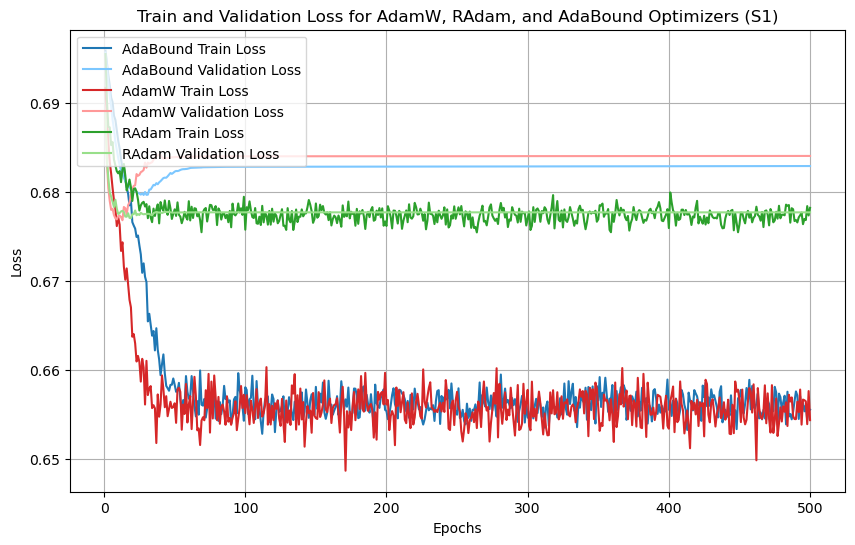

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for Ein and Eval (for illustration purposes only)
epochs = np.arange(1, 501)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, AdaBound_Ein, label="AdaBound Train Loss", color='#1f77b4')
plt.plot(epochs, AdaBound_Eout, label="AdaBound Validation Loss", color='#7cc7ff')
plt.plot(epochs, Adamw_Ein, label="AdamW Train Loss", color='#d62728')
plt.plot(epochs, Adamw_Eout, label="AdamW Validation Loss", color='#ff9999')
plt.plot(epochs, Radam_Ein, label="RAdam Train Loss", color='#2ca02c')
plt.plot(epochs, Radam_Eout, label="RAdam Validation Loss", color='#98df8a')
plt.title("Train and Validation Loss for AdamW, RAdam, and AdaBound Optimizers (S1)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# without time weight

In [93]:
import torch_optimizer


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import optuna
from datetime import datetime
from optuna.visualization import plot_param_importances

# 設置隨機種子以確保結果可重現
torch.manual_seed(42)
np.random.seed(42)

# 1. 讀取數據
data = pd.read_csv("HTML 2024 Fall Final Project Stage 1/train_data.csv")
test_data_pred = pd.read_csv("HTML 2024 Fall Final Project Stage 1/same_season_test_data.csv")  # 預測數據

numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# 填補數值欄位
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
test_data_pred[numeric_cols] = test_data_pred[numeric_cols].fillna(test_data_pred[numeric_cols].mean())

# 填補非數值欄位（選擇使用眾數或 'Unknown'）
for col in categorical_cols:
    if data[col].isnull().any():
        mode = data[col].mode()[0]  # 或者使用 'Unknown'
        data[col].fillna(mode, inplace=True)
    if col in test_data_pred.columns and test_data_pred[col].isnull().any():
        mode = test_data_pred[col].mode()[0]
        test_data_pred[col].fillna(mode, inplace=True)

# 2. 計算差異欄位
difference_columns = [
    'team_rest_diff', "pitcher_rest_diff", "batting_batting_avg_10RA_diff","batting_onbase_perc_10RA_diff","batting_onbase_plus_slugging_10RA_diff","batting_leverage_index_avg_10RA_diff","batting_RBI_10RA_diff",
    "pitching_earned_run_avg_10RA_diff","pitching_SO_batters_faced_10RA_diff","pitching_H_batters_faced_10RA_diff","pitching_BB_batters_faced_10RA_diff","pitcher_earned_run_avg_10RA_diff","pitcher_SO_batters_faced_10RA_diff","pitcher_H_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff","pitcher_BB_batters_faced_10RA_diff",
    "batting_batting_avg_mean_diff", "batting_onbase_perc_mean_diff", "batting_onbase_plus_slugging_mean_diff", "batting_leverage_index_avg_mean_diff", "batting_wpa_bat_mean_diff", "batting_RBI_mean_diff",
    "pitching_earned_run_avg_mean_diff", "pitching_SO_batters_faced_mean_diff", "pitching_H_batters_faced_mean_diff", "pitching_BB_batters_faced_mean_diff", "pitching_leverage_index_avg_mean_diff", "pitching_wpa_def_mean_diff",
    "pitcher_earned_run_avg_mean_diff"  ,"pitcher_SO_batters_faced_mean_diff"   ,"pitcher_H_batters_faced_mean_diff"   ,"pitcher_BB_batters_faced_mean_diff"   ,"pitcher_leverage_index_avg_mean_diff"   ,"pitcher_wpa_def_mean_diff","date"           
]


for col in difference_columns:
    if col not in data.columns:
        # 假設原始數據中存在相應的欄位，計算差異
        home_col = 'home_' + col.split('_diff')[0]
        away_col = 'away_' + col.split('_diff')[0]
        data[col] = data[home_col] - data[away_col]
        if home_col in test_data_pred.columns and away_col in test_data_pred.columns:
            test_data_pred[col] = test_data_pred[home_col] - test_data_pred[away_col]

# 3. 時間衰減處理
data['date'] = pd.to_datetime(data['date'])
current_date = datetime.now()
data['days_since'] = (current_date - data['date']).dt.days
data['time_weight'] = np.exp(-0.001 * data['days_since'])  # 指數衰減
# 4. 定義特徵和標籤
features = [
    "is_night_game","home_team_rest","away_team_rest","home_pitcher_rest", "away_pitcher_rest","season","home_batting_batting_avg_10RA","home_batting_onbase_perc_10RA","home_batting_onbase_plus_slugging_10RA","home_batting_leverage_index_avg_10RA","home_batting_RBI_10RA","away_batting_batting_avg_10RA",
    "away_batting_onbase_perc_10RA","away_batting_onbase_plus_slugging_10RA","away_batting_leverage_index_avg_10RA","away_batting_RBI_10RA","home_pitching_earned_run_avg_10RA","home_pitching_SO_batters_faced_10RA","home_pitching_H_batters_faced_10RA","home_pitching_BB_batters_faced_10RA","away_pitching_earned_run_avg_10RA","away_pitching_SO_batters_faced_10RA","away_pitching_H_batters_faced_10RA","away_pitching_BB_batters_faced_10RA","home_pitcher_earned_run_avg_10RA","home_pitcher_SO_batters_faced_10RA","home_pitcher_H_batters_faced_10RA","home_pitcher_BB_batters_faced_10RA","away_pitcher_earned_run_avg_10RA","away_pitcher_SO_batters_faced_10RA",
    'away_pitcher_H_batters_faced_10RA','away_pitcher_BB_batters_faced_10RA','home_team_errors_mean','home_team_errors_std','home_team_errors_skew','away_team_errors_mean','away_team_errors_std','away_team_errors_skew','home_team_spread_mean','home_team_spread_std','home_team_spread_skew','away_team_spread_mean','away_team_spread_std','away_team_spread_skew','home_team_wins_mean','home_team_wins_std','home_team_wins_skew','away_team_wins_mean','away_team_wins_std','away_team_wins_skew','home_batting_batting_avg_mean','home_batting_batting_avg_std','home_batting_batting_avg_skew','home_batting_onbase_perc_mean','home_batting_onbase_perc_std','home_batting_onbase_perc_skew','home_batting_onbase_plus_slugging_mean','home_batting_onbase_plus_slugging_std','home_batting_onbase_plus_slugging_skew','home_batting_leverage_index_avg_mean','home_batting_leverage_index_avg_std','home_batting_leverage_index_avg_skew','home_batting_wpa_bat_mean','home_batting_wpa_bat_std','home_batting_wpa_bat_skew','home_batting_RBI_mean','home_batting_RBI_std','home_batting_RBI_skew','away_batting_batting_avg_mean','away_batting_batting_avg_std',
    'away_batting_batting_avg_skew','away_batting_onbase_perc_mean','away_batting_onbase_perc_std','away_batting_onbase_perc_skew','away_batting_onbase_plus_slugging_mean','away_batting_onbase_plus_slugging_std','away_batting_onbase_plus_slugging_skew','away_batting_leverage_index_avg_mean','away_batting_leverage_index_avg_std','away_batting_leverage_index_avg_skew','away_batting_wpa_bat_mean','away_batting_wpa_bat_std','away_batting_wpa_bat_skew','away_batting_RBI_mean','away_batting_RBI_std','away_batting_RBI_skew','home_pitching_earned_run_avg_mean','home_pitching_earned_run_avg_std','home_pitching_earned_run_avg_skew','home_pitching_SO_batters_faced_mean','home_pitching_SO_batters_faced_std','home_pitching_SO_batters_faced_skew','home_pitching_H_batters_faced_mean','home_pitching_H_batters_faced_std','home_pitching_H_batters_faced_skew','home_pitching_BB_batters_faced_mean','home_pitching_BB_batters_faced_std','home_pitching_BB_batters_faced_skew','home_pitching_leverage_index_avg_mean','home_pitching_leverage_index_avg_std','home_pitching_leverage_index_avg_skew','home_pitching_wpa_def_mean','home_pitching_wpa_def_std','home_pitching_wpa_def_skew','away_pitching_earned_run_avg_mean','away_pitching_earned_run_avg_std','away_pitching_earned_run_avg_skew','away_pitching_SO_batters_faced_mean','away_pitching_SO_batters_faced_std','away_pitching_SO_batters_faced_skew','away_pitching_H_batters_faced_mean','away_pitching_H_batters_faced_std','away_pitching_H_batters_faced_skew','away_pitching_BB_batters_faced_mean','away_pitching_BB_batters_faced_std','away_pitching_BB_batters_faced_skew','away_pitching_leverage_index_avg_mean','away_pitching_leverage_index_avg_std',
    'away_pitching_leverage_index_avg_skew','away_pitching_wpa_def_mean','away_pitching_wpa_def_std','away_pitching_wpa_def_skew','home_pitcher_earned_run_avg_mean','home_pitcher_earned_run_avg_std','home_pitcher_earned_run_avg_skew','home_pitcher_SO_batters_faced_mean','home_pitcher_SO_batters_faced_std','home_pitcher_SO_batters_faced_skew','home_pitcher_H_batters_faced_mean','home_pitcher_H_batters_faced_std','home_pitcher_H_batters_faced_skew','home_pitcher_BB_batters_faced_mean','home_pitcher_BB_batters_faced_std','home_pitcher_BB_batters_faced_skew','home_pitcher_leverage_index_avg_mean','home_pitcher_leverage_index_avg_std','home_pitcher_leverage_index_avg_skew','home_pitcher_wpa_def_mean','home_pitcher_wpa_def_std','home_pitcher_wpa_def_skew','away_pitcher_earned_run_avg_mean',"away_pitcher_earned_run_avg_std","away_pitcher_earned_run_avg_skew","away_pitcher_SO_batters_faced_mean","away_pitcher_SO_batters_faced_std","away_pitcher_SO_batters_faced_skew","away_pitcher_H_batters_faced_mean","away_pitcher_H_batters_faced_std","away_pitcher_H_batters_faced_skew","away_pitcher_BB_batters_faced_mean","away_pitcher_BB_batters_faced_std","away_pitcher_BB_batters_faced_skew","away_pitcher_leverage_index_avg_mean","away_pitcher_leverage_index_avg_std","away_pitcher_leverage_index_avg_skew","away_pitcher_wpa_def_mean","away_pitcher_wpa_def_std","away_pitcher_wpa_def_skew"
]

# 主訓練數據的特徵和標籤
X = data[features]
y = data['home_team_win']

# 填補缺失值
X.fillna(X.mean(), inplace=True)
X_pred = test_data_pred[features]
X_pred.fillna(X_pred.mean(), inplace=True)

# 5. 數據標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pred_scaled = scaler.transform(X_pred)

# 6. 計算 pos_weight（負類樣本數 / 正類樣本數）
num_pos = (y == 1).sum()
num_neg = (y == 0).sum()
pos_weight = num_neg / num_pos
print(f"Computed pos_weight: {pos_weight}")

# 7. 將數據轉換為 PyTorch 張量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# 將所有數據放在同一設備上
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)
# 準備預測數據張量
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32).to(device)

# 8. 定義神經網絡模型
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation_fn):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.activation = activation_fn
        
        # 第一層：從輸入到第一個隱藏層
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rates[0]))
        
        # 中間的隱藏層
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rates[i]))
        
        # 輸出層：最後一個隱藏層到輸出
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        
    def forward(self, x):
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = layer(x)
            x = bn(x)
            x = self.activation(x)
            x = dropout(x)
        x = self.output_layer(x)
        return x  # Raw logits

# 9. 定義Optuna目標函數
def objective(trial):
    # 建議隱藏層的數量（1到5層）
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    # 為每一層建議隱藏單元數和dropout率
    hidden_sizes = []
    dropout_rates = []
    for i in range(n_layers):
        hidden_size = trial.suggest_int(f"hidden_size_l{i}", 16, 256, step=16)
        dropout_rate = trial.suggest_float(f"dropout_rate_l{i}", 0.0, 0.5)
        hidden_sizes.append(hidden_size)
        dropout_rates.append(dropout_rate)
    
    # 學習率
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    # 權重衰減（L2正則化）
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    
    # 激活函數
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])
    if activation_name == "ReLU":
        activation_fn = nn.ReLU()
    elif activation_name == "LeakyReLU":
        activation_fn = nn.LeakyReLU()
    elif activation_name == "ELU":
        activation_fn = nn.ELU()
    
    # 建議批量大小
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])
    
    # 初始化模型
    model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
    # 損失函數和優化器
    # pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss()

    # 定義 LR 調度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    
    # 數據加載器，劃分為訓練集和驗證集（80-20分割）
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 訓練過程
    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            if torch.isnan(loss):
                return float('inf')  # 如果出現NaN，給予極大損失
            
            loss.backward()
            # 梯度裁剪以防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # 驗證過程
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # 計算 accuracy
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).int()
                correct_predictions += (predicted == targets.int()).sum().item()
                total_predictions += targets.size(0)
        
        # 計算驗證準確率
        val_accuracy = correct_predictions / total_predictions
        average_val_loss = val_loss / len(val_loader)
        
        # 打印每輪驗證結果
        print(f"Epoch {epoch+1}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # 調整學習率調度器
        scheduler.step(val_loss)
    
    # 報告驗證損失並檢查是否應該剪枝
    trial.report(average_val_loss, 0)  # 這裡epoch為0，因為我們只計算一次驗證
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return average_val_loss


# 10. 開始調參
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None)

# 11. 輸出最佳結果
print("最佳參數:", study.best_params)
best_params = study.best_params
fig = plot_param_importances(study)
# 如果是在 Jupyter Notebook，可以直接顯示
fig.show()

# 使用最佳參數構建最終模型
n_layers = best_params['n_layers']
hidden_sizes = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
activation_name = best_params['activation']
batch_size = best_params['batch_size']

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)

if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()


# 初始化模型
model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss()

# 定義學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 準備最終訓練集的 DataLoader（使用所有數據）
final_dataset = TensorDataset(X_tensor, y_tensor)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

# 訓練模型（使用早停機制）
epochs = 1000  # 設置最終訓練的 epochs
best_train_loss = float('inf')
patience = 20  # 早停耐心值
trigger_times = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in final_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}")
            break  # 如果出現NaN，退出訓練
        
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    average_train_loss = train_loss / len(final_loader)
    
    # 調整學習率調度器
    scheduler.step(average_train_loss)
    
    # 早停機制（基於訓練損失）
    if average_train_loss < best_train_loss:
        best_train_loss = average_train_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Best model saved with Train Loss: {average_train_loss:.4f}")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}, Best Train Loss: {best_train_loss:.4f}")

# 加載最佳模型
model.load_state_dict(torch.load("best_model.pth"))

# 預測部分
model.eval()
with torch.no_grad():
    predictions = model(X_pred_tensor).squeeze()
    probabilities = torch.sigmoid(predictions).cpu().numpy()
    predictions_binary = (probabilities > 0.5).astype(int)

# 將預測結果添加到預測數據中
test_data_pred['home_team_win'] = predictions_binary.astype(bool)

# 選擇需要的列
output_df = test_data_pred[['id', 'home_team_win']]

# 保存預測結果
output_df.to_csv("1_nn_diff_diffoptimizer.csv", index=False)


/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_69713/3701053116.py:54: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_69713/3701053116.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_69713/3701053116.py:54: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

Computed pos_weight: 0.8831036242981113
Epoch 1, Val Loss: 0.6894, Val Accuracy: 0.5447
Epoch 2, Val Loss: 0.6887, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6863, Val Accuracy: 0.5533
Epoch 4, Val Loss: 0.6857, Val Accuracy: 0.5583
Epoch 5, Val Loss: 0.6896, Val Accuracy: 0.5569
Epoch 6, Val Loss: 0.6999, Val Accuracy: 0.5420
Epoch 7, Val Loss: 0.6897, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6916, Val Accuracy: 0.5497
Epoch 9, Val Loss: 0.6964, Val Accuracy: 0.5483
Epoch 10, Val Loss: 0.7001, Val Accuracy: 0.5434
Epoch 11, Val Loss: 0.7198, Val Accuracy: 0.5384
Epoch 12, Val Loss: 0.7146, Val Accuracy: 0.5357
Epoch 13, Val Loss: 0.7221, Val Accuracy: 0.5411
Epoch 14, Val Loss: 0.7145, Val Accuracy: 0.5402
Epoch 15, Val Loss: 0.7275, Val Accuracy: 0.5456
Epoch 16, Val Loss: 0.7217, Val Accuracy: 0.5375
Epoch 17, Val Loss: 0.7366, Val Accuracy: 0.5407
Epoch 18, Val Loss: 0.7420, Val Accuracy: 0.5307


[I 2024-12-22 02:52:58,888] Trial 0 finished with value: 0.7457585864596896 and parameters: {'n_layers': 4, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.16818958990325417, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.0713942348679017, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.4055512646357305, 'hidden_size_l3': 256, 'dropout_rate_l3': 0.11675086257302664, 'learning_rate': 0.0031023817541730053, 'weight_decay': 3.254250556350701e-05, 'activation': 'LeakyReLU', 'batch_size': 256}. Best is trial 0 with value: 0.7457585864596896.


Epoch 19, Val Loss: 0.7513, Val Accuracy: 0.5366
Epoch 20, Val Loss: 0.7458, Val Accuracy: 0.5334
Epoch 1, Val Loss: 0.6884, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6866, Val Accuracy: 0.5533
Epoch 3, Val Loss: 0.6877, Val Accuracy: 0.5479
Epoch 4, Val Loss: 0.6875, Val Accuracy: 0.5443
Epoch 5, Val Loss: 0.6848, Val Accuracy: 0.5601
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5601
Epoch 7, Val Loss: 0.6883, Val Accuracy: 0.5515
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5547
Epoch 9, Val Loss: 0.6892, Val Accuracy: 0.5497
Epoch 10, Val Loss: 0.6881, Val Accuracy: 0.5592
Epoch 11, Val Loss: 0.6894, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6924, Val Accuracy: 0.5479
Epoch 13, Val Loss: 0.6925, Val Accuracy: 0.5452
Epoch 14, Val Loss: 0.6962, Val Accuracy: 0.5474
Epoch 15, Val Loss: 0.6934, Val Accuracy: 0.5479
Epoch 16, Val Loss: 0.6962, Val Accuracy: 0.5452
Epoch 17, Val Loss: 0.6943, Val Accuracy: 0.5447
Epoch 18, Val Loss: 0.6971, Val Accuracy: 0.5447
Epoch 19, Val Loss: 0.6987, V

[I 2024-12-22 02:53:07,746] Trial 1 finished with value: 0.6990119251939986 and parameters: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.2526371311841197, 'hidden_size_l1': 32, 'dropout_rate_l1': 0.38404231982904, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.2341283802769396, 'hidden_size_l3': 64, 'dropout_rate_l3': 0.0280436981438148, 'hidden_size_l4': 192, 'dropout_rate_l4': 0.27845781735991965, 'learning_rate': 0.0005128042502468827, 'weight_decay': 0.0044634916494368775, 'activation': 'ReLU', 'batch_size': 128}. Best is trial 1 with value: 0.6990119251939986.


Epoch 20, Val Loss: 0.6990, Val Accuracy: 0.5461
Epoch 1, Val Loss: 0.6874, Val Accuracy: 0.5443
Epoch 2, Val Loss: 0.6875, Val Accuracy: 0.5623
Epoch 3, Val Loss: 0.6917, Val Accuracy: 0.5547
Epoch 4, Val Loss: 0.6913, Val Accuracy: 0.5456
Epoch 5, Val Loss: 0.6876, Val Accuracy: 0.5465
Epoch 6, Val Loss: 0.6861, Val Accuracy: 0.5610
Epoch 7, Val Loss: 0.6958, Val Accuracy: 0.5420
Epoch 8, Val Loss: 0.6989, Val Accuracy: 0.5497
Epoch 9, Val Loss: 0.6991, Val Accuracy: 0.5416
Epoch 10, Val Loss: 0.7042, Val Accuracy: 0.5443
Epoch 11, Val Loss: 0.7008, Val Accuracy: 0.5506
Epoch 12, Val Loss: 0.7004, Val Accuracy: 0.5452
Epoch 13, Val Loss: 0.7249, Val Accuracy: 0.5370
Epoch 14, Val Loss: 0.7231, Val Accuracy: 0.5316
Epoch 15, Val Loss: 0.7324, Val Accuracy: 0.5434
Epoch 16, Val Loss: 0.7471, Val Accuracy: 0.5321
Epoch 17, Val Loss: 0.7448, Val Accuracy: 0.5452
Epoch 18, Val Loss: 0.7473, Val Accuracy: 0.5298
Epoch 19, Val Loss: 0.7803, Val Accuracy: 0.5361


[I 2024-12-22 02:53:21,047] Trial 2 finished with value: 0.7879635027476719 and parameters: {'n_layers': 4, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.4013277353908645, 'hidden_size_l1': 144, 'dropout_rate_l1': 0.39740267154030995, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.23046584565325218, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.03227462070283815, 'learning_rate': 0.01361181415814636, 'weight_decay': 1.9684582777138e-06, 'activation': 'ReLU', 'batch_size': 64}. Best is trial 1 with value: 0.6990119251939986.


Epoch 20, Val Loss: 0.7880, Val Accuracy: 0.5343
Epoch 1, Val Loss: 0.7017, Val Accuracy: 0.5452
Epoch 2, Val Loss: 0.7118, Val Accuracy: 0.5519
Epoch 3, Val Loss: 0.7038, Val Accuracy: 0.5492
Epoch 4, Val Loss: 0.7065, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.7108, Val Accuracy: 0.5434
Epoch 6, Val Loss: 0.7167, Val Accuracy: 0.5271
Epoch 7, Val Loss: 0.7209, Val Accuracy: 0.5420
Epoch 8, Val Loss: 0.7244, Val Accuracy: 0.5388
Epoch 9, Val Loss: 0.7356, Val Accuracy: 0.5429
Epoch 10, Val Loss: 0.7450, Val Accuracy: 0.5321
Epoch 11, Val Loss: 0.7652, Val Accuracy: 0.5212
Epoch 12, Val Loss: 0.7618, Val Accuracy: 0.5330
Epoch 13, Val Loss: 0.7730, Val Accuracy: 0.5266
Epoch 14, Val Loss: 0.7756, Val Accuracy: 0.5298
Epoch 15, Val Loss: 0.7805, Val Accuracy: 0.5325
Epoch 16, Val Loss: 0.7886, Val Accuracy: 0.5370
Epoch 17, Val Loss: 0.8024, Val Accuracy: 0.5212
Epoch 18, Val Loss: 0.8123, Val Accuracy: 0.5248


[I 2024-12-22 02:53:23,143] Trial 3 finished with value: 0.823006788889567 and parameters: {'n_layers': 1, 'hidden_size_l0': 208, 'dropout_rate_l0': 0.4004875683256449, 'learning_rate': 0.013840958171564362, 'weight_decay': 4.737471359995773e-05, 'activation': 'LeakyReLU', 'batch_size': 256}. Best is trial 1 with value: 0.6990119251939986.


Epoch 19, Val Loss: 0.8158, Val Accuracy: 0.5289
Epoch 20, Val Loss: 0.8230, Val Accuracy: 0.5235
Epoch 1, Val Loss: 0.6841, Val Accuracy: 0.5601
Epoch 2, Val Loss: 0.6869, Val Accuracy: 0.5601
Epoch 3, Val Loss: 0.6882, Val Accuracy: 0.5583
Epoch 4, Val Loss: 0.7018, Val Accuracy: 0.5533
Epoch 5, Val Loss: 0.6867, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5641
Epoch 7, Val Loss: 0.6867, Val Accuracy: 0.5583
Epoch 8, Val Loss: 0.6950, Val Accuracy: 0.5641
Epoch 9, Val Loss: 0.6882, Val Accuracy: 0.5488
Epoch 10, Val Loss: 0.6916, Val Accuracy: 0.5429
Epoch 11, Val Loss: 0.6938, Val Accuracy: 0.5294
Epoch 12, Val Loss: 0.6928, Val Accuracy: 0.5619
Epoch 13, Val Loss: 0.7544, Val Accuracy: 0.5330
Epoch 14, Val Loss: 0.6960, Val Accuracy: 0.5384
Epoch 15, Val Loss: 0.6993, Val Accuracy: 0.5461
Epoch 16, Val Loss: 0.6957, Val Accuracy: 0.5262
Epoch 17, Val Loss: 0.7169, Val Accuracy: 0.5330
Epoch 18, Val Loss: 0.6996, Val Accuracy: 0.5429
Epoch 19, Val Loss: 0.7168, V

[I 2024-12-22 02:53:48,686] Trial 4 finished with value: 0.7180231400898525 and parameters: {'n_layers': 4, 'hidden_size_l0': 208, 'dropout_rate_l0': 0.4453882512507036, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.15637080751515703, 'hidden_size_l2': 112, 'dropout_rate_l2': 0.18641149262291618, 'hidden_size_l3': 112, 'dropout_rate_l3': 0.2557894947980008, 'learning_rate': 0.04654245607933139, 'weight_decay': 6.4940483543876606e-06, 'activation': 'LeakyReLU', 'batch_size': 32}. Best is trial 1 with value: 0.6990119251939986.


Epoch 20, Val Loss: 0.7180, Val Accuracy: 0.5361
Epoch 1, Val Loss: 0.6865, Val Accuracy: 0.5506
Epoch 2, Val Loss: 0.6874, Val Accuracy: 0.5515
Epoch 3, Val Loss: 0.6889, Val Accuracy: 0.5592
Epoch 4, Val Loss: 0.6925, Val Accuracy: 0.5578
Epoch 5, Val Loss: 0.7009, Val Accuracy: 0.5397
Epoch 6, Val Loss: 0.7035, Val Accuracy: 0.5343
Epoch 7, Val Loss: 0.7140, Val Accuracy: 0.5316
Epoch 8, Val Loss: 0.7203, Val Accuracy: 0.5321
Epoch 9, Val Loss: 0.7279, Val Accuracy: 0.5361
Epoch 10, Val Loss: 0.7360, Val Accuracy: 0.5303
Epoch 11, Val Loss: 0.7459, Val Accuracy: 0.5248
Epoch 12, Val Loss: 0.7458, Val Accuracy: 0.5289
Epoch 13, Val Loss: 0.7580, Val Accuracy: 0.5321
Epoch 14, Val Loss: 0.7612, Val Accuracy: 0.5221
Epoch 15, Val Loss: 0.7713, Val Accuracy: 0.5226
Epoch 16, Val Loss: 0.7834, Val Accuracy: 0.5203
Epoch 17, Val Loss: 0.7856, Val Accuracy: 0.5257
Epoch 18, Val Loss: 0.7884, Val Accuracy: 0.5190
Epoch 19, Val Loss: 0.8034, Val Accuracy: 0.5244


[I 2024-12-22 02:53:54,307] Trial 5 pruned. 


Epoch 20, Val Loss: 0.7995, Val Accuracy: 0.5226
Epoch 1, Val Loss: 0.6921, Val Accuracy: 0.5416
Epoch 2, Val Loss: 0.6907, Val Accuracy: 0.5348
Epoch 3, Val Loss: 0.6903, Val Accuracy: 0.5443
Epoch 4, Val Loss: 0.6890, Val Accuracy: 0.5583
Epoch 5, Val Loss: 0.6891, Val Accuracy: 0.5483
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5619
Epoch 7, Val Loss: 0.6874, Val Accuracy: 0.5655
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5655
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5614
Epoch 10, Val Loss: 0.6864, Val Accuracy: 0.5678
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5664
Epoch 12, Val Loss: 0.6862, Val Accuracy: 0.5664
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5605
Epoch 14, Val Loss: 0.6854, Val Accuracy: 0.5714
Epoch 15, Val Loss: 0.6860, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6849, Val Accuracy: 0.5646
Epoch 17, Val Loss: 0.6855, Val Accuracy: 0.5619
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5655
Epoch 19, Val Loss: 0.6847, Val Accuracy: 0.5614


[I 2024-12-22 02:54:22,788] Trial 6 finished with value: 0.6842702901620659 and parameters: {'n_layers': 3, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.4036729525641559, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.31345096958721475, 'hidden_size_l2': 48, 'dropout_rate_l2': 0.05205939268525439, 'learning_rate': 1.695912953852091e-05, 'weight_decay': 1.2370102924204246e-06, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6843, Val Accuracy: 0.5723
Epoch 1, Val Loss: 0.6872, Val Accuracy: 0.5452
Epoch 2, Val Loss: 0.6859, Val Accuracy: 0.5528
Epoch 3, Val Loss: 0.6851, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6858, Val Accuracy: 0.5547
Epoch 5, Val Loss: 0.6861, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6867, Val Accuracy: 0.5537
Epoch 7, Val Loss: 0.6870, Val Accuracy: 0.5578
Epoch 8, Val Loss: 0.6872, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6879, Val Accuracy: 0.5547
Epoch 10, Val Loss: 0.6885, Val Accuracy: 0.5547
Epoch 11, Val Loss: 0.6885, Val Accuracy: 0.5479
Epoch 12, Val Loss: 0.6882, Val Accuracy: 0.5510
Epoch 13, Val Loss: 0.6890, Val Accuracy: 0.5519
Epoch 14, Val Loss: 0.6886, Val Accuracy: 0.5551
Epoch 15, Val Loss: 0.6891, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6888, Val Accuracy: 0.5528
Epoch 17, Val Loss: 0.6890, Val Accuracy: 0.5542
Epoch 18, Val Loss: 0.6892, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6894, Val Accuracy: 0.5528


[I 2024-12-22 02:54:26,068] Trial 7 finished with value: 0.6892286108599769 and parameters: {'n_layers': 2, 'hidden_size_l0': 32, 'dropout_rate_l0': 0.45020125746282436, 'hidden_size_l1': 48, 'dropout_rate_l1': 0.3191201582162484, 'learning_rate': 0.0003881062042846051, 'weight_decay': 1.3318193174563594e-05, 'activation': 'ELU', 'batch_size': 128}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6892, Val Accuracy: 0.5524
Epoch 1, Val Loss: 0.6886, Val Accuracy: 0.5632
Epoch 2, Val Loss: 0.6854, Val Accuracy: 0.5650
Epoch 3, Val Loss: 0.6965, Val Accuracy: 0.5298
Epoch 4, Val Loss: 0.6952, Val Accuracy: 0.5411
Epoch 5, Val Loss: 0.7003, Val Accuracy: 0.5262
Epoch 6, Val Loss: 0.6990, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.7032, Val Accuracy: 0.5416
Epoch 8, Val Loss: 0.7141, Val Accuracy: 0.5316
Epoch 9, Val Loss: 0.7469, Val Accuracy: 0.5443
Epoch 10, Val Loss: 0.7324, Val Accuracy: 0.5470
Epoch 11, Val Loss: 0.7601, Val Accuracy: 0.5257
Epoch 12, Val Loss: 0.7916, Val Accuracy: 0.5294
Epoch 13, Val Loss: 0.8102, Val Accuracy: 0.5276
Epoch 14, Val Loss: 0.8441, Val Accuracy: 0.5334
Epoch 15, Val Loss: 0.9182, Val Accuracy: 0.5397
Epoch 16, Val Loss: 0.9974, Val Accuracy: 0.5339
Epoch 17, Val Loss: 0.9981, Val Accuracy: 0.5343
Epoch 18, Val Loss: 1.0328, Val Accuracy: 0.5294
Epoch 19, Val Loss: 1.0486, Val Accuracy: 0.5212


[I 2024-12-22 02:54:31,853] Trial 8 pruned. 


Epoch 20, Val Loss: 1.1829, Val Accuracy: 0.5099
Epoch 1, Val Loss: 0.6985, Val Accuracy: 0.5470
Epoch 2, Val Loss: 0.7065, Val Accuracy: 0.5212
Epoch 3, Val Loss: 0.7142, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.7252, Val Accuracy: 0.5307
Epoch 5, Val Loss: 0.7335, Val Accuracy: 0.5407
Epoch 6, Val Loss: 0.7789, Val Accuracy: 0.5307
Epoch 7, Val Loss: 0.7459, Val Accuracy: 0.5461
Epoch 8, Val Loss: 0.7675, Val Accuracy: 0.5244
Epoch 9, Val Loss: 0.7821, Val Accuracy: 0.5384
Epoch 10, Val Loss: 0.7939, Val Accuracy: 0.5488
Epoch 11, Val Loss: 0.8076, Val Accuracy: 0.5384
Epoch 12, Val Loss: 0.8210, Val Accuracy: 0.5429
Epoch 13, Val Loss: 0.8444, Val Accuracy: 0.5226
Epoch 14, Val Loss: 0.8461, Val Accuracy: 0.5411
Epoch 15, Val Loss: 0.8526, Val Accuracy: 0.5339
Epoch 16, Val Loss: 0.8612, Val Accuracy: 0.5393
Epoch 17, Val Loss: 0.8769, Val Accuracy: 0.5294


[I 2024-12-22 02:54:33,555] Trial 9 pruned. 


Epoch 18, Val Loss: 0.8778, Val Accuracy: 0.5402
Epoch 19, Val Loss: 0.8967, Val Accuracy: 0.5262
Epoch 20, Val Loss: 0.9015, Val Accuracy: 0.5330
Epoch 1, Val Loss: 0.6947, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6929, Val Accuracy: 0.5515
Epoch 3, Val Loss: 0.6912, Val Accuracy: 0.5461
Epoch 4, Val Loss: 0.6915, Val Accuracy: 0.5420
Epoch 5, Val Loss: 0.6918, Val Accuracy: 0.5537
Epoch 6, Val Loss: 0.6914, Val Accuracy: 0.5528
Epoch 7, Val Loss: 0.6908, Val Accuracy: 0.5578
Epoch 8, Val Loss: 0.6916, Val Accuracy: 0.5547
Epoch 9, Val Loss: 0.6919, Val Accuracy: 0.5510
Epoch 10, Val Loss: 0.6916, Val Accuracy: 0.5583
Epoch 11, Val Loss: 0.6921, Val Accuracy: 0.5542
Epoch 12, Val Loss: 0.6913, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6920, Val Accuracy: 0.5474
Epoch 14, Val Loss: 0.6916, Val Accuracy: 0.5510
Epoch 15, Val Loss: 0.6929, Val Accuracy: 0.5488
Epoch 16, Val Loss: 0.6927, Val Accuracy: 0.5537
Epoch 17, Val Loss: 0.6931, Val Accuracy: 0.5461
Epoch 18, Val Loss: 0.6928, V

[I 2024-12-22 02:54:58,134] Trial 10 finished with value: 0.6922527667429808 and parameters: {'n_layers': 2, 'hidden_size_l0': 256, 'dropout_rate_l0': 0.30999444087448635, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.2281880250306894, 'learning_rate': 1.0643721023401481e-05, 'weight_decay': 1.0725959028400507e-06, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6923, Val Accuracy: 0.5425
Epoch 1, Val Loss: 0.7150, Val Accuracy: 0.4824
Epoch 2, Val Loss: 0.7017, Val Accuracy: 0.5059
Epoch 3, Val Loss: 0.6965, Val Accuracy: 0.5266
Epoch 4, Val Loss: 0.6937, Val Accuracy: 0.5343
Epoch 5, Val Loss: 0.6899, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6893, Val Accuracy: 0.5556
Epoch 7, Val Loss: 0.6891, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6880, Val Accuracy: 0.5551
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5650
Epoch 10, Val Loss: 0.6870, Val Accuracy: 0.5610
Epoch 11, Val Loss: 0.6865, Val Accuracy: 0.5596
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6861, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6858, Val Accuracy: 0.5691
Epoch 15, Val Loss: 0.6847, Val Accuracy: 0.5687
Epoch 16, Val Loss: 0.6849, Val Accuracy: 0.5687
Epoch 17, Val Loss: 0.6857, Val Accuracy: 0.5682
Epoch 18, Val Loss: 0.6853, Val Accuracy: 0.5628
Epoch 19, Val Loss: 0.6847, Val Accuracy: 0.5655


[I 2024-12-22 02:55:16,543] Trial 11 finished with value: 0.6846604866089581 and parameters: {'n_layers': 2, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.4892476923905089, 'hidden_size_l1': 32, 'dropout_rate_l1': 0.3225975769576651, 'learning_rate': 4.019744020064882e-05, 'weight_decay': 8.728375127812683e-06, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6847, Val Accuracy: 0.5709
Epoch 1, Val Loss: 0.7022, Val Accuracy: 0.5108
Epoch 2, Val Loss: 0.6983, Val Accuracy: 0.5230
Epoch 3, Val Loss: 0.6943, Val Accuracy: 0.5434
Epoch 4, Val Loss: 0.6934, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6895, Val Accuracy: 0.5583
Epoch 6, Val Loss: 0.6895, Val Accuracy: 0.5596
Epoch 7, Val Loss: 0.6897, Val Accuracy: 0.5456
Epoch 8, Val Loss: 0.6884, Val Accuracy: 0.5583
Epoch 9, Val Loss: 0.6878, Val Accuracy: 0.5578
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5623
Epoch 11, Val Loss: 0.6879, Val Accuracy: 0.5605
Epoch 12, Val Loss: 0.6869, Val Accuracy: 0.5632
Epoch 13, Val Loss: 0.6868, Val Accuracy: 0.5614
Epoch 14, Val Loss: 0.6859, Val Accuracy: 0.5641
Epoch 15, Val Loss: 0.6864, Val Accuracy: 0.5705
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5614
Epoch 17, Val Loss: 0.6856, Val Accuracy: 0.5705
Epoch 18, Val Loss: 0.6858, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6853, Val Accuracy: 0.5673


[I 2024-12-22 02:55:34,152] Trial 12 finished with value: 0.6858916329822952 and parameters: {'n_layers': 2, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.49446934222758765, 'hidden_size_l1': 80, 'dropout_rate_l1': 0.2793379571274969, 'learning_rate': 1.6897655871130943e-05, 'weight_decay': 4.079924734156161e-06, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6859, Val Accuracy: 0.5619
Epoch 1, Val Loss: 0.6865, Val Accuracy: 0.5551
Epoch 2, Val Loss: 0.6836, Val Accuracy: 0.5578
Epoch 3, Val Loss: 0.6840, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6823, Val Accuracy: 0.5623
Epoch 5, Val Loss: 0.6816, Val Accuracy: 0.5646
Epoch 6, Val Loss: 0.6837, Val Accuracy: 0.5605
Epoch 7, Val Loss: 0.6835, Val Accuracy: 0.5574
Epoch 8, Val Loss: 0.6845, Val Accuracy: 0.5470
Epoch 9, Val Loss: 0.6849, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6856, Val Accuracy: 0.5515
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6849, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6876, Val Accuracy: 0.5452
Epoch 14, Val Loss: 0.6853, Val Accuracy: 0.5510
Epoch 15, Val Loss: 0.6866, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6871, Val Accuracy: 0.5492
Epoch 17, Val Loss: 0.6873, Val Accuracy: 0.5497
Epoch 18, Val Loss: 0.6870, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6884, Val Accuracy: 0.5592


[I 2024-12-22 02:56:00,277] Trial 13 finished with value: 0.688563170621721 and parameters: {'n_layers': 3, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.3346814840568058, 'hidden_size_l1': 16, 'dropout_rate_l1': 0.2057383805912481, 'hidden_size_l2': 256, 'dropout_rate_l2': 0.00295107564192415, 'learning_rate': 6.974486665672906e-05, 'weight_decay': 1.34054246646456e-05, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6886, Val Accuracy: 0.5456
Epoch 1, Val Loss: 0.6881, Val Accuracy: 0.5610
Epoch 2, Val Loss: 0.6865, Val Accuracy: 0.5628
Epoch 3, Val Loss: 0.6849, Val Accuracy: 0.5682
Epoch 4, Val Loss: 0.6849, Val Accuracy: 0.5705
Epoch 5, Val Loss: 0.6844, Val Accuracy: 0.5650
Epoch 6, Val Loss: 0.6865, Val Accuracy: 0.5515
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5587
Epoch 8, Val Loss: 0.6870, Val Accuracy: 0.5605
Epoch 9, Val Loss: 0.6856, Val Accuracy: 0.5583
Epoch 10, Val Loss: 0.6873, Val Accuracy: 0.5601
Epoch 11, Val Loss: 0.6890, Val Accuracy: 0.5510
Epoch 12, Val Loss: 0.6884, Val Accuracy: 0.5483
Epoch 13, Val Loss: 0.6899, Val Accuracy: 0.5488
Epoch 14, Val Loss: 0.6904, Val Accuracy: 0.5402
Epoch 15, Val Loss: 0.6900, Val Accuracy: 0.5438
Epoch 16, Val Loss: 0.6908, Val Accuracy: 0.5447
Epoch 17, Val Loss: 0.6903, Val Accuracy: 0.5501
Epoch 18, Val Loss: 0.6897, Val Accuracy: 0.5497
Epoch 19, Val Loss: 0.6895, Val Accuracy: 0.5479


[I 2024-12-22 02:56:18,943] Trial 14 finished with value: 0.6906208125807398 and parameters: {'n_layers': 2, 'hidden_size_l0': 64, 'dropout_rate_l0': 0.34896026343959163, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.3537651552774987, 'learning_rate': 8.938705919981319e-05, 'weight_decay': 1.1866964149150125e-06, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6906, Val Accuracy: 0.5456
Epoch 1, Val Loss: 0.6926, Val Accuracy: 0.5303
Epoch 2, Val Loss: 0.6899, Val Accuracy: 0.5438
Epoch 3, Val Loss: 0.6879, Val Accuracy: 0.5465
Epoch 4, Val Loss: 0.6872, Val Accuracy: 0.5488
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6865, Val Accuracy: 0.5461
Epoch 7, Val Loss: 0.6861, Val Accuracy: 0.5479
Epoch 8, Val Loss: 0.6856, Val Accuracy: 0.5501
Epoch 9, Val Loss: 0.6851, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6845, Val Accuracy: 0.5632
Epoch 11, Val Loss: 0.6851, Val Accuracy: 0.5551
Epoch 12, Val Loss: 0.6856, Val Accuracy: 0.5565
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6850, Val Accuracy: 0.5596
Epoch 15, Val Loss: 0.6847, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6846, Val Accuracy: 0.5587
Epoch 17, Val Loss: 0.6853, Val Accuracy: 0.5537
Epoch 18, Val Loss: 0.6852, Val Accuracy: 0.5646
Epoch 19, Val Loss: 0.6852, Val Accuracy: 0.5587


[I 2024-12-22 02:56:45,860] Trial 15 finished with value: 0.684770807945471 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.4957170009824636, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.46759590209517815, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.03945218877927803, 'learning_rate': 5.3288652569953426e-05, 'weight_decay': 0.0005192067335089963, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6848, Val Accuracy: 0.5619
Epoch 1, Val Loss: 0.6927, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6896, Val Accuracy: 0.5501
Epoch 3, Val Loss: 0.6900, Val Accuracy: 0.5537
Epoch 4, Val Loss: 0.6918, Val Accuracy: 0.5488
Epoch 5, Val Loss: 0.6914, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6903, Val Accuracy: 0.5542
Epoch 7, Val Loss: 0.6934, Val Accuracy: 0.5506
Epoch 8, Val Loss: 0.6933, Val Accuracy: 0.5425
Epoch 9, Val Loss: 0.6934, Val Accuracy: 0.5461
Epoch 10, Val Loss: 0.6941, Val Accuracy: 0.5438
Epoch 11, Val Loss: 0.6944, Val Accuracy: 0.5474
Epoch 12, Val Loss: 0.6951, Val Accuracy: 0.5465
Epoch 13, Val Loss: 0.6967, Val Accuracy: 0.5447
Epoch 14, Val Loss: 0.6975, Val Accuracy: 0.5519
Epoch 15, Val Loss: 0.6967, Val Accuracy: 0.5443
Epoch 16, Val Loss: 0.6981, Val Accuracy: 0.5443
Epoch 17, Val Loss: 0.6982, Val Accuracy: 0.5416
Epoch 18, Val Loss: 0.6972, Val Accuracy: 0.5461
Epoch 19, Val Loss: 0.6980, Val Accuracy: 0.5488


[I 2024-12-22 02:56:52,439] Trial 16 pruned. 


Epoch 20, Val Loss: 0.6979, Val Accuracy: 0.5447
Epoch 1, Val Loss: 0.6987, Val Accuracy: 0.5339
Epoch 2, Val Loss: 0.6941, Val Accuracy: 0.5393
Epoch 3, Val Loss: 0.6918, Val Accuracy: 0.5420
Epoch 4, Val Loss: 0.6911, Val Accuracy: 0.5443
Epoch 5, Val Loss: 0.6889, Val Accuracy: 0.5461
Epoch 6, Val Loss: 0.6884, Val Accuracy: 0.5465
Epoch 7, Val Loss: 0.6878, Val Accuracy: 0.5456
Epoch 8, Val Loss: 0.6870, Val Accuracy: 0.5465
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5515
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5429
Epoch 11, Val Loss: 0.6860, Val Accuracy: 0.5524
Epoch 12, Val Loss: 0.6857, Val Accuracy: 0.5474
Epoch 13, Val Loss: 0.6856, Val Accuracy: 0.5524
Epoch 14, Val Loss: 0.6860, Val Accuracy: 0.5537
Epoch 15, Val Loss: 0.6861, Val Accuracy: 0.5501
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5537
Epoch 17, Val Loss: 0.6862, Val Accuracy: 0.5497
Epoch 18, Val Loss: 0.6862, Val Accuracy: 0.5483
Epoch 19, Val Loss: 0.6856, Val Accuracy: 0.5483


[I 2024-12-22 02:56:58,780] Trial 17 finished with value: 0.6859669361795698 and parameters: {'n_layers': 2, 'hidden_size_l0': 80, 'dropout_rate_l0': 0.3951564637775382, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.2931188458294774, 'learning_rate': 2.486445892685874e-05, 'weight_decay': 1.6056483406292768e-05, 'activation': 'ELU', 'batch_size': 64}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6860, Val Accuracy: 0.5515
Epoch 1, Val Loss: 0.7165, Val Accuracy: 0.4941
Epoch 2, Val Loss: 0.6982, Val Accuracy: 0.5190
Epoch 3, Val Loss: 0.6986, Val Accuracy: 0.5257
Epoch 4, Val Loss: 0.6922, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.6925, Val Accuracy: 0.5312
Epoch 6, Val Loss: 0.6891, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6873, Val Accuracy: 0.5682
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5569
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5605
Epoch 10, Val Loss: 0.6883, Val Accuracy: 0.5479
Epoch 11, Val Loss: 0.6887, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6891, Val Accuracy: 0.5569
Epoch 13, Val Loss: 0.6885, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.6881, Val Accuracy: 0.5542
Epoch 15, Val Loss: 0.6865, Val Accuracy: 0.5646
Epoch 16, Val Loss: 0.6872, Val Accuracy: 0.5551
Epoch 17, Val Loss: 0.6893, Val Accuracy: 0.5528
Epoch 18, Val Loss: 0.6885, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6881, Val Accuracy: 0.5583


[I 2024-12-22 02:57:27,520] Trial 18 finished with value: 0.6877781500061639 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.18301871908075426, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.1583057323767501, 'hidden_size_l2': 64, 'dropout_rate_l2': 0.4974567235266019, 'learning_rate': 2.9003443037096105e-05, 'weight_decay': 2.9060469264954554e-06, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6878, Val Accuracy: 0.5587
Epoch 1, Val Loss: 0.6906, Val Accuracy: 0.5298
Epoch 2, Val Loss: 0.6885, Val Accuracy: 0.5574
Epoch 3, Val Loss: 0.6865, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6868, Val Accuracy: 0.5474
Epoch 5, Val Loss: 0.6873, Val Accuracy: 0.5456
Epoch 6, Val Loss: 0.6899, Val Accuracy: 0.5470
Epoch 7, Val Loss: 0.6874, Val Accuracy: 0.5574
Epoch 8, Val Loss: 0.6907, Val Accuracy: 0.5452
Epoch 9, Val Loss: 0.6876, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6857, Val Accuracy: 0.5524
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5528
Epoch 12, Val Loss: 0.6862, Val Accuracy: 0.5492
Epoch 13, Val Loss: 0.6870, Val Accuracy: 0.5519
Epoch 14, Val Loss: 0.6846, Val Accuracy: 0.5551
Epoch 15, Val Loss: 0.6860, Val Accuracy: 0.5506
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5510
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5479
Epoch 18, Val Loss: 0.6888, Val Accuracy: 0.5361
Epoch 19, Val Loss: 0.6871, Val Accuracy: 0.5397


[I 2024-12-22 02:57:52,462] Trial 19 finished with value: 0.6874672903431406 and parameters: {'n_layers': 3, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.445752810132483, 'hidden_size_l1': 16, 'dropout_rate_l1': 0.4214775043366422, 'hidden_size_l2': 256, 'dropout_rate_l2': 0.11495994602240324, 'learning_rate': 0.0001945619979579707, 'weight_decay': 0.00024161620878670488, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6875, Val Accuracy: 0.5492
Epoch 1, Val Loss: 0.7079, Val Accuracy: 0.4792
Epoch 2, Val Loss: 0.7023, Val Accuracy: 0.4950
Epoch 3, Val Loss: 0.6975, Val Accuracy: 0.5068
Epoch 4, Val Loss: 0.6977, Val Accuracy: 0.5054
Epoch 5, Val Loss: 0.6918, Val Accuracy: 0.5285
Epoch 6, Val Loss: 0.6906, Val Accuracy: 0.5316
Epoch 7, Val Loss: 0.6894, Val Accuracy: 0.5312
Epoch 8, Val Loss: 0.6894, Val Accuracy: 0.5307
Epoch 9, Val Loss: 0.6864, Val Accuracy: 0.5384
Epoch 10, Val Loss: 0.6889, Val Accuracy: 0.5325
Epoch 11, Val Loss: 0.6873, Val Accuracy: 0.5416
Epoch 12, Val Loss: 0.6886, Val Accuracy: 0.5370
Epoch 13, Val Loss: 0.6849, Val Accuracy: 0.5479
Epoch 14, Val Loss: 0.6875, Val Accuracy: 0.5339
Epoch 15, Val Loss: 0.6851, Val Accuracy: 0.5506
Epoch 16, Val Loss: 0.6858, Val Accuracy: 0.5479
Epoch 17, Val Loss: 0.6858, Val Accuracy: 0.5483
Epoch 18, Val Loss: 0.6847, Val Accuracy: 0.5461
Epoch 19, Val Loss: 0.6863, Val Accuracy: 0.5411


[I 2024-12-22 02:58:29,294] Trial 20 finished with value: 0.6854537802634479 and parameters: {'n_layers': 4, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.387972118489755, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.33556537005181203, 'hidden_size_l2': 64, 'dropout_rate_l2': 0.3308591511418896, 'hidden_size_l3': 32, 'dropout_rate_l3': 0.47977973606706487, 'learning_rate': 1.0363172999719263e-05, 'weight_decay': 8.05940374610098e-06, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6855, Val Accuracy: 0.5515
Epoch 1, Val Loss: 0.6980, Val Accuracy: 0.4783
Epoch 2, Val Loss: 0.6928, Val Accuracy: 0.5122
Epoch 3, Val Loss: 0.6911, Val Accuracy: 0.5136
Epoch 4, Val Loss: 0.6892, Val Accuracy: 0.5194
Epoch 5, Val Loss: 0.6901, Val Accuracy: 0.5208
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5375
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5402
Epoch 8, Val Loss: 0.6872, Val Accuracy: 0.5348
Epoch 9, Val Loss: 0.6865, Val Accuracy: 0.5497
Epoch 10, Val Loss: 0.6861, Val Accuracy: 0.5470
Epoch 11, Val Loss: 0.6867, Val Accuracy: 0.5456
Epoch 12, Val Loss: 0.6850, Val Accuracy: 0.5623
Epoch 13, Val Loss: 0.6855, Val Accuracy: 0.5497
Epoch 14, Val Loss: 0.6855, Val Accuracy: 0.5547
Epoch 15, Val Loss: 0.6849, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6845, Val Accuracy: 0.5551
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5610
Epoch 18, Val Loss: 0.6843, Val Accuracy: 0.5623
Epoch 19, Val Loss: 0.6850, Val Accuracy: 0.5578


[I 2024-12-22 02:58:56,001] Trial 21 finished with value: 0.6846114349879807 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.49789532832584943, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.49517202775083846, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.021851710948546543, 'learning_rate': 5.258586633026624e-05, 'weight_decay': 0.00104456907501862, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6846, Val Accuracy: 0.5623
Epoch 1, Val Loss: 0.6947, Val Accuracy: 0.4851
Epoch 2, Val Loss: 0.6931, Val Accuracy: 0.5036
Epoch 3, Val Loss: 0.6915, Val Accuracy: 0.5081
Epoch 4, Val Loss: 0.6912, Val Accuracy: 0.5217
Epoch 5, Val Loss: 0.6889, Val Accuracy: 0.5556
Epoch 6, Val Loss: 0.6887, Val Accuracy: 0.5506
Epoch 7, Val Loss: 0.6879, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6896, Val Accuracy: 0.5307
Epoch 9, Val Loss: 0.6868, Val Accuracy: 0.5596
Epoch 10, Val Loss: 0.6870, Val Accuracy: 0.5601
Epoch 11, Val Loss: 0.6881, Val Accuracy: 0.5506
Epoch 12, Val Loss: 0.6867, Val Accuracy: 0.5632
Epoch 13, Val Loss: 0.6869, Val Accuracy: 0.5578
Epoch 14, Val Loss: 0.6868, Val Accuracy: 0.5506
Epoch 15, Val Loss: 0.6868, Val Accuracy: 0.5528
Epoch 16, Val Loss: 0.6866, Val Accuracy: 0.5551
Epoch 17, Val Loss: 0.6858, Val Accuracy: 0.5528
Epoch 18, Val Loss: 0.6865, Val Accuracy: 0.5587
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5560


[I 2024-12-22 02:59:23,208] Trial 22 finished with value: 0.6867077389209391 and parameters: {'n_layers': 3, 'hidden_size_l0': 128, 'dropout_rate_l0': 0.490367755877964, 'hidden_size_l1': 112, 'dropout_rate_l1': 0.49685622756097864, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.08790561393413043, 'learning_rate': 4.1579049887020624e-05, 'weight_decay': 0.007049778094660379, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6867, Val Accuracy: 0.5542
Epoch 1, Val Loss: 0.6894, Val Accuracy: 0.5402
Epoch 2, Val Loss: 0.6876, Val Accuracy: 0.5474
Epoch 3, Val Loss: 0.6874, Val Accuracy: 0.5510
Epoch 4, Val Loss: 0.6866, Val Accuracy: 0.5655
Epoch 5, Val Loss: 0.6868, Val Accuracy: 0.5605
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5587
Epoch 7, Val Loss: 0.6877, Val Accuracy: 0.5510
Epoch 8, Val Loss: 0.6883, Val Accuracy: 0.5506
Epoch 9, Val Loss: 0.6898, Val Accuracy: 0.5510
Epoch 10, Val Loss: 0.6911, Val Accuracy: 0.5497
Epoch 11, Val Loss: 0.6911, Val Accuracy: 0.5506
Epoch 12, Val Loss: 0.6915, Val Accuracy: 0.5497
Epoch 13, Val Loss: 0.6925, Val Accuracy: 0.5429
Epoch 14, Val Loss: 0.6913, Val Accuracy: 0.5488
Epoch 15, Val Loss: 0.6929, Val Accuracy: 0.5456
Epoch 16, Val Loss: 0.6940, Val Accuracy: 0.5384
Epoch 17, Val Loss: 0.6937, Val Accuracy: 0.5452
Epoch 18, Val Loss: 0.6941, Val Accuracy: 0.5393
Epoch 19, Val Loss: 0.6948, Val Accuracy: 0.5434


[I 2024-12-22 02:59:43,278] Trial 23 pruned. 


Epoch 20, Val Loss: 0.6942, Val Accuracy: 0.5479
Epoch 1, Val Loss: 0.6896, Val Accuracy: 0.5619
Epoch 2, Val Loss: 0.6839, Val Accuracy: 0.5619
Epoch 3, Val Loss: 0.6884, Val Accuracy: 0.5623
Epoch 4, Val Loss: 0.6937, Val Accuracy: 0.5506
Epoch 5, Val Loss: 0.6901, Val Accuracy: 0.5519
Epoch 6, Val Loss: 0.6927, Val Accuracy: 0.5483
Epoch 7, Val Loss: 0.7013, Val Accuracy: 0.5361
Epoch 8, Val Loss: 0.6972, Val Accuracy: 0.5420
Epoch 9, Val Loss: 0.7104, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.7190, Val Accuracy: 0.5303
Epoch 11, Val Loss: 0.7149, Val Accuracy: 0.5316
Epoch 12, Val Loss: 0.7311, Val Accuracy: 0.5330
Epoch 13, Val Loss: 0.7366, Val Accuracy: 0.5285
Epoch 14, Val Loss: 0.7285, Val Accuracy: 0.5325
Epoch 15, Val Loss: 0.7393, Val Accuracy: 0.5298
Epoch 16, Val Loss: 0.7670, Val Accuracy: 0.5294
Epoch 17, Val Loss: 0.7501, Val Accuracy: 0.5217
Epoch 18, Val Loss: 0.7626, Val Accuracy: 0.5203
Epoch 19, Val Loss: 0.7540, Val Accuracy: 0.5257


[I 2024-12-22 03:00:14,240] Trial 24 pruned. 


Epoch 20, Val Loss: 0.7710, Val Accuracy: 0.5343
Epoch 1, Val Loss: 0.6907, Val Accuracy: 0.5425
Epoch 2, Val Loss: 0.6902, Val Accuracy: 0.5321
Epoch 3, Val Loss: 0.6902, Val Accuracy: 0.5366
Epoch 4, Val Loss: 0.6901, Val Accuracy: 0.5321
Epoch 5, Val Loss: 0.6897, Val Accuracy: 0.5325
Epoch 6, Val Loss: 0.6897, Val Accuracy: 0.5307
Epoch 7, Val Loss: 0.6895, Val Accuracy: 0.5352
Epoch 8, Val Loss: 0.6894, Val Accuracy: 0.5325
Epoch 9, Val Loss: 0.6888, Val Accuracy: 0.5330
Epoch 10, Val Loss: 0.6892, Val Accuracy: 0.5402
Epoch 11, Val Loss: 0.6885, Val Accuracy: 0.5416
Epoch 12, Val Loss: 0.6890, Val Accuracy: 0.5361
Epoch 13, Val Loss: 0.6885, Val Accuracy: 0.5388
Epoch 14, Val Loss: 0.6887, Val Accuracy: 0.5343
Epoch 15, Val Loss: 0.6889, Val Accuracy: 0.5407
Epoch 16, Val Loss: 0.6887, Val Accuracy: 0.5384
Epoch 17, Val Loss: 0.6886, Val Accuracy: 0.5393
Epoch 18, Val Loss: 0.6886, Val Accuracy: 0.5407
Epoch 19, Val Loss: 0.6885, Val Accuracy: 0.5407


[I 2024-12-22 03:00:34,987] Trial 25 pruned. 


Epoch 20, Val Loss: 0.6885, Val Accuracy: 0.5407
Epoch 1, Val Loss: 0.6893, Val Accuracy: 0.5519
Epoch 2, Val Loss: 0.6919, Val Accuracy: 0.5456
Epoch 3, Val Loss: 0.6952, Val Accuracy: 0.5574
Epoch 4, Val Loss: 0.6942, Val Accuracy: 0.5474
Epoch 5, Val Loss: 0.6964, Val Accuracy: 0.5569
Epoch 6, Val Loss: 0.7010, Val Accuracy: 0.5393
Epoch 7, Val Loss: 0.7048, Val Accuracy: 0.5461
Epoch 8, Val Loss: 0.7058, Val Accuracy: 0.5429
Epoch 9, Val Loss: 0.7080, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.7109, Val Accuracy: 0.5479
Epoch 11, Val Loss: 0.7127, Val Accuracy: 0.5470
Epoch 12, Val Loss: 0.7160, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.7166, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.7188, Val Accuracy: 0.5425
Epoch 15, Val Loss: 0.7184, Val Accuracy: 0.5479
Epoch 16, Val Loss: 0.7215, Val Accuracy: 0.5420
Epoch 17, Val Loss: 0.7227, Val Accuracy: 0.5393
Epoch 18, Val Loss: 0.7281, Val Accuracy: 0.5266
Epoch 19, Val Loss: 0.7302, Val Accuracy: 0.5375


[I 2024-12-22 03:00:41,864] Trial 26 pruned. 


Epoch 20, Val Loss: 0.7274, Val Accuracy: 0.5393
Epoch 1, Val Loss: 0.6934, Val Accuracy: 0.5221
Epoch 2, Val Loss: 0.6899, Val Accuracy: 0.5479
Epoch 3, Val Loss: 0.6887, Val Accuracy: 0.5519
Epoch 4, Val Loss: 0.6877, Val Accuracy: 0.5533
Epoch 5, Val Loss: 0.6869, Val Accuracy: 0.5569
Epoch 6, Val Loss: 0.6866, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6860, Val Accuracy: 0.5610
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5537
Epoch 10, Val Loss: 0.6855, Val Accuracy: 0.5614
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6853, Val Accuracy: 0.5605
Epoch 13, Val Loss: 0.6853, Val Accuracy: 0.5610
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6852, Val Accuracy: 0.5542
Epoch 16, Val Loss: 0.6855, Val Accuracy: 0.5646
Epoch 17, Val Loss: 0.6866, Val Accuracy: 0.5510
Epoch 18, Val Loss: 0.6872, Val Accuracy: 0.5519
Epoch 19, Val Loss: 0.6856, Val Accuracy: 0.5547


[I 2024-12-22 03:01:04,498] Trial 27 finished with value: 0.6865987606185804 and parameters: {'n_layers': 3, 'hidden_size_l0': 48, 'dropout_rate_l0': 0.4184418527311669, 'hidden_size_l1': 32, 'dropout_rate_l1': 0.08983272032207162, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.0029856890478272696, 'learning_rate': 5.5653703137291024e-05, 'weight_decay': 2.224119679213885e-06, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6866, Val Accuracy: 0.5565
Epoch 1, Val Loss: 0.6920, Val Accuracy: 0.5547
Epoch 2, Val Loss: 0.6906, Val Accuracy: 0.5565
Epoch 3, Val Loss: 0.6913, Val Accuracy: 0.5556
Epoch 4, Val Loss: 0.6920, Val Accuracy: 0.5479
Epoch 5, Val Loss: 0.6911, Val Accuracy: 0.5533
Epoch 6, Val Loss: 0.6929, Val Accuracy: 0.5492
Epoch 7, Val Loss: 0.6924, Val Accuracy: 0.5501
Epoch 8, Val Loss: 0.6930, Val Accuracy: 0.5483
Epoch 9, Val Loss: 0.6925, Val Accuracy: 0.5388
Epoch 10, Val Loss: 0.6945, Val Accuracy: 0.5438
Epoch 11, Val Loss: 0.6928, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6930, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.6935, Val Accuracy: 0.5461
Epoch 14, Val Loss: 0.6929, Val Accuracy: 0.5434
Epoch 15, Val Loss: 0.6948, Val Accuracy: 0.5461
Epoch 16, Val Loss: 0.6961, Val Accuracy: 0.5438
Epoch 17, Val Loss: 0.6957, Val Accuracy: 0.5492
Epoch 18, Val Loss: 0.6958, Val Accuracy: 0.5474
Epoch 19, Val Loss: 0.6970, Val Accuracy: 0.5388


[I 2024-12-22 03:01:14,780] Trial 28 pruned. 


Epoch 20, Val Loss: 0.6954, Val Accuracy: 0.5465
Epoch 1, Val Loss: 0.6884, Val Accuracy: 0.5393
Epoch 2, Val Loss: 0.6853, Val Accuracy: 0.5474
Epoch 3, Val Loss: 0.6851, Val Accuracy: 0.5528
Epoch 4, Val Loss: 0.6860, Val Accuracy: 0.5497
Epoch 5, Val Loss: 0.6837, Val Accuracy: 0.5655
Epoch 6, Val Loss: 0.6849, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6863, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6852, Val Accuracy: 0.5537
Epoch 9, Val Loss: 0.6849, Val Accuracy: 0.5623
Epoch 10, Val Loss: 0.6851, Val Accuracy: 0.5623
Epoch 11, Val Loss: 0.6853, Val Accuracy: 0.5587
Epoch 12, Val Loss: 0.6856, Val Accuracy: 0.5614
Epoch 13, Val Loss: 0.6862, Val Accuracy: 0.5578
Epoch 14, Val Loss: 0.6865, Val Accuracy: 0.5574
Epoch 15, Val Loss: 0.6864, Val Accuracy: 0.5596
Epoch 16, Val Loss: 0.6861, Val Accuracy: 0.5578
Epoch 17, Val Loss: 0.6868, Val Accuracy: 0.5497
Epoch 18, Val Loss: 0.6865, Val Accuracy: 0.5533
Epoch 19, Val Loss: 0.6871, Val Accuracy: 0.5528


[I 2024-12-22 03:01:47,692] Trial 29 finished with value: 0.6872213508585374 and parameters: {'n_layers': 4, 'hidden_size_l0': 224, 'dropout_rate_l0': 0.22344656600597512, 'hidden_size_l1': 80, 'dropout_rate_l1': 0.4433958164426709, 'hidden_size_l2': 48, 'dropout_rate_l2': 0.07270864557341088, 'hidden_size_l3': 96, 'dropout_rate_l3': 0.3431708818508481, 'learning_rate': 3.5615381483999565e-05, 'weight_decay': 2.3648520980750116e-05, 'activation': 'ELU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6872, Val Accuracy: 0.5560
Epoch 1, Val Loss: 0.6883, Val Accuracy: 0.5343
Epoch 2, Val Loss: 0.6893, Val Accuracy: 0.5592
Epoch 3, Val Loss: 0.6942, Val Accuracy: 0.5479
Epoch 4, Val Loss: 0.6972, Val Accuracy: 0.5361
Epoch 5, Val Loss: 0.6986, Val Accuracy: 0.5470
Epoch 6, Val Loss: 0.7019, Val Accuracy: 0.5325
Epoch 7, Val Loss: 0.6983, Val Accuracy: 0.5465
Epoch 8, Val Loss: 0.7064, Val Accuracy: 0.5411
Epoch 9, Val Loss: 0.7125, Val Accuracy: 0.5361
Epoch 10, Val Loss: 0.7170, Val Accuracy: 0.5239
Epoch 11, Val Loss: 0.7197, Val Accuracy: 0.5416
Epoch 12, Val Loss: 0.7270, Val Accuracy: 0.5316
Epoch 13, Val Loss: 0.7254, Val Accuracy: 0.5375
Epoch 14, Val Loss: 0.7338, Val Accuracy: 0.5312
Epoch 15, Val Loss: 0.7359, Val Accuracy: 0.5321
Epoch 16, Val Loss: 0.7452, Val Accuracy: 0.5321
Epoch 17, Val Loss: 0.7503, Val Accuracy: 0.5131
Epoch 18, Val Loss: 0.7532, Val Accuracy: 0.5289


[I 2024-12-22 03:01:51,151] Trial 30 pruned. 


Epoch 19, Val Loss: 0.7536, Val Accuracy: 0.5253
Epoch 20, Val Loss: 0.7579, Val Accuracy: 0.5271
Epoch 1, Val Loss: 0.6899, Val Accuracy: 0.5357
Epoch 2, Val Loss: 0.6888, Val Accuracy: 0.5519
Epoch 3, Val Loss: 0.6871, Val Accuracy: 0.5492
Epoch 4, Val Loss: 0.6866, Val Accuracy: 0.5641
Epoch 5, Val Loss: 0.6867, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6866, Val Accuracy: 0.5565
Epoch 7, Val Loss: 0.6858, Val Accuracy: 0.5497
Epoch 8, Val Loss: 0.6854, Val Accuracy: 0.5673
Epoch 9, Val Loss: 0.6852, Val Accuracy: 0.5637
Epoch 10, Val Loss: 0.6857, Val Accuracy: 0.5750
Epoch 11, Val Loss: 0.6860, Val Accuracy: 0.5632
Epoch 12, Val Loss: 0.6867, Val Accuracy: 0.5596
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5614
Epoch 14, Val Loss: 0.6863, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6860, Val Accuracy: 0.5592
Epoch 16, Val Loss: 0.6862, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6856, Val Accuracy: 0.5614
Epoch 18, Val Loss: 0.6858, Val Accuracy: 0.5587
Epoch 19, Val Loss: 0.6869, V

[I 2024-12-22 03:02:13,576] Trial 31 finished with value: 0.6861954451464921 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.4938358920924579, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.45862474921490165, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.04885788095995047, 'learning_rate': 6.515273462010643e-05, 'weight_decay': 0.0004708703332989966, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6862, Val Accuracy: 0.5601
Epoch 1, Val Loss: 0.6926, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6931, Val Accuracy: 0.5312
Epoch 3, Val Loss: 0.6911, Val Accuracy: 0.5388
Epoch 4, Val Loss: 0.6904, Val Accuracy: 0.5397
Epoch 5, Val Loss: 0.6896, Val Accuracy: 0.5434
Epoch 6, Val Loss: 0.6890, Val Accuracy: 0.5429
Epoch 7, Val Loss: 0.6882, Val Accuracy: 0.5461
Epoch 8, Val Loss: 0.6874, Val Accuracy: 0.5470
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6866, Val Accuracy: 0.5497
Epoch 11, Val Loss: 0.6864, Val Accuracy: 0.5533
Epoch 12, Val Loss: 0.6863, Val Accuracy: 0.5542
Epoch 13, Val Loss: 0.6861, Val Accuracy: 0.5528
Epoch 14, Val Loss: 0.6851, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6853, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6852, Val Accuracy: 0.5574
Epoch 17, Val Loss: 0.6855, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6858, Val Accuracy: 0.5578
Epoch 19, Val Loss: 0.6850, Val Accuracy: 0.5569


[I 2024-12-22 03:02:33,637] Trial 32 finished with value: 0.6846099375820845 and parameters: {'n_layers': 3, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.4971703046801141, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.49859177261619014, 'hidden_size_l2': 32, 'dropout_rate_l2': 0.16059421352262143, 'learning_rate': 1.6491974904608937e-05, 'weight_decay': 0.003863052279395221, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6846, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6948, Val Accuracy: 0.4986
Epoch 2, Val Loss: 0.6944, Val Accuracy: 0.5045
Epoch 3, Val Loss: 0.6942, Val Accuracy: 0.5090
Epoch 4, Val Loss: 0.6941, Val Accuracy: 0.5117
Epoch 5, Val Loss: 0.6934, Val Accuracy: 0.5167
Epoch 6, Val Loss: 0.6925, Val Accuracy: 0.5321
Epoch 7, Val Loss: 0.6934, Val Accuracy: 0.5108
Epoch 8, Val Loss: 0.6925, Val Accuracy: 0.5199
Epoch 9, Val Loss: 0.6916, Val Accuracy: 0.5280
Epoch 10, Val Loss: 0.6909, Val Accuracy: 0.5388
Epoch 11, Val Loss: 0.6905, Val Accuracy: 0.5325
Epoch 12, Val Loss: 0.6912, Val Accuracy: 0.5280
Epoch 13, Val Loss: 0.6905, Val Accuracy: 0.5271
Epoch 14, Val Loss: 0.6909, Val Accuracy: 0.5334
Epoch 15, Val Loss: 0.6908, Val Accuracy: 0.5321
Epoch 16, Val Loss: 0.6906, Val Accuracy: 0.5280
Epoch 17, Val Loss: 0.6898, Val Accuracy: 0.5407
Epoch 18, Val Loss: 0.6902, Val Accuracy: 0.5366
Epoch 19, Val Loss: 0.6900, Val Accuracy: 0.5312


[I 2024-12-22 03:03:05,490] Trial 33 pruned. 


Epoch 20, Val Loss: 0.6886, Val Accuracy: 0.5411
Epoch 1, Val Loss: 0.6991, Val Accuracy: 0.5343
Epoch 2, Val Loss: 0.6974, Val Accuracy: 0.5339
Epoch 3, Val Loss: 0.6957, Val Accuracy: 0.5330
Epoch 4, Val Loss: 0.6942, Val Accuracy: 0.5366
Epoch 5, Val Loss: 0.6933, Val Accuracy: 0.5352
Epoch 6, Val Loss: 0.6921, Val Accuracy: 0.5416
Epoch 7, Val Loss: 0.6917, Val Accuracy: 0.5375
Epoch 8, Val Loss: 0.6908, Val Accuracy: 0.5420
Epoch 9, Val Loss: 0.6898, Val Accuracy: 0.5402
Epoch 10, Val Loss: 0.6898, Val Accuracy: 0.5397
Epoch 11, Val Loss: 0.6896, Val Accuracy: 0.5420
Epoch 12, Val Loss: 0.6889, Val Accuracy: 0.5434
Epoch 13, Val Loss: 0.6888, Val Accuracy: 0.5465
Epoch 14, Val Loss: 0.6886, Val Accuracy: 0.5429
Epoch 15, Val Loss: 0.6880, Val Accuracy: 0.5479
Epoch 16, Val Loss: 0.6879, Val Accuracy: 0.5506
Epoch 17, Val Loss: 0.6877, Val Accuracy: 0.5501
Epoch 18, Val Loss: 0.6878, Val Accuracy: 0.5492
Epoch 19, Val Loss: 0.6869, Val Accuracy: 0.5551


[I 2024-12-22 03:03:11,983] Trial 34 finished with value: 0.6870708533695766 and parameters: {'n_layers': 3, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.4730200766192226, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.23978775970891655, 'hidden_size_l2': 32, 'dropout_rate_l2': 0.1271605838015376, 'learning_rate': 1.9821122817296757e-05, 'weight_decay': 0.002522047017588454, 'activation': 'ReLU', 'batch_size': 64}. Best is trial 6 with value: 0.6842702901620659.


Epoch 20, Val Loss: 0.6871, Val Accuracy: 0.5551
Epoch 1, Val Loss: 0.6918, Val Accuracy: 0.5303
Epoch 2, Val Loss: 0.6919, Val Accuracy: 0.5321
Epoch 3, Val Loss: 0.6920, Val Accuracy: 0.5276
Epoch 4, Val Loss: 0.6920, Val Accuracy: 0.5266
Epoch 5, Val Loss: 0.6916, Val Accuracy: 0.5321
Epoch 6, Val Loss: 0.6916, Val Accuracy: 0.5285
Epoch 7, Val Loss: 0.6914, Val Accuracy: 0.5294
Epoch 8, Val Loss: 0.6912, Val Accuracy: 0.5330
Epoch 9, Val Loss: 0.6910, Val Accuracy: 0.5316
Epoch 10, Val Loss: 0.6909, Val Accuracy: 0.5325
Epoch 11, Val Loss: 0.6909, Val Accuracy: 0.5312
Epoch 12, Val Loss: 0.6908, Val Accuracy: 0.5321
Epoch 13, Val Loss: 0.6907, Val Accuracy: 0.5330
Epoch 14, Val Loss: 0.6905, Val Accuracy: 0.5321
Epoch 15, Val Loss: 0.6905, Val Accuracy: 0.5352
Epoch 16, Val Loss: 0.6903, Val Accuracy: 0.5357
Epoch 17, Val Loss: 0.6903, Val Accuracy: 0.5407
Epoch 18, Val Loss: 0.6903, Val Accuracy: 0.5402
Epoch 19, Val Loss: 0.6902, Val Accuracy: 0.5397


[I 2024-12-22 03:03:14,570] Trial 35 pruned. 


Epoch 20, Val Loss: 0.6902, Val Accuracy: 0.5429
Epoch 1, Val Loss: 0.6918, Val Accuracy: 0.5379
Epoch 2, Val Loss: 0.6900, Val Accuracy: 0.5474
Epoch 3, Val Loss: 0.6881, Val Accuracy: 0.5420
Epoch 4, Val Loss: 0.6876, Val Accuracy: 0.5587
Epoch 5, Val Loss: 0.6849, Val Accuracy: 0.5646
Epoch 6, Val Loss: 0.6851, Val Accuracy: 0.5637
Epoch 7, Val Loss: 0.6848, Val Accuracy: 0.5678
Epoch 8, Val Loss: 0.6851, Val Accuracy: 0.5678
Epoch 9, Val Loss: 0.6846, Val Accuracy: 0.5623
Epoch 10, Val Loss: 0.6846, Val Accuracy: 0.5727
Epoch 11, Val Loss: 0.6849, Val Accuracy: 0.5741
Epoch 12, Val Loss: 0.6852, Val Accuracy: 0.5736
Epoch 13, Val Loss: 0.6847, Val Accuracy: 0.5691
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5790
Epoch 15, Val Loss: 0.6833, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6837, Val Accuracy: 0.5741
Epoch 17, Val Loss: 0.6849, Val Accuracy: 0.5705
Epoch 18, Val Loss: 0.6846, Val Accuracy: 0.5605
Epoch 19, Val Loss: 0.6839, Val Accuracy: 0.5705


[I 2024-12-22 03:03:31,094] Trial 36 finished with value: 0.6841226134981427 and parameters: {'n_layers': 4, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.4715489687740233, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.3751195169585623, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.0722710599416509, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.36183662414035855, 'learning_rate': 9.481808674929077e-05, 'weight_decay': 0.007204605225946693, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 36 with value: 0.6841226134981427.


Epoch 20, Val Loss: 0.6841, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6889, Val Accuracy: 0.5357
Epoch 2, Val Loss: 0.6878, Val Accuracy: 0.5519
Epoch 3, Val Loss: 0.6864, Val Accuracy: 0.5425
Epoch 4, Val Loss: 0.6864, Val Accuracy: 0.5687
Epoch 5, Val Loss: 0.6853, Val Accuracy: 0.5560
Epoch 6, Val Loss: 0.6837, Val Accuracy: 0.5646
Epoch 7, Val Loss: 0.6843, Val Accuracy: 0.5605
Epoch 8, Val Loss: 0.6843, Val Accuracy: 0.5574
Epoch 9, Val Loss: 0.6844, Val Accuracy: 0.5601
Epoch 10, Val Loss: 0.6838, Val Accuracy: 0.5659
Epoch 11, Val Loss: 0.6831, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6834, Val Accuracy: 0.5601
Epoch 13, Val Loss: 0.6822, Val Accuracy: 0.5664
Epoch 14, Val Loss: 0.6841, Val Accuracy: 0.5569
Epoch 15, Val Loss: 0.6830, Val Accuracy: 0.5614
Epoch 16, Val Loss: 0.6850, Val Accuracy: 0.5456
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5587
Epoch 18, Val Loss: 0.6863, Val Accuracy: 0.5501
Epoch 19, Val Loss: 0.6866, Val Accuracy: 0.5501


[I 2024-12-22 03:03:53,371] Trial 37 finished with value: 0.6850711217948369 and parameters: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.4650558026730218, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.3926227025594652, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.07382570832012318, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.37990922797711507, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.49851676562338654, 'learning_rate': 0.00010041106017563922, 'weight_decay': 0.009448060205463819, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 36 with value: 0.6841226134981427.


Epoch 20, Val Loss: 0.6851, Val Accuracy: 0.5596
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5352
Epoch 2, Val Loss: 0.6913, Val Accuracy: 0.5352
Epoch 3, Val Loss: 0.6914, Val Accuracy: 0.5357
Epoch 4, Val Loss: 0.6910, Val Accuracy: 0.5352
Epoch 5, Val Loss: 0.6912, Val Accuracy: 0.5352
Epoch 6, Val Loss: 0.6918, Val Accuracy: 0.5352
Epoch 7, Val Loss: 0.6914, Val Accuracy: 0.5352
Epoch 8, Val Loss: 0.6944, Val Accuracy: 0.5352
Epoch 9, Val Loss: 0.6910, Val Accuracy: 0.5352
Epoch 10, Val Loss: 0.6918, Val Accuracy: 0.5352
Epoch 11, Val Loss: 0.6926, Val Accuracy: 0.5352
Epoch 12, Val Loss: 0.6916, Val Accuracy: 0.5352
Epoch 13, Val Loss: 0.6927, Val Accuracy: 0.5352
Epoch 14, Val Loss: 0.6924, Val Accuracy: 0.5352
Epoch 15, Val Loss: 0.6927, Val Accuracy: 0.5352
Epoch 16, Val Loss: 0.6911, Val Accuracy: 0.5352
Epoch 17, Val Loss: 0.6912, Val Accuracy: 0.5352
Epoch 18, Val Loss: 0.6917, Val Accuracy: 0.5352
Epoch 19, Val Loss: 0.6917, Val Accuracy: 0.5352


[I 2024-12-22 03:04:10,655] Trial 38 pruned. 


Epoch 20, Val Loss: 0.6926, Val Accuracy: 0.5352
Epoch 1, Val Loss: 0.6849, Val Accuracy: 0.5732
Epoch 2, Val Loss: 0.6860, Val Accuracy: 0.5556
Epoch 3, Val Loss: 0.6834, Val Accuracy: 0.5772
Epoch 4, Val Loss: 0.6847, Val Accuracy: 0.5614
Epoch 5, Val Loss: 0.6870, Val Accuracy: 0.5601
Epoch 6, Val Loss: 0.6900, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6892, Val Accuracy: 0.5479
Epoch 8, Val Loss: 0.6913, Val Accuracy: 0.5560
Epoch 9, Val Loss: 0.6951, Val Accuracy: 0.5443
Epoch 10, Val Loss: 0.6922, Val Accuracy: 0.5488
Epoch 11, Val Loss: 0.7003, Val Accuracy: 0.5461
Epoch 12, Val Loss: 0.7002, Val Accuracy: 0.5443
Epoch 13, Val Loss: 0.7002, Val Accuracy: 0.5465
Epoch 14, Val Loss: 0.7005, Val Accuracy: 0.5474
Epoch 15, Val Loss: 0.7051, Val Accuracy: 0.5379
Epoch 16, Val Loss: 0.7116, Val Accuracy: 0.5379
Epoch 17, Val Loss: 0.7120, Val Accuracy: 0.5348
Epoch 18, Val Loss: 0.7111, Val Accuracy: 0.5388
Epoch 19, Val Loss: 0.7096, Val Accuracy: 0.5334


[I 2024-12-22 03:04:27,715] Trial 39 pruned. 


Epoch 20, Val Loss: 0.7140, Val Accuracy: 0.5334
Epoch 1, Val Loss: 0.6839, Val Accuracy: 0.5808
Epoch 2, Val Loss: 0.6833, Val Accuracy: 0.5664
Epoch 3, Val Loss: 0.6852, Val Accuracy: 0.5696
Epoch 4, Val Loss: 0.6913, Val Accuracy: 0.5488
Epoch 5, Val Loss: 0.6891, Val Accuracy: 0.5668
Epoch 6, Val Loss: 0.6880, Val Accuracy: 0.5397
Epoch 7, Val Loss: 0.6895, Val Accuracy: 0.5556
Epoch 8, Val Loss: 0.6955, Val Accuracy: 0.5384
Epoch 9, Val Loss: 0.6974, Val Accuracy: 0.5361
Epoch 10, Val Loss: 0.7055, Val Accuracy: 0.5366
Epoch 11, Val Loss: 0.7040, Val Accuracy: 0.5452
Epoch 12, Val Loss: 0.7027, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.7103, Val Accuracy: 0.5384
Epoch 14, Val Loss: 0.7087, Val Accuracy: 0.5416
Epoch 15, Val Loss: 0.7258, Val Accuracy: 0.5325
Epoch 16, Val Loss: 0.7272, Val Accuracy: 0.5244
Epoch 17, Val Loss: 0.7264, Val Accuracy: 0.5330
Epoch 18, Val Loss: 0.7460, Val Accuracy: 0.5248
Epoch 19, Val Loss: 0.7499, Val Accuracy: 0.5248


[I 2024-12-22 03:04:33,602] Trial 40 pruned. 


Epoch 20, Val Loss: 0.7342, Val Accuracy: 0.5276
Epoch 1, Val Loss: 0.6990, Val Accuracy: 0.4743
Epoch 2, Val Loss: 0.6959, Val Accuracy: 0.4892
Epoch 3, Val Loss: 0.6941, Val Accuracy: 0.5167
Epoch 4, Val Loss: 0.6930, Val Accuracy: 0.5217
Epoch 5, Val Loss: 0.6924, Val Accuracy: 0.5289
Epoch 6, Val Loss: 0.6920, Val Accuracy: 0.5325
Epoch 7, Val Loss: 0.6918, Val Accuracy: 0.5285
Epoch 8, Val Loss: 0.6919, Val Accuracy: 0.5316
Epoch 9, Val Loss: 0.6912, Val Accuracy: 0.5334
Epoch 10, Val Loss: 0.6904, Val Accuracy: 0.5334
Epoch 11, Val Loss: 0.6904, Val Accuracy: 0.5321
Epoch 12, Val Loss: 0.6904, Val Accuracy: 0.5352
Epoch 13, Val Loss: 0.6901, Val Accuracy: 0.5425
Epoch 14, Val Loss: 0.6904, Val Accuracy: 0.5343
Epoch 15, Val Loss: 0.6896, Val Accuracy: 0.5425
Epoch 16, Val Loss: 0.6897, Val Accuracy: 0.5411
Epoch 17, Val Loss: 0.6894, Val Accuracy: 0.5379
Epoch 18, Val Loss: 0.6890, Val Accuracy: 0.5361
Epoch 19, Val Loss: 0.6890, Val Accuracy: 0.5357


[I 2024-12-22 03:04:48,262] Trial 41 pruned. 


Epoch 20, Val Loss: 0.6889, Val Accuracy: 0.5416
Epoch 1, Val Loss: 0.7024, Val Accuracy: 0.4801
Epoch 2, Val Loss: 0.7032, Val Accuracy: 0.4824
Epoch 3, Val Loss: 0.7033, Val Accuracy: 0.4761
Epoch 4, Val Loss: 0.7031, Val Accuracy: 0.4783
Epoch 5, Val Loss: 0.7027, Val Accuracy: 0.4801
Epoch 6, Val Loss: 0.7020, Val Accuracy: 0.4855
Epoch 7, Val Loss: 0.7017, Val Accuracy: 0.4837
Epoch 8, Val Loss: 0.7011, Val Accuracy: 0.4883
Epoch 9, Val Loss: 0.7010, Val Accuracy: 0.4851
Epoch 10, Val Loss: 0.7007, Val Accuracy: 0.4869
Epoch 11, Val Loss: 0.7002, Val Accuracy: 0.4914
Epoch 12, Val Loss: 0.7002, Val Accuracy: 0.4914
Epoch 13, Val Loss: 0.6998, Val Accuracy: 0.4919
Epoch 14, Val Loss: 0.6997, Val Accuracy: 0.4946
Epoch 15, Val Loss: 0.6997, Val Accuracy: 0.4914
Epoch 16, Val Loss: 0.6987, Val Accuracy: 0.4968
Epoch 17, Val Loss: 0.6987, Val Accuracy: 0.4973


[I 2024-12-22 03:04:50,288] Trial 42 pruned. 


Epoch 18, Val Loss: 0.6987, Val Accuracy: 0.4950
Epoch 19, Val Loss: 0.6985, Val Accuracy: 0.4964
Epoch 20, Val Loss: 0.6982, Val Accuracy: 0.5014
Epoch 1, Val Loss: 0.6871, Val Accuracy: 0.5569
Epoch 2, Val Loss: 0.6880, Val Accuracy: 0.5565
Epoch 3, Val Loss: 0.6877, Val Accuracy: 0.5646
Epoch 4, Val Loss: 0.6935, Val Accuracy: 0.5605
Epoch 5, Val Loss: 0.7002, Val Accuracy: 0.5452
Epoch 6, Val Loss: 0.7042, Val Accuracy: 0.5443
Epoch 7, Val Loss: 0.7030, Val Accuracy: 0.5461
Epoch 8, Val Loss: 0.7152, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.7170, Val Accuracy: 0.5456
Epoch 10, Val Loss: 0.7264, Val Accuracy: 0.5510
Epoch 11, Val Loss: 0.7256, Val Accuracy: 0.5501
Epoch 12, Val Loss: 0.7398, Val Accuracy: 0.5411
Epoch 13, Val Loss: 0.7402, Val Accuracy: 0.5289
Epoch 14, Val Loss: 0.7420, Val Accuracy: 0.5325
Epoch 15, Val Loss: 0.7490, Val Accuracy: 0.5289
Epoch 16, Val Loss: 0.7539, Val Accuracy: 0.5379
Epoch 17, Val Loss: 0.7497, Val Accuracy: 0.5411
Epoch 18, Val Loss: 0.7532, V

[I 2024-12-22 03:05:11,244] Trial 43 pruned. 


Epoch 20, Val Loss: 0.7546, Val Accuracy: 0.5366
Epoch 1, Val Loss: 0.7128, Val Accuracy: 0.4887
Epoch 2, Val Loss: 0.7036, Val Accuracy: 0.5000
Epoch 3, Val Loss: 0.6994, Val Accuracy: 0.5176
Epoch 4, Val Loss: 0.6964, Val Accuracy: 0.5262
Epoch 5, Val Loss: 0.6961, Val Accuracy: 0.5312
Epoch 6, Val Loss: 0.6941, Val Accuracy: 0.5370
Epoch 7, Val Loss: 0.6942, Val Accuracy: 0.5407
Epoch 8, Val Loss: 0.6925, Val Accuracy: 0.5375
Epoch 9, Val Loss: 0.6924, Val Accuracy: 0.5366
Epoch 10, Val Loss: 0.6917, Val Accuracy: 0.5402
Epoch 11, Val Loss: 0.6921, Val Accuracy: 0.5411
Epoch 12, Val Loss: 0.6910, Val Accuracy: 0.5397
Epoch 13, Val Loss: 0.6918, Val Accuracy: 0.5434
Epoch 14, Val Loss: 0.6906, Val Accuracy: 0.5425
Epoch 15, Val Loss: 0.6912, Val Accuracy: 0.5402
Epoch 16, Val Loss: 0.6911, Val Accuracy: 0.5420
Epoch 17, Val Loss: 0.6903, Val Accuracy: 0.5379
Epoch 18, Val Loss: 0.6900, Val Accuracy: 0.5397
Epoch 19, Val Loss: 0.6906, Val Accuracy: 0.5397


[I 2024-12-22 03:05:25,646] Trial 44 pruned. 


Epoch 20, Val Loss: 0.6909, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.6901, Val Accuracy: 0.5294
Epoch 2, Val Loss: 0.6880, Val Accuracy: 0.5416
Epoch 3, Val Loss: 0.6869, Val Accuracy: 0.5519
Epoch 4, Val Loss: 0.6871, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6866, Val Accuracy: 0.5556
Epoch 6, Val Loss: 0.6862, Val Accuracy: 0.5574
Epoch 7, Val Loss: 0.6858, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6850, Val Accuracy: 0.5592
Epoch 9, Val Loss: 0.6858, Val Accuracy: 0.5628
Epoch 10, Val Loss: 0.6849, Val Accuracy: 0.5659
Epoch 11, Val Loss: 0.6862, Val Accuracy: 0.5641
Epoch 12, Val Loss: 0.6871, Val Accuracy: 0.5601
Epoch 13, Val Loss: 0.6879, Val Accuracy: 0.5533
Epoch 14, Val Loss: 0.6860, Val Accuracy: 0.5637
Epoch 15, Val Loss: 0.6862, Val Accuracy: 0.5632
Epoch 16, Val Loss: 0.6870, Val Accuracy: 0.5574
Epoch 17, Val Loss: 0.6868, Val Accuracy: 0.5614
Epoch 18, Val Loss: 0.6876, Val Accuracy: 0.5614
Epoch 19, Val Loss: 0.6874, Val Accuracy: 0.5619


[I 2024-12-22 03:05:37,520] Trial 45 pruned. 


Epoch 20, Val Loss: 0.6882, Val Accuracy: 0.5560
Epoch 1, Val Loss: 0.6968, Val Accuracy: 0.5081
Epoch 2, Val Loss: 0.6929, Val Accuracy: 0.5280
Epoch 3, Val Loss: 0.6899, Val Accuracy: 0.5456
Epoch 4, Val Loss: 0.6881, Val Accuracy: 0.5574
Epoch 5, Val Loss: 0.6879, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6875, Val Accuracy: 0.5646
Epoch 7, Val Loss: 0.6870, Val Accuracy: 0.5587
Epoch 8, Val Loss: 0.6876, Val Accuracy: 0.5628
Epoch 9, Val Loss: 0.6876, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5587
Epoch 11, Val Loss: 0.6874, Val Accuracy: 0.5537
Epoch 12, Val Loss: 0.6873, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6874, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6876, Val Accuracy: 0.5515
Epoch 15, Val Loss: 0.6878, Val Accuracy: 0.5583
Epoch 16, Val Loss: 0.6868, Val Accuracy: 0.5479
Epoch 17, Val Loss: 0.6877, Val Accuracy: 0.5583
Epoch 18, Val Loss: 0.6874, Val Accuracy: 0.5524
Epoch 19, Val Loss: 0.6861, Val Accuracy: 0.5547


[I 2024-12-22 03:05:50,874] Trial 46 pruned. 


Epoch 20, Val Loss: 0.6877, Val Accuracy: 0.5556
Epoch 1, Val Loss: 0.7152, Val Accuracy: 0.4946
Epoch 2, Val Loss: 0.7059, Val Accuracy: 0.5032
Epoch 3, Val Loss: 0.7017, Val Accuracy: 0.5108
Epoch 4, Val Loss: 0.6996, Val Accuracy: 0.5203
Epoch 5, Val Loss: 0.6952, Val Accuracy: 0.5303
Epoch 6, Val Loss: 0.6936, Val Accuracy: 0.5375
Epoch 7, Val Loss: 0.6921, Val Accuracy: 0.5407
Epoch 8, Val Loss: 0.6919, Val Accuracy: 0.5402
Epoch 9, Val Loss: 0.6905, Val Accuracy: 0.5379
Epoch 10, Val Loss: 0.6896, Val Accuracy: 0.5370
Epoch 11, Val Loss: 0.6896, Val Accuracy: 0.5384
Epoch 12, Val Loss: 0.6894, Val Accuracy: 0.5357
Epoch 13, Val Loss: 0.6898, Val Accuracy: 0.5366
Epoch 14, Val Loss: 0.6890, Val Accuracy: 0.5370
Epoch 15, Val Loss: 0.6887, Val Accuracy: 0.5407
Epoch 16, Val Loss: 0.6892, Val Accuracy: 0.5316
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5470
Epoch 18, Val Loss: 0.6879, Val Accuracy: 0.5393
Epoch 19, Val Loss: 0.6875, Val Accuracy: 0.5434


[I 2024-12-22 03:05:55,301] Trial 47 pruned. 


Epoch 20, Val Loss: 0.6876, Val Accuracy: 0.5452
Epoch 1, Val Loss: 0.7072, Val Accuracy: 0.5104
Epoch 2, Val Loss: 0.7061, Val Accuracy: 0.5149
Epoch 3, Val Loss: 0.7028, Val Accuracy: 0.5280
Epoch 4, Val Loss: 0.7016, Val Accuracy: 0.5271
Epoch 5, Val Loss: 0.7001, Val Accuracy: 0.5262
Epoch 6, Val Loss: 0.6991, Val Accuracy: 0.5248
Epoch 7, Val Loss: 0.6975, Val Accuracy: 0.5325
Epoch 8, Val Loss: 0.6969, Val Accuracy: 0.5361
Epoch 9, Val Loss: 0.6960, Val Accuracy: 0.5330
Epoch 10, Val Loss: 0.6956, Val Accuracy: 0.5352
Epoch 11, Val Loss: 0.6952, Val Accuracy: 0.5357
Epoch 12, Val Loss: 0.6947, Val Accuracy: 0.5388
Epoch 13, Val Loss: 0.6944, Val Accuracy: 0.5370
Epoch 14, Val Loss: 0.6939, Val Accuracy: 0.5375
Epoch 15, Val Loss: 0.6938, Val Accuracy: 0.5407
Epoch 16, Val Loss: 0.6935, Val Accuracy: 0.5416
Epoch 17, Val Loss: 0.6934, Val Accuracy: 0.5420
Epoch 18, Val Loss: 0.6937, Val Accuracy: 0.5425


[I 2024-12-22 03:05:56,627] Trial 48 pruned. 


Epoch 19, Val Loss: 0.6934, Val Accuracy: 0.5411
Epoch 20, Val Loss: 0.6931, Val Accuracy: 0.5397
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5294
Epoch 2, Val Loss: 0.6885, Val Accuracy: 0.5438
Epoch 3, Val Loss: 0.6870, Val Accuracy: 0.5510
Epoch 4, Val Loss: 0.6869, Val Accuracy: 0.5515
Epoch 5, Val Loss: 0.6874, Val Accuracy: 0.5501
Epoch 6, Val Loss: 0.6875, Val Accuracy: 0.5483
Epoch 7, Val Loss: 0.6883, Val Accuracy: 0.5438
Epoch 8, Val Loss: 0.6898, Val Accuracy: 0.5443
Epoch 9, Val Loss: 0.6905, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.6904, Val Accuracy: 0.5397
Epoch 11, Val Loss: 0.6919, Val Accuracy: 0.5429
Epoch 12, Val Loss: 0.6918, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.6933, Val Accuracy: 0.5456
Epoch 14, Val Loss: 0.6936, Val Accuracy: 0.5420
Epoch 15, Val Loss: 0.6932, Val Accuracy: 0.5416
Epoch 16, Val Loss: 0.6935, Val Accuracy: 0.5429
Epoch 17, Val Loss: 0.6937, Val Accuracy: 0.5447
Epoch 18, Val Loss: 0.6937, Val Accuracy: 0.5429
Epoch 19, Val Loss: 0.6955, V

[I 2024-12-22 03:06:03,161] Trial 49 pruned. 


Epoch 20, Val Loss: 0.6951, Val Accuracy: 0.5438
Epoch 1, Val Loss: 0.6874, Val Accuracy: 0.5596
Epoch 2, Val Loss: 0.6866, Val Accuracy: 0.5574
Epoch 3, Val Loss: 0.6848, Val Accuracy: 0.5696
Epoch 4, Val Loss: 0.6846, Val Accuracy: 0.5705
Epoch 5, Val Loss: 0.6840, Val Accuracy: 0.5678
Epoch 6, Val Loss: 0.6842, Val Accuracy: 0.5709
Epoch 7, Val Loss: 0.6843, Val Accuracy: 0.5646
Epoch 8, Val Loss: 0.6847, Val Accuracy: 0.5646
Epoch 9, Val Loss: 0.6851, Val Accuracy: 0.5623
Epoch 10, Val Loss: 0.6846, Val Accuracy: 0.5650
Epoch 11, Val Loss: 0.6836, Val Accuracy: 0.5682
Epoch 12, Val Loss: 0.6839, Val Accuracy: 0.5637
Epoch 13, Val Loss: 0.6840, Val Accuracy: 0.5605
Epoch 14, Val Loss: 0.6841, Val Accuracy: 0.5714
Epoch 15, Val Loss: 0.6848, Val Accuracy: 0.5668
Epoch 16, Val Loss: 0.6853, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6849, Val Accuracy: 0.5655
Epoch 18, Val Loss: 0.6855, Val Accuracy: 0.5601
Epoch 19, Val Loss: 0.6854, Val Accuracy: 0.5664


[I 2024-12-22 03:06:25,240] Trial 50 finished with value: 0.6847721128155002 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.40237812061474126, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.4767323218333442, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.20356432954667475, 'learning_rate': 3.4724658229346e-05, 'weight_decay': 2.324322046244792e-05, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 36 with value: 0.6841226134981427.


Epoch 20, Val Loss: 0.6848, Val Accuracy: 0.5655
Epoch 1, Val Loss: 0.6846, Val Accuracy: 0.5488
Epoch 2, Val Loss: 0.6828, Val Accuracy: 0.5556
Epoch 3, Val Loss: 0.6832, Val Accuracy: 0.5596
Epoch 4, Val Loss: 0.6834, Val Accuracy: 0.5623
Epoch 5, Val Loss: 0.6825, Val Accuracy: 0.5574
Epoch 6, Val Loss: 0.6830, Val Accuracy: 0.5673
Epoch 7, Val Loss: 0.6828, Val Accuracy: 0.5709
Epoch 8, Val Loss: 0.6830, Val Accuracy: 0.5641
Epoch 9, Val Loss: 0.6837, Val Accuracy: 0.5655
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5632
Epoch 11, Val Loss: 0.6849, Val Accuracy: 0.5601
Epoch 12, Val Loss: 0.6847, Val Accuracy: 0.5578
Epoch 13, Val Loss: 0.6848, Val Accuracy: 0.5560
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5533
Epoch 15, Val Loss: 0.6867, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6855, Val Accuracy: 0.5533
Epoch 17, Val Loss: 0.6851, Val Accuracy: 0.5492
Epoch 18, Val Loss: 0.6863, Val Accuracy: 0.5565
Epoch 19, Val Loss: 0.6858, Val Accuracy: 0.5583


[I 2024-12-22 03:06:44,575] Trial 51 finished with value: 0.6853729374974752 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.49804474315209923, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.4765891599228935, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.030625288918676507, 'learning_rate': 0.000138735928255982, 'weight_decay': 0.00044272367332032594, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 36 with value: 0.6841226134981427.


Epoch 20, Val Loss: 0.6854, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.6947, Val Accuracy: 0.4986
Epoch 2, Val Loss: 0.6914, Val Accuracy: 0.5343
Epoch 3, Val Loss: 0.6908, Val Accuracy: 0.5397
Epoch 4, Val Loss: 0.6897, Val Accuracy: 0.5587
Epoch 5, Val Loss: 0.6897, Val Accuracy: 0.5506
Epoch 6, Val Loss: 0.6900, Val Accuracy: 0.5434
Epoch 7, Val Loss: 0.6897, Val Accuracy: 0.5560
Epoch 8, Val Loss: 0.6903, Val Accuracy: 0.5519
Epoch 9, Val Loss: 0.6898, Val Accuracy: 0.5587
Epoch 10, Val Loss: 0.6895, Val Accuracy: 0.5605
Epoch 11, Val Loss: 0.6905, Val Accuracy: 0.5551
Epoch 12, Val Loss: 0.6899, Val Accuracy: 0.5569
Epoch 13, Val Loss: 0.6900, Val Accuracy: 0.5659
Epoch 14, Val Loss: 0.6906, Val Accuracy: 0.5687
Epoch 15, Val Loss: 0.6888, Val Accuracy: 0.5650
Epoch 16, Val Loss: 0.6903, Val Accuracy: 0.5619
Epoch 17, Val Loss: 0.6897, Val Accuracy: 0.5578
Epoch 18, Val Loss: 0.6910, Val Accuracy: 0.5556
Epoch 19, Val Loss: 0.6907, Val Accuracy: 0.5497


[I 2024-12-22 03:07:04,874] Trial 52 pruned. 


Epoch 20, Val Loss: 0.6913, Val Accuracy: 0.5524
Epoch 1, Val Loss: 0.6904, Val Accuracy: 0.5501
Epoch 2, Val Loss: 0.6882, Val Accuracy: 0.5578
Epoch 3, Val Loss: 0.6879, Val Accuracy: 0.5587
Epoch 4, Val Loss: 0.6869, Val Accuracy: 0.5678
Epoch 5, Val Loss: 0.6872, Val Accuracy: 0.5614
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5664
Epoch 7, Val Loss: 0.6865, Val Accuracy: 0.5601
Epoch 8, Val Loss: 0.6871, Val Accuracy: 0.5614
Epoch 9, Val Loss: 0.6873, Val Accuracy: 0.5601
Epoch 10, Val Loss: 0.6866, Val Accuracy: 0.5610
Epoch 11, Val Loss: 0.6865, Val Accuracy: 0.5578
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5592
Epoch 13, Val Loss: 0.6868, Val Accuracy: 0.5596
Epoch 14, Val Loss: 0.6868, Val Accuracy: 0.5610
Epoch 15, Val Loss: 0.6875, Val Accuracy: 0.5556
Epoch 16, Val Loss: 0.6873, Val Accuracy: 0.5547
Epoch 17, Val Loss: 0.6876, Val Accuracy: 0.5488
Epoch 18, Val Loss: 0.6885, Val Accuracy: 0.5470
Epoch 19, Val Loss: 0.6874, Val Accuracy: 0.5605


[I 2024-12-22 03:07:18,906] Trial 53 pruned. 


Epoch 20, Val Loss: 0.6877, Val Accuracy: 0.5556
Epoch 1, Val Loss: 0.6986, Val Accuracy: 0.4937
Epoch 2, Val Loss: 0.6980, Val Accuracy: 0.4896
Epoch 3, Val Loss: 0.6962, Val Accuracy: 0.4946
Epoch 4, Val Loss: 0.6970, Val Accuracy: 0.4955
Epoch 5, Val Loss: 0.6952, Val Accuracy: 0.4946
Epoch 6, Val Loss: 0.6961, Val Accuracy: 0.4937
Epoch 7, Val Loss: 0.6936, Val Accuracy: 0.5158
Epoch 8, Val Loss: 0.6957, Val Accuracy: 0.4973
Epoch 9, Val Loss: 0.6934, Val Accuracy: 0.5023
Epoch 10, Val Loss: 0.6934, Val Accuracy: 0.5036
Epoch 11, Val Loss: 0.6936, Val Accuracy: 0.5095
Epoch 12, Val Loss: 0.6941, Val Accuracy: 0.5095
Epoch 13, Val Loss: 0.6923, Val Accuracy: 0.5244
Epoch 14, Val Loss: 0.6922, Val Accuracy: 0.5185
Epoch 15, Val Loss: 0.6927, Val Accuracy: 0.5176
Epoch 16, Val Loss: 0.6921, Val Accuracy: 0.5158
Epoch 17, Val Loss: 0.6923, Val Accuracy: 0.5172
Epoch 18, Val Loss: 0.6918, Val Accuracy: 0.5217
Epoch 19, Val Loss: 0.6918, Val Accuracy: 0.5253


[I 2024-12-22 03:07:37,982] Trial 54 pruned. 


Epoch 20, Val Loss: 0.6922, Val Accuracy: 0.5181
Epoch 1, Val Loss: 0.7005, Val Accuracy: 0.5014
Epoch 2, Val Loss: 0.6910, Val Accuracy: 0.5230
Epoch 3, Val Loss: 0.6936, Val Accuracy: 0.5145
Epoch 4, Val Loss: 0.6978, Val Accuracy: 0.5050
Epoch 5, Val Loss: 0.6922, Val Accuracy: 0.5226
Epoch 6, Val Loss: 0.6937, Val Accuracy: 0.5181
Epoch 7, Val Loss: 0.6921, Val Accuracy: 0.5163
Epoch 8, Val Loss: 0.6894, Val Accuracy: 0.5289
Epoch 9, Val Loss: 0.6892, Val Accuracy: 0.5321
Epoch 10, Val Loss: 0.6881, Val Accuracy: 0.5452
Epoch 11, Val Loss: 0.6907, Val Accuracy: 0.5221
Epoch 12, Val Loss: 0.6884, Val Accuracy: 0.5379
Epoch 13, Val Loss: 0.6901, Val Accuracy: 0.5307
Epoch 14, Val Loss: 0.6901, Val Accuracy: 0.5343
Epoch 15, Val Loss: 0.6899, Val Accuracy: 0.5334
Epoch 16, Val Loss: 0.6893, Val Accuracy: 0.5393
Epoch 17, Val Loss: 0.6879, Val Accuracy: 0.5429
Epoch 18, Val Loss: 0.6888, Val Accuracy: 0.5375
Epoch 19, Val Loss: 0.6884, Val Accuracy: 0.5402


[I 2024-12-22 03:07:57,429] Trial 55 pruned. 


Epoch 20, Val Loss: 0.6873, Val Accuracy: 0.5438
Epoch 1, Val Loss: 0.6879, Val Accuracy: 0.5506
Epoch 2, Val Loss: 0.6815, Val Accuracy: 0.5709
Epoch 3, Val Loss: 0.6813, Val Accuracy: 0.5583
Epoch 4, Val Loss: 0.6941, Val Accuracy: 0.5610
Epoch 5, Val Loss: 0.6865, Val Accuracy: 0.5501
Epoch 6, Val Loss: 0.6833, Val Accuracy: 0.5551
Epoch 7, Val Loss: 0.6894, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6904, Val Accuracy: 0.5375
Epoch 9, Val Loss: 0.6894, Val Accuracy: 0.5425
Epoch 10, Val Loss: 0.6945, Val Accuracy: 0.5411
Epoch 11, Val Loss: 0.6994, Val Accuracy: 0.5465
Epoch 12, Val Loss: 0.6963, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.6980, Val Accuracy: 0.5384
Epoch 14, Val Loss: 0.6982, Val Accuracy: 0.5452
Epoch 15, Val Loss: 0.6986, Val Accuracy: 0.5402
Epoch 16, Val Loss: 0.7012, Val Accuracy: 0.5393
Epoch 17, Val Loss: 0.6989, Val Accuracy: 0.5425
Epoch 18, Val Loss: 0.7052, Val Accuracy: 0.5357
Epoch 19, Val Loss: 0.7055, Val Accuracy: 0.5407


[I 2024-12-22 03:08:24,577] Trial 56 pruned. 


Epoch 20, Val Loss: 0.7032, Val Accuracy: 0.5370
Epoch 1, Val Loss: 0.7083, Val Accuracy: 0.4950
Epoch 2, Val Loss: 0.7063, Val Accuracy: 0.4887
Epoch 3, Val Loss: 0.7025, Val Accuracy: 0.4950
Epoch 4, Val Loss: 0.6997, Val Accuracy: 0.4964
Epoch 5, Val Loss: 0.7001, Val Accuracy: 0.4901
Epoch 6, Val Loss: 0.6996, Val Accuracy: 0.4892
Epoch 7, Val Loss: 0.6982, Val Accuracy: 0.4950
Epoch 8, Val Loss: 0.6974, Val Accuracy: 0.4959
Epoch 9, Val Loss: 0.6957, Val Accuracy: 0.5167
Epoch 10, Val Loss: 0.6959, Val Accuracy: 0.5172
Epoch 11, Val Loss: 0.6950, Val Accuracy: 0.5203
Epoch 12, Val Loss: 0.6945, Val Accuracy: 0.5226
Epoch 13, Val Loss: 0.6940, Val Accuracy: 0.5271
Epoch 14, Val Loss: 0.6942, Val Accuracy: 0.5266
Epoch 15, Val Loss: 0.6929, Val Accuracy: 0.5307
Epoch 16, Val Loss: 0.6935, Val Accuracy: 0.5379
Epoch 17, Val Loss: 0.6925, Val Accuracy: 0.5348
Epoch 18, Val Loss: 0.6925, Val Accuracy: 0.5384
Epoch 19, Val Loss: 0.6927, Val Accuracy: 0.5388


[I 2024-12-22 03:08:32,005] Trial 57 pruned. 


Epoch 20, Val Loss: 0.6919, Val Accuracy: 0.5483
Epoch 1, Val Loss: 0.6884, Val Accuracy: 0.5465
Epoch 2, Val Loss: 0.6892, Val Accuracy: 0.5596
Epoch 3, Val Loss: 0.6891, Val Accuracy: 0.5556
Epoch 4, Val Loss: 0.6874, Val Accuracy: 0.5583
Epoch 5, Val Loss: 0.6871, Val Accuracy: 0.5519
Epoch 6, Val Loss: 0.6925, Val Accuracy: 0.5556
Epoch 7, Val Loss: 0.6943, Val Accuracy: 0.5375
Epoch 8, Val Loss: 0.6900, Val Accuracy: 0.5497
Epoch 9, Val Loss: 0.6924, Val Accuracy: 0.5483
Epoch 10, Val Loss: 0.6911, Val Accuracy: 0.5528
Epoch 11, Val Loss: 0.6944, Val Accuracy: 0.5483
Epoch 12, Val Loss: 0.6936, Val Accuracy: 0.5420
Epoch 13, Val Loss: 0.6935, Val Accuracy: 0.5447
Epoch 14, Val Loss: 0.6950, Val Accuracy: 0.5470
Epoch 15, Val Loss: 0.6941, Val Accuracy: 0.5420
Epoch 16, Val Loss: 0.6963, Val Accuracy: 0.5416
Epoch 17, Val Loss: 0.6940, Val Accuracy: 0.5492
Epoch 18, Val Loss: 0.6929, Val Accuracy: 0.5515
Epoch 19, Val Loss: 0.6960, Val Accuracy: 0.5397


[I 2024-12-22 03:08:53,947] Trial 58 pruned. 


Epoch 20, Val Loss: 0.6958, Val Accuracy: 0.5447
Epoch 1, Val Loss: 0.6938, Val Accuracy: 0.5316
Epoch 2, Val Loss: 0.6888, Val Accuracy: 0.5542
Epoch 3, Val Loss: 0.6874, Val Accuracy: 0.5687
Epoch 4, Val Loss: 0.6863, Val Accuracy: 0.5709
Epoch 5, Val Loss: 0.6859, Val Accuracy: 0.5700
Epoch 6, Val Loss: 0.6852, Val Accuracy: 0.5718
Epoch 7, Val Loss: 0.6838, Val Accuracy: 0.5763
Epoch 8, Val Loss: 0.6839, Val Accuracy: 0.5763
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5790
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5750
Epoch 11, Val Loss: 0.6837, Val Accuracy: 0.5804
Epoch 12, Val Loss: 0.6839, Val Accuracy: 0.5718
Epoch 13, Val Loss: 0.6838, Val Accuracy: 0.5750
Epoch 14, Val Loss: 0.6828, Val Accuracy: 0.5741
Epoch 15, Val Loss: 0.6838, Val Accuracy: 0.5745
Epoch 16, Val Loss: 0.6837, Val Accuracy: 0.5790
Epoch 17, Val Loss: 0.6834, Val Accuracy: 0.5741
Epoch 18, Val Loss: 0.6831, Val Accuracy: 0.5682
Epoch 19, Val Loss: 0.6833, Val Accuracy: 0.5723


[I 2024-12-22 03:09:06,961] Trial 59 finished with value: 0.6831064884611171 and parameters: {'n_layers': 2, 'hidden_size_l0': 48, 'dropout_rate_l0': 0.3867032193197848, 'hidden_size_l1': 80, 'dropout_rate_l1': 0.36553946455263153, 'learning_rate': 4.366385698636747e-05, 'weight_decay': 1.7520568871530492e-06, 'activation': 'LeakyReLU', 'batch_size': 16}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6831, Val Accuracy: 0.5682
Epoch 1, Val Loss: 0.6922, Val Accuracy: 0.5465
Epoch 2, Val Loss: 0.6925, Val Accuracy: 0.5465
Epoch 3, Val Loss: 0.6913, Val Accuracy: 0.5465
Epoch 4, Val Loss: 0.6922, Val Accuracy: 0.5393
Epoch 5, Val Loss: 0.6915, Val Accuracy: 0.5461
Epoch 6, Val Loss: 0.6915, Val Accuracy: 0.5438
Epoch 7, Val Loss: 0.6941, Val Accuracy: 0.5497
Epoch 8, Val Loss: 0.6950, Val Accuracy: 0.5434
Epoch 9, Val Loss: 0.6967, Val Accuracy: 0.5420
Epoch 10, Val Loss: 0.6975, Val Accuracy: 0.5497
Epoch 11, Val Loss: 0.6991, Val Accuracy: 0.5474
Epoch 12, Val Loss: 0.6988, Val Accuracy: 0.5492
Epoch 13, Val Loss: 0.7003, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.7008, Val Accuracy: 0.5429
Epoch 15, Val Loss: 0.7008, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.7015, Val Accuracy: 0.5456
Epoch 17, Val Loss: 0.7031, Val Accuracy: 0.5388
Epoch 18, Val Loss: 0.7041, Val Accuracy: 0.5429
Epoch 19, Val Loss: 0.7046, Val Accuracy: 0.5407


[I 2024-12-22 03:09:14,547] Trial 60 pruned. 


Epoch 20, Val Loss: 0.7032, Val Accuracy: 0.5474
Epoch 1, Val Loss: 0.6978, Val Accuracy: 0.5140
Epoch 2, Val Loss: 0.6930, Val Accuracy: 0.5321
Epoch 3, Val Loss: 0.6907, Val Accuracy: 0.5425
Epoch 4, Val Loss: 0.6904, Val Accuracy: 0.5443
Epoch 5, Val Loss: 0.6891, Val Accuracy: 0.5501
Epoch 6, Val Loss: 0.6893, Val Accuracy: 0.5556
Epoch 7, Val Loss: 0.6891, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6882, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6879, Val Accuracy: 0.5560
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5605
Epoch 11, Val Loss: 0.6875, Val Accuracy: 0.5578
Epoch 12, Val Loss: 0.6868, Val Accuracy: 0.5596
Epoch 13, Val Loss: 0.6871, Val Accuracy: 0.5605
Epoch 14, Val Loss: 0.6871, Val Accuracy: 0.5596
Epoch 15, Val Loss: 0.6867, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5556
Epoch 17, Val Loss: 0.6873, Val Accuracy: 0.5510
Epoch 18, Val Loss: 0.6871, Val Accuracy: 0.5623
Epoch 19, Val Loss: 0.6871, Val Accuracy: 0.5583


[I 2024-12-22 03:09:27,643] Trial 61 pruned. 


Epoch 20, Val Loss: 0.6872, Val Accuracy: 0.5483
Epoch 1, Val Loss: 0.6943, Val Accuracy: 0.5257
Epoch 2, Val Loss: 0.6914, Val Accuracy: 0.5515
Epoch 3, Val Loss: 0.6899, Val Accuracy: 0.5583
Epoch 4, Val Loss: 0.6887, Val Accuracy: 0.5601
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5596
Epoch 6, Val Loss: 0.6879, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6872, Val Accuracy: 0.5641
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5610
Epoch 9, Val Loss: 0.6862, Val Accuracy: 0.5623
Epoch 10, Val Loss: 0.6863, Val Accuracy: 0.5547
Epoch 11, Val Loss: 0.6867, Val Accuracy: 0.5560
Epoch 12, Val Loss: 0.6856, Val Accuracy: 0.5592
Epoch 13, Val Loss: 0.6861, Val Accuracy: 0.5610
Epoch 14, Val Loss: 0.6852, Val Accuracy: 0.5655
Epoch 15, Val Loss: 0.6858, Val Accuracy: 0.5605
Epoch 16, Val Loss: 0.6862, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6858, Val Accuracy: 0.5592
Epoch 18, Val Loss: 0.6861, Val Accuracy: 0.5619
Epoch 19, Val Loss: 0.6853, Val Accuracy: 0.5619


[I 2024-12-22 03:09:40,066] Trial 62 finished with value: 0.6851365326119842 and parameters: {'n_layers': 2, 'hidden_size_l0': 16, 'dropout_rate_l0': 0.268407922184441, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.37819323975937014, 'learning_rate': 5.875837194177151e-05, 'weight_decay': 4.497394592899815e-06, 'activation': 'LeakyReLU', 'batch_size': 16}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6851, Val Accuracy: 0.5659
Epoch 1, Val Loss: 0.6935, Val Accuracy: 0.5425
Epoch 2, Val Loss: 0.6899, Val Accuracy: 0.5578
Epoch 3, Val Loss: 0.6885, Val Accuracy: 0.5623
Epoch 4, Val Loss: 0.6889, Val Accuracy: 0.5528
Epoch 5, Val Loss: 0.6883, Val Accuracy: 0.5592
Epoch 6, Val Loss: 0.6874, Val Accuracy: 0.5628
Epoch 7, Val Loss: 0.6890, Val Accuracy: 0.5610
Epoch 8, Val Loss: 0.6874, Val Accuracy: 0.5556
Epoch 9, Val Loss: 0.6865, Val Accuracy: 0.5587
Epoch 10, Val Loss: 0.6880, Val Accuracy: 0.5569
Epoch 11, Val Loss: 0.6879, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6891, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6888, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.6881, Val Accuracy: 0.5547
Epoch 15, Val Loss: 0.6889, Val Accuracy: 0.5569
Epoch 16, Val Loss: 0.6885, Val Accuracy: 0.5528
Epoch 17, Val Loss: 0.6893, Val Accuracy: 0.5560
Epoch 18, Val Loss: 0.6894, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6879, Val Accuracy: 0.5528


[I 2024-12-22 03:09:53,387] Trial 63 pruned. 


Epoch 20, Val Loss: 0.6886, Val Accuracy: 0.5583
Epoch 1, Val Loss: 0.6923, Val Accuracy: 0.5145
Epoch 2, Val Loss: 0.6907, Val Accuracy: 0.5352
Epoch 3, Val Loss: 0.6896, Val Accuracy: 0.5379
Epoch 4, Val Loss: 0.6895, Val Accuracy: 0.5434
Epoch 5, Val Loss: 0.6895, Val Accuracy: 0.5434
Epoch 6, Val Loss: 0.6890, Val Accuracy: 0.5510
Epoch 7, Val Loss: 0.6888, Val Accuracy: 0.5483
Epoch 8, Val Loss: 0.6880, Val Accuracy: 0.5461
Epoch 9, Val Loss: 0.6878, Val Accuracy: 0.5592
Epoch 10, Val Loss: 0.6876, Val Accuracy: 0.5641
Epoch 11, Val Loss: 0.6878, Val Accuracy: 0.5610
Epoch 12, Val Loss: 0.6880, Val Accuracy: 0.5596
Epoch 13, Val Loss: 0.6874, Val Accuracy: 0.5641
Epoch 14, Val Loss: 0.6877, Val Accuracy: 0.5542
Epoch 15, Val Loss: 0.6875, Val Accuracy: 0.5659
Epoch 16, Val Loss: 0.6874, Val Accuracy: 0.5641
Epoch 17, Val Loss: 0.6877, Val Accuracy: 0.5637
Epoch 18, Val Loss: 0.6877, Val Accuracy: 0.5664
Epoch 19, Val Loss: 0.6875, Val Accuracy: 0.5641


[I 2024-12-22 03:09:59,629] Trial 64 pruned. 


Epoch 20, Val Loss: 0.6875, Val Accuracy: 0.5655
Epoch 1, Val Loss: 0.6995, Val Accuracy: 0.4968
Epoch 2, Val Loss: 0.6967, Val Accuracy: 0.5113
Epoch 3, Val Loss: 0.6947, Val Accuracy: 0.5294
Epoch 4, Val Loss: 0.6916, Val Accuracy: 0.5402
Epoch 5, Val Loss: 0.6912, Val Accuracy: 0.5402
Epoch 6, Val Loss: 0.6897, Val Accuracy: 0.5443
Epoch 7, Val Loss: 0.6877, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6883, Val Accuracy: 0.5578
Epoch 9, Val Loss: 0.6880, Val Accuracy: 0.5528
Epoch 10, Val Loss: 0.6873, Val Accuracy: 0.5623
Epoch 11, Val Loss: 0.6871, Val Accuracy: 0.5691
Epoch 12, Val Loss: 0.6857, Val Accuracy: 0.5587
Epoch 13, Val Loss: 0.6856, Val Accuracy: 0.5646
Epoch 14, Val Loss: 0.6861, Val Accuracy: 0.5637
Epoch 15, Val Loss: 0.6873, Val Accuracy: 0.5673
Epoch 16, Val Loss: 0.6852, Val Accuracy: 0.5632
Epoch 17, Val Loss: 0.6863, Val Accuracy: 0.5673
Epoch 18, Val Loss: 0.6859, Val Accuracy: 0.5637
Epoch 19, Val Loss: 0.6858, Val Accuracy: 0.5610


[I 2024-12-22 03:10:19,225] Trial 65 finished with value: 0.6859916675862648 and parameters: {'n_layers': 3, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.3571542280573634, 'hidden_size_l1': 64, 'dropout_rate_l1': 0.29463986038660717, 'hidden_size_l2': 80, 'dropout_rate_l2': 0.11627210353038527, 'learning_rate': 1.4769227547022923e-05, 'weight_decay': 2.9925316962052085e-06, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6860, Val Accuracy: 0.5650
Epoch 1, Val Loss: 0.6973, Val Accuracy: 0.5117
Epoch 2, Val Loss: 0.6957, Val Accuracy: 0.5212
Epoch 3, Val Loss: 0.6947, Val Accuracy: 0.5298
Epoch 4, Val Loss: 0.6940, Val Accuracy: 0.5289
Epoch 5, Val Loss: 0.6929, Val Accuracy: 0.5316
Epoch 6, Val Loss: 0.6921, Val Accuracy: 0.5379
Epoch 7, Val Loss: 0.6920, Val Accuracy: 0.5407
Epoch 8, Val Loss: 0.6916, Val Accuracy: 0.5452
Epoch 9, Val Loss: 0.6906, Val Accuracy: 0.5547
Epoch 10, Val Loss: 0.6903, Val Accuracy: 0.5483
Epoch 11, Val Loss: 0.6902, Val Accuracy: 0.5587
Epoch 12, Val Loss: 0.6895, Val Accuracy: 0.5528
Epoch 13, Val Loss: 0.6896, Val Accuracy: 0.5574
Epoch 14, Val Loss: 0.6889, Val Accuracy: 0.5659
Epoch 15, Val Loss: 0.6892, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6888, Val Accuracy: 0.5547
Epoch 17, Val Loss: 0.6883, Val Accuracy: 0.5551
Epoch 18, Val Loss: 0.6880, Val Accuracy: 0.5610
Epoch 19, Val Loss: 0.6882, Val Accuracy: 0.5578


[I 2024-12-22 03:10:21,792] Trial 66 pruned. 


Epoch 20, Val Loss: 0.6880, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6940, Val Accuracy: 0.5149
Epoch 2, Val Loss: 0.6908, Val Accuracy: 0.5303
Epoch 3, Val Loss: 0.6884, Val Accuracy: 0.5388
Epoch 4, Val Loss: 0.6866, Val Accuracy: 0.5407
Epoch 5, Val Loss: 0.6871, Val Accuracy: 0.5452
Epoch 6, Val Loss: 0.6850, Val Accuracy: 0.5447
Epoch 7, Val Loss: 0.6850, Val Accuracy: 0.5506
Epoch 8, Val Loss: 0.6858, Val Accuracy: 0.5470
Epoch 9, Val Loss: 0.6846, Val Accuracy: 0.5587
Epoch 10, Val Loss: 0.6861, Val Accuracy: 0.5519
Epoch 11, Val Loss: 0.6858, Val Accuracy: 0.5547
Epoch 12, Val Loss: 0.6862, Val Accuracy: 0.5515
Epoch 13, Val Loss: 0.6859, Val Accuracy: 0.5470
Epoch 14, Val Loss: 0.6864, Val Accuracy: 0.5488
Epoch 15, Val Loss: 0.6858, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6860, Val Accuracy: 0.5501
Epoch 17, Val Loss: 0.6855, Val Accuracy: 0.5492
Epoch 18, Val Loss: 0.6859, Val Accuracy: 0.5515
Epoch 19, Val Loss: 0.6861, Val Accuracy: 0.5501


[I 2024-12-22 03:10:40,740] Trial 67 pruned. 


Epoch 20, Val Loss: 0.6864, Val Accuracy: 0.5519
Epoch 1, Val Loss: 0.6889, Val Accuracy: 0.5443
Epoch 2, Val Loss: 0.6875, Val Accuracy: 0.5492
Epoch 3, Val Loss: 0.6865, Val Accuracy: 0.5461
Epoch 4, Val Loss: 0.6855, Val Accuracy: 0.5483
Epoch 5, Val Loss: 0.6854, Val Accuracy: 0.5547
Epoch 6, Val Loss: 0.6854, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6849, Val Accuracy: 0.5547
Epoch 8, Val Loss: 0.6849, Val Accuracy: 0.5592
Epoch 9, Val Loss: 0.6853, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6851, Val Accuracy: 0.5465
Epoch 11, Val Loss: 0.6859, Val Accuracy: 0.5456
Epoch 12, Val Loss: 0.6863, Val Accuracy: 0.5461
Epoch 13, Val Loss: 0.6863, Val Accuracy: 0.5456
Epoch 14, Val Loss: 0.6861, Val Accuracy: 0.5515
Epoch 15, Val Loss: 0.6869, Val Accuracy: 0.5470
Epoch 16, Val Loss: 0.6876, Val Accuracy: 0.5483
Epoch 17, Val Loss: 0.6868, Val Accuracy: 0.5506
Epoch 18, Val Loss: 0.6867, Val Accuracy: 0.5456
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5483


[I 2024-12-22 03:10:57,378] Trial 68 pruned. 


Epoch 20, Val Loss: 0.6864, Val Accuracy: 0.5524
Epoch 1, Val Loss: 0.6905, Val Accuracy: 0.5366
Epoch 2, Val Loss: 0.6888, Val Accuracy: 0.5294
Epoch 3, Val Loss: 0.6857, Val Accuracy: 0.5537
Epoch 4, Val Loss: 0.6866, Val Accuracy: 0.5551
Epoch 5, Val Loss: 0.6887, Val Accuracy: 0.5479
Epoch 6, Val Loss: 0.6902, Val Accuracy: 0.5456
Epoch 7, Val Loss: 0.6912, Val Accuracy: 0.5384
Epoch 8, Val Loss: 0.6911, Val Accuracy: 0.5488
Epoch 9, Val Loss: 0.6941, Val Accuracy: 0.5334
Epoch 10, Val Loss: 0.6942, Val Accuracy: 0.5452
Epoch 11, Val Loss: 0.7020, Val Accuracy: 0.5443
Epoch 12, Val Loss: 0.6989, Val Accuracy: 0.5402
Epoch 13, Val Loss: 0.7007, Val Accuracy: 0.5425
Epoch 14, Val Loss: 0.7018, Val Accuracy: 0.5352
Epoch 15, Val Loss: 0.7048, Val Accuracy: 0.5361
Epoch 16, Val Loss: 0.7293, Val Accuracy: 0.5357
Epoch 17, Val Loss: 0.7196, Val Accuracy: 0.5393
Epoch 18, Val Loss: 0.7413, Val Accuracy: 0.5289
Epoch 19, Val Loss: 0.7291, Val Accuracy: 0.5339


[I 2024-12-22 03:10:59,681] Trial 69 pruned. 


Epoch 20, Val Loss: 0.7372, Val Accuracy: 0.5307
Epoch 1, Val Loss: 0.6907, Val Accuracy: 0.5425
Epoch 2, Val Loss: 0.6874, Val Accuracy: 0.5565
Epoch 3, Val Loss: 0.6867, Val Accuracy: 0.5601
Epoch 4, Val Loss: 0.6873, Val Accuracy: 0.5510
Epoch 5, Val Loss: 0.6863, Val Accuracy: 0.5605
Epoch 6, Val Loss: 0.6858, Val Accuracy: 0.5556
Epoch 7, Val Loss: 0.6888, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5578
Epoch 9, Val Loss: 0.6872, Val Accuracy: 0.5528
Epoch 10, Val Loss: 0.6871, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6869, Val Accuracy: 0.5470
Epoch 12, Val Loss: 0.6867, Val Accuracy: 0.5524
Epoch 13, Val Loss: 0.6876, Val Accuracy: 0.5528
Epoch 14, Val Loss: 0.6878, Val Accuracy: 0.5501
Epoch 15, Val Loss: 0.6876, Val Accuracy: 0.5547
Epoch 16, Val Loss: 0.6884, Val Accuracy: 0.5461
Epoch 17, Val Loss: 0.6882, Val Accuracy: 0.5479
Epoch 18, Val Loss: 0.6892, Val Accuracy: 0.5528
Epoch 19, Val Loss: 0.6876, Val Accuracy: 0.5479


[I 2024-12-22 03:11:14,682] Trial 70 pruned. 


Epoch 20, Val Loss: 0.6879, Val Accuracy: 0.5474
Epoch 1, Val Loss: 0.6896, Val Accuracy: 0.5411
Epoch 2, Val Loss: 0.6853, Val Accuracy: 0.5547
Epoch 3, Val Loss: 0.6838, Val Accuracy: 0.5650
Epoch 4, Val Loss: 0.6839, Val Accuracy: 0.5574
Epoch 5, Val Loss: 0.6833, Val Accuracy: 0.5610
Epoch 6, Val Loss: 0.6834, Val Accuracy: 0.5605
Epoch 7, Val Loss: 0.6833, Val Accuracy: 0.5655
Epoch 8, Val Loss: 0.6827, Val Accuracy: 0.5687
Epoch 9, Val Loss: 0.6825, Val Accuracy: 0.5637
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5659
Epoch 11, Val Loss: 0.6829, Val Accuracy: 0.5659
Epoch 12, Val Loss: 0.6824, Val Accuracy: 0.5700
Epoch 13, Val Loss: 0.6824, Val Accuracy: 0.5632
Epoch 14, Val Loss: 0.6826, Val Accuracy: 0.5691
Epoch 15, Val Loss: 0.6829, Val Accuracy: 0.5632
Epoch 16, Val Loss: 0.6827, Val Accuracy: 0.5668
Epoch 17, Val Loss: 0.6837, Val Accuracy: 0.5565
Epoch 18, Val Loss: 0.6844, Val Accuracy: 0.5542
Epoch 19, Val Loss: 0.6837, Val Accuracy: 0.5542


[I 2024-12-22 03:11:38,339] Trial 71 finished with value: 0.6860925066385338 and parameters: {'n_layers': 3, 'hidden_size_l0': 144, 'dropout_rate_l0': 0.40947148321130156, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.48549682412210654, 'hidden_size_l2': 128, 'dropout_rate_l2': 0.17543582622333087, 'learning_rate': 3.373216815016632e-05, 'weight_decay': 2.2427048089254303e-05, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6861, Val Accuracy: 0.5578
Epoch 1, Val Loss: 0.6868, Val Accuracy: 0.5610
Epoch 2, Val Loss: 0.6851, Val Accuracy: 0.5637
Epoch 3, Val Loss: 0.6845, Val Accuracy: 0.5659
Epoch 4, Val Loss: 0.6843, Val Accuracy: 0.5650
Epoch 5, Val Loss: 0.6828, Val Accuracy: 0.5700
Epoch 6, Val Loss: 0.6832, Val Accuracy: 0.5705
Epoch 7, Val Loss: 0.6848, Val Accuracy: 0.5687
Epoch 8, Val Loss: 0.6835, Val Accuracy: 0.5691
Epoch 9, Val Loss: 0.6836, Val Accuracy: 0.5687
Epoch 10, Val Loss: 0.6838, Val Accuracy: 0.5723
Epoch 11, Val Loss: 0.6834, Val Accuracy: 0.5668
Epoch 12, Val Loss: 0.6835, Val Accuracy: 0.5696
Epoch 13, Val Loss: 0.6839, Val Accuracy: 0.5678
Epoch 14, Val Loss: 0.6844, Val Accuracy: 0.5691
Epoch 15, Val Loss: 0.6853, Val Accuracy: 0.5696
Epoch 16, Val Loss: 0.6851, Val Accuracy: 0.5673
Epoch 17, Val Loss: 0.6861, Val Accuracy: 0.5637
Epoch 18, Val Loss: 0.6847, Val Accuracy: 0.5678
Epoch 19, Val Loss: 0.6841, Val Accuracy: 0.5673


[I 2024-12-22 03:12:01,667] Trial 72 finished with value: 0.6852384329699784 and parameters: {'n_layers': 3, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.3880067841608402, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.4682901661326941, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.27119009851528936, 'learning_rate': 5.997625007890134e-05, 'weight_decay': 1.1671364321508324e-05, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6852, Val Accuracy: 0.5678
Epoch 1, Val Loss: 0.6918, Val Accuracy: 0.5289
Epoch 2, Val Loss: 0.6910, Val Accuracy: 0.5361
Epoch 3, Val Loss: 0.6907, Val Accuracy: 0.5388
Epoch 4, Val Loss: 0.6894, Val Accuracy: 0.5456
Epoch 5, Val Loss: 0.6888, Val Accuracy: 0.5411
Epoch 6, Val Loss: 0.6883, Val Accuracy: 0.5456
Epoch 7, Val Loss: 0.6889, Val Accuracy: 0.5528
Epoch 8, Val Loss: 0.6883, Val Accuracy: 0.5569
Epoch 9, Val Loss: 0.6884, Val Accuracy: 0.5510
Epoch 10, Val Loss: 0.6873, Val Accuracy: 0.5537
Epoch 11, Val Loss: 0.6873, Val Accuracy: 0.5556
Epoch 12, Val Loss: 0.6875, Val Accuracy: 0.5574
Epoch 13, Val Loss: 0.6865, Val Accuracy: 0.5565
Epoch 14, Val Loss: 0.6869, Val Accuracy: 0.5605
Epoch 15, Val Loss: 0.6863, Val Accuracy: 0.5601
Epoch 16, Val Loss: 0.6862, Val Accuracy: 0.5596
Epoch 17, Val Loss: 0.6866, Val Accuracy: 0.5569
Epoch 18, Val Loss: 0.6854, Val Accuracy: 0.5709
Epoch 19, Val Loss: 0.6859, Val Accuracy: 0.5673


[I 2024-12-22 03:12:23,173] Trial 73 pruned. 


Epoch 20, Val Loss: 0.6864, Val Accuracy: 0.5578
Epoch 1, Val Loss: 0.6930, Val Accuracy: 0.5257
Epoch 2, Val Loss: 0.6907, Val Accuracy: 0.5352
Epoch 3, Val Loss: 0.6894, Val Accuracy: 0.5483
Epoch 4, Val Loss: 0.6896, Val Accuracy: 0.5452
Epoch 5, Val Loss: 0.6882, Val Accuracy: 0.5565
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5547
Epoch 7, Val Loss: 0.6873, Val Accuracy: 0.5601
Epoch 8, Val Loss: 0.6865, Val Accuracy: 0.5601
Epoch 9, Val Loss: 0.6860, Val Accuracy: 0.5641
Epoch 10, Val Loss: 0.6866, Val Accuracy: 0.5705
Epoch 11, Val Loss: 0.6870, Val Accuracy: 0.5718
Epoch 12, Val Loss: 0.6855, Val Accuracy: 0.5659
Epoch 13, Val Loss: 0.6856, Val Accuracy: 0.5696
Epoch 14, Val Loss: 0.6847, Val Accuracy: 0.5678
Epoch 15, Val Loss: 0.6853, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6850, Val Accuracy: 0.5673
Epoch 17, Val Loss: 0.6844, Val Accuracy: 0.5646
Epoch 18, Val Loss: 0.6860, Val Accuracy: 0.5574
Epoch 19, Val Loss: 0.6854, Val Accuracy: 0.5637


[I 2024-12-22 03:12:48,429] Trial 74 finished with value: 0.6850848236529947 and parameters: {'n_layers': 4, 'hidden_size_l0': 160, 'dropout_rate_l0': 0.39773179052900054, 'hidden_size_l1': 96, 'dropout_rate_l1': 0.1050007547827892, 'hidden_size_l2': 16, 'dropout_rate_l2': 0.20435683715740138, 'hidden_size_l3': 48, 'dropout_rate_l3': 0.32098781910698304, 'learning_rate': 2.6631176026674055e-05, 'weight_decay': 3.3791649352764175e-06, 'activation': 'ReLU', 'batch_size': 16}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6851, Val Accuracy: 0.5664
Epoch 1, Val Loss: 0.6845, Val Accuracy: 0.5596
Epoch 2, Val Loss: 0.6835, Val Accuracy: 0.5632
Epoch 3, Val Loss: 0.6843, Val Accuracy: 0.5614
Epoch 4, Val Loss: 0.6838, Val Accuracy: 0.5637
Epoch 5, Val Loss: 0.6843, Val Accuracy: 0.5628
Epoch 6, Val Loss: 0.6840, Val Accuracy: 0.5628
Epoch 7, Val Loss: 0.6863, Val Accuracy: 0.5533
Epoch 8, Val Loss: 0.6859, Val Accuracy: 0.5456
Epoch 9, Val Loss: 0.6845, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6877, Val Accuracy: 0.5438
Epoch 11, Val Loss: 0.6874, Val Accuracy: 0.5461
Epoch 12, Val Loss: 0.6862, Val Accuracy: 0.5628
Epoch 13, Val Loss: 0.6875, Val Accuracy: 0.5443
Epoch 14, Val Loss: 0.6885, Val Accuracy: 0.5501
Epoch 15, Val Loss: 0.6889, Val Accuracy: 0.5479
Epoch 16, Val Loss: 0.6911, Val Accuracy: 0.5375
Epoch 17, Val Loss: 0.6921, Val Accuracy: 0.5361
Epoch 18, Val Loss: 0.6911, Val Accuracy: 0.5357
Epoch 19, Val Loss: 0.6908, Val Accuracy: 0.5456


[I 2024-12-22 03:13:08,383] Trial 75 pruned. 


Epoch 20, Val Loss: 0.6888, Val Accuracy: 0.5510
Epoch 1, Val Loss: 0.7001, Val Accuracy: 0.4950
Epoch 2, Val Loss: 0.6932, Val Accuracy: 0.5185
Epoch 3, Val Loss: 0.6923, Val Accuracy: 0.5203
Epoch 4, Val Loss: 0.6896, Val Accuracy: 0.5312
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5357
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5456
Epoch 7, Val Loss: 0.6888, Val Accuracy: 0.5357
Epoch 8, Val Loss: 0.6873, Val Accuracy: 0.5447
Epoch 9, Val Loss: 0.6883, Val Accuracy: 0.5465
Epoch 10, Val Loss: 0.6873, Val Accuracy: 0.5474
Epoch 11, Val Loss: 0.6875, Val Accuracy: 0.5492
Epoch 12, Val Loss: 0.6875, Val Accuracy: 0.5556
Epoch 13, Val Loss: 0.6872, Val Accuracy: 0.5506
Epoch 14, Val Loss: 0.6871, Val Accuracy: 0.5515
Epoch 15, Val Loss: 0.6871, Val Accuracy: 0.5470
Epoch 16, Val Loss: 0.6874, Val Accuracy: 0.5474
Epoch 17, Val Loss: 0.6874, Val Accuracy: 0.5515
Epoch 18, Val Loss: 0.6867, Val Accuracy: 0.5533
Epoch 19, Val Loss: 0.6864, Val Accuracy: 0.5533


[I 2024-12-22 03:13:23,169] Trial 76 pruned. 


Epoch 20, Val Loss: 0.6865, Val Accuracy: 0.5547
Epoch 1, Val Loss: 0.6937, Val Accuracy: 0.5086
Epoch 2, Val Loss: 0.6906, Val Accuracy: 0.5280
Epoch 3, Val Loss: 0.6888, Val Accuracy: 0.5420
Epoch 4, Val Loss: 0.6858, Val Accuracy: 0.5592
Epoch 5, Val Loss: 0.6844, Val Accuracy: 0.5637
Epoch 6, Val Loss: 0.6853, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6838, Val Accuracy: 0.5673
Epoch 8, Val Loss: 0.6840, Val Accuracy: 0.5610
Epoch 9, Val Loss: 0.6830, Val Accuracy: 0.5673
Epoch 10, Val Loss: 0.6837, Val Accuracy: 0.5610
Epoch 11, Val Loss: 0.6826, Val Accuracy: 0.5664
Epoch 12, Val Loss: 0.6833, Val Accuracy: 0.5646
Epoch 13, Val Loss: 0.6835, Val Accuracy: 0.5628
Epoch 14, Val Loss: 0.6832, Val Accuracy: 0.5628
Epoch 15, Val Loss: 0.6836, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6839, Val Accuracy: 0.5655
Epoch 17, Val Loss: 0.6842, Val Accuracy: 0.5569
Epoch 18, Val Loss: 0.6839, Val Accuracy: 0.5596
Epoch 19, Val Loss: 0.6841, Val Accuracy: 0.5592


[I 2024-12-22 03:13:36,337] Trial 77 finished with value: 0.6850956073829106 and parameters: {'n_layers': 3, 'hidden_size_l0': 176, 'dropout_rate_l0': 0.48664745087509725, 'hidden_size_l1': 192, 'dropout_rate_l1': 0.413491790870372, 'hidden_size_l2': 32, 'dropout_rate_l2': 0.1408676876782369, 'learning_rate': 4.037199777084457e-05, 'weight_decay': 1.5746800742938202e-05, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6851, Val Accuracy: 0.5596
Epoch 1, Val Loss: 0.7241, Val Accuracy: 0.5095
Epoch 2, Val Loss: 0.7082, Val Accuracy: 0.5266
Epoch 3, Val Loss: 0.7040, Val Accuracy: 0.5312
Epoch 4, Val Loss: 0.7050, Val Accuracy: 0.5334
Epoch 5, Val Loss: 0.7021, Val Accuracy: 0.5343
Epoch 6, Val Loss: 0.6995, Val Accuracy: 0.5361
Epoch 7, Val Loss: 0.6968, Val Accuracy: 0.5452
Epoch 8, Val Loss: 0.6967, Val Accuracy: 0.5488
Epoch 9, Val Loss: 0.6918, Val Accuracy: 0.5519
Epoch 10, Val Loss: 0.6937, Val Accuracy: 0.5447
Epoch 11, Val Loss: 0.6936, Val Accuracy: 0.5492
Epoch 12, Val Loss: 0.6930, Val Accuracy: 0.5492
Epoch 13, Val Loss: 0.6913, Val Accuracy: 0.5519
Epoch 14, Val Loss: 0.6915, Val Accuracy: 0.5578
Epoch 15, Val Loss: 0.6919, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6916, Val Accuracy: 0.5506
Epoch 17, Val Loss: 0.6937, Val Accuracy: 0.5488
Epoch 18, Val Loss: 0.6909, Val Accuracy: 0.5551
Epoch 19, Val Loss: 0.6914, Val Accuracy: 0.5578


[I 2024-12-22 03:13:43,233] Trial 78 pruned. 


Epoch 20, Val Loss: 0.6916, Val Accuracy: 0.5510
Epoch 1, Val Loss: 0.6961, Val Accuracy: 0.5009
Epoch 2, Val Loss: 0.6943, Val Accuracy: 0.5140
Epoch 3, Val Loss: 0.6930, Val Accuracy: 0.5167
Epoch 4, Val Loss: 0.6923, Val Accuracy: 0.5149
Epoch 5, Val Loss: 0.6916, Val Accuracy: 0.5230
Epoch 6, Val Loss: 0.6910, Val Accuracy: 0.5262
Epoch 7, Val Loss: 0.6909, Val Accuracy: 0.5298
Epoch 8, Val Loss: 0.6904, Val Accuracy: 0.5316
Epoch 9, Val Loss: 0.6901, Val Accuracy: 0.5343
Epoch 10, Val Loss: 0.6899, Val Accuracy: 0.5330
Epoch 11, Val Loss: 0.6898, Val Accuracy: 0.5402
Epoch 12, Val Loss: 0.6897, Val Accuracy: 0.5375
Epoch 13, Val Loss: 0.6895, Val Accuracy: 0.5407
Epoch 14, Val Loss: 0.6893, Val Accuracy: 0.5379
Epoch 15, Val Loss: 0.6894, Val Accuracy: 0.5402
Epoch 16, Val Loss: 0.6887, Val Accuracy: 0.5443
Epoch 17, Val Loss: 0.6887, Val Accuracy: 0.5447
Epoch 18, Val Loss: 0.6885, Val Accuracy: 0.5438
Epoch 19, Val Loss: 0.6879, Val Accuracy: 0.5465


[I 2024-12-22 03:13:53,241] Trial 79 pruned. 


Epoch 20, Val Loss: 0.6882, Val Accuracy: 0.5470
Epoch 1, Val Loss: 0.6939, Val Accuracy: 0.5190
Epoch 2, Val Loss: 0.6920, Val Accuracy: 0.5330
Epoch 3, Val Loss: 0.6905, Val Accuracy: 0.5434
Epoch 4, Val Loss: 0.6905, Val Accuracy: 0.5352
Epoch 5, Val Loss: 0.6894, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6898, Val Accuracy: 0.5519
Epoch 7, Val Loss: 0.6900, Val Accuracy: 0.5447
Epoch 8, Val Loss: 0.6888, Val Accuracy: 0.5524
Epoch 9, Val Loss: 0.6890, Val Accuracy: 0.5474
Epoch 10, Val Loss: 0.6889, Val Accuracy: 0.5452
Epoch 11, Val Loss: 0.6885, Val Accuracy: 0.5528
Epoch 12, Val Loss: 0.6895, Val Accuracy: 0.5483
Epoch 13, Val Loss: 0.6880, Val Accuracy: 0.5542
Epoch 14, Val Loss: 0.6888, Val Accuracy: 0.5560
Epoch 15, Val Loss: 0.6886, Val Accuracy: 0.5497
Epoch 16, Val Loss: 0.6895, Val Accuracy: 0.5488
Epoch 17, Val Loss: 0.6904, Val Accuracy: 0.5438
Epoch 18, Val Loss: 0.6905, Val Accuracy: 0.5434


[I 2024-12-22 03:13:56,957] Trial 80 pruned. 


Epoch 19, Val Loss: 0.6891, Val Accuracy: 0.5474
Epoch 20, Val Loss: 0.6893, Val Accuracy: 0.5474
Epoch 1, Val Loss: 0.6908, Val Accuracy: 0.5519
Epoch 2, Val Loss: 0.6884, Val Accuracy: 0.5483
Epoch 3, Val Loss: 0.6880, Val Accuracy: 0.5492
Epoch 4, Val Loss: 0.6874, Val Accuracy: 0.5488
Epoch 5, Val Loss: 0.6869, Val Accuracy: 0.5492
Epoch 6, Val Loss: 0.6852, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6846, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6853, Val Accuracy: 0.5542
Epoch 9, Val Loss: 0.6852, Val Accuracy: 0.5434
Epoch 10, Val Loss: 0.6839, Val Accuracy: 0.5556
Epoch 11, Val Loss: 0.6834, Val Accuracy: 0.5569
Epoch 12, Val Loss: 0.6839, Val Accuracy: 0.5497
Epoch 13, Val Loss: 0.6838, Val Accuracy: 0.5614
Epoch 14, Val Loss: 0.6842, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6835, Val Accuracy: 0.5610
Epoch 16, Val Loss: 0.6837, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6859, Val Accuracy: 0.5510
Epoch 18, Val Loss: 0.6852, Val Accuracy: 0.5605
Epoch 19, Val Loss: 0.6854, V

[I 2024-12-22 03:14:19,022] Trial 81 finished with value: 0.6854682053838458 and parameters: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.4603748670889853, 'hidden_size_l1': 160, 'dropout_rate_l1': 0.3661522503049563, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.07476431499665945, 'hidden_size_l3': 144, 'dropout_rate_l3': 0.3683167813935481, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.47095442040166385, 'learning_rate': 9.226014233310404e-05, 'weight_decay': 0.0072594409087181, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6855, Val Accuracy: 0.5560
Epoch 1, Val Loss: 0.6936, Val Accuracy: 0.5190
Epoch 2, Val Loss: 0.6914, Val Accuracy: 0.5357
Epoch 3, Val Loss: 0.6897, Val Accuracy: 0.5370
Epoch 4, Val Loss: 0.6891, Val Accuracy: 0.5366
Epoch 5, Val Loss: 0.6892, Val Accuracy: 0.5348
Epoch 6, Val Loss: 0.6882, Val Accuracy: 0.5379
Epoch 7, Val Loss: 0.6883, Val Accuracy: 0.5325
Epoch 8, Val Loss: 0.6880, Val Accuracy: 0.5407
Epoch 9, Val Loss: 0.6881, Val Accuracy: 0.5330
Epoch 10, Val Loss: 0.6870, Val Accuracy: 0.5352
Epoch 11, Val Loss: 0.6874, Val Accuracy: 0.5366
Epoch 12, Val Loss: 0.6868, Val Accuracy: 0.5407
Epoch 13, Val Loss: 0.6857, Val Accuracy: 0.5533
Epoch 14, Val Loss: 0.6863, Val Accuracy: 0.5429
Epoch 15, Val Loss: 0.6861, Val Accuracy: 0.5456
Epoch 16, Val Loss: 0.6853, Val Accuracy: 0.5488
Epoch 17, Val Loss: 0.6846, Val Accuracy: 0.5587
Epoch 18, Val Loss: 0.6848, Val Accuracy: 0.5592
Epoch 19, Val Loss: 0.6844, Val Accuracy: 0.5659


[I 2024-12-22 03:14:41,671] Trial 82 finished with value: 0.6842692187854222 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.4496050059691669, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.387295640424835, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.0673345760983943, 'hidden_size_l3': 176, 'dropout_rate_l3': 0.4544620300872735, 'hidden_size_l4': 256, 'dropout_rate_l4': 0.3766363070746234, 'learning_rate': 3.358828032089157e-05, 'weight_decay': 0.009859020802621875, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 59 with value: 0.6831064884611171.


Epoch 20, Val Loss: 0.6843, Val Accuracy: 0.5659
Epoch 1, Val Loss: 0.6897, Val Accuracy: 0.5416
Epoch 2, Val Loss: 0.6888, Val Accuracy: 0.5388
Epoch 3, Val Loss: 0.6883, Val Accuracy: 0.5370
Epoch 4, Val Loss: 0.6871, Val Accuracy: 0.5519
Epoch 5, Val Loss: 0.6863, Val Accuracy: 0.5515
Epoch 6, Val Loss: 0.6866, Val Accuracy: 0.5533
Epoch 7, Val Loss: 0.6854, Val Accuracy: 0.5565
Epoch 8, Val Loss: 0.6853, Val Accuracy: 0.5551
Epoch 9, Val Loss: 0.6845, Val Accuracy: 0.5565
Epoch 10, Val Loss: 0.6848, Val Accuracy: 0.5483
Epoch 11, Val Loss: 0.6841, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6840, Val Accuracy: 0.5551
Epoch 13, Val Loss: 0.6837, Val Accuracy: 0.5628
Epoch 14, Val Loss: 0.6841, Val Accuracy: 0.5569
Epoch 15, Val Loss: 0.6839, Val Accuracy: 0.5678
Epoch 16, Val Loss: 0.6826, Val Accuracy: 0.5659
Epoch 17, Val Loss: 0.6827, Val Accuracy: 0.5650
Epoch 18, Val Loss: 0.6831, Val Accuracy: 0.5673
Epoch 19, Val Loss: 0.6839, Val Accuracy: 0.5709


[I 2024-12-22 03:15:04,668] Trial 83 finished with value: 0.682939772946494 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.44996365965426055, 'hidden_size_l1': 224, 'dropout_rate_l1': 0.34914788864989693, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.1151402162604321, 'hidden_size_l3': 208, 'dropout_rate_l3': 0.43613335724535934, 'hidden_size_l4': 208, 'dropout_rate_l4': 0.3648150319406005, 'learning_rate': 3.484115425353137e-05, 'weight_decay': 0.0069392985865766085, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 83 with value: 0.682939772946494.


Epoch 20, Val Loss: 0.6829, Val Accuracy: 0.5664
Epoch 1, Val Loss: 0.6907, Val Accuracy: 0.5235
Epoch 2, Val Loss: 0.6898, Val Accuracy: 0.5294
Epoch 3, Val Loss: 0.6891, Val Accuracy: 0.5271
Epoch 4, Val Loss: 0.6893, Val Accuracy: 0.5307
Epoch 5, Val Loss: 0.6886, Val Accuracy: 0.5343
Epoch 6, Val Loss: 0.6881, Val Accuracy: 0.5361
Epoch 7, Val Loss: 0.6876, Val Accuracy: 0.5447
Epoch 8, Val Loss: 0.6877, Val Accuracy: 0.5379
Epoch 9, Val Loss: 0.6872, Val Accuracy: 0.5447
Epoch 10, Val Loss: 0.6865, Val Accuracy: 0.5407
Epoch 11, Val Loss: 0.6866, Val Accuracy: 0.5393
Epoch 12, Val Loss: 0.6862, Val Accuracy: 0.5479
Epoch 13, Val Loss: 0.6858, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.6862, Val Accuracy: 0.5397
Epoch 15, Val Loss: 0.6859, Val Accuracy: 0.5497
Epoch 16, Val Loss: 0.6855, Val Accuracy: 0.5456
Epoch 17, Val Loss: 0.6859, Val Accuracy: 0.5465
Epoch 18, Val Loss: 0.6855, Val Accuracy: 0.5479
Epoch 19, Val Loss: 0.6854, Val Accuracy: 0.5506


[I 2024-12-22 03:15:27,548] Trial 84 finished with value: 0.6855001475129808 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.485084095219718, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.3025511162508262, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.10609823052430375, 'hidden_size_l3': 208, 'dropout_rate_l3': 0.45342850331609535, 'hidden_size_l4': 208, 'dropout_rate_l4': 0.36457105038919263, 'learning_rate': 2.761854850330502e-05, 'weight_decay': 0.0077990805649880875, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 83 with value: 0.682939772946494.


Epoch 20, Val Loss: 0.6855, Val Accuracy: 0.5483
Epoch 1, Val Loss: 0.6931, Val Accuracy: 0.5235
Epoch 2, Val Loss: 0.6920, Val Accuracy: 0.5294
Epoch 3, Val Loss: 0.6917, Val Accuracy: 0.5343
Epoch 4, Val Loss: 0.6916, Val Accuracy: 0.5388
Epoch 5, Val Loss: 0.6913, Val Accuracy: 0.5407
Epoch 6, Val Loss: 0.6908, Val Accuracy: 0.5397
Epoch 7, Val Loss: 0.6904, Val Accuracy: 0.5425
Epoch 8, Val Loss: 0.6905, Val Accuracy: 0.5488
Epoch 9, Val Loss: 0.6905, Val Accuracy: 0.5479
Epoch 10, Val Loss: 0.6898, Val Accuracy: 0.5506
Epoch 11, Val Loss: 0.6889, Val Accuracy: 0.5479
Epoch 12, Val Loss: 0.6887, Val Accuracy: 0.5515
Epoch 13, Val Loss: 0.6887, Val Accuracy: 0.5506
Epoch 14, Val Loss: 0.6883, Val Accuracy: 0.5592
Epoch 15, Val Loss: 0.6884, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6882, Val Accuracy: 0.5528
Epoch 17, Val Loss: 0.6879, Val Accuracy: 0.5547
Epoch 18, Val Loss: 0.6884, Val Accuracy: 0.5560
Epoch 19, Val Loss: 0.6883, Val Accuracy: 0.5542


[I 2024-12-22 03:15:50,026] Trial 85 pruned. 


Epoch 20, Val Loss: 0.6881, Val Accuracy: 0.5569
Epoch 1, Val Loss: 0.6941, Val Accuracy: 0.5325
Epoch 2, Val Loss: 0.6927, Val Accuracy: 0.5262
Epoch 3, Val Loss: 0.6918, Val Accuracy: 0.5262
Epoch 4, Val Loss: 0.6923, Val Accuracy: 0.5276
Epoch 5, Val Loss: 0.6913, Val Accuracy: 0.5307
Epoch 6, Val Loss: 0.6915, Val Accuracy: 0.5285
Epoch 7, Val Loss: 0.6913, Val Accuracy: 0.5294
Epoch 8, Val Loss: 0.6915, Val Accuracy: 0.5307
Epoch 9, Val Loss: 0.6915, Val Accuracy: 0.5303
Epoch 10, Val Loss: 0.6912, Val Accuracy: 0.5361
Epoch 11, Val Loss: 0.6912, Val Accuracy: 0.5294
Epoch 12, Val Loss: 0.6912, Val Accuracy: 0.5289
Epoch 13, Val Loss: 0.6911, Val Accuracy: 0.5343
Epoch 14, Val Loss: 0.6903, Val Accuracy: 0.5411
Epoch 15, Val Loss: 0.6902, Val Accuracy: 0.5325
Epoch 16, Val Loss: 0.6898, Val Accuracy: 0.5429
Epoch 17, Val Loss: 0.6899, Val Accuracy: 0.5375
Epoch 18, Val Loss: 0.6900, Val Accuracy: 0.5384
Epoch 19, Val Loss: 0.6896, Val Accuracy: 0.5384


[I 2024-12-22 03:16:13,271] Trial 86 pruned. 


Epoch 20, Val Loss: 0.6905, Val Accuracy: 0.5348
Epoch 1, Val Loss: 0.6878, Val Accuracy: 0.5565
Epoch 2, Val Loss: 0.6862, Val Accuracy: 0.5551
Epoch 3, Val Loss: 0.6820, Val Accuracy: 0.5682
Epoch 4, Val Loss: 0.6830, Val Accuracy: 0.5632
Epoch 5, Val Loss: 0.6832, Val Accuracy: 0.5628
Epoch 6, Val Loss: 0.6842, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6825, Val Accuracy: 0.5691
Epoch 8, Val Loss: 0.6841, Val Accuracy: 0.5628
Epoch 9, Val Loss: 0.6827, Val Accuracy: 0.5678
Epoch 10, Val Loss: 0.6834, Val Accuracy: 0.5655
Epoch 11, Val Loss: 0.6839, Val Accuracy: 0.5637
Epoch 12, Val Loss: 0.6838, Val Accuracy: 0.5565
Epoch 13, Val Loss: 0.6841, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6842, Val Accuracy: 0.5610
Epoch 15, Val Loss: 0.6843, Val Accuracy: 0.5578
Epoch 16, Val Loss: 0.6854, Val Accuracy: 0.5565
Epoch 17, Val Loss: 0.6847, Val Accuracy: 0.5569
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5632
Epoch 19, Val Loss: 0.6849, Val Accuracy: 0.5542


[I 2024-12-22 03:16:34,804] Trial 87 finished with value: 0.6846486134188515 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.4874334426001858, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.32891743819250086, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.022233178828077738, 'hidden_size_l3': 176, 'dropout_rate_l3': 0.42134869758358584, 'hidden_size_l4': 128, 'dropout_rate_l4': 0.19772241607275726, 'learning_rate': 6.671180150389104e-05, 'weight_decay': 0.00417069914411194, 'activation': 'ELU', 'batch_size': 32}. Best is trial 83 with value: 0.682939772946494.


Epoch 20, Val Loss: 0.6846, Val Accuracy: 0.5641
Epoch 1, Val Loss: 0.6875, Val Accuracy: 0.5646
Epoch 2, Val Loss: 0.6858, Val Accuracy: 0.5632
Epoch 3, Val Loss: 0.6862, Val Accuracy: 0.5610
Epoch 4, Val Loss: 0.6855, Val Accuracy: 0.5637
Epoch 5, Val Loss: 0.6859, Val Accuracy: 0.5659
Epoch 6, Val Loss: 0.6867, Val Accuracy: 0.5592
Epoch 7, Val Loss: 0.6880, Val Accuracy: 0.5718
Epoch 8, Val Loss: 0.6853, Val Accuracy: 0.5691
Epoch 9, Val Loss: 0.6869, Val Accuracy: 0.5587
Epoch 10, Val Loss: 0.6881, Val Accuracy: 0.5601
Epoch 11, Val Loss: 0.6875, Val Accuracy: 0.5687
Epoch 12, Val Loss: 0.6865, Val Accuracy: 0.5705
Epoch 13, Val Loss: 0.6876, Val Accuracy: 0.5687
Epoch 14, Val Loss: 0.6876, Val Accuracy: 0.5605
Epoch 15, Val Loss: 0.6883, Val Accuracy: 0.5551
Epoch 16, Val Loss: 0.6871, Val Accuracy: 0.5574
Epoch 17, Val Loss: 0.6877, Val Accuracy: 0.5592
Epoch 18, Val Loss: 0.6888, Val Accuracy: 0.5569
Epoch 19, Val Loss: 0.6885, Val Accuracy: 0.5596


[I 2024-12-22 03:16:56,874] Trial 88 pruned. 


Epoch 20, Val Loss: 0.6885, Val Accuracy: 0.5601
Epoch 1, Val Loss: 0.6898, Val Accuracy: 0.5587
Epoch 2, Val Loss: 0.6843, Val Accuracy: 0.5655
Epoch 3, Val Loss: 0.6848, Val Accuracy: 0.5574
Epoch 4, Val Loss: 0.6935, Val Accuracy: 0.5501
Epoch 5, Val Loss: 0.6934, Val Accuracy: 0.5465
Epoch 6, Val Loss: 0.6900, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6873, Val Accuracy: 0.5619
Epoch 8, Val Loss: 0.6934, Val Accuracy: 0.5528
Epoch 9, Val Loss: 0.6924, Val Accuracy: 0.5474
Epoch 10, Val Loss: 0.6894, Val Accuracy: 0.5515
Epoch 11, Val Loss: 0.6896, Val Accuracy: 0.5519
Epoch 12, Val Loss: 0.6944, Val Accuracy: 0.5443
Epoch 13, Val Loss: 0.6911, Val Accuracy: 0.5465
Epoch 14, Val Loss: 0.6977, Val Accuracy: 0.5266
Epoch 15, Val Loss: 0.6969, Val Accuracy: 0.5443
Epoch 16, Val Loss: 0.6947, Val Accuracy: 0.5402
Epoch 17, Val Loss: 0.6972, Val Accuracy: 0.5316
Epoch 18, Val Loss: 0.7007, Val Accuracy: 0.5343
Epoch 19, Val Loss: 0.7030, Val Accuracy: 0.5443


[I 2024-12-22 03:17:19,389] Trial 89 pruned. 


Epoch 20, Val Loss: 0.7064, Val Accuracy: 0.5298
Epoch 1, Val Loss: 0.6882, Val Accuracy: 0.5488
Epoch 2, Val Loss: 0.6850, Val Accuracy: 0.5678
Epoch 3, Val Loss: 0.6837, Val Accuracy: 0.5682
Epoch 4, Val Loss: 0.6832, Val Accuracy: 0.5718
Epoch 5, Val Loss: 0.6834, Val Accuracy: 0.5808
Epoch 6, Val Loss: 0.6830, Val Accuracy: 0.5827
Epoch 7, Val Loss: 0.6832, Val Accuracy: 0.5682
Epoch 8, Val Loss: 0.6835, Val Accuracy: 0.5759
Epoch 9, Val Loss: 0.6835, Val Accuracy: 0.5727
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5745
Epoch 11, Val Loss: 0.6840, Val Accuracy: 0.5696
Epoch 12, Val Loss: 0.6836, Val Accuracy: 0.5700
Epoch 13, Val Loss: 0.6836, Val Accuracy: 0.5736
Epoch 14, Val Loss: 0.6836, Val Accuracy: 0.5678
Epoch 15, Val Loss: 0.6832, Val Accuracy: 0.5718
Epoch 16, Val Loss: 0.6830, Val Accuracy: 0.5718
Epoch 17, Val Loss: 0.6835, Val Accuracy: 0.5687
Epoch 18, Val Loss: 0.6832, Val Accuracy: 0.5745
Epoch 19, Val Loss: 0.6829, Val Accuracy: 0.5741


[I 2024-12-22 03:17:42,255] Trial 90 finished with value: 0.6834334356444223 and parameters: {'n_layers': 5, 'hidden_size_l0': 240, 'dropout_rate_l0': 0.48866581266108977, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.3785389343207278, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.119816497867289, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.3974405049182808, 'hidden_size_l4': 80, 'dropout_rate_l4': 0.32575953345681813, 'learning_rate': 1.8375945822084105e-05, 'weight_decay': 0.002490478179183464, 'activation': 'ELU', 'batch_size': 32}. Best is trial 83 with value: 0.682939772946494.


Epoch 20, Val Loss: 0.6834, Val Accuracy: 0.5709
Epoch 1, Val Loss: 0.6863, Val Accuracy: 0.5492
Epoch 2, Val Loss: 0.6849, Val Accuracy: 0.5537
Epoch 3, Val Loss: 0.6852, Val Accuracy: 0.5542
Epoch 4, Val Loss: 0.6855, Val Accuracy: 0.5556
Epoch 5, Val Loss: 0.6852, Val Accuracy: 0.5655
Epoch 6, Val Loss: 0.6851, Val Accuracy: 0.5587
Epoch 7, Val Loss: 0.6859, Val Accuracy: 0.5524
Epoch 8, Val Loss: 0.6852, Val Accuracy: 0.5533
Epoch 9, Val Loss: 0.6855, Val Accuracy: 0.5560
Epoch 10, Val Loss: 0.6850, Val Accuracy: 0.5506
Epoch 11, Val Loss: 0.6843, Val Accuracy: 0.5565
Epoch 12, Val Loss: 0.6848, Val Accuracy: 0.5528
Epoch 13, Val Loss: 0.6859, Val Accuracy: 0.5524
Epoch 14, Val Loss: 0.6850, Val Accuracy: 0.5528
Epoch 15, Val Loss: 0.6852, Val Accuracy: 0.5524
Epoch 16, Val Loss: 0.6849, Val Accuracy: 0.5515
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5556
Epoch 18, Val Loss: 0.6865, Val Accuracy: 0.5510
Epoch 19, Val Loss: 0.6856, Val Accuracy: 0.5456


[I 2024-12-22 03:18:05,248] Trial 91 finished with value: 0.6853078212056841 and parameters: {'n_layers': 5, 'hidden_size_l0': 240, 'dropout_rate_l0': 0.4846682280791781, 'hidden_size_l1': 176, 'dropout_rate_l1': 0.3497928327662071, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.12762617305868354, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.4041903227615403, 'hidden_size_l4': 80, 'dropout_rate_l4': 0.32166391708647735, 'learning_rate': 1.7974968431758984e-05, 'weight_decay': 0.00258693865101613, 'activation': 'ELU', 'batch_size': 32}. Best is trial 83 with value: 0.682939772946494.


Epoch 20, Val Loss: 0.6853, Val Accuracy: 0.5510
Epoch 1, Val Loss: 0.6890, Val Accuracy: 0.5407
Epoch 2, Val Loss: 0.6863, Val Accuracy: 0.5519
Epoch 3, Val Loss: 0.6861, Val Accuracy: 0.5542
Epoch 4, Val Loss: 0.6853, Val Accuracy: 0.5565
Epoch 5, Val Loss: 0.6848, Val Accuracy: 0.5537
Epoch 6, Val Loss: 0.6844, Val Accuracy: 0.5578
Epoch 7, Val Loss: 0.6856, Val Accuracy: 0.5560
Epoch 8, Val Loss: 0.6838, Val Accuracy: 0.5596
Epoch 9, Val Loss: 0.6845, Val Accuracy: 0.5578
Epoch 10, Val Loss: 0.6851, Val Accuracy: 0.5605
Epoch 11, Val Loss: 0.6857, Val Accuracy: 0.5542
Epoch 12, Val Loss: 0.6850, Val Accuracy: 0.5592
Epoch 13, Val Loss: 0.6852, Val Accuracy: 0.5592
Epoch 14, Val Loss: 0.6845, Val Accuracy: 0.5610
Epoch 15, Val Loss: 0.6848, Val Accuracy: 0.5641
Epoch 16, Val Loss: 0.6845, Val Accuracy: 0.5610
Epoch 17, Val Loss: 0.6850, Val Accuracy: 0.5623
Epoch 18, Val Loss: 0.6854, Val Accuracy: 0.5641
Epoch 19, Val Loss: 0.6840, Val Accuracy: 0.5637


[I 2024-12-22 03:18:28,222] Trial 92 finished with value: 0.6850908313478742 and parameters: {'n_layers': 5, 'hidden_size_l0': 224, 'dropout_rate_l0': 0.4716268835577518, 'hidden_size_l1': 208, 'dropout_rate_l1': 0.37858004203687373, 'hidden_size_l2': 208, 'dropout_rate_l2': 0.10936550906182681, 'hidden_size_l3': 128, 'dropout_rate_l3': 0.3834517768709372, 'hidden_size_l4': 64, 'dropout_rate_l4': 0.40879482510079335, 'learning_rate': 2.4106572190139687e-05, 'weight_decay': 0.008128135884107305, 'activation': 'ELU', 'batch_size': 32}. Best is trial 83 with value: 0.682939772946494.


Epoch 20, Val Loss: 0.6851, Val Accuracy: 0.5610
Epoch 1, Val Loss: 0.6899, Val Accuracy: 0.5416
Epoch 2, Val Loss: 0.6873, Val Accuracy: 0.5528
Epoch 3, Val Loss: 0.6858, Val Accuracy: 0.5547
Epoch 4, Val Loss: 0.6847, Val Accuracy: 0.5673
Epoch 5, Val Loss: 0.6839, Val Accuracy: 0.5610
Epoch 6, Val Loss: 0.6840, Val Accuracy: 0.5691
Epoch 7, Val Loss: 0.6843, Val Accuracy: 0.5668
Epoch 8, Val Loss: 0.6852, Val Accuracy: 0.5646
Epoch 9, Val Loss: 0.6841, Val Accuracy: 0.5668
Epoch 10, Val Loss: 0.6835, Val Accuracy: 0.5678
Epoch 11, Val Loss: 0.6848, Val Accuracy: 0.5605
Epoch 12, Val Loss: 0.6840, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6834, Val Accuracy: 0.5727
Epoch 14, Val Loss: 0.6838, Val Accuracy: 0.5682
Epoch 15, Val Loss: 0.6840, Val Accuracy: 0.5709
Epoch 16, Val Loss: 0.6841, Val Accuracy: 0.5632
Epoch 17, Val Loss: 0.6838, Val Accuracy: 0.5673
Epoch 18, Val Loss: 0.6842, Val Accuracy: 0.5592
Epoch 19, Val Loss: 0.6843, Val Accuracy: 0.5641


[I 2024-12-22 03:18:51,631] Trial 93 finished with value: 0.6842422877039228 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.4894930032319433, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.40215002938762007, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.16395845281105045, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.42480795593197324, 'hidden_size_l4': 176, 'dropout_rate_l4': 0.22959889102657194, 'learning_rate': 1.157648901063211e-05, 'weight_decay': 0.002198742387057078, 'activation': 'ELU', 'batch_size': 32}. Best is trial 83 with value: 0.682939772946494.


Epoch 20, Val Loss: 0.6842, Val Accuracy: 0.5614
Epoch 1, Val Loss: 0.6834, Val Accuracy: 0.5637
Epoch 2, Val Loss: 0.6806, Val Accuracy: 0.5795
Epoch 3, Val Loss: 0.6806, Val Accuracy: 0.5786
Epoch 4, Val Loss: 0.6789, Val Accuracy: 0.5750
Epoch 5, Val Loss: 0.6795, Val Accuracy: 0.5678
Epoch 6, Val Loss: 0.6795, Val Accuracy: 0.5673
Epoch 7, Val Loss: 0.6799, Val Accuracy: 0.5709
Epoch 8, Val Loss: 0.6800, Val Accuracy: 0.5718
Epoch 9, Val Loss: 0.6800, Val Accuracy: 0.5696
Epoch 10, Val Loss: 0.6796, Val Accuracy: 0.5705
Epoch 11, Val Loss: 0.6801, Val Accuracy: 0.5714
Epoch 12, Val Loss: 0.6792, Val Accuracy: 0.5772
Epoch 13, Val Loss: 0.6802, Val Accuracy: 0.5678
Epoch 14, Val Loss: 0.6803, Val Accuracy: 0.5637
Epoch 15, Val Loss: 0.6796, Val Accuracy: 0.5745
Epoch 16, Val Loss: 0.6800, Val Accuracy: 0.5682
Epoch 17, Val Loss: 0.6802, Val Accuracy: 0.5655
Epoch 18, Val Loss: 0.6803, Val Accuracy: 0.5646
Epoch 19, Val Loss: 0.6798, Val Accuracy: 0.5646


[I 2024-12-22 03:19:14,907] Trial 94 finished with value: 0.6795114287308284 and parameters: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.48902961841550907, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.3922662595840859, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.1638205585437153, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.43104125153082684, 'hidden_size_l4': 176, 'dropout_rate_l4': 0.2192092583558856, 'learning_rate': 1.1446560256312343e-05, 'weight_decay': 0.0036430145918814787, 'activation': 'ELU', 'batch_size': 32}. Best is trial 94 with value: 0.6795114287308284.


Epoch 20, Val Loss: 0.6795, Val Accuracy: 0.5709
Epoch 1, Val Loss: 0.6945, Val Accuracy: 0.5266
Epoch 2, Val Loss: 0.6928, Val Accuracy: 0.5366
Epoch 3, Val Loss: 0.6896, Val Accuracy: 0.5397
Epoch 4, Val Loss: 0.6886, Val Accuracy: 0.5411
Epoch 5, Val Loss: 0.6876, Val Accuracy: 0.5465
Epoch 6, Val Loss: 0.6861, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.6868, Val Accuracy: 0.5537
Epoch 8, Val Loss: 0.6838, Val Accuracy: 0.5610
Epoch 9, Val Loss: 0.6861, Val Accuracy: 0.5501
Epoch 10, Val Loss: 0.6858, Val Accuracy: 0.5574
Epoch 11, Val Loss: 0.6843, Val Accuracy: 0.5641
Epoch 12, Val Loss: 0.6867, Val Accuracy: 0.5506
Epoch 13, Val Loss: 0.6847, Val Accuracy: 0.5583
Epoch 14, Val Loss: 0.6836, Val Accuracy: 0.5605
Epoch 15, Val Loss: 0.6828, Val Accuracy: 0.5659
Epoch 16, Val Loss: 0.6833, Val Accuracy: 0.5646
Epoch 17, Val Loss: 0.6836, Val Accuracy: 0.5605
Epoch 18, Val Loss: 0.6834, Val Accuracy: 0.5637
Epoch 19, Val Loss: 0.6834, Val Accuracy: 0.5601


[I 2024-12-22 03:19:38,110] Trial 95 finished with value: 0.6835166948182242 and parameters: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.12557718395192471, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.4083927438358091, 'hidden_size_l2': 192, 'dropout_rate_l2': 0.1644636541951932, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.4622602995174676, 'hidden_size_l4': 176, 'dropout_rate_l4': 0.2381853688890611, 'learning_rate': 1.169917899360709e-05, 'weight_decay': 0.0019556993158591452, 'activation': 'ELU', 'batch_size': 32}. Best is trial 94 with value: 0.6795114287308284.


Epoch 20, Val Loss: 0.6835, Val Accuracy: 0.5646
Epoch 1, Val Loss: 0.6930, Val Accuracy: 0.5257
Epoch 2, Val Loss: 0.6889, Val Accuracy: 0.5343
Epoch 3, Val Loss: 0.6886, Val Accuracy: 0.5370
Epoch 4, Val Loss: 0.6873, Val Accuracy: 0.5456
Epoch 5, Val Loss: 0.6866, Val Accuracy: 0.5488
Epoch 6, Val Loss: 0.6870, Val Accuracy: 0.5456
Epoch 7, Val Loss: 0.6852, Val Accuracy: 0.5506
Epoch 8, Val Loss: 0.6853, Val Accuracy: 0.5506
Epoch 9, Val Loss: 0.6848, Val Accuracy: 0.5537
Epoch 10, Val Loss: 0.6860, Val Accuracy: 0.5443
Epoch 11, Val Loss: 0.6864, Val Accuracy: 0.5447
Epoch 12, Val Loss: 0.6860, Val Accuracy: 0.5461
Epoch 13, Val Loss: 0.6862, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.6871, Val Accuracy: 0.5465
Epoch 15, Val Loss: 0.6860, Val Accuracy: 0.5519
Epoch 16, Val Loss: 0.6867, Val Accuracy: 0.5515
Epoch 17, Val Loss: 0.6864, Val Accuracy: 0.5542
Epoch 18, Val Loss: 0.6862, Val Accuracy: 0.5515
Epoch 19, Val Loss: 0.6861, Val Accuracy: 0.5537


[I 2024-12-22 03:20:01,398] Trial 96 pruned. 


Epoch 20, Val Loss: 0.6863, Val Accuracy: 0.5515
Epoch 1, Val Loss: 0.6913, Val Accuracy: 0.5321
Epoch 2, Val Loss: 0.6902, Val Accuracy: 0.5379
Epoch 3, Val Loss: 0.6896, Val Accuracy: 0.5384
Epoch 4, Val Loss: 0.6877, Val Accuracy: 0.5465
Epoch 5, Val Loss: 0.6870, Val Accuracy: 0.5510
Epoch 6, Val Loss: 0.6863, Val Accuracy: 0.5560
Epoch 7, Val Loss: 0.6864, Val Accuracy: 0.5510
Epoch 8, Val Loss: 0.6864, Val Accuracy: 0.5506
Epoch 9, Val Loss: 0.6864, Val Accuracy: 0.5556
Epoch 10, Val Loss: 0.6856, Val Accuracy: 0.5673
Epoch 11, Val Loss: 0.6861, Val Accuracy: 0.5628
Epoch 12, Val Loss: 0.6856, Val Accuracy: 0.5650
Epoch 13, Val Loss: 0.6863, Val Accuracy: 0.5605
Epoch 14, Val Loss: 0.6866, Val Accuracy: 0.5587
Epoch 15, Val Loss: 0.6862, Val Accuracy: 0.5601
Epoch 16, Val Loss: 0.6862, Val Accuracy: 0.5637
Epoch 17, Val Loss: 0.6863, Val Accuracy: 0.5650
Epoch 18, Val Loss: 0.6864, Val Accuracy: 0.5614
Epoch 19, Val Loss: 0.6861, Val Accuracy: 0.5637


[I 2024-12-22 03:20:24,436] Trial 97 pruned. 


Epoch 20, Val Loss: 0.6864, Val Accuracy: 0.5632
Epoch 1, Val Loss: 0.6906, Val Accuracy: 0.5443
Epoch 2, Val Loss: 0.6891, Val Accuracy: 0.5510
Epoch 3, Val Loss: 0.6880, Val Accuracy: 0.5578
Epoch 4, Val Loss: 0.6883, Val Accuracy: 0.5501
Epoch 5, Val Loss: 0.6883, Val Accuracy: 0.5510
Epoch 6, Val Loss: 0.6885, Val Accuracy: 0.5510
Epoch 7, Val Loss: 0.6883, Val Accuracy: 0.5461
Epoch 8, Val Loss: 0.6884, Val Accuracy: 0.5492
Epoch 9, Val Loss: 0.6886, Val Accuracy: 0.5492
Epoch 10, Val Loss: 0.6891, Val Accuracy: 0.5560
Epoch 11, Val Loss: 0.6896, Val Accuracy: 0.5456
Epoch 12, Val Loss: 0.6883, Val Accuracy: 0.5510
Epoch 13, Val Loss: 0.6877, Val Accuracy: 0.5560
Epoch 14, Val Loss: 0.6885, Val Accuracy: 0.5551
Epoch 15, Val Loss: 0.6884, Val Accuracy: 0.5574
Epoch 16, Val Loss: 0.6887, Val Accuracy: 0.5556
Epoch 17, Val Loss: 0.6887, Val Accuracy: 0.5537
Epoch 18, Val Loss: 0.6889, Val Accuracy: 0.5501
Epoch 19, Val Loss: 0.6882, Val Accuracy: 0.5528


[I 2024-12-22 03:20:48,247] Trial 98 pruned. 


Epoch 20, Val Loss: 0.6885, Val Accuracy: 0.5556
Epoch 1, Val Loss: 0.6931, Val Accuracy: 0.5181
Epoch 2, Val Loss: 0.6899, Val Accuracy: 0.5407
Epoch 3, Val Loss: 0.6866, Val Accuracy: 0.5515
Epoch 4, Val Loss: 0.6861, Val Accuracy: 0.5461
Epoch 5, Val Loss: 0.6853, Val Accuracy: 0.5483
Epoch 6, Val Loss: 0.6843, Val Accuracy: 0.5583
Epoch 7, Val Loss: 0.6848, Val Accuracy: 0.5542
Epoch 8, Val Loss: 0.6843, Val Accuracy: 0.5592
Epoch 9, Val Loss: 0.6854, Val Accuracy: 0.5465
Epoch 10, Val Loss: 0.6851, Val Accuracy: 0.5556
Epoch 11, Val Loss: 0.6851, Val Accuracy: 0.5528
Epoch 12, Val Loss: 0.6845, Val Accuracy: 0.5610
Epoch 13, Val Loss: 0.6852, Val Accuracy: 0.5501
Epoch 14, Val Loss: 0.6849, Val Accuracy: 0.5583
Epoch 15, Val Loss: 0.6848, Val Accuracy: 0.5583
Epoch 16, Val Loss: 0.6854, Val Accuracy: 0.5560
Epoch 17, Val Loss: 0.6848, Val Accuracy: 0.5596
Epoch 18, Val Loss: 0.6855, Val Accuracy: 0.5556
Epoch 19, Val Loss: 0.6861, Val Accuracy: 0.5524


[I 2024-12-22 03:21:10,407] Trial 99 finished with value: 0.6850451741899762 and parameters: {'n_layers': 5, 'hidden_size_l0': 96, 'dropout_rate_l0': 0.18428030060076522, 'hidden_size_l1': 240, 'dropout_rate_l1': 0.41881424412006085, 'hidden_size_l2': 160, 'dropout_rate_l2': 0.19048645505915424, 'hidden_size_l3': 160, 'dropout_rate_l3': 0.4197953824116146, 'hidden_size_l4': 160, 'dropout_rate_l4': 0.25003401558661964, 'learning_rate': 1.8295934173908158e-05, 'weight_decay': 0.001208443570874398, 'activation': 'ELU', 'batch_size': 32}. Best is trial 94 with value: 0.6795114287308284.


Epoch 20, Val Loss: 0.6850, Val Accuracy: 0.5587
最佳參數: {'n_layers': 5, 'hidden_size_l0': 112, 'dropout_rate_l0': 0.48902961841550907, 'hidden_size_l1': 256, 'dropout_rate_l1': 0.3922662595840859, 'hidden_size_l2': 176, 'dropout_rate_l2': 0.1638205585437153, 'hidden_size_l3': 192, 'dropout_rate_l3': 0.43104125153082684, 'hidden_size_l4': 176, 'dropout_rate_l4': 0.2192092583558856, 'learning_rate': 1.1446560256312343e-05, 'weight_decay': 0.0036430145918814787, 'activation': 'ELU', 'batch_size': 32}


Epoch 1: Best model saved with Train Loss: 0.7225
Epoch 1/1000, Train Loss: 0.7225, Best Train Loss: 0.7225
Epoch 2: Best model saved with Train Loss: 0.7220
Epoch 3: Best model saved with Train Loss: 0.7213
Epoch 6: Best model saved with Train Loss: 0.7206
Epoch 7: Best model saved with Train Loss: 0.7191
Epoch 10/1000, Train Loss: 0.7238, Best Train Loss: 0.7191
Epoch 00013: reducing learning rate of group 0 to 5.7233e-06.
Epoch 00019: reducing learning rate of group 0 to 2.8616e-06.
Epoch 20/1000, Train Loss: 0.7223, Best Train Loss: 0.7191
Epoch 00025: reducing learning rate of group 0 to 1.4308e-06.
Early stopping at epoch 27


/var/folders/wt/6hl8qhss3jz9zrdh6n8f3_qh0000gn/T/ipykernel_69713/3701053116.py:337: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [94]:
n_layers = best_params['n_layers']
hidden_sizes = [best_params[f"hidden_size_l{i}"] for i in range(n_layers)]
dropout_rates = [best_params[f"dropout_rate_l{i}"] for i in range(n_layers)]
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
activation_name = best_params['activation']
batch_size = best_params['batch_size']
optimizer_name = best_params['optimizer']


if activation_name == "ReLU":
    activation_fn = nn.ReLU()
elif activation_name == "LeakyReLU":
    activation_fn = nn.LeakyReLU()
elif activation_name == "ELU":
    activation_fn = nn.ELU()
elif activation_name == "SELU":
    activation_fn = nn.SELU()
elif activation_name == "GELU":
    activation_fn = nn.GELU()
elif activation_name == "Swish":
    # PyTorch中Swish等同於SiLU
    activation_fn = nn.SiLU()

# 初始化模型
model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)
if optimizer_name == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
elif optimizer_name == "RAdam":
    optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "AdaBound":
    optimizer = torch_optimizer.AdaBound(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "Ranger":
    optimizer = torch_optimizer.Ranger(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "Lion":
    optimizer = Lion(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 定義損失函數和優化器
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss()

# 定義學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 準備最終訓練集的 DataLoader（使用所有數據）
final_dataset = TensorDataset(X_tensor, y_tensor)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

# 訓練模型（使用早停機制）
epochs = 1000  # 設置最終訓練的 epochs
best_train_loss = float('inf')
patience = 20  # 早停耐心值
trigger_times = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in final_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}")
            break  # 如果出現NaN，退出訓練
        
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    average_train_loss = train_loss / len(final_loader)
    
    # 調整學習率調度器
    scheduler.step(average_train_loss)
    
    # 早停機制（基於訓練損失）
    if average_train_loss < best_train_loss:
        best_train_loss = average_train_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Best model saved with Train Loss: {average_train_loss:.4f}")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}, Best Train Loss: {best_train_loss:.4f}")

# 加載最佳模型
model.load_state_dict(torch.load("best_model.pth"))

# 預測部分
model.eval()
with torch.no_grad():
    predictions = model(X_pred_tensor).squeeze()
    probabilities = torch.sigmoid(predictions).cpu().numpy()
    predictions_binary = (probabilities > 0.5).astype(int)

# 將預測結果添加到預測數據中
test_data_pred['home_team_win'] = predictions_binary.astype(bool)

# 選擇需要的列
output_df = test_data_pred[['id', 'home_team_win']]

# 保存預測結果
output_df.to_csv("1_nn_diff_diffoptimizer.csv", index=False)


KeyError: 'optimizer'

In [34]:
from optuna.visualization import plot_slice
fig_slice = plot_slice(study)
# 在 Jupyter Notebook 中可以直接:
fig_slice.show()

In [36]:
# 準備最終訓練集的 DataLoader（使用所有數據）
final_dataset = TensorDataset(X_tensor, y_tensor)

# 建議再做一次 train/val split (例如 80/20)
train_size = int(0.8 * len(final_dataset))
val_size = len(final_dataset) - train_size
train_dataset, val_dataset = random_split(
    final_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # 固定種子重現實驗
)

# 根據 best_params['batch_size'] 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [37]:
import matplotlib.pyplot as plt

# 重新初始化模型（用最佳參數）
model = NeuralNet(X_tensor.shape[1], hidden_sizes, dropout_rates, activation_fn).to(device)

# 定義損失函數和優化器
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
if optimizer_name == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
elif optimizer_name == "RAdam":
    optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "AdaBound":
    optimizer = torch_optimizer.AdaBound(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "Ranger":
    optimizer = torch_optimizer.Ranger(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "Lion":
    optimizer = Lion(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 定義學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epochs = 1000  
patience = 20  
trigger_times = 0
best_train_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
    #######################################
    # 1. Training
    #######################################
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        # 如果出現NaN，退出訓練
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}")
            break
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
        optimizer.step()

        running_train_loss += loss.item()
    
    # 計算整個train_loader的平均loss
    average_train_loss = running_train_loss / len(train_loader)

    #######################################
    # 2. Validation
    #######################################
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
    
    average_val_loss = running_val_loss / len(val_loader)

    # 將本 epoch 的結果存起來
    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # 調整學習率調度器 (用 Val Loss 或 Train Loss 皆可)
    scheduler.step(average_val_loss)

    # 早停機制 （這裡以 Val Loss 作為監控對象也可）
    if average_train_loss < best_train_loss:
        best_train_loss = average_train_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Best model saved with Train Loss: {average_train_loss:.4f}")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 每 10 epoch 印一次資訊
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {average_train_loss:.4f} | "
              f"Val Loss: {average_val_loss:.4f} | "
              f"Best Train Loss: {best_train_loss:.4f}")

# 載入最佳模型權重
model.load_state_dict(torch.load("best_model.pth"))


Epoch 1: Best model saved with Train Loss: 0.6655
[Epoch 1/1000] Train Loss: 0.6655 | Val Loss: 0.6475 | Best Train Loss: 0.6655
Epoch 2: Best model saved with Train Loss: 0.6650
Epoch 3: Best model saved with Train Loss: 0.6570
Epoch 4: Best model saved with Train Loss: 0.6509
Epoch 6: Best model saved with Train Loss: 0.6480
Epoch 9: Best model saved with Train Loss: 0.6459
[Epoch 10/1000] Train Loss: 0.6495 | Val Loss: 0.6435 | Best Train Loss: 0.6459
Epoch 00013: reducing learning rate of group 0 to 2.3523e-05.
Epoch 14: Best model saved with Train Loss: 0.6452
Epoch 00019: reducing learning rate of group 0 to 1.1761e-05.
Epoch 20: Best model saved with Train Loss: 0.6446
[Epoch 20/1000] Train Loss: 0.6446 | Val Loss: 0.6430 | Best Train Loss: 0.6446
Epoch 00025: reducing learning rate of group 0 to 5.8807e-06.
Epoch 25: Best model saved with Train Loss: 0.6435
[Epoch 30/1000] Train Loss: 0.6447 | Val Loss: 0.6432 | Best Train Loss: 0.6435
Epoch 00031: reducing learning rate of gro

<All keys matched successfully>

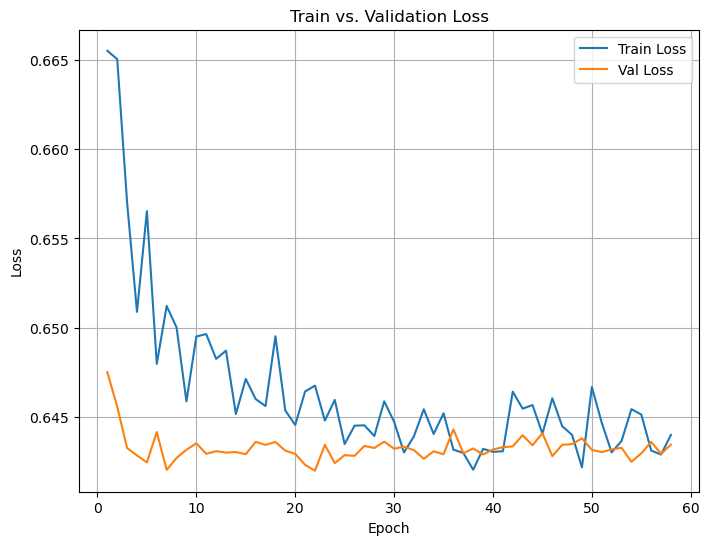

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [95]:
final = pd.read_csv("/Users/yhk/Desktop/大三上/HTML/FP/HTML 2024 Fall Final Project Stage 1/same_season_test_dataset.csv")
acc = sum(output_df['home_team_win'] == final['home_team_win']) / len(output_df)
print(acc)

0.47259498787388843
